In [1]:
import os
import tensorflow as tf
import itertools
import numpy as np
from numpy import unravel_index
from random import choice, random, sample
from operator import itemgetter
np.random.seed(1337)  # for reproducibility
from keras.models import Sequential, Model, load_model
from keras.layers import Input, BatchNormalization, Reshape
from keras.layers import Dense, Dropout, Activation, Flatten, LocallyConnected2D
from keras.layers import Conv2D, MaxPooling2D, AlphaDropout, ConvLSTM2D, AvgPool2D, Conv2DTranspose, UpSampling2D
from keras.layers import add, concatenate, multiply
from keras.initializers import VarianceScaling, RandomUniform
from keras.optimizers import Adam, SGD, rmsprop
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils, multi_gpu_model
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Container
from keras.optimizers import SGD, Adadelta, Adagrad
from keras.regularizers import l1, l2
import keras.backend as K
K.set_image_dim_ordering('th')

from keras.callbacks import Callback, ReduceLROnPlateau, LearningRateScheduler, TensorBoard, ModelCheckpoint
import matplotlib.pyplot as plt
import time
%matplotlib notebook

Using TensorFlow backend.


In [2]:
class Ataxx:
    def __init__(self, board=None):
        if board is None:                  # if there is no initialization given
            self.data = np.zeros((7, 7))   # then generate a board with starting init, and black(-1) takes first turn
            self.data[0, 0] = -1           
            self.data[6, 6] = -1
            self.data[0, 6] = 1
            self.data[6, 0] = 1
        else:
            self.data = board
            
    def get_feature_map(self, turn):
        friendly_map = (self.data == turn).astype(float)
        opponent_map = (self.data == -turn).astype(float)
        return np.concatenate((friendly_map.reshape((1, 7, 7)), opponent_map.reshape((1, 7, 7))), axis=0)
    
    def get_mask(self, turn, init=0.001):   # zero(init) out all illegal move positions
        moves = self.get_moves(turn)
        moves = list(zip(*self.get_moves(turn)))
        if len(moves) == 0:
            return np.zeros((2, 7, 7))
        else:
            start_pos = tuple(zip(*moves[0]))
            end_pos = tuple(zip(*moves[1]))
            start_mask = np.ones((7, 7)) * init
            start_mask[start_pos] = 1
            end_mask = np.ones((7, 7)) * init
            end_mask[end_pos] = 1
            return np.concatenate((start_mask.reshape((1, 7, 7)), end_mask.reshape((1, 7, 7))), axis=0)
    
    def plot(self, is_next_move=False, turn=None):                        # plot the board
        image = self.data.copy()
        if is_next_move:
            if turn not in [-1, 1]:
                raise ValueError("Turn must be -1 or 1, or Must input a turn for next moves")
            else:
                next_moves = self.get_moves(turn)
                if len(next_moves) == 0:
                    raise ValueError("Game is over already")
                next_pos = list(zip(*next_moves))[1]
                for pos in next_pos:
                    image[pos] = turn / 2
        plt.imshow(image, cmap='gray')
        plt.xticks(range(7), range(7))
        plt.yticks(range(7), range(7))
        plt.show()
                
    def is_valid(self, turn, pos):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif self.data[pos] != 0:
            return False
        else:
            for dr in range(-2, 3):
                for dc in range(-2, 3):
                    pos_tmp = (pos[0]+dr, pos[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if self.data[pos_tmp] == turn:  # convert any piece of the opponent to 'turn'
                            return True
            return False
        
    def get_moves(self, turn):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1")
        else:
            next_moves = []
            for r in range(7):
                for c in range(7):
                    has_duplicate_move = False      # move within the radius of one of another friendly piece is called
                    if self.is_valid(turn, (r, c)): # duplicate move
                        for dr in range(-2, 3):
                            for dc in range(-2, 3):
                                if abs(dr) <= 1 and abs(dc) <=1 and has_duplicate_move: 
                                    continue        # no need to record same move again
                                else:
                                    pos_tmp = (r+dr, c+dc)
                                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                                        if self.data[pos_tmp] == turn:
                                            next_moves.append((pos_tmp, (r, c)))
            return next_moves
    
    def get_greedy_move(self, turn):
        moves = self.get_moves(turn)
        if len(moves) == 0:
            raise ValueError('No Possible Moves')
        store_data = self.data.copy()
        best_score = -1000000
        for move in moves:
            self.data = store_data.copy()
            self.move_to(turn, move[0], move[1])
            score = self.evaluate(turn, -turn)
            if score > best_score:
                best_move = move
                best_score = score
        self.data = store_data
        return best_move
        
    def move_to(self, turn, pos0, pos1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[pos0] != turn:
            raise ValueError("The starting position is not your piece")
        else:
            dis = np.array(pos1) - np.array(pos0)    # check if is jump move or duplicate move
            if abs(dis[0]) > 1 or abs(dis[1]) > 1:   # jump move
                self.data[pos0] = 0
                self.data[pos1] = turn
            else:                                    # duplicate move
                self.data[pos1] = turn
            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    pos_tmp = (pos1[0]+dr, pos1[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if self.data[pos_tmp] == -turn:  # convert any piece of the opponent to 'turn'
                            self.data[pos_tmp] = turn
                            
    def simu_move_to(self, turn, pos0, pos1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        elif not self.is_valid(turn, pos1):
            raise ValueError("This move: " + str((pos0, pos1)) + " of turn: " + str(turn) + " is invalid") 
        elif self.data[pos0] != turn:
            raise ValueError("You are not moving your piece")
        else:
            tmp_data = self.data.copy()
            dis = np.array(pos1) - np.array(pos0)    # check if is jump move or duplicate move
            if abs(dis[0]) > 1 or abs(dis[1]) > 1:   # jump move
                tmp_data[pos0] = 0
                tmp_data[pos1] = turn
            else:                                    # duplicate move
                tmp_data[pos1] = turn
            for dr in range(-1, 2):                  # infection mode!!!!
                for dc in range(-1, 2):
                    pos_tmp = (pos1[0]+dr, pos1[1]+dc)
                    if pos_tmp[0] >= 0 and pos_tmp[1] >= 0 and pos_tmp[0] < 7 and pos_tmp[1] < 7:
                        if tmp_data[pos_tmp] == -turn:  # convert any piece of the opponent to 'turn'
                            tmp_data[pos_tmp] = turn
            return tmp_data
    
    def evaluate(self, turn, this_turn, max_score=100, min_score=0.1):
        if turn not in [-1, 1]:
            raise ValueError("Turn must be -1 or 1") 
        else:
            turn_no = 0
            op_no = 0
            for r in range(7):
                for c in range(7):
                    if self.data[r, c] == turn:
                        turn_no += 1
                    elif self.data[r, c] == -turn:
                        op_no += 1
            if turn_no + op_no == 49:
                if turn_no > op_no:
                    return max_score
                else:
                    return -max_score
            else:
                if len(self.get_moves(this_turn)) == 0:# if one of them can no longer move, count and end
                    if turn_no > op_no:
                        return max_score
                    else:
                        return -max_score
                else:
                    value = turn_no - op_no
            return value * min_score

In [24]:
class Relay():
    def __init__(self, max_size):
        self.relay = []
        self.max_size = max_size

    def reset(self):
        self.relay = []
        
    def add_sample(self, new_sample):
        if len(self.relay) >= self.max_size:
            self.relay.pop(0)
        self.relay.append(new_sample)
    
    def get_batch(self, batch_size):
        if len(self.relay) < batch_size:
            print('not enough sample')
            raise ValueError('relay not large enough')
        else:
            batch = sample(self.relay, batch_size)
            # generate random array to decide the orientation of the data augmentation
            is_flip = np.random.random(batch_size) < 0.5
            rot_times = (np.random.random(batch_size) * 4).astype(int)
            
            cur_state = np.array([self.augmentation(item[0], is_flip[i], rot_times[i]) 
                                  for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            cur_mask = np.array([self.augmentation(item[1], is_flip[i], rot_times[i])
                                 for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            cur_action = np.array([self.augmentation(item[2], is_flip[i], rot_times[i])
                                   for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            try:
                cur_reward = np.array([item[3] for item in batch]).reshape(-1)
                new_state = np.array([self.augmentation(item[4], is_flip[i], rot_times[i])
                                      for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
                new_mask = np.array([self.augmentation(item[5], is_flip[i], rot_times[i])
                                      for i, item in enumerate(batch)]).reshape(-1, 2, 7, 7)
            except:
                cur_reward = None
                new_state = None
                new_mask = None
            return cur_state, cur_mask, cur_action, cur_reward, new_state, new_mask
    
    def augmentation(self, data, is_flip, rot_time): # data must have three dimentions and depth first
        if data is None:
            return None
        else:
            if is_flip:
                data = np.fliplr(data)
            data = np.rot90(data, k=rot_time, axes=(1, 2))
            return data
    
    def size(self):
        return len(self.relay)

In [57]:
%load_ext Cython

In [67]:
import numpy as np
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])

In [61]:
#%%cython
import numpy as np
#cimport numpy as np
def rot(a, rot_time):
    rot_m_0 = np.array([[0, -1], [1, 0]])
    rot_m = np.eye(2, dtype=np.int8)
    for i in range(rot_time):
        rot_m = rot_m_0.dot(rot_m)
    out = np.zeros_like(a)
    center = np.array([1, 1])
    for r in range(a.shape[0]):
        for c in range(a.shape[1]):
            v = np.array([r, c]) - center
            v = rot_m.dot(v) + center
            out[v[0], v[1]] = a[r, c]
    return out

In [66]:
%time np.rot90(a, 2, axes=(0, 1))
%time rot(a, 2)

CPU times: user 43 µs, sys: 0 ns, total: 43 µs
Wall time: 45.3 µs
CPU times: user 424 µs, sys: 0 ns, total: 424 µs
Wall time: 376 µs


array([[9, 8, 7],
       [6, 5, 4],
       [3, 2, 1]])

In [73]:
import numpy as np
a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
a.reshape((3, 3))

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [92]:
c = np.array([1, 2])


array([1, 2])

In [142]:
def flip_rot(a, rot_time, is_flip):
    rot_m_0 = np.array([[0, -1], [1, 0]])
    rot_m = np.eye(2)
    for i in range(rot_time):
        rot_m = rot_m_0.dot(rot_m)
    out = np.zeros_like(a)
    center = np.array([1, 1])
    for r in range(a.shape[0]):
        for c in range(a.shape[1]):
            v = np.array([r, c]) - center
            if is_flip:
                v[1] = -v[1]
            v = (rot_m.dot(v) + center).astype(np.int8)
            out[v[0], v[1]] = a[r, c]
    return out

In [143]:
for is_flip in [False, True]:
    for rot_time in range(4):
        print(is_flip, rot_time)
        if is_flip:
            assert (np.rot90(np.fliplr(a), rot_time, axes=(0, 1)) == flip_rot(a, rot_time, is_flip)).all()
        else:
            assert (np.rot90(a, rot_time, axes=(0, 1)) == flip_rot(a, rot_time, is_flip)).all()

False 0
False 1
False 2
False 3
True 0
True 1
True 2
True 3


# BatchNormalization helps in hard-to-tune lr situations

In [38]:
def neg_log_loss(y_true, y_pred):
    y_true = K.reshape(y_true, (-1, 1, 98))
    y_pred = K.reshape(y_pred, (-1, 1, 98))
    y_log = K.log(y_pred)
    y_concate = K.concatenate([y_true, y_log], axis=1)
    y_prod = K.prod(y_concate, axis=1)
    return -K.sum(y_prod)


class CriticNetwork(object):
    def __init__(self, TAU=0.001, LEARNING_RATE=0):
        self.TAU = TAU
        self.LEARNING_RATE = LEARNING_RATE

        #Now create the model
        with tf.device("/cpu:0"):
            self.model = self.create_critic_network() 
            self.target_model = self.create_critic_network() 
            self.target_model.set_weights(self.model.get_weights())
        
    def target_train(self):
        critic_weights = self.model.get_weights()
        critic_target_weights = self.target_model.get_weights()
        for i in range(len(critic_weights)):
            critic_target_weights[i] = self.TAU * critic_weights[i] + (1 - self.TAU)* critic_target_weights[i]
        self.target_model.set_weights(critic_target_weights)

    def create_critic_network(self):
        board_input = Input(shape=(2, 7, 7))
        x = Conv2D(32, (1, 1), activation='relu', padding='same')(board_input)
        x = BatchNormalization(axis=1)(x)
        board_feature = MaxPooling2D((2, 2))(x)

        action_input = Input(shape=(2, 7, 7))
        x = Conv2D(32, (1, 1), activation='relu', padding='same')(action_input)
        x = BatchNormalization(axis=1)(x)
        action_feature = MaxPooling2D((2, 2))(x)
        
        overall_feature = concatenate([board_input, action_input], axis=1)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(overall_feature)
        x = BatchNormalization(axis=1)(x)
        x = MaxPooling2D((2, 2))(x)
        
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Flatten()(x)
        
        x = Dense(256, activation='relu')(x)
        x = BatchNormalization(axis=1)(x)
        x = Dense(1)(x)
        # construct model
        model = Model(inputs=[board_input, action_input], outputs=[x])
        print("actor")
        print(model.summary())
        # sgd = SGD(lr=self.LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True)
        model.compile(loss='mse', optimizer=Adam(lr=self.LEARNING_RATE), metrics=['mse'])
        return model
    
class ActorNetwork(object):
    def __init__(self, TAU=0.001, LEARNING_RATE=0, pretrain_epoch=2, is_train=True, \
                 file_name='target_actor_model.h5'):
        if is_train:
            self.TAU = TAU
            self.LEARNING_RATE = LEARNING_RATE
            
            #Now create the model
            self.model= self.create_actor_network()   
            self.target_model= self.create_actor_network() 
            self.target_model.set_weights(self.model.get_weights())
            if not pretrain_epoch == 0:
                try:
                    self.model.load_weights('pretrained_actor_model.h5')
                    print("succesfully loaded the pretrained model")
                except:
                    print("start to pre train with greedy")
                    self.learn_rules(128, pretrain_epoch)
                    self.model.save_weights('pretrained_actor_model.h5')
        else:
            try:
                self.target_model = load_model(file_name)
                print("successfully loaded trained target model")
            except:
                raise ValueError('Can not load target actor model')
    
    def save(self):
        self.target_model.save('target_actor_model.h5')

    def target_train(self):
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = self.TAU * actor_weights[i] + (1 - self.TAU)* actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)

    def create_actor_network(self):
        board_input = Input(shape=(2, 7, 7))
        mask_input = Input(shape=(2, 7, 7))
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(board_input)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = MaxPooling2D((2, 2))(x)
        
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
        x = BatchNormalization(axis=1)(x)
        x = Flatten()(x)
        
        x = Dense(98, activation='softplus')(x)
        x = Reshape((2, 7, 7))(x) 
        x = multiply(inputs=[x, mask_input])     # this mask will mask any illegal move
        x = Reshape((2, 49))(x)
        x = Activation('softmax')(x)
        x = Reshape((2, 7, 7))(x) 
        model = Model(input=[board_input, mask_input],output=[x])
        print(model.summary())
        # sgd = SGD(lr=self.LEARNING_RATE, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1.)
        model.compile(loss=neg_log_loss, optimizer=Adam(lr=self.LEARNING_RATE))
        return model
    
    def get_action_prob(self, feature_map, action_mask, is_target=False):
        if not is_target:
            return self.model.predict([np.reshape(feature_map, (1, 2, 7, 7)), 
                                      np.reshape(action_mask, (1, 2, 7, 7))])[0]
        else:
            return self.target_model.predict([np.reshape(feature_map, (1, 2, 7, 7)), 
                                      np.reshape(action_mask, (1, 2, 7, 7))])[0]
    
    def get_stochastic_action(self, feature_map, action_mask, is_target=False):
        # get action_prob
        action_prob = self.get_action_prob(feature_map, action_mask, is_target)
        # get valid_moves list
        game = Ataxx(board=feature_map[0] - feature_map[1])
        valid_moves = game.get_moves(1)
        index_list = range(len(valid_moves))
        # store pred prob for each valid moves and sort it
        valid_moves_prob = np.zeros(len(valid_moves))
        for i, move in enumerate(valid_moves):
            valid_moves_prob[i] = action_prob[0][move[0]] + action_prob[1][move[1]]
        # noramlize probablity
        valid_moves_prob = valid_moves_prob / valid_moves_prob.sum()
        # sample a policy according to predicted prob
        move_index = np.random.choice(range(len(valid_moves)), p=valid_moves_prob)
        move = valid_moves[move_index]
        # generate 7*7 pos map
        start_pos = np.zeros((7, 7))
        start_pos[move[0]] = 1
        end_pos = np.zeros((7, 7))
        end_pos[move[1]] = 1
        return move[0], move[1], np.concatenate((start_pos.reshape(1, 7, 7), end_pos.reshape(1, 7, 7)), axis=0)
    
    def get_best_action(self, feature_map, action_mask, is_target=False, verbose=True):
        # get action_prob
        action_prob = self.get_action_prob(feature_map, action_mask, is_target)
        # get valid_moves list
        game = Ataxx(board=feature_map[0] - feature_map[1])
        valid_moves = game.get_moves(1)
        max_prob_sum = -1
        pos0 = (0, 0)
        pos1 = (0, 0)
        for move in valid_moves:
            tmp_prob_sum = action_prob[0][move[0]] + action_prob[1][move[1]]
            if tmp_prob_sum > max_prob_sum:
                max_prob_sum = tmp_prob_sum
                pos0 = move[0]
                pos1 = move[1]
        
        # output the max_prob
        if verbose:
            r = np.random.random()
            if r < 0.01:
                print("confidence of this best move is: ", max_prob_sum)
            
        # generate 7*7 pos map
        start_pos = np.zeros((7, 7))
        start_pos[pos0] = 1
        end_pos = np.zeros((7, 7))
        end_pos[pos1] = 1
        
        return pos0, pos1, np.concatenate((start_pos.reshape(1, 7, 7), end_pos.reshape(1, 7, 7)), axis=0)

    def data_generator(self, batch_size, max_size=10000):
        relay = Relay(max_size)
        game = Ataxx()
        turn = -1
        i = 0
        while True: 
            i += 1
            new_sample = []
            new_sample.append(game.get_feature_map(turn))
            new_sample.append(game.get_mask(turn))
            
            try:
                greedy_move = game.get_greedy_move(turn)
            except:
                game = Ataxx()
                turn = -1
                continue
            start_prob_map = np.zeros((7, 7))
            start_prob_map[greedy_move[0]] = 1
            end_prob_map = np.zeros((7, 7))
            end_prob_map[greedy_move[1]] = 1
                
            new_sample.append(np.concatenate((start_prob_map.reshape(1, 7, 7), end_prob_map.reshape(1, 7, 7)), axis=0))
            new_sample.extend([None, None, None])
            relay.add_sample(new_sample)
            
            move = choice(game.get_moves(turn))
            game.move_to(turn, move[0], move[1])
            turn = -turn
            
            if not i % 16 and relay.size() > batch_size*4:
                state, mask, action, _, _, _ = relay.get_batch(batch_size)
                yield [state, mask], action  
                
    def learn_rules(self, batch_size, epochs=10, target_model_update=0.8):
        tmp_game = Ataxx()
        print("trained action prob map predicted by initial model for a starting game")
        print(self.get_action_prob(tmp_game.get_feature_map(-1), tmp_game.get_mask(-1), is_target=True))
        sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
        gpu_model = multi_gpu_model(self.model, gpus=4)
        gpu_model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['acc'])
        gpu_model.fit_generator(self.data_generator(batch_size), steps_per_epoch=256, epochs=epochs, 
                                    verbose=1,
                                    validation_data=self.data_generator(32), 
                                    validation_steps=1,
                                    workers=16,
                                    use_multiprocessing=True,
                                    callbacks=[ReduceLROnPlateau(cooldown=5, min_lr=0.01, patience=2)])
        
        actor_weights = self.model.get_weights()
        actor_target_weights = self.target_model.get_weights()
        for i in range(len(actor_weights)):
            actor_target_weights[i] = target_model_update * actor_weights[i] + \
                                        (1 - target_model_update)* actor_target_weights[i]
        self.target_model.set_weights(actor_target_weights)
        
        tmp_game = Ataxx()
        print("trained action prob map predicted by initial model for a starting game")
        print(self.get_action_prob(tmp_game.get_feature_map(-1), tmp_game.get_mask(-1), is_target=True))

In [39]:
def reinforcement_learning(epochs=1000, check_point=True, step_per_epoch=50, \
                           BATCH_SIZE=64, TRAIN_BATCH_TIME=1, GAMMA=0.99, RELAY_SIZE=50000, TAU=0.001, LRA=0.0001, LRC=0.0001):        
    actor = ActorNetwork(TAU, LRA, 0)
    critic = CriticNetwork(TAU, LRC)
    relay = Relay(RELAY_SIZE)
    
    actor.learn_rules(batch_size=512, epochs=32, target_model_update=0.8)

    max_score = 1
    min_score = 0.002
    
    for ep in range(epochs):
        reward = 0
        step = 0

        game = Ataxx()
        turn = -1 # start turn is -1

        while abs(game.evaluate(turn, turn, max_score, min_score)) != max_score:
            new_sample = [] # prepare to collect new sample
            
            cur_feature = game.get_feature_map(turn)
            cur_mask = game.get_mask(turn)
            
            pos0, pos1, cur_action = actor.get_stochastic_action(cur_feature, cur_mask) # get proposed action
            
            new_state = game.simu_move_to(turn, pos0, pos1)
            
            # create new_sample and add that to relay
            new_sample.append(cur_feature) # cur_state
            new_sample.append(cur_mask) # cur_mask
            new_sample.append(cur_action) # cur_action
            
            game.move_to(turn, pos0, pos1) # do the move here if the move is valid
            turn = -turn # the turn now is the next turn, what we are learning for is -turn
            
            new_sample.append(game.evaluate(-turn, turn, max_score, min_score)) # cur_reward
            if abs(new_sample[-1]) == max_score:
                new_sample.append(np.zeros((2, 7, 7))) 
                new_sample.append(np.zeros((2, 7, 7))) 
            else:
                new_sample.append(game.get_feature_map(turn)) # new_state
                new_sample.append(game.get_mask(turn)) # new_mask
                
            relay.add_sample(new_sample)
            step += 1
        
        print("Episode : " + str(ep) + " Replay Buffer " + str(relay.size()))
        print("TOTAL REWARD @ " + str(ep) +"-th Episode  : Reward " + str(game.evaluate(1, turn, max_score, min_score)))
        print("Total Step: " + str(step))
        
        #Do the batch update....if possible
        if relay.size() > BATCH_SIZE * 2:
            for t in range(step_per_epoch):
                cur_state, cur_mask, cur_action, \
                    cur_reward, new_state, new_mask = relay.get_batch(BATCH_SIZE)
                q_target = cur_reward
                critic_sample_weight = np.ones(BATCH_SIZE)
                
                # set bias training weight and store all new actions
                bias_sample_weight = 10
                new_action = np.ones((BATCH_SIZE, 2, 7, 7))
                not_end_of_game = np.ones(BATCH_SIZE)
                for k in range(BATCH_SIZE):
                    if new_state[k].any():
                        # generate new action
                        _, _, new_action[k] = actor.get_best_action(new_state[k], new_mask[k])
                    else:
                        critic_sample_weight[k] = bias_sample_weight
                        not_end_of_game[k] = 0
                        
                q_new = critic.target_model.predict([new_state, new_action]).reshape(256)
                q_target += - GAMMA*not_end_of_game*q_new
                # log loss update weight equal to critic output    
                actor_sample_weight = q_target
                 
                print("train start:")
                # train models
                for nb in range(TRAIN_BATCH_TIME):
                    print("critic loss", critic.model.train_on_batch([cur_state, cur_action], q_target,\
                                                                     sample_weight=critic_sample_weight))
                print("actor loss", actor.model.train_on_batch([cur_state, cur_mask], cur_action,\
                                                                sample_weight=actor_sample_weight))
                # update stable target models
                actor.target_train()
                critic.target_train()
                
                print("train end")
                for k in range(BATCH_SIZE):
                    if not_end_of_game[k] == 0:
                        q_p = critic.model.predict([cur_state[k].reshape(1, 2, 7, 7), \
                                             cur_action[k].reshape(1, 2, 7, 7)])[0]
                        q_p_t = critic.target_model.predict([cur_state[k].reshape(1, 2, 7, 7), \
                                             cur_action[k].reshape(1, 2, 7, 7)])[0]
                        print("should be {}, predicted: {}, target predicted: {}".format(q_target[k], q_p, q_p_t))
   
        if check_point:
            actor.save()
        tmp_game = Ataxx()
        print("trained action prob map predicted by initial model for a starting game")
        print(actor.get_action_prob(tmp_game.get_feature_map(-1), tmp_game.get_mask(-1), is_target=True))

    print("Finish.")
    actor.save()
    return actor

## Ideas:
1. when comes to new state in training, we should make sure we use target network for both actor and crtic model, in order to have more stability
2. We might will need to keep relay_size smaller so that actor can always learn on a more recent version of target actor network
3. Normalizing that action probability so that the chosen action becomes 1 while other actions becomes 0 is reasonable, because firstly, it makes it easier for crtic model to get a stable output and maintain the property of discrete policys, at least a same critic output for the same choice of policy, secondly, it still helps the guiding of the training on policy model, cuz bad gradient still will be passed if the critic output is bad, and as long as we train for only a few times (maybe one is the most reasonable one..), the property of discrete policy maintains even if we do not change the action mask. 
4. The confidence of the target model of its prediction seems to be a good indication for convergence, cuz that's the only indicator that is monotonic during the training process。。。。
5. The natural phenomenom of training is that, in the begining, loss for actor is close to 0, as critic is just initialized and its output will always be that. For a while, constant increase will be observed in actor loss, as critic is starting to learn larger values while actor is still basically a random picker. After a while, when critic loss has decreased a lot, actor loss should also start to decrease, and this period should be the actual training for actor model.
6. During training, it can be helpful to set the sample weight for 1 and -1 to be very large, cuz it is (1)the hardest to learn considering the around zero init, and (2) most important way to understand rules
7. Setting learning rate for critic to be higher might be reasonable as it helps q converge faster


In [40]:
actor = reinforcement_learning(epochs=1000, check_point=True, step_per_epoch=8, 
                               RELAY_SIZE=50000, BATCH_SIZE=256, TRAIN_BATCH_TIME=5, LRC=5e-5, LRA=1e-5)

/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:117: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_73 (InputLayer)           (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
conv2d_163 (Conv2D)             (None, 64, 7, 7)     1216        input_73[0][0]                   
__________________________________________________________________________________________________
batch_normalization_181 (BatchN (None, 64, 7, 7)     256         conv2d_163[0][0]                 
__________________________________________________________________________________________________
conv2d_164 (Conv2D)             (None, 64, 7, 7)     36928       batch_normalization_181[0][0]    
__________________________________________________________________________________________________
batch_norm

actor
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_77 (InputLayer)           (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
input_78 (InputLayer)           (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
concatenate_19 (Concatenate)    (None, 4, 7, 7)      0           input_77[0][0]                   
                                                                 input_78[0][0]                   
__________________________________________________________________________________________________
conv2d_173 (Conv2D)             (None, 64, 7, 7)     2368        concatenate_19[0][0]             
____

/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/engine/training.py:2023: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 1/32
254/256 [============================>.] - ETA: 0s - loss: 0.0662 - acc: 0.1875

/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/engine/training.py:2251: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


256/256 [==============================] - 101s 395ms/step - loss: 0.0660 - acc: 0.1875 - val_loss: 0.0632 - val_acc: 0.1875
Epoch 2/32
256/256 [==============================] - 18s 72ms/step - loss: 0.0393 - acc: 0.1987 - val_loss: 0.0245 - val_acc: 0.2254
Epoch 3/32
256/256 [==============================] - 19s 74ms/step - loss: 0.0342 - acc: 0.2055 - val_loss: 0.0377 - val_acc: 0.2009
Epoch 4/32
256/256 [==============================] - 20s 77ms/step - loss: 0.0312 - acc: 0.2062 - val_loss: 0.0300 - val_acc: 0.2277
Epoch 5/32
256/256 [==============================] - 21s 81ms/step - loss: 0.0301 - acc: 0.2065 - val_loss: 0.0415 - val_acc: 0.1987
Epoch 6/32
256/256 [==============================] - 19s 73ms/step - loss: 0.0287 - acc: 0.2096 - val_loss: 0.0335 - val_acc: 0.2054
Epoch 7/32
256/256 [==============================] - 20s 77ms/step - loss: 0.0280 - acc: 0.2089 - val_loss: 0.0290 - val_acc: 0.1853
Epoch 8/32
256/256 [==============================] - 19s 76ms/step - l

Episode : 2 Replay Buffer 259
TOTAL REWARD @ 2-th Episode  : Reward 1
Total Step: 124
trained action prob map predicted by initial model for a starting game
[[[ 0.0467361   0.01839436  0.01838697  0.01839055  0.01840487  0.01840029
    0.01841236]
  [ 0.01839807  0.01838933  0.0183889   0.01838767  0.01838784  0.01839141
    0.01840492]
  [ 0.01839552  0.01838873  0.01838923  0.01839465  0.01839     0.01839737
    0.01840749]
  [ 0.01840216  0.01838942  0.01839108  0.01838941  0.01838981  0.01839058
    0.01839132]
  [ 0.01840175  0.01838976  0.01838672  0.0183925   0.01839534  0.01839848
    0.01839948]
  [ 0.01839573  0.0183898   0.01838694  0.0183869   0.01838947  0.01839438
    0.01840604]
  [ 0.01839621  0.01839842  0.01839001  0.01839287  0.01839604  0.01841049
    0.08872218]]

 [[ 0.01300933  0.02474432  0.01822956  0.01300266  0.01300322  0.01302152
    0.01301233]
  [ 0.04319542  0.01736716  0.01703665  0.01300092  0.01300219  0.0130009
    0.01302664]
  [ 0.02823475  0.01588

confidence of this best move is:  1.62911
confidence of this best move is:  1.06695
confidence of this best move is:  1.57767
train start:
critic loss [0.97606391, 0.59788084]
critic loss [0.85337985, 0.57411003]
critic loss [0.69197899, 0.53821933]
critic loss [0.55004048, 0.49673656]
critic loss [0.45758271, 0.45289427]
actor loss -24.932
train end
should be 1.0, predicted: [-0.04339817], target predicted: [ 0.02540302]
should be 1.0, predicted: [-0.05610603], target predicted: [ 0.06160717]
confidence of this best move is:  1.94728
confidence of this best move is:  0.793197
confidence of this best move is:  1.2216
confidence of this best move is:  1.04511
train start:
critic loss [0.98066407, 0.6616168]
critic loss [0.9037891, 0.62922251]
critic loss [0.76760942, 0.5746218]
critic loss [0.61405057, 0.50812179]
critic loss [0.47824466, 0.43929905]
actor loss -31.384
train end
should be 1.0, predicted: [ 0.00483803], target predicted: [ 0.00798245]
should be -1.0, predicted: [-0.03933

critic loss [0.3887499, 0.36017662]
critic loss [0.32739952, 0.32706282]
actor loss -9.5147
train end
should be 1.0, predicted: [-0.18847261], target predicted: [ 0.01623193]
should be 1.0, predicted: [-0.16230008], target predicted: [ 0.01312843]
should be 1.0, predicted: [-0.20558837], target predicted: [ 0.03695439]
confidence of this best move is:  1.40343
confidence of this best move is:  0.819528
train start:
critic loss [0.46395323, 0.4637326]
critic loss [0.44986963, 0.44985056]
critic loss [0.42368168, 0.42367461]
critic loss [0.38751954, 0.38748956]
critic loss [0.34450012, 0.34447891]
actor loss -27.0854
train end
should be 1.0, predicted: [-0.13499896], target predicted: [ 0.00963]
confidence of this best move is:  0.616258
train start:
critic loss [0.52656037, 0.33865327]
critic loss [0.4730432, 0.32178694]
critic loss [0.39423829, 0.29721755]
critic loss [0.31496179, 0.2691862]
critic loss [0.25258845, 0.24069081]
actor loss -44.4213
train end
should be -1.0, predicted: [

Episode : 8 Replay Buffer 948
TOTAL REWARD @ 8-th Episode  : Reward -1
Total Step: 151
confidence of this best move is:  0.77893
confidence of this best move is:  1.03344
train start:
critic loss [0.75332654, 0.40443569]
critic loss [0.65033519, 0.38306987]
critic loss [0.49694198, 0.34726468]
critic loss [0.35963178, 0.30837628]
critic loss [0.27748787, 0.27395871]
actor loss -34.8078
train end
should be 1.0, predicted: [-0.21309282], target predicted: [ 0.01623348]
confidence of this best move is:  1.54976
train start:
critic loss [0.51115471, 0.39654529]
critic loss [0.47608221, 0.38964242]
critic loss [0.41820884, 0.37098247]
critic loss [0.35807359, 0.34330615]
critic loss [0.31052399, 0.31005746]
actor loss -30.3253
train end
should be 1.0, predicted: [-0.05993599], target predicted: [ 0.06878808]
should be -1.0, predicted: [-0.06641104], target predicted: [ 0.02692344]
should be 1.0, predicted: [ 0.03803751], target predicted: [ 0.03480878]
confidence of this best move is:  1.44

confidence of this best move is:  1.40589
train start:
critic loss [0.31244564, 0.27867615]
critic loss [0.29779559, 0.27299491]
critic loss [0.2727159, 0.25971761]
critic loss [0.2449085, 0.24113283]
critic loss [0.21965434, 0.21954553]
actor loss -35.5029
train end
should be -1.0, predicted: [-0.49876156], target predicted: [ 0.03294775]
should be 1.0, predicted: [-0.36267716], target predicted: [ 0.0329246]
trained action prob map predicted by initial model for a starting game
[[[ 0.04735571  0.01836013  0.01835278  0.01835633  0.01837096  0.01836633
    0.0183791 ]
  [ 0.01836398  0.01835507  0.01835463  0.01835348  0.01835366  0.0183572
    0.01837093]
  [ 0.01836149  0.0183545   0.01835511  0.01836075  0.01835589  0.018363
    0.01837383]
  [ 0.01836792  0.01835529  0.01835684  0.01835526  0.01835564  0.01835638
    0.01835698]
  [ 0.01836803  0.01835548  0.01835256  0.0183583   0.01836124  0.01836433
    0.01836533]
  [ 0.01836158  0.01835558  0.01835279  0.01835273  0.01835532 

confidence of this best move is:  0.576381
confidence of this best move is:  1.44057
confidence of this best move is:  1.36759
train start:
critic loss [0.4022364, 0.22779337]
critic loss [0.3501693, 0.21826626]
critic loss [0.27741554, 0.204]
critic loss [0.21427183, 0.18882772]
critic loss [0.17744246, 0.17471743]
actor loss -2.11716
train end
should be 1.0, predicted: [ 0.30115879], target predicted: [ 0.02094522]
should be 1.0, predicted: [ 0.37966752], target predicted: [ 0.05470447]
confidence of this best move is:  1.4777
confidence of this best move is:  1.83741
confidence of this best move is:  0.712507
train start:
critic loss [0.32898208, 0.22280073]
critic loss [0.30113932, 0.21421278]
critic loss [0.257314, 0.19908354]
critic loss [0.21045902, 0.18024191]
critic loss [0.17051211, 0.16014116]
actor loss -23.4555
train end
should be 1.0, predicted: [ 0.36679813], target predicted: [ 0.05152938]
should be -1.0, predicted: [-0.06040121], target predicted: [ 0.05003225]
confide

confidence of this best move is:  1.84974
train start:
critic loss [0.29206413, 0.19975683]
critic loss [0.2673094, 0.19393384]
critic loss [0.23085688, 0.18396422]
critic loss [0.19529276, 0.17146978]
critic loss [0.16850336, 0.15776807]
actor loss -5.92441
train end
should be -1.0, predicted: [-0.50577933], target predicted: [ 0.03941638]
should be 1.0, predicted: [ 0.13585235], target predicted: [ 0.00020289]
should be 1.0, predicted: [ 0.29996943], target predicted: [ 0.0190921]
trained action prob map predicted by initial model for a starting game
[[[ 0.04769717  0.0183405   0.01833317  0.01833671  0.01835147  0.01834683
    0.01835995]
  [ 0.01834441  0.01833542  0.01833498  0.01833386  0.01833406  0.01833758
    0.01835141]
  [ 0.01834197  0.01833487  0.01833554  0.01834127  0.01833632  0.01834331
    0.01835451]
  [ 0.0183483   0.01833571  0.01833721  0.01833566  0.01833605  0.01833677
    0.01833732]
  [ 0.01834865  0.01833582  0.01833297  0.01833867  0.01834168  0.01834474
  

actor loss 20.9699
train end
should be 1.0, predicted: [ 0.25096548], target predicted: [-0.01377565]
should be 1.0, predicted: [ 0.2984592], target predicted: [ 0.00846341]
should be 1.0, predicted: [ 0.48921657], target predicted: [-0.01666769]
confidence of this best move is:  1.4824
confidence of this best move is:  1.86534
train start:
critic loss [0.19996764, 0.19178145]
critic loss [0.18843964, 0.18285288]
critic loss [0.17334956, 0.17052147]
critic loss [0.15703622, 0.15620314]
critic loss [0.14111546, 0.14107358]
actor loss -6.44749
train end
should be 1.0, predicted: [ 0.35009935], target predicted: [ 0.01418386]
should be -1.0, predicted: [-0.15348038], target predicted: [-0.00098499]
confidence of this best move is:  1.52001
confidence of this best move is:  0.68207
confidence of this best move is:  1.54863
train start:
critic loss [0.28303939, 0.16616175]
critic loss [0.2573002, 0.16035576]
critic loss [0.21577744, 0.15090208]
critic loss [0.17214514, 0.13943678]
critic lo

confidence of this best move is:  0.905813
confidence of this best move is:  1.36043
train start:
critic loss [0.18393169, 0.14515047]
critic loss [0.17970321, 0.14221025]
critic loss [0.16550925, 0.13552919]
critic loss [0.14590034, 0.12616116]
critic loss [0.12573242, 0.11528388]
actor loss 6.79636
train end
should be -1.0, predicted: [-0.10153953], target predicted: [ 0.05147541]
should be 1.0, predicted: [ 0.18229042], target predicted: [ 0.01538872]
confidence of this best move is:  1.8316
confidence of this best move is:  1.49183
train start:
critic loss [0.25480908, 0.13888058]
critic loss [0.22192919, 0.13055481]
critic loss [0.17599785, 0.119418]
critic loss [0.13342683, 0.10830215]
critic loss [0.10535907, 0.099014901]
actor loss 26.1105
train end
should be -1.0, predicted: [-0.47660404], target predicted: [-0.00185668]
should be 1.0, predicted: [ 0.34448314], target predicted: [ 0.02988338]
should be 1.0, predicted: [ 0.62213778], target predicted: [ 0.00235808]
should be 1.

confidence of this best move is:  0.492704
confidence of this best move is:  1.42854
confidence of this best move is:  1.40293
train start:
critic loss [0.31380904, 0.17565528]
critic loss [0.28279111, 0.1661731]
critic loss [0.23423022, 0.15031242]
critic loss [0.18131995, 0.13154891]
critic loss [0.13534698, 0.11312632]
actor loss 27.0571
train end
should be -1.0, predicted: [-0.45729864], target predicted: [ 0.03559936]
should be 1.0, predicted: [ 0.68197322], target predicted: [-0.03351462]
should be 1.0, predicted: [ 0.96804279], target predicted: [-0.0359823]
confidence of this best move is:  1.57078
train start:
critic loss [0.31080297, 0.12945975]
critic loss [0.27022207, 0.12425373]
critic loss [0.21349841, 0.11810377]
critic loss [0.16043644, 0.11289831]
critic loss [0.12443849, 0.10911819]
actor loss 31.8607
train end
should be -1.0, predicted: [-0.050362], target predicted: [-0.00062297]
should be 1.0, predicted: [ 1.02604115], target predicted: [-0.00094568]
should be -1.0

confidence of this best move is:  1.35302
train start:
critic loss [0.22945404, 0.17661303]
critic loss [0.21110386, 0.16699135]
critic loss [0.18263553, 0.15287682]
critic loss [0.15346603, 0.13779172]
critic loss [0.13085443, 0.12433834]
actor loss 57.4256
train end
should be 1.0, predicted: [ 0.58359587], target predicted: [-0.01300167]
should be 1.0, predicted: [ 1.14307404], target predicted: [-0.00991814]
should be 1.0, predicted: [ 1.20370805], target predicted: [-0.01306619]
confidence of this best move is:  1.65879
confidence of this best move is:  1.87576
confidence of this best move is:  1.45658
train start:
critic loss [0.36911514, 0.18294898]
critic loss [0.33085585, 0.17790434]
critic loss [0.2675088, 0.16684827]
critic loss [0.20318002, 0.15367457]
critic loss [0.15656099, 0.14168981]
actor loss 50.7001
train end
should be 1.0, predicted: [ 0.73148447], target predicted: [ 0.02024501]
should be 1.0, predicted: [ 0.76020974], target predicted: [-0.04263736]
confidence of 

critic loss [0.23140642, 0.15620951]
critic loss [0.18095529, 0.14839619]
critic loss [0.15359718, 0.14519903]
actor loss 69.6741
train end
should be -1.0, predicted: [-0.6966089], target predicted: [ 0.00125944]
should be 1.0, predicted: [ 0.81530344], target predicted: [ 0.01297528]
should be 1.0, predicted: [ 0.993891], target predicted: [-0.03237492]
should be 1.0, predicted: [ 1.18947077], target predicted: [-0.03315712]
confidence of this best move is:  1.26359
confidence of this best move is:  1.15962
train start:
critic loss [0.32990241, 0.16856313]
critic loss [0.31783926, 0.16821875]
critic loss [0.2736643, 0.15768896]
critic loss [0.21393284, 0.14028409]
critic loss [0.15726721, 0.12107122]
actor loss 68.1487
train end
should be 1.0, predicted: [ 0.7930491], target predicted: [ 0.03660218]
should be 1.0, predicted: [ 0.4917101], target predicted: [-0.03106969]
should be 1.0, predicted: [ 0.92866009], target predicted: [-0.03670282]
should be 1.0, predicted: [ 0.84693384], ta

Episode : 21 Replay Buffer 1805
TOTAL REWARD @ 21-th Episode  : Reward 1
Total Step: 119
confidence of this best move is:  1.98697
confidence of this best move is:  1.77331
confidence of this best move is:  1.53036
confidence of this best move is:  1.47815
train start:
critic loss [0.13891968, 0.12888747]
critic loss [0.13595955, 0.12741207]
critic loss [0.13035968, 0.12386474]
critic loss [0.12282888, 0.11845177]
critic loss [0.11409649, 0.11155677]
actor loss 71.0179
train end
should be 1.0, predicted: [ 1.26704144], target predicted: [-0.05996186]
should be 1.0, predicted: [ 1.19315743], target predicted: [ 0.00032367]
confidence of this best move is:  0.881415
confidence of this best move is:  1.4469
confidence of this best move is:  1.29923
train start:
critic loss [0.16748931, 0.14895582]
critic loss [0.15647224, 0.14184444]
critic loss [0.1409163, 0.13185312]
critic loss [0.12525354, 0.12112679]
critic loss [0.11258657, 0.11119292]
actor loss 90.7308
train end
should be 1.0, pre

train start:
critic loss [0.1745335, 0.10540035]
critic loss [0.16142493, 0.10456809]
critic loss [0.13887903, 0.10104665]
critic loss [0.11512688, 0.095898077]
critic loss [0.096425362, 0.090072997]
actor loss 83.9652
train end
should be -1.0, predicted: [-0.97615963], target predicted: [ 0.02771287]
should be 1.0, predicted: [ 1.02234161], target predicted: [ 0.00839865]
should be 1.0, predicted: [ 0.91692597], target predicted: [-0.05706735]
should be 1.0, predicted: [ 0.95632482], target predicted: [-0.01204831]
should be 1.0, predicted: [ 0.77616781], target predicted: [-0.04614538]
should be -1.0, predicted: [-0.81406206], target predicted: [ 0.02305236]
confidence of this best move is:  1.24869
train start:
critic loss [0.26680964, 0.14023939]
critic loss [0.240392, 0.13411413]
critic loss [0.19792005, 0.12391753]
critic loss [0.15445985, 0.11314379]
critic loss [0.12050039, 0.10414202]
actor loss 87.9542
train end
should be 1.0, predicted: [ 0.87619394], target predicted: [-0.0

Episode : 24 Replay Buffer 2083
TOTAL REWARD @ 24-th Episode  : Reward 1
Total Step: 124
confidence of this best move is:  0.72889
confidence of this best move is:  1.18289
confidence of this best move is:  1.89667
confidence of this best move is:  1.68883
train start:
critic loss [0.10886566, 0.10375708]
critic loss [0.10384097, 0.099546701]
critic loss [0.096788585, 0.093700722]
critic loss [0.0888246, 0.086995572]
critic loss [0.080950022, 0.080141976]
actor loss 84.5742
train end
should be 1.0, predicted: [ 1.16086447], target predicted: [-0.04476912]
confidence of this best move is:  1.45717
confidence of this best move is:  0.66752
confidence of this best move is:  0.958633
confidence of this best move is:  1.02108
confidence of this best move is:  1.33668
train start:
critic loss [0.098781168, 0.098781168]
critic loss [0.097928502, 0.097928502]
critic loss [0.095381059, 0.095381059]
critic loss [0.091167815, 0.091167815]
critic loss [0.085514762, 0.085514762]
actor loss 76.2643


actor loss 92.317
train end
should be 1.0, predicted: [ 1.12172258], target predicted: [-0.04010335]
should be -1.0, predicted: [-1.09089541], target predicted: [-0.06407981]
should be 1.0, predicted: [ 0.70703024], target predicted: [-0.04782984]
should be 1.0, predicted: [ 1.13086236], target predicted: [-0.04898181]
should be 1.0, predicted: [ 0.70695651], target predicted: [-0.01350404]
confidence of this best move is:  1.74055
confidence of this best move is:  0.835032
confidence of this best move is:  1.95356
confidence of this best move is:  1.04384
train start:
critic loss [0.14751282, 0.11592236]
critic loss [0.14322549, 0.11474001]
critic loss [0.13074847, 0.10906565]
critic loss [0.11372871, 0.10026351]
critic loss [0.096469998, 0.090076789]
actor loss 78.6083
train end
should be -1.0, predicted: [-0.88800335], target predicted: [-0.06001744]
should be 1.0, predicted: [ 1.16831064], target predicted: [-0.05525013]
confidence of this best move is:  0.63227
confidence of this 

Episode : 27 Replay Buffer 2342
TOTAL REWARD @ 27-th Episode  : Reward 1
Total Step: 112
confidence of this best move is:  0.870154
confidence of this best move is:  1.46706
train start:
critic loss [0.13981777, 0.093061417]
critic loss [0.1325269, 0.091996484]
critic loss [0.11990128, 0.089710064]
critic loss [0.10547251, 0.086600348]
critic loss [0.092280656, 0.082953215]
actor loss 93.7432
train end
should be 1.0, predicted: [ 0.8322522], target predicted: [-0.06232666]
should be 1.0, predicted: [ 0.94099289], target predicted: [-0.07151538]
should be -1.0, predicted: [-0.50546181], target predicted: [ 0.01197014]
confidence of this best move is:  1.36938
confidence of this best move is:  1.41756
confidence of this best move is:  1.39339
confidence of this best move is:  1.04668
confidence of this best move is:  1.96149
train start:
critic loss [0.13969302, 0.1001051]
critic loss [0.13284619, 0.098084807]
critic loss [0.11854957, 0.09326873]
critic loss [0.10165049, 0.087027386]
cri

confidence of this best move is:  1.52389
confidence of this best move is:  1.41632
train start:
critic loss [0.12830612, 0.10623635]
critic loss [0.12216447, 0.10445029]
critic loss [0.11265086, 0.10103284]
critic loss [0.10233678, 0.09646704]
critic loss [0.092995867, 0.091060542]
actor loss 105.874
train end
should be -1.0, predicted: [-0.72472721], target predicted: [ 0.00721718]
should be -1.0, predicted: [-0.84080809], target predicted: [-0.06088397]
should be 1.0, predicted: [ 1.17210758], target predicted: [-0.09673247]
should be 1.0, predicted: [ 1.05340409], target predicted: [-0.03477441]
should be 1.0, predicted: [ 1.04917455], target predicted: [-0.06907447]
should be 1.0, predicted: [ 1.26533866], target predicted: [-0.02741924]
confidence of this best move is:  1.36829
confidence of this best move is:  1.7323
confidence of this best move is:  0.430383
confidence of this best move is:  1.91733
confidence of this best move is:  0.66211
confidence of this best move is:  1.5

train start:
critic loss [0.12491798, 0.096513003]
critic loss [0.12090407, 0.095152318]
critic loss [0.111679, 0.091325097]
critic loss [0.099383689, 0.085599698]
critic loss [0.086379066, 0.078683913]
actor loss 103.822
train end
should be 1.0, predicted: [ 0.86648852], target predicted: [-0.03102005]
should be -1.0, predicted: [-0.93414491], target predicted: [-0.07237944]
should be 1.0, predicted: [ 0.7540648], target predicted: [-0.05430561]
confidence of this best move is:  0.710823
train start:
critic loss [0.11118541, 0.073276624]
critic loss [0.10103552, 0.069594696]
critic loss [0.087175876, 0.064855158]
critic loss [0.073125228, 0.059999146]
critic loss [0.061643697, 0.055748165]
actor loss 115.257
train end
should be 1.0, predicted: [ 1.19986153], target predicted: [-0.06806979]
should be 1.0, predicted: [ 1.10356283], target predicted: [-0.08402]
trained action prob map predicted by initial model for a starting game
[[[ 0.04924574  0.01824163  0.01823444  0.01823792  0.018

train start:
critic loss [0.2864832, 0.10682254]
critic loss [0.25355774, 0.10154263]
critic loss [0.2011115, 0.093485698]
critic loss [0.14753485, 0.085845441]
critic loss [0.10692774, 0.080683187]
actor loss 117.55
train end
should be -1.0, predicted: [-0.9769417], target predicted: [-0.00118018]
should be 1.0, predicted: [ 0.93495941], target predicted: [-0.04022604]
should be 1.0, predicted: [ 0.45822737], target predicted: [-0.07841893]
should be 1.0, predicted: [ 1.02829289], target predicted: [-0.06856679]
confidence of this best move is:  0.836765
confidence of this best move is:  0.787861
train start:
critic loss [0.15383434, 0.089142941]
critic loss [0.14318967, 0.088444903]
critic loss [0.12161909, 0.08335761]
critic loss [0.097467765, 0.076284543]
critic loss [0.078336358, 0.069814205]
actor loss 112.838
train end
should be -1.0, predicted: [-1.05439055], target predicted: [-0.03675585]
should be 1.0, predicted: [ 1.00498092], target predicted: [-0.07024948]
should be 1.0, 

confidence of this best move is:  0.780062
train start:
critic loss [0.15997642, 0.092859149]
critic loss [0.14576744, 0.088035733]
critic loss [0.12510866, 0.082003765]
critic loss [0.10348266, 0.076236099]
critic loss [0.085416503, 0.071622908]
actor loss 121.234
train end
should be 1.0, predicted: [ 0.78089315], target predicted: [-0.03728793]
should be 1.0, predicted: [ 0.75897652], target predicted: [-0.03769026]
should be 1.0, predicted: [ 0.81462389], target predicted: [-0.0634704]
confidence of this best move is:  1.24663
confidence of this best move is:  1.13647
confidence of this best move is:  1.52822
confidence of this best move is:  0.402144
confidence of this best move is:  0.716568
train start:
critic loss [0.10578123, 0.080491468]
critic loss [0.10217123, 0.080884025]
critic loss [0.096044108, 0.080375135]
critic loss [0.088856436, 0.078795195]
critic loss [0.081391186, 0.076000541]
actor loss 111.259
train end
should be 1.0, predicted: [ 0.96247232], target predicted: 

Episode : 34 Replay Buffer 3273
TOTAL REWARD @ 34-th Episode  : Reward 1
Total Step: 118
confidence of this best move is:  1.05699
confidence of this best move is:  1.13329
train start:
critic loss [0.11578186, 0.068896733]
critic loss [0.10768816, 0.067792378]
critic loss [0.094806626, 0.066021904]
critic loss [0.081239387, 0.064056918]
critic loss [0.070192456, 0.062204972]
actor loss 133.11
train end
should be 1.0, predicted: [ 0.87087923], target predicted: [-0.07869892]
should be 1.0, predicted: [ 0.83091742], target predicted: [-0.06986026]
should be 1.0, predicted: [ 1.02642608], target predicted: [-0.08950257]
should be 1.0, predicted: [ 1.13233829], target predicted: [-0.07729898]
confidence of this best move is:  0.81059
confidence of this best move is:  0.602923
confidence of this best move is:  0.647585
confidence of this best move is:  1.16988
confidence of this best move is:  1.05463
train start:
critic loss [0.10580034, 0.065677941]
critic loss [0.096189931, 0.064243115]

critic loss [0.061530381, 0.061530165]
critic loss [0.059074607, 0.059072774]
critic loss [0.056277201, 0.056273527]
actor loss 126.993
train end
should be 1.0, predicted: [ 1.16342139], target predicted: [-0.08855171]
confidence of this best move is:  1.87684
confidence of this best move is:  0.963532
train start:
critic loss [0.11575178, 0.056436233]
critic loss [0.10649282, 0.054717708]
critic loss [0.09198764, 0.052257523]
critic loss [0.075884074, 0.049484305]
critic loss [0.061257429, 0.046712641]
actor loss 125.329
train end
should be 1.0, predicted: [ 0.75221515], target predicted: [-0.07686129]
should be 1.0, predicted: [ 1.24025416], target predicted: [-0.10606436]
should be 1.0, predicted: [ 0.965832], target predicted: [-0.04263602]
should be 1.0, predicted: [ 1.1074692], target predicted: [-0.09567752]
should be -1.0, predicted: [-0.63503712], target predicted: [-0.06753875]
confidence of this best move is:  0.693059
confidence of this best move is:  0.83716
train start:
c

Episode : 37 Replay Buffer 3423
TOTAL REWARD @ 37-th Episode  : Reward -1
Total Step: 128
confidence of this best move is:  1.55379
train start:
critic loss [0.093681112, 0.079222731]
critic loss [0.089474961, 0.07758677]
critic loss [0.081547186, 0.073289365]
critic loss [0.072247364, 0.067634083]
critic loss [0.063638046, 0.061760318]
actor loss 119.625
train end
should be 1.0, predicted: [ 0.73165971], target predicted: [-0.07775611]
should be -1.0, predicted: [-1.0349493], target predicted: [-0.08255969]
confidence of this best move is:  1.08919
confidence of this best move is:  0.637498
train start:
critic loss [0.073914573, 0.071504742]
critic loss [0.072664358, 0.070895135]
critic loss [0.070248649, 0.069081575]
critic loss [0.066569, 0.065880217]
critic loss [0.061799623, 0.061438821]
actor loss 121.028
train end
should be 1.0, predicted: [ 1.00998962], target predicted: [-0.05224806]
confidence of this best move is:  0.887576
confidence of this best move is:  0.782135
confiden

critic loss [0.093414105, 0.056220036]
critic loss [0.078037634, 0.05742161]
actor loss 132.67
train end
should be 1.0, predicted: [ 0.81257004], target predicted: [-0.09420358]
should be 1.0, predicted: [ 0.5339101], target predicted: [-0.05627418]
should be 1.0, predicted: [ 0.8003335], target predicted: [-0.03800191]
should be 1.0, predicted: [ 0.57649833], target predicted: [-0.07248523]
confidence of this best move is:  1.02385
confidence of this best move is:  0.998234
confidence of this best move is:  1.26495
confidence of this best move is:  0.763853
train start:
critic loss [0.083180562, 0.068450347]
critic loss [0.082281895, 0.069096491]
critic loss [0.076655298, 0.066933751]
critic loss [0.068288028, 0.062651046]
critic loss [0.05974073, 0.057486601]
actor loss 123.621
train end
should be 1.0, predicted: [ 1.02062511], target predicted: [-0.0933414]
should be 1.0, predicted: [ 0.7592302], target predicted: [-0.09770374]
train start:
critic loss [0.15383711, 0.075731993]
crit

Episode : 40 Replay Buffer 3697
TOTAL REWARD @ 40-th Episode  : Reward 1
Total Step: 134
confidence of this best move is:  1.97631
train start:
critic loss [0.08401455, 0.074899144]
critic loss [0.07847178, 0.070509329]
critic loss [0.070722297, 0.064953528]
critic loss [0.062578648, 0.059287697]
critic loss [0.055518813, 0.054245591]
actor loss 113.864
train end
should be -1.0, predicted: [-1.03918743], target predicted: [-0.08371648]
confidence of this best move is:  1.4337
confidence of this best move is:  1.5646
confidence of this best move is:  1.80783
train start:
critic loss [0.060297579, 0.060289286]
critic loss [0.059203416, 0.059181564]
critic loss [0.058203019, 0.058169335]
critic loss [0.056987088, 0.056950361]
critic loss [0.055275921, 0.055247229]
actor loss 128.44
train end
should be 1.0, predicted: [ 1.09740424], target predicted: [-0.06517575]
confidence of this best move is:  0.709598
confidence of this best move is:  1.80375
train start:
critic loss [0.1209926, 0.064

confidence of this best move is:  0.713098
confidence of this best move is:  1.17236
confidence of this best move is:  1.50329
train start:
critic loss [0.11630279, 0.065548301]
critic loss [0.10924236, 0.066547707]
critic loss [0.096574575, 0.065478906]
critic loss [0.082500629, 0.063143931]
critic loss [0.070304945, 0.060234711]
actor loss 145.2
train end
should be 1.0, predicted: [ 1.19057024], target predicted: [-0.12068217]
should be 1.0, predicted: [ 1.07456648], target predicted: [-0.09251095]
should be -1.0, predicted: [-0.8854692], target predicted: [-0.08053844]
should be 1.0, predicted: [ 1.12095475], target predicted: [-0.07678717]
should be 1.0, predicted: [ 0.84228778], target predicted: [-0.12439521]
should be 1.0, predicted: [ 0.90572107], target predicted: [-0.07746418]
should be -1.0, predicted: [-0.78726351], target predicted: [-0.06549032]
should be 1.0, predicted: [ 1.0630244], target predicted: [-0.07870598]
should be 1.0, predicted: [ 1.09919226], target predicte

confidence of this best move is:  0.81973
train start:
critic loss [0.12515229, 0.070398763]
critic loss [0.11714665, 0.068432152]
critic loss [0.10387206, 0.065157726]
critic loss [0.088418573, 0.061058082]
critic loss [0.073481448, 0.056611005]
actor loss 152.017
train end
should be 1.0, predicted: [ 1.07562685], target predicted: [-0.10965387]
should be 1.0, predicted: [ 0.8125397], target predicted: [-0.09019787]
should be 1.0, predicted: [ 0.70610249], target predicted: [-0.06270475]
should be 1.0, predicted: [ 0.927109], target predicted: [-0.0341694]
should be 1.0, predicted: [ 0.73492461], target predicted: [-0.11695302]
confidence of this best move is:  0.546427
confidence of this best move is:  1.06567
confidence of this best move is:  1.71118
confidence of this best move is:  0.579199
confidence of this best move is:  1.55316
train start:
critic loss [0.12186994, 0.066177338]
critic loss [0.113837, 0.063661963]
critic loss [0.097424775, 0.059203349]
critic loss [0.078225717,

confidence of this best move is:  0.726865
confidence of this best move is:  0.766699
train start:
critic loss [0.12889116, 0.062817812]
critic loss [0.11991632, 0.061841983]
critic loss [0.1016193, 0.058121279]
critic loss [0.080287233, 0.053344846]
critic loss [0.061839323, 0.049177125]
actor loss 116.573
train end
should be 1.0, predicted: [ 0.77173573], target predicted: [-0.1354747]
should be -1.0, predicted: [-0.67453933], target predicted: [-0.12950531]
confidence of this best move is:  0.724358
train start:
critic loss [0.056694411, 0.056694411]
critic loss [0.056501035, 0.056501035]
critic loss [0.056219358, 0.056219358]
critic loss [0.05557885, 0.05557885]
critic loss [0.054361254, 0.054361254]
actor loss 130.035
train end
confidence of this best move is:  1.34995
confidence of this best move is:  0.847099
train start:
critic loss [0.052471258, 0.052471161]
critic loss [0.052152537, 0.052121915]
critic loss [0.050696291, 0.050590377]
critic loss [0.048271142, 0.048089899]
cri

Episode : 46 Replay Buffer 4239
TOTAL REWARD @ 46-th Episode  : Reward -1
Total Step: 112
confidence of this best move is:  1.09865
confidence of this best move is:  1.10079
confidence of this best move is:  1.14989
train start:
critic loss [0.092120282, 0.070592508]
critic loss [0.086145304, 0.06557215]
critic loss [0.078020647, 0.059790798]
critic loss [0.069199085, 0.054122627]
critic loss [0.060815554, 0.049092397]
actor loss 144.133
train end
should be 1.0, predicted: [ 1.04823017], target predicted: [-0.11516306]
should be 1.0, predicted: [ 0.95281631], target predicted: [-0.1419442]
should be 1.0, predicted: [ 0.64695764], target predicted: [-0.09167641]
should be 1.0, predicted: [ 0.66999567], target predicted: [-0.05606757]
confidence of this best move is:  1.45887
confidence of this best move is:  0.764207
confidence of this best move is:  1.04314
train start:
critic loss [0.056435775, 0.056435775]
critic loss [0.055057134, 0.055057134]
critic loss [0.053479724, 0.053479724]


confidence of this best move is:  1.13717
confidence of this best move is:  1.02585
confidence of this best move is:  0.569507
train start:
critic loss [0.10420468, 0.070390567]
critic loss [0.099996045, 0.071572989]
critic loss [0.091660999, 0.070777729]
critic loss [0.081107512, 0.067889303]
critic loss [0.070135102, 0.063100666]
actor loss 152.011
train end
should be 1.0, predicted: [ 1.26677334], target predicted: [-0.08842868]
should be 1.0, predicted: [ 1.00077617], target predicted: [-0.0883023]
should be 1.0, predicted: [ 0.95242566], target predicted: [-0.07878864]
should be 1.0, predicted: [ 1.33317065], target predicted: [-0.10654724]
confidence of this best move is:  0.962122
confidence of this best move is:  1.37828
confidence of this best move is:  0.556294
train start:
critic loss [0.071696416, 0.067597017]
critic loss [0.066873714, 0.063397691]
critic loss [0.061419152, 0.058488347]
critic loss [0.056385189, 0.053674951]
critic loss [0.052395642, 0.049517646]
actor loss

Episode : 49 Replay Buffer 4514
TOTAL REWARD @ 49-th Episode  : Reward -1
Total Step: 121
confidence of this best move is:  0.681165
train start:
critic loss [0.071346931, 0.059854254]
critic loss [0.077327132, 0.065316319]
critic loss [0.079954073, 0.068439931]
critic loss [0.078177258, 0.068237096]
critic loss [0.072539821, 0.064909525]
actor loss 116.279
train end
should be 1.0, predicted: [ 0.88099205], target predicted: [-0.12629066]
should be -1.0, predicted: [-1.04254532], target predicted: [-0.08708439]
should be -1.0, predicted: [-0.56600243], target predicted: [-0.10527703]
confidence of this best move is:  1.56572
confidence of this best move is:  1.39267
confidence of this best move is:  1.58974
confidence of this best move is:  0.955995
train start:
critic loss [0.095962726, 0.072646774]
critic loss [0.088699758, 0.069545865]
critic loss [0.079276666, 0.065843225]
critic loss [0.070157014, 0.062363751]
critic loss [0.062738851, 0.059344631]
actor loss 131.473
train end
sho

confidence of this best move is:  1.04776
train start:
critic loss [0.091890648, 0.053712405]
critic loss [0.086539224, 0.052553978]
critic loss [0.075960033, 0.049833626]
critic loss [0.063426152, 0.046465278]
critic loss [0.052255094, 0.043401707]
actor loss 135.834
train end
should be 1.0, predicted: [ 1.01647174], target predicted: [-0.08667631]
should be 1.0, predicted: [ 0.75596106], target predicted: [-0.07349432]
confidence of this best move is:  0.633394
confidence of this best move is:  1.24148
train start:
critic loss [0.067560375, 0.052254688]
critic loss [0.064690307, 0.051106766]
critic loss [0.061098084, 0.050194334]
critic loss [0.05710547, 0.049307793]
critic loss [0.053025208, 0.048202954]
actor loss 143.394
train end
should be 1.0, predicted: [ 1.21053696], target predicted: [-0.1232698]
should be 1.0, predicted: [ 1.22643888], target predicted: [-0.1139183]
should be 1.0, predicted: [ 0.96950209], target predicted: [-0.11599493]
confidence of this best move is:  0.5

Episode : 52 Replay Buffer 4842
TOTAL REWARD @ 52-th Episode  : Reward -1
Total Step: 108
confidence of this best move is:  1.06225
confidence of this best move is:  0.939503
train start:
critic loss [0.12664632, 0.055891592]
critic loss [0.11634821, 0.055937968]
critic loss [0.099349394, 0.054906417]
critic loss [0.081008136, 0.05360562]
critic loss [0.065750711, 0.052573502]
actor loss 132.442
train end
should be 1.0, predicted: [ 1.00452077], target predicted: [-0.1146776]
should be -1.0, predicted: [-0.39465627], target predicted: [-0.07677826]
confidence of this best move is:  1.07928
confidence of this best move is:  1.54528
confidence of this best move is:  0.66772
train start:
critic loss [0.16731928, 0.057669684]
critic loss [0.15555175, 0.0585237]
critic loss [0.13445684, 0.058467329]
critic loss [0.1101101, 0.058002219]
critic loss [0.087908387, 0.057466604]
actor loss 117.298
train end
should be -1.0, predicted: [-0.47839236], target predicted: [-0.07709298]
should be -1.0,

critic loss [0.074794389, 0.063450322]
critic loss [0.067988105, 0.058166228]
actor loss 141.785
train end
should be 1.0, predicted: [ 0.57525092], target predicted: [-0.0949465]
should be 1.0, predicted: [ 1.2393415], target predicted: [-0.09646422]
confidence of this best move is:  1.20707
confidence of this best move is:  0.561539
confidence of this best move is:  1.42476
confidence of this best move is:  0.571057
train start:
critic loss [0.067471504, 0.055630572]
critic loss [0.0647109, 0.05579856]
critic loss [0.061981246, 0.056369357]
critic loss [0.059795745, 0.056980196]
critic loss [0.05797369, 0.056972831]
actor loss 148.822
train end
should be 1.0, predicted: [ 1.10772574], target predicted: [-0.13955376]
should be 1.0, predicted: [ 1.02676415], target predicted: [-0.13993603]
should be 1.0, predicted: [ 1.15553927], target predicted: [-0.08064357]
confidence of this best move is:  1.38784
confidence of this best move is:  1.124
train start:
critic loss [0.082796916, 0.0754

critic loss [0.048146807, 0.044491287]
critic loss [0.045118827, 0.043031991]
actor loss 142.856
train end
should be 1.0, predicted: [ 0.87886107], target predicted: [-0.12862721]
confidence of this best move is:  1.08573
confidence of this best move is:  1.01727
confidence of this best move is:  0.746845
train start:
critic loss [0.1036507, 0.049595878]
critic loss [0.096470051, 0.047396731]
critic loss [0.083991744, 0.04410664]
critic loss [0.069475561, 0.040653482]
critic loss [0.055954836, 0.037761092]
actor loss 140.048
train end
should be 1.0, predicted: [ 1.01776361], target predicted: [-0.10833819]
should be 1.0, predicted: [ 0.85856259], target predicted: [-0.11886271]
should be 1.0, predicted: [ 0.74101675], target predicted: [-0.14114459]
should be -1.0, predicted: [-0.97398311], target predicted: [-0.11782927]
should be 1.0, predicted: [ 0.61909866], target predicted: [-0.10072716]
train start:
critic loss [0.2489845, 0.061786298]
critic loss [0.2118811, 0.059212103]
critic

confidence of this best move is:  0.548191
confidence of this best move is:  1.04423
confidence of this best move is:  1.18335
confidence of this best move is:  1.29701
train start:
critic loss [0.081948712, 0.069002941]
critic loss [0.081146002, 0.069340125]
critic loss [0.076047927, 0.066733129]
critic loss [0.068255171, 0.061976541]
critic loss [0.059519574, 0.056054022]
actor loss 134.019
train end
should be 1.0, predicted: [ 0.90529585], target predicted: [-0.15512104]
confidence of this best move is:  0.540407
confidence of this best move is:  0.668928
confidence of this best move is:  0.758806
confidence of this best move is:  0.739033
confidence of this best move is:  0.946059
train start:
critic loss [0.11704087, 0.068286821]
critic loss [0.10757884, 0.06432876]
critic loss [0.092651367, 0.059409041]
critic loss [0.076595448, 0.054916702]
critic loss [0.063301399, 0.051946353]
actor loss 134.395
train end
should be 1.0, predicted: [ 0.86923254], target predicted: [-0.05415476]

Episode : 58 Replay Buffer 5360
TOTAL REWARD @ 58-th Episode  : Reward 1
Total Step: 140
confidence of this best move is:  1.64682
confidence of this best move is:  0.967076
confidence of this best move is:  0.882515
train start:
critic loss [0.059211612, 0.042884436]
critic loss [0.056026734, 0.041469395]
critic loss [0.051891524, 0.039877232]
critic loss [0.047211394, 0.038160972]
critic loss [0.04242532, 0.036354844]
actor loss 135.501
train end
should be 1.0, predicted: [ 0.8104021], target predicted: [-0.12716316]
should be 1.0, predicted: [ 0.85918337], target predicted: [-0.1067414]
should be -1.0, predicted: [-0.79229468], target predicted: [-0.13733004]
should be 1.0, predicted: [ 1.03672814], target predicted: [-0.10317656]
should be -1.0, predicted: [-1.05319583], target predicted: [-0.16962622]
confidence of this best move is:  0.511696
confidence of this best move is:  0.918983
confidence of this best move is:  0.63668
train start:
critic loss [0.09526442, 0.056716964]
cri

confidence of this best move is:  1.13671
confidence of this best move is:  0.751367
train start:
critic loss [0.094721593, 0.07302127]
critic loss [0.08363156, 0.063538231]
critic loss [0.072577789, 0.055770725]
critic loss [0.063999057, 0.051221803]
critic loss [0.05883541, 0.050021991]
actor loss 128.374
train end
should be 1.0, predicted: [ 0.91715908], target predicted: [-0.19627862]
should be -1.0, predicted: [-0.74927038], target predicted: [-0.14342985]
confidence of this best move is:  0.346632
confidence of this best move is:  1.03749
confidence of this best move is:  1.39066
confidence of this best move is:  1.35223
train start:
critic loss [0.09127894, 0.066771731]
critic loss [0.08960025, 0.06798546]
critic loss [0.08073844, 0.064837068]
critic loss [0.068007469, 0.05838044]
critic loss [0.055583164, 0.050626799]
actor loss 139.722
train end
should be 1.0, predicted: [ 1.28356004], target predicted: [-0.12865387]
should be 1.0, predicted: [ 0.87930381], target predicted: [

Episode : 61 Replay Buffer 5660
TOTAL REWARD @ 61-th Episode  : Reward -1
Total Step: 147
confidence of this best move is:  0.590512
confidence of this best move is:  0.335588
confidence of this best move is:  0.673953
confidence of this best move is:  1.20596
train start:
critic loss [0.15583542, 0.071177751]
critic loss [0.12669031, 0.063003697]
critic loss [0.097057782, 0.057013579]
critic loss [0.075817324, 0.055182792]
critic loss [0.066169992, 0.057244025]
actor loss 137.113
train end
should be -1.0, predicted: [-0.84395814], target predicted: [-0.15778689]
should be 1.0, predicted: [ 0.94413984], target predicted: [-0.08642241]
should be 1.0, predicted: [ 0.72565472], target predicted: [-0.14234203]
confidence of this best move is:  0.998349
confidence of this best move is:  1.34702
confidence of this best move is:  0.79328
confidence of this best move is:  1.04548
confidence of this best move is:  1.30735
confidence of this best move is:  1.65725
train start:
critic loss [0.114

train start:
critic loss [0.046293821, 0.045764029]
critic loss [0.047056787, 0.046579748]
critic loss [0.046854295, 0.046427865]
critic loss [0.045416616, 0.045033552]
critic loss [0.042807408, 0.042460062]
actor loss 143.463
train end
should be 1.0, predicted: [ 0.74146998], target predicted: [-0.09739335]
confidence of this best move is:  0.768897
confidence of this best move is:  0.890742
confidence of this best move is:  1.42026
confidence of this best move is:  0.751358
confidence of this best move is:  1.46225
train start:
critic loss [0.054342464, 0.053322691]
critic loss [0.050476119, 0.04924681]
critic loss [0.045778535, 0.044388477]
critic loss [0.041213773, 0.039699927]
critic loss [0.037410922, 0.035825148]
actor loss 153.713
train end
should be 1.0, predicted: [ 1.29329634], target predicted: [-0.12642987]
should be 1.0, predicted: [ 0.93138009], target predicted: [-0.08909408]
should be 1.0, predicted: [ 1.12484837], target predicted: [-0.13923337]
confidence of this bes

actor loss 132.844
train end
should be 1.0, predicted: [ 1.07436621], target predicted: [-0.10138274]
should be -1.0, predicted: [-0.9031015], target predicted: [-0.13695471]
should be 1.0, predicted: [ 0.93352801], target predicted: [-0.17353526]
should be 1.0, predicted: [ 0.74419975], target predicted: [-0.12365352]
should be -1.0, predicted: [-0.84376889], target predicted: [-0.10114599]
confidence of this best move is:  0.569592
confidence of this best move is:  0.833418
confidence of this best move is:  0.930362
confidence of this best move is:  0.778747
confidence of this best move is:  0.659449
train start:
critic loss [0.066132471, 0.049659848]
critic loss [0.06294553, 0.049655776]
critic loss [0.058509957, 0.048910961]
critic loss [0.053750202, 0.047576249]
critic loss [0.049119584, 0.045696184]
actor loss 152.108
train end
should be 1.0, predicted: [ 0.81120783], target predicted: [-0.1482237]
trained action prob map predicted by initial model for a starting game
[[[ 0.05122

critic loss [0.215896, 0.058041871]
critic loss [0.19919048, 0.055277128]
critic loss [0.16711688, 0.049676068]
critic loss [0.12820283, 0.042804699]
critic loss [0.09114033, 0.03638899]
actor loss 142.589
train end
should be -1.0, predicted: [-0.73476732], target predicted: [-0.1019481]
should be 1.0, predicted: [ 0.93798739], target predicted: [-0.1671548]
should be 1.0, predicted: [ 0.78089929], target predicted: [-0.13105769]
should be 1.0, predicted: [ 0.57383466], target predicted: [-0.12930578]
should be 1.0, predicted: [ 0.87283385], target predicted: [-0.13130595]
should be 1.0, predicted: [ 1.1090039], target predicted: [-0.15331052]
should be -1.0, predicted: [-0.20837897], target predicted: [-0.16125166]
confidence of this best move is:  0.491353
confidence of this best move is:  1.00567
confidence of this best move is:  0.598805
train start:
critic loss [0.10439637, 0.047387235]
critic loss [0.097504899, 0.047711734]
critic loss [0.086489305, 0.047176346]
critic loss [0.07

confidence of this best move is:  1.17359
confidence of this best move is:  0.643946
confidence of this best move is:  1.25651
confidence of this best move is:  0.770428
confidence of this best move is:  0.744169
train start:
critic loss [0.092109948, 0.054175958]
critic loss [0.090099022, 0.056417014]
critic loss [0.084045976, 0.05680909]
critic loss [0.075412795, 0.055462994]
critic loss [0.066318765, 0.053054329]
actor loss 154.503
train end
should be 1.0, predicted: [ 0.85681522], target predicted: [-0.13027883]
should be 1.0, predicted: [ 0.77968264], target predicted: [-0.13151909]
should be 1.0, predicted: [ 0.67759371], target predicted: [-0.10118739]
confidence of this best move is:  0.443664
confidence of this best move is:  1.66249
train start:
critic loss [0.23788956, 0.10379279]
critic loss [0.21358117, 0.095700927]
critic loss [0.17577857, 0.084620357]
critic loss [0.13640252, 0.074373335]
critic loss [0.10387533, 0.067208283]
actor loss 151.97
train end
should be 1.0, pr

confidence of this best move is:  1.16058
confidence of this best move is:  0.893857
train start:
critic loss [0.051933907, 0.051346429]
critic loss [0.054130401, 0.053782627]
critic loss [0.055973068, 0.055785365]
critic loss [0.056751538, 0.056660086]
critic loss [0.056021567, 0.055980138]
actor loss 138.843
train end
should be -1.0, predicted: [-0.86192173], target predicted: [-0.11738824]
trained action prob map predicted by initial model for a starting game
[[[ 0.05143832  0.01824425  0.0182374   0.01824147  0.01826083  0.0182533
    0.01827109]
  [ 0.01824803  0.01823864  0.01823814  0.0182383   0.0182383   0.01824135
    0.01825559]
  [ 0.01824567  0.01823845  0.01824035  0.01824961  0.01824071  0.01824398
    0.01826041]
  [ 0.01825036  0.01823964  0.01824102  0.01824047  0.01824023  0.01824014
    0.01823981]
  [ 0.01825692  0.0182395   0.0182375   0.01824399  0.01824593  0.01824859
    0.0182482 ]
  [ 0.01824614  0.01823977  0.01823766  0.01823742  0.01824065  0.01824782
    

train end
should be 1.0, predicted: [ 0.89142835], target predicted: [-0.09833451]
should be -1.0, predicted: [-0.37127012], target predicted: [-0.12943923]
should be 1.0, predicted: [ 0.83784527], target predicted: [-0.11831583]
confidence of this best move is:  0.915898
train start:
critic loss [0.037954248, 0.037954248]
critic loss [0.03617616, 0.03617616]
critic loss [0.034133777, 0.034133777]
critic loss [0.032115694, 0.032115694]
critic loss [0.030314716, 0.030314716]
actor loss 136.879
train end
confidence of this best move is:  0.834014
train start:
critic loss [0.042649001, 0.034765989]
critic loss [0.042847063, 0.035329662]
critic loss [0.042013571, 0.035511646]
critic loss [0.040252201, 0.035168611]
critic loss [0.037822172, 0.034269128]
actor loss 154.404
train end
should be 1.0, predicted: [ 1.16561031], target predicted: [-0.14251879]
should be 1.0, predicted: [ 0.86838341], target predicted: [-0.10713781]
should be 1.0, predicted: [ 0.95658201], target predicted: [-0.158

actor loss 143.635
train end
should be 1.0, predicted: [ 1.062549], target predicted: [-0.11604324]
confidence of this best move is:  0.971988
confidence of this best move is:  0.494008
train start:
critic loss [0.1255236, 0.054952987]
critic loss [0.11394919, 0.050180737]
critic loss [0.097364828, 0.045297865]
critic loss [0.079467416, 0.041325532]
critic loss [0.063402556, 0.038815424]
actor loss 141.413
train end
should be -1.0, predicted: [-0.67560774], target predicted: [-0.11450534]
should be 1.0, predicted: [ 0.69146943], target predicted: [-0.09267814]
should be 1.0, predicted: [ 1.07177281], target predicted: [-0.08957399]
should be 1.0, predicted: [ 0.70361269], target predicted: [-0.10686699]
should be 1.0, predicted: [ 0.6640287], target predicted: [-0.15097722]
trained action prob map predicted by initial model for a starting game
[[[ 0.05155515  0.01825181  0.01824495  0.01824913  0.01826884  0.01826108
    0.018279  ]
  [ 0.01825549  0.01824615  0.01824565  0.01824589  0

confidence of this best move is:  0.559439
train start:
critic loss [0.073700152, 0.052577682]
critic loss [0.072168224, 0.052967042]
critic loss [0.068315536, 0.051914241]
critic loss [0.062639445, 0.049488638]
critic loss [0.055809937, 0.045947477]
actor loss 147.781
train end
should be 1.0, predicted: [ 0.9144693], target predicted: [-0.05005126]
should be -1.0, predicted: [-0.63238269], target predicted: [-0.14873154]
should be 1.0, predicted: [ 0.80016541], target predicted: [-0.09490867]
should be 1.0, predicted: [ 0.8302418], target predicted: [-0.13663004]
confidence of this best move is:  0.496676
confidence of this best move is:  1.34336
confidence of this best move is:  0.584651
train start:
critic loss [0.045862697, 0.042314611]
critic loss [0.043825574, 0.040378582]
critic loss [0.04127834, 0.038184486]
critic loss [0.038560826, 0.035991378]
critic loss [0.035966501, 0.033991307]
actor loss 144.634
train end
should be 1.0, predicted: [ 0.99243242], target predicted: [-0.11

should be 1.0, predicted: [ 0.70930749], target predicted: [-0.11773752]
should be 1.0, predicted: [ 0.86345029], target predicted: [-0.10905961]
confidence of this best move is:  0.5757
confidence of this best move is:  0.481304
train start:
critic loss [0.067070596, 0.043349653]
critic loss [0.063226998, 0.041906569]
critic loss [0.057049669, 0.039642178]
critic loss [0.049749441, 0.036925934]
critic loss [0.042467594, 0.034112141]
actor loss 141.098
train end
should be -1.0, predicted: [-0.75257373], target predicted: [-0.1424268]
should be 1.0, predicted: [ 0.7732628], target predicted: [-0.13349503]
should be 1.0, predicted: [ 0.80416679], target predicted: [-0.16885115]
trained action prob map predicted by initial model for a starting game
[[[ 0.05171954  0.01825694  0.01825007  0.01825434  0.01827442  0.01826642
    0.01828447]
  [ 0.01826053  0.01825122  0.01825073  0.01825105  0.01825099  0.01825405
    0.01826827]
  [ 0.01825811  0.01825107  0.01825315  0.01826307  0.01825343

Episode : 75 Replay Buffer 7027
TOTAL REWARD @ 75-th Episode  : Reward -1
Total Step: 128
confidence of this best move is:  0.426204
confidence of this best move is:  0.641854
train start:
critic loss [0.099659018, 0.057888627]
critic loss [0.095401429, 0.055643007]
critic loss [0.083427928, 0.050551683]
critic loss [0.068215236, 0.044751853]
critic loss [0.054399483, 0.040185194]
actor loss 139.028
train end
should be 1.0, predicted: [ 0.95583749], target predicted: [-0.09841959]
should be 1.0, predicted: [ 1.0446893], target predicted: [-0.05061432]
should be -1.0, predicted: [-0.62029666], target predicted: [-0.15261179]
confidence of this best move is:  0.919328
confidence of this best move is:  1.35832
confidence of this best move is:  1.65401
train start:
critic loss [0.049255952, 0.043680817]
critic loss [0.051692225, 0.044845931]
critic loss [0.052600332, 0.045532238]
critic loss [0.051056251, 0.044847485]
critic loss [0.047104213, 0.042537391]
actor loss 155.229
train end
shou

critic loss [0.028164137, 0.027541313]
actor loss 147.64
train end
should be 1.0, predicted: [ 0.94097251], target predicted: [-0.11938284]
should be 1.0, predicted: [ 1.00298357], target predicted: [-0.10375094]
confidence of this best move is:  0.751619
confidence of this best move is:  0.812876
confidence of this best move is:  1.259
confidence of this best move is:  1.0246
train start:
critic loss [0.088038281, 0.037549183]
critic loss [0.081746489, 0.035885148]
critic loss [0.071585387, 0.033682324]
critic loss [0.060377192, 0.031540856]
critic loss [0.050284669, 0.029856851]
actor loss 148.679
train end
should be 1.0, predicted: [ 1.04341221], target predicted: [-0.10414191]
should be -1.0, predicted: [-0.30664989], target predicted: [-0.13564706]
should be 1.0, predicted: [ 0.8255645], target predicted: [-0.14000636]
should be 1.0, predicted: [ 1.00896776], target predicted: [-0.13344699]
should be -1.0, predicted: [-0.86829215], target predicted: [-0.10830639]
should be 1.0, pr

Episode : 78 Replay Buffer 7397
TOTAL REWARD @ 78-th Episode  : Reward -1
Total Step: 129
confidence of this best move is:  0.530574
confidence of this best move is:  0.574243
confidence of this best move is:  0.475721
train start:
critic loss [0.10246705, 0.047402203]
critic loss [0.095161512, 0.046227314]
critic loss [0.082607165, 0.044457134]
critic loss [0.068267122, 0.042544618]
critic loss [0.055253729, 0.040933125]
actor loss 149.622
train end
should be 1.0, predicted: [ 0.91766214], target predicted: [-0.10063294]
should be 1.0, predicted: [ 0.87732404], target predicted: [-0.16539171]
should be -1.0, predicted: [-0.47131285], target predicted: [-0.14732638]
confidence of this best move is:  0.984199
train start:
critic loss [0.050385084, 0.050385084]
critic loss [0.049178489, 0.049178489]
critic loss [0.047406103, 0.047406103]
critic loss [0.045148451, 0.045148451]
critic loss [0.042499512, 0.042499512]
actor loss 135.085
train end
confidence of this best move is:  0.621462
co

confidence of this best move is:  0.802428
train start:
critic loss [0.036134012, 0.035075307]
critic loss [0.035003681, 0.033980727]
critic loss [0.033397112, 0.032510981]
critic loss [0.031474452, 0.030793034]
critic loss [0.029436763, 0.028982844]
actor loss 142.568
train end
should be 1.0, predicted: [ 1.00822496], target predicted: [-0.09563758]
confidence of this best move is:  0.896267
confidence of this best move is:  0.515783
train start:
critic loss [0.082347184, 0.035940111]
critic loss [0.078004554, 0.035140581]
critic loss [0.070706338, 0.034294635]
critic loss [0.061947152, 0.033642426]
critic loss [0.053513121, 0.033324689]
actor loss 136.846
train end
should be -1.0, predicted: [-0.32355195], target predicted: [-0.1328111]
confidence of this best move is:  0.893776
confidence of this best move is:  0.456265
confidence of this best move is:  1.31593
train start:
critic loss [0.036622677, 0.030154489]
critic loss [0.036192235, 0.030982938]
critic loss [0.035222255, 0.0315

Episode : 81 Replay Buffer 7704
TOTAL REWARD @ 81-th Episode  : Reward -1
Total Step: 149
confidence of this best move is:  0.330378
confidence of this best move is:  0.647623
confidence of this best move is:  0.507982
train start:
critic loss [0.061841585, 0.038192764]
critic loss [0.059387397, 0.038135372]
critic loss [0.055121556, 0.037136551]
critic loss [0.049724191, 0.035311379]
critic loss [0.043753043, 0.032879181]
actor loss 140.171
train end
should be 1.0, predicted: [ 0.82327753], target predicted: [-0.1045035]
should be -1.0, predicted: [-0.58858955], target predicted: [-0.12723294]
confidence of this best move is:  0.941153
confidence of this best move is:  1.21708
train start:
critic loss [0.061312452, 0.039406154]
critic loss [0.054843124, 0.036973484]
critic loss [0.046601273, 0.034234848]
critic loss [0.039271835, 0.032295302]
critic loss [0.034547068, 0.031629018]
actor loss 144.807
train end
should be 1.0, predicted: [ 0.85602033], target predicted: [-0.1552953]
conf

train start:
critic loss [0.093198858, 0.043624874]
critic loss [0.088414595, 0.044750407]
critic loss [0.079568632, 0.044520684]
critic loss [0.068815388, 0.043052055]
critic loss [0.057803243, 0.040568661]
actor loss 144.909
train end
should be 1.0, predicted: [ 0.85287863], target predicted: [-0.11410309]
should be 1.0, predicted: [ 0.94360274], target predicted: [-0.15275095]
should be 1.0, predicted: [ 0.73066115], target predicted: [-0.13987516]
should be -1.0, predicted: [-0.5502544], target predicted: [-0.13093083]
should be -1.0, predicted: [-0.80273151], target predicted: [-0.14282246]
confidence of this best move is:  0.597656
confidence of this best move is:  0.725493
confidence of this best move is:  0.543427
train start:
critic loss [0.1002941, 0.0541991]
critic loss [0.087230608, 0.048428576]
critic loss [0.068742581, 0.041157916]
critic loss [0.05121173, 0.035262235]
critic loss [0.039314996, 0.032549486]
actor loss 159.725
train end
should be 1.0, predicted: [ 0.946394

Episode : 84 Replay Buffer 7867
TOTAL REWARD @ 84-th Episode  : Reward -1
Total Step: 15
confidence of this best move is:  0.765998
confidence of this best move is:  0.723902
confidence of this best move is:  0.623107
confidence of this best move is:  1.22583
confidence of this best move is:  0.844484
confidence of this best move is:  0.444389
train start:
critic loss [0.060688108, 0.057949409]
critic loss [0.056567039, 0.054581165]
critic loss [0.049740277, 0.048798278]
critic loss [0.042453684, 0.042285115]
critic loss [0.036469519, 0.03643325]
actor loss 144.668
train end
should be 1.0, predicted: [ 0.90061516], target predicted: [-0.12856729]
confidence of this best move is:  0.804055
confidence of this best move is:  1.42108
confidence of this best move is:  0.839476
train start:
critic loss [0.092226729, 0.046345744]
critic loss [0.088651709, 0.044529792]
critic loss [0.08196637, 0.043026809]
critic loss [0.072964318, 0.041549958]
critic loss [0.062735587, 0.039905019]
actor loss

train end
should be 1.0, predicted: [ 0.83845419], target predicted: [-0.09047652]
should be 1.0, predicted: [ 0.88475823], target predicted: [-0.14888269]
confidence of this best move is:  0.808789
confidence of this best move is:  0.709674
train start:
critic loss [0.032651503, 0.032651503]
critic loss [0.033085853, 0.033085853]
critic loss [0.032549344, 0.032549344]
critic loss [0.031100653, 0.031100653]
critic loss [0.029037636, 0.029037636]
actor loss 136.134
train end
confidence of this best move is:  0.827156
confidence of this best move is:  0.976373
train start:
critic loss [0.063647732, 0.038554158]
critic loss [0.059678499, 0.036522251]
critic loss [0.053352352, 0.033984266]
critic loss [0.046015896, 0.031386137]
critic loss [0.038882755, 0.029038446]
actor loss 148.703
train end
should be 1.0, predicted: [ 0.60387564], target predicted: [-0.10093647]
should be 1.0, predicted: [ 1.02716696], target predicted: [-0.14804038]
confidence of this best move is:  0.840631
train sta

confidence of this best move is:  1.5746
confidence of this best move is:  0.888711
train start:
critic loss [0.070992574, 0.044657763]
critic loss [0.066866852, 0.043855317]
critic loss [0.059800766, 0.042142011]
critic loss [0.051184416, 0.039540611]
critic loss [0.042569026, 0.036341347]
actor loss 139.922
train end
should be 1.0, predicted: [ 0.92097712], target predicted: [-0.09577701]
should be -1.0, predicted: [-0.7590037], target predicted: [-0.13429642]
confidence of this best move is:  0.697293
confidence of this best move is:  0.488965
confidence of this best move is:  0.495625
train start:
critic loss [0.044037856, 0.042773448]
critic loss [0.041133251, 0.040278107]
critic loss [0.038420778, 0.037944626]
critic loss [0.03636983, 0.036162745]
critic loss [0.035061285, 0.034998924]
actor loss 137.118
train end
should be 1.0, predicted: [ 1.01016676], target predicted: [-0.12467858]
confidence of this best move is:  0.615215
confidence of this best move is:  0.461545
confidenc

train start:
critic loss [0.06502261, 0.05117489]
critic loss [0.066872001, 0.053691834]
critic loss [0.065749243, 0.05432706]
critic loss [0.061934091, 0.052931506]
critic loss [0.056228124, 0.049796157]
actor loss 135.284
train end
should be -1.0, predicted: [-0.84117931], target predicted: [-0.13490666]
should be -1.0, predicted: [-0.54027015], target predicted: [-0.13388652]
should be 1.0, predicted: [ 1.00269079], target predicted: [-0.13781747]
confidence of this best move is:  1.04739
confidence of this best move is:  0.386972
train start:
critic loss [0.046847038, 0.046784002]
critic loss [0.044870626, 0.044728026]
critic loss [0.042599548, 0.042375222]
critic loss [0.040232353, 0.03995797]
critic loss [0.03785985, 0.037588276]
actor loss 132.943
train end
should be 1.0, predicted: [ 1.1363405], target predicted: [-0.10421756]
confidence of this best move is:  0.93168
confidence of this best move is:  0.576659
train start:
critic loss [0.050338954, 0.031231992]
critic loss [0.0

Episode : 90 Replay Buffer 8299
TOTAL REWARD @ 90-th Episode  : Reward 1
Total Step: 111
confidence of this best move is:  0.518771
confidence of this best move is:  0.617978
train start:
critic loss [0.1003874, 0.049161855]
critic loss [0.096141294, 0.050206982]
critic loss [0.084089547, 0.048101887]
critic loss [0.068618059, 0.04420438]
critic loss [0.054250203, 0.040195379]
actor loss 147.968
train end
should be 1.0, predicted: [ 0.85269451], target predicted: [-0.11608669]
should be 1.0, predicted: [ 0.96023613], target predicted: [-0.106296]
should be 1.0, predicted: [ 0.61309773], target predicted: [-0.1110705]
should be 1.0, predicted: [ 0.87774581], target predicted: [-0.15214664]
confidence of this best move is:  0.914314
train start:
critic loss [0.079657272, 0.052203655]
critic loss [0.070450634, 0.049095988]
critic loss [0.060380179, 0.046549879]
critic loss [0.052408829, 0.045322016]
critic loss [0.047595333, 0.045166116]
actor loss 127.381
train end
should be 1.0, predict

confidence of this best move is:  0.843209
train start:
critic loss [0.090105638, 0.037615225]
critic loss [0.08251024, 0.036884073]
critic loss [0.071395993, 0.035637241]
critic loss [0.059429139, 0.03436964]
critic loss [0.048794389, 0.033369355]
actor loss 140.629
train end
should be 1.0, predicted: [ 0.71612293], target predicted: [-0.10148819]
should be -1.0, predicted: [-0.59560311], target predicted: [-0.10593961]
should be 1.0, predicted: [ 0.94478732], target predicted: [-0.14424857]
should be 1.0, predicted: [ 0.93343049], target predicted: [-0.17449012]
confidence of this best move is:  0.539394
train start:
critic loss [0.080834158, 0.03611178]
critic loss [0.077356935, 0.035777204]
critic loss [0.068313763, 0.034238629]
critic loss [0.056726743, 0.032269083]
critic loss [0.045773104, 0.030641776]
actor loss 157.924
train end
should be 1.0, predicted: [ 0.85307086], target predicted: [-0.11188576]
should be 1.0, predicted: [ 1.07877707], target predicted: [-0.07375874]
shou

Episode : 93 Replay Buffer 8650
TOTAL REWARD @ 93-th Episode  : Reward -1
Total Step: 106
confidence of this best move is:  0.566173
confidence of this best move is:  0.482834
confidence of this best move is:  0.912966
train start:
critic loss [0.11959869, 0.048837006]
critic loss [0.11110231, 0.047706146]
critic loss [0.092725344, 0.044064168]
critic loss [0.070852935, 0.039646782]
critic loss [0.05220101, 0.036333468]
actor loss 144.423
train end
should be 1.0, predicted: [ 0.7508961], target predicted: [-0.12909012]
should be -1.0, predicted: [-0.68941164], target predicted: [-0.12121159]
should be 1.0, predicted: [ 0.84806287], target predicted: [-0.11051032]
should be 1.0, predicted: [ 0.98502129], target predicted: [-0.12295395]
should be -1.0, predicted: [-0.91775429], target predicted: [-0.15064998]
confidence of this best move is:  1.04514
train start:
critic loss [0.067515522, 0.041070767]
critic loss [0.066319212, 0.042742897]
critic loss [0.06262859, 0.043695159]
critic los

confidence of this best move is:  0.868192
confidence of this best move is:  0.922434
confidence of this best move is:  0.807396
confidence of this best move is:  1.16399
confidence of this best move is:  0.647663
train start:
critic loss [0.063570023, 0.049049124]
critic loss [0.062940896, 0.049999218]
critic loss [0.059292819, 0.04903977]
critic loss [0.053833164, 0.04664389]
critic loss [0.047920674, 0.043495402]
actor loss 139.227
train end
should be -1.0, predicted: [-0.72597027], target predicted: [-0.12088333]
should be 1.0, predicted: [ 0.87134826], target predicted: [-0.11998086]
confidence of this best move is:  1.15208
confidence of this best move is:  1.07506
confidence of this best move is:  0.500311
train start:
critic loss [0.048557851, 0.040057734]
critic loss [0.047061212, 0.038432144]
critic loss [0.044449739, 0.03647583]
critic loss [0.04093045, 0.034220468]
critic loss [0.036826845, 0.031759076]
actor loss 135.895
train end
should be 1.0, predicted: [ 0.72261065], t

    0.01264172]]]
Episode : 96 Replay Buffer 9006
TOTAL REWARD @ 96-th Episode  : Reward 1
Total Step: 147
confidence of this best move is:  0.655389
confidence of this best move is:  1.05197
confidence of this best move is:  1.12466
confidence of this best move is:  1.08763
train start:
critic loss [0.053070106, 0.038108066]
critic loss [0.048828755, 0.036509246]
critic loss [0.043602355, 0.0347169]
critic loss [0.038690858, 0.033179015]
critic loss [0.034965031, 0.032145511]
actor loss 138.659
train end
should be 1.0, predicted: [ 0.71312827], target predicted: [-0.13314252]
should be 1.0, predicted: [ 0.93693841], target predicted: [-0.11509732]
confidence of this best move is:  0.879818
train start:
critic loss [0.055621799, 0.037298471]
critic loss [0.053327594, 0.037502158]
critic loss [0.05004707, 0.037660323]
critic loss [0.046447527, 0.037644595]
critic loss [0.042934123, 0.037261572]
actor loss 146.389
train end
should be 1.0, predicted: [ 0.84404755], target predicted: [-0.1

critic loss [0.043627933, 0.035514101]
critic loss [0.041197255, 0.03636343]
critic loss [0.038850129, 0.03649389]
actor loss 132.992
train end
should be 1.0, predicted: [ 0.96202934], target predicted: [-0.11729332]
confidence of this best move is:  0.403072
confidence of this best move is:  0.537506
confidence of this best move is:  0.737854
train start:
critic loss [0.16018274, 0.060823213]
critic loss [0.14746049, 0.056973055]
critic loss [0.1214733, 0.049510062]
critic loss [0.090941012, 0.041508298]
critic loss [0.064513013, 0.035625771]
actor loss 140.696
train end
should be 1.0, predicted: [ 0.86926448], target predicted: [-0.11321186]
should be 1.0, predicted: [ 0.80690032], target predicted: [-0.11341316]
should be -1.0, predicted: [-0.38088879], target predicted: [-0.10161707]
should be 1.0, predicted: [ 1.05842602], target predicted: [-0.09867604]
confidence of this best move is:  0.841041
train start:
critic loss [0.089211136, 0.041996468]
critic loss [0.082098752, 0.04338

confidence of this best move is:  0.901771
confidence of this best move is:  0.544559
train start:
critic loss [0.11882754, 0.048889745]
critic loss [0.10392164, 0.044825122]
critic loss [0.086242087, 0.041990295]
critic loss [0.069636449, 0.040694177]
critic loss [0.056599911, 0.040628083]
actor loss 134.962
train end
should be -1.0, predicted: [-0.64679748], target predicted: [-0.10549265]
should be 1.0, predicted: [ 0.61549479], target predicted: [-0.10813269]
confidence of this best move is:  1.15911
train start:
critic loss [0.16475235, 0.048164785]
critic loss [0.15220866, 0.049231015]
critic loss [0.13223654, 0.049306743]
critic loss [0.10969514, 0.048896916]
critic loss [0.088874169, 0.048588652]
actor loss 149.981
train end
should be 1.0, predicted: [ 0.91177398], target predicted: [-0.08928154]
should be 1.0, predicted: [ 0.62619913], target predicted: [-0.1171589]
should be 1.0, predicted: [ 0.11785432], target predicted: [-0.12220348]
should be 1.0, predicted: [ 0.83223712]

critic loss [0.085007101, 0.069360629]
actor loss 127.686
train end
should be -1.0, predicted: [-0.8773523], target predicted: [-0.12051093]
should be -1.0, predicted: [-1.13218451], target predicted: [-0.10003444]
should be 1.0, predicted: [ 0.64580649], target predicted: [-0.05913281]
should be 1.0, predicted: [ 0.91108823], target predicted: [-0.09904741]
should be -1.0, predicted: [-0.90352935], target predicted: [-0.17730069]
should be -1.0, predicted: [-1.02937973], target predicted: [-0.11118235]
should be 1.0, predicted: [ 0.72860414], target predicted: [-0.12409046]
should be 1.0, predicted: [ 1.08868873], target predicted: [-0.11277743]
confidence of this best move is:  0.7406
confidence of this best move is:  0.777969
confidence of this best move is:  0.448014
train start:
critic loss [0.10397489, 0.089052096]
critic loss [0.094760507, 0.081583485]
critic loss [0.08035738, 0.069255881]
critic loss [0.064594015, 0.055515952]
critic loss [0.050746895, 0.043389481]
actor loss 1

Episode : 102 Replay Buffer 9573
TOTAL REWARD @ 102-th Episode  : Reward 1
Total Step: 133
confidence of this best move is:  0.623952
confidence of this best move is:  0.510063
train start:
critic loss [0.051494762, 0.051494762]
critic loss [0.053899314, 0.053899314]
critic loss [0.053156883, 0.053156883]
critic loss [0.049615826, 0.049615826]
critic loss [0.044307113, 0.044307113]
actor loss 133.073
train end
confidence of this best move is:  0.664684
confidence of this best move is:  0.807909
confidence of this best move is:  1.06549
train start:
critic loss [0.074235991, 0.040666468]
critic loss [0.063863814, 0.034612879]
critic loss [0.053259864, 0.030093377]
critic loss [0.044817932, 0.027906705]
critic loss [0.039564915, 0.027866825]
actor loss 139.158
train end
should be 1.0, predicted: [ 0.68911624], target predicted: [-0.08909886]
should be 1.0, predicted: [ 0.58712554], target predicted: [-0.1104207]
should be 1.0, predicted: [ 0.72195411], target predicted: [-0.10745278]
sho

actor loss 130.355
train end
confidence of this best move is:  0.713288
train start:
critic loss [0.053259738, 0.033322968]
critic loss [0.049060229, 0.03105977]
critic loss [0.043387584, 0.028941777]
critic loss [0.037394602, 0.02717164]
critic loss [0.032115921, 0.025863457]
actor loss 149.239
train end
should be 1.0, predicted: [ 0.96186197], target predicted: [-0.121847]
should be 1.0, predicted: [ 0.95021677], target predicted: [-0.13841499]
should be 1.0, predicted: [ 0.68420213], target predicted: [-0.15626208]
confidence of this best move is:  0.973426
train start:
critic loss [0.029915554, 0.029915554]
critic loss [0.03041237, 0.03041237]
critic loss [0.030237652, 0.030237652]
critic loss [0.029360184, 0.029360184]
critic loss [0.027887339, 0.027887339]
actor loss 128.754
train end
confidence of this best move is:  0.679152
confidence of this best move is:  0.760536
confidence of this best move is:  0.865088
confidence of this best move is:  0.829329
train start:
critic loss [

Episode : 105 Replay Buffer 9937
TOTAL REWARD @ 105-th Episode  : Reward 1
Total Step: 108
confidence of this best move is:  0.542855
confidence of this best move is:  0.6086
train start:
critic loss [0.078835882, 0.037648052]
critic loss [0.067531392, 0.033133201]
critic loss [0.052202728, 0.027838754]
critic loss [0.038095068, 0.023934295]
critic loss [0.028902724, 0.022686999]
actor loss 142.511
train end
should be 1.0, predicted: [ 0.7736488], target predicted: [-0.10828724]
should be 1.0, predicted: [ 0.96107787], target predicted: [-0.07662001]
confidence of this best move is:  0.629273
confidence of this best move is:  0.567506
confidence of this best move is:  0.948035
confidence of this best move is:  0.527413
train start:
critic loss [0.070392169, 0.034923047]
critic loss [0.067904711, 0.038005456]
critic loss [0.063117743, 0.040515199]
critic loss [0.056867789, 0.041811742]
critic loss [0.050195973, 0.041701205]
actor loss 139.707
train end
should be 1.0, predicted: [ 0.5723

confidence of this best move is:  1.18161
train start:
critic loss [0.1511274, 0.046702661]
critic loss [0.13834447, 0.045500085]
critic loss [0.11595901, 0.043120865]
critic loss [0.09130194, 0.0411667]
critic loss [0.070374995, 0.040693834]
actor loss 120.748
train end
should be -1.0, predicted: [-0.37458134], target predicted: [-0.1354876]
should be 1.0, predicted: [ 0.71308577], target predicted: [-0.13205592]
confidence of this best move is:  1.41492
train start:
critic loss [0.081364915, 0.046197772]
critic loss [0.077981979, 0.048919789]
critic loss [0.074228138, 0.051713482]
critic loss [0.070287272, 0.053807303]
critic loss [0.066010982, 0.054521069]
actor loss 117.893
train end
should be -1.0, predicted: [-0.66787368], target predicted: [-0.10034551]
should be 1.0, predicted: [ 0.71611434], target predicted: [-0.08799282]
should be -1.0, predicted: [-0.85499793], target predicted: [-0.11663607]
confidence of this best move is:  1.30397
train start:
critic loss [0.16006902, 0.

Episode : 108 Replay Buffer 10278
TOTAL REWARD @ 108-th Episode  : Reward -1
Total Step: 119
confidence of this best move is:  1.36668
confidence of this best move is:  1.0899
confidence of this best move is:  0.43549
train start:
critic loss [0.057872429, 0.032373019]
critic loss [0.05680915, 0.031981017]
critic loss [0.052745454, 0.031267609]
critic loss [0.046600703, 0.030095967]
critic loss [0.039547931, 0.028533831]
actor loss 134.94
train end
should be 1.0, predicted: [ 0.68591464], target predicted: [-0.05877089]
confidence of this best move is:  0.879472
confidence of this best move is:  0.442621
confidence of this best move is:  0.675887
confidence of this best move is:  1.22758
confidence of this best move is:  0.72173
train start:
critic loss [0.078185208, 0.034065951]
critic loss [0.071639948, 0.032829531]
critic loss [0.062253371, 0.031196732]
critic loss [0.052272893, 0.02979728]
critic loss [0.043537319, 0.029024569]
actor loss 143.658
train end
should be 1.0, predicted:

confidence of this best move is:  0.865951
train start:
critic loss [0.11974695, 0.047371048]
critic loss [0.10460614, 0.043451186]
critic loss [0.081823982, 0.038059387]
critic loss [0.059638608, 0.033828124]
critic loss [0.044204168, 0.032422625]
actor loss 138.234
train end
should be 1.0, predicted: [ 1.2093997], target predicted: [-0.12005696]
should be -1.0, predicted: [-0.68223149], target predicted: [-0.16023386]
should be 1.0, predicted: [ 0.94222903], target predicted: [-0.12992778]
should be 1.0, predicted: [ 0.91065806], target predicted: [-0.10891522]
confidence of this best move is:  0.734431
confidence of this best move is:  0.707258
confidence of this best move is:  0.310456
train start:
critic loss [0.16204056, 0.043819293]
critic loss [0.16119391, 0.046313919]
critic loss [0.14427561, 0.044887826]
critic loss [0.11696621, 0.040237822]
critic loss [0.086273611, 0.034159489]
actor loss 136.836
train end
should be -1.0, predicted: [-0.46728578], target predicted: [-0.1054

Episode : 111 Replay Buffer 10686
TOTAL REWARD @ 111-th Episode  : Reward -1
Total Step: 138
confidence of this best move is:  0.758417
train start:
critic loss [0.047924481, 0.031880759]
critic loss [0.046014655, 0.031593177]
critic loss [0.042947687, 0.03106514]
critic loss [0.039400823, 0.030475684]
critic loss [0.035979796, 0.029946819]
actor loss 127.482
train end
should be 1.0, predicted: [ 0.74494952], target predicted: [-0.11308873]
confidence of this best move is:  0.987005
train start:
critic loss [0.05365302, 0.03460256]
critic loss [0.050638564, 0.034399025]
critic loss [0.046542648, 0.033905119]
critic loss [0.042153046, 0.033243895]
critic loss [0.038040325, 0.032466061]
actor loss 132.643
train end
should be 1.0, predicted: [ 0.72383505], target predicted: [-0.14176123]
confidence of this best move is:  0.739905
confidence of this best move is:  0.705562
confidence of this best move is:  0.912215
confidence of this best move is:  1.311
confidence of this best move is:  0

confidence of this best move is:  0.53077
confidence of this best move is:  0.480617
confidence of this best move is:  0.635751
train start:
critic loss [0.078029528, 0.036221385]
critic loss [0.07494849, 0.035091788]
critic loss [0.066791713, 0.033252515]
critic loss [0.056006249, 0.031064715]
critic loss [0.045147173, 0.029094797]
actor loss 133.204
train end
should be 1.0, predicted: [ 0.70401055], target predicted: [-0.09237297]
should be 1.0, predicted: [ 0.52253127], target predicted: [-0.10526118]
confidence of this best move is:  0.874799
train start:
critic loss [0.044328362, 0.030117042]
critic loss [0.04388909, 0.029924482]
critic loss [0.042135518, 0.029541813]
critic loss [0.039405458, 0.028963288]
critic loss [0.03615788, 0.028249269]
actor loss 139.097
train end
should be 1.0, predicted: [ 0.79840744], target predicted: [-0.12182232]
should be 1.0, predicted: [ 0.69343638], target predicted: [-0.08099761]
trained action prob map predicted by initial model for a starting 

train start:
critic loss [0.051847767, 0.032241512]
critic loss [0.048672646, 0.030158103]
critic loss [0.044777788, 0.028699808]
critic loss [0.040705249, 0.027806187]
critic loss [0.036800221, 0.027224455]
actor loss 132.214
train end
should be 1.0, predicted: [ 0.94923705], target predicted: [-0.11001766]
should be -1.0, predicted: [-0.58512831], target predicted: [-0.11708364]
should be 1.0, predicted: [ 0.72788215], target predicted: [-0.12384899]
train start:
critic loss [0.043150656, 0.027615292]
critic loss [0.040637761, 0.027231839]
critic loss [0.035621993, 0.025814783]
critic loss [0.029736178, 0.023887783]
critic loss [0.024618469, 0.022065755]
actor loss 134.555
train end
should be 1.0, predicted: [ 0.91131735], target predicted: [-0.07120826]
confidence of this best move is:  1.05071
confidence of this best move is:  0.847577
confidence of this best move is:  0.8736
train start:
critic loss [0.030525357, 0.030129092]
critic loss [0.029925471, 0.029589098]
critic loss [0.0

confidence of this best move is:  0.61472
confidence of this best move is:  0.638701
train start:
critic loss [0.091635197, 0.033861242]
critic loss [0.09159939, 0.036405802]
critic loss [0.083729088, 0.036522694]
critic loss [0.070030957, 0.034071673]
critic loss [0.053956021, 0.02997276]
actor loss 153.116
train end
should be 1.0, predicted: [ 0.97627109], target predicted: [-0.09530123]
should be 1.0, predicted: [ 0.50875276], target predicted: [-0.06292243]
should be 1.0, predicted: [ 0.74552888], target predicted: [-0.07626577]
should be 1.0, predicted: [ 0.74940675], target predicted: [-0.10906936]
should be 1.0, predicted: [ 1.03512537], target predicted: [-0.12915026]
should be 1.0, predicted: [ 0.74347705], target predicted: [-0.07062779]
should be 1.0, predicted: [ 1.03806496], target predicted: [-0.07202186]
should be 1.0, predicted: [ 0.89309478], target predicted: [-0.10816319]
trained action prob map predicted by initial model for a starting game
[[[ 0.06061834  0.0180416

confidence of this best move is:  1.37227
train start:
critic loss [0.086310014, 0.042984888]
critic loss [0.081266463, 0.04312291]
critic loss [0.07022205, 0.042022459]
critic loss [0.057460204, 0.040370714]
critic loss [0.046814948, 0.038836643]
actor loss 131.342
train end
should be 1.0, predicted: [ 0.67630416], target predicted: [-0.07861924]
confidence of this best move is:  0.485547
confidence of this best move is:  1.01051
confidence of this best move is:  0.662348
train start:
critic loss [0.092342988, 0.045201134]
critic loss [0.085454866, 0.044610191]
critic loss [0.074378349, 0.043532904]
critic loss [0.062580585, 0.042638812]
critic loss [0.052903064, 0.042373206]
actor loss 129.815
train end
should be 1.0, predicted: [ 0.71581286], target predicted: [-0.12165884]
should be -1.0, predicted: [-0.80726558], target predicted: [-0.11896632]
should be 1.0, predicted: [ 0.71276665], target predicted: [-0.11833046]
confidence of this best move is:  0.758116
confidence of this bes

confidence of this best move is:  1.02333
confidence of this best move is:  0.519743
train start:
critic loss [0.079732835, 0.035493821]
critic loss [0.07787405, 0.036772449]
critic loss [0.072919004, 0.037705917]
critic loss [0.065526873, 0.037802793]
critic loss [0.056785375, 0.036882788]
actor loss 117.746
train end
should be -1.0, predicted: [-0.78401047], target predicted: [-0.16193743]
should be 1.0, predicted: [ 0.7058695], target predicted: [-0.1374851]
should be -1.0, predicted: [-0.45423537], target predicted: [-0.09339264]
train start:
critic loss [0.048097584, 0.038442556]
critic loss [0.04678262, 0.038015217]
critic loss [0.0439943, 0.036981404]
critic loss [0.040395647, 0.03548041]
critic loss [0.036658738, 0.03366331]
actor loss 141.769
train end
should be 1.0, predicted: [ 0.86940676], target predicted: [-0.08129277]
should be 1.0, predicted: [ 0.91973239], target predicted: [-0.10710771]
should be 1.0, predicted: [ 0.88426375], target predicted: [-0.09169511]
should be

critic loss [0.10013787, 0.046407737]
critic loss [0.079113007, 0.045701593]
critic loss [0.062814817, 0.045701548]
actor loss 118.87
train end
should be 1.0, predicted: [ 0.8865419], target predicted: [-0.08729257]
should be -1.0, predicted: [-0.59371901], target predicted: [-0.09368189]
should be -1.0, predicted: [-0.48068604], target predicted: [-0.10343718]
should be 1.0, predicted: [ 0.96018273], target predicted: [-0.1006138]
confidence of this best move is:  0.951294
confidence of this best move is:  0.871572
confidence of this best move is:  0.538899
train start:
critic loss [0.061528787, 0.053898677]
critic loss [0.061989557, 0.054422446]
critic loss [0.058977783, 0.052152596]
critic loss [0.053135253, 0.047512926]
critic loss [0.045576163, 0.04143063]
actor loss 124.136
train end
should be 1.0, predicted: [ 0.89105916], target predicted: [-0.10313683]
should be -1.0, predicted: [-0.57269067], target predicted: [-0.08406078]
confidence of this best move is:  0.771927
confidenc

confidence of this best move is:  0.951974
confidence of this best move is:  1.19857
confidence of this best move is:  0.827312
train start:
critic loss [0.054848112, 0.034001615]
critic loss [0.054303013, 0.034276798]
critic loss [0.050316274, 0.033176769]
critic loss [0.043951422, 0.030963134]
critic loss [0.036717027, 0.028164519]
actor loss 134.425
train end
should be 1.0, predicted: [ 0.84603387], target predicted: [-0.13660739]
should be 1.0, predicted: [ 0.71791917], target predicted: [-0.12264504]
should be 1.0, predicted: [ 0.9638676], target predicted: [-0.11344438]
confidence of this best move is:  0.418633
confidence of this best move is:  0.532669
confidence of this best move is:  0.479711
confidence of this best move is:  0.489747
train start:
critic loss [0.064826638, 0.035437517]
critic loss [0.061991755, 0.033962324]
critic loss [0.056907315, 0.032606792]
critic loss [0.050271049, 0.03130535]
critic loss [0.043214962, 0.030059136]
actor loss 134.363
train end
should be

Episode : 123 Replay Buffer 12158
TOTAL REWARD @ 123-th Episode  : Reward 1
Total Step: 142
confidence of this best move is:  0.394924
confidence of this best move is:  0.508783
confidence of this best move is:  0.635495
train start:
critic loss [0.041183777, 0.041183777]
critic loss [0.040431816, 0.040431816]
critic loss [0.03846921, 0.03846921]
critic loss [0.035626307, 0.035626307]
critic loss [0.032399345, 0.032399345]
actor loss 125.596
train end
confidence of this best move is:  0.915316
confidence of this best move is:  0.685636
confidence of this best move is:  0.81304
train start:
critic loss [0.036146976, 0.035368871]
critic loss [0.033794917, 0.033031784]
critic loss [0.031609349, 0.03099671]
critic loss [0.029877305, 0.029478526]
critic loss [0.028652113, 0.028453678]
actor loss 131.017
train end
should be 1.0, predicted: [ 0.95440143], target predicted: [-0.11893106]
confidence of this best move is:  0.345421
confidence of this best move is:  1.20472
confidence of this bes

confidence of this best move is:  0.574547
confidence of this best move is:  0.617096
train start:
critic loss [0.11837943, 0.043754023]
critic loss [0.10619898, 0.042567451]
critic loss [0.091589995, 0.041562654]
critic loss [0.077666558, 0.040887378]
critic loss [0.066107452, 0.040247228]
actor loss 136.385
train end
should be 1.0, predicted: [ 0.63926572], target predicted: [-0.08879244]
should be 1.0, predicted: [ 1.12935734], target predicted: [-0.10907319]
should be 1.0, predicted: [ 1.39781868], target predicted: [-0.06515241]
should be -1.0, predicted: [-0.47225994], target predicted: [-0.03956014]
should be 1.0, predicted: [ 0.71103281], target predicted: [-0.16126376]
confidence of this best move is:  0.331874
confidence of this best move is:  0.599541
train start:
critic loss [0.074649416, 0.053507205]
critic loss [0.074059784, 0.053366721]
critic loss [0.070661545, 0.051237673]
critic loss [0.06531851, 0.047688246]
critic loss [0.059046146, 0.043433569]
actor loss 136.712
t

confidence of this best move is:  1.34013
confidence of this best move is:  0.582658
confidence of this best move is:  1.12374
train start:
critic loss [0.082260422, 0.033743799]
critic loss [0.076478511, 0.032549005]
critic loss [0.067015827, 0.031058947]
critic loss [0.055981856, 0.029454712]
critic loss [0.045313656, 0.027957369]
actor loss 122.95
train end
should be -1.0, predicted: [-0.46764472], target predicted: [-0.08346963]
should be 1.0, predicted: [ 1.17043495], target predicted: [-0.10119477]
confidence of this best move is:  1.30971
confidence of this best move is:  0.436193
confidence of this best move is:  0.464175
confidence of this best move is:  0.417304
confidence of this best move is:  0.453835
train start:
critic loss [0.072497547, 0.038329776]
critic loss [0.069002286, 0.038807373]
critic loss [0.062868044, 0.038728077]
critic loss [0.055632737, 0.038235739]
critic loss [0.048599668, 0.037460722]
actor loss 115.185
train end
should be -1.0, predicted: [-0.50862211

train start:
critic loss [0.06557557, 0.042067438]
critic loss [0.065917179, 0.044208683]
critic loss [0.063665897, 0.044934493]
critic loss [0.059018906, 0.044027697]
critic loss [0.052645661, 0.041628532]
actor loss 119.213
train end
should be -1.0, predicted: [-0.65418756], target predicted: [-0.09659594]
should be 1.0, predicted: [ 0.69645011], target predicted: [-0.1429906]
confidence of this best move is:  0.737782
confidence of this best move is:  0.577832
confidence of this best move is:  0.900455
train start:
critic loss [0.17636941, 0.051119097]
critic loss [0.15545243, 0.046241231]
critic loss [0.12416078, 0.040319934]
critic loss [0.091696709, 0.035343874]
critic loss [0.065034337, 0.032557204]
actor loss 130.3
train end
should be 1.0, predicted: [ 0.86429381], target predicted: [-0.10204503]
should be -1.0, predicted: [-0.69644964], target predicted: [-0.06256257]
should be 1.0, predicted: [ 0.64264649], target predicted: [-0.10279155]
should be 1.0, predicted: [ 0.6394932

Episode : 129 Replay Buffer 12855
TOTAL REWARD @ 129-th Episode  : Reward -1
Total Step: 108
confidence of this best move is:  0.627204
train start:
critic loss [0.1013494, 0.044491746]
critic loss [0.10146808, 0.045987822]
critic loss [0.094313771, 0.045071967]
critic loss [0.082144961, 0.042249799]
critic loss [0.068024479, 0.038445409]
actor loss 135.209
train end
should be 1.0, predicted: [ 0.60966176], target predicted: [-0.0691355]
should be 1.0, predicted: [ 0.77527398], target predicted: [-0.08961059]
should be 1.0, predicted: [ 0.50343925], target predicted: [-0.11075397]
confidence of this best move is:  0.519004
confidence of this best move is:  1.23477
confidence of this best move is:  0.804992
train start:
critic loss [0.072697394, 0.044829778]
critic loss [0.067418069, 0.041359704]
critic loss [0.059534907, 0.037665971]
critic loss [0.050697871, 0.034341902]
critic loss [0.042569615, 0.031897418]
actor loss 117.382
train end
should be -1.0, predicted: [-0.73175788], targe

train start:
critic loss [0.08555603, 0.053500049]
critic loss [0.077435173, 0.049624097]
critic loss [0.063359015, 0.042826705]
critic loss [0.04834114, 0.035616189]
critic loss [0.036697328, 0.03014718]
actor loss 139.624
train end
should be 1.0, predicted: [ 0.86242652], target predicted: [-0.08849294]
should be 1.0, predicted: [ 0.80305207], target predicted: [-0.09773124]
should be 1.0, predicted: [ 0.7283985], target predicted: [-0.12100229]
should be 1.0, predicted: [ 1.0535866], target predicted: [-0.10508215]
confidence of this best move is:  0.529895
confidence of this best move is:  0.867372
confidence of this best move is:  0.938453
confidence of this best move is:  0.965568
train start:
critic loss [0.034096263, 0.031235807]
critic loss [0.032485835, 0.030643588]
critic loss [0.032654107, 0.03165324]
critic loss [0.033885688, 0.033435754]
critic loss [0.035219721, 0.035050906]
actor loss 129.785
train end
should be 1.0, predicted: [ 1.18336248], target predicted: [-0.09945

Episode : 132 Replay Buffer 13253
TOTAL REWARD @ 132-th Episode  : Reward 1
Total Step: 136
confidence of this best move is:  0.593921
train start:
critic loss [0.091049276, 0.033842277]
critic loss [0.086685792, 0.034232814]
critic loss [0.07678508, 0.033896673]
critic loss [0.063775197, 0.032845162]
critic loss [0.050475784, 0.031341948]
actor loss 122.224
train end
should be 1.0, predicted: [ 0.59171396], target predicted: [-0.053055]
should be -1.0, predicted: [-0.51715308], target predicted: [-0.1027404]
confidence of this best move is:  0.580893
train start:
critic loss [0.12117641, 0.050854556]
critic loss [0.11021224, 0.047103833]
critic loss [0.08854939, 0.040702708]
critic loss [0.064957425, 0.034687668]
critic loss [0.046571806, 0.031378761]
actor loss 132.659
train end
should be 1.0, predicted: [ 0.75352812], target predicted: [-0.11171931]
should be 1.0, predicted: [ 0.82036513], target predicted: [-0.06606811]
should be 1.0, predicted: [ 1.01414037], target predicted: [-0

confidence of this best move is:  0.47832
confidence of this best move is:  0.801184
confidence of this best move is:  1.12935
train start:
critic loss [0.10190637, 0.047071271]
critic loss [0.094982602, 0.04655787]
critic loss [0.082092226, 0.043867826]
critic loss [0.066727206, 0.039944708]
critic loss [0.052147895, 0.035960693]
actor loss 130.974
train end
should be 1.0, predicted: [ 0.79880327], target predicted: [-0.07520562]
should be -1.0, predicted: [-0.62619662], target predicted: [-0.08367881]
should be 1.0, predicted: [ 0.76232743], target predicted: [-0.12346452]
confidence of this best move is:  0.591978
confidence of this best move is:  0.902808
confidence of this best move is:  1.18242
train start:
critic loss [0.064495653, 0.039500255]
critic loss [0.060929611, 0.039832089]
critic loss [0.057360765, 0.040842514]
critic loss [0.054263636, 0.04212914]
critic loss [0.051462751, 0.043044876]
actor loss 129.753
train end
should be 1.0, predicted: [ 1.00814724], target predic

Episode : 135 Replay Buffer 13505
TOTAL REWARD @ 135-th Episode  : Reward -1
Total Step: 121
confidence of this best move is:  1.04746
train start:
critic loss [0.096529707, 0.041183226]
critic loss [0.09424746, 0.040937778]
critic loss [0.086648971, 0.039516497]
critic loss [0.07579983, 0.037356324]
critic loss [0.063848242, 0.034983248]
actor loss 127.032
train end
should be 1.0, predicted: [ 0.89669424], target predicted: [-0.15324675]
should be -1.0, predicted: [-0.37985113], target predicted: [-0.07886266]
should be 1.0, predicted: [ 0.64305252], target predicted: [-0.12189085]
should be 1.0, predicted: [ 0.98582619], target predicted: [-0.07905129]
should be 1.0, predicted: [ 0.86748487], target predicted: [-0.06188355]
confidence of this best move is:  0.539382
confidence of this best move is:  0.987437
train start:
critic loss [0.039607249, 0.039607249]
critic loss [0.039082341, 0.039082341]
critic loss [0.038240161, 0.038240161]
critic loss [0.037076157, 0.037076157]
critic lo

critic loss [0.07410571, 0.062082641]
critic loss [0.066280343, 0.057068296]
critic loss [0.056608282, 0.050352372]
actor loss 122.693
train end
should be 1.0, predicted: [ 0.61036885], target predicted: [-0.10430611]
should be 1.0, predicted: [ 0.85993057], target predicted: [-0.07019026]
should be 1.0, predicted: [ 0.81540984], target predicted: [-0.0901098]
confidence of this best move is:  0.64605
train start:
critic loss [0.067808606, 0.047635123]
critic loss [0.058233805, 0.041540526]
critic loss [0.04842297, 0.036154713]
critic loss [0.040435359, 0.032320037]
critic loss [0.035267398, 0.030226586]
actor loss 123.269
train end
should be -1.0, predicted: [-0.65626937], target predicted: [-0.09905414]
should be 1.0, predicted: [ 0.84275639], target predicted: [-0.03994161]
confidence of this best move is:  0.699156
train start:
critic loss [0.055954058, 0.039558694]
critic loss [0.051755067, 0.039725039]
critic loss [0.047306925, 0.039651655]
critic loss [0.04331499, 0.039251603]
c

Episode : 138 Replay Buffer 13888
TOTAL REWARD @ 138-th Episode  : Reward -1
Total Step: 141
confidence of this best move is:  0.909887
confidence of this best move is:  0.609792
confidence of this best move is:  0.559747
train start:
critic loss [0.12349029, 0.06405779]
critic loss [0.1163582, 0.060942419]
critic loss [0.10340258, 0.056678332]
critic loss [0.087306172, 0.051806752]
critic loss [0.071018048, 0.047052041]
actor loss 112.757
train end
should be -1.0, predicted: [-0.20226], target predicted: [-0.14711909]
should be 1.0, predicted: [ 0.91406715], target predicted: [-0.12514238]
confidence of this best move is:  0.658154
train start:
critic loss [0.095638849, 0.057954844]
critic loss [0.086775571, 0.052754153]
critic loss [0.072301716, 0.045936029]
critic loss [0.056709036, 0.03950873]
critic loss [0.044250946, 0.035091259]
actor loss 102.883
train end
should be -1.0, predicted: [-1.04417551], target predicted: [-0.1269501]
should be -1.0, predicted: [-0.78113687], target p

train end
should be 1.0, predicted: [ 0.93997872], target predicted: [-0.05830592]
should be 1.0, predicted: [ 0.78255463], target predicted: [-0.11477166]
train start:
critic loss [0.074673265, 0.043553308]
critic loss [0.064534977, 0.037248906]
critic loss [0.053854603, 0.031837307]
critic loss [0.044704724, 0.028232623]
critic loss [0.038189001, 0.026681218]
actor loss 127.682
train end
should be 1.0, predicted: [ 0.63900793], target predicted: [-0.1047042]
should be 1.0, predicted: [ 0.59950572], target predicted: [-0.10448889]
train start:
critic loss [0.078271136, 0.032125395]
critic loss [0.078105748, 0.032996859]
critic loss [0.072847553, 0.032737471]
critic loss [0.063578099, 0.031223485]
critic loss [0.052302867, 0.028797278]
actor loss 118.485
train end
should be -1.0, predicted: [-0.49711949], target predicted: [-0.11011703]
should be 1.0, predicted: [ 0.66522789], target predicted: [-0.11370137]
confidence of this best move is:  0.739802
confidence of this best move is:  0

Episode : 141 Replay Buffer 14229
TOTAL REWARD @ 141-th Episode  : Reward 1
Total Step: 110
confidence of this best move is:  0.698597
confidence of this best move is:  0.437435
train start:
critic loss [0.17236412, 0.037693515]
critic loss [0.15412319, 0.034589238]
critic loss [0.12440243, 0.03001745]
critic loss [0.092862681, 0.026260607]
critic loss [0.066342056, 0.024922322]
actor loss 130.579
train end
should be 1.0, predicted: [ 0.91223598], target predicted: [-0.07187799]
should be 1.0, predicted: [ 0.58879489], target predicted: [-0.12968001]
should be 1.0, predicted: [ 0.38027939], target predicted: [-0.06717351]
train start:
critic loss [0.10150261, 0.034887295]
critic loss [0.1079505, 0.039227236]
critic loss [0.10518468, 0.041064549]
critic loss [0.093853369, 0.039897032]
critic loss [0.076796271, 0.03625381]
actor loss 124.363
train end
should be -1.0, predicted: [-0.13333921], target predicted: [-0.10384203]
should be 1.0, predicted: [ 0.95800823], target predicted: [-0.0

train end
confidence of this best move is:  0.627724
confidence of this best move is:  0.672592
confidence of this best move is:  0.627854
train start:
critic loss [0.082158692, 0.02645066]
critic loss [0.07655938, 0.024810256]
critic loss [0.066588365, 0.022581026]
critic loss [0.054460101, 0.02024192]
critic loss [0.042343304, 0.018250616]
actor loss 116.143
train end
should be -1.0, predicted: [-0.51749748], target predicted: [-0.11117759]
should be 1.0, predicted: [ 0.6066007], target predicted: [-0.0476584]
confidence of this best move is:  1.26468
train start:
critic loss [0.058931347, 0.022945957]
critic loss [0.057892468, 0.022847956]
critic loss [0.053802252, 0.022433437]
critic loss [0.047561757, 0.02172526]
critic loss [0.040399682, 0.020853862]
actor loss 125.537
train end
should be 1.0, predicted: [ 0.57844484], target predicted: [-0.13275664]
should be 1.0, predicted: [ 0.5122484], target predicted: [-0.07847127]
trained action prob map predicted by initial model for a st

train end
should be -1.0, predicted: [-0.74407643], target predicted: [-0.10251912]
should be 1.0, predicted: [ 0.75857425], target predicted: [-0.11810198]
confidence of this best move is:  0.828137
confidence of this best move is:  0.44638
train start:
critic loss [0.032360949, 0.032360949]
critic loss [0.032239392, 0.032239392]
critic loss [0.033056136, 0.033056136]
critic loss [0.034337848, 0.034337848]
critic loss [0.035537548, 0.035537548]
actor loss 111.077
train end
confidence of this best move is:  0.843061
confidence of this best move is:  0.479599
train start:
critic loss [0.17696032, 0.063076653]
critic loss [0.16914079, 0.062063243]
critic loss [0.15039679, 0.057848208]
critic loss [0.12563546, 0.051911473]
critic loss [0.10002147, 0.045987677]
actor loss 112.417
train end
should be 1.0, predicted: [ 0.60040367], target predicted: [-0.0924632]
should be -1.0, predicted: [-1.01015341], target predicted: [-0.12908399]
should be -1.0, predicted: [-0.46121413], target predicte

confidence of this best move is:  0.568262
confidence of this best move is:  0.404913
train start:
critic loss [0.05378826, 0.031158477]
critic loss [0.052941136, 0.031539217]
critic loss [0.049362589, 0.031152252]
critic loss [0.044096753, 0.030159621]
critic loss [0.038302336, 0.028791241]
actor loss 119.609
train end
should be -1.0, predicted: [-0.44551405], target predicted: [-0.1056954]
should be 1.0, predicted: [ 0.90232182], target predicted: [-0.05385144]
should be 1.0, predicted: [ 1.0571233], target predicted: [-0.07055113]
confidence of this best move is:  0.540417
confidence of this best move is:  0.820499
train start:
critic loss [0.064570457, 0.039247751]
critic loss [0.058280867, 0.03629582]
critic loss [0.048843093, 0.031964399]
critic loss [0.038636826, 0.027334951]
critic loss [0.029806599, 0.023427002]
actor loss 113.826
train end
should be -1.0, predicted: [-0.71509373], target predicted: [-0.08241372]
should be 1.0, predicted: [ 0.80933684], target predicted: [-0.0

Episode : 147 Replay Buffer 14931
TOTAL REWARD @ 147-th Episode  : Reward 1
Total Step: 136
confidence of this best move is:  0.973825
confidence of this best move is:  0.778475
confidence of this best move is:  0.694124
train start:
critic loss [0.045001894, 0.028274909]
critic loss [0.041921467, 0.027802166]
critic loss [0.03769277, 0.027095804]
critic loss [0.033239767, 0.02632018]
critic loss [0.029528743, 0.025623038]
actor loss 111.952
train end
should be -1.0, predicted: [-0.71759647], target predicted: [-0.05089991]
confidence of this best move is:  0.554556
confidence of this best move is:  0.630707
train start:
critic loss [0.051050942, 0.031388689]
critic loss [0.049434736, 0.031192549]
critic loss [0.04639186, 0.030638937]
critic loss [0.042473964, 0.029731838]
critic loss [0.038085051, 0.028516266]
actor loss 112.368
train end
should be 1.0, predicted: [ 0.67143828], target predicted: [-0.10180596]
should be -1.0, predicted: [-0.98921257], target predicted: [-0.11053279]
s

critic loss [0.04452727, 0.031895999]
critic loss [0.042656794, 0.032823384]
critic loss [0.039917603, 0.032782055]
actor loss 106.711
train end
should be 1.0, predicted: [ 0.58694345], target predicted: [-0.05697382]
confidence of this best move is:  1.31128
confidence of this best move is:  0.611886
confidence of this best move is:  1.20213
train start:
critic loss [0.038439296, 0.038439296]
critic loss [0.037047982, 0.037047982]
critic loss [0.034686379, 0.034686379]
critic loss [0.031883813, 0.031883813]
critic loss [0.02909733, 0.02909733]
actor loss 108.549
train end
confidence of this best move is:  0.925559
train start:
critic loss [0.024609512, 0.024609512]
critic loss [0.023550643, 0.023550643]
critic loss [0.022643711, 0.022643711]
critic loss [0.021773249, 0.021773249]
critic loss [0.020821193, 0.020821193]
actor loss 105.952
train end
trained action prob map predicted by initial model for a starting game
[[[ 0.09275401  0.0167807   0.01676891  0.01677996  0.01680801  0.016

confidence of this best move is:  1.29702
confidence of this best move is:  1.06983
train start:
critic loss [0.038399681, 0.025407728]
critic loss [0.038069721, 0.026283728]
critic loss [0.037021652, 0.027126858]
critic loss [0.035292327, 0.027652942]
critic loss [0.033045568, 0.027701676]
actor loss 116.248
train end
should be 1.0, predicted: [ 1.13226724], target predicted: [-0.11143193]
should be 1.0, predicted: [ 0.66268134], target predicted: [-0.09511822]
confidence of this best move is:  0.444361
train start:
critic loss [0.095211044, 0.032859672]
critic loss [0.08534532, 0.032408904]
critic loss [0.072276548, 0.032088228]
critic loss [0.059542663, 0.032390717]
critic loss [0.049397931, 0.033459507]
actor loss 93.6761
train end
should be -1.0, predicted: [-0.50594157], target predicted: [-0.07892793]
should be -1.0, predicted: [-0.67287916], target predicted: [-0.0410198]
should be -1.0, predicted: [-0.84859431], target predicted: [-0.06716501]
confidence of this best move is: 

critic loss [0.020912737, 0.020912737]
actor loss 108.471
train end
trained action prob map predicted by initial model for a starting game
[[[ 0.09813613  0.01657     0.01655773  0.01656925  0.01659731  0.01658433
    0.01659906]
  [ 0.01657143  0.01655887  0.016558    0.01656131  0.01656131  0.01656366
    0.01657733]
  [ 0.01656765  0.01655971  0.01656601  0.01659041  0.01656466  0.01656278
    0.01658599]
  [ 0.01657263  0.01656096  0.01656459  0.01657143  0.01656628  0.01656001
    0.01655998]
  [ 0.01658682  0.01656499  0.01656087  0.01657739  0.01657309  0.01657537
    0.01657058]
  [ 0.01657357  0.01656163  0.01655949  0.01655969  0.01657149  0.01658199
    0.01658273]
  [ 0.01657918  0.01657165  0.01657374  0.01657717  0.01657529  0.01659786
    0.12300657]]

 [[ 0.01108402  0.03192305  0.02158397  0.01107951  0.01107896  0.01111005
    0.01108882]
  [ 0.0613015   0.01766177  0.0182936   0.01107693  0.01107936  0.01107714
    0.01111396]
  [ 0.03180987  0.02075699  0.01845887  

critic loss [0.061658666, 0.025069667]
actor loss 107.948
train end
should be -1.0, predicted: [-0.33598116], target predicted: [-0.08574132]
should be 1.0, predicted: [ 0.49928632], target predicted: [-0.0458502]
should be 1.0, predicted: [ 0.76516467], target predicted: [-0.07606084]
train start:
critic loss [0.040541962, 0.022652019]
critic loss [0.038665961, 0.022856727]
critic loss [0.035014354, 0.022466749]
critic loss [0.030663069, 0.021797549]
critic loss [0.026575895, 0.021137444]
actor loss 115.051
train end
should be 1.0, predicted: [ 0.76223063], target predicted: [-0.06941587]
should be 1.0, predicted: [ 0.81264979], target predicted: [-0.11446366]
confidence of this best move is:  0.766882
confidence of this best move is:  0.419393
confidence of this best move is:  0.781901
confidence of this best move is:  1.152
confidence of this best move is:  0.351806
train start:
critic loss [0.024210285, 0.024164159]
critic loss [0.024399519, 0.02431345]
critic loss [0.024193838, 0.

critic loss [0.03646332, 0.020627869]
actor loss 108.72
train end
should be 1.0, predicted: [ 0.88338357], target predicted: [-0.07395279]
should be -1.0, predicted: [-0.48774633], target predicted: [-0.06836039]
should be 1.0, predicted: [ 0.6407184], target predicted: [-0.11042228]
should be 1.0, predicted: [ 0.81304473], target predicted: [-0.10127488]
trained action prob map predicted by initial model for a starting game
[[[ 0.10398415  0.01634036  0.01632762  0.01633961  0.0163676   0.01635461
    0.01636902]
  [ 0.01634163  0.0163288   0.01632787  0.01633144  0.01633144  0.01633368
    0.01634724]
  [ 0.01633784  0.01632974  0.01633639  0.01636127  0.01633484  0.01633272
    0.01635626]
  [ 0.01634281  0.016331    0.01633484  0.01634222  0.01633667  0.01632987
    0.01632987]
  [ 0.01635711  0.01633544  0.01633114  0.01634803  0.01634349  0.01634568
    0.01634074]
  [ 0.01634396  0.01633169  0.01632954  0.01632977  0.01634208  0.01635244
    0.01635282]
  [ 0.01634973  0.0163419

confidence of this best move is:  0.834062
confidence of this best move is:  0.773433
confidence of this best move is:  0.640374
confidence of this best move is:  0.861385
train start:
critic loss [0.11799898, 0.038301848]
critic loss [0.11391957, 0.038526829]
critic loss [0.1012954, 0.036789868]
critic loss [0.083896615, 0.033857211]
critic loss [0.066008344, 0.030634262]
actor loss 106.469
train end
should be -1.0, predicted: [-0.39083445], target predicted: [-0.11143237]
should be 1.0, predicted: [ 0.87430727], target predicted: [-0.02659998]
should be 1.0, predicted: [ 0.99251908], target predicted: [-0.02961694]
should be 1.0, predicted: [ 0.57644033], target predicted: [-0.10245281]
confidence of this best move is:  0.699496
confidence of this best move is:  0.68073
train start:
critic loss [0.054812565, 0.026834561]
critic loss [0.050997961, 0.026129274]
critic loss [0.04562496, 0.02567642]
critic loss [0.039928608, 0.025522903]
critic loss [0.034813449, 0.025638517]
actor loss 

actor loss 108.516
train end
should be 1.0, predicted: [ 0.70591718], target predicted: [-0.06113365]
should be 1.0, predicted: [ 0.68826407], target predicted: [-0.0857357]
confidence of this best move is:  0.580177
confidence of this best move is:  1.04241
train start:
critic loss [0.052282959, 0.022328343]
critic loss [0.047950484, 0.0210035]
critic loss [0.04212505, 0.019414295]
critic loss [0.03583926, 0.017890211]
critic loss [0.029988576, 0.016690571]
actor loss 105.541
train end
should be 1.0, predicted: [ 0.81333077], target predicted: [-0.08867428]
should be 1.0, predicted: [ 0.53799707], target predicted: [-0.10387944]
trained action prob map predicted by initial model for a starting game
[[[ 0.1101663   0.01608859  0.01607541  0.01608788  0.01611572  0.01610276
    0.01611678]
  [ 0.01608974  0.01607663  0.01607567  0.01607949  0.01607948  0.01608159
    0.01609506]
  [ 0.01608592  0.01607771  0.01608469  0.01610996  0.01608292  0.01608057
    0.01610441]
  [ 0.01609088  0.

confidence of this best move is:  0.495373
confidence of this best move is:  0.463158
confidence of this best move is:  1.04905
train start:
critic loss [0.087067813, 0.03449893]
critic loss [0.089145586, 0.035946559]
critic loss [0.085281864, 0.036450643]
critic loss [0.07672862, 0.035905257]
critic loss [0.065567717, 0.034601666]
actor loss 93.5185
train end
should be -1.0, predicted: [-0.11979377], target predicted: [-0.0346102]
confidence of this best move is:  0.780998
confidence of this best move is:  0.55446
train start:
critic loss [0.059569739, 0.040657312]
critic loss [0.058138784, 0.040054284]
critic loss [0.053067178, 0.038150854]
critic loss [0.045936044, 0.035329022]
critic loss [0.038598157, 0.032164186]
actor loss 112.22
train end
should be 1.0, predicted: [ 0.89719558], target predicted: [-0.06519567]
should be 1.0, predicted: [ 0.66005701], target predicted: [-0.03155173]
should be 1.0, predicted: [ 0.84178644], target predicted: [-0.06136931]
confidence of this best 

critic loss [0.054857418, 0.0324887]
critic loss [0.049490757, 0.033397168]
actor loss 100.61
train end
should be 1.0, predicted: [ 0.9398244], target predicted: [-0.04531604]
should be -1.0, predicted: [-0.65577835], target predicted: [-0.10363132]
should be 1.0, predicted: [ 0.68764633], target predicted: [-0.08793694]
should be 1.0, predicted: [ 0.59784007], target predicted: [-0.07451835]
confidence of this best move is:  0.363172
train start:
critic loss [0.084688634, 0.035244092]
critic loss [0.079295397, 0.035537072]
critic loss [0.06999968, 0.034795955]
critic loss [0.059090599, 0.033437602]
critic loss [0.048730727, 0.031843983]
actor loss 92.4708
train end
should be -1.0, predicted: [-0.53140616], target predicted: [-0.10998972]
should be 1.0, predicted: [ 0.76636291], target predicted: [-0.04085644]
confidence of this best move is:  0.635944
train start:
critic loss [0.080566697, 0.044355478]
critic loss [0.077656761, 0.041738093]
critic loss [0.068466559, 0.037060387]
criti

Episode : 162 Replay Buffer 16689
TOTAL REWARD @ 162-th Episode  : Reward 1
Total Step: 133
confidence of this best move is:  0.882705
confidence of this best move is:  0.751481
confidence of this best move is:  0.498913
train start:
critic loss [0.13278751, 0.046621501]
critic loss [0.12099555, 0.042226546]
critic loss [0.10251136, 0.037015509]
critic loss [0.082117826, 0.032514051]
critic loss [0.064126, 0.029949004]
actor loss 98.8214
train end
should be 1.0, predicted: [ 0.71844023], target predicted: [-0.07943916]
should be 1.0, predicted: [ 0.55974329], target predicted: [-0.03627092]
should be -1.0, predicted: [-0.61026281], target predicted: [-0.08477287]
should be 1.0, predicted: [ 0.66871166], target predicted: [-0.04684865]
should be 1.0, predicted: [ 0.38008422], target predicted: [-0.0418745]
confidence of this best move is:  0.555051
confidence of this best move is:  0.751186
confidence of this best move is:  0.539194
train start:
critic loss [0.11421397, 0.038385123]
cri

critic loss [0.043787699, 0.03028211]
critic loss [0.039191004, 0.031362347]
actor loss 98.4955
train end
should be 1.0, predicted: [ 0.66403246], target predicted: [-0.04289738]
should be 1.0, predicted: [ 0.89529163], target predicted: [-0.05131976]
confidence of this best move is:  0.402924
confidence of this best move is:  0.662277
confidence of this best move is:  0.451907
confidence of this best move is:  1.04882
train start:
critic loss [0.052567817, 0.035220146]
critic loss [0.0528262, 0.036464158]
critic loss [0.051400281, 0.036810882]
critic loss [0.048568431, 0.036201313]
critic loss [0.04468102, 0.034747168]
actor loss 99.3708
train end
should be 1.0, predicted: [ 0.61053354], target predicted: [-0.1352284]
confidence of this best move is:  0.648287
confidence of this best move is:  0.462653
confidence of this best move is:  0.691506
confidence of this best move is:  1.24107
train start:
critic loss [0.066608608, 0.035596248]
critic loss [0.061591059, 0.033218749]
critic lo

confidence of this best move is:  0.62333
confidence of this best move is:  0.723735
confidence of this best move is:  0.433313
train start:
critic loss [0.085842371, 0.027287439]
critic loss [0.081929639, 0.026270658]
critic loss [0.073289812, 0.024662651]
critic loss [0.061740551, 0.022676196]
critic loss [0.049583711, 0.020719398]
actor loss 105.69
train end
should be 1.0, predicted: [ 0.69614679], target predicted: [-0.05315262]
should be 1.0, predicted: [ 0.39740694], target predicted: [-0.09206742]
should be 1.0, predicted: [ 0.72924173], target predicted: [-0.11384296]
confidence of this best move is:  0.851344
confidence of this best move is:  0.444185
train start:
critic loss [0.055151179, 0.024689924]
critic loss [0.049879789, 0.025138551]
critic loss [0.043825708, 0.025798604]
critic loss [0.038409937, 0.026771218]
critic loss [0.034450799, 0.027986929]
actor loss 96.6265
train end
should be 1.0, predicted: [ 0.74931061], target predicted: [-0.02903154]
should be 1.0, predic

critic loss [0.051372424, 0.035233498]
critic loss [0.044859953, 0.034841962]
critic loss [0.038250826, 0.033351347]
actor loss 100.103
train end
should be 1.0, predicted: [ 0.75878781], target predicted: [-0.05878085]
should be 1.0, predicted: [ 0.79344881], target predicted: [-0.00460177]
should be 1.0, predicted: [ 0.7962541], target predicted: [-0.05367168]
train start:
critic loss [0.04206983, 0.038959105]
critic loss [0.041033365, 0.037571751]
critic loss [0.038874809, 0.035342146]
critic loss [0.035836138, 0.032523051]
critic loss [0.032262959, 0.029416891]
actor loss 89.9851
train end
should be 1.0, predicted: [ 0.77733076], target predicted: [-0.08602227]
confidence of this best move is:  0.548609
confidence of this best move is:  0.986418
confidence of this best move is:  1.03911
train start:
critic loss [0.064647958, 0.028446276]
critic loss [0.058230296, 0.025543084]
critic loss [0.051196091, 0.023266884]
critic loss [0.044743828, 0.021905635]
critic loss [0.039268889, 0.02

confidence of this best move is:  0.631079
train start:
critic loss [0.048950143, 0.026313113]
critic loss [0.043963701, 0.025285758]
critic loss [0.037053041, 0.023996901]
critic loss [0.030374583, 0.02295655]
critic loss [0.025562577, 0.022458537]
actor loss 96.8366
train end
should be 1.0, predicted: [ 0.96956897], target predicted: [-0.05637342]
should be 1.0, predicted: [ 0.84602278], target predicted: [-0.04345692]
should be 1.0, predicted: [ 0.87064636], target predicted: [-0.08168108]
train start:
critic loss [0.065232195, 0.027942896]
critic loss [0.064358138, 0.029103458]
critic loss [0.060723089, 0.029492548]
critic loss [0.05493949, 0.028977709]
critic loss [0.047944665, 0.027670996]
actor loss 95.6745
train end
should be -1.0, predicted: [-0.65934998], target predicted: [-0.04036922]
should be 1.0, predicted: [ 0.57410204], target predicted: [-0.11089874]
should be 1.0, predicted: [ 0.69122171], target predicted: [-0.01074899]
should be 1.0, predicted: [ 0.54291916], targe

confidence of this best move is:  0.417599
train start:
critic loss [0.056792907, 0.044277482]
critic loss [0.054610606, 0.045950819]
critic loss [0.052839357, 0.047579333]
critic loss [0.051574405, 0.048842154]
critic loss [0.050503731, 0.049343355]
actor loss 67.9453
train end
should be -1.0, predicted: [-0.91139734], target predicted: [-0.09049287]
should be -1.0, predicted: [-1.01346779], target predicted: [-0.08586441]
confidence of this best move is:  0.644133
confidence of this best move is:  0.314139
confidence of this best move is:  0.530073
train start:
critic loss [0.10978643, 0.051157773]
critic loss [0.099789053, 0.049726658]
critic loss [0.083526514, 0.046640504]
critic loss [0.066127449, 0.043137446]
critic loss [0.05206687, 0.040264718]
actor loss 91.177
train end
should be 1.0, predicted: [ 0.92029262], target predicted: [-0.07532293]
should be -1.0, predicted: [-0.68140525], target predicted: [-0.06655014]
should be 1.0, predicted: [ 0.70692509], target predicted: [-0

Episode : 171 Replay Buffer 17821
TOTAL REWARD @ 171-th Episode  : Reward -1
Total Step: 143
confidence of this best move is:  0.314277
confidence of this best move is:  0.514465
confidence of this best move is:  0.394639
confidence of this best move is:  0.696064
confidence of this best move is:  1.51206
train start:
critic loss [0.096588179, 0.031433217]
critic loss [0.093359351, 0.031179737]
critic loss [0.086024083, 0.030304234]
critic loss [0.075951159, 0.029006235]
critic loss [0.064704217, 0.027530801]
actor loss 76.123
train end
should be 1.0, predicted: [ 0.4427143], target predicted: [-0.056984]
should be -1.0, predicted: [-0.34563893], target predicted: [-0.07382947]
should be -1.0, predicted: [-0.52372921], target predicted: [-0.07757497]
train start:
critic loss [0.14121684, 0.042782512]
critic loss [0.12906268, 0.04129827]
critic loss [0.10983816, 0.038762674]
critic loss [0.087550379, 0.035884395]
critic loss [0.066749923, 0.033340804]
actor loss 99.528
train end
should 

confidence of this best move is:  0.534983
train start:
critic loss [0.052760344, 0.026478171]
critic loss [0.050928608, 0.025811622]
critic loss [0.046903044, 0.025180891]
critic loss [0.041546591, 0.024567453]
critic loss [0.036216058, 0.024066668]
actor loss 89.6964
train end
should be 1.0, predicted: [ 0.5322749], target predicted: [-0.08283412]
should be 1.0, predicted: [ 0.9747979], target predicted: [-0.07485087]
confidence of this best move is:  0.417011
confidence of this best move is:  1.0773
confidence of this best move is:  0.572427
train start:
critic loss [0.032551169, 0.025792237]
critic loss [0.031463981, 0.026169058]
critic loss [0.0301545, 0.026300866]
critic loss [0.028760694, 0.026165605]
critic loss [0.027362058, 0.025757259]
actor loss 83.5329
train end
should be 1.0, predicted: [ 0.9123913], target predicted: [-0.02274358]
confidence of this best move is:  0.462367
confidence of this best move is:  0.70508
confidence of this best move is:  1.34368
train start:
cr

Episode : 174 Replay Buffer 18104
TOTAL REWARD @ 174-th Episode  : Reward 1
Total Step: 149
train start:
critic loss [0.061538406, 0.055538706]
critic loss [0.059685379, 0.054278158]
critic loss [0.055391099, 0.050880209]
critic loss [0.049590241, 0.046117354]
critic loss [0.04326383, 0.040823162]
actor loss 85.7825
train end
should be 1.0, predicted: [ 0.80335844], target predicted: [-0.07499533]
confidence of this best move is:  0.950487
confidence of this best move is:  0.681769
confidence of this best move is:  0.463131
train start:
critic loss [0.059118241, 0.039448485]
critic loss [0.052063443, 0.035789564]
critic loss [0.045020238, 0.033121269]
critic loss [0.039341435, 0.03175012]
critic loss [0.035693944, 0.031586412]
actor loss 89.607
train end
should be 1.0, predicted: [ 0.9162218], target predicted: [-0.0691621]
should be 1.0, predicted: [ 0.96380913], target predicted: [-0.0252343]
confidence of this best move is:  0.761097
confidence of this best move is:  0.752829
confid

actor loss 68.1531
train end
should be -1.0, predicted: [-0.3217757], target predicted: [-0.05651873]
should be -1.0, predicted: [-0.85398841], target predicted: [-0.06512516]
confidence of this best move is:  0.596701
confidence of this best move is:  0.543233
confidence of this best move is:  0.554557
train start:
critic loss [0.12826008, 0.038515389]
critic loss [0.12623212, 0.038457289]
critic loss [0.1093912, 0.034611307]
critic loss [0.085071512, 0.029188599]
critic loss [0.061604053, 0.02464029]
actor loss 92.4543
train end
should be 1.0, predicted: [ 0.98920715], target predicted: [-0.03379556]
should be -1.0, predicted: [-0.46579203], target predicted: [-0.0317357]
should be 1.0, predicted: [ 0.87737674], target predicted: [-0.11000064]
should be 1.0, predicted: [ 0.54588252], target predicted: [-0.04469294]
should be 1.0, predicted: [ 0.47454333], target predicted: [-0.0588268]
confidence of this best move is:  0.594751
confidence of this best move is:  1.17643
train start:
c

Episode : 177 Replay Buffer 18466
TOTAL REWARD @ 177-th Episode  : Reward 1
Total Step: 116
confidence of this best move is:  0.637045
confidence of this best move is:  0.596702
confidence of this best move is:  0.402726
train start:
critic loss [0.10748699, 0.031223685]
critic loss [0.10256629, 0.031010296]
critic loss [0.090115935, 0.029421266]
critic loss [0.073654115, 0.027122039]
critic loss [0.056799304, 0.024935544]
actor loss 80.3061
train end
should be -1.0, predicted: [-0.40246636], target predicted: [-0.09609547]
should be 1.0, predicted: [ 0.46915466], target predicted: [-0.01918902]
should be 1.0, predicted: [ 0.6127761], target predicted: [-0.03522532]
confidence of this best move is:  0.706149
confidence of this best move is:  0.589806
confidence of this best move is:  0.52627
train start:
critic loss [0.033558533, 0.026391085]
critic loss [0.034065157, 0.027695499]
critic loss [0.034330215, 0.02900964]
critic loss [0.034190055, 0.030012969]
critic loss [0.033497691, 0.0

confidence of this best move is:  0.704567
confidence of this best move is:  0.780503
train start:
critic loss [0.099004842, 0.036494553]
critic loss [0.093126595, 0.039082106]
critic loss [0.083586141, 0.040792413]
critic loss [0.072364777, 0.041438639]
critic loss [0.06092672, 0.040911417]
actor loss 84.3412
train end
should be 1.0, predicted: [ 0.73614824], target predicted: [-0.07348175]
should be 1.0, predicted: [ 0.40047851], target predicted: [-0.070101]
confidence of this best move is:  0.408884
confidence of this best move is:  0.566771
confidence of this best move is:  0.570919
train start:
critic loss [0.12812975, 0.052438639]
critic loss [0.11658231, 0.049431764]
critic loss [0.094646491, 0.043488745]
critic loss [0.070101157, 0.037066244]
critic loss [0.049231119, 0.03225201]
actor loss 67.3098
train end
should be -1.0, predicted: [-0.7076633], target predicted: [-0.07681848]
should be -1.0, predicted: [-0.6983732], target predicted: [-0.07718273]
confidence of this best m

Episode : 180 Replay Buffer 18590
TOTAL REWARD @ 180-th Episode  : Reward 1
Total Step: 96
confidence of this best move is:  0.682166
confidence of this best move is:  1.08389
train start:
critic loss [0.080287829, 0.034507778]
critic loss [0.074540012, 0.036321491]
critic loss [0.067319751, 0.038218454]
critic loss [0.060203336, 0.0401612]
critic loss [0.054311264, 0.041980993]
actor loss 72.4068
train end
should be 1.0, predicted: [ 0.48672953], target predicted: [-0.08629187]
confidence of this best move is:  0.592623
train start:
critic loss [0.068482682, 0.045221213]
critic loss [0.068678975, 0.045833059]
critic loss [0.064554371, 0.044448271]
critic loss [0.057242174, 0.041439645]
critic loss [0.048616212, 0.037561171]
actor loss 89.2243
train end
should be 1.0, predicted: [ 0.79974246], target predicted: [-0.05272571]
should be -1.0, predicted: [-0.73108661], target predicted: [-0.0698498]
should be 1.0, predicted: [ 1.10475898], target predicted: [-0.06655545]
should be 1.0, pr

confidence of this best move is:  0.596901
confidence of this best move is:  0.95816
confidence of this best move is:  0.564861
train start:
critic loss [0.036471277, 0.026129236]
critic loss [0.034988157, 0.02559692]
critic loss [0.032951023, 0.025035456]
critic loss [0.030561533, 0.024399828]
critic loss [0.028063633, 0.023674488]
actor loss 80.3859
train end
should be 1.0, predicted: [ 0.62151402], target predicted: [-0.03772498]
confidence of this best move is:  0.33176
train start:
critic loss [0.12658572, 0.033150177]
critic loss [0.1143277, 0.032082204]
critic loss [0.093714222, 0.030373745]
critic loss [0.071475655, 0.02924164]
critic loss [0.05320894, 0.029527824]
actor loss 91.3201
train end
should be 1.0, predicted: [ 0.57421404], target predicted: [-0.01686816]
should be 1.0, predicted: [ 0.67036617], target predicted: [-0.01378078]
should be 1.0, predicted: [ 0.97348142], target predicted: [-0.09972201]
should be 1.0, predicted: [ 0.64419782], target predicted: [-0.0342976

confidence of this best move is:  0.336027
confidence of this best move is:  0.666629
confidence of this best move is:  1.28185
train start:
critic loss [0.17691548, 0.05661349]
critic loss [0.17230377, 0.056726132]
critic loss [0.15044655, 0.051994711]
critic loss [0.1184762, 0.044484686]
critic loss [0.084880538, 0.036758121]
actor loss 79.8021
train end
should be -1.0, predicted: [-0.39534405], target predicted: [-0.03660334]
should be -1.0, predicted: [-0.18912113], target predicted: [-0.06558476]
should be 1.0, predicted: [ 0.7246781], target predicted: [-0.02100904]
should be 1.0, predicted: [ 0.93286151], target predicted: [-0.0380321]
should be 1.0, predicted: [ 0.82548505], target predicted: [-0.07911078]
confidence of this best move is:  0.467201
confidence of this best move is:  0.529432
confidence of this best move is:  0.41661
train start:
critic loss [0.17199437, 0.044599216]
critic loss [0.16499287, 0.043646909]
critic loss [0.15607315, 0.043903589]
critic loss [0.145628

confidence of this best move is:  0.375125
train start:
critic loss [0.18644215, 0.04299362]
critic loss [0.15373076, 0.039870888]
critic loss [0.12024827, 0.039114818]
critic loss [0.094160587, 0.041763265]
critic loss [0.078696072, 0.047138669]
actor loss 93.8922
train end
should be -1.0, predicted: [-0.24281721], target predicted: [-0.04927492]
should be 1.0, predicted: [ 0.98526829], target predicted: [-0.07321744]
should be 1.0, predicted: [ 1.47140455], target predicted: [-0.05669278]
should be 1.0, predicted: [ 0.90391564], target predicted: [-0.06015357]
should be 1.0, predicted: [ 1.12004352], target predicted: [ 0.002803]
confidence of this best move is:  0.420661
confidence of this best move is:  0.625797
confidence of this best move is:  0.760198
confidence of this best move is:  0.977042
confidence of this best move is:  1.21737
train start:
critic loss [0.068389475, 0.064866275]
critic loss [0.075151339, 0.071332142]
critic loss [0.0768895, 0.073332071]
critic loss [0.073

confidence of this best move is:  0.408148
confidence of this best move is:  0.395519
train start:
critic loss [0.080340847, 0.037339088]
critic loss [0.075012386, 0.036616638]
critic loss [0.066674322, 0.03484286]
critic loss [0.056971833, 0.032538578]
critic loss [0.047549278, 0.030269029]
actor loss 87.6418
train end
should be 1.0, predicted: [ 0.73354173], target predicted: [-0.03786851]
should be 1.0, predicted: [ 0.68783897], target predicted: [-0.05876378]
should be -1.0, predicted: [-0.67855412], target predicted: [-0.05686662]
should be 1.0, predicted: [ 0.849406], target predicted: [-0.04373027]
should be 1.0, predicted: [ 1.09850252], target predicted: [-0.05888397]
train start:
critic loss [0.057143658, 0.0329597]
critic loss [0.05727943, 0.033111498]
critic loss [0.05456762, 0.033170242]
critic loss [0.049676478, 0.032967441]
critic loss [0.043880273, 0.032544468]
actor loss 78.1145
train end
should be 1.0, predicted: [ 0.79371953], target predicted: [-0.05055583]
should b

confidence of this best move is:  0.651347
train start:
critic loss [0.022450048, 0.022412632]
critic loss [0.023894327, 0.023716843]
critic loss [0.02485463, 0.024532303]
critic loss [0.025088329, 0.024692878]
critic loss [0.024528321, 0.024162877]
actor loss 76.3559
train end
should be 1.0, predicted: [ 1.03844392], target predicted: [-0.02529154]
confidence of this best move is:  0.517312
confidence of this best move is:  0.595677
confidence of this best move is:  0.377789
train start:
critic loss [0.076039374, 0.027389402]
critic loss [0.069272369, 0.025182102]
critic loss [0.058742642, 0.022358753]
critic loss [0.047013551, 0.019768728]
critic loss [0.036420025, 0.018084023]
actor loss 87.7585
train end
should be 1.0, predicted: [ 0.73237133], target predicted: [-0.04949123]
should be 1.0, predicted: [ 0.80830693], target predicted: [-0.0602344]
should be 1.0, predicted: [ 0.47994211], target predicted: [-0.04620996]
should be 1.0, predicted: [ 0.65752482], target predicted: [-0.0

critic loss [0.087926731, 0.033812456]
critic loss [0.080390409, 0.033033118]
critic loss [0.071015716, 0.032297034]
critic loss [0.061696205, 0.032062415]
critic loss [0.053564113, 0.032384101]
actor loss 69.3662
train end
should be 1.0, predicted: [ 0.60457945], target predicted: [-0.03229394]
should be -1.0, predicted: [-0.53059006], target predicted: [-0.08059181]
should be -1.0, predicted: [-0.76799601], target predicted: [-0.05115941]
should be 1.0, predicted: [ 0.56338608], target predicted: [-0.05598178]
confidence of this best move is:  0.498001
train start:
critic loss [0.075917155, 0.045896996]
critic loss [0.071649119, 0.046605304]
critic loss [0.0653238, 0.04601492]
critic loss [0.05780416, 0.044167966]
critic loss [0.049998112, 0.041294169]
actor loss 71.2153
train end
should be 1.0, predicted: [ 0.65804529], target predicted: [-0.04820127]
should be -1.0, predicted: [-0.62968069], target predicted: [-0.08381507]
confidence of this best move is:  0.621478
confidence of th

Episode : 190 Replay Buffer 19444
TOTAL REWARD @ 190-th Episode  : Reward 1
Total Step: 103
confidence of this best move is:  0.419353
confidence of this best move is:  0.669986
train start:
critic loss [0.12162146, 0.034251466]
critic loss [0.098234758, 0.031994008]
critic loss [0.079619169, 0.030233087]
critic loss [0.065079093, 0.029147886]
critic loss [0.052787796, 0.028515054]
actor loss 71.3989
train end
should be 1.0, predicted: [ 0.78389436], target predicted: [-0.08490196]
should be 1.0, predicted: [ 0.67021537], target predicted: [-0.01284592]
should be -1.0, predicted: [-0.64341789], target predicted: [-0.02082734]
should be 1.0, predicted: [ 0.62407988], target predicted: [-0.01095753]
confidence of this best move is:  0.972431
confidence of this best move is:  1.15265
confidence of this best move is:  0.510654
train start:
critic loss [0.08182478, 0.037505735]
critic loss [0.078789473, 0.037777737]
critic loss [0.072417647, 0.037064411]
critic loss [0.064064555, 0.03567569

critic loss [0.080266014, 0.039266817]
critic loss [0.066615179, 0.035206407]
actor loss 64.603
train end
should be 1.0, predicted: [ 0.74601161], target predicted: [-0.06344326]
should be 1.0, predicted: [ 0.74692112], target predicted: [-0.08662894]
should be -1.0, predicted: [-0.22071025], target predicted: [-0.03399563]
confidence of this best move is:  0.958766
confidence of this best move is:  0.536373
confidence of this best move is:  0.390634
train start:
critic loss [0.11676133, 0.039367978]
critic loss [0.11028366, 0.036791466]
critic loss [0.10096274, 0.034551308]
critic loss [0.089555144, 0.032735437]
critic loss [0.077499554, 0.031464182]
actor loss 72.2535
train end
should be 1.0, predicted: [ 0.40928686], target predicted: [-0.03094338]
should be 1.0, predicted: [ 0.54692966], target predicted: [-0.04899133]
should be -1.0, predicted: [-0.73829609], target predicted: [-0.05538512]
should be 1.0, predicted: [ 0.7704438], target predicted: [-0.04919653]
should be 1.0, pred

Episode : 193 Replay Buffer 19818
TOTAL REWARD @ 193-th Episode  : Reward -1
Total Step: 118
confidence of this best move is:  0.702563
train start:
critic loss [0.046580326, 0.033154435]
critic loss [0.045557536, 0.032674339]
critic loss [0.043027211, 0.031733863]
critic loss [0.039449729, 0.030400971]
critic loss [0.035417389, 0.02880639]
actor loss 69.0906
train end
should be 1.0, predicted: [ 0.7993263], target predicted: [-0.04351381]
should be 1.0, predicted: [ 0.63378096], target predicted: [-0.00851688]
confidence of this best move is:  0.451001
confidence of this best move is:  0.353882
confidence of this best move is:  0.43652
train start:
critic loss [0.073182829, 0.031840734]
critic loss [0.066065311, 0.030451722]
critic loss [0.055398379, 0.028334633]
critic loss [0.04383646, 0.02608151]
critic loss [0.033760261, 0.024184229]
actor loss 74.6916
train end
should be 1.0, predicted: [ 0.88712251], target predicted: [-0.01823877]
should be 1.0, predicted: [ 0.66759789], target

confidence of this best move is:  0.806935
confidence of this best move is:  0.492823
train start:
critic loss [0.035476532, 0.026445899]
critic loss [0.03509745, 0.027985048]
critic loss [0.034966726, 0.029643243]
critic loss [0.034921713, 0.031126691]
critic loss [0.034736812, 0.03213821]
actor loss 65.3522
train end
should be 1.0, predicted: [ 0.84231186], target predicted: [-0.02715248]
confidence of this best move is:  0.981411
confidence of this best move is:  0.818343
confidence of this best move is:  0.409271
confidence of this best move is:  0.973832
confidence of this best move is:  0.682738
confidence of this best move is:  0.960625
train start:
critic loss [0.072586656, 0.04114366]
critic loss [0.0692164, 0.040825129]
critic loss [0.063892812, 0.039630156]
critic loss [0.05733601, 0.037770368]
critic loss [0.050335571, 0.035487849]
actor loss 76.5529
train end
should be 1.0, predicted: [ 0.57858241], target predicted: [-0.08265574]
should be 1.0, predicted: [ 0.62949795], t

confidence of this best move is:  0.743833
confidence of this best move is:  0.307733
confidence of this best move is:  0.408696
train start:
critic loss [0.07208018, 0.027285062]
critic loss [0.065980658, 0.026722036]
critic loss [0.057141788, 0.02627743]
critic loss [0.048183031, 0.026424076]
critic loss [0.041124042, 0.02733101]
actor loss 74.3329
train end
should be 1.0, predicted: [ 0.49841896], target predicted: [-0.06721219]
should be 1.0, predicted: [ 0.74729413], target predicted: [-0.02808636]
should be 1.0, predicted: [ 1.06879759], target predicted: [-0.02719414]
confidence of this best move is:  0.510042
confidence of this best move is:  0.499793
confidence of this best move is:  0.813216
confidence of this best move is:  0.804224
train start:
critic loss [0.092142045, 0.031259473]
critic loss [0.090582922, 0.032736257]
critic loss [0.082311869, 0.032792948]
critic loss [0.070152104, 0.031779982]
critic loss [0.057236701, 0.030312886]
actor loss 58.9928
train end
should be

confidence of this best move is:  0.387691
confidence of this best move is:  0.310049
train start:
critic loss [0.11630917, 0.030527683]
critic loss [0.10763252, 0.028497389]
critic loss [0.0942377, 0.025934415]
critic loss [0.079162195, 0.023490183]
critic loss [0.064514309, 0.021606442]
actor loss 58.0053
train end
should be 1.0, predicted: [ 0.36973193], target predicted: [-0.07269607]
should be -1.0, predicted: [-0.34183303], target predicted: [-0.07069177]
should be 1.0, predicted: [ 0.94104195], target predicted: [-0.03324709]
should be -1.0, predicted: [-1.15846169], target predicted: [-0.05539999]
should be 1.0, predicted: [ 0.74363142], target predicted: [-0.07122446]
should be -1.0, predicted: [-0.91300231], target predicted: [-0.05004791]
confidence of this best move is:  0.932142
train start:
critic loss [0.10801561, 0.034998458]
critic loss [0.0973377, 0.034833387]
critic loss [0.084267408, 0.034788404]
critic loss [0.071222112, 0.035034467]
critic loss [0.059773903, 0.035

Episode : 199 Replay Buffer 20581
TOTAL REWARD @ 199-th Episode  : Reward 1
Total Step: 142
confidence of this best move is:  0.756737
confidence of this best move is:  0.45909
confidence of this best move is:  0.711109
confidence of this best move is:  0.618492
confidence of this best move is:  0.498336
train start:
critic loss [0.13821883, 0.037474737]
critic loss [0.12687846, 0.035191618]
critic loss [0.10929914, 0.032398477]
critic loss [0.088987879, 0.029682333]
critic loss [0.06941852, 0.027571997]
actor loss 73.8345
train end
should be 1.0, predicted: [ 0.62124044], target predicted: [ 0.00498448]
should be 1.0, predicted: [ 0.82613385], target predicted: [-0.06113144]
should be 1.0, predicted: [ 0.38972357], target predicted: [-0.06652606]
should be 1.0, predicted: [ 0.88496339], target predicted: [-0.0276862]
confidence of this best move is:  0.961391
train start:
critic loss [0.077281959, 0.030258577]
critic loss [0.075895451, 0.031207785]
critic loss [0.071277872, 0.03181986

critic loss [0.055309068, 0.055309068]
critic loss [0.049646739, 0.049646739]
critic loss [0.04370065, 0.04370065]
actor loss 61.8915
train end
confidence of this best move is:  0.464345
train start:
critic loss [0.091887638, 0.040772773]
critic loss [0.083488062, 0.036197074]
critic loss [0.071128279, 0.031662978]
critic loss [0.057305224, 0.027625365]
critic loss [0.044351008, 0.024513647]
actor loss 75.6736
train end
should be 1.0, predicted: [ 0.59685093], target predicted: [-0.03609141]
should be 1.0, predicted: [ 0.60723913], target predicted: [-0.04862832]
should be 1.0, predicted: [ 0.72159737], target predicted: [-0.05996274]
confidence of this best move is:  0.566152
confidence of this best move is:  0.590909
confidence of this best move is:  0.453258
confidence of this best move is:  0.335557
train start:
critic loss [0.041195884, 0.028544053]
critic loss [0.043633543, 0.028814804]
critic loss [0.04432635, 0.028792083]
critic loss [0.042900398, 0.028190304]
critic loss [0.03

confidence of this best move is:  0.613408
confidence of this best move is:  1.08346
confidence of this best move is:  1.02835
train start:
critic loss [0.11161435, 0.032675032]
critic loss [0.10025786, 0.030865196]
critic loss [0.085637264, 0.029146686]
critic loss [0.070844091, 0.028177913]
critic loss [0.058243174, 0.02830952]
actor loss 53.6547
train end
should be 1.0, predicted: [ 0.68003064], target predicted: [-0.0423223]
should be -1.0, predicted: [-0.61850017], target predicted: [-0.09664312]
should be -1.0, predicted: [-0.57498825], target predicted: [-0.06078085]
should be -1.0, predicted: [-0.48360011], target predicted: [-0.07014921]
confidence of this best move is:  0.746377
confidence of this best move is:  0.873955
confidence of this best move is:  0.632858
train start:
critic loss [0.080600701, 0.046832442]
critic loss [0.080011547, 0.050480969]
critic loss [0.076160073, 0.052605543]
critic loss [0.070127711, 0.053063422]
critic loss [0.063239515, 0.052007899]
actor lo

train end
should be -1.0, predicted: [-0.43149698], target predicted: [-0.03884626]
should be -1.0, predicted: [-0.24242036], target predicted: [-0.01985562]
should be 1.0, predicted: [ 0.54411602], target predicted: [-0.03124614]
confidence of this best move is:  0.532129
confidence of this best move is:  0.39567
train start:
critic loss [0.050105456, 0.0249919]
critic loss [0.048667885, 0.024493974]
critic loss [0.045620933, 0.023586273]
critic loss [0.041403569, 0.022364568]
critic loss [0.036529586, 0.020932673]
actor loss 70.1738
train end
should be 1.0, predicted: [ 0.45331895], target predicted: [-0.08299941]
confidence of this best move is:  0.68058
train start:
critic loss [0.018079503, 0.018079503]
critic loss [0.017438006, 0.017438006]
critic loss [0.016659219, 0.016659219]
critic loss [0.015835095, 0.015835095]
critic loss [0.015030216, 0.015030216]
actor loss 63.5751
train end
trained action prob map predicted by initial model for a starting game
[[[ 0.29217905  0.00923969

train end
should be 1.0, predicted: [ 0.51073629], target predicted: [-0.06690591]
should be 1.0, predicted: [ 1.00648499], target predicted: [-0.04243013]
confidence of this best move is:  0.622305
confidence of this best move is:  0.775004
confidence of this best move is:  0.39911
confidence of this best move is:  0.353711
train start:
critic loss [0.032715946, 0.018627748]
critic loss [0.034187019, 0.019757891]
critic loss [0.03477392, 0.020909917]
critic loss [0.034112722, 0.021591291]
critic loss [0.032191582, 0.021561164]
actor loss 65.3184
train end
should be 1.0, predicted: [ 0.51082021], target predicted: [-0.03206222]
confidence of this best move is:  0.389658
confidence of this best move is:  1.01313
confidence of this best move is:  0.576913
train start:
critic loss [0.048287235, 0.027669562]
critic loss [0.046105523, 0.026915364]
critic loss [0.042180248, 0.025718588]
critic loss [0.037311796, 0.024240954]
critic loss [0.032162778, 0.022635499]
actor loss 64.9174
train end

critic loss [0.070271455, 0.025497021]
critic loss [0.055976756, 0.024879802]
critic loss [0.043807417, 0.025356179]
actor loss 79.1226
train end
should be 1.0, predicted: [ 0.80622971], target predicted: [-0.03968311]
should be 1.0, predicted: [ 0.65020406], target predicted: [-0.05869053]
should be 1.0, predicted: [ 0.78724271], target predicted: [ 0.01346933]
should be 1.0, predicted: [ 0.95709139], target predicted: [-0.0401595]
confidence of this best move is:  0.242901
train start:
critic loss [0.20554166, 0.050130595]
critic loss [0.20186269, 0.051355496]
critic loss [0.18351597, 0.049042728]
critic loss [0.15583311, 0.044190552]
critic loss [0.12546933, 0.038387522]
actor loss 59.5101
train end
should be 1.0, predicted: [ 0.622998], target predicted: [-0.01502641]
should be -1.0, predicted: [-0.27263361], target predicted: [-0.08000159]
should be 1.0, predicted: [ 0.6956352], target predicted: [-0.02015421]
should be 1.0, predicted: [ 0.41545376], target predicted: [-0.09727702

confidence of this best move is:  0.323612
confidence of this best move is:  1.13743
train start:
critic loss [0.024544718, 0.023560133]
critic loss [0.024529606, 0.023372039]
critic loss [0.024341952, 0.023061043]
critic loss [0.023898203, 0.022556953]
critic loss [0.023151945, 0.021817058]
actor loss 57.4904
train end
should be 1.0, predicted: [ 0.74237996], target predicted: [-0.07248344]
confidence of this best move is:  1.12835
confidence of this best move is:  1.30204
confidence of this best move is:  0.613934
train start:
critic loss [0.11230572, 0.029481014]
critic loss [0.10433169, 0.028397234]
critic loss [0.090709262, 0.027081281]
critic loss [0.075018398, 0.026136626]
critic loss [0.06024605, 0.025981363]
actor loss 73.5207
train end
should be 1.0, predicted: [ 0.6252991], target predicted: [-0.12448248]
should be 1.0, predicted: [ 0.54338771], target predicted: [-0.02653891]
should be 1.0, predicted: [ 0.58981204], target predicted: [-0.04468378]
should be -1.0, predicted:

train start:
critic loss [0.057320256, 0.025586193]
critic loss [0.054867029, 0.025038607]
critic loss [0.050352931, 0.024231834]
critic loss [0.044623114, 0.02330564]
critic loss [0.038554832, 0.022411466]
actor loss 63.779
train end
should be 1.0, predicted: [ 0.6386317], target predicted: [-0.051296]
should be 1.0, predicted: [ 0.47528055], target predicted: [-0.05072981]
confidence of this best move is:  0.518756
confidence of this best move is:  0.537625
confidence of this best move is:  0.316751
train start:
critic loss [0.055167161, 0.019574687]
critic loss [0.050245352, 0.018940058]
critic loss [0.043316238, 0.018346014]
critic loss [0.035971791, 0.018026259]
critic loss [0.029517837, 0.018087044]
actor loss 72.7078
train end
should be 1.0, predicted: [ 0.59171748], target predicted: [ 0.01011101]
should be 1.0, predicted: [ 0.74826598], target predicted: [-0.0531881]
should be 1.0, predicted: [ 0.63850784], target predicted: [-0.04565962]
confidence of this best move is:  1.01

Episode : 211 Replay Buffer 21768
TOTAL REWARD @ 211-th Episode  : Reward 1
Total Step: 110
confidence of this best move is:  1.53795
confidence of this best move is:  0.541706
confidence of this best move is:  0.384663
train start:
critic loss [0.1226462, 0.029518174]
critic loss [0.11541205, 0.028597213]
critic loss [0.098790437, 0.026453961]
critic loss [0.077954173, 0.02412067]
critic loss [0.05830615, 0.022619851]
actor loss 77.1436
train end
should be 1.0, predicted: [ 0.69069177], target predicted: [-0.03976095]
should be 1.0, predicted: [ 0.87124145], target predicted: [-0.02774909]
should be 1.0, predicted: [ 0.59815478], target predicted: [-0.02218187]
should be 1.0, predicted: [ 0.62525833], target predicted: [-0.04097122]
should be 1.0, predicted: [ 0.43587199], target predicted: [-0.07004067]
confidence of this best move is:  0.586355
train start:
critic loss [0.10491627, 0.028931469]
critic loss [0.094185874, 0.030795723]
critic loss [0.081639737, 0.0327207]
critic loss [

train start:
critic loss [0.029412718, 0.029334562]
critic loss [0.028912093, 0.028881799]
critic loss [0.028234147, 0.028233659]
critic loss [0.027356436, 0.027330017]
critic loss [0.026273888, 0.026142061]
actor loss 59.0813
train end
should be 1.0, predicted: [ 1.01062179], target predicted: [-0.07477593]
confidence of this best move is:  0.660918
confidence of this best move is:  0.593275
confidence of this best move is:  0.506707
train start:
critic loss [0.078475639, 0.028838571]
critic loss [0.070758954, 0.027324393]
critic loss [0.060675345, 0.025624264]
critic loss [0.049881414, 0.024016729]
critic loss [0.039963275, 0.022667419]
actor loss 65.4336
train end
should be 1.0, predicted: [ 1.11965442], target predicted: [-0.06659281]
should be 1.0, predicted: [ 0.42180052], target predicted: [ 0.00494275]
train start:
critic loss [0.21458985, 0.044011623]
critic loss [0.2007383, 0.041569348]
critic loss [0.17535122, 0.037339073]
critic loss [0.14485723, 0.032908835]
critic loss [0

Episode : 214 Replay Buffer 22145
TOTAL REWARD @ 214-th Episode  : Reward -1
Total Step: 137
train start:
critic loss [0.03861066, 0.030424774]
critic loss [0.036437426, 0.028704349]
critic loss [0.033595741, 0.026779637]
critic loss [0.030405521, 0.024808245]
critic loss [0.02718978, 0.022937426]
actor loss 47.1604
train end
should be 1.0, predicted: [ 0.63885236], target predicted: [-0.03658994]
confidence of this best move is:  0.780068
confidence of this best move is:  0.561836
confidence of this best move is:  1.09739
train start:
critic loss [0.12280744, 0.027834639]
critic loss [0.11400048, 0.026125891]
critic loss [0.098777108, 0.02398677]
critic loss [0.080659389, 0.021952914]
critic loss [0.063770518, 0.020596242]
actor loss 49.9704
train end
should be -1.0, predicted: [-0.23429671], target predicted: [-0.07136227]
should be -1.0, predicted: [-0.43550378], target predicted: [-0.05745946]
should be 1.0, predicted: [ 0.66124898], target predicted: [ 0.01008752]
confidence of th

actor loss 50.409
train end
confidence of this best move is:  0.392187
confidence of this best move is:  0.648418
confidence of this best move is:  0.650979
confidence of this best move is:  0.36468
train start:
critic loss [0.099168204, 0.030857911]
critic loss [0.092242859, 0.029665168]
critic loss [0.081983864, 0.028161481]
critic loss [0.06994006, 0.026504086]
critic loss [0.057621285, 0.024862319]
actor loss 53.3267
train end
should be -1.0, predicted: [-0.44815826], target predicted: [-0.10170326]
should be 1.0, predicted: [ 0.33096525], target predicted: [-0.03982226]
train start:
critic loss [0.033043675, 0.021108912]
critic loss [0.029887758, 0.020451456]
critic loss [0.026394561, 0.019799983]
critic loss [0.023196854, 0.019264981]
critic loss [0.020781208, 0.018936552]
actor loss 46.3932
train end
should be -1.0, predicted: [-1.01679242], target predicted: [-0.10526022]
confidence of this best move is:  0.335057
confidence of this best move is:  0.915256
train start:
critic l

Episode : 217 Replay Buffer 22519
TOTAL REWARD @ 217-th Episode  : Reward 1
Total Step: 122
confidence of this best move is:  0.51742
confidence of this best move is:  0.791421
confidence of this best move is:  0.701619
confidence of this best move is:  0.852638
train start:
critic loss [0.025195284, 0.025195284]
critic loss [0.024740603, 0.024740603]
critic loss [0.023982573, 0.023982573]
critic loss [0.022982668, 0.022982668]
critic loss [0.021808416, 0.021808416]
actor loss 47.1467
train end
confidence of this best move is:  1.47062
confidence of this best move is:  0.623257
confidence of this best move is:  0.321422
train start:
critic loss [0.027522523, 0.025745131]
critic loss [0.026003793, 0.024250904]
critic loss [0.024289072, 0.022696283]
critic loss [0.022527661, 0.021195697]
critic loss [0.020844053, 0.019828098]
actor loss 56.8379
train end
should be 1.0, predicted: [ 0.81006622], target predicted: [-0.0304739]
train start:
critic loss [0.043250401, 0.020050632]
critic loss

train start:
critic loss [0.048366848, 0.028644457]
critic loss [0.048052918, 0.030121129]
critic loss [0.045607068, 0.030500244]
critic loss [0.041578412, 0.029851289]
critic loss [0.0366988, 0.028390436]
actor loss 41.9281
train end
should be -1.0, predicted: [-0.58258605], target predicted: [-0.04865217]
trained action prob map predicted by initial model for a starting game
[[[ 0.38513264  0.00629464  0.00628588  0.0062948   0.00630481  0.00630046
    0.0063036 ]
  [ 0.00629405  0.00628725  0.00628697  0.00629156  0.00629161  0.00628862
    0.00629485]
  [ 0.00629318  0.00628989  0.00629521  0.00630818  0.0062923   0.00629037
    0.00630064]
  [ 0.00629482  0.00628976  0.00629338  0.00630179  0.00629513  0.00628519
    0.0062861 ]
  [ 0.00630204  0.00629696  0.00629541  0.00630222  0.00629753  0.00629691
    0.00629464]
  [ 0.00629772  0.00628922  0.00629052  0.00628977  0.00629709  0.00630021
    0.0062975 ]
  [ 0.00630055  0.00629576  0.00629973  0.00629924  0.00629692  0.00630388

confidence of this best move is:  0.315056
confidence of this best move is:  0.523504
confidence of this best move is:  0.947424
train start:
critic loss [0.038590815, 0.02677569]
critic loss [0.041208725, 0.027273465]
critic loss [0.042573307, 0.027519289]
critic loss [0.042161871, 0.027225535]
critic loss [0.040051438, 0.026309682]
actor loss 49.3484
train end
should be -1.0, predicted: [-0.99845964], target predicted: [-0.07470842]
should be 1.0, predicted: [ 0.6196214], target predicted: [-0.05523819]
confidence of this best move is:  0.222679
confidence of this best move is:  1.21502
train start:
critic loss [0.062543616, 0.027219335]
critic loss [0.059172645, 0.025838211]
critic loss [0.051950246, 0.023653295]
critic loss [0.042871553, 0.021219367]
critic loss [0.034412812, 0.019125357]
actor loss 56.0381
train end
should be 1.0, predicted: [ 0.66778576], target predicted: [-0.02414139]
should be 1.0, predicted: [ 0.85435539], target predicted: [ 0.01792676]
confidence of this be

confidence of this best move is:  0.576913
confidence of this best move is:  0.45916
confidence of this best move is:  0.880435
confidence of this best move is:  1.62382
train start:
critic loss [0.10267705, 0.027384289]
critic loss [0.097614974, 0.026736274]
critic loss [0.088674396, 0.025491858]
critic loss [0.077259935, 0.023908542]
critic loss [0.064978696, 0.022229791]
actor loss 53.1947
train end
should be -1.0, predicted: [-0.47133598], target predicted: [-0.04844743]
should be 1.0, predicted: [ 0.21933511], target predicted: [-0.09361392]
should be 1.0, predicted: [ 0.64996701], target predicted: [ 0.02483878]
confidence of this best move is:  0.958326
train start:
critic loss [0.031112645, 0.020476893]
critic loss [0.030207587, 0.020279668]
critic loss [0.028325837, 0.0198428]
critic loss [0.025811262, 0.019250136]
critic loss [0.023106407, 0.018583231]
actor loss 54.6632
train end
should be 1.0, predicted: [ 0.58838278], target predicted: [-0.00115428]
trained action prob map

confidence of this best move is:  0.47702
confidence of this best move is:  0.596194
train start:
critic loss [0.065911606, 0.02552332]
critic loss [0.066098288, 0.026094528]
critic loss [0.06212692, 0.025653999]
critic loss [0.055046469, 0.024341555]
critic loss [0.04627832, 0.022507409]
actor loss 62.2678
train end
should be 1.0, predicted: [ 0.61186552], target predicted: [-0.05434459]
should be 1.0, predicted: [ 0.38627642], target predicted: [ 0.0039215]
should be 1.0, predicted: [ 0.853993], target predicted: [-0.05060053]
should be 1.0, predicted: [ 1.04944956], target predicted: [ 0.02266738]
confidence of this best move is:  0.615597
confidence of this best move is:  0.568076
confidence of this best move is:  0.453733
confidence of this best move is:  0.736343
confidence of this best move is:  0.407405
confidence of this best move is:  0.423803
train start:
critic loss [0.031055462, 0.021274492]
critic loss [0.030006904, 0.020952955]
critic loss [0.028199568, 0.020562481]
crit

critic loss [0.080186784, 0.022622403]
critic loss [0.069590993, 0.021548327]
critic loss [0.058754403, 0.020837311]
actor loss 40.9168
train end
should be -1.0, predicted: [-0.19215913], target predicted: [-0.01821969]
confidence of this best move is:  0.309346
train start:
critic loss [0.091820747, 0.024274493]
critic loss [0.090922669, 0.025116153]
critic loss [0.084623277, 0.024874762]
critic loss [0.074246824, 0.023627201]
critic loss [0.061464362, 0.021665253]
actor loss 56.1914
train end
should be 1.0, predicted: [ 0.53695887], target predicted: [ 0.0195444]
should be 1.0, predicted: [ 0.03515083], target predicted: [-0.00840395]
trained action prob map predicted by initial model for a starting game
[[[ 0.41797826  0.00520951  0.00520232  0.00520963  0.00521771  0.00521427
    0.00521661]
  [ 0.00520887  0.00520346  0.00520349  0.00520724  0.00520734  0.00520444
    0.00520951]
  [ 0.00520842  0.00520587  0.00521037  0.00522098  0.00520781  0.00520617
    0.0052144 ]
  [ 0.00520

train end
should be 1.0, predicted: [ 0.70708352], target predicted: [ 0.04993293]
should be 1.0, predicted: [ 0.45349339], target predicted: [-0.05498089]
confidence of this best move is:  0.600818
confidence of this best move is:  0.915222
confidence of this best move is:  0.47032
train start:
critic loss [0.071275249, 0.037466265]
critic loss [0.068838723, 0.037407354]
critic loss [0.064221635, 0.036350861]
critic loss [0.05820981, 0.03456074]
critic loss [0.051564761, 0.032323129]
actor loss 65.9209
train end
should be 1.0, predicted: [ 0.70940071], target predicted: [-0.00201419]
should be 1.0, predicted: [ 0.46105373], target predicted: [-0.02729791]
should be 1.0, predicted: [ 0.90772897], target predicted: [-0.02133161]
should be 1.0, predicted: [ 0.47553292], target predicted: [-0.07584947]
confidence of this best move is:  0.869509
confidence of this best move is:  0.500145
confidence of this best move is:  0.539349
confidence of this best move is:  0.463683
confidence of thi

train start:
critic loss [0.042503089, 0.024512708]
critic loss [0.045308422, 0.025462419]
critic loss [0.045394607, 0.025794476]
critic loss [0.042792462, 0.025338279]
critic loss [0.038211919, 0.024207281]
actor loss 54.8846
train end
should be 1.0, predicted: [ 0.24901347], target predicted: [-0.06735509]
should be 1.0, predicted: [ 0.62667602], target predicted: [ 0.00025989]
confidence of this best move is:  0.558191
confidence of this best move is:  0.423435
confidence of this best move is:  0.456702
confidence of this best move is:  0.58213
train start:
critic loss [0.040735409, 0.020737745]
critic loss [0.0386182, 0.0200742]
critic loss [0.034889933, 0.019247264]
critic loss [0.030263131, 0.018323744]
critic loss [0.02550206, 0.017375819]
actor loss 41.0094
train end
should be -1.0, predicted: [-0.94439214], target predicted: [-0.03464622]
should be 1.0, predicted: [ 0.7821399], target predicted: [-0.02427469]
should be -1.0, predicted: [-1.06345356], target predicted: [-0.0439

Episode : 229 Replay Buffer 24031
TOTAL REWARD @ 229-th Episode  : Reward -1
Total Step: 130
confidence of this best move is:  1.0079
train start:
critic loss [0.066913776, 0.02402666]
critic loss [0.063269779, 0.023195742]
critic loss [0.057828553, 0.022359995]
critic loss [0.051231328, 0.021613309]
critic loss [0.044224702, 0.021017784]
actor loss 35.639
train end
should be -1.0, predicted: [-0.87007731], target predicted: [-0.07619901]
should be -1.0, predicted: [-1.21938527], target predicted: [-0.04814698]
should be -1.0, predicted: [-0.57548219], target predicted: [-0.02682089]
should be 1.0, predicted: [ 0.502352], target predicted: [-0.0525075]
confidence of this best move is:  0.623581
confidence of this best move is:  1.27359
confidence of this best move is:  1.21779
confidence of this best move is:  0.540616
train start:
critic loss [0.053178683, 0.023906186]
critic loss [0.051188804, 0.023899674]
critic loss [0.046901863, 0.023326064]
critic loss [0.041177422, 0.022347583]


critic loss [0.022569735, 0.022569735]
critic loss [0.022122309, 0.022122309]
critic loss [0.021309998, 0.021309998]
critic loss [0.020191943, 0.020191943]
actor loss 44.5783
train end
confidence of this best move is:  0.395866
confidence of this best move is:  0.598532
train start:
critic loss [0.04185506, 0.022526508]
critic loss [0.039779745, 0.021635108]
critic loss [0.035965398, 0.020530589]
critic loss [0.031215731, 0.019358499]
critic loss [0.026413074, 0.018295072]
actor loss 55.1879
train end
should be 1.0, predicted: [ 0.4726724], target predicted: [-0.05276927]
should be 1.0, predicted: [ 0.5892399], target predicted: [ 0.03617828]
confidence of this best move is:  0.893846
confidence of this best move is:  0.51438
train start:
critic loss [0.015975792, 0.015512788]
critic loss [0.015669433, 0.015394147]
critic loss [0.01547426, 0.015324607]
critic loss [0.01531932, 0.015239164]
critic loss [0.015127862, 0.015080203]
actor loss 56.5738
train end
should be 1.0, predicted: [ 0

Episode : 232 Replay Buffer 24461
TOTAL REWARD @ 232-th Episode  : Reward -1
Total Step: 149
train start:
critic loss [0.11829878, 0.033799082]
critic loss [0.10713951, 0.032335185]
critic loss [0.093366534, 0.030931445]
critic loss [0.078861997, 0.029874587]
critic loss [0.065627068, 0.029389428]
actor loss 61.7858
train end
should be 1.0, predicted: [ 0.5919832], target predicted: [-0.02035568]
should be 1.0, predicted: [ 0.77054924], target predicted: [-0.0359793]
should be 1.0, predicted: [ 0.80788267], target predicted: [-0.00181124]
should be 1.0, predicted: [ 0.15969436], target predicted: [-0.08780808]
should be 1.0, predicted: [ 0.72016567], target predicted: [-0.02453557]
confidence of this best move is:  1.45227
confidence of this best move is:  0.783502
confidence of this best move is:  0.711999
train start:
critic loss [0.073462695, 0.027819091]
critic loss [0.06654115, 0.029083349]
critic loss [0.058916152, 0.030651314]
critic loss [0.052005507, 0.032468878]
critic loss [

confidence of this best move is:  1.28457
confidence of this best move is:  0.375343
confidence of this best move is:  1.47968
confidence of this best move is:  0.544353
confidence of this best move is:  0.317583
train start:
critic loss [0.026051063, 0.024980906]
critic loss [0.025600534, 0.024786837]
critic loss [0.024612229, 0.024162147]
critic loss [0.023291763, 0.023129292]
critic loss [0.021932207, 0.021907449]
actor loss 55.7798
train end
should be 1.0, predicted: [ 0.64868891], target predicted: [-0.0185978]
confidence of this best move is:  0.673199
confidence of this best move is:  0.42487
confidence of this best move is:  0.579104
train start:
critic loss [0.1084551, 0.030106632]
critic loss [0.099595822, 0.028327558]
critic loss [0.085898355, 0.026068201]
critic loss [0.070123143, 0.023822196]
critic loss [0.054774746, 0.022053098]
actor loss 40.3702
train end
should be 1.0, predicted: [ 0.6486429], target predicted: [-0.00522233]
should be -1.0, predicted: [-0.68458849], t

critic loss [0.044404268, 0.017726244]
critic loss [0.037986256, 0.01677547]
critic loss [0.031666581, 0.016111985]
actor loss 57.5489
train end
should be 1.0, predicted: [ 0.65831798], target predicted: [ 0.01819474]
should be 1.0, predicted: [ 0.64905459], target predicted: [-0.07543425]
confidence of this best move is:  0.74735
confidence of this best move is:  0.553273
train start:
critic loss [0.047407981, 0.017644016]
critic loss [0.045392632, 0.017855171]
critic loss [0.042085215, 0.01796638]
critic loss [0.037957925, 0.017968455]
critic loss [0.033488579, 0.017872393]
actor loss 56.1721
train end
should be -1.0, predicted: [-0.36374137], target predicted: [-0.04934278]
should be 1.0, predicted: [ 0.95104963], target predicted: [ 0.01472504]
should be 1.0, predicted: [ 0.93734086], target predicted: [ 0.03681869]
confidence of this best move is:  1.40264
confidence of this best move is:  0.753561
confidence of this best move is:  0.695708
train start:
critic loss [0.069033675, 0

train end
should be 1.0, predicted: [ 0.86076397], target predicted: [-0.03053132]
should be 1.0, predicted: [ 0.30956396], target predicted: [-0.09812334]
confidence of this best move is:  1.01919
confidence of this best move is:  0.788092
confidence of this best move is:  0.441236
train start:
critic loss [0.043227337, 0.020551885]
critic loss [0.042171307, 0.020556819]
critic loss [0.039770618, 0.020479124]
critic loss [0.036364585, 0.020218611]
critic loss [0.032330297, 0.019742683]
actor loss 55.9117
train end
should be 1.0, predicted: [ 0.69932169], target predicted: [ 0.05104305]
should be 1.0, predicted: [ 0.85325664], target predicted: [-0.04286052]
should be -1.0, predicted: [-0.63349289], target predicted: [-0.03608377]
confidence of this best move is:  0.304772
train start:
critic loss [0.022148866, 0.019963726]
critic loss [0.021341171, 0.019480843]
critic loss [0.020082993, 0.018642731]
critic loss [0.018571544, 0.017580245]
critic loss [0.017019093, 0.016449414]
actor lo

Episode : 238 Replay Buffer 25215
TOTAL REWARD @ 238-th Episode  : Reward -1
Total Step: 127
confidence of this best move is:  0.357601
confidence of this best move is:  0.768837
confidence of this best move is:  0.432178
confidence of this best move is:  0.583326
confidence of this best move is:  0.701043
confidence of this best move is:  1.44604
train start:
critic loss [0.10548604, 0.040172141]
critic loss [0.096348926, 0.037188698]
critic loss [0.082605682, 0.03411087]
critic loss [0.067938089, 0.031551413]
critic loss [0.056112766, 0.0298509]
actor loss 58.2394
train end
should be 1.0, predicted: [ 0.77421522], target predicted: [-0.0265548]
should be 1.0, predicted: [ 0.925138], target predicted: [-0.00784019]
should be 1.0, predicted: [ 0.69242042], target predicted: [-0.02509611]
should be -1.0, predicted: [-1.43530428], target predicted: [-0.08688358]
should be 1.0, predicted: [ 0.53281391], target predicted: [-0.04749048]
confidence of this best move is:  0.52095
confidence o

confidence of this best move is:  1.01377
confidence of this best move is:  0.424847
confidence of this best move is:  1.03402
confidence of this best move is:  0.685503
confidence of this best move is:  0.883791
train start:
critic loss [0.054751307, 0.028391633]
critic loss [0.053248428, 0.028319227]
critic loss [0.049777437, 0.027920809]
critic loss [0.045078337, 0.027273882]
critic loss [0.039938316, 0.026482958]
actor loss 61.1062
train end
should be 1.0, predicted: [ 0.49105355], target predicted: [ 0.02275374]
should be 1.0, predicted: [ 0.53572637], target predicted: [ 0.01242181]
confidence of this best move is:  0.60108
train start:
critic loss [0.044018909, 0.027798684]
critic loss [0.041215345, 0.027504545]
critic loss [0.037203833, 0.026803283]
critic loss [0.032890245, 0.025907455]
critic loss [0.02899196, 0.024964806]
actor loss 51.4469
train end
should be 1.0, predicted: [ 0.68706906], target predicted: [ 0.04092494]
confidence of this best move is:  0.753327
confidence

confidence of this best move is:  0.854971
train start:
critic loss [0.064033538, 0.024476387]
critic loss [0.061374068, 0.024850816]
critic loss [0.056295492, 0.024923749]
critic loss [0.050220907, 0.024853867]
critic loss [0.044067279, 0.024764724]
actor loss 54.7808
train end
should be 1.0, predicted: [ 0.92613429], target predicted: [ 0.05525322]
should be -1.0, predicted: [-0.53994542], target predicted: [-0.08887634]
should be 1.0, predicted: [ 0.61280525], target predicted: [-0.06980492]
should be 1.0, predicted: [ 0.51979268], target predicted: [-0.03908684]
confidence of this best move is:  0.404913
confidence of this best move is:  0.666738
train start:
critic loss [0.086646877, 0.023658242]
critic loss [0.078519255, 0.023277156]
critic loss [0.065481521, 0.022103626]
critic loss [0.050967876, 0.020739075]
critic loss [0.038095303, 0.019723684]
actor loss 50.5171
train end
should be 1.0, predicted: [ 0.89046937], target predicted: [ 0.02884591]
should be 1.0, predicted: [ 0.4

train start:
critic loss [0.055404283, 0.031121921]
critic loss [0.052642159, 0.030606646]
critic loss [0.047981512, 0.029620402]
critic loss [0.042404711, 0.028371293]
critic loss [0.036840741, 0.027047575]
actor loss 55.651
train end
should be -1.0, predicted: [-0.66083956], target predicted: [-0.05044979]
should be 1.0, predicted: [ 0.80578732], target predicted: [ 0.04771348]
should be 1.0, predicted: [ 0.79630339], target predicted: [-0.10971645]
confidence of this best move is:  0.739755
confidence of this best move is:  0.636094
confidence of this best move is:  0.259772
train start:
critic loss [0.080992013, 0.033736378]
critic loss [0.075924583, 0.032202691]
critic loss [0.067420915, 0.030173244]
critic loss [0.056966756, 0.02784786]
critic loss [0.046278, 0.025547715]
actor loss 45.2406
train end
should be -1.0, predicted: [-0.98803788], target predicted: [-0.09625598]
should be 1.0, predicted: [ 0.49797127], target predicted: [ 0.02687439]
should be -1.0, predicted: [-0.8359

Episode : 244 Replay Buffer 25838
TOTAL REWARD @ 244-th Episode  : Reward -1
Total Step: 117
confidence of this best move is:  0.35141
confidence of this best move is:  0.522353
train start:
critic loss [0.018391615, 0.018391615]
critic loss [0.017279174, 0.017279174]
critic loss [0.016127761, 0.016127761]
critic loss [0.015029396, 0.015029396]
critic loss [0.014090838, 0.014090838]
actor loss 46.7736
train end
train start:
critic loss [0.12376313, 0.026837735]
critic loss [0.11444487, 0.024811063]
critic loss [0.09837608, 0.022105906]
critic loss [0.079285055, 0.01954359]
critic loss [0.060602099, 0.017803296]
actor loss 45.7739
train end
should be -1.0, predicted: [-0.85266018], target predicted: [-0.10590215]
should be 1.0, predicted: [ 0.24522106], target predicted: [-0.03597701]
should be 1.0, predicted: [ 0.56257826], target predicted: [ 0.00203642]
should be -1.0, predicted: [-0.56601512], target predicted: [-0.07182488]
confidence of this best move is:  0.582624
confidence of t

confidence of this best move is:  0.372317
confidence of this best move is:  0.375815
train start:
critic loss [0.10237314, 0.037677176]
critic loss [0.10155334, 0.039624989]
critic loss [0.095960058, 0.040150627]
critic loss [0.086887099, 0.039340809]
critic loss [0.075818084, 0.037435565]
actor loss 48.4363
train end
should be -1.0, predicted: [-0.4804101], target predicted: [-0.09603567]
should be 1.0, predicted: [ 0.57175547], target predicted: [ 0.0001462]
should be 1.0, predicted: [ 0.33215037], target predicted: [-0.09119315]
confidence of this best move is:  0.723941
confidence of this best move is:  0.772498
confidence of this best move is:  0.754981
confidence of this best move is:  0.42651
train start:
critic loss [0.19400154, 0.046025738]
critic loss [0.18558034, 0.04330286]
critic loss [0.17087555, 0.039332099]
critic loss [0.15210164, 0.034885868]
critic loss [0.13199535, 0.030736364]
actor loss 51.575
train end
should be 1.0, predicted: [ 0.53443873], target predicted: [

Episode : 247 Replay Buffer 26188
TOTAL REWARD @ 247-th Episode  : Reward 1
Total Step: 105
confidence of this best move is:  0.798059
confidence of this best move is:  0.342535
confidence of this best move is:  0.263222
confidence of this best move is:  0.452029
confidence of this best move is:  0.50706
train start:
critic loss [0.039574452, 0.022236299]
critic loss [0.038137581, 0.021470675]
critic loss [0.035432324, 0.020520661]
critic loss [0.031973232, 0.019503502]
critic loss [0.028250879, 0.018519618]
actor loss 51.1145
train end
should be -1.0, predicted: [-0.5498603], target predicted: [-0.11329929]
should be 1.0, predicted: [ 1.00062561], target predicted: [-0.03902755]
should be 1.0, predicted: [ 1.00340462], target predicted: [-0.0183261]
confidence of this best move is:  0.639216
confidence of this best move is:  0.570756
confidence of this best move is:  0.336361
train start:
critic loss [0.028394317, 0.023980925]
critic loss [0.027573384, 0.023375995]
critic loss [0.0264

confidence of this best move is:  0.843669
confidence of this best move is:  0.467359
train start:
critic loss [0.10425662, 0.031011656]
critic loss [0.099798232, 0.030272018]
critic loss [0.092668869, 0.029194919]
critic loss [0.083642639, 0.027716016]
critic loss [0.073659837, 0.026019067]
actor loss 41.8803
train end
should be -1.0, predicted: [-0.24237405], target predicted: [-0.09875516]
should be 1.0, predicted: [ 0.34122407], target predicted: [-0.01601897]
confidence of this best move is:  0.862436
confidence of this best move is:  0.468239
confidence of this best move is:  0.390774
train start:
critic loss [0.045816936, 0.022942849]
critic loss [0.042941816, 0.022869959]
critic loss [0.038739067, 0.022536252]
critic loss [0.034423254, 0.022077646]
critic loss [0.030399349, 0.021532089]
actor loss 49.1535
train end
should be 1.0, predicted: [ 0.84210193], target predicted: [ 0.01218201]
should be -1.0, predicted: [-0.554061], target predicted: [-0.06010242]
should be 1.0, predi

Episode : 250 Replay Buffer 26535
TOTAL REWARD @ 250-th Episode  : Reward -1
Total Step: 99
confidence of this best move is:  1.1934
confidence of this best move is:  0.542547
confidence of this best move is:  0.469372
confidence of this best move is:  0.421541
confidence of this best move is:  0.370548
confidence of this best move is:  0.569547
train start:
critic loss [0.076789111, 0.023970192]
critic loss [0.071993917, 0.023879964]
critic loss [0.065478086, 0.023444088]
critic loss [0.057986312, 0.022783708]
critic loss [0.050518692, 0.022104491]
actor loss 47.907
train end
should be 1.0, predicted: [ 0.64926088], target predicted: [-0.03042451]
should be 1.0, predicted: [ 0.62963688], target predicted: [-0.00073025]
should be -1.0, predicted: [-0.4320856], target predicted: [-0.02950502]
confidence of this best move is:  0.68844
confidence of this best move is:  0.744285
confidence of this best move is:  0.800211
train start:
critic loss [0.15830034, 0.031667903]
critic loss [0.149

critic loss [0.073592253, 0.02696573]
critic loss [0.060899496, 0.024149865]
actor loss 40.5002
train end
should be 1.0, predicted: [ 1.81425726], target predicted: [-0.02102946]
should be 1.0, predicted: [ 0.51945913], target predicted: [-0.10608681]
should be -1.0, predicted: [-0.53268242], target predicted: [-0.08849618]
should be -1.0, predicted: [-0.29704332], target predicted: [-0.0685747]
confidence of this best move is:  0.581563
train start:
critic loss [0.040099043, 0.021366034]
critic loss [0.039130598, 0.020781402]
critic loss [0.037281707, 0.020371065]
critic loss [0.034716792, 0.020035632]
critic loss [0.031677105, 0.019698463]
actor loss 47.3956
train end
should be 1.0, predicted: [ 0.53860486], target predicted: [-0.04202741]
confidence of this best move is:  0.910606
confidence of this best move is:  1.00803
train start:
critic loss [0.082933672, 0.029436106]
critic loss [0.079945423, 0.02937869]
critic loss [0.073729604, 0.029001277]
critic loss [0.065323487, 0.028429

confidence of this best move is:  0.475763
confidence of this best move is:  0.925644
confidence of this best move is:  0.44436
train start:
critic loss [0.048143506, 0.037166331]
critic loss [0.04382224, 0.03453169]
critic loss [0.038799532, 0.03162311]
critic loss [0.033912018, 0.028819952]
critic loss [0.029733699, 0.026353421]
actor loss 46.6328
train end
should be 1.0, predicted: [ 0.9101367], target predicted: [ 0.04242982]
should be 1.0, predicted: [ 0.94294322], target predicted: [ 0.00767941]
should be -1.0, predicted: [-0.63808006], target predicted: [-0.03377112]
confidence of this best move is:  0.786882
confidence of this best move is:  0.770973
confidence of this best move is:  0.312764
confidence of this best move is:  0.998473
confidence of this best move is:  1.10093
train start:
critic loss [0.092879534, 0.031860914]
critic loss [0.08326593, 0.029955506]
critic loss [0.071507916, 0.028491318]
critic loss [0.059834868, 0.027804432]
critic loss [0.050017688, 0.027991332

train start:
critic loss [0.069975227, 0.027048739]
critic loss [0.064661294, 0.026667165]
critic loss [0.058298972, 0.026682414]
critic loss [0.051857606, 0.027023021]
critic loss [0.046106178, 0.027534951]
actor loss 38.3243
train end
should be 1.0, predicted: [ 0.50785917], target predicted: [-0.03145126]
should be -1.0, predicted: [-0.68209654], target predicted: [-0.07217389]
should be -1.0, predicted: [-0.8329466], target predicted: [-0.01162717]
confidence of this best move is:  0.700598
train start:
critic loss [0.11390638, 0.033835873]
critic loss [0.11041232, 0.033602685]
critic loss [0.099448606, 0.031403594]
critic loss [0.083862081, 0.028147046]
critic loss [0.067009538, 0.024955746]
actor loss 55.1328
train end
should be 1.0, predicted: [ 0.37598971], target predicted: [-0.06281292]
should be 1.0, predicted: [ 0.45066118], target predicted: [-0.11376234]
should be 1.0, predicted: [ 0.39406225], target predicted: [-0.06930273]
confidence of this best move is:  0.314627
con

Episode : 256 Replay Buffer 27146
TOTAL REWARD @ 256-th Episode  : Reward -1
Total Step: 125
confidence of this best move is:  0.545677
confidence of this best move is:  0.418315
confidence of this best move is:  0.379926
train start:
critic loss [0.050394218, 0.021055266]
critic loss [0.04834168, 0.020359807]
critic loss [0.044971645, 0.019598726]
critic loss [0.040783115, 0.018824918]
critic loss [0.03630735, 0.018094134]
actor loss 55.057
train end
should be 1.0, predicted: [ 0.68060368], target predicted: [ 0.00603905]
should be 1.0, predicted: [ 0.404425], target predicted: [-0.00111899]
should be 1.0, predicted: [ 0.77736151], target predicted: [-0.06229135]
confidence of this best move is:  0.550627
confidence of this best move is:  0.538441
confidence of this best move is:  0.931103
confidence of this best move is:  0.438845
train start:
critic loss [0.086523011, 0.024574209]
critic loss [0.081376322, 0.024653766]
critic loss [0.073114008, 0.024729796]
critic loss [0.063465685,

train end
should be 1.0, predicted: [ 0.79246074], target predicted: [-0.00326686]
should be -1.0, predicted: [-0.39374149], target predicted: [-0.06728895]
should be 1.0, predicted: [ 0.70449477], target predicted: [-0.02459167]
confidence of this best move is:  0.577913
confidence of this best move is:  0.682503
confidence of this best move is:  0.97122
confidence of this best move is:  0.442955
confidence of this best move is:  0.29755
confidence of this best move is:  0.358022
confidence of this best move is:  0.65952
train start:
critic loss [0.033707857, 0.029254496]
critic loss [0.034003984, 0.029767893]
critic loss [0.033205621, 0.0296386]
critic loss [0.031591058, 0.028954178]
critic loss [0.029475328, 0.027819362]
actor loss 39.7811
train end
should be 1.0, predicted: [ 0.80613804], target predicted: [ 0.00210978]
confidence of this best move is:  0.649708
confidence of this best move is:  0.611596
confidence of this best move is:  0.897407
train start:
critic loss [0.0958365

Episode : 259 Replay Buffer 27542
TOTAL REWARD @ 259-th Episode  : Reward -1
Total Step: 119
train start:
critic loss [0.028233614, 0.020935783]
critic loss [0.028129239, 0.021684445]
critic loss [0.027559483, 0.022236306]
critic loss [0.026674781, 0.022556797]
critic loss [0.025506672, 0.022531305]
actor loss 45.5902
train end
should be 1.0, predicted: [ 0.6840986], target predicted: [ 0.02129989]
confidence of this best move is:  0.805897
confidence of this best move is:  1.12895
train start:
critic loss [0.056567531, 0.030931231]
critic loss [0.054803774, 0.031092238]
critic loss [0.051488016, 0.030644365]
critic loss [0.047158584, 0.029724991]
critic loss [0.042285543, 0.028450537]
actor loss 46.9879
train end
should be 1.0, predicted: [ 0.35805073], target predicted: [-0.09132131]
should be 1.0, predicted: [ 0.65212142], target predicted: [ 0.03500984]
train start:
critic loss [0.069199659, 0.03340967]
critic loss [0.06476555, 0.031989969]
critic loss [0.058126479, 0.030113313]
cr

confidence of this best move is:  0.753922
confidence of this best move is:  1.21276
confidence of this best move is:  0.672233
train start:
critic loss [0.034563903, 0.017544597]
critic loss [0.033348739, 0.017253764]
critic loss [0.030987728, 0.016947974]
critic loss [0.027936997, 0.016649287]
critic loss [0.024754427, 0.016397534]
actor loss 41.6929
train end
should be -1.0, predicted: [-0.71151638], target predicted: [-0.1316193]
should be 1.0, predicted: [ 0.7282809], target predicted: [ 0.08156868]
confidence of this best move is:  0.513694
train start:
critic loss [0.028335202, 0.021731777]
critic loss [0.027778994, 0.022006553]
critic loss [0.02688916, 0.021995477]
critic loss [0.025732057, 0.021689501]
critic loss [0.024376905, 0.021107363]
actor loss 50.9829
train end
should be 1.0, predicted: [ 0.78540361], target predicted: [ 0.1013338]
confidence of this best move is:  0.464593
confidence of this best move is:  0.383605
confidence of this best move is:  1.16912
train start

Episode : 262 Replay Buffer 27899
TOTAL REWARD @ 262-th Episode  : Reward 1
Total Step: 126
train start:
critic loss [0.054460652, 0.018851541]
critic loss [0.054111611, 0.019296214]
critic loss [0.050829925, 0.01932247]
critic loss [0.045334954, 0.018934388]
critic loss [0.038615666, 0.018239077]
actor loss 43.1757
train end
should be 1.0, predicted: [ 0.20069949], target predicted: [-0.07315599]
confidence of this best move is:  0.495438
confidence of this best move is:  0.598505
train start:
critic loss [0.033637382, 0.022783458]
critic loss [0.032412134, 0.022536207]
critic loss [0.030435173, 0.022163782]
critic loss [0.028117832, 0.021772256]
critic loss [0.025810517, 0.0213833]
actor loss 47.1691
train end
should be -1.0, predicted: [-1.0091517], target predicted: [-0.11225948]
should be 1.0, predicted: [ 0.78448284], target predicted: [-0.03291171]
should be 1.0, predicted: [ 0.66952252], target predicted: [-0.00389394]
confidence of this best move is:  0.792757
confidence of th

confidence of this best move is:  0.81683
train start:
critic loss [0.045506924, 0.024884699]
critic loss [0.046967883, 0.025370363]
critic loss [0.046693742, 0.025660016]
critic loss [0.044629522, 0.025617674]
critic loss [0.041134737, 0.025213171]
actor loss 45.4712
train end
should be 1.0, predicted: [ 0.66834056], target predicted: [-0.00442581]
should be -1.0, predicted: [-0.45256123], target predicted: [-0.12432677]
confidence of this best move is:  1.07679
confidence of this best move is:  0.551805
confidence of this best move is:  1.10536
confidence of this best move is:  0.549155
confidence of this best move is:  0.423062
train start:
critic loss [0.12174861, 0.034833342]
critic loss [0.11741078, 0.034482256]
critic loss [0.10841403, 0.033511646]
critic loss [0.096550494, 0.032222591]
critic loss [0.083410032, 0.030900482]
actor loss 55.9016
train end
should be -1.0, predicted: [-0.0842203], target predicted: [-0.11367915]
should be 1.0, predicted: [ 0.90911281], target predic

Episode : 265 Replay Buffer 28278
TOTAL REWARD @ 265-th Episode  : Reward 1
Total Step: 109
confidence of this best move is:  0.340316
confidence of this best move is:  0.55414
confidence of this best move is:  0.441649
train start:
critic loss [0.025041394, 0.021133071]
critic loss [0.02423892, 0.020474758]
critic loss [0.023504283, 0.020213945]
critic loss [0.022682685, 0.020094814]
critic loss [0.021733558, 0.019938912]
actor loss 49.8083
train end
should be 1.0, predicted: [ 0.69720471], target predicted: [ 0.00788165]
confidence of this best move is:  0.883953
confidence of this best move is:  0.735672
confidence of this best move is:  0.445455
confidence of this best move is:  0.462837
confidence of this best move is:  1.0629
train start:
critic loss [0.070611581, 0.022683837]
critic loss [0.067609742, 0.021736443]
critic loss [0.059790488, 0.019808125]
critic loss [0.049407333, 0.0176768]
critic loss [0.038899433, 0.016131572]
actor loss 52.1274
train end
should be 1.0, predicte

critic loss [0.045772601, 0.015429867]
critic loss [0.038776502, 0.014427142]
critic loss [0.031499084, 0.013565302]
actor loss 46.7043
train end
should be 1.0, predicted: [ 0.44030216], target predicted: [-0.0427197]
should be -1.0, predicted: [-0.61852282], target predicted: [-0.07994635]
confidence of this best move is:  0.850819
confidence of this best move is:  0.845201
train start:
critic loss [0.054749459, 0.019350296]
critic loss [0.054082498, 0.019526817]
critic loss [0.051269457, 0.019244436]
critic loss [0.046655357, 0.018532392]
critic loss [0.041031357, 0.017526258]
actor loss 36.2491
train end
should be 1.0, predicted: [ 0.74831551], target predicted: [-0.04300695]
should be -1.0, predicted: [-0.34372911], target predicted: [-0.05270099]
confidence of this best move is:  0.683709
confidence of this best move is:  0.381721
confidence of this best move is:  0.725511
train start:
critic loss [0.06742236, 0.022973403]
critic loss [0.063491732, 0.022447109]
critic loss [0.0579

Episode : 268 Replay Buffer 28656
TOTAL REWARD @ 268-th Episode  : Reward 1
Total Step: 134
confidence of this best move is:  0.462564
confidence of this best move is:  1.06767
confidence of this best move is:  0.743531
train start:
critic loss [0.046195596, 0.036620099]
critic loss [0.046361804, 0.037752848]
critic loss [0.044390634, 0.03727527]
critic loss [0.040830012, 0.035437241]
critic loss [0.036372207, 0.032680433]
actor loss 41.2823
train end
should be 1.0, predicted: [ 0.93472195], target predicted: [ 0.01683706]
should be -1.0, predicted: [-0.57059121], target predicted: [-0.1143943]
train start:
critic loss [0.11309311, 0.043003261]
critic loss [0.10226815, 0.038584825]
critic loss [0.086286195, 0.033677951]
critic loss [0.068773873, 0.02916248]
critic loss [0.052529357, 0.025667347]
actor loss 36.7733
train end
should be -1.0, predicted: [-0.60716438], target predicted: [-0.11453517]
should be 1.0, predicted: [ 0.43855819], target predicted: [-0.00851903]
confidence of thi

train start:
critic loss [0.07009168, 0.022028292]
critic loss [0.067128979, 0.022197086]
critic loss [0.062462509, 0.022147547]
critic loss [0.056734398, 0.021925641]
critic loss [0.050458848, 0.021552999]
actor loss 41.9163
train end
should be -1.0, predicted: [-0.41670743], target predicted: [-0.14369969]
should be 1.0, predicted: [ 0.36078957], target predicted: [-0.03815154]
should be 1.0, predicted: [ 0.58354121], target predicted: [-0.02708382]
confidence of this best move is:  0.435458
confidence of this best move is:  0.554438
train start:
critic loss [0.055199526, 0.026589997]
critic loss [0.050918356, 0.026108071]
critic loss [0.044629477, 0.024769664]
critic loss [0.037432194, 0.022897482]
critic loss [0.030362429, 0.020815652]
actor loss 32.6881
train end
should be -1.0, predicted: [-0.58664358], target predicted: [-0.10289509]
confidence of this best move is:  0.546113
train start:
critic loss [0.055532619, 0.021066945]
critic loss [0.046403915, 0.019732181]
critic loss [

Episode : 271 Replay Buffer 28989
TOTAL REWARD @ 271-th Episode  : Reward 1
Total Step: 123
confidence of this best move is:  0.680355
confidence of this best move is:  0.532071
confidence of this best move is:  0.353165
confidence of this best move is:  1.17705
train start:
critic loss [0.037293423, 0.035344504]
critic loss [0.037573673, 0.035649672]
critic loss [0.036724523, 0.034869116]
critic loss [0.034925915, 0.03317944]
critic loss [0.03252529, 0.030881368]
actor loss 45.7141
train end
should be 1.0, predicted: [ 0.59250522], target predicted: [-0.00584361]
should be -1.0, predicted: [-1.03623021], target predicted: [ 0.0361824]
should be 1.0, predicted: [ 0.46293253], target predicted: [-0.05974194]
confidence of this best move is:  0.373631
train start:
critic loss [0.043566365, 0.023383737]
critic loss [0.039354157, 0.021423254]
critic loss [0.033538327, 0.019327998]
critic loss [0.027639188, 0.017405376]
critic loss [0.022232857, 0.015795777]
actor loss 32.5297
train end
sho

train end
should be 1.0, predicted: [ 0.76328659], target predicted: [-0.0125279]
confidence of this best move is:  0.377723
confidence of this best move is:  0.529048
confidence of this best move is:  0.481968
confidence of this best move is:  0.651761
confidence of this best move is:  1.28748
train start:
critic loss [0.090206236, 0.030175086]
critic loss [0.085062638, 0.030089367]
critic loss [0.076620854, 0.029570326]
critic loss [0.066696092, 0.028922055]
critic loss [0.056650773, 0.028262494]
actor loss 41.4213
train end
should be -1.0, predicted: [-0.332017], target predicted: [-0.0870896]
should be 1.0, predicted: [ 0.45718622], target predicted: [ 0.04629658]
confidence of this best move is:  0.489061
confidence of this best move is:  0.715535
train start:
critic loss [0.067113489, 0.040063564]
critic loss [0.062973827, 0.039772503]
critic loss [0.056745987, 0.038535722]
critic loss [0.049539663, 0.036555625]
critic loss [0.042267747, 0.034065507]
actor loss 50.1936
train end


train start:
critic loss [0.053268544, 0.030049987]
critic loss [0.048369952, 0.028163025]
critic loss [0.042318843, 0.026182082]
critic loss [0.036262363, 0.024412839]
critic loss [0.031113729, 0.023030583]
actor loss 48.4572
train end
should be 1.0, predicted: [ 0.42863399], target predicted: [ 0.02872298]
should be 1.0, predicted: [ 0.60584974], target predicted: [ 0.00493636]
trained action prob map predicted by initial model for a starting game
[[[  5.67306399e-01   7.48064602e-04   7.47215410e-04   7.47913728e-04
     7.48908322e-04   7.48523453e-04   7.48670544e-04]
  [  7.47656624e-04   7.47369369e-04   7.47718674e-04   7.48032820e-04
     7.48069608e-04   7.47354410e-04   7.47809594e-04]
  [  7.48012506e-04   7.47899816e-04   7.48574501e-04   7.49894592e-04
     7.48065300e-04   7.47786427e-04   7.48573046e-04]
  [  7.47998944e-04   7.47735787e-04   7.48371123e-04   7.49466708e-04
     7.48445280e-04   7.46816862e-04   7.46955338e-04]
  [  7.48830847e-04   7.48830091e-04   7.4

Episode : 275 Replay Buffer 29467
TOTAL REWARD @ 275-th Episode  : Reward 1
Total Step: 119
confidence of this best move is:  0.52684
confidence of this best move is:  0.427627
confidence of this best move is:  1.01716
train start:
critic loss [0.021454936, 0.021454936]
critic loss [0.021566041, 0.021566041]
critic loss [0.021008329, 0.021008329]
critic loss [0.01994592, 0.01994592]
critic loss [0.018575326, 0.018575326]
actor loss 45.4908
train end
confidence of this best move is:  0.891323
train start:
critic loss [0.067111239, 0.026130907]
critic loss [0.063325353, 0.024775006]
critic loss [0.05771108, 0.023317017]
critic loss [0.05111267, 0.021895749]
critic loss [0.044461682, 0.020630982]
actor loss 50.4784
train end
should be 1.0, predicted: [ 0.19710606], target predicted: [-0.08942194]
should be 1.0, predicted: [ 1.09477079], target predicted: [ 0.09000354]
confidence of this best move is:  0.591489
confidence of this best move is:  0.616294
confidence of this best move is:  0.

critic loss [0.039267447, 0.029714009]
actor loss 41.056
train end
should be 1.0, predicted: [ 0.38973364], target predicted: [-0.04383746]
confidence of this best move is:  0.546514
confidence of this best move is:  0.752793
confidence of this best move is:  0.864142
train start:
critic loss [0.045577984, 0.025762923]
critic loss [0.043583218, 0.024798691]
critic loss [0.039607845, 0.023360601]
critic loss [0.034715064, 0.021844786]
critic loss [0.029633323, 0.020362645]
actor loss 62.9959
train end
should be 1.0, predicted: [ 0.96259099], target predicted: [ 0.03655498]
should be 1.0, predicted: [ 0.89707804], target predicted: [ 0.0123605]
should be 1.0, predicted: [ 0.75249434], target predicted: [-0.02654126]
should be 1.0, predicted: [ 0.83435321], target predicted: [-0.0354329]
confidence of this best move is:  0.435646
train start:
critic loss [0.038349245, 0.027499523]
critic loss [0.037429623, 0.027446695]
critic loss [0.03562659, 0.027169149]
critic loss [0.03316579, 0.02660

Episode : 278 Replay Buffer 29719
TOTAL REWARD @ 278-th Episode  : Reward 1
Total Step: 108
confidence of this best move is:  0.552494
confidence of this best move is:  0.612477
confidence of this best move is:  0.362243
train start:
critic loss [0.041129556, 0.023131749]
critic loss [0.039272968, 0.022111176]
critic loss [0.036608249, 0.021191062]
critic loss [0.033290524, 0.020253886]
critic loss [0.029592831, 0.019265056]
actor loss 48.882
train end
should be 1.0, predicted: [ 0.67813337], target predicted: [-0.01105842]
confidence of this best move is:  0.581282
confidence of this best move is:  0.587779
confidence of this best move is:  0.827484
train start:
critic loss [0.048842721, 0.029180925]
critic loss [0.046407968, 0.028680686]
critic loss [0.041560121, 0.027495097]
critic loss [0.035697456, 0.025981672]
critic loss [0.030086866, 0.024465341]
actor loss 40.8912
train end
should be 1.0, predicted: [ 0.47484922], target predicted: [ 0.05535987]
confidence of this best move is

confidence of this best move is:  0.521093
confidence of this best move is:  0.999016
confidence of this best move is:  0.543658
confidence of this best move is:  0.543987
confidence of this best move is:  0.351511
train start:
critic loss [0.058045417, 0.025289258]
critic loss [0.056964334, 0.026293082]
critic loss [0.053380169, 0.026834974]
critic loss [0.047981847, 0.02686609]
critic loss [0.041663613, 0.026410483]
actor loss 42.364
train end
should be -1.0, predicted: [-0.58149672], target predicted: [-0.04952844]
should be 1.0, predicted: [ 0.88462961], target predicted: [ 0.00998352]
should be 1.0, predicted: [ 0.79453254], target predicted: [ 0.04044705]
should be 1.0, predicted: [ 0.88349372], target predicted: [-0.05251455]
confidence of this best move is:  0.443269
train start:
critic loss [0.021696271, 0.021655142]
critic loss [0.020949982, 0.020941556]
critic loss [0.019756712, 0.01975419]
critic loss [0.018329971, 0.018284593]
critic loss [0.016871229, 0.016723514]
actor l

Episode : 281 Replay Buffer 30079
TOTAL REWARD @ 281-th Episode  : Reward 1
Total Step: 124
confidence of this best move is:  0.810006
confidence of this best move is:  0.966207
confidence of this best move is:  0.859006
confidence of this best move is:  0.617312
confidence of this best move is:  0.466058
train start:
critic loss [0.074176006, 0.023212336]
critic loss [0.071363814, 0.022607189]
critic loss [0.066185549, 0.021596709]
critic loss [0.05932489, 0.020314489]
critic loss [0.051553588, 0.018900581]
actor loss 52.548
train end
should be 1.0, predicted: [ 0.42921382], target predicted: [-0.00022133]
should be 1.0, predicted: [ 0.32584557], target predicted: [-0.10258131]
confidence of this best move is:  0.904879
confidence of this best move is:  0.431814
train start:
critic loss [0.020096481, 0.017917402]
critic loss [0.019447751, 0.017657667]
critic loss [0.018712468, 0.01731348]
critic loss [0.017936703, 0.016897958]
critic loss [0.017163424, 0.016430836]
actor loss 42.1521


confidence of this best move is:  0.957304
train start:
critic loss [0.065838531, 0.022484934]
critic loss [0.061842248, 0.021430202]
critic loss [0.053906806, 0.020183533]
critic loss [0.044095911, 0.01890442]
critic loss [0.03477389, 0.017821305]
actor loss 51.5433
train end
should be 1.0, predicted: [ 0.76574647], target predicted: [-0.00193204]
should be 1.0, predicted: [ 1.12579668], target predicted: [ 0.02703444]
should be 1.0, predicted: [ 0.83349383], target predicted: [-0.10332211]
confidence of this best move is:  0.587485
train start:
critic loss [0.11843699, 0.026689367]
critic loss [0.11117527, 0.025888693]
critic loss [0.098022923, 0.024442874]
critic loss [0.08169914, 0.022773216]
critic loss [0.064745821, 0.021285301]
actor loss 38.6409
train end
should be -1.0, predicted: [-0.42968053], target predicted: [-0.12496136]
should be 1.0, predicted: [ 0.87445772], target predicted: [-0.00217605]
should be -1.0, predicted: [-0.30129951], target predicted: [-0.01215148]
shoul

Episode : 284 Replay Buffer 30351
TOTAL REWARD @ 284-th Episode  : Reward -1
Total Step: 111
confidence of this best move is:  0.819354
train start:
critic loss [0.015684836, 0.015684836]
critic loss [0.015492554, 0.015492554]
critic loss [0.015093325, 0.015093325]
critic loss [0.01453742, 0.01453742]
critic loss [0.013877888, 0.013877888]
actor loss 47.9235
train end
confidence of this best move is:  0.529335
confidence of this best move is:  0.322773
train start:
critic loss [0.064138167, 0.017857658]
critic loss [0.059908435, 0.017381113]
critic loss [0.052774698, 0.016887225]
critic loss [0.044421289, 0.016601458]
critic loss [0.036426529, 0.016672082]
actor loss 40.3019
train end
should be 1.0, predicted: [ 0.69457674], target predicted: [ 0.0591146]
should be 1.0, predicted: [ 1.02660811], target predicted: [-0.01089732]
should be -1.0, predicted: [-1.01601875], target predicted: [ 0.02051934]
should be -1.0, predicted: [-1.07242477], target predicted: [-0.09557912]
should be -1.

confidence of this best move is:  0.755714
confidence of this best move is:  0.34654
train start:
critic loss [0.073763244, 0.03276607]
critic loss [0.068820268, 0.03426848]
critic loss [0.063180558, 0.035960175]
critic loss [0.057870928, 0.037601747]
critic loss [0.053110451, 0.038921691]
actor loss 52.9656
train end
should be 1.0, predicted: [ 0.7161929], target predicted: [-0.0313533]
should be 1.0, predicted: [ 0.55799419], target predicted: [-0.0616615]
should be 1.0, predicted: [ 0.74622875], target predicted: [-0.13125038]
should be -1.0, predicted: [-0.71095157], target predicted: [-0.07362647]
should be 1.0, predicted: [ 1.01939619], target predicted: [-0.00662709]
confidence of this best move is:  0.59423
confidence of this best move is:  0.843642
train start:
critic loss [0.036385644, 0.036385644]
critic loss [0.037288647, 0.037288647]
critic loss [0.036950473, 0.036950473]
critic loss [0.035586994, 0.035586994]
critic loss [0.033496134, 0.033496134]
actor loss 38.6976
train

Episode : 287 Replay Buffer 30762
TOTAL REWARD @ 287-th Episode  : Reward -1
Total Step: 139
confidence of this best move is:  0.957529
confidence of this best move is:  0.64873
confidence of this best move is:  0.592213
confidence of this best move is:  0.514203
train start:
critic loss [0.019809496, 0.016273681]
critic loss [0.019585531, 0.015202561]
critic loss [0.019340958, 0.014448373]
critic loss [0.018915081, 0.013918219]
critic loss [0.018195238, 0.013512921]
actor loss 38.7073
train end
should be 1.0, predicted: [ 0.5098083], target predicted: [ 0.01087166]
confidence of this best move is:  0.471112
confidence of this best move is:  0.517563
train start:
critic loss [0.063061714, 0.020129086]
critic loss [0.057903636, 0.019102633]
critic loss [0.050518323, 0.017678285]
critic loss [0.042554699, 0.016231921]
critic loss [0.035232391, 0.015041973]
actor loss 48.4054
train end
should be 1.0, predicted: [ 0.55792159], target predicted: [ 0.01451543]
should be -1.0, predicted: [-0.

train start:
critic loss [0.075097091, 0.028523697]
critic loss [0.071731232, 0.027770495]
critic loss [0.065353483, 0.026364252]
critic loss [0.057148553, 0.02453192]
critic loss [0.048353329, 0.022526182]
actor loss 39.2506
train end
should be -1.0, predicted: [-0.16723599], target predicted: [-0.11665854]
confidence of this best move is:  0.397513
confidence of this best move is:  0.752756
confidence of this best move is:  0.457244
confidence of this best move is:  0.473438
confidence of this best move is:  0.463701
train start:
critic loss [0.14304678, 0.027449846]
critic loss [0.12931702, 0.025339227]
critic loss [0.11125337, 0.022848204]
critic loss [0.091192111, 0.020450696]
critic loss [0.071733087, 0.018585157]
actor loss 45.5989
train end
should be -1.0, predicted: [-0.19640273], target predicted: [-0.08227473]
should be -1.0, predicted: [-0.20634499], target predicted: [-0.06094753]
should be 1.0, predicted: [ 0.95577133], target predicted: [ 0.03074161]
should be 1.0, predi

Episode : 290 Replay Buffer 31076
TOTAL REWARD @ 290-th Episode  : Reward 1
Total Step: 152
confidence of this best move is:  0.373271
confidence of this best move is:  0.421859
confidence of this best move is:  0.386111
confidence of this best move is:  0.525617
train start:
critic loss [0.019231131, 0.019231131]
critic loss [0.019480124, 0.019480124]
critic loss [0.01935236, 0.01935236]
critic loss [0.018834725, 0.018834725]
critic loss [0.017985664, 0.017985664]
actor loss 43.2434
train end
confidence of this best move is:  0.402993
confidence of this best move is:  0.354992
confidence of this best move is:  0.544052
confidence of this best move is:  0.451062
confidence of this best move is:  0.598866
train start:
critic loss [0.074676514, 0.023317475]
critic loss [0.067811057, 0.021668805]
critic loss [0.058409229, 0.019774016]
critic loss [0.048034865, 0.018046882]
critic loss [0.038326975, 0.016822694]
actor loss 38.0593
train end
should be -1.0, predicted: [-0.3312282], target p

critic loss [0.074456438, 0.025855124]
critic loss [0.064859435, 0.024240041]
critic loss [0.054649405, 0.0227862]
actor loss 45.8693
train end
should be -1.0, predicted: [-0.9157899], target predicted: [-0.12358459]
should be 1.0, predicted: [ 0.79252833], target predicted: [-0.13009086]
should be 1.0, predicted: [ 0.72425491], target predicted: [ 0.04626704]
should be -1.0, predicted: [-0.48524091], target predicted: [-0.00025035]
should be 1.0, predicted: [ 0.66579765], target predicted: [-0.09976255]
confidence of this best move is:  1.12887
train start:
critic loss [0.049652301, 0.023138057]
critic loss [0.046133891, 0.022162035]
critic loss [0.040832315, 0.020786902]
critic loss [0.034777131, 0.019333672]
critic loss [0.02888841, 0.018057927]
actor loss 31.0156
train end
should be -1.0, predicted: [-0.63565981], target predicted: [-0.14490357]
confidence of this best move is:  0.550721
confidence of this best move is:  0.620462
confidence of this best move is:  0.888299
confidenc

train end
trained action prob map predicted by initial model for a starting game
[[[  5.65091431e-01   3.37239879e-04   3.36892903e-04   3.37138743e-04
     3.37559555e-04   3.37398786e-04   3.37457052e-04]
  [  3.36995232e-04   3.36962112e-04   3.37157544e-04   3.37282836e-04
     3.37288453e-04   3.36947793e-04   3.37094534e-04]
  [  3.37240694e-04   3.37204809e-04   3.37533653e-04   3.38073733e-04
     3.37298115e-04   3.37159174e-04   3.37425503e-04]
  [  3.37190228e-04   3.37135367e-04   3.37434059e-04   3.37920617e-04
     3.37466539e-04   3.36689729e-04   3.36732104e-04]
  [  3.37529927e-04   3.37631704e-04   3.37579986e-04   3.37798323e-04
     3.37451405e-04   3.37323989e-04   3.37238918e-04]
  [  3.37427278e-04   3.37028177e-04   3.37342004e-04   3.37250793e-04
     3.37389618e-04   3.37488920e-04   3.37266101e-04]
  [  3.37491976e-04   3.37369333e-04   3.37541220e-04   3.37482168e-04
     3.37278296e-04   3.37432924e-04   4.19054329e-01]]

 [[  2.05858320e-04   1.05576769e-0

critic loss [0.030709721, 0.021266395]
actor loss 56.513
train end
should be 1.0, predicted: [ 0.67255247], target predicted: [ 0.01373431]
should be 1.0, predicted: [ 0.82474011], target predicted: [ 0.03281259]
should be 1.0, predicted: [ 0.77620202], target predicted: [ 0.09031106]
should be 1.0, predicted: [ 0.54562247], target predicted: [-0.01834685]
train start:
critic loss [0.058905847, 0.024023021]
critic loss [0.057103511, 0.024003895]
critic loss [0.053383958, 0.023712531]
critic loss [0.048347574, 0.023197388]
critic loss [0.042650662, 0.022525255]
actor loss 38.4356
train end
should be 1.0, predicted: [ 0.67514771], target predicted: [ 0.05666705]
should be -1.0, predicted: [-0.57651919], target predicted: [-0.0265507]
confidence of this best move is:  0.771712
train start:
critic loss [0.052987568, 0.027023707]
critic loss [0.048361022, 0.026360612]
critic loss [0.042040858, 0.02531635]
critic loss [0.03535578, 0.024081249]
critic loss [0.029830046, 0.022876866]
actor los

train end
should be 1.0, predicted: [ 0.88935572], target predicted: [ 0.10959476]
confidence of this best move is:  0.30348
confidence of this best move is:  0.584229
confidence of this best move is:  0.69138
train start:
critic loss [0.030726312, 0.020575047]
critic loss [0.031133108, 0.020521415]
critic loss [0.030315798, 0.020225693]
critic loss [0.028370492, 0.019648466]
critic loss [0.025733843, 0.018866327]
actor loss 48.9979
train end
should be 1.0, predicted: [ 0.83658618], target predicted: [-0.05960459]
should be 1.0, predicted: [ 0.68718845], target predicted: [ 0.05764436]
confidence of this best move is:  0.992462
confidence of this best move is:  0.711824
train start:
critic loss [0.044266075, 0.025107862]
critic loss [0.04149133, 0.024338009]
critic loss [0.037442975, 0.023270573]
critic loss [0.032760587, 0.021978235]
critic loss [0.027955767, 0.02049822]
actor loss 47.7311
train end
should be 1.0, predicted: [ 1.33515799], target predicted: [ 0.00778616]
should be 1.0

confidence of this best move is:  0.510596
confidence of this best move is:  0.383462
train start:
critic loss [0.021058509, 0.01450787]
critic loss [0.020585589, 0.014913308]
critic loss [0.019866314, 0.01522753]
critic loss [0.018993378, 0.015397625]
critic loss [0.018036207, 0.015389793]
actor loss 47.3829
train end
should be 1.0, predicted: [ 0.93031037], target predicted: [ 0.02922096]
should be 1.0, predicted: [ 0.83663553], target predicted: [-0.07699504]
should be 1.0, predicted: [ 0.8449288], target predicted: [ 0.08754537]
confidence of this best move is:  0.644125
confidence of this best move is:  0.550855
confidence of this best move is:  0.772201
confidence of this best move is:  0.446837
train start:
critic loss [0.026498049, 0.026498049]
critic loss [0.025627859, 0.025627859]
critic loss [0.024039943, 0.024039943]
critic loss [0.022030123, 0.022030123]
critic loss [0.019898944, 0.019898944]
actor loss 44.0423
train end
confidence of this best move is:  0.782909
confidenc

critic loss [0.090712354, 0.031242292]
critic loss [0.077558354, 0.028938333]
critic loss [0.065694779, 0.027711598]
actor loss 24.9794
train end
should be -1.0, predicted: [ 0.0458371], target predicted: [-0.07714779]
confidence of this best move is:  0.51771
train start:
critic loss [0.04704541, 0.02970257]
critic loss [0.050653569, 0.031732585]
critic loss [0.050870337, 0.032338824]
critic loss [0.047893345, 0.031364005]
critic loss [0.042484544, 0.02908832]
actor loss 37.4218
train end
should be 1.0, predicted: [ 0.42729491], target predicted: [-0.01635152]
confidence of this best move is:  0.310442
confidence of this best move is:  0.643625
confidence of this best move is:  0.348233
confidence of this best move is:  1.27675
train start:
critic loss [0.066222332, 0.022630818]
critic loss [0.062480073, 0.02058915]
critic loss [0.05705256, 0.018655891]
critic loss [0.050570183, 0.016940109]
critic loss [0.04380833, 0.015517481]
actor loss 32.299
train end
should be 1.0, predicted: [ 

Episode : 300 Replay Buffer 32187
TOTAL REWARD @ 300-th Episode  : Reward 1
Total Step: 120
confidence of this best move is:  0.420892
train start:
critic loss [0.01303966, 0.01303966]
critic loss [0.012526885, 0.012526885]
critic loss [0.011985978, 0.011985978]
critic loss [0.011446834, 0.011446834]
critic loss [0.010930976, 0.010930976]
actor loss 38.3406
train end
confidence of this best move is:  0.342548
confidence of this best move is:  0.638905
confidence of this best move is:  0.83683
confidence of this best move is:  0.475922
train start:
critic loss [0.021879014, 0.021879014]
critic loss [0.020982251, 0.020982251]
critic loss [0.019926297, 0.019926297]
critic loss [0.018767983, 0.018767983]
critic loss [0.017569445, 0.017569445]
actor loss 34.0443
train end
confidence of this best move is:  0.595912
confidence of this best move is:  0.488735
confidence of this best move is:  0.930728
train start:
critic loss [0.02112728, 0.013141276]
critic loss [0.019130057, 0.012574142]
cri

confidence of this best move is:  0.386627
train start:
critic loss [0.015094727, 0.014267661]
critic loss [0.015045538, 0.013944504]
critic loss [0.014910062, 0.013560091]
critic loss [0.01466576, 0.013132852]
critic loss [0.01429506, 0.012675065]
actor loss 36.0774
train end
should be 1.0, predicted: [ 0.84927887], target predicted: [ 0.05952365]
confidence of this best move is:  0.370101
train start:
critic loss [0.083762318, 0.02125261]
critic loss [0.081208073, 0.02056434]
critic loss [0.076310106, 0.019612029]
critic loss [0.069702104, 0.018480765]
critic loss [0.06216041, 0.01727733]
actor loss 30.4106
train end
should be 1.0, predicted: [ 0.69363934], target predicted: [ 0.01160414]
should be 1.0, predicted: [ 0.31246492], target predicted: [-0.12782481]
should be -1.0, predicted: [-0.20752659], target predicted: [-0.09711248]
train start:
critic loss [0.15443337, 0.025493044]
critic loss [0.1408519, 0.023631789]
critic loss [0.1204601, 0.021283392]
critic loss [0.097359128, 0.

Episode : 303 Replay Buffer 32547
TOTAL REWARD @ 303-th Episode  : Reward 1
Total Step: 132
confidence of this best move is:  0.376356
confidence of this best move is:  0.799706
confidence of this best move is:  0.43119
confidence of this best move is:  0.394158
confidence of this best move is:  1.10273
train start:
critic loss [0.080179572, 0.027600121]
critic loss [0.073837548, 0.027980285]
critic loss [0.06577006, 0.02833207]
critic loss [0.057513013, 0.028686911]
critic loss [0.050002631, 0.028986989]
actor loss 49.1695
train end
should be 1.0, predicted: [ 0.72716922], target predicted: [-0.08094072]
should be 1.0, predicted: [ 0.41938606], target predicted: [-0.05458165]
should be 1.0, predicted: [ 0.7360149], target predicted: [-0.0547509]
should be 1.0, predicted: [ 0.71330911], target predicted: [ 0.13636196]
confidence of this best move is:  0.728565
confidence of this best move is:  0.61791
confidence of this best move is:  0.834649
train start:
critic loss [0.028133258, 0.0

train end
should be 1.0, predicted: [ 0.72327459], target predicted: [ 0.05915495]
confidence of this best move is:  0.409674
confidence of this best move is:  1.17555
confidence of this best move is:  0.98774
confidence of this best move is:  0.796484
train start:
critic loss [0.076482467, 0.023347244]
critic loss [0.071566276, 0.022435665]
critic loss [0.062395632, 0.021013718]
critic loss [0.051319957, 0.019461522]
critic loss [0.040737238, 0.018137434]
actor loss 39.157
train end
should be -1.0, predicted: [-0.45667237], target predicted: [-0.14339538]
should be 1.0, predicted: [ 0.68866241], target predicted: [ 0.04314242]
should be -1.0, predicted: [-0.51509959], target predicted: [-0.04744079]
should be 1.0, predicted: [ 0.55340391], target predicted: [ 0.02164785]
confidence of this best move is:  0.379221
confidence of this best move is:  0.498975
confidence of this best move is:  0.405828
confidence of this best move is:  0.363301
confidence of this best move is:  0.478669
tr

train end
should be 1.0, predicted: [ 0.50048912], target predicted: [ 0.04544519]
should be 1.0, predicted: [ 1.14711535], target predicted: [-0.02401491]
should be 1.0, predicted: [ 0.8004691], target predicted: [ 0.09543164]
should be 1.0, predicted: [ 0.8148852], target predicted: [-0.0117148]
should be 1.0, predicted: [ 1.36216652], target predicted: [ 0.03801943]
should be 1.0, predicted: [ 0.71201009], target predicted: [-0.0132197]
trained action prob map predicted by initial model for a starting game
[[[  5.67546010e-01   1.97553250e-04   1.97367001e-04   1.97485235e-04
     1.97718342e-04   1.97625501e-04   1.97662070e-04]
  [  1.97383662e-04   1.97402653e-04   1.97524409e-04   1.97603265e-04
     1.97599787e-04   1.97391651e-04   1.97458401e-04]
  [  1.97564834e-04   1.97550791e-04   1.97752393e-04   1.98046720e-04
     1.97609479e-04   1.97523666e-04   1.97646325e-04]
  [  1.97519315e-04   1.97516492e-04   1.97685265e-04   1.97961737e-04
     1.97706773e-04   1.97238565e-04

Episode : 307 Replay Buffer 32973
TOTAL REWARD @ 307-th Episode  : Reward 1
Total Step: 118
confidence of this best move is:  0.511942
confidence of this best move is:  0.832252
confidence of this best move is:  0.557308
train start:
critic loss [0.1113658, 0.032956339]
critic loss [0.099632815, 0.031091979]
critic loss [0.085765138, 0.029511278]
critic loss [0.072551608, 0.028535046]
critic loss [0.06116353, 0.028124023]
actor loss 32.9215
train end
should be 1.0, predicted: [ 0.51531637], target predicted: [ 0.02950719]
should be -1.0, predicted: [-0.33177105], target predicted: [-0.05328147]
should be 1.0, predicted: [ 0.68765503], target predicted: [ 0.05854257]
confidence of this best move is:  0.367902
confidence of this best move is:  0.370465
confidence of this best move is:  0.633305
train start:
critic loss [0.022718329, 0.022718329]
critic loss [0.023522817, 0.023522817]
critic loss [0.023904577, 0.023904577]
critic loss [0.023714967, 0.023714967]
critic loss [0.022907192, 0

critic loss [0.046198003, 0.025476467]
critic loss [0.041928209, 0.024772368]
critic loss [0.037408821, 0.023991194]
actor loss 41.894
train end
should be 1.0, predicted: [ 1.28037047], target predicted: [ 0.04814069]
should be 1.0, predicted: [ 0.61666834], target predicted: [-0.00083928]
confidence of this best move is:  0.440954
confidence of this best move is:  0.392582
confidence of this best move is:  0.56637
confidence of this best move is:  0.328356
train start:
critic loss [0.050469127, 0.040208444]
critic loss [0.05042325, 0.040199764]
critic loss [0.049038965, 0.03952181]
critic loss [0.046548001, 0.038210016]
critic loss [0.04317677, 0.036356218]
actor loss 18.6151
train end
should be -1.0, predicted: [-0.53870589], target predicted: [ 0.01929153]
should be -1.0, predicted: [-0.95882028], target predicted: [-0.04230758]
should be -1.0, predicted: [-0.76808769], target predicted: [ 0.01100782]
train start:
critic loss [0.12218997, 0.029332906]
critic loss [0.11519751, 0.0274

Episode : 310 Replay Buffer 33326
TOTAL REWARD @ 310-th Episode  : Reward -1
Total Step: 121
confidence of this best move is:  0.677198
confidence of this best move is:  0.514072
confidence of this best move is:  0.33365
train start:
critic loss [0.08065185, 0.02023612]
critic loss [0.077557981, 0.019405933]
critic loss [0.070400774, 0.018093778]
critic loss [0.060942657, 0.016654648]
critic loss [0.051133499, 0.015470245]
actor loss 35.8089
train end
should be 1.0, predicted: [ 0.41348803], target predicted: [-0.03999949]
should be 1.0, predicted: [ 1.2503016], target predicted: [ 0.06524588]
should be 1.0, predicted: [ 1.26749969], target predicted: [ 0.02501461]
should be -1.0, predicted: [-0.47124255], target predicted: [-0.12554142]
should be 1.0, predicted: [ 0.94368076], target predicted: [ 0.04893172]
confidence of this best move is:  0.380999
confidence of this best move is:  0.440488
train start:
critic loss [0.01088422, 0.01088422]
critic loss [0.011812733, 0.011812733]
crit

confidence of this best move is:  0.670072
confidence of this best move is:  0.43166
train start:
critic loss [0.047843143, 0.016076263]
critic loss [0.043381788, 0.015658475]
critic loss [0.03694902, 0.015054672]
critic loss [0.029997937, 0.014426387]
critic loss [0.023720153, 0.013908115]
actor loss 40.8078
train end
should be 1.0, predicted: [ 1.20424223], target predicted: [ 0.08956167]
should be 1.0, predicted: [ 0.84799594], target predicted: [ 0.01724112]
train start:
critic loss [0.056148499, 0.018965561]
critic loss [0.048397645, 0.018353429]
critic loss [0.039791599, 0.017843962]
critic loss [0.031983707, 0.017644484]
critic loss [0.02608373, 0.017833024]
actor loss 40.1447
train end
should be 1.0, predicted: [ 0.65642375], target predicted: [ 0.00654485]
should be 1.0, predicted: [ 0.86469442], target predicted: [-0.01010006]
confidence of this best move is:  0.330673
train start:
critic loss [0.030096816, 0.029675322]
critic loss [0.031119285, 0.031054985]
critic loss [0.03

Episode : 313 Replay Buffer 33566
TOTAL REWARD @ 313-th Episode  : Reward 1
Total Step: 18
confidence of this best move is:  0.438768
confidence of this best move is:  0.701733
train start:
critic loss [0.044422835, 0.03845644]
critic loss [0.044662565, 0.038753424]
critic loss [0.043517172, 0.037894055]
critic loss [0.041199189, 0.036106933]
critic loss [0.038118053, 0.03369626]
actor loss 38.3552
train end
should be 1.0, predicted: [ 0.69966853], target predicted: [-0.10656063]
confidence of this best move is:  0.395922
confidence of this best move is:  0.262211
confidence of this best move is:  1.07056
confidence of this best move is:  0.493989
confidence of this best move is:  0.592942
confidence of this best move is:  0.595937
train start:
critic loss [0.072185852, 0.03275045]
critic loss [0.068041302, 0.030652158]
critic loss [0.063202865, 0.028510261]
critic loss [0.058205493, 0.026562186]
critic loss [0.053439818, 0.024976144]
actor loss 28.3004
train end
should be 1.0, predict

critic loss [0.020993521, 0.015792027]
critic loss [0.01992606, 0.015549279]
critic loss [0.018424787, 0.015108793]
actor loss 29.1597
train end
should be 1.0, predicted: [ 0.70246726], target predicted: [-0.02758101]
confidence of this best move is:  0.535902
confidence of this best move is:  0.723795
train start:
critic loss [0.013906637, 0.013906637]
critic loss [0.013780667, 0.013780667]
critic loss [0.013580049, 0.013580049]
critic loss [0.01334512, 0.01334512]
critic loss [0.013049212, 0.013049212]
actor loss 38.3633
train end
train start:
critic loss [0.043757521, 0.015544976]
critic loss [0.042718381, 0.015262553]
critic loss [0.040547699, 0.014883108]
critic loss [0.037525363, 0.014436539]
critic loss [0.033981472, 0.013957608]
actor loss 32.3094
train end
should be 1.0, predicted: [ 0.62403858], target predicted: [-0.04899443]
should be -1.0, predicted: [-0.56213832], target predicted: [-0.08525436]
confidence of this best move is:  0.394834
confidence of this best move is:  

Episode : 316 Replay Buffer 33937
TOTAL REWARD @ 316-th Episode  : Reward 1
Total Step: 131
confidence of this best move is:  0.56392
confidence of this best move is:  0.649468
train start:
critic loss [0.045188315, 0.014822069]
critic loss [0.043875512, 0.014695732]
critic loss [0.041230835, 0.014440481]
critic loss [0.037711553, 0.014110183]
critic loss [0.033695925, 0.013751592]
actor loss 41.2472
train end
should be 1.0, predicted: [ 0.38577637], target predicted: [ 0.07707925]
should be 1.0, predicted: [ 0.47466251], target predicted: [-0.05143081]
confidence of this best move is:  0.339547
confidence of this best move is:  0.632347
confidence of this best move is:  0.557778
confidence of this best move is:  1.06495
train start:
critic loss [0.10942478, 0.020259043]
critic loss [0.10449634, 0.019846503]
critic loss [0.096295506, 0.019127488]
critic loss [0.08593706, 0.018267948]
critic loss [0.07466507, 0.017462313]
actor loss 35.4465
train end
should be 1.0, predicted: [ 0.651339

train start:
critic loss [0.061672546, 0.031831391]
critic loss [0.059734426, 0.031046564]
critic loss [0.056200296, 0.029985916]
critic loss [0.051529855, 0.028721798]
critic loss [0.046344362, 0.027342107]
actor loss 30.8823
train end
should be -1.0, predicted: [-0.65193099], target predicted: [-0.03728139]
should be -1.0, predicted: [-0.86410362], target predicted: [-0.07674342]
should be 1.0, predicted: [ 0.85137445], target predicted: [-0.03873052]
should be 1.0, predicted: [ 0.47729358], target predicted: [ 0.03438941]
confidence of this best move is:  0.679663
confidence of this best move is:  0.899451
confidence of this best move is:  0.825462
train start:
critic loss [0.054319747, 0.019625075]
critic loss [0.050785974, 0.019211123]
critic loss [0.045665435, 0.018692579]
critic loss [0.039752364, 0.018155269]
critic loss [0.033909112, 0.017672686]
actor loss 36.9063
train end
should be 1.0, predicted: [ 0.7308678], target predicted: [ 0.10729517]
should be 1.0, predicted: [ 0.8

confidence of this best move is:  0.694164
confidence of this best move is:  0.633348
train start:
critic loss [0.05380765, 0.022900078]
critic loss [0.052373331, 0.022987377]
critic loss [0.048646688, 0.022816664]
critic loss [0.043541335, 0.022530325]
critic loss [0.038142473, 0.022289509]
actor loss 34.9247
train end
should be 1.0, predicted: [ 0.88218397], target predicted: [ 0.12351209]
should be 1.0, predicted: [ 0.27678022], target predicted: [-0.01573621]
confidence of this best move is:  0.868864
confidence of this best move is:  0.357248
confidence of this best move is:  0.519662
train start:
critic loss [0.044768769, 0.018665802]
critic loss [0.044251245, 0.018843399]
critic loss [0.041872192, 0.018592969]
critic loss [0.038133219, 0.017968919]
critic loss [0.033538431, 0.01706918]
actor loss 28.8751
train end
should be -1.0, predicted: [-0.40913826], target predicted: [-0.09660465]
should be 1.0, predicted: [ 0.85161442], target predicted: [ 0.05490484]
trained action prob 

Episode : 320 Replay Buffer 34407
TOTAL REWARD @ 320-th Episode  : Reward 1
Total Step: 116
confidence of this best move is:  0.356112
train start:
critic loss [0.017663537, 0.015252588]
critic loss [0.017284717, 0.015259419]
critic loss [0.016772276, 0.015211671]
critic loss [0.016193101, 0.015098833]
critic loss [0.015613491, 0.014922101]
actor loss 34.3026
train end
should be 1.0, predicted: [ 1.09241247], target predicted: [ 0.08086046]
confidence of this best move is:  0.777764
train start:
critic loss [0.14054325, 0.027201641]
critic loss [0.13552541, 0.026787555]
critic loss [0.12673181, 0.026001122]
critic loss [0.11530183, 0.024978571]
critic loss [0.102361, 0.023840038]
actor loss 36.8573
train end
should be -1.0, predicted: [-0.05132087], target predicted: [-0.03650612]
should be 1.0, predicted: [ 0.06701475], target predicted: [-0.02739255]
should be 1.0, predicted: [ 0.84071821], target predicted: [ 0.0813041]
confidence of this best move is:  0.616737
confidence of this b

confidence of this best move is:  0.576754
confidence of this best move is:  1.03858
train start:
critic loss [0.12206249, 0.02739343]
critic loss [0.11582571, 0.02656427]
critic loss [0.10433771, 0.025024943]
critic loss [0.089615531, 0.023125742]
critic loss [0.073695183, 0.021224404]
actor loss 28.5132
train end
should be 1.0, predicted: [ 0.99935043], target predicted: [ 0.02432503]
should be -1.0, predicted: [-0.05994429], target predicted: [-0.09208323]
should be -1.0, predicted: [-0.16428787], target predicted: [-0.15140682]
confidence of this best move is:  0.875149
confidence of this best move is:  0.972315
confidence of this best move is:  0.93074
train start:
critic loss [0.082622916, 0.022701517]
critic loss [0.083656028, 0.022887127]
critic loss [0.079542205, 0.02258873]
critic loss [0.071504533, 0.021896692]
critic loss [0.061237272, 0.021044185]
actor loss 50.4195
train end
should be 1.0, predicted: [ 0.75850356], target predicted: [-0.01353574]
should be 1.0, predicted:

Episode : 323 Replay Buffer 34641
TOTAL REWARD @ 323-th Episode  : Reward 1
Total Step: 104
confidence of this best move is:  1.06838
confidence of this best move is:  0.608228
confidence of this best move is:  1.20348
confidence of this best move is:  0.409635
train start:
critic loss [0.028468311, 0.017868325]
critic loss [0.027797556, 0.017619681]
critic loss [0.025996443, 0.017069355]
critic loss [0.02352201, 0.016362188]
critic loss [0.020892417, 0.015643664]
actor loss 33.4195
train end
should be 1.0, predicted: [ 1.16701508], target predicted: [ 0.00487902]
should be 1.0, predicted: [ 0.84834576], target predicted: [ 0.04198385]
confidence of this best move is:  0.248842
confidence of this best move is:  0.400904
confidence of this best move is:  0.481206
confidence of this best move is:  0.901162
train start:
critic loss [0.051314712, 0.019753974]
critic loss [0.047995355, 0.019501358]
critic loss [0.043804482, 0.019344039]
critic loss [0.039315622, 0.019329026]
critic loss [0.

train end
should be 1.0, predicted: [ 0.74164915], target predicted: [ 0.06397948]
confidence of this best move is:  1.16361
confidence of this best move is:  0.53898
confidence of this best move is:  0.313433
train start:
critic loss [0.028606299, 0.016081627]
critic loss [0.02682792, 0.016038667]
critic loss [0.024584295, 0.015955899]
critic loss [0.022225229, 0.015864827]
critic loss [0.020055179, 0.015782356]
actor loss 26.6269
train end
should be -1.0, predicted: [-0.5662992], target predicted: [-0.10649122]
confidence of this best move is:  0.350497
confidence of this best move is:  0.529507
confidence of this best move is:  0.594522
confidence of this best move is:  0.549878
train start:
critic loss [0.035076961, 0.011920249]
critic loss [0.034464706, 0.011863098]
critic loss [0.032661576, 0.01159793]
critic loss [0.029953767, 0.011183748]
critic loss [0.02672182, 0.010705286]
actor loss 42.5909
train end
should be 1.0, predicted: [ 1.11819565], target predicted: [ 0.07710901]
s

Episode : 326 Replay Buffer 34964
TOTAL REWARD @ 326-th Episode  : Reward -1
Total Step: 104
confidence of this best move is:  0.371649
confidence of this best move is:  0.537704
confidence of this best move is:  0.80431
confidence of this best move is:  0.987398
confidence of this best move is:  0.350103
train start:
critic loss [0.040646516, 0.026366111]
critic loss [0.046862699, 0.031166183]
critic loss [0.051923707, 0.035662491]
critic loss [0.054912344, 0.038976111]
critic loss [0.055294614, 0.040561251]
actor loss 27.7507
train end
should be -1.0, predicted: [-0.53559494], target predicted: [-0.12328953]
should be 1.0, predicted: [ 1.11264503], target predicted: [ 0.05578865]
confidence of this best move is:  0.396098
confidence of this best move is:  0.445315
confidence of this best move is:  0.541575
train start:
critic loss [0.033165138, 0.033063632]
critic loss [0.032213412, 0.032088757]
critic loss [0.030185025, 0.03003132]
critic loss [0.027416512, 0.02722916]
critic loss [

train end
should be -1.0, predicted: [-0.63309056], target predicted: [-0.09735502]
should be 1.0, predicted: [ 0.7346527], target predicted: [ 0.09951596]
should be 1.0, predicted: [ 0.67633063], target predicted: [ 0.05867802]
should be 1.0, predicted: [ 0.76631641], target predicted: [ 0.02639787]
should be 1.0, predicted: [ 0.84060252], target predicted: [ 0.00493271]
confidence of this best move is:  0.525263
confidence of this best move is:  0.528179
train start:
critic loss [0.052891687, 0.022347309]
critic loss [0.05662876, 0.024809012]
critic loss [0.056296267, 0.026223179]
critic loss [0.052273225, 0.026438408]
critic loss [0.045675088, 0.025595658]
actor loss 23.0533
train end
should be -1.0, predicted: [-0.53749174], target predicted: [-0.05653915]
confidence of this best move is:  0.817905
confidence of this best move is:  0.49999
train start:
critic loss [0.044243831, 0.025934979]
critic loss [0.042013876, 0.02498148]
critic loss [0.038136229, 0.02364992]
critic loss [0.0

Episode : 329 Replay Buffer 35354
TOTAL REWARD @ 329-th Episode  : Reward -1
Total Step: 132
confidence of this best move is:  0.52694
confidence of this best move is:  0.32756
confidence of this best move is:  0.614417
confidence of this best move is:  0.822694
train start:
critic loss [0.11109879, 0.024290105]
critic loss [0.10292041, 0.024559997]
critic loss [0.090084113, 0.024076536]
critic loss [0.074824981, 0.023006909]
critic loss [0.059314083, 0.021547101]
actor loss 36.9733
train end
should be 1.0, predicted: [ 0.68958402], target predicted: [ 0.01868261]
should be 1.0, predicted: [ 0.30261409], target predicted: [-0.09324139]
should be -1.0, predicted: [-0.32664198], target predicted: [-0.16390376]
train start:
critic loss [0.025386821, 0.025386821]
critic loss [0.024274524, 0.024274524]
critic loss [0.022722865, 0.022722865]
critic loss [0.021004666, 0.021004666]
critic loss [0.019355897, 0.019355897]
actor loss 28.3195
train end
train start:
critic loss [0.044555895, 0.0281

confidence of this best move is:  1.19765
confidence of this best move is:  0.445092
confidence of this best move is:  0.46079
train start:
critic loss [0.055309519, 0.054202542]
critic loss [0.053817872, 0.053126901]
critic loss [0.050622202, 0.050257914]
critic loss [0.046378478, 0.046232022]
critic loss [0.041705094, 0.041672736]
actor loss 31.0542
train end
should be -1.0, predicted: [-1.15292692], target predicted: [-0.10080645]
confidence of this best move is:  0.375525
confidence of this best move is:  0.410104
confidence of this best move is:  0.806686
train start:
critic loss [0.04032978, 0.025626302]
critic loss [0.035776142, 0.022951417]
critic loss [0.031585682, 0.021005472]
critic loss [0.028096246, 0.019786783]
critic loss [0.02545516, 0.019158058]
actor loss 29.5524
train end
should be 1.0, predicted: [ 0.7250194], target predicted: [  2.93152407e-05]
should be -1.0, predicted: [-0.63630491], target predicted: [-0.09670063]
confidence of this best move is:  0.685235
conf

Episode : 332 Replay Buffer 35673
TOTAL REWARD @ 332-th Episode  : Reward 1
Total Step: 119
confidence of this best move is:  0.388617
confidence of this best move is:  0.936731
train start:
critic loss [0.028627954, 0.028627954]
critic loss [0.030813314, 0.030813314]
critic loss [0.032480184, 0.032480184]
critic loss [0.033261217, 0.033261217]
critic loss [0.032943718, 0.032943718]
actor loss 32.7473
train end
confidence of this best move is:  0.980059
confidence of this best move is:  0.42588
confidence of this best move is:  0.312614
confidence of this best move is:  0.663607
train start:
critic loss [0.11902608, 0.034657925]
critic loss [0.11239738, 0.033553623]
critic loss [0.10256453, 0.032234967]
critic loss [0.091018885, 0.030966258]
critic loss [0.079201519, 0.029946722]
actor loss 39.8242
train end
should be 1.0, predicted: [ 0.59366339], target predicted: [-0.10254394]
should be 1.0, predicted: [ 0.21453407], target predicted: [-0.09168192]
should be 1.0, predicted: [ 0.4676

train start:
critic loss [0.082037546, 0.020921592]
critic loss [0.080748074, 0.020877142]
critic loss [0.074938066, 0.020090807]
critic loss [0.065951496, 0.018814165]
critic loss [0.055304296, 0.017369647]
actor loss 33.247
train end
should be 1.0, predicted: [ 0.34646651], target predicted: [-0.11422788]
should be 1.0, predicted: [ 0.66901612], target predicted: [-0.06370425]
confidence of this best move is:  0.444641
confidence of this best move is:  0.491053
confidence of this best move is:  1.21272
confidence of this best move is:  0.444687
train start:
critic loss [0.0087318104, 0.0068355682]
critic loss [0.0089398623, 0.0071564638]
critic loss [0.0090959389, 0.0075447252]
critic loss [0.0091364896, 0.0078949844]
critic loss [0.0090383645, 0.0081351604]
actor loss 28.0088
train end
should be 1.0, predicted: [ 1.96385777], target predicted: [ 0.08647723]
confidence of this best move is:  0.419196
confidence of this best move is:  0.425209
confidence of this best move is:  0.65701

Episode : 335 Replay Buffer 35981
TOTAL REWARD @ 335-th Episode  : Reward -1
Total Step: 23
confidence of this best move is:  0.725979
confidence of this best move is:  0.935777
confidence of this best move is:  0.290675
train start:
critic loss [0.03847754, 0.03847754]
critic loss [0.038289055, 0.038289055]
critic loss [0.037677687, 0.037677687]
critic loss [0.036648091, 0.036648091]
critic loss [0.035230797, 0.035230797]
actor loss 23.8745
train end
confidence of this best move is:  0.622827
confidence of this best move is:  0.492632
confidence of this best move is:  0.520332
confidence of this best move is:  0.670376
train start:
critic loss [0.034193955, 0.034193955]
critic loss [0.032430451, 0.032430451]
critic loss [0.030378681, 0.030378681]
critic loss [0.028148809, 0.028148809]
critic loss [0.02582206, 0.02582206]
actor loss 25.5196
train end
confidence of this best move is:  0.67078
confidence of this best move is:  0.920527
confidence of this best move is:  1.24336
train star

confidence of this best move is:  0.519644
confidence of this best move is:  1.05378
confidence of this best move is:  0.333993
confidence of this best move is:  0.361948
train start:
critic loss [0.075504005, 0.028427627]
critic loss [0.07520479, 0.030397311]
critic loss [0.073232651, 0.031828623]
critic loss [0.069904834, 0.032624356]
critic loss [0.065600492, 0.032755941]
actor loss 39.3402
train end
should be 1.0, predicted: [ 0.41000789], target predicted: [ 0.05763803]
should be 1.0, predicted: [ 0.10849956], target predicted: [ 0.01635313]
confidence of this best move is:  0.776843
confidence of this best move is:  0.80439
confidence of this best move is:  0.960584
train start:
critic loss [0.075167239, 0.024777887]
critic loss [0.070885926, 0.023810307]
critic loss [0.062984981, 0.021937512]
critic loss [0.053080991, 0.019606955]
critic loss [0.042903125, 0.017290656]
actor loss 19.5435
train end
should be -1.0, predicted: [-0.42972809], target predicted: [-0.01458852]
should b

Episode : 338 Replay Buffer 36300
TOTAL REWARD @ 338-th Episode  : Reward -1
Total Step: 104
confidence of this best move is:  0.344913
confidence of this best move is:  0.493408
train start:
critic loss [0.14253485, 0.036095247]
critic loss [0.1404607, 0.035588831]
critic loss [0.13194647, 0.033999726]
critic loss [0.11871778, 0.031657711]
critic loss [0.10269217, 0.028921107]
actor loss 25.6924
train end
should be -1.0, predicted: [-0.36084759], target predicted: [-0.12486723]
should be -1.0, predicted: [-0.30578843], target predicted: [-0.07029909]
should be 1.0, predicted: [ 0.19138449], target predicted: [-0.10714808]
confidence of this best move is:  1.06167
train start:
critic loss [0.068274885, 0.023153638]
critic loss [0.060178135, 0.021767471]
critic loss [0.051459294, 0.02058311]
critic loss [0.04312814, 0.019703353]
critic loss [0.035896067, 0.019151051]
actor loss 29.8924
train end
should be 1.0, predicted: [ 0.52599686], target predicted: [ 0.01147212]
should be -1.0, pre

train start:
critic loss [0.11817481, 0.027018882]
critic loss [0.11373233, 0.026020337]
critic loss [0.10524821, 0.024892848]
critic loss [0.09365686, 0.023639753]
critic loss [0.08034867, 0.02234338]
actor loss 51.7635
train end
should be 1.0, predicted: [ 0.91745663], target predicted: [ 0.03426464]
should be 1.0, predicted: [ 0.41491473], target predicted: [-0.09994408]
should be -1.0, predicted: [-0.64047581], target predicted: [-0.10684045]
should be 1.0, predicted: [ 0.49398211], target predicted: [ 0.09408406]
should be 1.0, predicted: [ 0.53715354], target predicted: [-0.06416669]
should be 1.0, predicted: [ 0.63742214], target predicted: [-0.09478115]
confidence of this best move is:  0.528842
confidence of this best move is:  0.529139
confidence of this best move is:  0.410075
train start:
critic loss [0.12334095, 0.029446324]
critic loss [0.12242014, 0.029361824]
critic loss [0.11385255, 0.027809696]
critic loss [0.099828504, 0.025243465]
critic loss [0.083142892, 0.0222749

train end
should be 1.0, predicted: [ 0.77632254], target predicted: [ 0.0321635]
confidence of this best move is:  0.897504
confidence of this best move is:  0.821069
confidence of this best move is:  0.524332
confidence of this best move is:  0.340251
confidence of this best move is:  0.467896
confidence of this best move is:  0.446133
train start:
critic loss [0.035925008, 0.019859487]
critic loss [0.034955557, 0.019288331]
critic loss [0.033034869, 0.018591061]
critic loss [0.030403674, 0.017794333]
critic loss [0.02732522, 0.016939905]
actor loss 18.4188
train end
should be -1.0, predicted: [-0.396855], target predicted: [-0.10792729]
should be -1.0, predicted: [-0.70908165], target predicted: [-0.10347258]
trained action prob map predicted by initial model for a starting game
[[[  5.61019540e-01   4.85546916e-05   4.85196942e-05   4.85410783e-05
     4.85851197e-05   4.85645542e-05   4.85761775e-05]
  [  4.85043347e-05   4.85270975e-05   4.85593700e-05   4.85823402e-05
     4.857

Episode : 342 Replay Buffer 36749
TOTAL REWARD @ 342-th Episode  : Reward -1
Total Step: 109
confidence of this best move is:  0.556623
confidence of this best move is:  0.434728
confidence of this best move is:  0.939865
train start:
critic loss [0.017872756, 0.01559175]
critic loss [0.017944017, 0.016146893]
critic loss [0.017671276, 0.016370323]
critic loss [0.017124262, 0.016269851]
critic loss [0.016381197, 0.015888173]
actor loss 34.8805
train end
should be 1.0, predicted: [ 1.69020033], target predicted: [ 0.05534443]
confidence of this best move is:  0.648091
confidence of this best move is:  0.391092
confidence of this best move is:  0.520105
confidence of this best move is:  0.612548
train start:
critic loss [0.022560973, 0.017161928]
critic loss [0.022238396, 0.016709318]
critic loss [0.021308189, 0.016058814]
critic loss [0.019947547, 0.015312596]
critic loss [0.018332485, 0.014529023]
actor loss 31.983
train end
should be 1.0, predicted: [ 0.8563062], target predicted: [ 0

confidence of this best move is:  0.298307
confidence of this best move is:  0.709537
train start:
critic loss [0.023580547, 0.016697854]
critic loss [0.022856718, 0.017251767]
critic loss [0.022012692, 0.017660016]
critic loss [0.021091297, 0.017859748]
critic loss [0.020067699, 0.017791692]
actor loss 31.2383
train end
should be -1.0, predicted: [-0.68132097], target predicted: [-0.12836008]
should be 1.0, predicted: [ 0.84823841], target predicted: [ 0.01392885]
confidence of this best move is:  0.304636
confidence of this best move is:  0.818883
confidence of this best move is:  0.775687
confidence of this best move is:  0.266057
confidence of this best move is:  0.988695
train start:
critic loss [0.022723641, 0.022431515]
critic loss [0.022231502, 0.021991793]
critic loss [0.021401796, 0.021195732]
critic loss [0.02034957, 0.020162236]
critic loss [0.019189298, 0.019009035]
actor loss 27.9753
train end
should be 1.0, predicted: [ 0.76508397], target predicted: [-0.04690699]
confid

Episode : 345 Replay Buffer 37094
TOTAL REWARD @ 345-th Episode  : Reward 1
Total Step: 116
confidence of this best move is:  0.281958
train start:
critic loss [0.014937708, 0.014937708]
critic loss [0.015156176, 0.015156176]
critic loss [0.014974535, 0.014974535]
critic loss [0.014405344, 0.014405344]
critic loss [0.013528482, 0.013528482]
actor loss 24.8343
train end
confidence of this best move is:  0.577205
train start:
critic loss [0.023588978, 0.014028856]
critic loss [0.022630362, 0.013263898]
critic loss [0.021042064, 0.012412645]
critic loss [0.019020107, 0.01153696]
critic loss [0.016790068, 0.010697024]
actor loss 33.6901
train end
should be -1.0, predicted: [-0.88025302], target predicted: [-0.04379612]
should be -1.0, predicted: [-0.50656724], target predicted: [-0.14297569]
should be 1.0, predicted: [ 0.65331054], target predicted: [-0.02263176]
confidence of this best move is:  0.489963
confidence of this best move is:  0.461208
confidence of this best move is:  0.519649

confidence of this best move is:  0.515568
confidence of this best move is:  0.669013
train start:
critic loss [0.015662588, 0.015662588]
critic loss [0.014994266, 0.014994266]
critic loss [0.014293708, 0.014293708]
critic loss [0.01361183, 0.01361183]
critic loss [0.012981708, 0.012981708]
actor loss 20.2519
train end
confidence of this best move is:  0.505309
confidence of this best move is:  0.382233
confidence of this best move is:  0.730868
confidence of this best move is:  0.959485
confidence of this best move is:  0.562963
train start:
critic loss [0.036964953, 0.011899888]
critic loss [0.035073251, 0.011801058]
critic loss [0.032250896, 0.011695468]
critic loss [0.028857242, 0.011603098]
critic loss [0.025268864, 0.011538017]
actor loss 28.3315
train end
should be -1.0, predicted: [-0.44847575], target predicted: [-0.11699258]
should be 1.0, predicted: [ 0.83617443], target predicted: [-0.00293414]
confidence of this best move is:  0.563955
train start:
critic loss [0.017802369

Episode : 348 Replay Buffer 37455
TOTAL REWARD @ 348-th Episode  : Reward 1
Total Step: 134
confidence of this best move is:  0.355858
confidence of this best move is:  0.417527
confidence of this best move is:  0.311774
confidence of this best move is:  0.265817
confidence of this best move is:  0.601672
train start:
critic loss [0.021175994, 0.017111307]
critic loss [0.020354394, 0.016808653]
critic loss [0.019190926, 0.01630757]
critic loss [0.017853454, 0.015656028]
critic loss [0.016479224, 0.01490249]
actor loss 36.6886
train end
should be 1.0, predicted: [ 0.76854897], target predicted: [ 0.09076784]
should be 1.0, predicted: [ 0.83615547], target predicted: [ 0.01167286]
confidence of this best move is:  0.394472
confidence of this best move is:  0.411163
confidence of this best move is:  0.825051
confidence of this best move is:  0.368314
train start:
critic loss [0.089333266, 0.021661568]
critic loss [0.084730193, 0.02073399]
critic loss [0.077852391, 0.019579645]
critic loss

train start:
critic loss [0.074361905, 0.017650124]
critic loss [0.07108663, 0.017453426]
critic loss [0.065266356, 0.016995601]
critic loss [0.057892386, 0.016342172]
critic loss [0.049721345, 0.015562332]
actor loss 39.2564
train end
should be 1.0, predicted: [ 1.05798149], target predicted: [ 0.0477056]
should be 1.0, predicted: [ 0.30431449], target predicted: [-0.090279]
should be 1.0, predicted: [ 0.98032212], target predicted: [-0.04519143]
should be -1.0, predicted: [-0.47515693], target predicted: [-0.06689925]
confidence of this best move is:  0.55106
confidence of this best move is:  0.73064
confidence of this best move is:  0.348118
confidence of this best move is:  0.42932
train start:
critic loss [0.050617382, 0.022721581]
critic loss [0.049286105, 0.022655725]
critic loss [0.045823004, 0.021948602]
critic loss [0.040917039, 0.02081107]
critic loss [0.035296161, 0.019439833]
actor loss 27.7933
train end
should be -1.0, predicted: [-0.44843194], target predicted: [-0.17824

Episode : 351 Replay Buffer 37834
TOTAL REWARD @ 351-th Episode  : Reward 1
Total Step: 142
confidence of this best move is:  0.827502
confidence of this best move is:  0.540949
confidence of this best move is:  0.756056
train start:
critic loss [0.056970656, 0.019302061]
critic loss [0.052633569, 0.018951107]
critic loss [0.047583792, 0.018809084]
critic loss [0.042412151, 0.018889399]
critic loss [0.037547268, 0.019144775]
actor loss 31.5648
train end
should be -1.0, predicted: [-1.04658115], target predicted: [-0.19854707]
should be 1.0, predicted: [ 0.29172146], target predicted: [ 0.02765009]
confidence of this best move is:  0.83748
confidence of this best move is:  0.669784
train start:
critic loss [0.021091584, 0.019124966]
critic loss [0.020803131, 0.019487489]
critic loss [0.020342588, 0.01952308]
critic loss [0.019649446, 0.019192345]
critic loss [0.018733401, 0.018515354]
actor loss 27.1875
train end
should be 1.0, predicted: [ 0.69410944], target predicted: [ 0.00989287]
c

confidence of this best move is:  0.884371
confidence of this best move is:  0.420978
confidence of this best move is:  0.400905
confidence of this best move is:  0.491276
train start:
critic loss [0.017000424, 0.012135303]
critic loss [0.016049018, 0.011912853]
critic loss [0.014995791, 0.011709426]
critic loss [0.01405631, 0.011565788]
critic loss [0.013311602, 0.011487675]
actor loss 34.2541
train end
should be 1.0, predicted: [ 1.33419204], target predicted: [ 0.02563675]
should be 1.0, predicted: [ 0.76658845], target predicted: [ 0.06805195]
confidence of this best move is:  1.01121
confidence of this best move is:  1.10182
train start:
critic loss [0.099548101, 0.026344925]
critic loss [0.096123576, 0.026093319]
critic loss [0.08874549, 0.025251502]
critic loss [0.078902863, 0.024007507]
critic loss [0.068168081, 0.022641571]
actor loss 28.6042
train end
should be 1.0, predicted: [ 0.56477422], target predicted: [ 0.01207718]
should be -1.0, predicted: [-0.98684192], target pred

Episode : 354 Replay Buffer 38193
TOTAL REWARD @ 354-th Episode  : Reward -1
Total Step: 117
confidence of this best move is:  0.829655
train start:
critic loss [0.040484183, 0.017510004]
critic loss [0.037623193, 0.01693251]
critic loss [0.033684146, 0.016111771]
critic loss [0.029374313, 0.015372197]
critic loss [0.025140259, 0.014752242]
actor loss 24.9596
train end
should be -1.0, predicted: [-0.49610928], target predicted: [-0.1203571]
confidence of this best move is:  0.4173
confidence of this best move is:  0.388436
confidence of this best move is:  0.435842
confidence of this best move is:  0.788639
train start:
critic loss [0.015975391, 0.015975391]
critic loss [0.015937584, 0.015937584]
critic loss [0.015868187, 0.015868187]
critic loss [0.015713571, 0.015713571]
critic loss [0.015426843, 0.015426843]
actor loss 26.3544
train end
confidence of this best move is:  0.407012
train start:
critic loss [0.07468459, 0.023417279]
critic loss [0.071603417, 0.022683755]
critic loss [0.

critic loss [0.085823648, 0.0195117]
critic loss [0.07742615, 0.018425858]
critic loss [0.066178419, 0.017072737]
critic loss [0.053972352, 0.015658958]
actor loss 23.3499
train end
should be -1.0, predicted: [-0.28244737], target predicted: [-0.01202271]
should be 1.0, predicted: [ 0.33792496], target predicted: [-0.00749668]
confidence of this best move is:  0.661675
confidence of this best move is:  0.726664
confidence of this best move is:  0.35484
train start:
critic loss [0.033564925, 0.013225005]
critic loss [0.031233374, 0.012779187]
critic loss [0.027861098, 0.012317035]
critic loss [0.024038954, 0.01190237]
critic loss [0.0202627, 0.011563173]
actor loss 27.625
train end
should be 1.0, predicted: [ 0.73006886], target predicted: [-0.08947872]
confidence of this best move is:  0.414724
train start:
critic loss [0.049215365, 0.016916137]
critic loss [0.046439636, 0.016709352]
critic loss [0.041431323, 0.015996978]
critic loss [0.035268091, 0.015006071]
critic loss [0.029097198,

Episode : 357 Replay Buffer 38528
TOTAL REWARD @ 357-th Episode  : Reward 1
Total Step: 91
train start:
critic loss [0.015265747, 0.015265747]
critic loss [0.014604921, 0.014604921]
critic loss [0.013899957, 0.013899957]
critic loss [0.013186631, 0.013186631]
critic loss [0.012491456, 0.012491456]
actor loss 22.3337
train end
confidence of this best move is:  0.486798
confidence of this best move is:  0.831797
confidence of this best move is:  0.664625
confidence of this best move is:  0.523077
train start:
critic loss [0.021893084, 0.012750323]
critic loss [0.021263998, 0.012503932]
critic loss [0.020274516, 0.0121307]
critic loss [0.018995697, 0.011633236]
critic loss [0.017519277, 0.011040577]
actor loss 31.7138
train end
should be 1.0, predicted: [ 1.42245805], target predicted: [ 0.11653423]
should be 1.0, predicted: [ 0.73999506], target predicted: [ 0.04433635]
confidence of this best move is:  0.883818
confidence of this best move is:  0.963752
confidence of this best move is: 

critic loss [0.07380414, 0.014539942]
critic loss [0.06519337, 0.0140166]
critic loss [0.056317139, 0.01368789]
actor loss 40.9585
train end
should be 1.0, predicted: [ 1.21766698], target predicted: [-0.08457252]
should be -1.0, predicted: [-0.11369375], target predicted: [-0.03319595]
should be 1.0, predicted: [ 1.16647482], target predicted: [ 0.03107764]
should be 1.0, predicted: [ 0.96689618], target predicted: [-0.01306143]
should be 1.0, predicted: [ 0.65966082], target predicted: [-0.05076597]
should be 1.0, predicted: [ 1.16381299], target predicted: [ 0.0655198]
train start:
critic loss [0.066566825, 0.02559302]
critic loss [0.066403687, 0.026412955]
critic loss [0.060524758, 0.025678985]
critic loss [0.050894748, 0.023786556]
critic loss [0.039999649, 0.021308132]
actor loss 35.9914
train end
should be 1.0, predicted: [ 1.56053901], target predicted: [-0.01826551]
should be 1.0, predicted: [ 0.84318924], target predicted: [-0.03673671]
confidence of this best move is:  0.599

Episode : 360 Replay Buffer 38843
TOTAL REWARD @ 360-th Episode  : Reward 1
Total Step: 116
confidence of this best move is:  0.439121
train start:
critic loss [0.077368625, 0.022126]
critic loss [0.072681524, 0.021188019]
critic loss [0.065203734, 0.0198527]
critic loss [0.05611949, 0.018309072]
critic loss [0.046758801, 0.016749181]
actor loss 23.4998
train end
should be 1.0, predicted: [ 1.12187076], target predicted: [-0.04080483]
should be 1.0, predicted: [ 0.84835345], target predicted: [ 0.01394214]
should be -1.0, predicted: [-0.34825543], target predicted: [-0.09563381]
should be -1.0, predicted: [-1.68934643], target predicted: [-0.10265768]
confidence of this best move is:  0.729903
confidence of this best move is:  0.751106
confidence of this best move is:  0.406505
confidence of this best move is:  1.1552
train start:
critic loss [0.082926579, 0.023443]
critic loss [0.072997034, 0.021774212]
critic loss [0.060759109, 0.019844923]
critic loss [0.048346765, 0.01802244]
criti

confidence of this best move is:  0.800661
train start:
critic loss [0.07186731, 0.020184342]
critic loss [0.065063752, 0.020215059]
critic loss [0.057478786, 0.020279747]
critic loss [0.050338876, 0.020377632]
critic loss [0.043982852, 0.020388331]
actor loss 19.8978
train end
should be -1.0, predicted: [-1.36057973], target predicted: [-0.15643272]
should be 1.0, predicted: [ 0.92334121], target predicted: [ 0.06051629]
should be 1.0, predicted: [ 0.88665289], target predicted: [ 0.08883362]
should be -1.0, predicted: [-1.02788556], target predicted: [-0.1328112]
should be -1.0, predicted: [-0.44612721], target predicted: [-0.09526119]
should be 1.0, predicted: [ 0.60426569], target predicted: [ 0.02102707]
confidence of this best move is:  0.399372
confidence of this best move is:  0.702938
confidence of this best move is:  0.674397
train start:
critic loss [0.036912259, 0.029020105]
critic loss [0.035221845, 0.029147839]
critic loss [0.03281372, 0.028527355]
critic loss [0.02996839

Episode : 363 Replay Buffer 39202
TOTAL REWARD @ 363-th Episode  : Reward -1
Total Step: 123
confidence of this best move is:  0.760105
confidence of this best move is:  0.805849
train start:
critic loss [0.032921236, 0.014517227]
critic loss [0.025945632, 0.013995705]
critic loss [0.021343313, 0.013590887]
critic loss [0.018671397, 0.013227324]
critic loss [0.016693197, 0.012777879]
actor loss 30.4831
train end
should be 1.0, predicted: [ 0.62858725], target predicted: [-0.00943471]
should be -1.0, predicted: [-0.81683159], target predicted: [-0.04382095]
should be 1.0, predicted: [ 1.72015142], target predicted: [ 0.08809364]
confidence of this best move is:  1.3112
confidence of this best move is:  0.321922
train start:
critic loss [0.01045583, 0.01045583]
critic loss [0.010561382, 0.010561382]
critic loss [0.010476259, 0.010476259]
critic loss [0.010234144, 0.010234144]
critic loss [0.0098632816, 0.0098632816]
actor loss 31.7
train end
confidence of this best move is:  0.915931
con

confidence of this best move is:  0.631965
train start:
critic loss [0.012203912, 0.012203912]
critic loss [0.011920333, 0.011920333]
critic loss [0.011499999, 0.011499999]
critic loss [0.011007901, 0.011007901]
critic loss [0.010507807, 0.010507807]
actor loss 30.6247
train end
confidence of this best move is:  0.527238
confidence of this best move is:  0.803729
confidence of this best move is:  0.811618
train start:
critic loss [0.03955882, 0.014784371]
critic loss [0.037644703, 0.014286567]
critic loss [0.03460265, 0.013710152]
critic loss [0.030900562, 0.013158573]
critic loss [0.026997579, 0.012710847]
actor loss 14.1997
train end
should be -1.0, predicted: [-0.42111617], target predicted: [-0.07908169]
confidence of this best move is:  0.504587
confidence of this best move is:  0.970136
confidence of this best move is:  0.43322
train start:
critic loss [0.012801606, 0.012801606]
critic loss [0.013122873, 0.013122873]
critic loss [0.013300198, 0.013300198]
critic loss [0.013280414

Episode : 366 Replay Buffer 39589
TOTAL REWARD @ 366-th Episode  : Reward 1
Total Step: 124
confidence of this best move is:  0.386337
confidence of this best move is:  0.615551
confidence of this best move is:  0.447952
train start:
critic loss [0.028302282, 0.019008029]
critic loss [0.026869185, 0.018094487]
critic loss [0.024829913, 0.016983509]
critic loss [0.022425339, 0.015786521]
critic loss [0.019894905, 0.014593629]
actor loss 33.6338
train end
should be 1.0, predicted: [ 0.76320118], target predicted: [ 0.08757003]
confidence of this best move is:  0.53495
confidence of this best move is:  0.574547
confidence of this best move is:  0.435179
confidence of this best move is:  0.28193
train start:
critic loss [0.059192479, 0.017393038]
critic loss [0.056459002, 0.016651375]
critic loss [0.051779129, 0.015809841]
critic loss [0.045725912, 0.014918776]
critic loss [0.039031278, 0.014034443]
actor loss 24.3104
train end
should be 1.0, predicted: [ 0.59867644], target predicted: [-0

critic loss [0.026576616, 0.013078609]
critic loss [0.023472643, 0.012687871]
critic loss [0.020168416, 0.012277178]
actor loss 14.8006
train end
should be -1.0, predicted: [-0.50780654], target predicted: [-0.12932375]
should be 1.0, predicted: [ 0.93353665], target predicted: [ 0.03204433]
should be -1.0, predicted: [-0.43528861], target predicted: [-0.06883164]
confidence of this best move is:  0.438326
confidence of this best move is:  0.63775
train start:
critic loss [0.11075935, 0.023176253]
critic loss [0.1051836, 0.022518158]
critic loss [0.093013093, 0.020998005]
critic loss [0.07707794, 0.019112036]
critic loss [0.060661804, 0.017383991]
actor loss 31.2823
train end
should be 1.0, predicted: [ 0.30063558], target predicted: [-0.03870749]
should be 1.0, predicted: [ 0.48976663], target predicted: [-0.06550269]
should be 1.0, predicted: [ 0.90125072], target predicted: [-0.07169902]
confidence of this best move is:  0.619783
confidence of this best move is:  0.731619
confidence

Episode : 369 Replay Buffer 39943
TOTAL REWARD @ 369-th Episode  : Reward -1
Total Step: 100
confidence of this best move is:  0.506317
confidence of this best move is:  0.422998
train start:
critic loss [0.053921238, 0.017644195]
critic loss [0.052383915, 0.017359309]
critic loss [0.049486835, 0.016954951]
critic loss [0.045580581, 0.016463464]
critic loss [0.041062586, 0.015922772]
actor loss 30.5985
train end
should be 1.0, predicted: [ 1.39681268], target predicted: [ 0.03526124]
should be 1.0, predicted: [ 0.58742487], target predicted: [-0.04043419]
should be -1.0, predicted: [-0.30766103], target predicted: [-0.14634991]
confidence of this best move is:  0.775266
confidence of this best move is:  0.744939
confidence of this best move is:  0.853952
train start:
critic loss [0.096107803, 0.019042969]
critic loss [0.082850508, 0.017553803]
critic loss [0.065769136, 0.015680283]
critic loss [0.049100246, 0.01398976]
critic loss [0.033881098, 0.012702988]
actor loss 24.3423
train end

confidence of this best move is:  0.680567
train start:
critic loss [0.034339003, 0.034339003]
critic loss [0.033365436, 0.033365436]
critic loss [0.031119904, 0.031119904]
critic loss [0.028007066, 0.028007066]
critic loss [0.024478488, 0.024478488]
actor loss 29.6202
train end
confidence of this best move is:  0.540741
train start:
critic loss [0.023017433, 0.021494476]
critic loss [0.021071807, 0.018977093]
critic loss [0.019586552, 0.016951863]
critic loss [0.018539481, 0.015460938]
critic loss [0.017846316, 0.014466463]
actor loss 25.7559
train end
should be 1.0, predicted: [ 0.7833361], target predicted: [-0.11103147]
confidence of this best move is:  0.995728
confidence of this best move is:  0.571034
confidence of this best move is:  0.857489
train start:
critic loss [0.024254922, 0.014019138]
critic loss [0.023398096, 0.013615543]
critic loss [0.022046991, 0.013275392]
critic loss [0.020316018, 0.012941996]
critic loss [0.01835748, 0.012579972]
actor loss 19.7849
train end
sho

Episode : 372 Replay Buffer 40148
TOTAL REWARD @ 372-th Episode  : Reward -1
Total Step: 31
confidence of this best move is:  0.490917
confidence of this best move is:  0.884699
confidence of this best move is:  0.62707
train start:
critic loss [0.048818231, 0.017978329]
critic loss [0.046115328, 0.019547954]
critic loss [0.042347785, 0.021032779]
critic loss [0.038145728, 0.02228231]
critic loss [0.033982091, 0.0231923]
actor loss 36.6965
train end
should be 1.0, predicted: [ 0.41258714], target predicted: [-0.02278669]
train start:
critic loss [0.02608449, 0.026082339]
critic loss [0.027083851, 0.027068583]
critic loss [0.027133211, 0.027117681]
critic loss [0.026363509, 0.026359338]
critic loss [0.024989564, 0.024987079]
actor loss 27.3008
train end
should be 1.0, predicted: [ 1.03008902], target predicted: [-0.01921486]
confidence of this best move is:  0.620221
train start:
critic loss [0.10607515, 0.028957406]
critic loss [0.10316465, 0.027205598]
critic loss [0.097511947, 0.0252

train end
should be 1.0, predicted: [ 0.0609513], target predicted: [-0.06056072]
confidence of this best move is:  0.466538
confidence of this best move is:  0.366738
train start:
critic loss [0.057658754, 0.015240139]
critic loss [0.052886326, 0.014903728]
critic loss [0.046731532, 0.014709918]
critic loss [0.04024481, 0.014727661]
critic loss [0.03426259, 0.014980503]
actor loss 20.9213
train end
should be 1.0, predicted: [ 0.7500791], target predicted: [-0.04420447]
should be 1.0, predicted: [ 0.37255788], target predicted: [-0.01356886]
should be 1.0, predicted: [ 0.87860441], target predicted: [-0.00888132]
confidence of this best move is:  0.904315
confidence of this best move is:  0.432539
confidence of this best move is:  0.519106
confidence of this best move is:  0.780855
train start:
critic loss [0.022773724, 0.01916437]
critic loss [0.023656327, 0.019982412]
critic loss [0.023726631, 0.020167854]
critic loss [0.022994077, 0.019737571]
critic loss [0.021596055, 0.018799111]


Episode : 375 Replay Buffer 40475
TOTAL REWARD @ 375-th Episode  : Reward 1
Total Step: 106
confidence of this best move is:  0.34736
train start:
critic loss [0.042649001, 0.014242295]
critic loss [0.039356314, 0.013663173]
critic loss [0.034941055, 0.013089638]
critic loss [0.030107494, 0.012614991]
critic loss [0.025350686, 0.012269838]
actor loss 32.3762
train end
should be 1.0, predicted: [ 0.97705072], target predicted: [ 0.13272235]
should be 1.0, predicted: [ 0.9750362], target predicted: [ 0.01171954]
should be 1.0, predicted: [ 1.81567895], target predicted: [ 0.04065417]
should be -1.0, predicted: [-0.31311169], target predicted: [-0.12197394]
should be 1.0, predicted: [ 1.18652928], target predicted: [ 0.00808178]
confidence of this best move is:  0.449328
confidence of this best move is:  0.840924
train start:
critic loss [0.063617371, 0.017092507]
critic loss [0.061951652, 0.017101251]
critic loss [0.057768814, 0.016832836]
critic loss [0.051696453, 0.01634633]
critic los

confidence of this best move is:  0.331298
confidence of this best move is:  1.25743
confidence of this best move is:  0.68963
train start:
critic loss [0.12306769, 0.020400144]
critic loss [0.1186775, 0.020167638]
critic loss [0.11008032, 0.019594625]
critic loss [0.098778509, 0.018849613]
critic loss [0.086244822, 0.01810943]
actor loss 35.3565
train end
should be 1.0, predicted: [ 0.38017333], target predicted: [ 0.15035415]
should be 1.0, predicted: [ 0.42308027], target predicted: [-0.04863719]
should be 1.0, predicted: [ 0.84202278], target predicted: [-0.00602945]
should be -1.0, predicted: [-0.41113657], target predicted: [-0.09700251]
should be 1.0, predicted: [ 0.61950052], target predicted: [-0.0923057]
confidence of this best move is:  0.37213
confidence of this best move is:  0.649241
train start:
critic loss [0.020126514, 0.016219027]
critic loss [0.021301763, 0.017441187]
critic loss [0.021752823, 0.018165775]
critic loss [0.021488201, 0.01837676]
critic loss [0.02060197

Episode : 378 Replay Buffer 40791
TOTAL REWARD @ 378-th Episode  : Reward 1
Total Step: 98
confidence of this best move is:  1.33907
confidence of this best move is:  0.384714
train start:
critic loss [0.026973099, 0.016165875]
critic loss [0.025968883, 0.016363276]
critic loss [0.02465497, 0.016473133]
critic loss [0.023222027, 0.01649794]
critic loss [0.021837318, 0.016439401]
actor loss 24.7409
train end
should be -1.0, predicted: [-0.94498718], target predicted: [-0.12030936]
should be 1.0, predicted: [ 0.83618659], target predicted: [-0.04533631]
should be 1.0, predicted: [ 0.79445881], target predicted: [ 0.02134655]
confidence of this best move is:  0.546404
train start:
critic loss [0.055703193, 0.019417699]
critic loss [0.053115331, 0.019451581]
critic loss [0.049255803, 0.019422611]
critic loss [0.044741675, 0.019372694]
critic loss [0.039979912, 0.019317344]
actor loss 30.296
train end
should be 1.0, predicted: [ 0.52937818], target predicted: [ 0.03331327]
should be 1.0, pr

confidence of this best move is:  0.828146
confidence of this best move is:  0.918866
train start:
critic loss [0.033797592, 0.018494595]
critic loss [0.031377431, 0.019291934]
critic loss [0.030264821, 0.020102751]
critic loss [0.029840875, 0.020742197]
critic loss [0.029471684, 0.021046972]
actor loss 10.9244
train end
should be -1.0, predicted: [-1.27533543], target predicted: [-0.1354751]
should be -1.0, predicted: [-1.4150095], target predicted: [-0.11216506]
should be 1.0, predicted: [ 0.7110272], target predicted: [-0.08252463]
confidence of this best move is:  0.564048
train start:
critic loss [0.02976937, 0.016751396]
critic loss [0.028738106, 0.01654157]
critic loss [0.026363894, 0.01595745]
critic loss [0.023192696, 0.015139542]
critic loss [0.019782785, 0.014250652]
actor loss 24.7445
train end
should be 1.0, predicted: [ 0.6609205], target predicted: [-0.13317166]
confidence of this best move is:  0.377309
train start:
critic loss [0.06518884, 0.016649464]
critic loss [0.0

Episode : 381 Replay Buffer 41137
TOTAL REWARD @ 381-th Episode  : Reward -1
Total Step: 132
confidence of this best move is:  0.593193
confidence of this best move is:  0.424686
confidence of this best move is:  0.943397
train start:
critic loss [0.033180714, 0.010704347]
critic loss [0.033453632, 0.010316542]
critic loss [0.032439806, 0.0099112922]
critic loss [0.030274764, 0.0094533637]
critic loss [0.027274722, 0.0089602089]
actor loss 28.7163
train end
should be 1.0, predicted: [ 0.4969084], target predicted: [-0.00805953]
should be 1.0, predicted: [ 1.02474952], target predicted: [-0.03945527]
confidence of this best move is:  0.953979
confidence of this best move is:  1.03532
confidence of this best move is:  0.722213
confidence of this best move is:  0.373587
train start:
critic loss [0.024545418, 0.012230451]
critic loss [0.023723923, 0.012148422]
critic loss [0.022212056, 0.011939099]
critic loss [0.020245014, 0.011642153]
critic loss [0.018074658, 0.011285446]
actor loss 28.

critic loss [0.097211227, 0.023688627]
critic loss [0.092484564, 0.023107078]
critic loss [0.084862158, 0.021625677]
actor loss 27.3492
train end
should be -1.0, predicted: [-0.38290575], target predicted: [-0.05128569]
should be 1.0, predicted: [ 0.46349797], target predicted: [ 0.00128042]
should be 1.0, predicted: [ 1.04533434], target predicted: [ 0.10893884]
should be 1.0, predicted: [ 0.05141561], target predicted: [-0.04068104]
confidence of this best move is:  0.649272
train start:
critic loss [0.01883379, 0.0099139102]
critic loss [0.017542681, 0.0090246052]
critic loss [0.016058264, 0.0082499422]
critic loss [0.014509385, 0.0076337866]
critic loss [0.012997257, 0.0071946611]
actor loss 26.4611
train end
should be 1.0, predicted: [ 0.7699427], target predicted: [ 0.0681453]
confidence of this best move is:  0.706935
confidence of this best move is:  0.346581
train start:
critic loss [0.049231056, 0.01451603]
critic loss [0.045723915, 0.014183113]
critic loss [0.04037305, 0.013

Episode : 384 Replay Buffer 41447
TOTAL REWARD @ 384-th Episode  : Reward -1
Total Step: 149
confidence of this best move is:  0.4918
confidence of this best move is:  0.41389
confidence of this best move is:  0.461919
confidence of this best move is:  0.663401
train start:
critic loss [0.038462412, 0.020707645]
critic loss [0.035669241, 0.018876046]
critic loss [0.032073528, 0.017130647]
critic loss [0.028114928, 0.015597332]
critic loss [0.024314214, 0.014365703]
actor loss 15.2135
train end
should be -1.0, predicted: [-0.50794673], target predicted: [-0.10406891]
confidence of this best move is:  1.0639
train start:
critic loss [0.11766618, 0.028824322]
critic loss [0.10685088, 0.027596613]
critic loss [0.093324445, 0.026329737]
critic loss [0.079324462, 0.02531673]
critic loss [0.067217797, 0.024739828]
actor loss 23.3264
train end
should be -1.0, predicted: [-0.06766132], target predicted: [-0.05471332]
should be 1.0, predicted: [ 0.60385239], target predicted: [-0.09386107]
shoul

critic loss [0.056720216, 0.025184341]
critic loss [0.050502215, 0.023427624]
critic loss [0.043697059, 0.021475095]
actor loss 35.5638
train end
should be 1.0, predicted: [ 0.72079396], target predicted: [ 0.11418757]
should be 1.0, predicted: [ 0.45153534], target predicted: [-0.00924825]
should be -1.0, predicted: [-0.5653311], target predicted: [-0.11042497]
confidence of this best move is:  0.363046
confidence of this best move is:  0.661312
train start:
critic loss [0.088389203, 0.02456687]
critic loss [0.081467919, 0.022737291]
critic loss [0.070841819, 0.020530045]
critic loss [0.05844694, 0.018280592]
critic loss [0.046512723, 0.016294312]
actor loss 27.4855
train end
should be -1.0, predicted: [-0.44625515], target predicted: [-0.17348455]
should be 1.0, predicted: [ 0.71582693], target predicted: [-0.12932082]
should be 1.0, predicted: [ 0.52176452], target predicted: [-0.00541414]
confidence of this best move is:  0.452735
confidence of this best move is:  0.296776
confiden

Episode : 387 Replay Buffer 41867
TOTAL REWARD @ 387-th Episode  : Reward 1
Total Step: 104
confidence of this best move is:  0.349321
confidence of this best move is:  0.838897
confidence of this best move is:  0.45417
confidence of this best move is:  1.12581
confidence of this best move is:  0.757125
train start:
critic loss [0.15618849, 0.02736799]
critic loss [0.14517635, 0.025855612]
critic loss [0.12924053, 0.024164919]
critic loss [0.11123496, 0.022641174]
critic loss [0.093761578, 0.021533657]
actor loss 12.1654
train end
should be 1.0, predicted: [ 0.9054786], target predicted: [ 0.0186891]
should be -1.0, predicted: [-1.09142089], target predicted: [-0.15508297]
should be -1.0, predicted: [-0.4890019], target predicted: [-0.042549]
should be -1.0, predicted: [-0.92023814], target predicted: [-0.12733132]
should be -1.0, predicted: [-0.29287449], target predicted: [-0.0869781]
should be 1.0, predicted: [ 0.15887992], target predicted: [-0.10372999]
confidence of this best mov

critic loss [0.11007385, 0.022874465]
critic loss [0.092617139, 0.023143735]
critic loss [0.076847531, 0.024066741]
actor loss 29.2826
train end
should be 1.0, predicted: [ 0.0385138], target predicted: [-0.07913484]
should be -1.0, predicted: [-0.43029904], target predicted: [-0.11189654]
should be 1.0, predicted: [ 0.75423837], target predicted: [-0.04533423]
should be -1.0, predicted: [-0.58090645], target predicted: [-0.07483231]
should be 1.0, predicted: [ 0.63351202], target predicted: [-0.00243233]
should be 1.0, predicted: [ 0.62828171], target predicted: [-0.04757298]
confidence of this best move is:  0.496504
confidence of this best move is:  1.03188
train start:
critic loss [0.071805507, 0.02380307]
critic loss [0.068960108, 0.026101001]
critic loss [0.064096034, 0.027747663]
critic loss [0.058237787, 0.028719699]
critic loss [0.052005641, 0.02899179]
actor loss 32.519
train end
should be -1.0, predicted: [-0.35598999], target predicted: [-0.08758985]
should be 1.0, predicte

confidence of this best move is:  0.586119
confidence of this best move is:  0.429076
train start:
critic loss [0.022737756, 0.016694045]
critic loss [0.02172683, 0.017257772]
critic loss [0.020794619, 0.01774643]
critic loss [0.019982425, 0.018098477]
critic loss [0.019280262, 0.018263135]
actor loss 16.5002
train end
should be 1.0, predicted: [ 1.00620806], target predicted: [ 0.16086195]
should be -1.0, predicted: [-0.78320205], target predicted: [-0.06466997]
confidence of this best move is:  0.526729
train start:
critic loss [0.018324509, 0.014208737]
critic loss [0.018578267, 0.014375641]
critic loss [0.018127959, 0.014184978]
critic loss [0.01713034, 0.013713008]
critic loss [0.015795909, 0.013062118]
actor loss 19.2561
train end
should be -1.0, predicted: [-1.05807674], target predicted: [-0.06284551]
should be 1.0, predicted: [ 0.78117877], target predicted: [-0.01901559]
trained action prob map predicted by initial model for a starting game
[[[  5.14290154e-01   9.70108249e-0

Episode : 391 Replay Buffer 42350
TOTAL REWARD @ 391-th Episode  : Reward -1
Total Step: 105
confidence of this best move is:  0.718204
confidence of this best move is:  1.16299
confidence of this best move is:  0.707594
confidence of this best move is:  0.661769
train start:
critic loss [0.01919936, 0.011264442]
critic loss [0.019192472, 0.011387543]
critic loss [0.018539652, 0.011324818]
critic loss [0.017331207, 0.011073128]
critic loss [0.015747203, 0.010662263]
actor loss 17.0687
train end
should be 1.0, predicted: [ 0.86781186], target predicted: [ 0.03872723]
should be -1.0, predicted: [-0.76350266], target predicted: [-0.06634635]
confidence of this best move is:  0.391932
train start:
critic loss [0.058584046, 0.015532849]
critic loss [0.056250982, 0.015152776]
critic loss [0.051276147, 0.014507398]
critic loss [0.044682022, 0.013720432]
critic loss [0.037594732, 0.012926896]
actor loss 27.0165
train end
should be 1.0, predicted: [ 0.2223053], target predicted: [-0.04132292]
s

train end
should be -1.0, predicted: [-0.68468267], target predicted: [-0.1262698]
should be -1.0, predicted: [-0.64976293], target predicted: [-0.11211748]
train start:
critic loss [0.033216853, 0.025631394]
critic loss [0.031299885, 0.026969176]
critic loss [0.02948812, 0.027580347]
critic loss [0.027968511, 0.027449906]
critic loss [0.026589828, 0.026573569]
actor loss 6.88663
train end
should be -1.0, predicted: [-0.73909539], target predicted: [-0.08238788]
confidence of this best move is:  0.60147
confidence of this best move is:  0.713054
confidence of this best move is:  0.477123
confidence of this best move is:  0.430841
train start:
critic loss [0.18000537, 0.043286264]
critic loss [0.16626653, 0.039166674]
critic loss [0.13768198, 0.032955974]
critic loss [0.10319105, 0.026643384]
critic loss [0.071341798, 0.021933293]
actor loss 30.9677
train end
should be 1.0, predicted: [ 0.54832351], target predicted: [ 0.03901286]
should be 1.0, predicted: [ 0.56806433], target predicte

confidence of this best move is:  0.432063
confidence of this best move is:  0.252198
train start:
critic loss [0.023001932, 0.017561994]
critic loss [0.02330789, 0.017821964]
critic loss [0.022804365, 0.017658744]
critic loss [0.021619692, 0.017143834]
critic loss [0.019995766, 0.016382966]
actor loss 24.2021
train end
should be 1.0, predicted: [ 0.82444197], target predicted: [ 0.08730352]
should be 1.0, predicted: [ 0.62067616], target predicted: [-0.03802517]
should be -1.0, predicted: [-0.65370941], target predicted: [-0.11897549]
trained action prob map predicted by initial model for a starting game
[[[  5.10774672e-01   8.66612208e-06   8.66283335e-06   8.66571645e-06
     8.67013114e-06   8.66741993e-06   8.66958544e-06]
  [  8.65697803e-06   8.66551909e-06   8.66984101e-06   8.67458857e-06
     8.67396102e-06   8.66354367e-06   8.66047048e-06]
  [  8.66945356e-06   8.67416747e-06   8.68350344e-06   8.68944335e-06
     8.67700419e-06   8.67151994e-06   8.66951996e-06]
  [  8.66

confidence of this best move is:  0.867238
confidence of this best move is:  1.3967
train start:
critic loss [0.016312702, 0.016189544]
critic loss [0.017081026, 0.016948801]
critic loss [0.017607093, 0.01746469]
critic loss [0.017864153, 0.017710617]
critic loss [0.017849233, 0.017686632]
actor loss 22.1316
train end
should be 1.0, predicted: [ 1.20898116], target predicted: [ 0.05394758]
should be 1.0, predicted: [ 0.97619516], target predicted: [ 0.16641068]
confidence of this best move is:  0.529028
train start:
critic loss [0.098051786, 0.033683706]
critic loss [0.092354432, 0.032769732]
critic loss [0.081967898, 0.031142663]
critic loss [0.068985909, 0.029130274]
critic loss [0.05540508, 0.027071983]
actor loss 14.0018
train end
should be 1.0, predicted: [ 0.51999789], target predicted: [-0.07381322]
should be -1.0, predicted: [-0.60528487], target predicted: [-0.09642105]
should be 1.0, predicted: [ 0.84772521], target predicted: [ 0.0180714]
confidence of this best move is:  0.

confidence of this best move is:  0.619018
confidence of this best move is:  0.450974
confidence of this best move is:  0.605935
confidence of this best move is:  0.626497
train start:
critic loss [0.014652215, 0.014652215]
critic loss [0.014107432, 0.014107432]
critic loss [0.013502672, 0.013502672]
critic loss [0.01286533, 0.01286533]
critic loss [0.012221354, 0.012221354]
actor loss 9.15412
train end
confidence of this best move is:  0.505442
confidence of this best move is:  0.466479
confidence of this best move is:  0.458172
train start:
critic loss [0.045530614, 0.015579595]
critic loss [0.044554684, 0.015256656]
critic loss [0.040982574, 0.014711031]
critic loss [0.03573307, 0.014077682]
critic loss [0.029978432, 0.013537602]
actor loss 34.569
train end
should be 1.0, predicted: [ 1.20364749], target predicted: [-0.05664177]
should be 1.0, predicted: [ 0.90037894], target predicted: [ 0.06117833]
should be 1.0, predicted: [ 0.67923069], target predicted: [ 0.06111496]
should be 

actor loss 13.3845
train end
should be 1.0, predicted: [ 0.76055473], target predicted: [-0.08811208]
should be -1.0, predicted: [-0.4232167], target predicted: [-0.09720254]
should be 1.0, predicted: [ 1.19084895], target predicted: [ 0.0142632]
should be -1.0, predicted: [-0.90608263], target predicted: [-0.10857154]
trained action prob map predicted by initial model for a starting game
[[[  5.08170784e-01   7.78764297e-06   7.78484991e-06   7.78741924e-06
     7.79114089e-06   7.78868161e-06   7.79056063e-06]
  [  7.77941023e-06   7.78730828e-06   7.79108086e-06   7.79535549e-06
     7.79484981e-06   7.78544381e-06   7.78246704e-06]
  [  7.79065795e-06   7.79512447e-06   7.80344817e-06   7.80870323e-06
     7.79763013e-06   7.79258971e-06   7.79061338e-06]
  [  7.78813228e-06   7.79456695e-06   7.80001028e-06   7.80699884e-06
     7.79960101e-06   7.78105004e-06   7.77829700e-06]
  [  7.79084348e-06   7.79956372e-06   7.80265873e-06   7.80337359e-06
     7.79537004e-06   7.79180209e

Episode : 399 Replay Buffer 43148
TOTAL REWARD @ 399-th Episode  : Reward -1
Total Step: 106
confidence of this best move is:  1.14208
confidence of this best move is:  0.63381
train start:
critic loss [0.018197617, 0.013039393]
critic loss [0.01657464, 0.012824019]
critic loss [0.01480941, 0.012534291]
critic loss [0.013264358, 0.012205113]
critic loss [0.012134526, 0.011842248]
actor loss 25.8946
train end
should be 1.0, predicted: [ 0.91583747], target predicted: [ 0.11732748]
should be 1.0, predicted: [ 0.99246925], target predicted: [ 0.03245991]
confidence of this best move is:  0.469728
confidence of this best move is:  0.37675
train start:
critic loss [0.067132846, 0.021095935]
critic loss [0.063978344, 0.020134838]
critic loss [0.058270078, 0.018835256]
critic loss [0.051033303, 0.017359402]
critic loss [0.043141112, 0.015905533]
actor loss 35.0031
train end
should be 1.0, predicted: [ 0.53537631], target predicted: [-0.06573688]
should be 1.0, predicted: [ 0.5033347], target 

confidence of this best move is:  1.39168
confidence of this best move is:  0.611597
train start:
critic loss [0.0813969, 0.019197386]
critic loss [0.073501989, 0.017566532]
critic loss [0.061135948, 0.015866762]
critic loss [0.047315307, 0.014442291]
critic loss [0.034946516, 0.013543016]
actor loss 8.07827
train end
should be 1.0, predicted: [ 0.6772995], target predicted: [-0.06999592]
should be -1.0, predicted: [-0.63513535], target predicted: [-0.10956635]
should be -1.0, predicted: [-0.65335858], target predicted: [-0.04771934]
should be -1.0, predicted: [-0.49794483], target predicted: [-0.09371637]
confidence of this best move is:  0.331464
confidence of this best move is:  0.345627
confidence of this best move is:  0.933
confidence of this best move is:  0.795341
train start:
critic loss [0.06877885, 0.01621226]
critic loss [0.060649939, 0.015998712]
critic loss [0.048005294, 0.014977913]
critic loss [0.034571756, 0.013625078]
critic loss [0.023601009, 0.012457458]
actor loss 

Episode : 402 Replay Buffer 43388
TOTAL REWARD @ 402-th Episode  : Reward 1
Total Step: 134
confidence of this best move is:  1.08099
train start:
critic loss [0.030043062, 0.013379408]
critic loss [0.029315796, 0.013316024]
critic loss [0.027953137, 0.013117908]
critic loss [0.026100026, 0.012794711]
critic loss [0.023922138, 0.012366514]
actor loss 22.9765
train end
should be 1.0, predicted: [ 0.39186186], target predicted: [-0.03945415]
confidence of this best move is:  0.871467
train start:
critic loss [0.023774061, 0.020712145]
critic loss [0.022665231, 0.020111186]
critic loss [0.02109902, 0.019157622]
critic loss [0.019297838, 0.017968375]
critic loss [0.017455958, 0.01665945]
actor loss 21.4283
train end
should be -1.0, predicted: [-0.78484517], target predicted: [-0.07961561]
should be 1.0, predicted: [ 0.81953728], target predicted: [ 0.12809309]
confidence of this best move is:  0.510819
confidence of this best move is:  0.660746
confidence of this best move is:  0.576655
co

confidence of this best move is:  0.438445
confidence of this best move is:  0.456788
train start:
critic loss [0.075976208, 0.022667356]
critic loss [0.070138887, 0.021932552]
critic loss [0.061022304, 0.020701626]
critic loss [0.050204642, 0.019178372]
critic loss [0.039462417, 0.017589971]
actor loss 24.3106
train end
should be 1.0, predicted: [ 0.4607479], target predicted: [-0.05129854]
should be 1.0, predicted: [ 1.0626502], target predicted: [ 0.0607241]
confidence of this best move is:  0.512501
train start:
critic loss [0.078677908, 0.022989256]
critic loss [0.075186804, 0.022022584]
critic loss [0.068736956, 0.020445205]
critic loss [0.060265426, 0.018461481]
critic loss [0.050820515, 0.016289011]
actor loss 27.8668
train end
should be 1.0, predicted: [ 1.02687061], target predicted: [-0.07928753]
should be 1.0, predicted: [ 0.4492892], target predicted: [ 0.10490028]
should be 1.0, predicted: [ 0.65987194], target predicted: [ 0.11166003]
should be 1.0, predicted: [ 0.925784

Episode : 405 Replay Buffer 43729
TOTAL REWARD @ 405-th Episode  : Reward 1
Total Step: 99
confidence of this best move is:  0.384148
confidence of this best move is:  0.601657
confidence of this best move is:  0.610332
train start:
critic loss [0.044176549, 0.019445209]
critic loss [0.040552791, 0.018191041]
critic loss [0.03529612, 0.016793244]
critic loss [0.029637825, 0.015438469]
critic loss [0.024727492, 0.014279596]
actor loss 13.9982
train end
should be 1.0, predicted: [ 0.60461766], target predicted: [ 0.11570613]
should be 1.0, predicted: [ 0.46173331], target predicted: [-0.07179223]
should be -1.0, predicted: [-1.03005576], target predicted: [-0.06922697]
confidence of this best move is:  0.459012
confidence of this best move is:  0.511769
confidence of this best move is:  0.647801
confidence of this best move is:  0.46012
train start:
critic loss [0.011632803, 0.0087731052]
critic loss [0.011181168, 0.008702483]
critic loss [0.010640128, 0.0086647049]
critic loss [0.010078

train start:
critic loss [0.011693154, 0.011693154]
critic loss [0.011744853, 0.011744853]
critic loss [0.011676159, 0.011676159]
critic loss [0.011491938, 0.011491938]
critic loss [0.011215102, 0.011215102]
actor loss 10.2764
train end
confidence of this best move is:  0.42804
train start:
critic loss [0.033688754, 0.010209571]
critic loss [0.031996839, 0.0098906495]
critic loss [0.029124791, 0.0094791232]
critic loss [0.025509518, 0.0090221269]
critic loss [0.021619406, 0.0085734054]
actor loss 30.8832
train end
should be 1.0, predicted: [ 0.64110166], target predicted: [-0.00269064]
should be 1.0, predicted: [ 0.50413889], target predicted: [ 0.09058837]
should be 1.0, predicted: [ 0.84053665], target predicted: [ 0.09481058]
confidence of this best move is:  0.464549
confidence of this best move is:  0.676815
confidence of this best move is:  0.486311
confidence of this best move is:  0.953303
train start:
critic loss [0.014725171, 0.010856116]
critic loss [0.014097748, 0.011056583

Episode : 408 Replay Buffer 43985
TOTAL REWARD @ 408-th Episode  : Reward -1
Total Step: 118
confidence of this best move is:  0.416833
train start:
critic loss [0.03172607, 0.03170488]
critic loss [0.03276363, 0.0326869]
critic loss [0.032514982, 0.032416463]
critic loss [0.031127373, 0.031058257]
critic loss [0.02891151, 0.028892834]
actor loss 9.94069
train end
should be 1.0, predicted: [ 1.08000803], target predicted: [ 0.06104777]
confidence of this best move is:  0.367691
confidence of this best move is:  0.685538
confidence of this best move is:  0.534129
confidence of this best move is:  1.27547
confidence of this best move is:  0.529403
confidence of this best move is:  0.410222
train start:
critic loss [0.030754045, 0.030457664]
critic loss [0.027717493, 0.027625509]
critic loss [0.024774883, 0.024773579]
critic loss [0.022214713, 0.022157945]
critic loss [0.02018295, 0.019928686]
actor loss 18.8376
train end
should be 1.0, predicted: [ 1.08447242], target predicted: [ 0.0466

train end
should be 1.0, predicted: [ 0.58277941], target predicted: [ 0.02255834]
should be -1.0, predicted: [-0.25882629], target predicted: [-0.14293684]
confidence of this best move is:  0.408866
confidence of this best move is:  0.898116
train start:
critic loss [0.016737243, 0.016737243]
critic loss [0.0165134, 0.0165134]
critic loss [0.016030474, 0.016030474]
critic loss [0.015362659, 0.015362659]
critic loss [0.014582796, 0.014582796]
actor loss 17.502
train end
confidence of this best move is:  0.68724
confidence of this best move is:  0.406573
train start:
critic loss [0.060810842, 0.015639225]
critic loss [0.058136962, 0.015056998]
critic loss [0.052152023, 0.014182791]
critic loss [0.04396411, 0.013117112]
critic loss [0.034972724, 0.012003068]
actor loss 19.1685
train end
should be 1.0, predicted: [ 0.6067118], target predicted: [-0.06250219]
should be 1.0, predicted: [ 0.85182929], target predicted: [ 0.02016536]
should be 1.0, predicted: [ 0.5749765], target predicted: [

Episode : 411 Replay Buffer 44341
TOTAL REWARD @ 411-th Episode  : Reward -1
Total Step: 126
confidence of this best move is:  0.578297
confidence of this best move is:  0.453615
train start:
critic loss [0.044306509, 0.017985292]
critic loss [0.042582504, 0.017576849]
critic loss [0.039089326, 0.016975902]
critic loss [0.034426004, 0.016252056]
critic loss [0.0292622, 0.015484441]
actor loss 22.6401
train end
should be -1.0, predicted: [-0.53600317], target predicted: [-0.15427227]
should be 1.0, predicted: [ 0.9894616], target predicted: [-0.04254792]
should be 1.0, predicted: [ 1.19041204], target predicted: [-0.00315161]
confidence of this best move is:  0.423156
confidence of this best move is:  0.362597
confidence of this best move is:  0.734676
confidence of this best move is:  0.696098
train start:
critic loss [0.01361536, 0.01361536]
critic loss [0.013786251, 0.013786251]
critic loss [0.013811885, 0.013811885]
critic loss [0.013701994, 0.013701994]
critic loss [0.013466566, 0.

confidence of this best move is:  0.608503
train start:
critic loss [0.069639757, 0.017119326]
critic loss [0.065877721, 0.016401706]
critic loss [0.059619978, 0.015360339]
critic loss [0.052050725, 0.014263517]
critic loss [0.04415556, 0.013345611]
actor loss 24.4556
train end
should be 1.0, predicted: [ 0.64793104], target predicted: [-0.02288549]
should be 1.0, predicted: [ 0.52974063], target predicted: [-0.11831905]
should be 1.0, predicted: [ 1.39037061], target predicted: [ 0.06357502]
confidence of this best move is:  0.542685
confidence of this best move is:  0.801034
confidence of this best move is:  0.617159
train start:
critic loss [0.010777364, 0.010775015]
critic loss [0.011614699, 0.011609452]
critic loss [0.012385126, 0.012377143]
critic loss [0.012972176, 0.0129626]
critic loss [0.013296213, 0.013286376]
actor loss 15.2342
train end
should be 1.0, predicted: [ 1.04759455], target predicted: [ 0.15034355]
train start:
critic loss [0.016850242, 0.012797611]
critic loss [

Episode : 414 Replay Buffer 44727
TOTAL REWARD @ 414-th Episode  : Reward -1
Total Step: 137
confidence of this best move is:  0.542903
confidence of this best move is:  0.60627
confidence of this best move is:  0.558111
confidence of this best move is:  0.574369
confidence of this best move is:  1.14491
confidence of this best move is:  0.575353
train start:
critic loss [0.040592261, 0.023115285]
critic loss [0.039628167, 0.022852002]
critic loss [0.037891448, 0.022411609]
critic loss [0.035544243, 0.021794677]
critic loss [0.032742552, 0.021009644]
actor loss 13.0934
train end
should be 1.0, predicted: [ 0.2674506], target predicted: [-0.03719321]
confidence of this best move is:  1.15206
confidence of this best move is:  0.334526
confidence of this best move is:  0.454842
train start:
critic loss [0.0087206159, 0.0084860967]
critic loss [0.0086006559, 0.0083026383]
critic loss [0.0084299222, 0.0080748079]
critic loss [0.0082162116, 0.0078180917]
critic loss [0.0079714227, 0.00754704

train start:
critic loss [0.038365729, 0.014750496]
critic loss [0.036439463, 0.013881044]
critic loss [0.032978743, 0.012927698]
critic loss [0.028780255, 0.011974599]
critic loss [0.024260661, 0.011056787]
actor loss 1.33052
train end
should be -1.0, predicted: [-0.58514559], target predicted: [-0.06621275]
should be -1.0, predicted: [-1.29634297], target predicted: [-0.11747656]
confidence of this best move is:  0.410222
confidence of this best move is:  0.695269
confidence of this best move is:  0.327826
confidence of this best move is:  0.998189
train start:
critic loss [0.098622128, 0.01825011]
critic loss [0.092189744, 0.017198425]
critic loss [0.081200615, 0.015664775]
critic loss [0.067942329, 0.013986339]
critic loss [0.054678619, 0.012465582]
actor loss 17.564
train end
should be 1.0, predicted: [-0.04582177], target predicted: [-0.04467101]
confidence of this best move is:  0.500025
confidence of this best move is:  0.428631
train start:
critic loss [0.068356924, 0.01342595

train start:
critic loss [0.099662296, 0.02158045]
critic loss [0.091682546, 0.02063573]
critic loss [0.081480317, 0.01971399]
critic loss [0.070328057, 0.01894179]
critic loss [0.059124611, 0.018385231]
actor loss -1.60014
train end
should be -1.0, predicted: [-0.29510137], target predicted: [-0.11683567]
should be -1.0, predicted: [-0.00284781], target predicted: [-0.03291682]
trained action prob map predicted by initial model for a starting game
[[[  4.91703957e-01   4.98023337e-06   4.97894598e-06   4.98051804e-06
     4.98226154e-06   4.98048485e-06   4.98161535e-06]
  [  4.97509154e-06   4.98066038e-06   4.98272721e-06   4.98560257e-06
     4.98528925e-06   4.97930705e-06   4.97666224e-06]
  [  4.98222334e-06   4.98587406e-06   4.99097405e-06   4.99408316e-06
     4.98727240e-06   4.98378222e-06   4.98206691e-06]
  [  4.98076997e-06   4.98558893e-06   4.98906547e-06   4.99296857e-06
     4.98845202e-06   4.97668634e-06   4.97465544e-06]
  [  4.98197642e-06   4.98820464e-06   4.99

Episode : 418 Replay Buffer 45201
TOTAL REWARD @ 418-th Episode  : Reward 1
Total Step: 116
confidence of this best move is:  0.981905
train start:
critic loss [0.047590047, 0.023428846]
critic loss [0.04439101, 0.02242019]
critic loss [0.040296897, 0.02135941]
critic loss [0.035825524, 0.020353388]
critic loss [0.03143847, 0.019480413]
actor loss 8.82529
train end
should be 1.0, predicted: [ 0.1304637], target predicted: [-0.06169407]
should be -1.0, predicted: [-1.15220726], target predicted: [-0.11322533]
confidence of this best move is:  0.275221
train start:
critic loss [0.11568132, 0.02286426]
critic loss [0.1051732, 0.022155043]
critic loss [0.090408668, 0.021407712]
critic loss [0.07434015, 0.020940688]
critic loss [0.059290662, 0.020925954]
actor loss 25.3431
train end
should be -1.0, predicted: [-0.60199863], target predicted: [-0.0397073]
should be 1.0, predicted: [ 0.64838517], target predicted: [-0.01417558]
should be 1.0, predicted: [ 0.38198784], target predicted: [ 0.12

train end
confidence of this best move is:  0.826316
confidence of this best move is:  0.405306
train start:
critic loss [0.032907121, 0.012619345]
critic loss [0.032920614, 0.012370965]
critic loss [0.029958677, 0.011825223]
critic loss [0.025025034, 0.011118421]
critic loss [0.019584067, 0.010460131]
actor loss 31.2386
train end
should be 1.0, predicted: [ 0.94163638], target predicted: [-0.04602002]
should be 1.0, predicted: [ 0.74463707], target predicted: [ 0.06827067]
should be 1.0, predicted: [ 0.76515007], target predicted: [ 0.14073199]
should be 1.0, predicted: [ 0.83790457], target predicted: [ 0.09300272]
should be 1.0, predicted: [ 1.00911224], target predicted: [ 0.11837353]
confidence of this best move is:  0.847151
confidence of this best move is:  0.489733
confidence of this best move is:  0.856211
confidence of this best move is:  0.494347
train start:
critic loss [0.037441362, 0.011315666]
critic loss [0.034923781, 0.011691157]
critic loss [0.03199213, 0.012202432]
c

confidence of this best move is:  0.507336
train start:
critic loss [0.04173775, 0.011779439]
critic loss [0.041502006, 0.012414142]
critic loss [0.039507866, 0.012899442]
critic loss [0.03621519, 0.013188896]
critic loss [0.03206329, 0.013270139]
actor loss 3.05787
train end
should be -1.0, predicted: [-1.04144466], target predicted: [-0.11475362]
should be -1.0, predicted: [-0.53845239], target predicted: [-0.08695003]
should be 1.0, predicted: [ 1.13635874], target predicted: [ 0.03000719]
should be 1.0, predicted: [ 0.98720324], target predicted: [ 0.14547135]
should be 1.0, predicted: [ 0.68985415], target predicted: [ 0.07231323]
confidence of this best move is:  0.547079
confidence of this best move is:  1.17427
confidence of this best move is:  0.341341
confidence of this best move is:  0.513536
train start:
critic loss [0.022235427, 0.017390743]
critic loss [0.022756547, 0.018028289]
critic loss [0.022687523, 0.018325668]
critic loss [0.022110779, 0.018300699]
critic loss [0.0

Episode : 422 Replay Buffer 45575
TOTAL REWARD @ 422-th Episode  : Reward -1
Total Step: 104
confidence of this best move is:  0.73281
train start:
critic loss [0.055770464, 0.011001007]
critic loss [0.05075831, 0.010675035]
critic loss [0.040856399, 0.01017445]
critic loss [0.029568763, 0.009877394]
critic loss [0.020369487, 0.010094777]
actor loss 30.9351
train end
should be 1.0, predicted: [ 0.89948708], target predicted: [ 0.09279417]
should be 1.0, predicted: [ 1.16773379], target predicted: [ 0.0812805]
should be 1.0, predicted: [ 1.11655569], target predicted: [ 0.16530266]
should be 1.0, predicted: [ 0.81908977], target predicted: [ 0.08686858]
should be 1.0, predicted: [ 0.85257888], target predicted: [ 0.16537851]
should be 1.0, predicted: [ 1.07109189], target predicted: [-0.05771632]
confidence of this best move is:  0.343854
train start:
critic loss [0.025162475, 0.022100987]
critic loss [0.027138697, 0.024726776]
critic loss [0.028873771, 0.026700908]
critic loss [0.02992

confidence of this best move is:  0.492211
confidence of this best move is:  0.448944
confidence of this best move is:  0.513113
confidence of this best move is:  0.767614
confidence of this best move is:  0.341741
train start:
critic loss [0.017728873, 0.017728873]
critic loss [0.016259259, 0.016259259]
critic loss [0.015076376, 0.015076376]
critic loss [0.014134862, 0.014134862]
critic loss [0.013380568, 0.013380568]
actor loss 1.06518
train end
confidence of this best move is:  0.484824
confidence of this best move is:  0.461089
train start:
critic loss [0.041141361, 0.018437169]
critic loss [0.040833514, 0.01795515]
critic loss [0.039461482, 0.017409366]
critic loss [0.037114184, 0.016766444]
critic loss [0.033956885, 0.016023112]
actor loss 8.59524
train end
should be 1.0, predicted: [ 0.6057747], target predicted: [ 0.09356251]
should be -1.0, predicted: [-0.6785118], target predicted: [-0.07330189]
should be 1.0, predicted: [ 0.62693316], target predicted: [ 0.07645888]
confiden

confidence of this best move is:  1.2703
train start:
critic loss [0.036992677, 0.021862412]
critic loss [0.03717123, 0.021842027]
critic loss [0.03512536, 0.021355081]
critic loss [0.031578075, 0.020518813]
critic loss [0.027398501, 0.019500501]
actor loss 5.53809
train end
should be -1.0, predicted: [-1.07174397], target predicted: [-0.09938677]
should be 1.0, predicted: [ 0.59047407], target predicted: [ 0.14311619]
should be -1.0, predicted: [-0.86919391], target predicted: [-0.09027737]
trained action prob map predicted by initial model for a starting game
[[[  4.86986846e-01   4.19532853e-06   4.19444086e-06   4.19574917e-06
     4.19705793e-06   4.19542130e-06   4.19638945e-06]
  [  4.19110165e-06   4.19595699e-06   4.19761000e-06   4.20003653e-06
     4.19972775e-06   4.19476055e-06   4.19228900e-06]
  [  4.19708977e-06   4.20037350e-06   4.20465358e-06   4.20723245e-06
     4.20149445e-06   4.19847038e-06   4.19694516e-06]
  [  4.19592470e-06   4.20015658e-06   4.20310607e-06 

Episode : 426 Replay Buffer 46058
TOTAL REWARD @ 426-th Episode  : Reward 1
Total Step: 145
confidence of this best move is:  0.350346
confidence of this best move is:  0.406695
confidence of this best move is:  0.851088
train start:
critic loss [0.026218638, 0.024873193]
critic loss [0.023554517, 0.022287391]
critic loss [0.020751063, 0.01966143]
critic loss [0.018065587, 0.017211974]
critic loss [0.015691467, 0.01509792]
actor loss 9.13463
train end
should be 1.0, predicted: [ 0.97314864], target predicted: [ 0.13589008]
confidence of this best move is:  0.853895
confidence of this best move is:  0.618861
confidence of this best move is:  0.547074
confidence of this best move is:  0.339737
train start:
critic loss [0.10065923, 0.023554992]
critic loss [0.091718957, 0.021749238]
critic loss [0.079136655, 0.019861663]
critic loss [0.065941207, 0.018212087]
critic loss [0.053426016, 0.016873192]
actor loss 1.7784
train end
should be 1.0, predicted: [ 0.71255553], target predicted: [ 0.1

confidence of this best move is:  0.485066
train start:
critic loss [0.069843516, 0.014410536]
critic loss [0.054635394, 0.013082743]
critic loss [0.039924458, 0.012951935]
critic loss [0.028839, 0.014265324]
critic loss [0.022871234, 0.016848128]
actor loss 29.46
train end
should be 1.0, predicted: [ 0.82398427], target predicted: [ 0.00955442]
should be 1.0, predicted: [ 0.95746684], target predicted: [ 0.03032756]
should be 1.0, predicted: [ 0.99101871], target predicted: [ 0.04082673]
should be 1.0, predicted: [ 0.95699513], target predicted: [ 0.22808757]
confidence of this best move is:  1.0032
confidence of this best move is:  0.98134
confidence of this best move is:  0.550973
confidence of this best move is:  0.399675
train start:
critic loss [0.030298179, 0.027012244]
critic loss [0.032387409, 0.031127989]
critic loss [0.034815464, 0.034314677]
critic loss [0.036716118, 0.03618551]
critic loss [0.037451785, 0.036583923]
actor loss 14.1923
train end
should be 1.0, predicted: [ 

Episode : 429 Replay Buffer 46340
TOTAL REWARD @ 429-th Episode  : Reward -1
Total Step: 137
confidence of this best move is:  0.560388
confidence of this best move is:  0.468398
train start:
critic loss [0.051952261, 0.016024765]
critic loss [0.047783248, 0.015014444]
critic loss [0.04075247, 0.013873734]
critic loss [0.032384109, 0.012721298]
critic loss [0.024368726, 0.011695672]
actor loss 7.8757
train end
should be 1.0, predicted: [ 0.32401609], target predicted: [-0.04847279]
confidence of this best move is:  0.533095
confidence of this best move is:  0.733946
confidence of this best move is:  0.467127
train start:
critic loss [0.048657194, 0.018462684]
critic loss [0.045434237, 0.018239085]
critic loss [0.041188031, 0.017847843]
critic loss [0.036793385, 0.017391786]
critic loss [0.03236039, 0.01688417]
actor loss 14.9479
train end
should be 1.0, predicted: [ 1.16355097], target predicted: [ 0.16103701]
should be 1.0, predicted: [ 0.42808709], target predicted: [-0.05801461]
sho

confidence of this best move is:  0.608276
confidence of this best move is:  0.524382
confidence of this best move is:  0.604216
confidence of this best move is:  0.607489
confidence of this best move is:  0.607202
train start:
critic loss [0.034724414, 0.026588263]
critic loss [0.032194447, 0.025353871]
critic loss [0.029376984, 0.024093486]
critic loss [0.026604481, 0.022867434]
critic loss [0.024126869, 0.021711258]
actor loss 15.8404
train end
should be 1.0, predicted: [ 0.96201748], target predicted: [ 0.06397418]
should be 1.0, predicted: [ 0.73902929], target predicted: [ 0.08776437]
confidence of this best move is:  0.44105
train start:
critic loss [0.064460993, 0.022121208]
critic loss [0.058867194, 0.021685673]
critic loss [0.051640254, 0.021040298]
critic loss [0.04372121, 0.020265274]
critic loss [0.036655106, 0.019492563]
actor loss 9.10486
train end
should be 1.0, predicted: [ 0.38640371], target predicted: [-0.05277129]
confidence of this best move is:  0.344159
confiden

Episode : 432 Replay Buffer 46676
TOTAL REWARD @ 432-th Episode  : Reward 1
Total Step: 115
confidence of this best move is:  0.679285
confidence of this best move is:  0.65544
train start:
critic loss [0.052913643, 0.0133661]
critic loss [0.054028068, 0.01337014]
critic loss [0.051873393, 0.012928396]
critic loss [0.046922985, 0.012060585]
critic loss [0.040024985, 0.010910469]
actor loss 7.46941
train end
should be 1.0, predicted: [ 0.62340027], target predicted: [ 0.1584883]
should be 1.0, predicted: [ 0.63764542], target predicted: [-0.1072108]
should be -1.0, predicted: [-0.65199822], target predicted: [-0.20426223]
confidence of this best move is:  0.390159
confidence of this best move is:  0.477696
train start:
critic loss [0.012337442, 0.00640212]
critic loss [0.011791103, 0.0062854253]
critic loss [0.011139124, 0.0062575601]
critic loss [0.010423139, 0.0063005234]
critic loss [0.0096759908, 0.0063861362]
actor loss 23.1632
train end
should be 1.0, predicted: [ 1.15521026], tar

train start:
critic loss [0.014740899, 0.010347662]
critic loss [0.01455474, 0.010489969]
critic loss [0.0140501, 0.010553895]
critic loss [0.013314102, 0.010528153]
critic loss [0.012453025, 0.010415781]
actor loss -0.318908
train end
should be -1.0, predicted: [-0.73582542], target predicted: [-0.10810877]
confidence of this best move is:  1.07447
confidence of this best move is:  0.397028
train start:
critic loss [0.013841495, 0.012940541]
critic loss [0.013349496, 0.012557793]
critic loss [0.012747763, 0.012074236]
critic loss [0.01206467, 0.01151994]
critic loss [0.011344344, 0.010927314]
actor loss -0.369718
train end
should be -1.0, predicted: [-0.86081028], target predicted: [-0.08100019]
confidence of this best move is:  0.793302
confidence of this best move is:  0.324544
confidence of this best move is:  0.581166
confidence of this best move is:  0.479655
confidence of this best move is:  0.386463
train start:
critic loss [0.21890044, 0.029538082]
critic loss [0.20167933, 0.0

Episode : 435 Replay Buffer 47033
TOTAL REWARD @ 435-th Episode  : Reward -1
Total Step: 137
confidence of this best move is:  0.409771
train start:
critic loss [0.025056705, 0.023131697]
critic loss [0.022962933, 0.021365341]
critic loss [0.020967415, 0.01969173]
critic loss [0.019264832, 0.018194795]
critic loss [0.017933251, 0.0169359]
actor loss 10.5485
train end
should be 1.0, predicted: [ 0.93445081], target predicted: [ 0.10637464]
should be 1.0, predicted: [ 0.78603435], target predicted: [ 0.0211122]
should be 1.0, predicted: [ 0.91932434], target predicted: [-0.01098774]
confidence of this best move is:  0.287892
train start:
critic loss [0.027712416, 0.019706588]
critic loss [0.027063925, 0.018814487]
critic loss [0.026257906, 0.018097006]
critic loss [0.025235971, 0.017460892]
critic loss [0.023995657, 0.016863557]
actor loss 8.79007
train end
should be 1.0, predicted: [ 0.49682578], target predicted: [ 0.02957286]
confidence of this best move is:  0.611238
train start:
cri

critic loss [0.044592183, 0.013518557]
critic loss [0.041829366, 0.0129839]
critic loss [0.037989426, 0.012385311]
critic loss [0.033540275, 0.011750953]
actor loss 0.146004
train end
should be 1.0, predicted: [ 0.24754849], target predicted: [-0.03234012]
should be -1.0, predicted: [-0.88932747], target predicted: [-0.18067829]
confidence of this best move is:  1.08038
confidence of this best move is:  0.51384
confidence of this best move is:  0.554414
train start:
critic loss [0.01050633, 0.01050633]
critic loss [0.010381926, 0.010381926]
critic loss [0.010205986, 0.010205986]
critic loss [0.0099860271, 0.0099860271]
critic loss [0.0097265393, 0.0097265393]
actor loss 6.62177
train end
confidence of this best move is:  0.884261
train start:
critic loss [0.013198628, 0.0078180581]
critic loss [0.012862883, 0.0077242153]
critic loss [0.012174338, 0.0075901733]
critic loss [0.011237197, 0.0074382955]
critic loss [0.010211063, 0.0072917123]
actor loss 18.3304
train end
should be 1.0, pre

Episode : 438 Replay Buffer 47399
TOTAL REWARD @ 438-th Episode  : Reward -1
Total Step: 117
confidence of this best move is:  0.593471
confidence of this best move is:  0.55043
confidence of this best move is:  0.54493
confidence of this best move is:  0.46499
train start:
critic loss [0.031742375, 0.013247089]
critic loss [0.031420223, 0.013204433]
critic loss [0.029859487, 0.012849069]
critic loss [0.02732138, 0.012240703]
critic loss [0.0241099, 0.011468005]
actor loss 3.92961
train end
should be -1.0, predicted: [-0.30335191], target predicted: [-0.08905862]
confidence of this best move is:  0.307897
train start:
critic loss [0.0087679336, 0.0087679336]
critic loss [0.0083432589, 0.0083432589]
critic loss [0.0079591013, 0.0079591013]
critic loss [0.0076226974, 0.0076226974]
critic loss [0.0073347874, 0.0073347874]
actor loss -5.99402
train end
confidence of this best move is:  0.299214
train start:
critic loss [0.030021569, 0.010307595]
critic loss [0.029325588, 0.010101615]
criti

actor loss 9.96515
train end
should be 1.0, predicted: [ 0.7993204], target predicted: [ 0.12054347]
should be 1.0, predicted: [ 0.45841992], target predicted: [ 0.13555105]
should be 1.0, predicted: [ 0.65945107], target predicted: [ 0.022102]
confidence of this best move is:  0.531549
confidence of this best move is:  0.419019
confidence of this best move is:  0.455003
train start:
critic loss [0.09671928, 0.017575022]
critic loss [0.09310741, 0.017319387]
critic loss [0.087188348, 0.016908264]
critic loss [0.079653159, 0.016414586]
critic loss [0.071413264, 0.015939349]
actor loss 3.20052
train end
should be 1.0, predicted: [ 0.69281638], target predicted: [-0.05060188]
should be -1.0, predicted: [ 0.00744016], target predicted: [-0.02792507]
should be 1.0, predicted: [ 0.7475853], target predicted: [ 0.18840322]
confidence of this best move is:  0.238759
confidence of this best move is:  0.445251
confidence of this best move is:  0.630773
confidence of this best move is:  0.895584


Episode : 441 Replay Buffer 47782
TOTAL REWARD @ 441-th Episode  : Reward 1
Total Step: 114
confidence of this best move is:  0.334802
confidence of this best move is:  0.341751
train start:
critic loss [0.019347308, 0.013914632]
critic loss [0.019283736, 0.013826462]
critic loss [0.018474422, 0.013455804]
critic loss [0.017118495, 0.012877114]
critic loss [0.015462382, 0.012177575]
actor loss 9.72027
train end
should be 1.0, predicted: [ 0.91696167], target predicted: [ 0.08812886]
confidence of this best move is:  0.471734
train start:
critic loss [0.038372833, 0.021639779]
critic loss [0.035653964, 0.020838365]
critic loss [0.031700663, 0.019717859]
critic loss [0.027177814, 0.018424546]
critic loss [0.022766624, 0.017090414]
actor loss 8.74866
train end
should be 1.0, predicted: [ 0.67669284], target predicted: [ 0.00803975]
train start:
critic loss [0.030962914, 0.013075748]
critic loss [0.027110679, 0.012368965]
critic loss [0.022720151, 0.011812788]
critic loss [0.018650874, 0.0

confidence of this best move is:  1.03801
confidence of this best move is:  0.419914
train start:
critic loss [0.01724581, 0.0071639847]
critic loss [0.016340831, 0.0070352131]
critic loss [0.014315998, 0.0067979051]
critic loss [0.011747618, 0.0065067001]
critic loss [0.009252673, 0.0062183724]
actor loss 1.81498
train end
should be 1.0, predicted: [ 1.06032872], target predicted: [ 0.19934878]
should be -1.0, predicted: [-0.75033319], target predicted: [-0.08361384]
should be 1.0, predicted: [ 1.01043987], target predicted: [ 0.20052734]
confidence of this best move is:  0.383795
confidence of this best move is:  0.746752
train start:
critic loss [0.010805381, 0.010805381]
critic loss [0.010625895, 0.010625895]
critic loss [0.010321823, 0.010321823]
critic loss [0.0099225212, 0.0099225212]
critic loss [0.0094606392, 0.0094606392]
actor loss 0.74719
train end
confidence of this best move is:  1.04022
confidence of this best move is:  0.49073
confidence of this best move is:  1.49874
t

Episode : 444 Replay Buffer 48100
TOTAL REWARD @ 444-th Episode  : Reward -1
Total Step: 118
confidence of this best move is:  0.655183
train start:
critic loss [0.067959458, 0.018725509]
critic loss [0.060979944, 0.017651599]
critic loss [0.051482972, 0.016337495]
critic loss [0.041375183, 0.015260485]
critic loss [0.032264192, 0.014766323]
actor loss 12.7282
train end
should be 1.0, predicted: [ 0.57032126], target predicted: [-0.02465732]
should be 1.0, predicted: [ 0.73973387], target predicted: [ 0.0307633]
confidence of this best move is:  0.816545
confidence of this best move is:  0.401939
confidence of this best move is:  0.372165
train start:
critic loss [0.055291183, 0.019823188]
critic loss [0.047547363, 0.020609431]
critic loss [0.041302476, 0.021957982]
critic loss [0.037157975, 0.023635354]
critic loss [0.034905951, 0.025289146]
actor loss 13.1344
train end
should be 1.0, predicted: [ 1.32267809], target predicted: [ 0.14461099]
should be 1.0, predicted: [ 0.73183912], ta

critic loss [0.022139564, 0.016442318]
critic loss [0.019953717, 0.015556738]
actor loss 6.45783
train end
should be 1.0, predicted: [ 0.75036293], target predicted: [ 0.0274496]
confidence of this best move is:  0.614933
confidence of this best move is:  0.312795
train start:
critic loss [0.021416113, 0.021287231]
critic loss [0.021134622, 0.021046285]
critic loss [0.020738371, 0.020680021]
critic loss [0.020222235, 0.02018483]
critic loss [0.019592572, 0.019569021]
actor loss 6.2455
train end
should be 1.0, predicted: [ 0.75726008], target predicted: [ 0.02542788]
confidence of this best move is:  0.917216
confidence of this best move is:  0.638718
confidence of this best move is:  0.595993
confidence of this best move is:  1.25776
train start:
critic loss [0.013914738, 0.012434419]
critic loss [0.013585974, 0.012104557]
critic loss [0.013203491, 0.011769928]
critic loss [0.012777613, 0.011434387]
critic loss [0.012315875, 0.011096711]
actor loss 14.3756
train end
should be 1.0, pred

Episode : 447 Replay Buffer 48488
TOTAL REWARD @ 447-th Episode  : Reward -1
Total Step: 97
confidence of this best move is:  1.16466
confidence of this best move is:  1.01554
confidence of this best move is:  0.3815
train start:
critic loss [0.029127549, 0.021442153]
critic loss [0.027858708, 0.020487024]
critic loss [0.025560759, 0.019231997]
critic loss [0.022672877, 0.017823309]
critic loss [0.01969263, 0.016434671]
actor loss 3.42266
train end
should be 1.0, predicted: [ 0.32717243], target predicted: [ 0.0233376]
should be 1.0, predicted: [ 0.33257201], target predicted: [ 0.01270072]
confidence of this best move is:  0.644162
confidence of this best move is:  0.803499
confidence of this best move is:  0.430653
train start:
critic loss [0.072510093, 0.021489033]
critic loss [0.066526048, 0.020846345]
critic loss [0.058954075, 0.020223502]
critic loss [0.051032141, 0.019704461]
critic loss [0.043440334, 0.019306649]
actor loss 4.24876
train end
should be 1.0, predicted: [ 0.268952

confidence of this best move is:  1.09894
train start:
critic loss [0.035987131, 0.012709788]
critic loss [0.035364285, 0.012315128]
critic loss [0.034091733, 0.0120176]
critic loss [0.032397367, 0.01179831]
critic loss [0.030386176, 0.011619778]
actor loss 0.378124
train end
should be -1.0, predicted: [-0.39263329], target predicted: [-0.04491967]
should be 1.0, predicted: [ 0.85624003], target predicted: [ 0.04908368]
should be -1.0, predicted: [-0.97707814], target predicted: [-0.08321638]
confidence of this best move is:  0.858542
confidence of this best move is:  0.505255
train start:
critic loss [0.04196569, 0.012085537]
critic loss [0.040324483, 0.01229462]
critic loss [0.037546292, 0.012262024]
critic loss [0.034045342, 0.012073006]
critic loss [0.029969253, 0.011802947]
actor loss 24.5287
train end
should be 1.0, predicted: [ 0.98808062], target predicted: [ 0.02970686]
should be 1.0, predicted: [ 1.62352347], target predicted: [ 0.17897926]
should be 1.0, predicted: [ 0.66787

train end
confidence of this best move is:  0.587163
confidence of this best move is:  0.567392
confidence of this best move is:  0.262224
confidence of this best move is:  1.02445
confidence of this best move is:  0.491191
confidence of this best move is:  0.365681
train start:
critic loss [0.017669182, 0.012816667]
critic loss [0.017659668, 0.012719838]
critic loss [0.017137852, 0.0124961]
critic loss [0.01617215, 0.012153434]
critic loss [0.014915328, 0.011722919]
actor loss -14.218
train end
should be -1.0, predicted: [-0.9501524], target predicted: [-0.1509722]
should be -1.0, predicted: [-0.97309864], target predicted: [-0.08075377]
should be -1.0, predicted: [-1.12607038], target predicted: [-0.23551139]
trained action prob map predicted by initial model for a starting game
[[[  4.81056154e-01   2.54071506e-06   2.54053566e-06   2.54130850e-06
     2.54186625e-06   2.54062775e-06   2.54122392e-06]
  [  2.53847247e-06   2.54167958e-06   2.54247493e-06   2.54388374e-06
     2.5436

critic loss [0.036113262, 0.012197616]
critic loss [0.034139354, 0.01175891]
critic loss [0.031236369, 0.011223893]
critic loss [0.02776595, 0.010635719]
critic loss [0.024024133, 0.010029414]
actor loss 2.6777
train end
should be 1.0, predicted: [ 0.43992999], target predicted: [-0.05099133]
confidence of this best move is:  0.555975
train start:
critic loss [0.061895519, 0.012110438]
critic loss [0.059244271, 0.01166796]
critic loss [0.05393973, 0.010935627]
critic loss [0.046800531, 0.010049249]
critic loss [0.038938001, 0.0091796843]
actor loss 3.45786
train end
should be 1.0, predicted: [ 1.10024738], target predicted: [ 0.14200191]
should be -1.0, predicted: [-0.2020068], target predicted: [-0.0934881]
should be 1.0, predicted: [ 0.72740406], target predicted: [-0.06322561]
confidence of this best move is:  0.528545
train start:
critic loss [0.0096585872, 0.0096585872]
critic loss [0.0097613372, 0.0097613372]
critic loss [0.0098472992, 0.0098472992]
critic loss [0.0098695811, 0.0

confidence of this best move is:  0.595513
confidence of this best move is:  0.480059
train start:
critic loss [0.0093491878, 0.0083972756]
critic loss [0.0094460109, 0.0087332157]
critic loss [0.0096107628, 0.0090814605]
critic loss [0.0097734304, 0.0093795955]
critic loss [0.0098737795, 0.00957839]
actor loss 3.64646
train end
should be -1.0, predicted: [-1.06663525], target predicted: [-0.21526487]
should be 1.0, predicted: [ 0.83786869], target predicted: [ 0.05060222]
confidence of this best move is:  0.398841
confidence of this best move is:  0.867514
confidence of this best move is:  0.393275
train start:
critic loss [0.046099566, 0.016266052]
critic loss [0.044249758, 0.016253887]
critic loss [0.040977947, 0.016023804]
critic loss [0.036796652, 0.015642682]
critic loss [0.032208137, 0.015184926]
actor loss 7.78325
train end
should be 1.0, predicted: [ 0.28822765], target predicted: [-0.01101502]
trained action prob map predicted by initial model for a starting game
[[[  4.80976

Episode : 454 Replay Buffer 49221
TOTAL REWARD @ 454-th Episode  : Reward -1
Total Step: 136
confidence of this best move is:  0.522758
confidence of this best move is:  0.510248
confidence of this best move is:  0.983739
train start:
critic loss [0.028681045, 0.017990356]
critic loss [0.027798111, 0.01746395]
critic loss [0.025700953, 0.016560871]
critic loss [0.022812527, 0.015449692]
critic loss [0.019694494, 0.014310533]
actor loss -6.38482
train end
should be -1.0, predicted: [-0.70598978], target predicted: [-0.11107621]
confidence of this best move is:  0.610437
train start:
critic loss [0.088378601, 0.01716662]
critic loss [0.08678668, 0.016703822]
critic loss [0.079462186, 0.015783601]
critic loss [0.068014964, 0.014550323]
critic loss [0.054752175, 0.013292804]
actor loss 11.647
train end
should be 1.0, predicted: [ 0.80088335], target predicted: [ 0.14531085]
should be 1.0, predicted: [ 0.39269656], target predicted: [-0.02250194]
should be 1.0, predicted: [ 0.13075717], tar

critic loss [0.011026184, 0.011026184]
critic loss [0.0098801982, 0.0098801982]
critic loss [0.0087589789, 0.0087589789]
actor loss 1.38467
train end
confidence of this best move is:  1.07256
confidence of this best move is:  0.394405
confidence of this best move is:  0.85105
train start:
critic loss [0.010855226, 0.0094727902]
critic loss [0.010409084, 0.00898703]
critic loss [0.0099769384, 0.0086517204]
critic loss [0.0095708519, 0.0084450739]
critic loss [0.0092053581, 0.0083343871]
actor loss -11.3881
train end
should be -1.0, predicted: [-0.73443615], target predicted: [-0.11676585]
should be -1.0, predicted: [-0.85277849], target predicted: [-0.19517136]
confidence of this best move is:  0.388907
confidence of this best move is:  0.579413
confidence of this best move is:  1.21126
train start:
critic loss [0.020336397, 0.0091380123]
critic loss [0.019241557, 0.0092928745]
critic loss [0.017480247, 0.0093550244]
critic loss [0.01545815, 0.0093340185]
critic loss [0.013412255, 0.009

Episode : 457 Replay Buffer 49480
TOTAL REWARD @ 457-th Episode  : Reward 1
Total Step: 124
confidence of this best move is:  0.469475
confidence of this best move is:  0.313509
confidence of this best move is:  0.660228
confidence of this best move is:  0.834926
train start:
critic loss [0.029059876, 0.014851803]
critic loss [0.028487846, 0.014740447]
critic loss [0.026904624, 0.014513986]
critic loss [0.024621667, 0.014214576]
critic loss [0.022036392, 0.013901308]
actor loss 12.3149
train end
should be 1.0, predicted: [ 0.61578244], target predicted: [ 0.12701863]
should be 1.0, predicted: [ 0.58573836], target predicted: [ 0.08898003]
confidence of this best move is:  0.783875
confidence of this best move is:  0.419654
train start:
critic loss [0.0084696868, 0.0080938274]
critic loss [0.0087109711, 0.0082394946]
critic loss [0.0088732839, 0.0083497474]
critic loss [0.0089219436, 0.0083960639]
critic loss [0.0088368421, 0.0083540501]
actor loss -4.74098
train end
should be -1.0, pre

confidence of this best move is:  0.80961
train start:
critic loss [0.066968374, 0.029348643]
critic loss [0.060648266, 0.027914589]
critic loss [0.053602301, 0.026819983]
critic loss [0.046665959, 0.026177259]
critic loss [0.040512674, 0.02599341]
actor loss -9.35898
train end
should be -1.0, predicted: [-0.48162875], target predicted: [-0.0728108]
confidence of this best move is:  0.709292
train start:
critic loss [0.063025877, 0.0241271]
critic loss [0.063708, 0.024005247]
critic loss [0.060812909, 0.023412369]
critic loss [0.055004828, 0.022325227]
critic loss [0.047541365, 0.020884087]
actor loss 4.42864
train end
should be 1.0, predicted: [ 0.68348259], target predicted: [-0.06592441]
should be -1.0, predicted: [-0.79793787], target predicted: [-0.17065032]
should be 1.0, predicted: [ 0.82637471], target predicted: [ 0.05676679]
confidence of this best move is:  0.384865
confidence of this best move is:  0.574325
confidence of this best move is:  0.508861
confidence of this best 

confidence of this best move is:  0.413165
confidence of this best move is:  0.428248
confidence of this best move is:  0.344307
train start:
critic loss [0.036435559, 0.014635523]
critic loss [0.034200549, 0.014471847]
critic loss [0.030312382, 0.014101923]
critic loss [0.025721895, 0.013632477]
critic loss [0.021207424, 0.013136598]
actor loss 0.721705
train end
should be -1.0, predicted: [-0.97879618], target predicted: [-0.29699782]
should be 1.0, predicted: [ 0.35521954], target predicted: [ 0.00875196]
trained action prob map predicted by initial model for a starting game
[[[  4.81967002e-01   2.09678774e-06   2.09674204e-06   2.09737982e-06
     2.09776795e-06   2.09665609e-06   2.09714790e-06]
  [  2.09504879e-06   2.09773793e-06   2.09835230e-06   2.09949098e-06
     2.09928476e-06   2.09695986e-06   2.09535665e-06]
  [  2.09793393e-06   2.09989366e-06   2.10201324e-06   2.10340295e-06
     2.10043027e-06   2.09876225e-06   2.09780796e-06]
  [  2.09737982e-06   2.09987570e-06 

train start:
critic loss [0.040622834, 0.013264623]
critic loss [0.039675001, 0.012912644]
critic loss [0.036964383, 0.012418658]
critic loss [0.03304214, 0.011860076]
critic loss [0.028481653, 0.011320498]
actor loss 4.18665
train end
should be 1.0, predicted: [ 0.87311256], target predicted: [ 0.00950739]
should be 1.0, predicted: [ 0.61029714], target predicted: [ 0.01643643]
confidence of this best move is:  0.271512
confidence of this best move is:  1.06109
confidence of this best move is:  0.600708
confidence of this best move is:  0.601125
train start:
critic loss [0.024654493, 0.0089774979]
critic loss [0.024114374, 0.0092012081]
critic loss [0.022444546, 0.0092499536]
critic loss [0.020018844, 0.0091515286]
critic loss [0.017261755, 0.0089504598]
actor loss -3.90969
train end
should be -1.0, predicted: [-0.80185902], target predicted: [-0.15670037]
should be 1.0, predicted: [ 0.67939234], target predicted: [ 0.16885692]
confidence of this best move is:  0.727426
confidence of 

train end
should be 1.0, predicted: [ 0.8015483], target predicted: [ 0.13269465]
should be 1.0, predicted: [ 0.69969565], target predicted: [-0.04473219]
should be 1.0, predicted: [ 0.551548], target predicted: [ 0.00399391]
confidence of this best move is:  0.410621
confidence of this best move is:  0.375739
confidence of this best move is:  0.434882
train start:
critic loss [0.008154856, 0.0080237566]
critic loss [0.0090018511, 0.009001825]
critic loss [0.010160867, 0.010062251]
critic loss [0.011287171, 0.010983228]
critic loss [0.012108714, 0.011604486]
actor loss 2.8829
train end
should be 1.0, predicted: [ 0.94938332], target predicted: [ 0.13332906]
confidence of this best move is:  0.455738
confidence of this best move is:  0.473522
train start:
critic loss [0.033039093, 0.01654554]
critic loss [0.031725511, 0.01672177]
critic loss [0.029933056, 0.016728129]
critic loss [0.027860321, 0.016596803]
critic loss [0.025673211, 0.016357282]
actor loss 0.54746
train end
should be 1.0

Episode : 464 Replay Buffer 50000
TOTAL REWARD @ 464-th Episode  : Reward -1
Total Step: 111
confidence of this best move is:  0.763782
train start:
critic loss [0.028994249, 0.012004619]
critic loss [0.028047813, 0.011909493]
critic loss [0.026318844, 0.011703231]
critic loss [0.024066638, 0.011418719]
critic loss [0.021441799, 0.011084232]
actor loss 8.14462
train end
should be 1.0, predicted: [ 0.47557497], target predicted: [ 0.0023054]
should be 1.0, predicted: [ 0.92402709], target predicted: [ 0.16959235]
confidence of this best move is:  0.461074
confidence of this best move is:  0.599376
train start:
critic loss [0.011349842, 0.0066825785]
critic loss [0.010136825, 0.0065387376]
critic loss [0.0089907506, 0.006402418]
critic loss [0.0079557672, 0.0062791528]
critic loss [0.0071234643, 0.0061781569]
actor loss 8.40656
train end
should be 1.0, predicted: [ 0.9008497], target predicted: [-0.02088001]
train start:
critic loss [0.0082247499, 0.007680973]
critic loss [0.0081241373, 

train start:
critic loss [0.027588947, 0.011466447]
critic loss [0.02630746, 0.010792531]
critic loss [0.024017567, 0.010107573]
critic loss [0.021045497, 0.0094118873]
critic loss [0.017814673, 0.0087298397]
actor loss 6.14116
train end
should be 1.0, predicted: [ 0.68867129], target predicted: [-0.00731208]
confidence of this best move is:  0.499655
confidence of this best move is:  0.68612
train start:
critic loss [0.020014724, 0.010205241]
critic loss [0.019849731, 0.010027367]
critic loss [0.018653283, 0.0096978778]
critic loss [0.016726296, 0.0092604579]
critic loss [0.014531383, 0.0087853475]
actor loss 1.89265
train end
should be -1.0, predicted: [-0.38165277], target predicted: [-0.09097066]
confidence of this best move is:  0.456896
train start:
critic loss [0.0075592184, 0.0075592184]
critic loss [0.0073747775, 0.0073747775]
critic loss [0.0071773725, 0.0071773725]
critic loss [0.0069691688, 0.0069691688]
critic loss [0.0067550354, 0.0067550354]
actor loss 4.79222
train end


Episode : 467 Replay Buffer 50000
TOTAL REWARD @ 467-th Episode  : Reward 1
Total Step: 104
confidence of this best move is:  0.395331
confidence of this best move is:  0.380562
train start:
critic loss [0.011209158, 0.010319194]
critic loss [0.012797052, 0.012701576]
critic loss [0.015256086, 0.015196281]
critic loss [0.017804721, 0.017334267]
critic loss [0.019757135, 0.018764343]
actor loss -6.91324
train end
should be 1.0, predicted: [ 0.64109778], target predicted: [ 0.14332332]
confidence of this best move is:  0.470459
confidence of this best move is:  0.371905
confidence of this best move is:  0.631852
confidence of this best move is:  0.513116
train start:
critic loss [0.03815392, 0.027668461]
critic loss [0.03702043, 0.027603459]
critic loss [0.033913493, 0.026435539]
critic loss [0.029606167, 0.024454076]
critic loss [0.024940554, 0.02198296]
actor loss -3.83737
train end
should be 1.0, predicted: [ 0.64250791], target predicted: [ 0.14135672]
train start:
critic loss [0.030

critic loss [0.1620957, 0.025501503]
critic loss [0.13592875, 0.022728641]
critic loss [0.10575098, 0.019861318]
critic loss [0.076805405, 0.017407216]
actor loss 15.1521
train end
should be -1.0, predicted: [-0.5346095], target predicted: [-0.10059869]
should be 1.0, predicted: [ 0.77625835], target predicted: [ 0.06881814]
should be 1.0, predicted: [ 0.81092352], target predicted: [ 0.00109955]
should be 1.0, predicted: [ 0.38247752], target predicted: [ 0.01169263]
should be 1.0, predicted: [ 0.9127264], target predicted: [ 0.17344861]
should be 1.0, predicted: [ 0.78369147], target predicted: [ 0.03728826]
should be 1.0, predicted: [ 0.68719113], target predicted: [ 0.05036538]
should be -1.0, predicted: [-0.28610796], target predicted: [-0.09234875]
should be -1.0, predicted: [-1.06582212], target predicted: [-0.22494504]
should be -1.0, predicted: [-1.20784986], target predicted: [-0.1264682]
confidence of this best move is:  0.403304
confidence of this best move is:  0.522884
tr

confidence of this best move is:  0.464143
confidence of this best move is:  0.593275
train start:
critic loss [0.12321655, 0.020216227]
critic loss [0.1133311, 0.019088309]
critic loss [0.096317492, 0.017367184]
critic loss [0.076246664, 0.015487995]
critic loss [0.057141569, 0.013865654]
actor loss -4.08726
train end
should be 1.0, predicted: [ 0.76002622], target predicted: [ 0.16045424]
should be 1.0, predicted: [ 0.4997862], target predicted: [ 0.01231186]
should be -1.0, predicted: [-0.65806085], target predicted: [-0.10774279]
should be -1.0, predicted: [-0.46005446], target predicted: [-0.03620942]
trained action prob map predicted by initial model for a starting game
[[[  4.85004276e-01   1.75852063e-06   1.75856928e-06   1.75911953e-06
     1.75937953e-06   1.75837647e-06   1.75876880e-06]
  [  1.75716104e-06   1.75943990e-06   1.75991818e-06   1.76086166e-06
     1.76068534e-06   1.75875380e-06   1.75735033e-06]
  [  1.75955563e-06   1.76122273e-06   1.76300068e-06   1.76422

Episode : 471 Replay Buffer 50000
TOTAL REWARD @ 471-th Episode  : Reward 1
Total Step: 103
confidence of this best move is:  0.459096
train start:
critic loss [0.019906316, 0.0095917666]
critic loss [0.020029612, 0.0098393727]
critic loss [0.019006941, 0.0099121584]
critic loss [0.017334834, 0.0098435106]
critic loss [0.015289364, 0.00965109]
actor loss 7.58662
train end
should be 1.0, predicted: [ 1.01024187], target predicted: [ 0.1008383]
should be 1.0, predicted: [ 0.55397642], target predicted: [ 0.03891712]
confidence of this best move is:  0.741956
confidence of this best move is:  0.692012
train start:
critic loss [0.023824424, 0.021120729]
critic loss [0.023875177, 0.021123935]
critic loss [0.02360807, 0.020909205]
critic loss [0.023069197, 0.020512937]
critic loss [0.022324599, 0.019981995]
actor loss -7.83257
train end
should be -1.0, predicted: [-0.74292767], target predicted: [-0.07627021]
confidence of this best move is:  0.463758
confidence of this best move is:  0.6336

confidence of this best move is:  0.517498
confidence of this best move is:  0.896423
confidence of this best move is:  1.12204
train start:
critic loss [0.050767325, 0.019997505]
critic loss [0.050427586, 0.020927766]
critic loss [0.047884636, 0.021207608]
critic loss [0.043552905, 0.020868916]
critic loss [0.038048275, 0.020021981]
actor loss -3.43571
train end
should be 1.0, predicted: [ 1.19847226], target predicted: [ 0.07651861]
should be -1.0, predicted: [-0.58902842], target predicted: [-0.05219451]
should be 1.0, predicted: [ 1.06780922], target predicted: [ 0.17852122]
should be -1.0, predicted: [-0.85871738], target predicted: [-0.09623525]
should be 1.0, predicted: [ 1.27127779], target predicted: [ 0.10011397]
confidence of this best move is:  0.509752
confidence of this best move is:  0.711519
confidence of this best move is:  1.11075
train start:
critic loss [0.024035886, 0.019372372]
critic loss [0.023013663, 0.018749792]
critic loss [0.021718431, 0.018007115]
critic lo

Episode : 474 Replay Buffer 50000
TOTAL REWARD @ 474-th Episode  : Reward 1
Total Step: 103
train start:
critic loss [0.044207733, 0.015536055]
critic loss [0.041326821, 0.015129235]
critic loss [0.037370555, 0.014611769]
critic loss [0.032914177, 0.014063109]
critic loss [0.028386228, 0.013542023]
actor loss 12.3323
train end
should be 1.0, predicted: [ 0.67159873], target predicted: [-0.04754731]
should be 1.0, predicted: [ 1.29396176], target predicted: [ 0.12223177]
should be 1.0, predicted: [ 0.92429447], target predicted: [ 0.05930417]
confidence of this best move is:  0.427972
confidence of this best move is:  0.425556
confidence of this best move is:  0.463736
confidence of this best move is:  0.397579
train start:
critic loss [0.030286293, 0.020149641]
critic loss [0.029152332, 0.019981626]
critic loss [0.027666369, 0.019657928]
critic loss [0.025946211, 0.01920661]
critic loss [0.024116961, 0.018662784]
actor loss 8.16012
train end
should be 1.0, predicted: [ 0.89031482], tar

confidence of this best move is:  0.978948
confidence of this best move is:  1.08564
train start:
critic loss [0.019584628, 0.013921427]
critic loss [0.016797885, 0.012713541]
critic loss [0.014041371, 0.011484282]
critic loss [0.011719219, 0.010341378]
critic loss [0.010056075, 0.0093525853]
actor loss 6.05289
train end
should be 1.0, predicted: [ 0.97390091], target predicted: [ 0.07851572]
should be -1.0, predicted: [-0.77574855], target predicted: [-0.28193101]
should be -1.0, predicted: [-0.81911772], target predicted: [-0.19019654]
should be 1.0, predicted: [ 0.80134362], target predicted: [ 0.1533576]
confidence of this best move is:  0.52005
confidence of this best move is:  0.660435
confidence of this best move is:  0.531238
train start:
critic loss [0.02977407, 0.012354976]
critic loss [0.028717464, 0.01181093]
critic loss [0.026448892, 0.011281339]
critic loss [0.023399105, 0.010791622]
critic loss [0.019983349, 0.010355821]
actor loss -0.444005
train end
should be 1.0, pred

Episode : 477 Replay Buffer 50000
TOTAL REWARD @ 477-th Episode  : Reward -1
Total Step: 133
confidence of this best move is:  0.411295
confidence of this best move is:  0.520935
confidence of this best move is:  1.15651
train start:
critic loss [0.017899133, 0.012601355]
critic loss [0.019963291, 0.013385769]
critic loss [0.020394389, 0.013673721]
critic loss [0.019081207, 0.013434161]
critic loss [0.016637435, 0.012767127]
actor loss -3.15114
train end
should be -1.0, predicted: [-0.34505397], target predicted: [-0.1088236]
should be 1.0, predicted: [ 0.82090765], target predicted: [ 0.20646535]
should be -1.0, predicted: [-0.52286547], target predicted: [-0.14636804]
confidence of this best move is:  0.262203
confidence of this best move is:  0.381965
confidence of this best move is:  0.748354
train start:
critic loss [0.17635487, 0.027994299]
critic loss [0.16632318, 0.026210854]
critic loss [0.14976323, 0.023742108]
critic loss [0.13003676, 0.021041926]
critic loss [0.10979542, 0.

confidence of this best move is:  0.399761
train start:
critic loss [0.01592784, 0.015591456]
critic loss [0.017037012, 0.016926147]
critic loss [0.017993663, 0.017975608]
critic loss [0.01868218, 0.018682022]
critic loss [0.019014262, 0.01900284]
actor loss -1.10959
train end
should be 1.0, predicted: [ 0.85842556], target predicted: [ 0.14244436]
confidence of this best move is:  0.291384
confidence of this best move is:  0.507992
train start:
critic loss [0.025663363, 0.018586079]
critic loss [0.025016651, 0.018171348]
critic loss [0.023596194, 0.017386204]
critic loss [0.021657769, 0.016361374]
critic loss [0.019463714, 0.015215203]
actor loss -5.6224
train end
should be 1.0, predicted: [ 0.9825334], target predicted: [ 0.12799984]
should be -1.0, predicted: [-0.85646516], target predicted: [-0.20150508]
confidence of this best move is:  0.657858
train start:
critic loss [0.11690344, 0.023086473]
critic loss [0.097932987, 0.020033067]
critic loss [0.071741238, 0.016291611]
critic l

confidence of this best move is:  0.413318
confidence of this best move is:  0.611196
confidence of this best move is:  0.501174
confidence of this best move is:  0.577449
train start:
critic loss [0.03586822, 0.013455291]
critic loss [0.033732831, 0.012938929]
critic loss [0.030435652, 0.012192857]
critic loss [0.026665399, 0.01136896]
critic loss [0.02300947, 0.010589689]
actor loss 19.8996
train end
should be 1.0, predicted: [ 0.64017564], target predicted: [ 0.20899348]
should be 1.0, predicted: [ 0.92141157], target predicted: [ 0.19069615]
should be 1.0, predicted: [ 0.61246419], target predicted: [ 0.13770109]
should be 1.0, predicted: [ 0.39965075], target predicted: [ 0.16569594]
confidence of this best move is:  0.547553
confidence of this best move is:  0.843677
train start:
critic loss [0.022357456, 0.008320177]
critic loss [0.020591419, 0.0079488838]
critic loss [0.018267885, 0.0075788307]
critic loss [0.015789036, 0.0072461097]
critic loss [0.013462957, 0.0069702026]
acto

critic loss [0.052630723, 0.01559131]
critic loss [0.041344948, 0.014017073]
critic loss [0.031460516, 0.012655262]
actor loss -10.6131
train end
should be -1.0, predicted: [-0.49158299], target predicted: [-0.11655838]
confidence of this best move is:  0.642227
confidence of this best move is:  0.644527
confidence of this best move is:  1.38626
train start:
critic loss [0.072307751, 0.017635707]
critic loss [0.073770113, 0.017789291]
critic loss [0.067847155, 0.017032892]
critic loss [0.056979943, 0.015642788]
critic loss [0.043627039, 0.013932437]
actor loss 4.99526
train end
should be 1.0, predicted: [ 0.18546738], target predicted: [-0.08333763]
should be 1.0, predicted: [ 0.62414336], target predicted: [ 0.00495174]
confidence of this best move is:  0.52387
confidence of this best move is:  0.562369
confidence of this best move is:  0.935193
train start:
critic loss [0.063437484, 0.013596037]
critic loss [0.059033155, 0.013230119]
critic loss [0.053517614, 0.012919189]
critic loss

Episode : 483 Replay Buffer 50000
TOTAL REWARD @ 483-th Episode  : Reward -1
Total Step: 19
confidence of this best move is:  0.271367
train start:
critic loss [0.067969821, 0.011672654]
critic loss [0.065790065, 0.01142409]
critic loss [0.05978233, 0.010901714]
critic loss [0.051177673, 0.010213917]
critic loss [0.041478574, 0.0095417146]
actor loss 12.3582
train end
should be 1.0, predicted: [ 0.25012666], target predicted: [-0.02665711]
should be 1.0, predicted: [ 0.43350351], target predicted: [-0.04347552]
should be 1.0, predicted: [ 0.68871945], target predicted: [ 0.07603861]
confidence of this best move is:  0.375724
confidence of this best move is:  0.389383
confidence of this best move is:  0.569385
confidence of this best move is:  0.667716
train start:
critic loss [0.045714498, 0.012346731]
critic loss [0.041513063, 0.012710841]
critic loss [0.036426507, 0.013024032]
critic loss [0.031010222, 0.013301561]
critic loss [0.0258893, 0.013560021]
actor loss 2.95483
train end
sho

confidence of this best move is:  0.403217
train start:
critic loss [0.010690413, 0.010685781]
critic loss [0.0096671917, 0.0096562803]
critic loss [0.0087707788, 0.008755099]
critic loss [0.0080415495, 0.0080237221]
critic loss [0.0074945642, 0.0074768532]
actor loss 6.92853
train end
should be 1.0, predicted: [ 1.1139586], target predicted: [ 0.11013759]
confidence of this best move is:  0.618421
confidence of this best move is:  0.649198
train start:
critic loss [0.081840113, 0.01342639]
critic loss [0.077476799, 0.012838751]
critic loss [0.070715018, 0.012231578]
critic loss [0.062520482, 0.011793835]
critic loss [0.05382435, 0.011654787]
actor loss -0.549516
train end
should be 1.0, predicted: [ 0.63295162], target predicted: [-0.03136598]
should be 1.0, predicted: [ 0.48669553], target predicted: [ 0.00200807]
should be -1.0, predicted: [-0.60607791], target predicted: [-0.10556143]
confidence of this best move is:  0.679126
train start:
critic loss [0.089472964, 0.01798702]
crit

Episode : 486 Replay Buffer 50000
TOTAL REWARD @ 486-th Episode  : Reward 1
Total Step: 116
train start:
critic loss [0.02747382, 0.013881871]
critic loss [0.026639966, 0.013858886]
critic loss [0.025310002, 0.01376843]
critic loss [0.023633406, 0.013610601]
critic loss [0.021759573, 0.013390696]
actor loss -6.76024
train end
should be 1.0, predicted: [ 0.59762311], target predicted: [ 0.06628183]
should be -1.0, predicted: [-0.83497733], target predicted: [-0.18657565]
confidence of this best move is:  0.926924
confidence of this best move is:  0.469736
train start:
critic loss [0.010412141, 0.0067353086]
critic loss [0.010116338, 0.0067010801]
critic loss [0.0096692573, 0.0066235405]
critic loss [0.0091192005, 0.0065150796]
critic loss [0.0085241646, 0.0063905893]
actor loss -11.5092
train end
should be -1.0, predicted: [-0.80281919], target predicted: [-0.26895073]
should be -1.0, predicted: [-1.02142668], target predicted: [-0.17491095]
should be 1.0, predicted: [ 0.84520507], targ

train end
should be 1.0, predicted: [ 0.73543942], target predicted: [-0.06900556]
should be 1.0, predicted: [ 0.9228189], target predicted: [ 0.15179282]
should be 1.0, predicted: [ 0.47427708], target predicted: [ 0.08609504]
confidence of this best move is:  0.669763
confidence of this best move is:  0.589209
train start:
critic loss [0.046183713, 0.011451049]
critic loss [0.041746527, 0.011798462]
critic loss [0.036679789, 0.012374528]
critic loss [0.031769544, 0.013146101]
critic loss [0.027541559, 0.014020338]
actor loss 3.47977
train end
should be 1.0, predicted: [ 0.7914536], target predicted: [-0.04016829]
should be -1.0, predicted: [-0.84100872], target predicted: [-0.11036783]
should be 1.0, predicted: [ 0.49625036], target predicted: [-0.01627056]
train start:
critic loss [0.017965641, 0.014067672]
critic loss [0.019309768, 0.015338721]
critic loss [0.019629937, 0.016007304]
critic loss [0.019030211, 0.016068585]
critic loss [0.017772544, 0.015615856]
actor loss 6.27326
tra

Episode : 489 Replay Buffer 50000
TOTAL REWARD @ 489-th Episode  : Reward -1
Total Step: 129
confidence of this best move is:  1.06113
confidence of this best move is:  0.399254
confidence of this best move is:  0.808514
train start:
critic loss [0.12661469, 0.020290203]
critic loss [0.11724125, 0.019116942]
critic loss [0.10356362, 0.017606374]
critic loss [0.088265702, 0.01603855]
critic loss [0.073363893, 0.014585041]
actor loss -14.9901
train end
should be 1.0, predicted: [ 0.14031638], target predicted: [-0.0571933]
should be -1.0, predicted: [-0.45522252], target predicted: [-0.05765543]
should be -1.0, predicted: [-0.76283109], target predicted: [-0.14847903]
should be -1.0, predicted: [-1.24545729], target predicted: [-0.13825543]
should be -1.0, predicted: [-0.55043423], target predicted: [-0.11767502]
confidence of this best move is:  0.270862
confidence of this best move is:  0.345637
confidence of this best move is:  0.378994
confidence of this best move is:  0.418325
train

confidence of this best move is:  0.653608
confidence of this best move is:  0.646777
train start:
critic loss [0.10458836, 0.020021304]
critic loss [0.10255814, 0.019769626]
critic loss [0.097298615, 0.019051852]
critic loss [0.08959569, 0.017974302]
critic loss [0.080345675, 0.016692027]
actor loss -8.77333
train end
should be 1.0, predicted: [ 0.14816715], target predicted: [-0.12227514]
should be -1.0, predicted: [-0.49219397], target predicted: [-0.14982915]
should be -1.0, predicted: [-0.29926658], target predicted: [-0.10117368]
confidence of this best move is:  0.456555
confidence of this best move is:  0.866697
confidence of this best move is:  0.40313
confidence of this best move is:  0.565959
confidence of this best move is:  1.15537
train start:
critic loss [0.13643034, 0.022665069]
critic loss [0.12905788, 0.021638507]
critic loss [0.11475086, 0.0199212]
critic loss [0.096589074, 0.017892681]
critic loss [0.078084216, 0.015998812]
actor loss 8.75724
train end
should be 1.0

Episode : 492 Replay Buffer 50000
TOTAL REWARD @ 492-th Episode  : Reward 1
Total Step: 84
confidence of this best move is:  0.281522
confidence of this best move is:  0.340167
train start:
critic loss [0.014056737, 0.014056737]
critic loss [0.01407478, 0.01407478]
critic loss [0.013885932, 0.013885932]
critic loss [0.01353319, 0.01353319]
critic loss [0.013060253, 0.013060253]
actor loss 3.83879
train end
confidence of this best move is:  0.713574
train start:
critic loss [0.034712281, 0.016782334]
critic loss [0.033180654, 0.016142832]
critic loss [0.030118816, 0.015145783]
critic loss [0.0257727, 0.013889054]
critic loss [0.021070993, 0.01255427]
actor loss -3.91051
train end
should be 1.0, predicted: [ 0.60238743], target predicted: [ 0.14991497]
should be -1.0, predicted: [-0.90214407], target predicted: [-0.11287291]
should be -1.0, predicted: [-1.24652469], target predicted: [-0.15869142]
confidence of this best move is:  0.918729
confidence of this best move is:  0.603388
confi

critic loss [0.013856716, 0.012710478]
actor loss -1.4914
train end
should be 1.0, predicted: [ 1.07717264], target predicted: [ 0.04285453]
confidence of this best move is:  0.374752
confidence of this best move is:  0.617928
confidence of this best move is:  0.530798
train start:
critic loss [0.015051818, 0.014725734]
critic loss [0.015060524, 0.014620905]
critic loss [0.015050168, 0.01447428]
critic loss [0.01495734, 0.014251648]
critic loss [0.014727823, 0.013927832]
actor loss 12.2569
train end
should be 1.0, predicted: [ 1.03406477], target predicted: [ 0.04375046]
should be 1.0, predicted: [ 1.12573004], target predicted: [ 0.05731461]
confidence of this best move is:  0.444972
train start:
critic loss [0.037119098, 0.014395566]
critic loss [0.035971291, 0.013838289]
critic loss [0.034101173, 0.013156668]
critic loss [0.031692851, 0.012406598]
critic loss [0.028932787, 0.011645141]
actor loss -4.23978
train end
should be 1.0, predicted: [ 0.46486205], target predicted: [ 0.07947

confidence of this best move is:  0.833636
confidence of this best move is:  0.277897
confidence of this best move is:  0.532397
train start:
critic loss [0.07832025, 0.01347228]
critic loss [0.073792711, 0.012830526]
critic loss [0.065762624, 0.011828802]
critic loss [0.056143753, 0.010710006]
critic loss [0.046467252, 0.0096886829]
actor loss -14.0335
train end
should be -1.0, predicted: [-0.84137094], target predicted: [-0.27082312]
should be -1.0, predicted: [-0.23597439], target predicted: [-0.0975212]
should be -1.0, predicted: [-0.99898404], target predicted: [-0.18874145]
should be 1.0, predicted: [ 0.70795596], target predicted: [ 0.0927697]
confidence of this best move is:  0.333777
confidence of this best move is:  0.584662
train start:
critic loss [0.02125147, 0.01147507]
critic loss [0.021272648, 0.012234643]
critic loss [0.019982906, 0.012599683]
critic loss [0.017903434, 0.012635618]
critic loss [0.015694283, 0.012449414]
actor loss 9.2716
train end
should be 1.0, predic

critic loss [0.055012867, 0.019595718]
critic loss [0.049015079, 0.019821338]
critic loss [0.042834446, 0.019964771]
actor loss 17.2408
train end
should be 1.0, predicted: [ 0.85247076], target predicted: [ 0.18127732]
should be 1.0, predicted: [ 0.44110051], target predicted: [ 0.09018771]
should be 1.0, predicted: [ 0.52040315], target predicted: [ 0.01341708]
should be 1.0, predicted: [ 1.0808841], target predicted: [ 0.06558745]
confidence of this best move is:  0.547136
confidence of this best move is:  0.967677
confidence of this best move is:  0.301968
train start:
critic loss [0.037751399, 0.018190276]
critic loss [0.037416417, 0.018774603]
critic loss [0.035548463, 0.018679874]
critic loss [0.032464273, 0.017999114]
critic loss [0.02859287, 0.016894273]
actor loss -0.362663
train end
should be 1.0, predicted: [ 1.39969516], target predicted: [ 0.08125916]
should be 1.0, predicted: [ 0.54292035], target predicted: [-0.01223796]
confidence of this best move is:  0.876117
confide

confidence of this best move is:  0.5191
confidence of this best move is:  0.601498
train start:
critic loss [0.037666794, 0.012929318]
critic loss [0.03752188, 0.013077471]
critic loss [0.036010895, 0.012826161]
critic loss [0.033405133, 0.012241041]
critic loss [0.030105913, 0.011436382]
actor loss 1.02405
train end
should be -1.0, predicted: [-0.22019581], target predicted: [-0.11767427]
should be 1.0, predicted: [ 1.05393124], target predicted: [ 0.02908263]
should be 1.0, predicted: [ 1.00350881], target predicted: [ 0.00846143]
trained action prob map predicted by initial model for a starting game
[[[  4.93795931e-01   1.11818508e-06   1.11839506e-06   1.11877489e-06
     1.11882298e-06   1.11810505e-06   1.11831400e-06]
  [  1.11747511e-06   1.11900215e-06   1.11924442e-06   1.11981672e-06
     1.11968427e-06   1.11849329e-06   1.11752411e-06]
  [  1.11902773e-06   1.12012219e-06   1.12122075e-06   1.12208943e-06
     1.12045552e-06   1.11945371e-06   1.11887846e-06]
  [  1.1187

Episode : 499 Replay Buffer 50000
TOTAL REWARD @ 499-th Episode  : Reward -1
Total Step: 135
confidence of this best move is:  0.945549
confidence of this best move is:  0.361965
train start:
critic loss [0.063992992, 0.020037722]
critic loss [0.062783927, 0.019829875]
critic loss [0.056025431, 0.018412068]
critic loss [0.045922354, 0.016298622]
critic loss [0.035089888, 0.014055297]
actor loss 1.9868
train end
should be 1.0, predicted: [ 0.6543262], target predicted: [ 0.149737]
should be 1.0, predicted: [ 0.66681212], target predicted: [ 0.16818491]
should be -1.0, predicted: [-0.90655518], target predicted: [-0.20150951]
should be 1.0, predicted: [ 0.11018958], target predicted: [ 0.03572639]
confidence of this best move is:  0.451535
confidence of this best move is:  1.05077
train start:
critic loss [0.041531894, 0.010265009]
critic loss [0.043983694, 0.010770697]
critic loss [0.044578373, 0.011231098]
critic loss [0.043016322, 0.011404913]
critic loss [0.039551262, 0.011217971]
ac

confidence of this best move is:  0.453874
train start:
critic loss [0.012396885, 0.010720513]
critic loss [0.013168108, 0.011447645]
critic loss [0.013821907, 0.01222898]
critic loss [0.014209421, 0.01288102]
critic loss [0.014270491, 0.013287323]
actor loss -8.75681
train end
should be 1.0, predicted: [ 1.06091869], target predicted: [ 0.1489453]
should be -1.0, predicted: [-0.84748232], target predicted: [-0.23981111]
confidence of this best move is:  1.21301
confidence of this best move is:  0.333831
confidence of this best move is:  0.441475
train start:
critic loss [0.059477091, 0.020776086]
critic loss [0.058156155, 0.020362675]
critic loss [0.054714285, 0.019392807]
critic loss [0.049655721, 0.018002447]
critic loss [0.043587416, 0.016376032]
actor loss -5.47077
train end
should be -1.0, predicted: [-1.01381624], target predicted: [-0.27538905]
should be 1.0, predicted: [ 0.52254045], target predicted: [ 0.17036453]
should be 1.0, predicted: [ 0.82527339], target predicted: [ 0

confidence of this best move is:  0.635725
train start:
critic loss [0.052070785, 0.016689058]
critic loss [0.050354607, 0.016531259]
critic loss [0.046431303, 0.015803322]
critic loss [0.041060392, 0.014690767]
critic loss [0.035021201, 0.013395945]
actor loss -9.65034
train end
should be -1.0, predicted: [-0.75173485], target predicted: [-0.07677217]
should be -1.0, predicted: [-0.77419525], target predicted: [-0.15567887]
should be 1.0, predicted: [ 0.39384472], target predicted: [ 0.00893028]
should be 1.0, predicted: [ 0.77028966], target predicted: [ 0.06665881]
should be -1.0, predicted: [-0.92723286], target predicted: [-0.21817698]
trained action prob map predicted by initial model for a starting game
[[[  4.94745731e-01   1.05296692e-06   1.05318895e-06   1.05355457e-06
     1.05358151e-06   1.05289462e-06   1.05308743e-06]
  [  1.05231641e-06   1.05376546e-06   1.05398760e-06   1.05452159e-06
     1.05439381e-06   1.05327922e-06   1.05235551e-06]
  [  1.05378467e-06   1.0548

Episode : 503 Replay Buffer 50000
TOTAL REWARD @ 503-th Episode  : Reward 1
Total Step: 129
confidence of this best move is:  0.587398
confidence of this best move is:  0.485103
confidence of this best move is:  0.60153
confidence of this best move is:  0.529713
confidence of this best move is:  0.866167
train start:
critic loss [0.012269221, 0.0087340288]
critic loss [0.012818705, 0.0092098564]
critic loss [0.012644349, 0.0094124489]
critic loss [0.011913982, 0.0093592778]
critic loss [0.010889944, 0.0091069816]
actor loss 4.96914
train end
should be 1.0, predicted: [ 0.79927921], target predicted: [ 0.11246865]
should be 1.0, predicted: [ 1.0358634], target predicted: [ 0.21114364]
confidence of this best move is:  0.336716
train start:
critic loss [0.05938191, 0.016817316]
critic loss [0.056472182, 0.016237035]
critic loss [0.051943555, 0.01560019]
critic loss [0.046475787, 0.014969946]
critic loss [0.040967852, 0.01442829]
actor loss 4.85603
train end
should be 1.0, predicted: [ 0.

confidence of this best move is:  0.455007
confidence of this best move is:  0.480904
confidence of this best move is:  0.733648
confidence of this best move is:  0.394773
confidence of this best move is:  0.981238
train start:
critic loss [0.14178756, 0.029896237]
critic loss [0.13379145, 0.027812611]
critic loss [0.12127252, 0.025120709]
critic loss [0.10627614, 0.022256939]
critic loss [0.090666242, 0.019587941]
actor loss -4.6088
train end
should be -1.0, predicted: [-0.65419316], target predicted: [-0.0607282]
should be 1.0, predicted: [ 0.37258098], target predicted: [ 0.12356748]
should be -1.0, predicted: [ 0.05074812], target predicted: [-0.01691752]
should be 1.0, predicted: [ 0.95139426], target predicted: [ 0.11591765]
confidence of this best move is:  0.504815
confidence of this best move is:  0.697578
confidence of this best move is:  0.580987
confidence of this best move is:  0.462384
train start:
critic loss [0.082602657, 0.018076068]
critic loss [0.08771681, 0.01885603

Episode : 506 Replay Buffer 50000
TOTAL REWARD @ 506-th Episode  : Reward -1
Total Step: 121
confidence of this best move is:  1.14615
confidence of this best move is:  0.385766
confidence of this best move is:  0.558477
train start:
critic loss [0.033233479, 0.033233479]
critic loss [0.032668423, 0.032668423]
critic loss [0.031373996, 0.031373996]
critic loss [0.029538244, 0.029538244]
critic loss [0.027347848, 0.027347848]
actor loss -2.69949
train end
train start:
critic loss [0.075511314, 0.022426091]
critic loss [0.067650698, 0.020206051]
critic loss [0.057115052, 0.017744029]
critic loss [0.045699283, 0.015353414]
critic loss [0.034742355, 0.013254425]
actor loss -15.9698
train end
should be -1.0, predicted: [-1.08552623], target predicted: [-0.25223121]
should be -1.0, predicted: [-0.54692882], target predicted: [-0.12663032]
confidence of this best move is:  0.264775
confidence of this best move is:  0.452168
confidence of this best move is:  0.862803
confidence of this best mo

confidence of this best move is:  0.706988
confidence of this best move is:  0.548496
confidence of this best move is:  0.513435
train start:
critic loss [0.035901882, 0.012411525]
critic loss [0.033765487, 0.012392411]
critic loss [0.029945942, 0.01202085]
critic loss [0.025168106, 0.011394238]
critic loss [0.020158309, 0.010607563]
actor loss 7.39686
train end
should be 1.0, predicted: [ 0.78256649], target predicted: [ 0.15742606]
should be 1.0, predicted: [ 0.4988032], target predicted: [ 0.01685849]
confidence of this best move is:  0.766705
confidence of this best move is:  0.258528
confidence of this best move is:  0.505271
confidence of this best move is:  0.707701
confidence of this best move is:  0.391307
train start:
critic loss [0.045387916, 0.017845228]
critic loss [0.042157013, 0.017340688]
critic loss [0.037755579, 0.016706113]
critic loss [0.032863203, 0.016032428]
critic loss [0.027976304, 0.015380722]
actor loss 1.56024
train end
should be 1.0, predicted: [ 0.31369966

critic loss [0.013183282, 0.0068641282]
critic loss [0.012200169, 0.0066546896]
critic loss [0.011045847, 0.0064335186]
actor loss -7.30002
train end
should be 1.0, predicted: [ 0.52504385], target predicted: [ 0.00284309]
should be 1.0, predicted: [ 0.65086699], target predicted: [ 0.17925677]
trained action prob map predicted by initial model for a starting game
[[[  4.95842069e-01   9.51521429e-07   9.51765514e-07   9.52106859e-07
     9.52103221e-07   9.51463335e-07   9.51633922e-07]
  [  9.50965273e-07   9.52292169e-07   9.52486403e-07   9.52957123e-07
     9.52840821e-07   9.51843560e-07   9.50991648e-07]
  [  9.52302173e-07   9.53249753e-07   9.54172947e-07   9.54932261e-07
     9.53533458e-07   9.52652726e-07   9.52157677e-07]
  [  9.52047913e-07   9.53300741e-07   9.54030156e-07   9.54486040e-07
     9.53783569e-07   9.51832760e-07   9.51087770e-07]
  [  9.51950767e-07   9.53530787e-07   9.54021857e-07   9.54027314e-07
     9.53274366e-07   9.52460198e-07   9.52125049e-07]
  [

confidence of this best move is:  0.522334
confidence of this best move is:  0.432304
confidence of this best move is:  0.433065
confidence of this best move is:  0.401903
confidence of this best move is:  0.351244
train start:
critic loss [0.02707242, 0.011965711]
critic loss [0.026146602, 0.01180173]
critic loss [0.024480266, 0.011536154]
critic loss [0.022291467, 0.011192482]
critic loss [0.01982148, 0.010800628]
actor loss -7.86448
train end
should be 1.0, predicted: [ 0.85062933], target predicted: [ 0.11014014]
should be 1.0, predicted: [ 1.04717267], target predicted: [ 0.17401674]
should be -1.0, predicted: [-0.60363591], target predicted: [-0.1987299]
confidence of this best move is:  0.371403
confidence of this best move is:  0.383099
confidence of this best move is:  0.473679
confidence of this best move is:  0.57991
confidence of this best move is:  0.505156
confidence of this best move is:  0.546851
train start:
critic loss [0.030822692, 0.016664091]
critic loss [0.0296997

confidence of this best move is:  0.597927
confidence of this best move is:  0.356112
confidence of this best move is:  0.521181
train start:
critic loss [0.028608421, 0.019485973]
critic loss [0.028538849, 0.019944727]
critic loss [0.026917458, 0.019659026]
critic loss [0.02421046, 0.018745339]
critic loss [0.020957891, 0.017379731]
actor loss 2.27397
train end
should be 1.0, predicted: [ 0.84786469], target predicted: [ 0.1838415]
should be 1.0, predicted: [ 1.15784347], target predicted: [ 0.1975528]
confidence of this best move is:  0.645695
confidence of this best move is:  0.563159
confidence of this best move is:  0.942513
confidence of this best move is:  0.996911
train start:
critic loss [0.07366012, 0.018052975]
critic loss [0.072416477, 0.017202675]
critic loss [0.067773625, 0.016329819]
critic loss [0.060695309, 0.015479643]
critic loss [0.052282196, 0.014737327]
actor loss 8.74109
train end
should be 1.0, predicted: [ 0.81684119], target predicted: [ 0.16600074]
should be 

Episode : 513 Replay Buffer 50000
TOTAL REWARD @ 513-th Episode  : Reward -1
Total Step: 132
confidence of this best move is:  0.409416
train start:
critic loss [0.032709718, 0.013533194]
critic loss [0.033549961, 0.013751527]
critic loss [0.032775216, 0.013861078]
critic loss [0.030598918, 0.013824943]
critic loss [0.027434651, 0.013662366]
actor loss -1.02647
train end
should be -1.0, predicted: [-1.24061906], target predicted: [-0.1896482]
should be 1.0, predicted: [ 0.6636979], target predicted: [ 0.09805658]
should be 1.0, predicted: [ 0.62632889], target predicted: [ 0.10749069]
confidence of this best move is:  0.691
train start:
critic loss [0.017534779, 0.016058438]
critic loss [0.017694592, 0.016131576]
critic loss [0.017537419, 0.016013712]
critic loss [0.017092578, 0.01571678]
critic loss [0.016412172, 0.015262955]
actor loss -14.337
train end
should be -1.0, predicted: [-0.93847311], target predicted: [-0.12446152]
confidence of this best move is:  0.596139
train start:
cr

train end
should be 1.0, predicted: [ 1.04676771], target predicted: [-0.12217346]
should be -1.0, predicted: [-0.24074669], target predicted: [ 0.03347908]
should be 1.0, predicted: [ 1.00065923], target predicted: [ 0.15729874]
confidence of this best move is:  0.316475
confidence of this best move is:  0.643751
confidence of this best move is:  0.390015
train start:
critic loss [0.062366415, 0.014769321]
critic loss [0.057446007, 0.014228461]
critic loss [0.05091206, 0.013549376]
critic loss [0.043578044, 0.012794795]
critic loss [0.036330167, 0.012034247]
actor loss -7.28984
train end
should be -1.0, predicted: [-0.36599588], target predicted: [-0.07577173]
should be 1.0, predicted: [ 0.68132389], target predicted: [ 0.04512874]
should be 1.0, predicted: [ 0.6926958], target predicted: [-0.08038053]
confidence of this best move is:  0.675206
confidence of this best move is:  0.667553
train start:
critic loss [0.0094684456, 0.0094684456]
critic loss [0.0094097024, 0.0094097024]
crit

Episode : 516 Replay Buffer 50000
TOTAL REWARD @ 516-th Episode  : Reward 1
Total Step: 114
confidence of this best move is:  1.05032
confidence of this best move is:  0.457916
confidence of this best move is:  0.898158
train start:
critic loss [0.011785764, 0.010596793]
critic loss [0.011787452, 0.010701987]
critic loss [0.011340868, 0.010478944]
critic loss [0.010594359, 0.010011714]
critic loss [0.0097168284, 0.009400757]
actor loss -10.8249
train end
should be 1.0, predicted: [ 0.99443585], target predicted: [ 0.05755885]
confidence of this best move is:  1.0068
confidence of this best move is:  0.606676
train start:
critic loss [0.029692011, 0.015289258]
critic loss [0.028354265, 0.014908247]
critic loss [0.026817061, 0.014571478]
critic loss [0.025229473, 0.014309828]
critic loss [0.02370372, 0.014139138]
actor loss -6.30512
train end
should be -1.0, predicted: [-0.59529883], target predicted: [-0.09927638]
should be 1.0, predicted: [ 0.97348887], target predicted: [ 0.05218481]


confidence of this best move is:  0.357351
confidence of this best move is:  1.11751
confidence of this best move is:  0.59977
confidence of this best move is:  0.694347
train start:
critic loss [0.025679633, 0.014392715]
critic loss [0.023786455, 0.013586284]
critic loss [0.021693891, 0.012815779]
critic loss [0.019728482, 0.012130923]
critic loss [0.018168513, 0.011555791]
actor loss 6.96218
train end
should be 1.0, predicted: [ 0.8929255], target predicted: [ 0.0802249]
should be 1.0, predicted: [ 1.08072925], target predicted: [ 0.04122989]
should be 1.0, predicted: [ 1.38791978], target predicted: [ 0.18711989]
confidence of this best move is:  0.63598
confidence of this best move is:  0.509561
confidence of this best move is:  0.747983
train start:
critic loss [0.061074492, 0.02162433]
critic loss [0.056542072, 0.020222999]
critic loss [0.050263792, 0.018703986]
critic loss [0.043311402, 0.017278884]
critic loss [0.036777887, 0.016118053]
actor loss -6.4189
train end
should be -1

confidence of this best move is:  0.70981
confidence of this best move is:  0.33777
confidence of this best move is:  0.529829
confidence of this best move is:  0.643296
train start:
critic loss [0.013291937, 0.008629675]
critic loss [0.012858138, 0.0084996466]
critic loss [0.012252685, 0.0083663687]
critic loss [0.011522037, 0.0082000494]
critic loss [0.010735103, 0.0079841306]
actor loss -11.9833
train end
should be 1.0, predicted: [ 0.51461673], target predicted: [-0.06639509]
should be 1.0, predicted: [ 0.88782275], target predicted: [ 0.21468093]
should be -1.0, predicted: [-0.77381229], target predicted: [-0.11840558]
trained action prob map predicted by initial model for a starting game
[[[  4.96881396e-01   8.30669421e-07   8.30934880e-07   8.31249451e-07
     8.31209093e-07   8.30629858e-07   8.30777253e-07]
  [  8.30222007e-07   8.31403270e-07   8.31565899e-07   8.31961700e-07
     8.31860120e-07   8.30999909e-07   8.30235422e-07]
  [  8.31408101e-07   8.32238698e-07   8.3304

Episode : 520 Replay Buffer 50000
TOTAL REWARD @ 520-th Episode  : Reward -1
Total Step: 119
confidence of this best move is:  1.05737
confidence of this best move is:  0.665969
train start:
critic loss [0.01505847, 0.01505847]
critic loss [0.014630603, 0.014630603]
critic loss [0.014173219, 0.014173219]
critic loss [0.013675947, 0.013675947]
critic loss [0.013133904, 0.013133904]
actor loss -19.5607
train end
confidence of this best move is:  0.650127
confidence of this best move is:  0.323934
confidence of this best move is:  0.446011
train start:
critic loss [0.083041415, 0.015279783]
critic loss [0.074088678, 0.014197223]
critic loss [0.061990939, 0.012929793]
critic loss [0.049064975, 0.011743724]
critic loss [0.037077717, 0.010817442]
actor loss -23.3441
train end
should be -1.0, predicted: [-0.20946647], target predicted: [-0.0178545]
should be -1.0, predicted: [-0.68973809], target predicted: [-0.18638396]
confidence of this best move is:  0.496106
confidence of this best move 

confidence of this best move is:  0.394318
confidence of this best move is:  0.862428
confidence of this best move is:  0.602282
train start:
critic loss [0.083101191, 0.015123357]
critic loss [0.071204945, 0.014773122]
critic loss [0.057797894, 0.014627747]
critic loss [0.045479998, 0.014845298]
critic loss [0.035717949, 0.015374179]
actor loss 3.4032
train end
should be 1.0, predicted: [ 0.39053157], target predicted: [ 0.06349662]
should be 1.0, predicted: [ 0.46296296], target predicted: [ 0.06634749]
should be 1.0, predicted: [ 0.72990727], target predicted: [ 0.15013123]
should be 1.0, predicted: [ 0.76414812], target predicted: [ 0.15417442]
should be -1.0, predicted: [-0.53359151], target predicted: [-0.18185449]
should be 1.0, predicted: [ 0.64161909], target predicted: [ 0.19713184]
confidence of this best move is:  0.491872
confidence of this best move is:  0.434044
train start:
critic loss [0.24413903, 0.047391731]
critic loss [0.21443671, 0.04504431]
critic loss [0.1546172

actor loss -23.9851
train end
should be -1.0, predicted: [-0.40136629], target predicted: [-0.03758338]
trained action prob map predicted by initial model for a starting game
[[[  4.96196538e-01   7.88494731e-07   7.88764737e-07   7.89070896e-07
     7.89017520e-07   7.88460170e-07   7.88600005e-07]
  [  7.88084265e-07   7.89211754e-07   7.89363753e-07   7.89734997e-07
     7.89638591e-07   7.88823399e-07   7.88091768e-07]
  [  7.89216983e-07   7.90004663e-07   7.90767444e-07   7.91406421e-07
     7.90246531e-07   7.89493242e-07   7.89069418e-07]
  [  7.88998705e-07   7.90058095e-07   7.90674676e-07   7.91019318e-07
     7.90467425e-07   7.88868590e-07   7.88223360e-07]
  [  7.88895647e-07   7.90217882e-07   7.90633976e-07   7.90642275e-07
     7.90028025e-07   7.89326918e-07   7.89054411e-07]
  [  7.88917475e-07   7.89133367e-07   7.89675482e-07   7.89842716e-07
     7.89308785e-07   7.89135015e-07   7.88150430e-07]
  [  7.88502234e-07   7.89050659e-07   7.89207206e-07   7.89139449e-0

train end
should be -1.0, predicted: [-0.22653037], target predicted: [-0.14044933]
confidence of this best move is:  0.556726
confidence of this best move is:  0.956225
confidence of this best move is:  0.424992
train start:
critic loss [0.047653005, 0.012017739]
critic loss [0.04601457, 0.011951116]
critic loss [0.043120973, 0.011891143]
critic loss [0.039275698, 0.011827961]
critic loss [0.034760401, 0.011764615]
actor loss -10.8796
train end
should be -1.0, predicted: [-0.6679104], target predicted: [-0.12597387]
should be 1.0, predicted: [ 0.73616105], target predicted: [ 0.18574989]
should be 1.0, predicted: [ 0.39820626], target predicted: [ 0.05519751]
should be -1.0, predicted: [-0.86580837], target predicted: [-0.18275429]
confidence of this best move is:  0.651855
confidence of this best move is:  0.561522
train start:
critic loss [0.03222274, 0.010997474]
critic loss [0.030380419, 0.011190491]
critic loss [0.027648926, 0.0112377]
critic loss [0.024455069, 0.011194493]
criti

confidence of this best move is:  0.853474
confidence of this best move is:  0.399443
confidence of this best move is:  0.337414
train start:
critic loss [0.014075983, 0.013849642]
critic loss [0.013284776, 0.013105718]
critic loss [0.012479968, 0.012347234]
critic loss [0.011686049, 0.011592066]
critic loss [0.010924721, 0.010860238]
actor loss -16.027
train end
should be -1.0, predicted: [-0.85154384], target predicted: [-0.25321174]
confidence of this best move is:  0.452926
confidence of this best move is:  0.524798
train start:
critic loss [0.025666595, 0.0077748387]
critic loss [0.024794679, 0.007467954]
critic loss [0.022484036, 0.0069920002]
critic loss [0.0194248, 0.0064572082]
critic loss [0.016132921, 0.0059487093]
actor loss -14.9769
train end
should be 1.0, predicted: [ 0.54103947], target predicted: [ 0.09933211]
should be -1.0, predicted: [-0.93583769], target predicted: [-0.33457202]
should be 1.0, predicted: [ 0.57146662], target predicted: [ 0.17639482]
should be -1.0

Episode : 527 Replay Buffer 50000
TOTAL REWARD @ 527-th Episode  : Reward 1
Total Step: 110
confidence of this best move is:  0.407077
confidence of this best move is:  0.53105
train start:
critic loss [0.015102392, 0.012521341]
critic loss [0.014579957, 0.012481987]
critic loss [0.014005679, 0.01241744]
critic loss [0.013441708, 0.012333699]
critic loss [0.012919402, 0.012220073]
actor loss -11.5287
train end
should be 1.0, predicted: [ 0.82796252], target predicted: [ 0.00757151]
confidence of this best move is:  0.460082
confidence of this best move is:  1.02428
confidence of this best move is:  0.509707
train start:
critic loss [0.023054276, 0.012231413]
critic loss [0.022186752, 0.012155827]
critic loss [0.020848997, 0.012084938]
critic loss [0.019247189, 0.012030311]
critic loss [0.017577883, 0.011995897]
actor loss -5.20672
train end
should be 1.0, predicted: [ 0.92305362], target predicted: [ 0.24977826]
should be -1.0, predicted: [-0.86176795], target predicted: [-0.25267345]


critic loss [0.02691894, 0.019392207]
critic loss [0.024634222, 0.018867545]
critic loss [0.022306068, 0.018207112]
actor loss -6.62748
train end
should be 1.0, predicted: [ 0.7924577], target predicted: [ 0.22792219]
confidence of this best move is:  0.620998
confidence of this best move is:  0.287741
confidence of this best move is:  0.843108
confidence of this best move is:  0.503074
confidence of this best move is:  0.584963
confidence of this best move is:  0.430383
train start:
critic loss [0.018153526, 0.014729453]
critic loss [0.017052382, 0.014163951]
critic loss [0.015698491, 0.013488268]
critic loss [0.014254597, 0.012744425]
critic loss [0.012873721, 0.011983518]
actor loss -22.9202
train end
should be -1.0, predicted: [-0.9892565], target predicted: [-0.33971548]
confidence of this best move is:  0.821939
train start:
critic loss [0.059115279, 0.014016317]
critic loss [0.056715302, 0.01372763]
critic loss [0.050627571, 0.013179509]
critic loss [0.042511068, 0.012567831]
cr

confidence of this best move is:  0.582685
confidence of this best move is:  0.671082
confidence of this best move is:  0.880627
confidence of this best move is:  0.479073
confidence of this best move is:  0.637807
train start:
critic loss [0.021920502, 0.018112227]
critic loss [0.021664392, 0.017987166]
critic loss [0.021033481, 0.017667342]
critic loss [0.020126097, 0.017202225]
critic loss [0.019025367, 0.016620602]
actor loss -11.4629
train end
should be 1.0, predicted: [ 0.76247829], target predicted: [-0.02113569]
should be -1.0, predicted: [-0.72356898], target predicted: [-0.23404104]
trained action prob map predicted by initial model for a starting game
[[[  4.94536757e-01   7.20550588e-07   7.20826165e-07   7.21119022e-07
     7.21047456e-07   7.20525804e-07   7.20655635e-07]
  [  7.20197420e-07   7.21237313e-07   7.21374192e-07   7.21706556e-07
     7.21616402e-07   7.20875619e-07   7.20198102e-07]
  [  7.21244930e-07   7.21961953e-07   7.22663913e-07   7.23245819e-07
     7

Episode : 531 Replay Buffer 50000
TOTAL REWARD @ 531-th Episode  : Reward -1
Total Step: 91
confidence of this best move is:  0.689052
train start:
critic loss [0.0093546985, 0.0073007746]
critic loss [0.01002911, 0.0076146079]
critic loss [0.010697946, 0.0080367094]
critic loss [0.011160336, 0.008436434]
critic loss [0.011287788, 0.0087044267]
actor loss -9.84996
train end
should be 1.0, predicted: [ 0.79715919], target predicted: [ 0.15931423]
should be -1.0, predicted: [-0.99716568], target predicted: [-0.04848158]
confidence of this best move is:  0.360634
confidence of this best move is:  1.00774
confidence of this best move is:  0.529388
confidence of this best move is:  0.87211
train start:
critic loss [0.027609657, 0.0096678967]
critic loss [0.026953591, 0.0095480131]
critic loss [0.025508171, 0.00931881]
critic loss [0.023423523, 0.0089924373]
critic loss [0.020926818, 0.0085930424]
actor loss -13.5382
train end
should be -1.0, predicted: [-0.8209753], target predicted: [ 0.00

critic loss [0.033597481, 0.010564377]
critic loss [0.031034725, 0.010481286]
critic loss [0.027426779, 0.010393622]
critic loss [0.023405047, 0.010354681]
critic loss [0.019570958, 0.010406606]
actor loss 0.931113
train end
should be 1.0, predicted: [ 0.66618145], target predicted: [ 0.1261272]
should be 1.0, predicted: [ 1.01481581], target predicted: [ 0.23526074]
should be 1.0, predicted: [ 0.54110813], target predicted: [ 0.20947377]
train start:
critic loss [0.069238223, 0.016544819]
critic loss [0.065738842, 0.017042203]
critic loss [0.059540324, 0.017107459]
critic loss [0.051679231, 0.016832706]
critic loss [0.043766797, 0.016378846]
actor loss -4.89938
train end
should be 1.0, predicted: [ 0.68497103], target predicted: [ 0.18448192]
should be -1.0, predicted: [-0.70698166], target predicted: [-0.26988944]
should be 1.0, predicted: [ 0.40447482], target predicted: [ 0.08007007]
confidence of this best move is:  0.670428
confidence of this best move is:  0.531288
train start:


Episode : 534 Replay Buffer 50000
TOTAL REWARD @ 534-th Episode  : Reward 1
Total Step: 112
confidence of this best move is:  0.4025
train start:
critic loss [0.04659782, 0.011978227]
critic loss [0.045703948, 0.011909734]
critic loss [0.043731607, 0.011707861]
critic loss [0.04089091, 0.011396285]
critic loss [0.037497368, 0.011012037]
actor loss -14.86
train end
should be 1.0, predicted: [ 0.58501083], target predicted: [ 0.03709549]
should be -1.0, predicted: [-0.39196393], target predicted: [-0.13195746]
confidence of this best move is:  0.908324
confidence of this best move is:  0.605094
confidence of this best move is:  0.646882
train start:
critic loss [0.075866431, 0.017391449]
critic loss [0.07231795, 0.016821953]
critic loss [0.066422343, 0.01590519]
critic loss [0.059275612, 0.014825119]
critic loss [0.051516712, 0.013707016]
actor loss -8.3967
train end
should be 1.0, predicted: [ 0.3406111], target predicted: [-0.04311104]
should be -1.0, predicted: [-0.51192349], target p

confidence of this best move is:  0.681272
train start:
critic loss [0.02756938, 0.011574266]
critic loss [0.027843155, 0.011160634]
critic loss [0.027100038, 0.010751054]
critic loss [0.02554909, 0.01034198]
critic loss [0.023327716, 0.0099248029]
actor loss -7.92907
train end
should be 1.0, predicted: [ 0.57110965], target predicted: [ 0.1871236]
confidence of this best move is:  0.79988
confidence of this best move is:  0.613307
confidence of this best move is:  0.421472
train start:
critic loss [0.079928041, 0.015891366]
critic loss [0.072860509, 0.015423046]
critic loss [0.062236965, 0.014877265]
critic loss [0.050408807, 0.014587911]
critic loss [0.039600618, 0.014825989]
actor loss 2.97817
train end
should be 1.0, predicted: [ 1.01527166], target predicted: [ 0.2252863]
should be 1.0, predicted: [ 0.50596178], target predicted: [ 0.11912882]
should be 1.0, predicted: [ 0.98772609], target predicted: [ 0.1344004]
should be 1.0, predicted: [ 1.10649598], target predicted: [ 0.1057

Episode : 537 Replay Buffer 50000
TOTAL REWARD @ 537-th Episode  : Reward -1
Total Step: 129
train start:
critic loss [0.072574884, 0.01960757]
critic loss [0.070748493, 0.019458]
critic loss [0.065833062, 0.019139925]
critic loss [0.058730315, 0.018695569]
critic loss [0.050504386, 0.01822615]
actor loss 0.182798
train end
should be -1.0, predicted: [-1.03222001], target predicted: [-0.12369154]
should be 1.0, predicted: [ 0.5377667], target predicted: [ 0.11608242]
should be 1.0, predicted: [ 0.83579838], target predicted: [ 0.03584706]
should be 1.0, predicted: [ 0.91398495], target predicted: [ 0.1506654]
should be 1.0, predicted: [ 0.91891617], target predicted: [ 0.1340061]
should be 1.0, predicted: [ 0.64857942], target predicted: [ 0.06791345]
should be -1.0, predicted: [-1.29152942], target predicted: [-0.30449831]
train start:
critic loss [0.019929059, 0.01181806]
critic loss [0.01990024, 0.012487143]
critic loss [0.019165298, 0.012958671]
critic loss [0.017991889, 0.01325808

confidence of this best move is:  0.416681
confidence of this best move is:  0.734911
train start:
critic loss [0.014157224, 0.014157224]
critic loss [0.013435496, 0.013435496]
critic loss [0.012712876, 0.012712876]
critic loss [0.012005471, 0.012005471]
critic loss [0.011329093, 0.011329093]
actor loss -15.5877
train end
train start:
critic loss [0.02484047, 0.013676131]
critic loss [0.023577131, 0.013005745]
critic loss [0.021693278, 0.012317983]
critic loss [0.019446811, 0.011648465]
critic loss [0.017105442, 0.0110286]
actor loss -18.4716
train end
should be -1.0, predicted: [-0.45618653], target predicted: [-0.15015154]
confidence of this best move is:  0.548849
confidence of this best move is:  0.578066
confidence of this best move is:  0.392175
confidence of this best move is:  0.348117
train start:
critic loss [0.086812682, 0.015600588]
critic loss [0.082392514, 0.015186141]
critic loss [0.074077919, 0.014318496]
critic loss [0.063383445, 0.013141899]
critic loss [0.051901072, 

Episode : 540 Replay Buffer 50000
TOTAL REWARD @ 540-th Episode  : Reward -1
Total Step: 143
confidence of this best move is:  0.490066
confidence of this best move is:  0.545298
confidence of this best move is:  0.722543
confidence of this best move is:  0.51784
confidence of this best move is:  0.5651
train start:
critic loss [0.10192355, 0.014514075]
critic loss [0.090612195, 0.013213636]
critic loss [0.073905528, 0.011444477]
critic loss [0.056164555, 0.009734598]
critic loss [0.040558048, 0.0084280958]
actor loss 4.53892
train end
should be 1.0, predicted: [ 0.52791888], target predicted: [-0.00851609]
should be 1.0, predicted: [ 0.42512715], target predicted: [-0.00145048]
should be 1.0, predicted: [ 0.86190408], target predicted: [ 0.14615054]
should be -1.0, predicted: [-0.62273067], target predicted: [-0.31174457]
should be 1.0, predicted: [ 1.0587815], target predicted: [ 0.30373698]
should be -1.0, predicted: [-0.71720195], target predicted: [-0.34427613]
should be 1.0, pred

critic loss [0.011287552, 0.0098049231]
actor loss -23.5459
train end
should be -1.0, predicted: [-0.72833246], target predicted: [-0.35056087]
train start:
critic loss [0.010934843, 0.010934843]
critic loss [0.010832405, 0.010832405]
critic loss [0.010624141, 0.010624141]
critic loss [0.010304574, 0.010304574]
critic loss [0.0098826103, 0.0098826103]
actor loss -19.0949
train end
confidence of this best move is:  0.443153
train start:
critic loss [0.020511499, 0.0086183641]
critic loss [0.02015833, 0.0083787926]
critic loss [0.018724147, 0.0079724342]
critic loss [0.01655769, 0.0074751447]
critic loss [0.014078005, 0.0069705802]
actor loss -20.9195
train end
should be -1.0, predicted: [-0.96203947], target predicted: [-0.39982057]
should be -1.0, predicted: [-0.88053429], target predicted: [-0.40443653]
should be 1.0, predicted: [ 0.49028105], target predicted: [-0.05599248]
confidence of this best move is:  0.438886
confidence of this best move is:  0.402871
confidence of this best m

confidence of this best move is:  1.32988
train start:
critic loss [0.02376939, 0.011710589]
critic loss [0.023289157, 0.011779126]
critic loss [0.022052053, 0.011695473]
critic loss [0.020307673, 0.011517339]
critic loss [0.018316843, 0.011301691]
actor loss -15.6392
train end
should be 1.0, predicted: [ 0.5498876], target predicted: [ 0.0580059]
trained action prob map predicted by initial model for a starting game
[[[  4.94327575e-01   6.15245597e-07   6.15521458e-07   6.15793908e-07
     6.15699889e-07   6.15236274e-07   6.15364797e-07]
  [  6.14974624e-07   6.15878434e-07   6.15985982e-07   6.16266846e-07
     6.16185730e-07   6.15551414e-07   6.14965245e-07]
  [  6.15887870e-07   6.16495527e-07   6.17104888e-07   6.17591866e-07
     6.16698401e-07   6.16082957e-07   6.15748149e-07]
  [  6.15709951e-07   6.16551972e-07   6.17054297e-07   6.17287981e-07
     6.16891271e-07   6.15655324e-07   6.15116051e-07]
  [  6.15608997e-07   6.16638374e-07   6.16972500e-07   6.16983129e-07
    

Episode : 544 Replay Buffer 50000
TOTAL REWARD @ 544-th Episode  : Reward 1
Total Step: 110
train start:
critic loss [0.1086379, 0.021014117]
critic loss [0.099893674, 0.020615522]
critic loss [0.086837247, 0.019880146]
critic loss [0.071941443, 0.019137925]
critic loss [0.057446759, 0.01863968]
actor loss 3.712
train end
should be 1.0, predicted: [ 1.16775978], target predicted: [ 0.17271294]
should be 1.0, predicted: [ 0.05592311], target predicted: [-0.07504097]
should be 1.0, predicted: [ 1.01404047], target predicted: [ 0.16710925]
confidence of this best move is:  0.544185
train start:
critic loss [0.051961765, 0.015174782]
critic loss [0.051172979, 0.016419668]
critic loss [0.04748543, 0.017105017]
critic loss [0.041548353, 0.017207036]
critic loss [0.034516547, 0.016821779]
actor loss -9.38978
train end
should be 1.0, predicted: [ 0.69782293], target predicted: [ 0.11830709]
should be -1.0, predicted: [-0.62235707], target predicted: [-0.31834006]
should be 1.0, predicted: [ 0.

critic loss [0.024018822, 0.020527635]
critic loss [0.022376053, 0.019729024]
critic loss [0.020639542, 0.018832479]
actor loss -20.6964
train end
should be -1.0, predicted: [-0.66385251], target predicted: [-0.06119138]
should be -1.0, predicted: [-0.79904282], target predicted: [-0.26274306]
confidence of this best move is:  0.91775
confidence of this best move is:  1.22638
train start:
critic loss [0.026781118, 0.019132681]
critic loss [0.024384918, 0.018170647]
critic loss [0.021583464, 0.017012931]
critic loss [0.018775679, 0.015762888]
critic loss [0.016218532, 0.014491844]
actor loss -18.7642
train end
should be -1.0, predicted: [-0.85463309], target predicted: [-0.27895719]
should be -1.0, predicted: [-0.59489012], target predicted: [-0.13364241]
confidence of this best move is:  0.51286
confidence of this best move is:  0.562459
confidence of this best move is:  0.735508
train start:
critic loss [0.034585651, 0.012214394]
critic loss [0.031414229, 0.011539344]
critic loss [0.0

Episode : 547 Replay Buffer 50000
TOTAL REWARD @ 547-th Episode  : Reward -1
Total Step: 116
confidence of this best move is:  0.961632
train start:
critic loss [0.010707935, 0.010305708]
critic loss [0.010044415, 0.0097471727]
critic loss [0.0094378684, 0.0092324372]
critic loss [0.0088930652, 0.0087660793]
critic loss [0.0084144147, 0.0083433446]
actor loss -19.0786
train end
should be -1.0, predicted: [-0.91740185], target predicted: [-0.2815097]
confidence of this best move is:  1.14114
confidence of this best move is:  0.645539
confidence of this best move is:  0.530986
confidence of this best move is:  0.365529
confidence of this best move is:  0.2975
confidence of this best move is:  1.29444
confidence of this best move is:  0.798508
train start:
critic loss [0.10496371, 0.016929463]
critic loss [0.099879421, 0.016268153]
critic loss [0.08872696, 0.01508606]
critic loss [0.07442347, 0.013746908]
critic loss [0.059029467, 0.012515303]
actor loss 1.20649
train end
should be 1.0, p

critic loss [0.012990298, 0.012990298]
critic loss [0.012718717, 0.012718717]
critic loss [0.01253252, 0.01253252]
actor loss -7.51062
train end
confidence of this best move is:  0.576926
confidence of this best move is:  0.617695
confidence of this best move is:  1.14133
confidence of this best move is:  0.494506
train start:
critic loss [0.031717364, 0.014146536]
critic loss [0.030586291, 0.013803995]
critic loss [0.02848665, 0.01331864]
critic loss [0.025678661, 0.012673848]
critic loss [0.022506326, 0.011918251]
actor loss -27.9424
train end
should be -1.0, predicted: [-0.49626017], target predicted: [-0.1324982]
should be -1.0, predicted: [-1.07152987], target predicted: [-0.07894477]
confidence of this best move is:  0.874003
confidence of this best move is:  0.470546
confidence of this best move is:  0.284421
train start:
critic loss [0.065339953, 0.017188204]
critic loss [0.060943238, 0.016557444]
critic loss [0.054406419, 0.015777119]
critic loss [0.047536228, 0.015015488]
cri

Episode : 550 Replay Buffer 50000
TOTAL REWARD @ 550-th Episode  : Reward 1
Total Step: 138
confidence of this best move is:  0.723442
confidence of this best move is:  0.825828
confidence of this best move is:  0.416685
confidence of this best move is:  0.36162
train start:
critic loss [0.014684792, 0.014684792]
critic loss [0.015050925, 0.015050925]
critic loss [0.015225802, 0.015225802]
critic loss [0.01516992, 0.01516992]
critic loss [0.014893495, 0.014893495]
actor loss -11.8795
train end
confidence of this best move is:  0.896983
confidence of this best move is:  1.17207
confidence of this best move is:  0.578356
confidence of this best move is:  0.989959
train start:
critic loss [0.24112254, 0.034971192]
critic loss [0.22267191, 0.032320917]
critic loss [0.19044277, 0.02796327]
critic loss [0.15332194, 0.02315478]
critic loss [0.11776083, 0.018887281]
actor loss -26.473
train end
should be -1.0, predicted: [-1.03188956], target predicted: [-0.26189411]
should be -1.0, predicted:

confidence of this best move is:  0.678737
confidence of this best move is:  0.780838
train start:
critic loss [0.028851466, 0.018682789]
critic loss [0.029902894, 0.020272145]
critic loss [0.030330118, 0.021654982]
critic loss [0.030130399, 0.022707775]
critic loss [0.029350646, 0.023359574]
actor loss -13.5767
train end
should be 1.0, predicted: [ 0.73615175], target predicted: [ 0.2737706]
confidence of this best move is:  0.413895
confidence of this best move is:  0.961499
confidence of this best move is:  1.04848
confidence of this best move is:  0.510618
confidence of this best move is:  0.402694
confidence of this best move is:  0.505144
train start:
critic loss [0.032866858, 0.026719853]
critic loss [0.033006907, 0.026797585]
critic loss [0.032247812, 0.026322208]
critic loss [0.030746464, 0.025375072]
critic loss [0.028714644, 0.024062999]
actor loss -20.4536
train end
should be -1.0, predicted: [-0.86623025], target predicted: [-0.20374165]
should be 1.0, predicted: [ 0.89144

confidence of this best move is:  0.958177
confidence of this best move is:  1.05972
train start:
critic loss [0.0137198, 0.012927138]
critic loss [0.011781869, 0.011332642]
critic loss [0.010051886, 0.0098436717]
critic loss [0.0086501045, 0.0085417591]
critic loss [0.0076232972, 0.007473595]
actor loss -1.474
train end
should be 1.0, predicted: [ 0.6825968], target predicted: [ 0.19480655]
should be 1.0, predicted: [ 0.73131013], target predicted: [ 0.18184954]
trained action prob map predicted by initial model for a starting game
[[[  4.92981791e-01   5.48685762e-07   5.48959463e-07   5.49218669e-07
     5.49116010e-07   5.48689911e-07   5.48843730e-07]
  [  5.48463902e-07   5.49276763e-07   5.49361118e-07   5.49618449e-07
     5.49548247e-07   5.48969354e-07   5.48452931e-07]
  [  5.49296715e-07   5.49827121e-07   5.50385323e-07   5.50802213e-07
     5.50020047e-07   5.49460708e-07   5.49163133e-07]
  [  5.49132267e-07   5.49877939e-07   5.50344396e-07   5.50541245e-07
     5.50202

Episode : 554 Replay Buffer 50000
TOTAL REWARD @ 554-th Episode  : Reward -1
Total Step: 139
confidence of this best move is:  0.77529
confidence of this best move is:  0.951088
confidence of this best move is:  0.304779
train start:
critic loss [0.019257642, 0.01530963]
critic loss [0.018468047, 0.015082424]
critic loss [0.01756623, 0.014869515]
critic loss [0.016639154, 0.01467054]
critic loss [0.015765399, 0.014471339]
actor loss -22.0189
train end
should be -1.0, predicted: [-0.79670238], target predicted: [-0.21351597]
confidence of this best move is:  1.12292
confidence of this best move is:  0.516012
confidence of this best move is:  0.821307
train start:
critic loss [0.016219035, 0.012789672]
critic loss [0.01632023, 0.012662947]
critic loss [0.01603202, 0.012335356]
critic loss [0.015384528, 0.011836847]
critic loss [0.014450718, 0.011215234]
actor loss -14.9483
train end
should be 1.0, predicted: [ 0.82537556], target predicted: [ 0.14426775]
should be 1.0, predicted: [ 1.104

confidence of this best move is:  0.960951
confidence of this best move is:  1.21166
confidence of this best move is:  0.570054
confidence of this best move is:  1.01276
confidence of this best move is:  1.01401
train start:
critic loss [0.03894601, 0.010914106]
critic loss [0.035792481, 0.010637593]
critic loss [0.030989606, 0.010164646]
critic loss [0.025691595, 0.0096308012]
critic loss [0.020876046, 0.0091480222]
actor loss -0.276106
train end
should be 1.0, predicted: [ 0.58498776], target predicted: [-0.00915457]
should be 1.0, predicted: [ 0.88907242], target predicted: [ 0.22342455]
should be -1.0, predicted: [-0.51559055], target predicted: [-0.12247886]
should be 1.0, predicted: [ 0.95639288], target predicted: [ 0.19962323]
confidence of this best move is:  0.670055
confidence of this best move is:  0.664887
train start:
critic loss [0.090209745, 0.019172825]
critic loss [0.081769362, 0.018225169]
critic loss [0.069261231, 0.0169401]
critic loss [0.055621326, 0.015568354]
cr

confidence of this best move is:  0.541515
confidence of this best move is:  1.27882
confidence of this best move is:  0.435563
confidence of this best move is:  0.332978
confidence of this best move is:  0.608138
train start:
critic loss [0.010884265, 0.010700583]
critic loss [0.011439023, 0.011263037]
critic loss [0.012049836, 0.011901176]
critic loss [0.012610375, 0.012500748]
critic loss [0.013036954, 0.01296832]
actor loss -6.2769
train end
should be 1.0, predicted: [ 0.7028529], target predicted: [ 0.16324526]
confidence of this best move is:  0.782917
confidence of this best move is:  1.092
confidence of this best move is:  1.11983
confidence of this best move is:  0.488573
train start:
critic loss [0.034472749, 0.011948129]
critic loss [0.033093475, 0.012003805]
critic loss [0.030438919, 0.011826312]
critic loss [0.026970128, 0.011457874]
critic loss [0.023237042, 0.010959728]
actor loss -9.92027
train end
should be 1.0, predicted: [ 0.69923484], target predicted: [ 0.14784652]

confidence of this best move is:  1.53243
confidence of this best move is:  0.676328
confidence of this best move is:  0.541536
train start:
critic loss [0.069534026, 0.012081484]
critic loss [0.059619047, 0.011155758]
critic loss [0.04947976, 0.01074711]
critic loss [0.040297873, 0.010939006]
critic loss [0.033085026, 0.011725586]
actor loss 5.14505
train end
should be 1.0, predicted: [ 1.00357568], target predicted: [ 0.11138036]
should be -1.0, predicted: [-0.57670557], target predicted: [-0.07061229]
should be 1.0, predicted: [ 0.63475978], target predicted: [ 0.07132529]
should be 1.0, predicted: [ 0.79161721], target predicted: [ 0.13010906]
confidence of this best move is:  0.497195
train start:
critic loss [0.016020726, 0.015930334]
critic loss [0.019000376, 0.018401181]
critic loss [0.021803971, 0.020367987]
critic loss [0.023798008, 0.021605313]
critic loss [0.024593707, 0.022009864]
actor loss 2.14202
train end
should be 1.0, predicted: [ 0.99288434], target predicted: [ 0.0

Episode : 560 Replay Buffer 50000
TOTAL REWARD @ 560-th Episode  : Reward 1
Total Step: 136
confidence of this best move is:  0.792103
train start:
critic loss [0.013347652, 0.011633334]
critic loss [0.014342874, 0.012230396]
critic loss [0.015184905, 0.012790578]
critic loss [0.015713152, 0.013220047]
critic loss [0.01583793, 0.013453237]
actor loss -5.37567
train end
should be 1.0, predicted: [ 0.67221516], target predicted: [ 0.00124173]
should be 1.0, predicted: [ 0.67923123], target predicted: [ 0.11500527]
confidence of this best move is:  0.977828
train start:
critic loss [0.050063223, 0.016654851]
critic loss [0.048270114, 0.016544756]
critic loss [0.044954643, 0.016114673]
critic loss [0.040782306, 0.015474647]
critic loss [0.035930119, 0.014664289]
actor loss -22.2608
train end
should be 1.0, predicted: [ 0.62324291], target predicted: [ 0.08422369]
should be -1.0, predicted: [-0.40481439], target predicted: [-0.05766123]
should be 1.0, predicted: [ 0.73093551], target predic

train start:
critic loss [0.0067305425, 0.0067305425]
critic loss [0.0070419032, 0.0070419032]
critic loss [0.0073313462, 0.0073313462]
critic loss [0.00756787, 0.00756787]
critic loss [0.0077323127, 0.0077323127]
actor loss -0.326362
train end
confidence of this best move is:  0.712706
confidence of this best move is:  0.812741
confidence of this best move is:  0.80712
train start:
critic loss [0.10093175, 0.015983189]
critic loss [0.095699571, 0.01541157]
critic loss [0.086789705, 0.014384128]
critic loss [0.075970665, 0.013095425]
critic loss [0.067127585, 0.011977139]
actor loss -7.64785
train end
should be 1.0, predicted: [ 0.21943849], target predicted: [-0.00318689]
should be 1.0, predicted: [ 0.39577574], target predicted: [ 0.04792314]
should be -1.0, predicted: [-0.15877339], target predicted: [-0.12290712]
confidence of this best move is:  0.742842
confidence of this best move is:  1.33925
confidence of this best move is:  0.419096
train start:
critic loss [0.012491129, 0.01

Episode : 563 Replay Buffer 50000
TOTAL REWARD @ 563-th Episode  : Reward 1
Total Step: 120
confidence of this best move is:  0.820648
confidence of this best move is:  1.25966
confidence of this best move is:  0.402173
confidence of this best move is:  1.85105
confidence of this best move is:  0.806018
confidence of this best move is:  1.37622
train start:
critic loss [0.12241176, 0.023966275]
critic loss [0.11574897, 0.022879004]
critic loss [0.10149427, 0.020413004]
critic loss [0.082598247, 0.017156815]
critic loss [0.062670834, 0.01379435]
actor loss -19.4844
train end
should be -1.0, predicted: [ 0.08666436], target predicted: [-0.09368698]
should be 1.0, predicted: [ 1.27119935], target predicted: [ 0.18695268]
should be 1.0, predicted: [ 1.43957293], target predicted: [ 0.23486815]
should be -1.0, predicted: [-0.61369586], target predicted: [-0.13159893]
confidence of this best move is:  0.802376
confidence of this best move is:  0.545353
train start:
critic loss [0.0083645992,

confidence of this best move is:  1.38293
confidence of this best move is:  0.464878
train start:
critic loss [0.02444089, 0.0066193943]
critic loss [0.023173217, 0.0065404619]
critic loss [0.020833358, 0.0063244752]
critic loss [0.017857689, 0.0060300133]
critic loss [0.014828194, 0.0057269204]
actor loss -5.9909
train end
should be 1.0, predicted: [ 0.70850152], target predicted: [ 0.14131479]
should be 1.0, predicted: [ 0.34831598], target predicted: [ 0.10587449]
confidence of this best move is:  0.648288
confidence of this best move is:  1.03406
confidence of this best move is:  1.26117
confidence of this best move is:  0.711912
train start:
critic loss [0.11285359, 0.017976023]
critic loss [0.10246017, 0.017057177]
critic loss [0.087479077, 0.015912326]
critic loss [0.070645042, 0.014827085]
critic loss [0.054359734, 0.014047951]
actor loss 10.159
train end
should be 1.0, predicted: [ 0.75407356], target predicted: [-0.08024414]
should be 1.0, predicted: [ 0.804959], target predi

Episode : 566 Replay Buffer 50000
TOTAL REWARD @ 566-th Episode  : Reward 1
Total Step: 132
confidence of this best move is:  0.935026
confidence of this best move is:  0.667421
confidence of this best move is:  1.51494
confidence of this best move is:  1.12402
confidence of this best move is:  1.59455
confidence of this best move is:  0.906754
train start:
critic loss [0.038252853, 0.013456234]
critic loss [0.037160005, 0.013844806]
critic loss [0.035231385, 0.013962525]
critic loss [0.03270714, 0.013841333]
critic loss [0.029844075, 0.013526825]
actor loss -16.9837
train end
should be -1.0, predicted: [-0.51487005], target predicted: [-0.29384798]
should be 1.0, predicted: [ 0.75359535], target predicted: [ 0.11172334]
confidence of this best move is:  1.30998
confidence of this best move is:  1.51686
confidence of this best move is:  1.22176
train start:
critic loss [0.089467555, 0.023956049]
critic loss [0.084407493, 0.023166321]
critic loss [0.0759698, 0.021835968]
critic loss [0.

train start:
critic loss [0.011970964, 0.011943685]
critic loss [0.011886712, 0.01185267]
critic loss [0.011684603, 0.011645284]
critic loss [0.011385256, 0.011342658]
critic loss [0.011003955, 0.010960313]
actor loss -27.5801
train end
should be -1.0, predicted: [-0.79266697], target predicted: [-0.10548418]
confidence of this best move is:  1.06518
confidence of this best move is:  1.24086
confidence of this best move is:  1.42748
train start:
critic loss [0.085449152, 0.016098287]
critic loss [0.081852272, 0.015632235]
critic loss [0.074492961, 0.014806347]
critic loss [0.064966537, 0.013816083]
critic loss [0.054949287, 0.012883033]
actor loss -8.98248
train end
should be -1.0, predicted: [-1.07462084], target predicted: [-0.22484896]
should be 1.0, predicted: [ 0.1283085], target predicted: [-0.00953383]
should be 1.0, predicted: [ 0.58868688], target predicted: [ 0.13758813]
confidence of this best move is:  1.45343
confidence of this best move is:  1.12791
confidence of this bes

Episode : 569 Replay Buffer 50000
TOTAL REWARD @ 569-th Episode  : Reward 1
Total Step: 141
confidence of this best move is:  1.04178
confidence of this best move is:  1.71243
confidence of this best move is:  0.97355
confidence of this best move is:  1.18687
train start:
critic loss [0.054207981, 0.010868184]
critic loss [0.050525397, 0.010330632]
critic loss [0.045413733, 0.0096819652]
critic loss [0.039738331, 0.0090030767]
critic loss [0.034129813, 0.0083489046]
actor loss -13.6135
train end
should be 1.0, predicted: [ 0.47589049], target predicted: [-0.16713341]
should be 1.0, predicted: [ 1.19934165], target predicted: [ 0.20215352]
should be -1.0, predicted: [-1.03835881], target predicted: [-0.31365359]
should be -1.0, predicted: [-0.53056926], target predicted: [-0.0846611]
confidence of this best move is:  0.9418
confidence of this best move is:  0.459226
confidence of this best move is:  1.66275
confidence of this best move is:  1.2292
train start:
critic loss [0.059175562, 

confidence of this best move is:  1.22535
confidence of this best move is:  1.96394
confidence of this best move is:  0.303462
train start:
critic loss [0.018427042, 0.016757984]
critic loss [0.018355254, 0.016757036]
critic loss [0.017815996, 0.01643399]
critic loss [0.016914569, 0.015853094]
critic loss [0.015790453, 0.015079103]
actor loss -12.0638
train end
should be 1.0, predicted: [ 0.90095365], target predicted: [ 0.25849137]
should be 1.0, predicted: [ 0.47953346], target predicted: [ 0.13800722]
confidence of this best move is:  1.16384
confidence of this best move is:  1.14079
train start:
critic loss [0.021519238, 0.016803887]
critic loss [0.019841718, 0.015963472]
critic loss [0.017851919, 0.014991458]
critic loss [0.015830785, 0.013968777]
critic loss [0.013999408, 0.012968401]
actor loss -12.7651
train end
should be 1.0, predicted: [ 0.58290207], target predicted: [ 0.22782691]
should be 1.0, predicted: [ 0.81682926], target predicted: [ 0.15511896]
confidence of this bes

train start:
critic loss [0.0085539445, 0.0067490013]
critic loss [0.0088068647, 0.0068061072]
critic loss [0.0087718703, 0.006762566]
critic loss [0.008472167, 0.0066240164]
critic loss [0.0079680178, 0.0064086863]
actor loss -4.74041
train end
should be 1.0, predicted: [ 0.96813309], target predicted: [ 0.11541717]
trained action prob map predicted by initial model for a starting game
[[[  5.01568198e-01   4.49339581e-07   4.49601032e-07   4.49860920e-07
     4.49747688e-07   4.49368684e-07   4.49669642e-07]
  [  4.49186189e-07   4.49850234e-07   4.49895708e-07   4.50149798e-07
     4.50084514e-07   4.49576191e-07   4.49189173e-07]
  [  4.49928308e-07   4.50312911e-07   4.50820409e-07   4.51086606e-07
     4.50501943e-07   4.50030882e-07   4.49797000e-07]
  [  4.49784608e-07   4.50350711e-07   4.50768823e-07   4.50927473e-07
     4.50684126e-07   4.49751553e-07   4.49293736e-07]
  [  4.49687633e-07   4.50394538e-07   4.50613214e-07   4.50644194e-07
     4.50309500e-07   4.49876808e-0

confidence of this best move is:  1.13261
train start:
critic loss [0.044532709, 0.010803408]
critic loss [0.043750301, 0.01061908]
critic loss [0.042364813, 0.010318123]
critic loss [0.04052287, 0.0099625038]
critic loss [0.038381256, 0.0096139917]
actor loss 0.60833
train end
should be 1.0, predicted: [ 0.17746192], target predicted: [ 0.02678752]
should be 1.0, predicted: [ 0.69892997], target predicted: [ 0.03400144]
should be -1.0, predicted: [-0.84994298], target predicted: [-0.21014796]
confidence of this best move is:  0.961935
train start:
critic loss [0.074968249, 0.014050112]
critic loss [0.069615483, 0.013575523]
critic loss [0.059414826, 0.012747968]
critic loss [0.046969078, 0.011860166]
critic loss [0.034780636, 0.011180934]
actor loss 5.13751
train end
should be 1.0, predicted: [ 0.58508891], target predicted: [ 0.13183185]
should be 1.0, predicted: [ 0.54539657], target predicted: [-0.0487198]
should be 1.0, predicted: [ 0.64802986], target predicted: [ 0.06072669]
tra

train end
should be 1.0, predicted: [ 0.44467854], target predicted: [-0.00174093]
should be 1.0, predicted: [ 0.79870528], target predicted: [ 0.20194486]
confidence of this best move is:  1.4592
confidence of this best move is:  0.629101
train start:
critic loss [0.015002528, 0.0056819641]
critic loss [0.013941827, 0.0056411158]
critic loss [0.012485859, 0.0055659688]
critic loss [0.010839132, 0.0054786415]
critic loss [0.009207149, 0.0053969175]
actor loss -19.2343
train end
should be 1.0, predicted: [ 0.79044586], target predicted: [ 0.16762787]
should be 1.0, predicted: [ 0.65788639], target predicted: [ 0.23048171]
confidence of this best move is:  1.13002
confidence of this best move is:  1.44467
confidence of this best move is:  1.41394
train start:
critic loss [0.0088488963, 0.0072547239]
critic loss [0.0088147623, 0.007384894]
critic loss [0.0085681304, 0.0073952037]
critic loss [0.0081629967, 0.0072912383]
critic loss [0.0076775514, 0.0070909066]
actor loss -24.2561
train en

Episode : 576 Replay Buffer 50000
TOTAL REWARD @ 576-th Episode  : Reward 1
Total Step: 136
confidence of this best move is:  1.22653
confidence of this best move is:  1.11126
confidence of this best move is:  1.01248
train start:
critic loss [0.094765961, 0.019711711]
critic loss [0.090671092, 0.018550493]
critic loss [0.075310081, 0.016030982]
critic loss [0.055352252, 0.013089815]
critic loss [0.036644444, 0.010530274]
actor loss -5.4059
train end
should be 1.0, predicted: [ 0.02957548], target predicted: [ 0.03635316]
should be 1.0, predicted: [ 0.27658489], target predicted: [ 0.11735054]
should be -1.0, predicted: [-0.68603414], target predicted: [-0.08677495]
confidence of this best move is:  1.02625
confidence of this best move is:  1.75675
confidence of this best move is:  0.513491
confidence of this best move is:  1.35343
confidence of this best move is:  1.52239
train start:
critic loss [0.1288054, 0.023324665]
critic loss [0.11482424, 0.022787502]
critic loss [0.097239755, 

critic loss [0.046861019, 0.046860009]
critic loss [0.044713024, 0.044681489]
critic loss [0.041850999, 0.041779459]
actor loss -3.79707
train end
should be 1.0, predicted: [ 1.22985816], target predicted: [-0.02563624]
confidence of this best move is:  1.53031
confidence of this best move is:  0.694485
confidence of this best move is:  1.15904
train start:
critic loss [0.038310926, 0.038310926]
critic loss [0.035205528, 0.035205528]
critic loss [0.031930625, 0.031930625]
critic loss [0.028674241, 0.028674241]
critic loss [0.025573999, 0.025573999]
actor loss -22.0633
train end
confidence of this best move is:  1.43331
confidence of this best move is:  0.923843
confidence of this best move is:  1.00375
confidence of this best move is:  0.772542
confidence of this best move is:  1.29739
train start:
critic loss [0.035399705, 0.01445817]
critic loss [0.03636419, 0.013581849]
critic loss [0.036463141, 0.01295471]
critic loss [0.035395082, 0.012444545]
critic loss [0.033164997, 0.011977721

Episode : 579 Replay Buffer 50000
TOTAL REWARD @ 579-th Episode  : Reward 1
Total Step: 96
confidence of this best move is:  0.758466
confidence of this best move is:  0.794107
confidence of this best move is:  1.10927
train start:
critic loss [0.013732018, 0.013684435]
critic loss [0.012748597, 0.012743463]
critic loss [0.011934103, 0.011930194]
critic loss [0.011269149, 0.011238398]
critic loss [0.010722198, 0.010653919]
actor loss -24.5418
train end
should be -1.0, predicted: [-0.87801385], target predicted: [-0.30545497]
confidence of this best move is:  0.959467
confidence of this best move is:  1.76754
confidence of this best move is:  0.943016
train start:
critic loss [0.010530254, 0.0068683317]
critic loss [0.010334179, 0.0068509094]
critic loss [0.010031049, 0.0067965309]
critic loss [0.0096223131, 0.0066855242]
critic loss [0.0091223475, 0.0065085227]
actor loss 1.43409
train end
should be 1.0, predicted: [ 1.00581443], target predicted: [ 0.09206019]
should be 1.0, predicted

confidence of this best move is:  1.80443
train start:
critic loss [0.02883555, 0.0090365093]
critic loss [0.028762713, 0.0093027502]
critic loss [0.026618594, 0.0091150757]
critic loss [0.023003869, 0.0085862447]
critic loss [0.018673133, 0.007862363]
actor loss -18.8018
train end
should be -1.0, predicted: [-0.92077625], target predicted: [-0.2480959]
should be 1.0, predicted: [ 1.05408406], target predicted: [ 0.16842449]
confidence of this best move is:  1.02565
confidence of this best move is:  1.44203
train start:
critic loss [0.022922924, 0.010789886]
critic loss [0.022947822, 0.010385474]
critic loss [0.022391133, 0.010024525]
critic loss [0.021327365, 0.0096854661]
critic loss [0.019870739, 0.0093544628]
actor loss -4.43691
train end
should be 1.0, predicted: [ 0.34088743], target predicted: [ 0.10629011]
confidence of this best move is:  1.11289
train start:
critic loss [0.077158585, 0.016687078]
critic loss [0.072094128, 0.016140591]
critic loss [0.063391946, 0.015215871]
cr

train start:
critic loss [0.016479168, 0.014735407]
critic loss [0.016683053, 0.014952615]
critic loss [0.016549077, 0.014945282]
critic loss [0.016118571, 0.014735004]
critic loss [0.015467834, 0.014361307]
actor loss -2.46602
train end
should be 1.0, predicted: [ 1.33113253], target predicted: [ 0.08715728]
should be 1.0, predicted: [ 1.51084626], target predicted: [ 0.1443641]
should be -1.0, predicted: [-1.33591497], target predicted: [-0.23402072]
confidence of this best move is:  0.393043
confidence of this best move is:  1.72852
confidence of this best move is:  1.25544
train start:
critic loss [0.016701277, 0.012702364]
critic loss [0.016579285, 0.012505073]
critic loss [0.016280411, 0.012282088]
critic loss [0.015808119, 0.01203667]
critic loss [0.015191541, 0.011772914]
actor loss 24.8148
train end
should be 1.0, predicted: [ 1.22343409], target predicted: [ 0.07124849]
should be 1.0, predicted: [ 1.50485301], target predicted: [ 0.22620058]
should be 1.0, predicted: [ 1.2901

Episode : 583 Replay Buffer 50000
TOTAL REWARD @ 583-th Episode  : Reward 1
Total Step: 135
confidence of this best move is:  0.409953
train start:
critic loss [0.037143521, 0.014362754]
critic loss [0.037146442, 0.014435523]
critic loss [0.035906039, 0.014229452]
critic loss [0.03357435, 0.013761172]
critic loss [0.030419298, 0.013089329]
actor loss 1.95673
train end
should be -1.0, predicted: [-0.33594322], target predicted: [-0.1734605]
should be 1.0, predicted: [ 1.53324401], target predicted: [ 0.11540297]
confidence of this best move is:  0.629116
confidence of this best move is:  1.2863
confidence of this best move is:  0.889867
train start:
critic loss [0.14730068, 0.022601932]
critic loss [0.14131711, 0.021651581]
critic loss [0.13071743, 0.020233963]
critic loss [0.11695274, 0.018535148]
critic loss [0.10160241, 0.016742039]
actor loss 1.96453
train end
should be 1.0, predicted: [ 1.02585542], target predicted: [ 0.09278065]
should be 1.0, predicted: [ 0.92790043], target pre

actor loss -5.54699
train end
should be -1.0, predicted: [ 0.11265062], target predicted: [-0.0939418]
should be 1.0, predicted: [ 1.20989811], target predicted: [ 0.24842849]
should be 1.0, predicted: [ 0.16081196], target predicted: [ 0.14930958]
confidence of this best move is:  1.00003
confidence of this best move is:  0.354121
train start:
critic loss [0.017409664, 0.010080897]
critic loss [0.016488545, 0.0096946573]
critic loss [0.01529403, 0.0093182521]
critic loss [0.013972344, 0.0089466963]
critic loss [0.012686535, 0.0086005209]
actor loss -20.9872
train end
should be -1.0, predicted: [-1.05226004], target predicted: [-0.36221009]
should be 1.0, predicted: [ 0.87819088], target predicted: [ 0.21076509]
should be -1.0, predicted: [-0.69301921], target predicted: [-0.35467619]
confidence of this best move is:  0.517416
confidence of this best move is:  0.353394
confidence of this best move is:  1.1324
train start:
critic loss [0.0086524133, 0.0081693763]
critic loss [0.00876706

Episode : 586 Replay Buffer 50000
TOTAL REWARD @ 586-th Episode  : Reward -1
Total Step: 140
confidence of this best move is:  0.690053
confidence of this best move is:  1.84597
confidence of this best move is:  1.14691
confidence of this best move is:  1.50481
train start:
critic loss [0.065376498, 0.01717934]
critic loss [0.064510427, 0.017674848]
critic loss [0.059832741, 0.017552827]
critic loss [0.0523092, 0.016921062]
critic loss [0.043324072, 0.015951699]
actor loss -9.91261
train end
should be -1.0, predicted: [-0.55732954], target predicted: [-0.10078037]
should be 1.0, predicted: [ 0.2208401], target predicted: [-0.00741048]
should be 1.0, predicted: [ 1.14902616], target predicted: [ 0.21264924]
confidence of this best move is:  1.34794
confidence of this best move is:  0.895508
confidence of this best move is:  1.68788
confidence of this best move is:  1.47091
train start:
critic loss [0.021788225, 0.0096673276]
critic loss [0.020534102, 0.0092238206]
critic loss [0.0186973

critic loss [0.02642755, 0.013619783]
critic loss [0.02286735, 0.012926063]
critic loss [0.019285955, 0.012203312]
actor loss -0.0745549
train end
should be 1.0, predicted: [ 0.41768584], target predicted: [-0.01231887]
confidence of this best move is:  0.602989
train start:
critic loss [0.10077763, 0.0211947]
critic loss [0.088250265, 0.019077543]
critic loss [0.07691323, 0.016794695]
critic loss [0.062822364, 0.014215624]
critic loss [0.04816867, 0.011766862]
actor loss -46.0184
train end
should be -1.0, predicted: [-0.5338732], target predicted: [-0.22613969]
should be -1.0, predicted: [-0.68899119], target predicted: [-0.38912129]
confidence of this best move is:  0.680773
train start:
critic loss [0.0082955528, 0.0072569884]
critic loss [0.0079488251, 0.0074318289]
critic loss [0.0080697443, 0.007898869]
critic loss [0.0085291602, 0.0085145682]
critic loss [0.009165775, 0.0091460058]
actor loss -3.71993
train end
should be 1.0, predicted: [ 0.67298067], target predicted: [ 0.20780

Episode : 589 Replay Buffer 50000
TOTAL REWARD @ 589-th Episode  : Reward 1
Total Step: 129
train start:
critic loss [0.02833646, 0.013239204]
critic loss [0.026038092, 0.013425333]
critic loss [0.023538731, 0.013653338]
critic loss [0.02124659, 0.013937892]
critic loss [0.019329544, 0.014253588]
actor loss 5.20688
train end
should be 1.0, predicted: [ 1.204548], target predicted: [ 0.18711872]
should be 1.0, predicted: [ 0.85609138], target predicted: [ 0.11839084]
confidence of this best move is:  0.942916
train start:
critic loss [0.025436347, 0.012925664]
critic loss [0.025036862, 0.012810213]
critic loss [0.023345096, 0.012288998]
critic loss [0.020724505, 0.011467291]
critic loss [0.017606646, 0.010477349]
actor loss 13.1107
train end
should be 1.0, predicted: [ 1.21882319], target predicted: [ 0.18930726]
should be 1.0, predicted: [ 0.98316205], target predicted: [ 0.09194972]
should be 1.0, predicted: [ 0.733109], target predicted: [-0.05179642]
should be 1.0, predicted: [ 0.89

train end
should be 1.0, predicted: [ 0.9293499], target predicted: [ 0.17804164]
should be 1.0, predicted: [ 1.54698706], target predicted: [ 0.18027955]
should be 1.0, predicted: [ 1.29738021], target predicted: [ 0.12220535]
confidence of this best move is:  0.732933
confidence of this best move is:  0.466026
confidence of this best move is:  0.682871
train start:
critic loss [0.030845394, 0.030845394]
critic loss [0.02792572, 0.02792572]
critic loss [0.024853606, 0.024853606]
critic loss [0.021781992, 0.021781992]
critic loss [0.018889455, 0.018889455]
actor loss -2.78019
train end
confidence of this best move is:  0.488493
confidence of this best move is:  0.588803
confidence of this best move is:  1.03592
train start:
critic loss [0.038050141, 0.013969643]
critic loss [0.035335328, 0.012169874]
critic loss [0.032105301, 0.010667212]
critic loss [0.028673146, 0.0095084952]
critic loss [0.025291774, 0.0086972043]
actor loss -10.3302
train end
should be 1.0, predicted: [ 1.1703825],

Episode : 592 Replay Buffer 50000
TOTAL REWARD @ 592-th Episode  : Reward -1
Total Step: 131
confidence of this best move is:  1.04115
confidence of this best move is:  0.821628
train start:
critic loss [0.018262306, 0.011467701]
critic loss [0.017453074, 0.010896203]
critic loss [0.016344974, 0.010277492]
critic loss [0.015058976, 0.0096651288]
critic loss [0.013708288, 0.0091013741]
actor loss -0.332005
train end
should be 1.0, predicted: [ 0.89541674], target predicted: [ 0.11745253]
confidence of this best move is:  0.856876
confidence of this best move is:  0.617194
confidence of this best move is:  1.26004
train start:
critic loss [0.018580902, 0.0083574895]
critic loss [0.018052634, 0.0082902871]
critic loss [0.01656208, 0.0080988547]
critic loss [0.014419169, 0.0077932477]
critic loss [0.011997507, 0.0074066916]
actor loss -23.0463
train end
should be -1.0, predicted: [-0.8014276], target predicted: [-0.09337676]
should be 1.0, predicted: [ 0.79498416], target predicted: [ 0.13

train end
should be 1.0, predicted: [ 0.55450863], target predicted: [ 0.12834778]
confidence of this best move is:  0.968518
confidence of this best move is:  1.07789
confidence of this best move is:  0.819198
train start:
critic loss [0.023411047, 0.0093701147]
critic loss [0.021916032, 0.0088122617]
critic loss [0.019640381, 0.0082455454]
critic loss [0.016954746, 0.0077307611]
critic loss [0.014202959, 0.0073137316]
actor loss -3.42302
train end
should be 1.0, predicted: [ 0.57648605], target predicted: [ 0.06388787]
confidence of this best move is:  1.15436
confidence of this best move is:  0.708518
confidence of this best move is:  0.720637
confidence of this best move is:  1.42604
confidence of this best move is:  1.34329
train start:
critic loss [0.007789542, 0.007789542]
critic loss [0.0079843597, 0.0079843597]
critic loss [0.0081833648, 0.0081833648]
critic loss [0.0083476212, 0.0083476212]
critic loss [0.0084482748, 0.0084482748]
actor loss -25.3856
train end
confidence of t

Episode : 595 Replay Buffer 50000
TOTAL REWARD @ 595-th Episode  : Reward 1
Total Step: 44
confidence of this best move is:  1.08337
confidence of this best move is:  1.20905
confidence of this best move is:  0.632109
train start:
critic loss [0.02531003, 0.013567216]
critic loss [0.024276445, 0.013149877]
critic loss [0.022705944, 0.012685144]
critic loss [0.020814162, 0.012229874]
critic loss [0.01877258, 0.011803601]
actor loss -17.6091
train end
should be 1.0, predicted: [ 0.70775872], target predicted: [ 0.1579593]
should be 1.0, predicted: [ 0.42404574], target predicted: [ 0.19236787]
should be -1.0, predicted: [-1.05218863], target predicted: [-0.29482421]
confidence of this best move is:  1.02606
confidence of this best move is:  1.57212
confidence of this best move is:  0.987422
train start:
critic loss [0.015771482, 0.014086282]
critic loss [0.015478269, 0.013822895]
critic loss [0.015026664, 0.013477637]
critic loss [0.014476407, 0.01306851]
critic loss [0.013848755, 0.0126

confidence of this best move is:  1.75546
confidence of this best move is:  0.994402
train start:
critic loss [0.016194664, 0.011767991]
critic loss [0.015780736, 0.011567015]
critic loss [0.014978413, 0.011272634]
critic loss [0.013920253, 0.0109115]
critic loss [0.012750841, 0.010509843]
actor loss -13.3182
train end
should be 1.0, predicted: [ 0.69083637], target predicted: [ 0.17239007]
should be 1.0, predicted: [ 0.56796646], target predicted: [-0.03947365]
confidence of this best move is:  1.84876
train start:
critic loss [0.035223857, 0.013909558]
critic loss [0.033311985, 0.013607755]
critic loss [0.03040657, 0.013199219]
critic loss [0.026946127, 0.012719093]
critic loss [0.023332214, 0.012234208]
actor loss -17.4083
train end
should be 1.0, predicted: [ 0.52638304], target predicted: [-0.06198391]
should be 1.0, predicted: [ 1.02588236], target predicted: [ 0.21465367]
confidence of this best move is:  0.96749
confidence of this best move is:  0.68399
confidence of this best 

Episode : 598 Replay Buffer 50000
TOTAL REWARD @ 598-th Episode  : Reward -1
Total Step: 171
train start:
critic loss [0.028874326, 0.023646843]
critic loss [0.02695407, 0.02191524]
critic loss [0.024548624, 0.02001729]
critic loss [0.021872651, 0.018071044]
critic loss [0.019132193, 0.016171234]
actor loss -17.2413
train end
should be 1.0, predicted: [ 0.67154831], target predicted: [ 0.15849283]
should be -1.0, predicted: [-1.30137396], target predicted: [-0.3534399]
confidence of this best move is:  0.378167
confidence of this best move is:  1.12776
train start:
critic loss [0.064651653, 0.019654822]
critic loss [0.055730451, 0.017624721]
critic loss [0.044860885, 0.015549532]
critic loss [0.034847539, 0.013711084]
critic loss [0.027361145, 0.012271849]
actor loss -4.1438
train end
should be 1.0, predicted: [ 0.6256001], target predicted: [ 0.10872961]
should be 1.0, predicted: [ 0.55123419], target predicted: [ 0.14848307]
should be 1.0, predicted: [ 0.25725424], target predicted: 

confidence of this best move is:  1.57295
train start:
critic loss [0.022636317, 0.022452813]
critic loss [0.022167187, 0.021927185]
critic loss [0.021424673, 0.021103565]
critic loss [0.020483356, 0.020057056]
critic loss [0.019418892, 0.018864565]
actor loss 9.06485
train end
should be 1.0, predicted: [ 0.78011256], target predicted: [ 0.22297029]
confidence of this best move is:  0.999991
train start:
critic loss [0.02869994, 0.01478757]
critic loss [0.026706215, 0.013724791]
critic loss [0.023937477, 0.012522172]
critic loss [0.020744367, 0.01129853]
critic loss [0.017467648, 0.010160449]
actor loss -29.7465
train end
should be -1.0, predicted: [-0.42468083], target predicted: [-0.25278613]
confidence of this best move is:  1.23022
confidence of this best move is:  0.800837
confidence of this best move is:  1.00221
train start:
critic loss [0.052468754, 0.012601329]
critic loss [0.045283869, 0.011660394]
critic loss [0.036022436, 0.010638773]
critic loss [0.027046494, 0.0098076956]

Episode : 601 Replay Buffer 50000
TOTAL REWARD @ 601-th Episode  : Reward -1
Total Step: 160
confidence of this best move is:  1.05352
confidence of this best move is:  0.491348
confidence of this best move is:  0.886146
confidence of this best move is:  1.50305
train start:
critic loss [0.032242067, 0.0094358195]
critic loss [0.03209902, 0.0094559565]
critic loss [0.031109985, 0.009453062]
critic loss [0.029116578, 0.0093492651]
critic loss [0.026322845, 0.0091331648]
actor loss -4.07544
train end
should be -1.0, predicted: [ 0.02017948], target predicted: [-0.27944568]
should be 1.0, predicted: [ 0.96178532], target predicted: [-0.04576295]
confidence of this best move is:  1.10016
train start:
critic loss [0.031779319, 0.010933741]
critic loss [0.030078022, 0.010865906]
critic loss [0.027333172, 0.010757346]
critic loss [0.023955282, 0.0106297]
critic loss [0.020795982, 0.010549715]
actor loss 1.67542
train end
should be -1.0, predicted: [-0.55010271], target predicted: [-0.22164164

confidence of this best move is:  1.64306
confidence of this best move is:  0.267304
train start:
critic loss [0.0085281637, 0.0079859979]
critic loss [0.0078179836, 0.0075660958]
critic loss [0.0072314078, 0.0071592606]
critic loss [0.0067937281, 0.006791383]
critic loss [0.0064997678, 0.0064777248]
actor loss -1.7787
train end
should be 1.0, predicted: [ 0.98114264], target predicted: [ 0.22025621]
confidence of this best move is:  0.81619
confidence of this best move is:  1.61414
confidence of this best move is:  1.57498
confidence of this best move is:  0.494408
train start:
critic loss [0.016562922, 0.0047924831]
critic loss [0.015488405, 0.0047340062]
critic loss [0.014083087, 0.0047308058]
critic loss [0.012519709, 0.0047913808]
critic loss [0.010960878, 0.0049105338]
actor loss -6.5166
train end
should be 1.0, predicted: [ 0.36917037], target predicted: [ 0.06484874]
confidence of this best move is:  1.00295
confidence of this best move is:  1.01281
confidence of this best move

critic loss [0.010138185, 0.010138185]
critic loss [0.0096864589, 0.0096864589]
critic loss [0.0092470292, 0.0092470292]
actor loss -9.4026
train end
trained action prob map predicted by initial model for a starting game
[[[  5.92311859e-01   3.42017387e-07   3.42255561e-07   3.42575618e-07
     3.42410345e-07   3.42062748e-07   3.42770079e-07]
  [  3.41923510e-07   3.42438767e-07   3.42399574e-07   3.42699479e-07
     3.42619728e-07   3.42181835e-07   3.41960316e-07]
  [  3.42647866e-07   3.42779913e-07   3.43306596e-07   3.43291191e-07
     3.42992763e-07   3.42646530e-07   3.42478586e-07]
  [  3.42505700e-07   3.42819135e-07   3.43148145e-07   3.43364860e-07
     3.43201492e-07   3.42402501e-07   3.41977255e-07]
  [  3.42364956e-07   3.42823682e-07   3.42947317e-07   3.43007798e-07
     3.42780197e-07   3.42381583e-07   3.42389455e-07]
  [  3.42305526e-07   3.42413955e-07   3.42723666e-07   3.42796881e-07
     3.42457383e-07   3.42317975e-07   3.41883691e-07]
  [  3.41761449e-07   3

confidence of this best move is:  1.1672
confidence of this best move is:  1.86522
confidence of this best move is:  1.59364
train start:
critic loss [0.03731057, 0.016018156]
critic loss [0.039575484, 0.016266998]
critic loss [0.039597079, 0.016126089]
critic loss [0.037554875, 0.015594441]
critic loss [0.033903401, 0.014760672]
actor loss 1.96593
train end
should be 1.0, predicted: [ 0.8959496], target predicted: [ 0.09387169]
should be 1.0, predicted: [ 0.88129944], target predicted: [ 0.0428162]
should be 1.0, predicted: [ 0.85191292], target predicted: [ 0.18777953]
should be -1.0, predicted: [-1.26172197], target predicted: [-0.31047326]
confidence of this best move is:  1.48882
confidence of this best move is:  1.01279
train start:
critic loss [0.013234218, 0.013231894]
critic loss [0.012893665, 0.012873896]
critic loss [0.012600099, 0.012495628]
critic loss [0.01234528, 0.012103779]
critic loss [0.012106941, 0.011697953]
actor loss -17.9472
train end
should be -1.0, predicted: 

confidence of this best move is:  0.967419
confidence of this best move is:  1.00378
confidence of this best move is:  0.469817
train start:
critic loss [0.046561901, 0.014903056]
critic loss [0.043758072, 0.014486686]
critic loss [0.038946234, 0.013832953]
critic loss [0.033019647, 0.013074649]
critic loss [0.026943766, 0.012346487]
actor loss 5.46721
train end
should be 1.0, predicted: [ 0.84239531], target predicted: [-0.08755925]
should be 1.0, predicted: [ 0.66079932], target predicted: [ 0.1572393]
should be 1.0, predicted: [ 1.1234237], target predicted: [ 0.15834016]
confidence of this best move is:  1.18913
confidence of this best move is:  1.85013
confidence of this best move is:  0.927912
confidence of this best move is:  0.675968
confidence of this best move is:  1.25458
train start:
critic loss [0.015729658, 0.01289341]
critic loss [0.015265125, 0.013456034]
critic loss [0.014972406, 0.013947651]
critic loss [0.014857921, 0.014331889]
critic loss [0.014856252, 0.014571632]

confidence of this best move is:  1.07093
confidence of this best move is:  1.45764
train start:
critic loss [0.020613721, 0.011340826]
critic loss [0.019292247, 0.011188991]
critic loss [0.017218247, 0.01093718]
critic loss [0.014896493, 0.010643734]
critic loss [0.012779895, 0.010356281]
actor loss -17.9401
train end
should be -1.0, predicted: [-0.86575603], target predicted: [-0.35670879]
should be 1.0, predicted: [ 1.05701375], target predicted: [ 0.30628744]
trained action prob map predicted by initial model for a starting game
[[[  6.09394968e-01   3.33634659e-07   3.33871469e-07   3.34203065e-07
     3.34026851e-07   3.33680504e-07   3.34443797e-07]
  [  3.33544961e-07   3.34050441e-07   3.34000447e-07   3.34308908e-07
     3.34226712e-07   3.33791860e-07   3.33587252e-07]
  [  3.34277388e-07   3.34378427e-07   3.34914262e-07   3.34868275e-07
     3.34595995e-07   3.34263348e-07   3.34101458e-07]
  [  3.34131698e-07   3.34418928e-07   3.34738957e-07   3.34970792e-07
     3.34809

Episode : 609 Replay Buffer 50000
TOTAL REWARD @ 609-th Episode  : Reward -1
Total Step: 29
confidence of this best move is:  1.1924
confidence of this best move is:  0.75977
confidence of this best move is:  1.27404
confidence of this best move is:  1.05203
train start:
critic loss [0.11886045, 0.023727994]
critic loss [0.10694779, 0.022191949]
critic loss [0.088200808, 0.019946728]
critic loss [0.067153804, 0.017575951]
critic loss [0.0480913, 0.015618189]
actor loss 35.0665
train end
should be 1.0, predicted: [ 0.91326022], target predicted: [-0.05884999]
should be 1.0, predicted: [ 1.53447151], target predicted: [ 0.26602128]
should be 1.0, predicted: [ 0.61948019], target predicted: [ 0.02921975]
should be 1.0, predicted: [ 0.61996657], target predicted: [ 0.03382366]
should be 1.0, predicted: [ 0.86824334], target predicted: [ 0.18640777]
confidence of this best move is:  1.22576
train start:
critic loss [0.027654611, 0.014746785]
critic loss [0.025725856, 0.015324859]
critic los

confidence of this best move is:  1.80775
confidence of this best move is:  1.16535
confidence of this best move is:  0.458166
confidence of this best move is:  0.843652
confidence of this best move is:  1.07981
train start:
critic loss [0.03119188, 0.00677469]
critic loss [0.031205282, 0.0067495015]
critic loss [0.029442819, 0.0065779523]
critic loss [0.026225435, 0.0062659616]
critic loss [0.022141265, 0.0058513526]
actor loss 22.6173
train end
should be 1.0, predicted: [ 0.39430693], target predicted: [ 0.03996349]
should be 1.0, predicted: [ 0.81101042], target predicted: [ 0.3606858]
should be 1.0, predicted: [ 0.96350366], target predicted: [ 0.05586101]
confidence of this best move is:  0.547141
confidence of this best move is:  0.692379
confidence of this best move is:  1.22213
train start:
critic loss [0.042409975, 0.011206167]
critic loss [0.040800743, 0.011044674]
critic loss [0.037966352, 0.010756391]
critic loss [0.034281317, 0.010375369]
critic loss [0.030406816, 0.009966

confidence of this best move is:  1.67337
confidence of this best move is:  1.63783
confidence of this best move is:  1.46147
confidence of this best move is:  1.57248
train start:
critic loss [0.032418575, 0.018516891]
critic loss [0.032418773, 0.018851914]
critic loss [0.030995142, 0.018790763]
critic loss [0.028561099, 0.018404]
critic loss [0.025557807, 0.017773749]
actor loss -54.2931
train end
should be -1.0, predicted: [-0.62151521], target predicted: [-0.1974524]
should be -1.0, predicted: [-1.11595798], target predicted: [-0.42883748]
should be -1.0, predicted: [-0.94236982], target predicted: [-0.20138735]
trained action prob map predicted by initial model for a starting game
[[[  6.26151681e-01   3.24982267e-07   3.25216973e-07   3.25558631e-07
     3.25373293e-07   3.25028765e-07   3.25843757e-07]
  [  3.24896746e-07   3.25391312e-07   3.25331740e-07   3.25647477e-07
     3.25563576e-07   3.25132305e-07   3.24943528e-07]
  [  3.25634687e-07   3.25706765e-07   3.26250159e-07

Episode : 613 Replay Buffer 50000
TOTAL REWARD @ 613-th Episode  : Reward 1
Total Step: 156
confidence of this best move is:  0.597919
confidence of this best move is:  0.597851
train start:
critic loss [0.077389307, 0.016712036]
critic loss [0.073859692, 0.016439838]
critic loss [0.063088275, 0.015204004]
critic loss [0.048573058, 0.013405683]
critic loss [0.033510946, 0.011478253]
actor loss -25.5323
train end
should be -1.0, predicted: [-0.46256429], target predicted: [-0.32712454]
should be -1.0, predicted: [-0.80868703], target predicted: [-0.46268481]
should be 1.0, predicted: [ 0.70158941], target predicted: [ 0.18804619]
confidence of this best move is:  1.76471
confidence of this best move is:  0.777302
confidence of this best move is:  1.74414
train start:
critic loss [0.019341176, 0.0058383001]
critic loss [0.01850399, 0.0056902398]
critic loss [0.017580267, 0.0057040956]
critic loss [0.016602244, 0.0058300719]
critic loss [0.015588297, 0.0060202465]
actor loss -2.16312
trai

confidence of this best move is:  1.93964
confidence of this best move is:  1.77731
confidence of this best move is:  1.29563
train start:
critic loss [0.01155426, 0.011048477]
critic loss [0.012418879, 0.012323591]
critic loss [0.013781887, 0.013780447]
critic loss [0.015211228, 0.015110891]
critic loss [0.016367588, 0.016097222]
actor loss -0.629283
train end
should be 1.0, predicted: [ 1.0049752], target predicted: [ 0.20620969]
confidence of this best move is:  0.618156
confidence of this best move is:  1.24232
confidence of this best move is:  1.6723
train start:
critic loss [0.19258001, 0.036562815]
critic loss [0.18539575, 0.035760257]
critic loss [0.16601221, 0.033013176]
critic loss [0.14093153, 0.029119462]
critic loss [0.11838532, 0.025133118]
actor loss -38.178
train end
should be 1.0, predicted: [-0.17355052], target predicted: [-0.09456521]
should be -1.0, predicted: [-0.73054427], target predicted: [-0.31052971]
should be -1.0, predicted: [-0.07129231], target predicted:

train end
should be 1.0, predicted: [ 1.06344211], target predicted: [ 0.30989805]
should be 1.0, predicted: [ 0.95374125], target predicted: [ 0.23521128]
should be -1.0, predicted: [-0.469684], target predicted: [-0.11122242]
trained action prob map predicted by initial model for a starting game
[[[  6.43492401e-01   3.15977530e-07   3.16209054e-07   3.16559635e-07
     3.16367107e-07   3.16024256e-07   3.16887053e-07]
  [  3.15895591e-07   3.16377680e-07   3.16310690e-07   3.16630889e-07
     3.16546959e-07   3.16120094e-07   3.15946181e-07]
  [  3.16636033e-07   3.16681053e-07   3.17231184e-07   3.17126506e-07
     3.16907034e-07   3.16601302e-07   3.16450098e-07]
  [  3.16485711e-07   3.16723629e-07   3.17026092e-07   3.17284702e-07
     3.17128297e-07   3.16356221e-07   3.15932027e-07]
  [  3.16320637e-07   3.16717603e-07   3.16810940e-07   3.16890720e-07
     3.16684378e-07   3.16295285e-07   3.16338429e-07]
  [  3.16254301e-07   3.16353521e-07   3.16666245e-07   3.16729086e-07


confidence of this best move is:  1.00529
train start:
critic loss [0.051094867, 0.012114018]
critic loss [0.048298415, 0.012012305]
critic loss [0.044299554, 0.011871396]
critic loss [0.039802648, 0.011755194]
critic loss [0.035493091, 0.011717021]
actor loss 6.83471
train end
should be 1.0, predicted: [ 0.97057027], target predicted: [-0.14144962]
should be 1.0, predicted: [ 0.99687451], target predicted: [ 0.37456092]
should be 1.0, predicted: [ 0.16972612], target predicted: [ 0.14088766]
should be 1.0, predicted: [ 0.86377043], target predicted: [ 0.28154072]
should be -1.0, predicted: [-1.29808354], target predicted: [-0.11760195]
train start:
critic loss [0.046730522, 0.013360684]
critic loss [0.045994833, 0.01359547]
critic loss [0.043894876, 0.013560138]
critic loss [0.040730178, 0.013279707]
critic loss [0.036999408, 0.012821125]
actor loss 8.5299
train end
should be 1.0, predicted: [ 1.42037261], target predicted: [-0.05273312]
should be 1.0, predicted: [ 0.73848814], target

confidence of this best move is:  0.991316
confidence of this best move is:  1.37872
confidence of this best move is:  1.05453
confidence of this best move is:  1.03616
train start:
critic loss [0.0084783966, 0.0082216114]
critic loss [0.008226281, 0.008146964]
critic loss [0.0082389936, 0.0082195243]
critic loss [0.0084537491, 0.0083920714]
critic loss [0.0087807178, 0.008610744]
actor loss -21.0327
train end
should be 1.0, predicted: [ 0.89563119], target predicted: [ 0.4005622]
should be -1.0, predicted: [-1.01533556], target predicted: [-0.20975044]
confidence of this best move is:  1.23017
confidence of this best move is:  0.861455
confidence of this best move is:  1.26625
train start:
critic loss [0.027689256, 0.016527265]
critic loss [0.027644806, 0.016537894]
critic loss [0.026799651, 0.016331874]
critic loss [0.025301689, 0.015932746]
critic loss [0.023355626, 0.015387099]
actor loss -24.8278
train end
should be -1.0, predicted: [-0.96934146], target predicted: [-0.25942165]
s

Episode : 620 Replay Buffer 50000
TOTAL REWARD @ 620-th Episode  : Reward 1
Total Step: 128
confidence of this best move is:  1.00005
train start:
critic loss [0.042340137, 0.0083350893]
critic loss [0.03620917, 0.0081681348]
critic loss [0.028015129, 0.0078644082]
critic loss [0.020252585, 0.0076202014]
critic loss [0.014720074, 0.0075493036]
actor loss 1.45991
train end
should be 1.0, predicted: [ 0.81833845], target predicted: [ 0.20519592]
should be 1.0, predicted: [ 0.64781749], target predicted: [ 0.07103778]
should be 1.0, predicted: [ 1.09256852], target predicted: [ 0.11330293]
should be -1.0, predicted: [-0.57680362], target predicted: [-0.11840467]
confidence of this best move is:  1.83425
confidence of this best move is:  1.0537
confidence of this best move is:  1.60231
confidence of this best move is:  1.66804
train start:
critic loss [0.010250302, 0.0093850419]
critic loss [0.010752762, 0.0098995622]
critic loss [0.011134718, 0.010251239]
critic loss [0.011322182, 0.01041

confidence of this best move is:  0.97406
confidence of this best move is:  0.773623
train start:
critic loss [0.023056518, 0.011432164]
critic loss [0.023531247, 0.011633365]
critic loss [0.023006555, 0.011669021]
critic loss [0.021641837, 0.011550032]
critic loss [0.019673677, 0.011296185]
actor loss -4.32097
train end
should be 1.0, predicted: [ 1.09639764], target predicted: [ 0.10302036]
should be 1.0, predicted: [ 0.64240652], target predicted: [-0.08939837]
confidence of this best move is:  1.88122
confidence of this best move is:  1.28685
train start:
critic loss [0.015358445, 0.012260264]
critic loss [0.014851213, 0.012082087]
critic loss [0.013972925, 0.011719903]
critic loss [0.012872575, 0.011214349]
critic loss [0.011703397, 0.010613181]
actor loss -14.0503
train end
should be -1.0, predicted: [-1.2399708], target predicted: [-0.36588404]
should be 1.0, predicted: [ 0.84475315], target predicted: [ 0.29627857]
should be 1.0, predicted: [ 1.02251935], target predicted: [ 0.

Episode : 623 Replay Buffer 50000
TOTAL REWARD @ 623-th Episode  : Reward 1
Total Step: 126
confidence of this best move is:  1.43438
confidence of this best move is:  1.00004
confidence of this best move is:  0.84778
confidence of this best move is:  1.59486
train start:
critic loss [0.16024677, 0.021614324]
critic loss [0.1536046, 0.020996764]
critic loss [0.14300746, 0.019958062]
critic loss [0.13033023, 0.018727807]
critic loss [0.11684327, 0.017484978]
actor loss 0.47658
train end
should be 1.0, predicted: [ 1.00989282], target predicted: [ 0.26668313]
should be 1.0, predicted: [ 0.53805327], target predicted: [ 0.13457051]
should be 1.0, predicted: [-0.36489761], target predicted: [-0.22400387]
should be -1.0, predicted: [-0.44990665], target predicted: [-0.35063669]
confidence of this best move is:  1.92391
confidence of this best move is:  1.53598
confidence of this best move is:  1.03763
train start:
critic loss [0.038857672, 0.011543022]
critic loss [0.036838755, 0.011550391]

train start:
critic loss [0.0058320295, 0.0058320295]
critic loss [0.0068932585, 0.0068932585]
critic loss [0.008381024, 0.008381024]
critic loss [0.009990125, 0.009990125]
critic loss [0.011476381, 0.011476381]
actor loss -36.1152
train end
confidence of this best move is:  0.934727
confidence of this best move is:  0.860436
train start:
critic loss [0.22239548, 0.037406251]
critic loss [0.21945548, 0.0366234]
critic loss [0.19729736, 0.032579143]
critic loss [0.1623898, 0.026675899]
critic loss [0.12225167, 0.020500556]
actor loss 54.1119
train end
should be 1.0, predicted: [ 0.65237677], target predicted: [ 0.08995031]
should be 1.0, predicted: [ 1.24722147], target predicted: [ 0.22641201]
should be 1.0, predicted: [ 0.85510653], target predicted: [ 0.05526157]
should be 1.0, predicted: [ 0.69328612], target predicted: [ 0.13439198]
should be 1.0, predicted: [ 0.94552863], target predicted: [ 0.24603318]
confidence of this best move is:  1.07782
train start:
critic loss [0.00800914

Episode : 626 Replay Buffer 50000
TOTAL REWARD @ 626-th Episode  : Reward -1
Total Step: 113
confidence of this best move is:  1.54763
train start:
critic loss [0.017039713, 0.0068791867]
critic loss [0.015519608, 0.0073194942]
critic loss [0.014203221, 0.0078548901]
critic loss [0.013134066, 0.0084433183]
critic loss [0.012352031, 0.0090450002]
actor loss -11.8114
train end
should be 1.0, predicted: [ 0.62869561], target predicted: [ 0.16296618]
should be -1.0, predicted: [-1.14453113], target predicted: [-0.54070675]
should be 1.0, predicted: [ 0.70782983], target predicted: [ 0.18208645]
confidence of this best move is:  0.834914
confidence of this best move is:  1.07919
confidence of this best move is:  0.776685
confidence of this best move is:  0.863691
confidence of this best move is:  0.823487
train start:
critic loss [0.037289996, 0.011212284]
critic loss [0.036510713, 0.011515306]
critic loss [0.034063011, 0.01146422]
critic loss [0.030338254, 0.011098997]
critic loss [0.02587

confidence of this best move is:  0.55358
confidence of this best move is:  1.1035
confidence of this best move is:  0.720972
confidence of this best move is:  1.83669
train start:
critic loss [0.040773261, 0.011060754]
critic loss [0.038885199, 0.010816957]
critic loss [0.035496302, 0.010392044]
critic loss [0.031092647, 0.0098325172]
critic loss [0.026257427, 0.0092002302]
actor loss 2.14668
train end
should be 1.0, predicted: [ 0.60499334], target predicted: [ 0.01018964]
should be 1.0, predicted: [ 1.4479214], target predicted: [ 0.36890954]
confidence of this best move is:  0.961975
train start:
critic loss [0.010892008, 0.0085179126]
critic loss [0.010610971, 0.0083513223]
critic loss [0.010225087, 0.0081647262]
critic loss [0.0097601013, 0.0079631014]
critic loss [0.0092614144, 0.0077533787]
actor loss -28.0894
train end
should be 1.0, predicted: [ 0.6552819], target predicted: [ 0.05213382]
confidence of this best move is:  1.1186
confidence of this best move is:  1.05363
confi

Episode : 629 Replay Buffer 50000
TOTAL REWARD @ 629-th Episode  : Reward 1
Total Step: 132
confidence of this best move is:  1.00009
confidence of this best move is:  0.869079
confidence of this best move is:  1.3262
train start:
critic loss [0.010496456, 0.009705279]
critic loss [0.010281267, 0.0093972431]
critic loss [0.010004592, 0.0090765972]
critic loss [0.0096904747, 0.0087611396]
critic loss [0.0093355374, 0.0084508164]
actor loss -12.3135
train end
should be 1.0, predicted: [ 0.684093], target predicted: [ 0.21269687]
train start:
critic loss [0.017611455, 0.014736708]
critic loss [0.017001361, 0.014355869]
critic loss [0.016231971, 0.013983831]
critic loss [0.015391525, 0.013627999]
critic loss [0.014566638, 0.01329145]
actor loss -28.155
train end
should be 1.0, predicted: [ 0.83404619], target predicted: [ 0.16572723]
should be 1.0, predicted: [ 0.8262257], target predicted: [ 0.13999373]
should be 1.0, predicted: [ 0.92671108], target predicted: [ 0.24283117]
confidence of

confidence of this best move is:  0.908685
confidence of this best move is:  1.54361
confidence of this best move is:  1.88518
train start:
critic loss [0.030097302, 0.0093573481]
critic loss [0.02869048, 0.0091093425]
critic loss [0.026382199, 0.0087712696]
critic loss [0.023522334, 0.0084173251]
critic loss [0.02046835, 0.0081210434]
actor loss 4.75141
train end
should be -1.0, predicted: [-0.71906179], target predicted: [-0.23879552]
should be 1.0, predicted: [ 0.74880922], target predicted: [ 0.17410378]
should be 1.0, predicted: [ 1.05554867], target predicted: [ 0.14857908]
confidence of this best move is:  0.986704
confidence of this best move is:  1.2674
confidence of this best move is:  1.5148
confidence of this best move is:  0.445559
confidence of this best move is:  1.89094
train start:
critic loss [0.0652823, 0.017595824]
critic loss [0.061022077, 0.017431591]
critic loss [0.052945804, 0.016802073]
critic loss [0.043243643, 0.015903244]
critic loss [0.033828538, 0.01492157

critic loss [0.0078212246, 0.0076446324]
actor loss -30.1322
train end
should be -1.0, predicted: [-1.09797776], target predicted: [-0.40846235]
confidence of this best move is:  1.30217
confidence of this best move is:  0.642452
train start:
critic loss [0.055079587, 0.018141698]
critic loss [0.052117035, 0.018244952]
critic loss [0.047893897, 0.018242653]
critic loss [0.043095589, 0.01818265]
critic loss [0.038362071, 0.018108584]
actor loss -12.7276
train end
should be 1.0, predicted: [ 1.01634097], target predicted: [ 0.27895886]
should be -1.0, predicted: [-1.19892693], target predicted: [-0.459764]
should be 1.0, predicted: [ 0.97410882], target predicted: [ 0.16361514]
should be 1.0, predicted: [ 0.74553055], target predicted: [ 0.1197651]
should be -1.0, predicted: [-0.52889669], target predicted: [-0.09249113]
trained action prob map predicted by initial model for a starting game
[[[  7.33264923e-01   2.76895832e-07   2.77113230e-07   2.77497492e-07
     2.77271567e-07   2.769

Episode : 633 Replay Buffer 50000
TOTAL REWARD @ 633-th Episode  : Reward 1
Total Step: 132
confidence of this best move is:  1.79572
confidence of this best move is:  0.956751
train start:
critic loss [0.044803366, 0.017038826]
critic loss [0.043112256, 0.016873267]
critic loss [0.04044313, 0.016533079]
critic loss [0.037038572, 0.016024014]
critic loss [0.033175562, 0.015377795]
actor loss -37.7522
train end
should be 1.0, predicted: [ 0.92006904], target predicted: [ 0.25126588]
should be -1.0, predicted: [-0.46754438], target predicted: [-0.21813935]
should be -1.0, predicted: [-0.32485232], target predicted: [-0.07433838]
confidence of this best move is:  0.857144
confidence of this best move is:  1.52632
confidence of this best move is:  1.29066
train start:
critic loss [0.054985464, 0.021266576]
critic loss [0.052657112, 0.020658739]
critic loss [0.049223728, 0.019828372]
critic loss [0.044947058, 0.018851839]
critic loss [0.040182352, 0.017816961]
actor loss -52.858
train end
s

confidence of this best move is:  1.00965
train start:
critic loss [0.016352601, 0.016352601]
critic loss [0.015740728, 0.015740728]
critic loss [0.015148097, 0.015148097]
critic loss [0.01458267, 0.01458267]
critic loss [0.014048832, 0.014048832]
actor loss -6.76212
train end
confidence of this best move is:  1.00946
confidence of this best move is:  0.673087
confidence of this best move is:  1.26103
train start:
critic loss [0.0302375, 0.0076420484]
critic loss [0.030753091, 0.0076550716]
critic loss [0.02944405, 0.0074777352]
critic loss [0.026715508, 0.0071709743]
critic loss [0.023118788, 0.0068369042]
actor loss -1.02491
train end
should be 1.0, predicted: [ 0.91940004], target predicted: [ 0.20920819]
should be 1.0, predicted: [ 1.01563597], target predicted: [ 0.24589089]
should be 1.0, predicted: [ 0.71699274], target predicted: [ 0.09183159]
confidence of this best move is:  1.42116
train start:
critic loss [0.012918279, 0.0077454522]
critic loss [0.012821497, 0.0081028976]
c

Episode : 636 Replay Buffer 50000
TOTAL REWARD @ 636-th Episode  : Reward 1
Total Step: 147
confidence of this best move is:  1.02025
confidence of this best move is:  1.81095
train start:
critic loss [0.02940296, 0.0062064286]
critic loss [0.030945653, 0.0064223548]
critic loss [0.031275228, 0.0065063443]
critic loss [0.030758396, 0.0064494195]
critic loss [0.029304339, 0.0062283846]
actor loss 5.55599
train end
should be 1.0, predicted: [ 0.87906229], target predicted: [ 0.2301484]
should be -1.0, predicted: [-0.80562276], target predicted: [-0.36359254]
should be -1.0, predicted: [-0.0775907], target predicted: [-0.02738387]
should be 1.0, predicted: [ 1.07259834], target predicted: [ 0.35877675]
confidence of this best move is:  1.32046
confidence of this best move is:  1.02048
train start:
critic loss [0.011832875, 0.011006585]
critic loss [0.011469641, 0.010808399]
critic loss [0.010989645, 0.01051316]
critic loss [0.010533221, 0.010155881]
critic loss [0.010041967, 0.0097551774]

train end
should be 1.0, predicted: [ 0.99506247], target predicted: [ 0.23936895]
should be -1.0, predicted: [-0.87597632], target predicted: [-0.17284286]
should be 1.0, predicted: [ 0.62431353], target predicted: [ 0.19611517]
should be 1.0, predicted: [ 0.88571233], target predicted: [ 0.20054117]
should be 1.0, predicted: [ 1.21318984], target predicted: [ 0.26449397]
confidence of this best move is:  1.38385
confidence of this best move is:  0.896087
confidence of this best move is:  1.73139
train start:
critic loss [0.036431894, 0.011910034]
critic loss [0.035434313, 0.012195244]
critic loss [0.033679672, 0.012251917]
critic loss [0.031358656, 0.012078846]
critic loss [0.028521664, 0.011698658]
actor loss 20.965
train end
should be 1.0, predicted: [ 0.71588266], target predicted: [ 0.1185822]
should be 1.0, predicted: [ 1.30749822], target predicted: [ 0.37317365]
should be -1.0, predicted: [-0.41171616], target predicted: [-0.09698191]
should be 1.0, predicted: [ 0.97862947], t

Episode : 639 Replay Buffer 50000
TOTAL REWARD @ 639-th Episode  : Reward 1
Total Step: 156
confidence of this best move is:  1.47885
confidence of this best move is:  1.18003
train start:
critic loss [0.0084389066, 0.0074742376]
critic loss [0.0084370021, 0.0075388304]
critic loss [0.0083073303, 0.0075152921]
critic loss [0.0080672856, 0.0074073407]
critic loss [0.0077436254, 0.0072244504]
actor loss 8.51918
train end
should be 1.0, predicted: [ 0.85418797], target predicted: [ 0.30417743]
confidence of this best move is:  0.913083
confidence of this best move is:  1.51266
train start:
critic loss [0.021391656, 0.0092380755]
critic loss [0.02094353, 0.0092021171]
critic loss [0.019989319, 0.0091148186]
critic loss [0.018652108, 0.0089885276]
critic loss [0.017067555, 0.0088355765]
actor loss -45.1934
train end
should be 1.0, predicted: [ 0.66382819], target predicted: [ 0.22758472]
should be -1.0, predicted: [-0.74962962], target predicted: [-0.13083059]
train start:
critic loss [0.01

critic loss [0.016897809, 0.0094535835]
critic loss [0.015105641, 0.0089610135]
critic loss [0.013222522, 0.0085395221]
actor loss 37.3043
train end
should be 1.0, predicted: [ 0.97930795], target predicted: [ 0.20034775]
should be 1.0, predicted: [ 1.02877796], target predicted: [ 0.25052503]
confidence of this best move is:  1.0003
confidence of this best move is:  0.893984
train start:
critic loss [0.015448345, 0.014410638]
critic loss [0.015936591, 0.014663943]
critic loss [0.016212285, 0.014770633]
critic loss [0.016240224, 0.014708538]
critic loss [0.016014367, 0.014475936]
actor loss -49.2316
train end
should be -1.0, predicted: [-0.94455737], target predicted: [-0.28188935]
confidence of this best move is:  1.09804
confidence of this best move is:  1.24914
train start:
critic loss [0.012731774, 0.011048669]
critic loss [0.012311565, 0.010748632]
critic loss [0.011736264, 0.010373214]
critic loss [0.011067757, 0.0099525275]
critic loss [0.010364328, 0.0095129544]
actor loss -48.

Episode : 642 Replay Buffer 50000
TOTAL REWARD @ 642-th Episode  : Reward -1
Total Step: 11
confidence of this best move is:  1.35819
confidence of this best move is:  1.94961
train start:
critic loss [0.013370912, 0.0099322693]
critic loss [0.01305847, 0.0096512418]
critic loss [0.012300315, 0.0091931857]
critic loss [0.011227209, 0.0086159715]
critic loss [0.0099970819, 0.007983122]
actor loss -4.92206
train end
should be -1.0, predicted: [-1.06760132], target predicted: [-0.40601513]
should be 1.0, predicted: [ 1.07107604], target predicted: [ 0.15176336]
confidence of this best move is:  1.00043
confidence of this best move is:  1.56299
confidence of this best move is:  1.0
train start:
critic loss [0.020294409, 0.01001543]
critic loss [0.01875056, 0.0093492493]
critic loss [0.016989963, 0.0087256078]
critic loss [0.015197646, 0.0082005858]
critic loss [0.013527878, 0.0078107966]
actor loss 13.689
train end
should be 1.0, predicted: [ 0.78917003], target predicted: [ 0.12987809]
sh

confidence of this best move is:  1.70607
confidence of this best move is:  1.86592
train start:
critic loss [0.016864367, 0.011035501]
critic loss [0.017108083, 0.010674417]
critic loss [0.017166052, 0.01042266]
critic loss [0.01698987, 0.010243366]
critic loss [0.016568698, 0.010107119]
actor loss 12.322
train end
should be 1.0, predicted: [ 0.51796865], target predicted: [ 0.14233238]
should be 1.0, predicted: [ 0.66417736], target predicted: [ 0.19332844]
confidence of this best move is:  1.45677
confidence of this best move is:  1.01261
confidence of this best move is:  1.12011
confidence of this best move is:  1.93282
confidence of this best move is:  1.40701
train start:
critic loss [0.028598227, 0.0099741593]
critic loss [0.02708571, 0.0097859781]
critic loss [0.024525743, 0.0094907247]
critic loss [0.021419054, 0.0091399103]
critic loss [0.018136416, 0.0087743169]
actor loss -14.9341
train end
should be 1.0, predicted: [ 0.30907178], target predicted: [-0.05035306]
confidence 

Episode : 645 Replay Buffer 50000
TOTAL REWARD @ 645-th Episode  : Reward 1
Total Step: 126
confidence of this best move is:  1.14056
train start:
critic loss [0.018227302, 0.015386656]
critic loss [0.017704066, 0.015152937]
critic loss [0.016838811, 0.014633633]
critic loss [0.015731659, 0.013896157]
critic loss [0.014490111, 0.013017118]
actor loss -30.1046
train end
should be -1.0, predicted: [-0.87350607], target predicted: [-0.28077105]
should be 1.0, predicted: [ 0.67738038], target predicted: [ 0.12323126]
confidence of this best move is:  1.74667
confidence of this best move is:  1.45817
confidence of this best move is:  1.98898
train start:
critic loss [0.035110299, 0.013483052]
critic loss [0.033221148, 0.012946609]
critic loss [0.029933494, 0.012396108]
critic loss [0.025831122, 0.011865823]
critic loss [0.021605309, 0.011394047]
actor loss -23.459
train end
should be 1.0, predicted: [ 0.42694041], target predicted: [ 0.07033997]
should be 1.0, predicted: [ 0.77040046], targ

confidence of this best move is:  1.51927
confidence of this best move is:  1.18027
confidence of this best move is:  1.48221
confidence of this best move is:  1.64775
confidence of this best move is:  1.51324
train start:
critic loss [0.014254693, 0.0096810097]
critic loss [0.014727301, 0.0099062137]
critic loss [0.014966816, 0.010071186]
critic loss [0.01484417, 0.010125808]
critic loss [0.014340922, 0.010052226]
actor loss 2.63834
train end
should be 1.0, predicted: [ 1.03476107], target predicted: [ 0.3650507]
should be 1.0, predicted: [ 0.72521293], target predicted: [ 0.13215776]
confidence of this best move is:  1.03841
train start:
critic loss [0.019010991, 0.012993533]
critic loss [0.018274002, 0.012755983]
critic loss [0.016991748, 0.012332756]
critic loss [0.015395762, 0.011770304]
critic loss [0.013702279, 0.011116757]
actor loss 9.87371
train end
should be 1.0, predicted: [ 1.15747428], target predicted: [ 0.51298124]
should be 1.0, predicted: [ 0.92765498], target predict

Episode : 648 Replay Buffer 50000
TOTAL REWARD @ 648-th Episode  : Reward 1
Total Step: 114
confidence of this best move is:  1.01346
train start:
critic loss [0.048201241, 0.017990649]
critic loss [0.048873052, 0.018891923]
critic loss [0.048862815, 0.019537419]
critic loss [0.048232477, 0.019913489]
critic loss [0.047044769, 0.02002118]
actor loss -1.61869
train end
should be 1.0, predicted: [ 0.11928076], target predicted: [ 0.15574968]
confidence of this best move is:  0.999542
train start:
critic loss [0.038699739, 0.019483097]
critic loss [0.035543311, 0.019020077]
critic loss [0.030363329, 0.0181295]
critic loss [0.024574343, 0.017024867]
critic loss [0.019456286, 0.015891224]
actor loss -69.3436
train end
should be -1.0, predicted: [-1.47422135], target predicted: [-0.46937996]
should be -1.0, predicted: [-1.3690573], target predicted: [-0.15456805]
confidence of this best move is:  1.38701
confidence of this best move is:  0.901665
confidence of this best move is:  1.44165
tra

confidence of this best move is:  1.80599
confidence of this best move is:  1.16287
confidence of this best move is:  1.38788
train start:
critic loss [0.014350715, 0.012448789]
critic loss [0.014796924, 0.013069326]
critic loss [0.015000269, 0.013569824]
critic loss [0.014964961, 0.013906539]
critic loss [0.01472125, 0.014036481]
actor loss -16.8589
train end
should be 1.0, predicted: [ 0.75376064], target predicted: [ 0.17907581]
should be 1.0, predicted: [ 0.69000357], target predicted: [-0.15533744]
confidence of this best move is:  0.649548
confidence of this best move is:  1.0718
confidence of this best move is:  1.01187
confidence of this best move is:  1.00141
train start:
critic loss [0.03648464, 0.019857582]
critic loss [0.035311375, 0.019763038]
critic loss [0.033757355, 0.019582998]
critic loss [0.031912424, 0.019317448]
critic loss [0.029844437, 0.018965814]
actor loss -48.3077
train end
should be -1.0, predicted: [-0.85701555], target predicted: [-0.26654145]
should be -1

Episode : 651 Replay Buffer 50000
TOTAL REWARD @ 651-th Episode  : Reward -1
Total Step: 123
confidence of this best move is:  1.00214
train start:
critic loss [0.066321194, 0.015189691]
critic loss [0.061473988, 0.014868519]
critic loss [0.053311363, 0.014205512]
critic loss [0.043701768, 0.013475655]
critic loss [0.034275644, 0.012916218]
actor loss 12.0601
train end
should be 1.0, predicted: [ 0.61197603], target predicted: [ 0.19531058]
should be 1.0, predicted: [ 0.34512123], target predicted: [ 0.08725698]
should be -1.0, predicted: [-1.01151133], target predicted: [-0.39182824]
train start:
critic loss [0.17497423, 0.025572343]
critic loss [0.1625827, 0.025284974]
critic loss [0.14235449, 0.024146587]
critic loss [0.11916324, 0.022532694]
critic loss [0.096356995, 0.020723112]
actor loss -15.2274
train end
should be 1.0, predicted: [ 0.3823913], target predicted: [-0.12634869]
should be -1.0, predicted: [ 0.04866997], target predicted: [-0.01924952]
should be -1.0, predicted: [-

confidence of this best move is:  0.999782
train start:
critic loss [0.03007957, 0.013317848]
critic loss [0.027618937, 0.013033198]
critic loss [0.024589887, 0.012686603]
critic loss [0.021270452, 0.012301842]
critic loss [0.01814172, 0.011913098]
actor loss -30.2454
train end
should be -1.0, predicted: [-0.43718737], target predicted: [-0.24293889]
should be 1.0, predicted: [ 0.78762597], target predicted: [ 0.18295893]
should be 1.0, predicted: [ 0.81835449], target predicted: [ 0.25503713]
confidence of this best move is:  1.89841
train start:
critic loss [0.046577945, 0.0171386]
critic loss [0.042827599, 0.016686156]
critic loss [0.037684295, 0.016014364]
critic loss [0.031914365, 0.015211256]
critic loss [0.026199978, 0.014352275]
actor loss -38.8278
train end
should be -1.0, predicted: [-0.50520283], target predicted: [-0.35145146]
should be 1.0, predicted: [ 0.72688925], target predicted: [ 0.19833305]
confidence of this best move is:  1.0031
confidence of this best move is:  2

Episode : 654 Replay Buffer 50000
TOTAL REWARD @ 654-th Episode  : Reward 1
Total Step: 112
confidence of this best move is:  1.36207
train start:
critic loss [0.015628349, 0.010445105]
critic loss [0.015866585, 0.010001274]
critic loss [0.015891232, 0.009648188]
critic loss [0.015647769, 0.0093379747]
critic loss [0.015126744, 0.009038182]
actor loss -16.3612
train end
should be 1.0, predicted: [ 0.5483197], target predicted: [ 0.31178284]
confidence of this best move is:  1.71523
train start:
critic loss [0.03335106, 0.0097320629]
critic loss [0.031868022, 0.0093875322]
critic loss [0.029289877, 0.0088939443]
critic loss [0.025665428, 0.0083047021]
critic loss [0.021597369, 0.0077226376]
actor loss 32.253
train end
should be -1.0, predicted: [-1.11399376], target predicted: [-0.5272128]
should be 1.0, predicted: [ 0.71434683], target predicted: [ 0.05761673]
should be 1.0, predicted: [ 0.57336289], target predicted: [ 0.14866345]
should be 1.0, predicted: [ 1.01830006], target predic

confidence of this best move is:  1.88613
confidence of this best move is:  1.53032
train start:
critic loss [0.025515685, 0.01590823]
critic loss [0.025494091, 0.015605938]
critic loss [0.024738617, 0.015181265]
critic loss [0.023347344, 0.01464187]
critic loss [0.021502344, 0.014020449]
actor loss -4.21144
train end
should be 1.0, predicted: [ 0.87245649], target predicted: [ 0.25217298]
should be 1.0, predicted: [ 0.7149545], target predicted: [ 0.23822381]
should be 1.0, predicted: [ 0.64157444], target predicted: [ 0.13038789]
confidence of this best move is:  1.43303
confidence of this best move is:  1.15824
train start:
critic loss [0.073298112, 0.026679168]
critic loss [0.071070388, 0.026159436]
critic loss [0.067725852, 0.025391228]
critic loss [0.063613147, 0.024468508]
critic loss [0.059057832, 0.023473181]
actor loss 8.36322
train end
should be 1.0, predicted: [ 0.78125417], target predicted: [ 0.22502533]
should be 1.0, predicted: [ 1.08296061], target predicted: [ 0.21963

Episode : 657 Replay Buffer 50000
TOTAL REWARD @ 657-th Episode  : Reward -1
Total Step: 107
confidence of this best move is:  1.79059
confidence of this best move is:  1.69354
confidence of this best move is:  1.92377
confidence of this best move is:  1.86373
confidence of this best move is:  1.40007
train start:
critic loss [0.039996825, 0.016548956]
critic loss [0.037568022, 0.016831577]
critic loss [0.034519549, 0.017136026]
critic loss [0.031303361, 0.017454933]
critic loss [0.028268553, 0.017761093]
actor loss -23.1084
train end
should be -1.0, predicted: [-1.05348229], target predicted: [-0.57054985]
should be 1.0, predicted: [ 0.44075999], target predicted: [ 0.10871691]
should be 1.0, predicted: [ 0.95909679], target predicted: [ 0.2398048]
confidence of this best move is:  1.29677
confidence of this best move is:  1.63711
confidence of this best move is:  1.36979
train start:
critic loss [0.015744045, 0.010924162]
critic loss [0.015663605, 0.010941999]
critic loss [0.01480005

actor loss 17.8191
train end
should be 1.0, predicted: [ 1.45672023], target predicted: [-0.06156964]
should be 1.0, predicted: [ 1.41767406], target predicted: [ 0.32315883]
should be 1.0, predicted: [ 0.88681978], target predicted: [ 0.08644941]
should be 1.0, predicted: [ 0.64240235], target predicted: [ 0.20514686]
confidence of this best move is:  1.14228
confidence of this best move is:  1.137
confidence of this best move is:  1.98873
confidence of this best move is:  1.94569
confidence of this best move is:  1.91039
train start:
critic loss [0.009201752, 0.00896159]
critic loss [0.0094977375, 0.0093111657]
critic loss [0.0096597169, 0.0095203593]
critic loss [0.0096781421, 0.0095775621]
critic loss [0.0095555168, 0.0094851889]
actor loss 7.77915
train end
should be 1.0, predicted: [ 1.1430397], target predicted: [ 0.2909829]
confidence of this best move is:  1.89622
confidence of this best move is:  1.09144
train start:
critic loss [0.010147793, 0.010147629]
critic loss [0.00997

train start:
critic loss [0.015802946, 0.015802946]
critic loss [0.015822753, 0.015822753]
critic loss [0.015681485, 0.015681485]
critic loss [0.015408208, 0.015408208]
critic loss [0.015033005, 0.015033005]
actor loss -55.4201
train end
confidence of this best move is:  1.62954
confidence of this best move is:  1.00397
confidence of this best move is:  1.00178
train start:
critic loss [0.023121012, 0.0078075812]
critic loss [0.021388344, 0.0073508099]
critic loss [0.018736029, 0.006777274]
critic loss [0.015642568, 0.0061749201]
critic loss [0.012579073, 0.0056224288]
actor loss 15.5237
train end
should be -1.0, predicted: [-0.49084333], target predicted: [-0.3674376]
should be 1.0, predicted: [ 0.8474648], target predicted: [ 0.22474571]
should be 1.0, predicted: [ 1.03817582], target predicted: [ 0.23903866]
confidence of this best move is:  1.99998
train start:
critic loss [0.046465926, 0.016131569]
critic loss [0.042160571, 0.015717998]
critic loss [0.036195427, 0.015136913]
criti

train start:
critic loss [0.0099464236, 0.0080669289]
critic loss [0.010114974, 0.0081386957]
critic loss [0.010011604, 0.0081061851]
critic loss [0.0096482057, 0.007965304]
critic loss [0.0090830661, 0.0077305725]
actor loss -45.0311
train end
should be -1.0, predicted: [-1.24421561], target predicted: [-0.45838693]
should be 1.0, predicted: [ 1.1390686], target predicted: [ 0.38986257]
confidence of this best move is:  1.00453
confidence of this best move is:  1.23821
train start:
critic loss [0.077001974, 0.019201444]
critic loss [0.070097849, 0.018172679]
critic loss [0.058418669, 0.016654974]
critic loss [0.0464365, 0.015184136]
critic loss [0.035741914, 0.013982827]
actor loss 15.5175
train end
should be 1.0, predicted: [ 0.52028567], target predicted: [-0.07722293]
should be 1.0, predicted: [ 1.11854815], target predicted: [ 0.26263496]
should be 1.0, predicted: [ 1.1421957], target predicted: [ 0.2105992]
train start:
critic loss [0.01269886, 0.011513738]
critic loss [0.0127549

Episode : 663 Replay Buffer 50000
TOTAL REWARD @ 663-th Episode  : Reward -1
Total Step: 135
confidence of this best move is:  1.98263
confidence of this best move is:  0.99984
train start:
critic loss [0.019805189, 0.019592397]
critic loss [0.018965112, 0.018191161]
critic loss [0.019063065, 0.01743407]
critic loss [0.019789878, 0.01715005]
critic loss [0.02076548, 0.017148232]
actor loss 13.0
train end
should be 1.0, predicted: [ 0.75276834], target predicted: [ 0.15897383]
confidence of this best move is:  1.36042
confidence of this best move is:  1.19224
confidence of this best move is:  1.99287
train start:
critic loss [0.03864713, 0.015643302]
critic loss [0.035788495, 0.01567344]
critic loss [0.032459408, 0.01573265]
critic loss [0.029162491, 0.015781369]
critic loss [0.026197407, 0.015760612]
actor loss -51.8698
train end
should be -1.0, predicted: [-0.66032213], target predicted: [-0.16487417]
should be -1.0, predicted: [-1.00233006], target predicted: [-0.32480684]
should be 

confidence of this best move is:  1.07579
train start:
critic loss [0.024908671, 0.010555545]
critic loss [0.023183485, 0.010451663]
critic loss [0.020508859, 0.010199578]
critic loss [0.017445106, 0.0098698465]
critic loss [0.014504906, 0.0095267612]
actor loss -18.8446
train end
should be 1.0, predicted: [ 0.44438359], target predicted: [ 0.0539402]
confidence of this best move is:  1.02263
confidence of this best move is:  1.45001
confidence of this best move is:  1.65347
confidence of this best move is:  1.66408
train start:
critic loss [0.014729668, 0.010811698]
critic loss [0.014467475, 0.010941146]
critic loss [0.013937947, 0.010993235]
critic loss [0.013238461, 0.010968564]
critic loss [0.012466573, 0.010873958]
actor loss -45.9746
train end
should be -1.0, predicted: [-0.79079568], target predicted: [-0.3792375]
confidence of this best move is:  1.29942
confidence of this best move is:  1.70436
confidence of this best move is:  1.78546
train start:
critic loss [0.014174146, 0.

Episode : 666 Replay Buffer 50000
TOTAL REWARD @ 666-th Episode  : Reward 1
Total Step: 124
confidence of this best move is:  1.92716
confidence of this best move is:  1.65513
train start:
critic loss [0.019720981, 0.018438991]
critic loss [0.019096944, 0.017531566]
critic loss [0.018535322, 0.016738426]
critic loss [0.017990679, 0.016057096]
critic loss [0.017417278, 0.015458685]
actor loss -82.3218
train end
should be 1.0, predicted: [ 0.65192527], target predicted: [ 0.19893287]
should be -1.0, predicted: [-1.15547836], target predicted: [-0.46583775]
confidence of this best move is:  0.999974
confidence of this best move is:  1.49484
confidence of this best move is:  1.1584
confidence of this best move is:  1.03644
confidence of this best move is:  1.38221
train start:
critic loss [0.010536484, 0.0084347492]
critic loss [0.011052473, 0.0085417265]
critic loss [0.011223057, 0.0085690282]
critic loss [0.01102748, 0.0084926756]
critic loss [0.010518609, 0.0083165551]
actor loss -28.93

confidence of this best move is:  1.0
train start:
critic loss [0.017169774, 0.016487364]
critic loss [0.016671384, 0.016030576]
critic loss [0.016039087, 0.015424571]
critic loss [0.015313407, 0.014710003]
critic loss [0.014532392, 0.013927516]
actor loss -14.6883
train end
should be 1.0, predicted: [ 0.85544682], target predicted: [ 0.13873287]
should be 1.0, predicted: [ 0.8479926], target predicted: [ 0.21184789]
confidence of this best move is:  0.999387
confidence of this best move is:  1.76135
train start:
critic loss [0.019589476, 0.015460038]
critic loss [0.018693656, 0.014717053]
critic loss [0.017508373, 0.013899889]
critic loss [0.016167056, 0.013081068]
critic loss [0.014859823, 0.01232598]
actor loss -49.0693
train end
should be 1.0, predicted: [ 0.90116215], target predicted: [ 0.00878123]
should be -1.0, predicted: [-0.84519434], target predicted: [-0.49758169]
confidence of this best move is:  1.48965
train start:
critic loss [0.029843098, 0.01102721]
critic loss [0.02

Episode : 669 Replay Buffer 50000
TOTAL REWARD @ 669-th Episode  : Reward 1
Total Step: 122
confidence of this best move is:  1.57765
confidence of this best move is:  0.941589
confidence of this best move is:  0.85999
confidence of this best move is:  1.00666
train start:
critic loss [0.0061225626, 0.0061225626]
critic loss [0.0068587577, 0.0068587577]
critic loss [0.0075507993, 0.0075507993]
critic loss [0.0081121074, 0.0081121074]
critic loss [0.0084833857, 0.0084833857]
actor loss -18.0613
train end
confidence of this best move is:  1.42344
train start:
critic loss [0.01377468, 0.010974349]
critic loss [0.013247648, 0.010882514]
critic loss [0.012481295, 0.010630192]
critic loss [0.01157615, 0.010246316]
critic loss [0.010636351, 0.0097638136]
actor loss -84.3371
train end
should be -1.0, predicted: [-1.17092192], target predicted: [-0.52277148]
should be -1.0, predicted: [-0.98798251], target predicted: [-0.44088125]
train start:
critic loss [0.03770671, 0.010608051]
critic loss [

confidence of this best move is:  1.02846
train start:
critic loss [0.043409109, 0.015604628]
critic loss [0.039879467, 0.015533596]
critic loss [0.035802331, 0.015376152]
critic loss [0.031640545, 0.015130298]
critic loss [0.027701177, 0.014803264]
actor loss 7.54915
train end
should be 1.0, predicted: [ 0.88094538], target predicted: [ 0.27429244]
should be 1.0, predicted: [ 0.94382709], target predicted: [ 0.10114709]
should be 1.0, predicted: [ 0.86586672], target predicted: [ 0.19887568]
should be -1.0, predicted: [-0.88777769], target predicted: [-0.31797895]
should be -1.0, predicted: [-0.85206801], target predicted: [-0.36533511]
confidence of this best move is:  1.00163
confidence of this best move is:  1.0
train start:
critic loss [0.01849607, 0.015625671]
critic loss [0.018416714, 0.015547428]
critic loss [0.017687818, 0.015117742]
critic loss [0.016472029, 0.014412669]
critic loss [0.014996076, 0.013542028]
actor loss 0.242945
train end
should be 1.0, predicted: [ 1.3201041

confidence of this best move is:  1.0
train start:
critic loss [0.0087930942, 0.0087930942]
critic loss [0.0087694824, 0.0087694824]
critic loss [0.0086719012, 0.0086719012]
critic loss [0.0085063959, 0.0085063959]
critic loss [0.0082851406, 0.0082851406]
actor loss -40.5578
train end
confidence of this best move is:  1.50644
confidence of this best move is:  1.98395
confidence of this best move is:  0.545156
confidence of this best move is:  0.984975
train start:
critic loss [0.13825664, 0.020361761]
critic loss [0.12896577, 0.01901361]
critic loss [0.11537765, 0.01711903]
critic loss [0.10000484, 0.015025226]
critic loss [0.084543511, 0.013012799]
actor loss -53.0602
train end
should be -1.0, predicted: [-0.63091677], target predicted: [-0.37866151]
should be 1.0, predicted: [ 0.53905642], target predicted: [ 0.1864229]
should be -1.0, predicted: [ 0.24268077], target predicted: [ 0.13065276]
confidence of this best move is:  1.69703
train start:
critic loss [0.030561047, 0.006706562

train end
should be 1.0, predicted: [ 1.16028416], target predicted: [ 0.47161695]
should be 1.0, predicted: [ 0.87214017], target predicted: [ 0.29162049]
confidence of this best move is:  1.01349
confidence of this best move is:  1.99885
train start:
critic loss [0.011574311, 0.010068103]
critic loss [0.011325493, 0.0099444436]
critic loss [0.010930215, 0.0097342571]
critic loss [0.010429071, 0.0094539318]
critic loss [0.0098654609, 0.009121744]
actor loss -74.1359
train end
should be -1.0, predicted: [-1.15688539], target predicted: [-0.24711499]
should be -1.0, predicted: [-1.21033096], target predicted: [-0.33943677]
confidence of this best move is:  1.47363
confidence of this best move is:  1.84173
confidence of this best move is:  1.99996
confidence of this best move is:  1.66571
train start:
critic loss [0.03580616, 0.010045352]
critic loss [0.033159021, 0.0095491521]
critic loss [0.027925879, 0.0087352209]
critic loss [0.021626528, 0.0078011639]
critic loss [0.015548623, 0.006

confidence of this best move is:  1.23095
confidence of this best move is:  1.80958
train start:
critic loss [0.018056422, 0.014648136]
critic loss [0.017126419, 0.014042797]
critic loss [0.015891995, 0.013362804]
critic loss [0.014531238, 0.012664138]
critic loss [0.013212563, 0.01199192]
actor loss -15.6944
train end
should be 1.0, predicted: [ 1.08976519], target predicted: [ 0.68331122]
should be -1.0, predicted: [-0.88619405], target predicted: [-0.42455629]
confidence of this best move is:  1.00032
train start:
critic loss [0.013603912, 0.0093223285]
critic loss [0.013572935, 0.0091093052]
critic loss [0.013326677, 0.0089092813]
critic loss [0.012881901, 0.0087040132]
critic loss [0.012263078, 0.0084833745]
actor loss 0.922957
train end
should be 1.0, predicted: [ 0.62269813], target predicted: [ 0.29375079]
trained action prob map predicted by initial model for a starting game
[[[  9.69649434e-01   1.21693134e-07   1.21828293e-07   1.22144144e-07
     1.21904193e-07   1.21737713

Episode : 676 Replay Buffer 50000
TOTAL REWARD @ 676-th Episode  : Reward -1
Total Step: 27
confidence of this best move is:  0.999989
confidence of this best move is:  1.00249
confidence of this best move is:  0.766333
confidence of this best move is:  1.00057
train start:
critic loss [0.01442205, 0.0075737713]
critic loss [0.013443533, 0.0080343448]
critic loss [0.012724055, 0.0085577928]
critic loss [0.012244523, 0.0090840571]
critic loss [0.011934917, 0.0095462892]
actor loss 29.9597
train end
should be 1.0, predicted: [ 0.67989099], target predicted: [ 0.27578032]
should be 1.0, predicted: [ 0.907933], target predicted: [ 0.3668538]
should be 1.0, predicted: [ 0.8111248], target predicted: [ 0.24838649]
confidence of this best move is:  1.96637
confidence of this best move is:  1.9999
train start:
critic loss [0.028720142, 0.020485966]
critic loss [0.028538685, 0.020904059]
critic loss [0.027888354, 0.020994289]
critic loss [0.026849832, 0.02077719]
critic loss [0.025513768, 0.020

train start:
critic loss [0.037582926, 0.009550781]
critic loss [0.037424389, 0.0094367508]
critic loss [0.036073539, 0.0092635723]
critic loss [0.03377993, 0.0090574659]
critic loss [0.030909669, 0.0088750366]
actor loss 13.9762
train end
should be 1.0, predicted: [ 0.6681025], target predicted: [ 0.17420873]
should be 1.0, predicted: [ 0.34476003], target predicted: [ 0.03742618]
train start:
critic loss [0.11134625, 0.021408034]
critic loss [0.10061827, 0.020104062]
critic loss [0.086204961, 0.018470597]
critic loss [0.070687301, 0.016801791]
critic loss [0.056075711, 0.015289245]
actor loss 22.0614
train end
should be 1.0, predicted: [ 1.27097785], target predicted: [ 0.26812384]
should be 1.0, predicted: [ 1.09811008], target predicted: [ 0.24053329]
should be -1.0, predicted: [ 0.06550585], target predicted: [-0.15559074]
should be 1.0, predicted: [ 1.26928937], target predicted: [ 0.33926588]
should be 1.0, predicted: [ 0.91193229], target predicted: [ 0.20869341]
confidence of 

Episode : 679 Replay Buffer 50000
TOTAL REWARD @ 679-th Episode  : Reward -1
Total Step: 139
confidence of this best move is:  1.09493
confidence of this best move is:  1.99849
confidence of this best move is:  1.22513
confidence of this best move is:  1.3015
train start:
critic loss [0.021925483, 0.0085383542]
critic loss [0.021200655, 0.008626027]
critic loss [0.020059945, 0.0086865211]
critic loss [0.018626513, 0.0087241717]
critic loss [0.017065413, 0.0087489616]
actor loss -31.9282
train end
should be 1.0, predicted: [ 0.6356107], target predicted: [ 0.04879837]
should be -1.0, predicted: [-1.01168609], target predicted: [-0.46747175]
confidence of this best move is:  1.31662
confidence of this best move is:  1.52177
confidence of this best move is:  1.17065
confidence of this best move is:  1.77562
train start:
critic loss [0.010704273, 0.0074977921]
critic loss [0.010983288, 0.0076209549]
critic loss [0.010852812, 0.0076183327]
critic loss [0.01037451, 0.0075039249]
critic loss 

train start:
critic loss [0.022206437, 0.0093648583]
critic loss [0.021619974, 0.0091304434]
critic loss [0.020160304, 0.008840451]
critic loss [0.018126441, 0.008540554]
critic loss [0.015852598, 0.0082723768]
actor loss -54.9489
train end
should be 1.0, predicted: [ 0.55345058], target predicted: [ 0.19689888]
confidence of this best move is:  1.84594
confidence of this best move is:  1.56743
train start:
critic loss [0.0084602702, 0.0084406072]
critic loss [0.0085928012, 0.0085697882]
critic loss [0.0086822771, 0.0086580757]
critic loss [0.0087121818, 0.0086888988]
critic loss [0.0086726937, 0.0086521609]
actor loss -0.0520763
train end
should be 1.0, predicted: [ 0.94177598], target predicted: [ 0.47966164]
confidence of this best move is:  1.00011
confidence of this best move is:  1.27933
confidence of this best move is:  1.37124
confidence of this best move is:  1.99293
train start:
critic loss [0.0069316402, 0.0069316402]
critic loss [0.0068826801, 0.0068826801]
critic loss [0.0

Episode : 682 Replay Buffer 50000
TOTAL REWARD @ 682-th Episode  : Reward 1
Total Step: 120
confidence of this best move is:  1.12502
train start:
critic loss [0.041825652, 0.012461644]
critic loss [0.037718773, 0.012537015]
critic loss [0.032831535, 0.012523691]
critic loss [0.028026307, 0.0124071]
critic loss [0.024550987, 0.012279625]
actor loss -17.2627
train end
should be -1.0, predicted: [-1.0652709], target predicted: [-0.46473277]
should be -1.0, predicted: [-0.49241588], target predicted: [-0.0178907]
should be -1.0, predicted: [-0.6560446], target predicted: [-0.10319034]
should be 1.0, predicted: [ 0.72801679], target predicted: [ 0.29696655]
confidence of this best move is:  1.92758
confidence of this best move is:  1.25761
confidence of this best move is:  1.00015
confidence of this best move is:  1.05519
confidence of this best move is:  1.00002
train start:
critic loss [0.09374322, 0.017478839]
critic loss [0.091200575, 0.01671109]
critic loss [0.080672011, 0.014672467]


critic loss [0.020226575, 0.011961835]
critic loss [0.017973736, 0.011608228]
actor loss 59.8567
train end
should be 1.0, predicted: [ 1.09485543], target predicted: [ 0.30355784]
should be 1.0, predicted: [ 0.93186474], target predicted: [ 0.15359402]
should be 1.0, predicted: [ 1.22932172], target predicted: [ 0.28356755]
should be 1.0, predicted: [ 1.13914621], target predicted: [ 0.35386634]
confidence of this best move is:  1.33101
confidence of this best move is:  0.769148
confidence of this best move is:  1.93206
confidence of this best move is:  0.788594
confidence of this best move is:  1.00003
train start:
critic loss [0.01814691, 0.012276137]
critic loss [0.016836185, 0.012369702]
critic loss [0.015565884, 0.012493594]
critic loss [0.014531583, 0.012652881]
critic loss [0.013831123, 0.012829108]
actor loss -2.1011
train end
should be 1.0, predicted: [ 1.03449857], target predicted: [ 0.35150453]
should be 1.0, predicted: [ 0.86243981], target predicted: [ 0.10205028]
confide

critic loss [0.009830798, 0.0098156678]
critic loss [0.0099962857, 0.0099962819]
critic loss [0.010091542, 0.010080038]
actor loss -34.9529
train end
should be -1.0, predicted: [-1.06780326], target predicted: [-0.36875707]
trained action prob map predicted by initial model for a starting game
[[[  9.85378742e-01   9.33689250e-08   9.34817308e-08   9.37551050e-08
     9.35391569e-08   9.34095397e-08   9.41364178e-08]
  [  9.33600219e-08   9.35293372e-08   9.34257613e-08   9.35768085e-08
     9.35578868e-08   9.33628712e-08   9.34093620e-08]
  [  9.38264861e-08   9.35400450e-08   9.38934335e-08   9.35857329e-08
     9.36903959e-08   9.36752045e-08   9.36032265e-08]
  [  9.36864595e-08   9.35835871e-08   9.36159026e-08   9.39219120e-08
     9.37948101e-08   9.34749522e-08   9.33420381e-08]
  [  9.34979525e-08   9.35721687e-08   9.35641395e-08   9.36062676e-08
     9.35222104e-08   9.34243332e-08   9.35172153e-08]
  [  9.34943856e-08   9.34963467e-08   9.36239388e-08   9.36614413e-08
    

confidence of this best move is:  1.99858
train start:
critic loss [0.0071829194, 0.0071829194]
critic loss [0.007270677, 0.007270677]
critic loss [0.0072835181, 0.0072835181]
critic loss [0.0072188089, 0.0072188089]
critic loss [0.0070825294, 0.0070825294]
actor loss -21.2486
train end
confidence of this best move is:  1.69005
train start:
critic loss [0.089068294, 0.013612543]
critic loss [0.082471564, 0.01276]
critic loss [0.071607381, 0.011454226]
critic loss [0.059147961, 0.010034177]
critic loss [0.046753351, 0.0087380987]
actor loss 17.1853
train end
should be -1.0, predicted: [-0.85140198], target predicted: [-0.47488019]
should be 1.0, predicted: [ 0.37227923], target predicted: [-0.03807336]
should be 1.0, predicted: [ 0.56145704], target predicted: [ 0.14206687]
should be -1.0, predicted: [-0.64515823], target predicted: [-0.20592412]
train start:
critic loss [0.020129185, 0.0082757752]
critic loss [0.018701645, 0.0087062269]
critic loss [0.017298084, 0.0092298612]
critic lo

critic loss [0.020398043, 0.0072956304]
critic loss [0.018631406, 0.0070564249]
critic loss [0.016588144, 0.0068201697]
actor loss -53.9999
train end
should be 1.0, predicted: [ 0.46353382], target predicted: [ 0.16503111]
should be -1.0, predicted: [-1.17105246], target predicted: [-0.43580595]
confidence of this best move is:  0.999342
confidence of this best move is:  1.99147
confidence of this best move is:  1.47281
confidence of this best move is:  1.64639
confidence of this best move is:  1.0108
confidence of this best move is:  1.19968
confidence of this best move is:  1.92808
train start:
critic loss [0.010590234, 0.0080443649]
critic loss [0.010210313, 0.0081411432]
critic loss [0.009634411, 0.0081736008]
critic loss [0.0090113506, 0.0081492104]
critic loss [0.0084597236, 0.0080738552]
actor loss -54.0889
train end
should be -1.0, predicted: [-1.30074227], target predicted: [-0.63785863]
confidence of this best move is:  1.05592
confidence of this best move is:  1.45094
confid

Episode : 689 Replay Buffer 50000
TOTAL REWARD @ 689-th Episode  : Reward 1
Total Step: 132
confidence of this best move is:  1.44074
confidence of this best move is:  0.690368
train start:
critic loss [0.1060045, 0.025014313]
critic loss [0.10155319, 0.024359057]
critic loss [0.092679851, 0.023154104]
critic loss [0.0809187, 0.021503702]
critic loss [0.068097919, 0.019611206]
actor loss -5.08593
train end
should be 1.0, predicted: [ 0.8211897], target predicted: [ 0.1465316]
should be -1.0, predicted: [-0.1620518], target predicted: [-0.07442266]
should be 1.0, predicted: [ 1.15820003], target predicted: [ 0.32135454]
should be 1.0, predicted: [ 0.49164695], target predicted: [-0.12540747]
train start:
critic loss [0.040520526, 0.015073838]
critic loss [0.037632089, 0.014004294]
critic loss [0.032019861, 0.012574071]
critic loss [0.025182031, 0.011102552]
critic loss [0.018654957, 0.0098758554]
actor loss -66.1893
train end
should be -1.0, predicted: [-0.81524068], target predicted: [

train start:
critic loss [0.03114043, 0.014453159]
critic loss [0.030927122, 0.014598056]
critic loss [0.029724343, 0.01449709]
critic loss [0.027667899, 0.014157834]
critic loss [0.024925821, 0.013594912]
actor loss -30.301
train end
should be -1.0, predicted: [-0.30948737], target predicted: [-0.24148387]
should be 1.0, predicted: [ 0.89876848], target predicted: [ 0.05395288]
should be 1.0, predicted: [ 0.4823508], target predicted: [ 0.18140702]
confidence of this best move is:  1.02302
confidence of this best move is:  1.91372
train start:
critic loss [0.037810609, 0.017617844]
critic loss [0.035647526, 0.016848017]
critic loss [0.031801578, 0.015787007]
critic loss [0.027057767, 0.014619473]
critic loss [0.02221984, 0.013521114]
actor loss 23.7792
train end
should be 1.0, predicted: [ 0.57093894], target predicted: [ 0.07446019]
should be 1.0, predicted: [ 0.49654263], target predicted: [ 0.08214398]
confidence of this best move is:  1.27998
confidence of this best move is:  1.67

critic loss [0.021066744, 0.0090155201]
critic loss [0.018437853, 0.0087258173]
critic loss [0.0155873, 0.0083851172]
actor loss -9.0225
train end
should be -1.0, predicted: [-0.6451301], target predicted: [-0.13431726]
should be 1.0, predicted: [ 0.41957435], target predicted: [ 0.0674696]
trained action prob map predicted by initial model for a starting game
[[[  9.91497934e-01   7.68353843e-08   7.69323165e-08   7.71759971e-08
     7.69798731e-08   7.68730573e-08   7.75117499e-08]
  [  7.68315758e-08   7.69722419e-08   7.68780382e-08   7.70052822e-08
     7.69935369e-08   7.68251240e-08   7.68732065e-08]
  [  7.72438824e-08   7.69700321e-08   7.72796866e-08   7.70010260e-08
     7.71018378e-08   7.70996351e-08   7.70371571e-08]
  [  7.71141941e-08   7.70107107e-08   7.70290782e-08   7.73056357e-08
     7.71911530e-08   7.69179351e-08   7.68132580e-08]
  [  7.69425910e-08   7.70004291e-08   7.69907373e-08   7.70254047e-08
     7.69552102e-08   7.68774555e-08   7.69615198e-08]
  [  7.

Episode : 693 Replay Buffer 50000
TOTAL REWARD @ 693-th Episode  : Reward -1
Total Step: 109
confidence of this best move is:  0.925699
confidence of this best move is:  1.00019
train start:
critic loss [0.019347638, 0.019347638]
critic loss [0.020733086, 0.020733086]
critic loss [0.021565862, 0.021565862]
critic loss [0.021805368, 0.021805368]
critic loss [0.021471752, 0.021471752]
actor loss -65.24
train end
confidence of this best move is:  1.16141
confidence of this best move is:  0.999299
train start:
critic loss [0.0307508, 0.012681786]
critic loss [0.028196748, 0.01187277]
critic loss [0.024968557, 0.010906489]
critic loss [0.021532271, 0.0098876273]
critic loss [0.018309038, 0.0089092888]
actor loss 81.5041
train end
should be 1.0, predicted: [ 1.0263468], target predicted: [ 0.21598151]
should be 1.0, predicted: [ 1.21335685], target predicted: [ 0.2553499]
should be 1.0, predicted: [ 1.36384714], target predicted: [ 0.35068932]
should be 1.0, predicted: [ 0.68570751], target 

critic loss [0.021100538, 0.014312381]
actor loss 88.7503
train end
should be 1.0, predicted: [ 1.3989439], target predicted: [ 0.38639468]
should be 1.0, predicted: [ 1.23168957], target predicted: [ 0.33124548]
should be 1.0, predicted: [ 1.25504601], target predicted: [ 0.36066994]
should be 1.0, predicted: [ 0.68434101], target predicted: [ 0.12523618]
should be 1.0, predicted: [ 1.13470221], target predicted: [ 0.28243238]
confidence of this best move is:  1.0
train start:
critic loss [0.25878334, 0.040290829]
critic loss [0.24423566, 0.038456209]
critic loss [0.21779111, 0.034842618]
critic loss [0.1838142, 0.030196937]
critic loss [0.14590514, 0.025173329]
actor loss -1.99123
train end
should be 1.0, predicted: [ 0.28048867], target predicted: [-0.3605136]
should be -1.0, predicted: [-0.27692091], target predicted: [-0.13493836]
should be 1.0, predicted: [ 0.99292356], target predicted: [ 0.20978358]
should be -1.0, predicted: [ 0.32325321], target predicted: [ 0.09793216]
shoul

train start:
critic loss [0.03890869, 0.018420752]
critic loss [0.037333518, 0.018102784]
critic loss [0.034572743, 0.017583076]
critic loss [0.031057145, 0.016918238]
critic loss [0.02731698, 0.016173135]
actor loss -25.4558
train end
should be 1.0, predicted: [ 0.49138573], target predicted: [ 0.1673418]
should be -1.0, predicted: [-1.04234898], target predicted: [-0.22431871]
trained action prob map predicted by initial model for a starting game
[[[  9.93717313e-01   6.89992206e-08   6.90877044e-08   6.93163216e-08
     6.91309481e-08   6.90347548e-08   6.96289035e-08]
  [  6.89973660e-08   6.91243542e-08   6.90350177e-08   6.91511204e-08
     6.91422812e-08   6.89871129e-08   6.90350177e-08]
  [  6.93819260e-08   6.91163109e-08   6.94041589e-08   6.91412296e-08
     6.92394124e-08   6.92423185e-08   6.91843667e-08]
  [  6.92581708e-08   6.91557318e-08   6.91678750e-08   6.94290492e-08
     6.93208193e-08   6.90707154e-08   6.89789559e-08]
  [  6.90954849e-08   6.91458411e-08   6.91

Episode : 697 Replay Buffer 50000
TOTAL REWARD @ 697-th Episode  : Reward -1
Total Step: 115
confidence of this best move is:  1.93624
confidence of this best move is:  1.99617
confidence of this best move is:  1.57766
confidence of this best move is:  1.98983
confidence of this best move is:  1.99669
confidence of this best move is:  0.997925
confidence of this best move is:  1.00056
train start:
critic loss [0.014059443, 0.01137724]
critic loss [0.013836802, 0.01098066]
critic loss [0.013361059, 0.010567387]
critic loss [0.01270364, 0.010142162]
critic loss [0.011909777, 0.0097087203]
actor loss -20.1205
train end
should be -1.0, predicted: [-0.9333204], target predicted: [-0.40945724]
confidence of this best move is:  1.00238
confidence of this best move is:  1.99557
train start:
critic loss [0.016098252, 0.0074151056]
critic loss [0.015891418, 0.0072745024]
critic loss [0.015248522, 0.0070831445]
critic loss [0.014235117, 0.0068416344]
critic loss [0.012956543, 0.0065605426]
actor 

critic loss [0.018030412, 0.016843148]
critic loss [0.017730124, 0.01702217]
critic loss [0.017304672, 0.01696749]
actor loss -13.971
train end
should be 1.0, predicted: [ 1.01347125], target predicted: [ 0.52693313]
confidence of this best move is:  1.99861
confidence of this best move is:  1.16956
confidence of this best move is:  0.723854
confidence of this best move is:  1.00744
train start:
critic loss [0.19904152, 0.026861757]
critic loss [0.18891634, 0.025484033]
critic loss [0.16918266, 0.023002461]
critic loss [0.14415114, 0.019948334]
critic loss [0.11787854, 0.016817894]
actor loss -12.0031
train end
should be -1.0, predicted: [-0.44190276], target predicted: [ 0.1374978]
should be 1.0, predicted: [-0.11073716], target predicted: [-0.14354645]
should be -1.0, predicted: [-0.96636629], target predicted: [-0.4417243]
should be -1.0, predicted: [-0.67351532], target predicted: [-0.16647671]
should be 1.0, predicted: [ 1.02020216], target predicted: [ 0.10730361]
should be 1.0, 

train end
should be -1.0, predicted: [-0.98780733], target predicted: [-0.49580795]
should be 1.0, predicted: [ 0.34734008], target predicted: [-0.19229349]
trained action prob map predicted by initial model for a starting game
[[[  9.95309293e-01   6.22238474e-08   6.23050767e-08   6.25194758e-08
     6.23443057e-08   6.22574348e-08   6.28107486e-08]
  [  6.22234850e-08   6.23388345e-08   6.22537613e-08   6.23601224e-08
     6.23535783e-08   6.22099634e-08   6.22575556e-08]
  [  6.25824654e-08   6.23259950e-08   6.25936849e-08   6.23457339e-08
     6.24408187e-08   6.24480805e-08   6.23940366e-08]
  [  6.24648777e-08   6.23641725e-08   6.23719032e-08   6.26173318e-08
     6.25154115e-08   6.22852383e-08   6.22050891e-08]
  [  6.23104199e-08   6.23547720e-08   6.23446610e-08   6.23723793e-08
     6.23142284e-08   6.22547063e-08   6.23288443e-08]
  [  6.23143492e-08   6.23088781e-08   6.23973619e-08   6.24283132e-08
     6.22681284e-08   6.22506704e-08   6.21907432e-08]
  [  6.20523508e

Episode : 701 Replay Buffer 50000
TOTAL REWARD @ 701-th Episode  : Reward 1
Total Step: 122
confidence of this best move is:  1.00089
confidence of this best move is:  1.1694
confidence of this best move is:  1.22019
train start:
critic loss [0.018742777, 0.0070305103]
critic loss [0.016680578, 0.0062438641]
critic loss [0.014377601, 0.0055825911]
critic loss [0.012107394, 0.0050871284]
critic loss [0.010127458, 0.0047774855]
actor loss -14.5598
train end
should be 1.0, predicted: [ 0.74141467], target predicted: [ 0.65975159]
should be -1.0, predicted: [-0.49673513], target predicted: [-0.25106487]
confidence of this best move is:  1.89755
confidence of this best move is:  1.9864
confidence of this best move is:  1.51999
confidence of this best move is:  1.03825
train start:
critic loss [0.084866971, 0.014601753]
critic loss [0.080535449, 0.01420363]
critic loss [0.069550298, 0.013066188]
critic loss [0.055125773, 0.011508521]
critic loss [0.041056458, 0.0099685211]
actor loss 50.3071

train end
should be 1.0, predicted: [ 0.10315745], target predicted: [ 0.27296332]
confidence of this best move is:  1.00439
confidence of this best move is:  1.0034
confidence of this best move is:  1.92242
confidence of this best move is:  1.99799
confidence of this best move is:  1.28574
train start:
critic loss [0.0076957438, 0.0076957438]
critic loss [0.0078332061, 0.0078332061]
critic loss [0.0078942049, 0.0078942049]
critic loss [0.0078790542, 0.0078790542]
critic loss [0.0078008417, 0.0078008417]
actor loss 17.8881
train end
confidence of this best move is:  1.63918
train start:
critic loss [0.042102888, 0.0094193798]
critic loss [0.041164462, 0.00925468]
critic loss [0.039251067, 0.0090279058]
critic loss [0.036570203, 0.0087665105]
critic loss [0.033230059, 0.0084925592]
actor loss 30.3209
train end
should be 1.0, predicted: [ 0.17230453], target predicted: [ 0.19136518]
should be 1.0, predicted: [ 0.57209057], target predicted: [ 0.17156386]
confidence of this best move is: 

Episode : 704 Replay Buffer 50000
TOTAL REWARD @ 704-th Episode  : Reward -1
Total Step: 128
confidence of this best move is:  1.94592
confidence of this best move is:  1.0
confidence of this best move is:  0.770129
confidence of this best move is:  1.86336
confidence of this best move is:  1.06361
confidence of this best move is:  1.78451
confidence of this best move is:  1.99999
train start:
critic loss [0.073655576, 0.015637545]
critic loss [0.062970519, 0.015476086]
critic loss [0.052994877, 0.015850905]
critic loss [0.044357523, 0.016705688]
critic loss [0.037449028, 0.017893555]
actor loss 44.7552
train end
should be 1.0, predicted: [ 0.76146239], target predicted: [ 0.30259991]
should be 1.0, predicted: [ 0.3327958], target predicted: [ 0.05396349]
should be 1.0, predicted: [ 0.47899818], target predicted: [ 0.13515186]
confidence of this best move is:  1.5578
confidence of this best move is:  1.00335
confidence of this best move is:  1.49838
confidence of this best move is:  0.

confidence of this best move is:  1.96009
train start:
critic loss [0.011527354, 0.011527354]
critic loss [0.011453793, 0.011453793]
critic loss [0.01131054, 0.01131054]
critic loss [0.011110364, 0.011110364]
critic loss [0.010864822, 0.010864822]
actor loss 7.36367
train end
confidence of this best move is:  1.60523
confidence of this best move is:  1.75954
train start:
critic loss [0.079747543, 0.017037639]
critic loss [0.076394409, 0.016615221]
critic loss [0.070297047, 0.015965253]
critic loss [0.062276788, 0.015184166]
critic loss [0.053885669, 0.014439949]
actor loss -1.52689
train end
should be 1.0, predicted: [ 0.71539646], target predicted: [ 0.26526585]
should be -1.0, predicted: [-1.63878834], target predicted: [-0.59117115]
should be 1.0, predicted: [ 0.68399489], target predicted: [ 0.11080318]
should be 1.0, predicted: [ 0.98489499], target predicted: [ 0.24867688]
should be -1.0, predicted: [-1.10167563], target predicted: [-0.35269755]
should be -1.0, predicted: [-0.467

Episode : 707 Replay Buffer 50000
TOTAL REWARD @ 707-th Episode  : Reward -1
Total Step: 135
train start:
critic loss [0.01897038, 0.01410854]
critic loss [0.017509999, 0.013332845]
critic loss [0.015738379, 0.012380341]
critic loss [0.013873467, 0.011369428]
critic loss [0.012118671, 0.01040804]
actor loss 55.6133
train end
should be 1.0, predicted: [ 0.87179971], target predicted: [ 0.29791814]
confidence of this best move is:  1.02672
confidence of this best move is:  0.562836
train start:
critic loss [0.016496353, 0.011537874]
critic loss [0.015127832, 0.010755472]
critic loss [0.013912462, 0.010139296]
critic loss [0.012940299, 0.0097112898]
critic loss [0.01220034, 0.0094582476]
actor loss 36.7709
train end
should be 1.0, predicted: [ 0.94805765], target predicted: [ 0.27260894]
should be 1.0, predicted: [ 1.35453856], target predicted: [ 0.33419442]
confidence of this best move is:  1.0
train start:
critic loss [0.045812614, 0.010874322]
critic loss [0.041076034, 0.01061111]
cri

confidence of this best move is:  1.67504
train start:
critic loss [0.091891855, 0.020987716]
critic loss [0.088414229, 0.019997206]
critic loss [0.082835175, 0.018805582]
critic loss [0.075899005, 0.017520431]
critic loss [0.068357013, 0.016244862]
actor loss 46.2756
train end
should be 1.0, predicted: [-0.05836104], target predicted: [-0.13565606]
should be 1.0, predicted: [ 1.48176074], target predicted: [ 0.47013897]
confidence of this best move is:  1.96874
train start:
critic loss [0.018003937, 0.011261717]
critic loss [0.018249057, 0.011154891]
critic loss [0.018190045, 0.011073721]
critic loss [0.017827429, 0.010995286]
critic loss [0.017213456, 0.010912275]
actor loss 25.6286
train end
should be 1.0, predicted: [ 1.06368482], target predicted: [ 0.25199199]
should be 1.0, predicted: [ 1.29400539], target predicted: [ 0.43994287]
confidence of this best move is:  1.10381
confidence of this best move is:  1.97471
confidence of this best move is:  1.91645
confidence of this best 

Episode : 710 Replay Buffer 50000
TOTAL REWARD @ 710-th Episode  : Reward -1
Total Step: 125
confidence of this best move is:  1.99735
confidence of this best move is:  1.00002
train start:
critic loss [0.010445205, 0.0059200265]
critic loss [0.010124119, 0.005810556]
critic loss [0.0095413085, 0.0056809131]
critic loss [0.0087870359, 0.0055462075]
critic loss [0.0079492945, 0.0054143006]
actor loss 2.87387
train end
should be 1.0, predicted: [ 0.51180851], target predicted: [ 0.28252327]
confidence of this best move is:  1.98841
confidence of this best move is:  0.984744
confidence of this best move is:  1.94097
confidence of this best move is:  1.99998
train start:
critic loss [0.012345684, 0.0071825762]
critic loss [0.012479621, 0.0073268781]
critic loss [0.012283787, 0.0073961932]
critic loss [0.011802844, 0.0073873773]
critic loss [0.011104915, 0.0073045259]
actor loss -11.407
train end
should be -1.0, predicted: [-0.57299036], target predicted: [-0.52586573]
should be 1.0, predic

confidence of this best move is:  1.00314
train start:
critic loss [0.0089630224, 0.0089630224]
critic loss [0.0090835169, 0.0090835169]
critic loss [0.0090441993, 0.0090441993]
critic loss [0.0088747423, 0.0088747423]
critic loss [0.0086327586, 0.0086327586]
actor loss -39.6966
train end
train start:
critic loss [0.068463661, 0.012940909]
critic loss [0.067242444, 0.012818336]
critic loss [0.064309821, 0.012561257]
critic loss [0.059994161, 0.012196511]
critic loss [0.054927997, 0.011791326]
actor loss 12.6106
train end
should be 1.0, predicted: [ 0.93440151], target predicted: [ 0.24284479]
should be 1.0, predicted: [-0.16740932], target predicted: [-0.17707078]
confidence of this best move is:  1.64635
confidence of this best move is:  0.842763
confidence of this best move is:  1.00002
confidence of this best move is:  1.21587
confidence of this best move is:  1.0
confidence of this best move is:  1.86928
train start:
critic loss [0.0096842004, 0.0096842004]
critic loss [0.009819811

Episode : 713 Replay Buffer 50000
TOTAL REWARD @ 713-th Episode  : Reward -1
Total Step: 133
confidence of this best move is:  1.94946
confidence of this best move is:  1.72079
confidence of this best move is:  1.00016
train start:
critic loss [0.080811575, 0.012255367]
critic loss [0.077198803, 0.01198387]
critic loss [0.070035845, 0.011497643]
critic loss [0.06096632, 0.010859159]
critic loss [0.051536329, 0.010148174]
actor loss -32.8803
train end
should be -1.0, predicted: [-0.89645666], target predicted: [-0.28309494]
should be 1.0, predicted: [ 0.63899428], target predicted: [ 0.34161583]
should be -1.0, predicted: [-0.89263779], target predicted: [-0.36703244]
should be 1.0, predicted: [ 1.19061339], target predicted: [ 0.65919811]
should be -1.0, predicted: [-0.94724745], target predicted: [-0.24206465]
should be 1.0, predicted: [ 0.25332373], target predicted: [ 0.1711529]
confidence of this best move is:  1.00202
confidence of this best move is:  1.00845
confidence of this be

confidence of this best move is:  1.12104
confidence of this best move is:  1.00112
confidence of this best move is:  0.982701
confidence of this best move is:  1.97591
train start:
critic loss [0.057912473, 0.014370091]
critic loss [0.054945357, 0.014279691]
critic loss [0.050517928, 0.014064003]
critic loss [0.045115098, 0.013740416]
critic loss [0.039246421, 0.013361374]
actor loss 47.433
train end
should be 1.0, predicted: [ 0.71211725], target predicted: [-0.09228711]
should be 1.0, predicted: [ 2.09675336], target predicted: [ 0.70196331]
should be 1.0, predicted: [ 1.10902596], target predicted: [ 0.38258153]
confidence of this best move is:  1.22358
confidence of this best move is:  1.00532
confidence of this best move is:  1.00001
confidence of this best move is:  1.00063
confidence of this best move is:  1.60349
train start:
critic loss [0.023466997, 0.010273438]
critic loss [0.021795601, 0.010266772]
critic loss [0.019159136, 0.0099437684]
critic loss [0.01606153, 0.00940829

confidence of this best move is:  1.07237
confidence of this best move is:  0.832475
confidence of this best move is:  1.01234
confidence of this best move is:  1.00019
train start:
critic loss [0.011657741, 0.0066980743]
critic loss [0.011407823, 0.0067788828]
critic loss [0.011036918, 0.0068255337]
critic loss [0.010582713, 0.0068424274]
critic loss [0.010082116, 0.0068342015]
actor loss 24.7252
train end
should be 1.0, predicted: [ 0.77122533], target predicted: [ 0.1767634]
should be 1.0, predicted: [ 1.18273342], target predicted: [ 0.49957672]
trained action prob map predicted by initial model for a starting game
[[[  9.98475015e-01   4.17661852e-08   4.18242188e-08   4.19879918e-08
     4.18495141e-08   4.17923260e-08   4.22050235e-08]
  [  4.17688923e-08   4.18483168e-08   4.17789323e-08   4.18552588e-08
     4.18535038e-08   4.17480237e-08   4.17904076e-08]
  [  4.20381596e-08   4.18265316e-08   4.20258885e-08   4.18324326e-08
     4.19115835e-08   4.19275707e-08   4.18871267e

Episode : 717 Replay Buffer 50000
TOTAL REWARD @ 717-th Episode  : Reward 1
Total Step: 94
confidence of this best move is:  1.00077
train start:
critic loss [0.058958672, 0.01234514]
critic loss [0.056858562, 0.012291929]
critic loss [0.051206633, 0.01173492]
critic loss [0.043157987, 0.010840859]
critic loss [0.034327067, 0.0098345187]
actor loss 52.6472
train end
should be 1.0, predicted: [ 0.40258461], target predicted: [ 0.15065864]
should be 1.0, predicted: [ 0.47384596], target predicted: [ 0.1233848]
confidence of this best move is:  1.00312
confidence of this best move is:  1.98752
confidence of this best move is:  0.849726
train start:
critic loss [0.024210669, 0.010599795]
critic loss [0.023333799, 0.010816656]
critic loss [0.021565843, 0.010983404]
critic loss [0.019494981, 0.011111684]
critic loss [0.017578527, 0.011206744]
actor loss -19.0943
train end
should be 1.0, predicted: [ 0.78947377], target predicted: [ 0.16763289]
should be -1.0, predicted: [-0.72692597], target

critic loss [0.015285561, 0.012789082]
critic loss [0.014436985, 0.012606227]
critic loss [0.013511438, 0.012330683]
actor loss 2.39136
train end
should be 1.0, predicted: [ 0.81602418], target predicted: [ 0.24399339]
confidence of this best move is:  1.92845
train start:
critic loss [0.028425626, 0.014760782]
critic loss [0.027636401, 0.014249756]
critic loss [0.026159991, 0.013654578]
critic loss [0.024145048, 0.013015192]
critic loss [0.021839602, 0.012381517]
actor loss -19.008
train end
should be 1.0, predicted: [ 0.58282554], target predicted: [ 0.21088934]
should be 1.0, predicted: [ 0.44555742], target predicted: [ 0.31433457]
confidence of this best move is:  0.999493
confidence of this best move is:  1.05448
confidence of this best move is:  1.0
train start:
critic loss [0.019081712, 0.019081712]
critic loss [0.018832825, 0.018832825]
critic loss [0.018444495, 0.018444495]
critic loss [0.017918371, 0.017918371]
critic loss [0.017264131, 0.017264131]
actor loss -10.778
train 

confidence of this best move is:  0.763726
train start:
critic loss [0.016584018, 0.01431434]
critic loss [0.016598366, 0.014259822]
critic loss [0.016367182, 0.01408214]
critic loss [0.015906531, 0.013788953]
critic loss [0.01528415, 0.013412363]
actor loss -66.7635
train end
should be 1.0, predicted: [ 0.77558935], target predicted: [ 0.25857714]
should be -1.0, predicted: [-0.80857152], target predicted: [-0.4661521]
should be -1.0, predicted: [-1.02214181], target predicted: [-0.44468284]
confidence of this best move is:  1.0001
confidence of this best move is:  1.25024
confidence of this best move is:  1.57321
confidence of this best move is:  0.600033
confidence of this best move is:  1.64258
train start:
critic loss [0.014923469, 0.011218542]
critic loss [0.014080586, 0.010944923]
critic loss [0.012916285, 0.010593641]
critic loss [0.01167074, 0.010203835]
critic loss [0.010549037, 0.009810647]
actor loss 12.0298
train end
should be 1.0, predicted: [ 1.00946343], target predicte

confidence of this best move is:  0.994977
train start:
critic loss [0.011729676, 0.011584325]
critic loss [0.011001812, 0.01098139]
critic loss [0.010367552, 0.010361632]
critic loss [0.0098117832, 0.0097491592]
critic loss [0.0092691071, 0.0091436934]
actor loss -40.8415
train end
should be 1.0, predicted: [ 0.37333083], target predicted: [ 0.49095935]
train start:
critic loss [0.0056139478, 0.0056139478]
critic loss [0.0054684347, 0.0054684347]
critic loss [0.0053851712, 0.0053851712]
critic loss [0.0053418502, 0.0053418502]
critic loss [0.0053174091, 0.0053174091]
actor loss 13.0894
train end
confidence of this best move is:  1.87781
confidence of this best move is:  1.9615
train start:
critic loss [0.029798595, 0.0081594987]
critic loss [0.028304853, 0.007949085]
critic loss [0.024701655, 0.0074240188]
critic loss [0.019994883, 0.0067445477]
critic loss [0.015170839, 0.0060827332]
actor loss 77.6475
train end
should be 1.0, predicted: [ 0.43280953], target predicted: [ 0.26481757]

Episode : 723 Replay Buffer 50000
TOTAL REWARD @ 723-th Episode  : Reward -1
Total Step: 160
train start:
critic loss [0.020049656, 0.0091496333]
critic loss [0.020175787, 0.0092675164]
critic loss [0.018963836, 0.0089889355]
critic loss [0.016771918, 0.0084092245]
critic loss [0.014022963, 0.0076504359]
actor loss 119.136
train end
should be 1.0, predicted: [ 0.78200531], target predicted: [ 0.32323304]
should be 1.0, predicted: [ 0.64552367], target predicted: [ 0.27158102]
confidence of this best move is:  0.900751
confidence of this best move is:  1.70375
confidence of this best move is:  1.03852
train start:
critic loss [0.12012072, 0.020655371]
critic loss [0.11308216, 0.019984454]
critic loss [0.10043927, 0.018817686]
critic loss [0.08891122, 0.017682081]
critic loss [0.07612431, 0.01632924]
actor loss -62.5215
train end
should be -1.0, predicted: [-0.35251081], target predicted: [ 0.07947107]
should be -1.0, predicted: [-0.39785326], target predicted: [-0.27989861]
should be 1.

confidence of this best move is:  1.10728
train start:
critic loss [0.051941343, 0.012441307]
critic loss [0.045771927, 0.011920447]
critic loss [0.03551998, 0.010785076]
critic loss [0.025340298, 0.0095169041]
critic loss [0.017290324, 0.0083873365]
actor loss 84.6289
train end
should be 1.0, predicted: [ 1.01873541], target predicted: [ 0.13294205]
should be 1.0, predicted: [ 0.93390632], target predicted: [ 0.51674718]
should be 1.0, predicted: [ 1.04186201], target predicted: [ 0.49537042]
train start:
critic loss [0.03188993, 0.011579456]
critic loss [0.030872021, 0.0117556]
critic loss [0.028102078, 0.01173165]
critic loss [0.024493733, 0.011589432]
critic loss [0.02033497, 0.01134197]
actor loss 37.0468
train end
should be 1.0, predicted: [ 0.75283474], target predicted: [ 0.34221256]
should be 1.0, predicted: [ 0.47883525], target predicted: [ 0.11804843]
should be -1.0, predicted: [-1.08454967], target predicted: [-0.51535857]
train start:
critic loss [0.031056633, 0.009515782

Episode : 726 Replay Buffer 50000
TOTAL REWARD @ 726-th Episode  : Reward -1
Total Step: 149
confidence of this best move is:  1.00205
confidence of this best move is:  1.01181
confidence of this best move is:  1.9994
train start:
critic loss [0.056047115, 0.0086391214]
critic loss [0.049006537, 0.0078983018]
critic loss [0.038370054, 0.0067373915]
critic loss [0.028015435, 0.0055805389]
critic loss [0.019630034, 0.0046301321]
actor loss 22.383
train end
should be 1.0, predicted: [ 0.88986206], target predicted: [ 0.28809053]
should be -1.0, predicted: [-0.92367303], target predicted: [-0.26618755]
should be 1.0, predicted: [ 0.78717262], target predicted: [-0.04006279]
should be 1.0, predicted: [ 0.99967217], target predicted: [ 0.12543595]
confidence of this best move is:  1.39537
confidence of this best move is:  1.21375
confidence of this best move is:  1.00641
train start:
critic loss [0.035482548, 0.0094088698]
critic loss [0.031530589, 0.0089887474]
critic loss [0.027070561, 0.0

critic loss [0.013344558, 0.011794545]
critic loss [0.012146804, 0.011187335]
critic loss [0.011106605, 0.010624914]
actor loss -2.41149
train end
should be 1.0, predicted: [ 1.07558858], target predicted: [ 0.33849698]
confidence of this best move is:  1.58134
confidence of this best move is:  1.19539
confidence of this best move is:  0.905642
confidence of this best move is:  1.98641
train start:
critic loss [0.032130349, 0.011447787]
critic loss [0.031803027, 0.011397262]
critic loss [0.031166086, 0.011314179]
critic loss [0.030196078, 0.011177358]
critic loss [0.028899582, 0.010973766]
actor loss -2.77123
train end
should be 1.0, predicted: [ 1.00638306], target predicted: [ 0.50685859]
should be 1.0, predicted: [ 0.33703029], target predicted: [ 0.18002826]
should be 1.0, predicted: [ 0.73421597], target predicted: [ 0.14951073]
should be -1.0, predicted: [-1.13679361], target predicted: [-0.55716044]
should be 1.0, predicted: [ 1.40674484], target predicted: [ 0.29941645]
confide

train end
should be -1.0, predicted: [-0.95007855], target predicted: [-0.28890902]
should be 1.0, predicted: [ 0.97710413], target predicted: [ 0.42053196]
confidence of this best move is:  0.964273
train start:
critic loss [0.096622601, 0.014864535]
critic loss [0.092044339, 0.014443656]
critic loss [0.080610275, 0.013333574]
critic loss [0.06537687, 0.012092188]
critic loss [0.049662068, 0.011313682]
actor loss 84.4879
train end
should be 1.0, predicted: [ 1.18008268], target predicted: [ 0.40515012]
should be 1.0, predicted: [ 1.2551111], target predicted: [ 0.41018218]
should be 1.0, predicted: [ 0.94039637], target predicted: [ 0.28909665]
should be 1.0, predicted: [ 0.72766387], target predicted: [ 0.17010082]
trained action prob map predicted by initial model for a starting game
[[[  9.99304533e-01   3.17861826e-08   3.18320481e-08   3.19672466e-08
     3.18507567e-08   3.18080779e-08   3.21443103e-08]
  [  3.17893978e-08   3.18511830e-08   3.17923678e-08   3.18534887e-08
     

Episode : 730 Replay Buffer 50000
TOTAL REWARD @ 730-th Episode  : Reward 1
Total Step: 10
confidence of this best move is:  1.57196
confidence of this best move is:  1.95817
confidence of this best move is:  1.99785
confidence of this best move is:  1.46656
confidence of this best move is:  1.95596
train start:
critic loss [0.017019197, 0.010525307]
critic loss [0.016900383, 0.01055605]
critic loss [0.016041044, 0.010388918]
critic loss [0.014647235, 0.010053225]
critic loss [0.012959239, 0.0095916241]
actor loss -39.3302
train end
should be -1.0, predicted: [-1.26573884], target predicted: [-0.75897318]
confidence of this best move is:  1.23238
confidence of this best move is:  1.00083
confidence of this best move is:  1.19491
train start:
critic loss [0.010749193, 0.0091254804]
critic loss [0.010620276, 0.0089447573]
critic loss [0.010274106, 0.0086394735]
critic loss [0.0097665535, 0.0082526077]
critic loss [0.0091603119, 0.0078251148]
actor loss 40.7794
train end
should be 1.0, pr

train start:
critic loss [0.022392903, 0.018987652]
critic loss [0.022409888, 0.018310895]
critic loss [0.022258049, 0.017656475]
critic loss [0.02188123, 0.017006062]
critic loss [0.021252479, 0.016346704]
actor loss 1.78865
train end
should be 1.0, predicted: [ 0.72118664], target predicted: [ 0.34613544]
confidence of this best move is:  1.94412
confidence of this best move is:  1.53023
train start:
critic loss [0.014228603, 0.014228603]
critic loss [0.01383628, 0.01383628]
critic loss [0.013384026, 0.013384026]
critic loss [0.012893426, 0.012893426]
critic loss [0.012386722, 0.012386722]
actor loss 1.78373
train end
confidence of this best move is:  0.457823
confidence of this best move is:  1.00119
confidence of this best move is:  0.999963
train start:
critic loss [0.041256104, 0.010941208]
critic loss [0.040595125, 0.010676624]
critic loss [0.038436405, 0.010317373]
critic loss [0.03516097, 0.0099150501]
critic loss [0.031238245, 0.0095380563]
actor loss 63.0449
train end
should

confidence of this best move is:  0.727744
train start:
critic loss [0.017096762, 0.010713644]
critic loss [0.016691715, 0.010534993]
critic loss [0.015832644, 0.010265461]
critic loss [0.014639722, 0.0099289492]
critic loss [0.013254575, 0.0095528737]
actor loss -11.4929
train end
should be -1.0, predicted: [-0.57572973], target predicted: [-0.34970909]
should be 1.0, predicted: [ 0.77208889], target predicted: [ 0.30254009]
should be 1.0, predicted: [ 0.85261858], target predicted: [ 0.48517776]
should be 1.0, predicted: [ 0.85128003], target predicted: [ 0.69606042]
trained action prob map predicted by initial model for a starting game
[[[  9.99428093e-01   2.98635356e-08   2.99070315e-08   3.00364533e-08
     2.99244327e-08   2.98846210e-08   3.02058183e-08]
  [  2.98666727e-08   2.99251184e-08   2.98685521e-08   2.99267171e-08
     2.99262588e-08   2.98454879e-08   2.98818286e-08]
  [  3.00776186e-08   2.99016136e-08   3.00561105e-08   2.99014395e-08
     2.99677829e-08   2.998665

Episode : 734 Replay Buffer 50000
TOTAL REWARD @ 734-th Episode  : Reward 1
Total Step: 112
confidence of this best move is:  1.99394
confidence of this best move is:  1.25429
confidence of this best move is:  1.99787
train start:
critic loss [0.27637374, 0.038831428]
critic loss [0.25652802, 0.035911098]
critic loss [0.22182748, 0.030960515]
critic loss [0.17937697, 0.025172122]
critic loss [0.13591012, 0.019671032]
actor loss -43.8614
train end
should be -1.0, predicted: [ 0.07585173], target predicted: [-0.12085596]
should be 1.0, predicted: [ 0.93336219], target predicted: [ 0.43461326]
should be 1.0, predicted: [ 0.83376163], target predicted: [ 0.47976044]
should be -1.0, predicted: [-0.08711813], target predicted: [ 0.05585279]
confidence of this best move is:  1.14039
confidence of this best move is:  1.58508
confidence of this best move is:  1.99812
confidence of this best move is:  1.00079
train start:
critic loss [0.008548189, 0.0072372789]
critic loss [0.0080104116, 0.00781

confidence of this best move is:  1.05594
confidence of this best move is:  0.965993
confidence of this best move is:  1.08459
confidence of this best move is:  0.943704
confidence of this best move is:  1.53448
train start:
critic loss [0.059243377, 0.012700357]
critic loss [0.053238794, 0.012040262]
critic loss [0.045207772, 0.01132796]
critic loss [0.036632117, 0.010731295]
critic loss [0.028611682, 0.010356414]
actor loss 16.5991
train end
should be 1.0, predicted: [ 0.29916787], target predicted: [ 0.38615862]
confidence of this best move is:  1.92467
confidence of this best move is:  1.01407
confidence of this best move is:  1.96969
train start:
critic loss [0.052559175, 0.0088529736]
critic loss [0.049033694, 0.0090303663]
critic loss [0.044044353, 0.0092093572]
critic loss [0.038240306, 0.009408256]
critic loss [0.03227403, 0.0096436851]
actor loss -16.2709
train end
should be 1.0, predicted: [ 0.80105925], target predicted: [ 0.42564717]
should be 1.0, predicted: [ 1.35916352]

actor loss -6.18188
train end
should be 1.0, predicted: [ 0.99374789], target predicted: [ 0.42882723]
should be -1.0, predicted: [-0.77209824], target predicted: [-0.58136857]
should be -1.0, predicted: [-0.46096316], target predicted: [-0.22955827]
should be 1.0, predicted: [ 1.08744574], target predicted: [ 0.50006926]
trained action prob map predicted by initial model for a starting game
[[[  9.99517679e-01   2.84002688e-08   2.84419563e-08   2.85670563e-08
     2.84583983e-08   2.84208070e-08   2.87307671e-08]
  [  2.84033579e-08   2.84592687e-08   2.84043313e-08   2.84602439e-08
     2.84599739e-08   2.83822388e-08   2.84178245e-08]
  [  2.86070794e-08   2.84356094e-08   2.85847168e-08   2.84345809e-08
     2.84995174e-08   2.85186044e-08   2.84875625e-08]
  [  2.85325878e-08   2.84616544e-08   2.84543269e-08   2.85990591e-08
     2.85384107e-08   2.84171744e-08   2.83878130e-08]
  [  2.84375083e-08   2.84544903e-08   2.84475998e-08   2.84568777e-08
     2.84280723e-08   2.840817

Episode : 738 Replay Buffer 50000
TOTAL REWARD @ 738-th Episode  : Reward 1
Total Step: 110
train start:
critic loss [0.048647042, 0.0088005019]
critic loss [0.045059416, 0.0086548822]
critic loss [0.040207006, 0.0084938519]
critic loss [0.034776628, 0.0083755944]
critic loss [0.02945853, 0.0083435588]
actor loss 53.8921
train end
should be 1.0, predicted: [ 0.9180209], target predicted: [ 0.28473255]
should be 1.0, predicted: [ 0.91188043], target predicted: [ 0.34707391]
should be 1.0, predicted: [ 0.97829509], target predicted: [ 0.40565261]
should be -1.0, predicted: [-1.09479046], target predicted: [-0.57278997]
should be -1.0, predicted: [-0.61140215], target predicted: [-0.34737065]
should be 1.0, predicted: [ 0.44941923], target predicted: [-0.14119866]
confidence of this best move is:  1.00001
train start:
critic loss [0.037983552, 0.018082466]
critic loss [0.039183512, 0.018744726]
critic loss [0.038073443, 0.018731959]
critic loss [0.035079908, 0.018129915]
critic loss [0.03

confidence of this best move is:  1.93343
train start:
critic loss [0.011262828, 0.0059788646]
critic loss [0.011580994, 0.0064093694]
critic loss [0.011343433, 0.0067752553]
critic loss [0.010624014, 0.0070158509]
critic loss [0.0096107749, 0.0071018273]
actor loss 27.3223
train end
should be 1.0, predicted: [ 0.76839465], target predicted: [ 0.20507015]
should be 1.0, predicted: [ 0.67506117], target predicted: [ 0.30585384]
confidence of this best move is:  0.999698
confidence of this best move is:  1.99997
train start:
critic loss [0.041202962, 0.013098915]
critic loss [0.039984882, 0.012682412]
critic loss [0.037429415, 0.011877383]
critic loss [0.032937892, 0.010733794]
critic loss [0.023667835, 0.009076695]
actor loss 48.7914
train end
should be 1.0, predicted: [ 0.66836059], target predicted: [ 0.39784908]
should be 1.0, predicted: [ 0.81655264], target predicted: [ 0.4579792]
should be -1.0, predicted: [-1.16910362], target predicted: [-0.56733185]
trained action prob map pred

Episode : 741 Replay Buffer 50000
TOTAL REWARD @ 741-th Episode  : Reward 1
Total Step: 121
confidence of this best move is:  1.04418
confidence of this best move is:  1.00121
confidence of this best move is:  1.67672
train start:
critic loss [0.011071555, 0.011071555]
critic loss [0.011141269, 0.011141269]
critic loss [0.011113284, 0.011113284]
critic loss [0.010999469, 0.010999469]
critic loss [0.010811951, 0.010811951]
actor loss -39.0329
train end
confidence of this best move is:  1.21196
confidence of this best move is:  1.00012
confidence of this best move is:  1.58641
train start:
critic loss [0.015957218, 0.015957218]
critic loss [0.015606504, 0.015606504]
critic loss [0.015171358, 0.015171358]
critic loss [0.014679073, 0.014679073]
critic loss [0.014155079, 0.014155079]
actor loss -33.7123
train end
confidence of this best move is:  1.58288
confidence of this best move is:  1.00789
train start:
critic loss [0.040545993, 0.010515148]
critic loss [0.039074846, 0.010174427]
criti

should be 1.0, predicted: [ 0.12950394], target predicted: [-0.01505814]
train start:
critic loss [0.029798202, 0.0093311649]
critic loss [0.027450603, 0.0090285335]
critic loss [0.02404315, 0.0086106546]
critic loss [0.02018366, 0.0081721069]
critic loss [0.016465943, 0.007801712]
actor loss 90.4852
train end
should be 1.0, predicted: [ 1.08871853], target predicted: [ 0.56039858]
should be 1.0, predicted: [ 0.82559377], target predicted: [ 0.33377606]
should be 1.0, predicted: [ 1.13049185], target predicted: [ 0.40244874]
should be 1.0, predicted: [ 1.19860363], target predicted: [ 0.66820097]
confidence of this best move is:  0.997117
train start:
critic loss [0.010695998, 0.01054519]
critic loss [0.010921355, 0.010729134]
critic loss [0.011054923, 0.010839627]
critic loss [0.011069342, 0.010851431]
critic loss [0.010943717, 0.010742188]
actor loss -37.3725
train end
should be -1.0, predicted: [-0.82200092], target predicted: [-0.56833023]
trained action prob map predicted by initi

critic loss [0.012719649, 0.011644932]
critic loss [0.012357051, 0.011453482]
critic loss [0.01194397, 0.011205646]
actor loss 5.90019
train end
should be 1.0, predicted: [ 0.88722378], target predicted: [ 0.38460937]
train start:
critic loss [0.012894246, 0.0095638484]
critic loss [0.012370678, 0.009347178]
critic loss [0.011733476, 0.0091105718]
critic loss [0.01104479, 0.00886543]
critic loss [0.010357558, 0.0086216349]
actor loss 34.0588
train end
should be 1.0, predicted: [ 1.3128829], target predicted: [ 0.4172281]
should be 1.0, predicted: [ 1.25503194], target predicted: [ 0.22945569]
should be 1.0, predicted: [ 1.08424723], target predicted: [ 0.07698573]
train start:
critic loss [0.078928933, 0.016021051]
critic loss [0.075249672, 0.01538519]
critic loss [0.068892457, 0.01441558]
critic loss [0.060760453, 0.013259066]
critic loss [0.052308317, 0.012119181]
actor loss 28.137
train end
should be 1.0, predicted: [ 0.9699769], target predicted: [ 0.3876462]
should be -1.0, predic

critic loss [0.016754955, 0.0074535334]
critic loss [0.013937967, 0.0064902389]
critic loss [0.011187281, 0.0056795962]
actor loss 38.9177
train end
should be 1.0, predicted: [ 1.31429684], target predicted: [ 0.46910405]
should be 1.0, predicted: [ 1.03567553], target predicted: [ 0.45391396]
confidence of this best move is:  0.986061
train start:
critic loss [0.0067291101, 0.0067291101]
critic loss [0.007111405, 0.007111405]
critic loss [0.0075725615, 0.0075725615]
critic loss [0.0080268364, 0.0080268364]
critic loss [0.0084028672, 0.0084028672]
actor loss -11.1937
train end
trained action prob map predicted by initial model for a starting game
[[[  9.99649048e-01   2.61721347e-08   2.62109516e-08   2.63297029e-08
     2.62260045e-08   2.61919109e-08   2.64855444e-08]
  [  2.61749324e-08   2.62271538e-08   2.61744812e-08   2.62269033e-08
     2.62272053e-08   2.61540709e-08   2.61885127e-08]
  [  2.63681503e-08   2.62030522e-08   2.63442210e-08   2.62005049e-08
     2.62635957e-08   

Episode : 747 Replay Buffer 50000
TOTAL REWARD @ 747-th Episode  : Reward -1
Total Step: 147
confidence of this best move is:  1.9807
confidence of this best move is:  1.59097
train start:
critic loss [0.019625315, 0.011510058]
critic loss [0.019337818, 0.011556362]
critic loss [0.017734911, 0.011314544]
critic loss [0.015366458, 0.010868059]
critic loss [0.012866188, 0.010317804]
actor loss -50.153
train end
should be -1.0, predicted: [-0.83944476], target predicted: [-0.63029885]
should be -1.0, predicted: [-0.99820507], target predicted: [-0.71603328]
confidence of this best move is:  1.9747
train start:
critic loss [0.092506722, 0.017121553]
critic loss [0.085187443, 0.016400095]
critic loss [0.072910205, 0.01524221]
critic loss [0.058544233, 0.013968674]
critic loss [0.044387311, 0.012821406]
actor loss -16.0216
train end
should be -1.0, predicted: [-1.18012917], target predicted: [-0.632891]
should be 1.0, predicted: [ 0.9979322], target predicted: [ 0.48412144]
should be -1.0, p

train start:
critic loss [0.057898801, 0.013512697]
critic loss [0.054262035, 0.01284023]
critic loss [0.048432458, 0.012009546]
critic loss [0.041208148, 0.011095232]
critic loss [0.03340983, 0.010158384]
actor loss 4.17832
train end
should be -1.0, predicted: [-0.74954408], target predicted: [ 0.03418316]
should be 1.0, predicted: [ 0.17057566], target predicted: [ 0.04044215]
should be 1.0, predicted: [ 1.04580152], target predicted: [ 0.46254537]
confidence of this best move is:  0.994182
confidence of this best move is:  1.00028
confidence of this best move is:  1.52739
confidence of this best move is:  1.1118
confidence of this best move is:  1.00292
train start:
critic loss [0.15260196, 0.025192706]
critic loss [0.14556924, 0.02460352]
critic loss [0.13420022, 0.023599416]
critic loss [0.12038338, 0.022454293]
critic loss [0.10600981, 0.021420462]
actor loss 31.2474
train end
should be 1.0, predicted: [-0.60102463], target predicted: [-0.39716715]
should be 1.0, predicted: [ 0.8

train end
trained action prob map predicted by initial model for a starting game
[[[  9.99688268e-01   2.55358170e-08   2.55738328e-08   2.56909267e-08
     2.55885215e-08   2.55555008e-08   2.58449084e-08]
  [  2.55385437e-08   2.55897437e-08   2.55376200e-08   2.55890580e-08
     2.55895465e-08   2.55177532e-08   2.55518930e-08]
  [  2.57290775e-08   2.55653969e-08   2.57045514e-08   2.55623256e-08
     2.56250541e-08   2.56451500e-08   2.56157691e-08]
  [  2.56579700e-08   2.55906674e-08   2.55819810e-08   2.57169592e-08
     2.56617376e-08   2.55494097e-08   2.55242760e-08]
  [  2.55688590e-08   2.55832013e-08   2.55765666e-08   2.55840806e-08
     2.55582790e-08   2.55426347e-08   2.55823736e-08]
  [  2.55815440e-08   2.55654466e-08   2.56061465e-08   2.56279886e-08
     2.55410768e-08   2.55380073e-08   2.55222297e-08]
  [  2.54430539e-08   2.55461430e-08   2.55846171e-08   2.55378616e-08
     2.56388404e-08   2.55612544e-08   3.10677977e-04]]

 [[  3.74047517e-07   5.05473278e-0

train end
should be -1.0, predicted: [-1.05174935], target predicted: [-0.62895644]
should be 1.0, predicted: [ 0.55495274], target predicted: [ 0.18032883]
should be -1.0, predicted: [-0.66657948], target predicted: [-0.10801543]
should be 1.0, predicted: [ 0.71742296], target predicted: [ 0.10335519]
confidence of this best move is:  0.766558
confidence of this best move is:  1.19512
confidence of this best move is:  1.98791
train start:
critic loss [0.012302875, 0.0099988608]
critic loss [0.011836786, 0.0098752957]
critic loss [0.011140028, 0.0096210334]
critic loss [0.010361313, 0.0092996666]
critic loss [0.0095979469, 0.0089413021]
actor loss 21.8206
train end
should be -1.0, predicted: [-0.79158473], target predicted: [-0.50484133]
should be 1.0, predicted: [ 0.70950091], target predicted: [ 0.38368103]
confidence of this best move is:  1.30975
confidence of this best move is:  1.64462
train start:
critic loss [0.011955867, 0.011955867]
critic loss [0.011856817, 0.011856817]
crit

confidence of this best move is:  1.00528
confidence of this best move is:  1.99998
confidence of this best move is:  1.00607
train start:
critic loss [0.02428952, 0.016312648]
critic loss [0.025743054, 0.017321704]
critic loss [0.026099645, 0.017835479]
critic loss [0.025380254, 0.017841589]
critic loss [0.023788912, 0.017390741]
actor loss -22.0855
train end
should be 1.0, predicted: [ 1.31164324], target predicted: [ 0.24870421]
should be 1.0, predicted: [ 1.01510346], target predicted: [ 0.35564917]
confidence of this best move is:  1.38302
train start:
critic loss [0.020723246, 0.012364178]
critic loss [0.01931211, 0.011712734]
critic loss [0.017589089, 0.011019747]
critic loss [0.015774623, 0.010322581]
critic loss [0.014066653, 0.0096587231]
actor loss 84.023
train end
should be 1.0, predicted: [ 1.14091015], target predicted: [ 0.34189859]
should be 1.0, predicted: [ 1.09934366], target predicted: [ 0.34197214]
should be 1.0, predicted: [ 0.94187462], target predicted: [-0.2232

Episode : 754 Replay Buffer 50000
TOTAL REWARD @ 754-th Episode  : Reward 1
Total Step: 120
confidence of this best move is:  1.00436
confidence of this best move is:  1.01334
confidence of this best move is:  1.26915
confidence of this best move is:  1.00039
confidence of this best move is:  1.53221
confidence of this best move is:  1.43313
confidence of this best move is:  1.98025
train start:
critic loss [0.010135425, 0.010135425]
critic loss [0.01008088, 0.01008088]
critic loss [0.0099730995, 0.0099730995]
critic loss [0.0098050749, 0.0098050749]
critic loss [0.0095753763, 0.0095753763]
actor loss -17.5406
train end
confidence of this best move is:  0.94026
confidence of this best move is:  1.87949
train start:
critic loss [0.04314854, 0.010511676]
critic loss [0.038997591, 0.0099050505]
critic loss [0.031371351, 0.008931512]
critic loss [0.023013055, 0.0079203648]
critic loss [0.016248064, 0.007152773]
actor loss 36.8563
train end
should be 1.0, predicted: [ 0.57114226], target pr

critic loss [0.013128542, 0.01139668]
actor loss 3.89619
train end
should be 1.0, predicted: [ 0.93720299], target predicted: [ 0.09334335]
train start:
critic loss [0.044599317, 0.012818215]
critic loss [0.042248115, 0.013069645]
critic loss [0.039121952, 0.013316859]
critic loss [0.035622735, 0.013574248]
critic loss [0.032025501, 0.01383101]
actor loss 94.3134
train end
should be 1.0, predicted: [ 0.98922354], target predicted: [ 0.21756868]
should be 1.0, predicted: [ 0.67507851], target predicted: [ 0.26216868]
should be 1.0, predicted: [ 0.96179211], target predicted: [ 0.51907057]
should be 1.0, predicted: [ 1.47254062], target predicted: [ 0.27511844]
confidence of this best move is:  1.842
confidence of this best move is:  1.14358
confidence of this best move is:  1.54205
train start:
critic loss [0.045356385, 0.021106251]
critic loss [0.044639397, 0.021542266]
critic loss [0.042567626, 0.021457128]
critic loss [0.039393388, 0.020907704]
critic loss [0.035486963, 0.019990664]


Episode : 757 Replay Buffer 50000
TOTAL REWARD @ 757-th Episode  : Reward -1
Total Step: 115
confidence of this best move is:  1.57439
confidence of this best move is:  1.13868
confidence of this best move is:  1.19638
confidence of this best move is:  1.76642
train start:
critic loss [0.01463391, 0.014513436]
critic loss [0.014321541, 0.014162211]
critic loss [0.013917891, 0.013725426]
critic loss [0.013434054, 0.013217574]
critic loss [0.012882902, 0.012653468]
actor loss 42.6785
train end
should be 1.0, predicted: [ 0.79150987], target predicted: [ 0.25309491]
confidence of this best move is:  0.805805
confidence of this best move is:  1.02692
train start:
critic loss [0.012778799, 0.010741643]
critic loss [0.01255353, 0.010545405]
critic loss [0.012168666, 0.010307822]
critic loss [0.011660947, 0.010037282]
critic loss [0.011075296, 0.0097433347]
actor loss -25.4982
train end
should be 1.0, predicted: [ 0.49567309], target predicted: [ 0.36143649]
confidence of this best move is:  

confidence of this best move is:  1.98974
confidence of this best move is:  1.52093
confidence of this best move is:  1.00354
confidence of this best move is:  1.11728
train start:
critic loss [0.025716428, 0.010521636]
critic loss [0.025001671, 0.01076681]
critic loss [0.023136938, 0.010833661]
critic loss [0.020472385, 0.010717019]
critic loss [0.017444883, 0.010437496]
actor loss 39.5252
train end
should be 1.0, predicted: [ 0.8950513], target predicted: [ 0.59485179]
should be 1.0, predicted: [ 0.91751939], target predicted: [ 0.24778159]
should be 1.0, predicted: [ 0.61931509], target predicted: [ 0.22712179]
confidence of this best move is:  1.16678
confidence of this best move is:  1.86545
confidence of this best move is:  1.99139
train start:
critic loss [0.021600887, 0.014183084]
critic loss [0.020699294, 0.014059676]
critic loss [0.018910816, 0.013718278]
critic loss [0.016775269, 0.013257649]
critic loss [0.014755398, 0.01277291]
actor loss 19.3478
train end
should be 1.0, p

train start:
critic loss [0.029151881, 0.014443438]
critic loss [0.031622063, 0.015133644]
critic loss [0.032135025, 0.015261768]
critic loss [0.030785976, 0.014838178]
critic loss [0.027952909, 0.013972765]
actor loss 15.7651
train end
should be 1.0, predicted: [ 0.78745902], target predicted: [ 0.36683407]
should be 1.0, predicted: [ 1.28354502], target predicted: [ 0.52674103]
trained action prob map predicted by initial model for a starting game
[[[  9.99746501e-01   2.50534953e-08   2.50910830e-08   2.52080810e-08
     2.51057326e-08   2.50737173e-08   2.53631818e-08]
  [  2.50560284e-08   2.51067860e-08   2.50544065e-08   2.51052530e-08
     2.51063064e-08   2.50351988e-08   2.50697969e-08]
  [  2.52468144e-08   2.50813219e-08   2.52206327e-08   2.50771119e-08
     2.51410963e-08   2.51621568e-08   2.51326107e-08]
  [  2.51746393e-08   2.51072159e-08   2.50974015e-08   2.52320369e-08
     2.51780001e-08   2.50659724e-08   2.50422669e-08]
  [  2.50859156e-08   2.50992223e-08   2.5

Episode : 761 Replay Buffer 50000
TOTAL REWARD @ 761-th Episode  : Reward -1
Total Step: 51
confidence of this best move is:  1.82456
confidence of this best move is:  1.46374
train start:
critic loss [0.022396218, 0.016038256]
critic loss [0.02151455, 0.015829895]
critic loss [0.020416737, 0.015473835]
critic loss [0.019169725, 0.014992328]
critic loss [0.017858783, 0.014419064]
actor loss -15.8972
train end
should be 1.0, predicted: [ 0.94652742], target predicted: [ 0.39617345]
should be 1.0, predicted: [ 0.88815504], target predicted: [-0.03982551]
should be -1.0, predicted: [-0.81746155], target predicted: [-0.50284791]
should be 1.0, predicted: [ 1.04605317], target predicted: [ 0.35449997]
confidence of this best move is:  0.998198
confidence of this best move is:  1.15165
confidence of this best move is:  0.999164
confidence of this best move is:  1.33305
confidence of this best move is:  1.95912
train start:
critic loss [0.016494973, 0.012882506]
critic loss [0.015905049, 0.01

train start:
critic loss [0.021205679, 0.0086165629]
critic loss [0.020281071, 0.0085279578]
critic loss [0.018592473, 0.0083419615]
critic loss [0.016413806, 0.0080921464]
critic loss [0.014081251, 0.0078165475]
actor loss -19.6673
train end
should be -1.0, predicted: [-0.98451972], target predicted: [-0.64269567]
should be -1.0, predicted: [-0.39293653], target predicted: [-0.46786326]
confidence of this best move is:  1.90684
train start:
critic loss [0.084133059, 0.016316457]
critic loss [0.078363694, 0.015679503]
critic loss [0.066094384, 0.014364356]
critic loss [0.050679255, 0.012735881]
critic loss [0.035489362, 0.011159209]
actor loss 31.8925
train end
should be 1.0, predicted: [ 1.00406635], target predicted: [-0.20407666]
confidence of this best move is:  1.67992
confidence of this best move is:  1.53068
confidence of this best move is:  1.26426
confidence of this best move is:  1.3527
confidence of this best move is:  1.62033
train start:
critic loss [0.018736131, 0.0129270

Episode : 764 Replay Buffer 50000
TOTAL REWARD @ 764-th Episode  : Reward 1
Total Step: 109
confidence of this best move is:  1.6348
train start:
critic loss [0.028454395, 0.022696169]
critic loss [0.029297467, 0.024582528]
critic loss [0.029909894, 0.026079763]
critic loss [0.030223623, 0.027119853]
critic loss [0.030207332, 0.027673906]
actor loss 28.7392
train end
should be 1.0, predicted: [ 0.82163876], target predicted: [ 0.17672393]
confidence of this best move is:  1.86694
confidence of this best move is:  1.25108
confidence of this best move is:  1.91936
train start:
critic loss [0.020316096, 0.020316096]
critic loss [0.02002513, 0.02002513]
critic loss [0.019271968, 0.019271968]
critic loss [0.018157348, 0.018157348]
critic loss [0.016788742, 0.016788742]
actor loss 48.6315
train end
confidence of this best move is:  1.52696
train start:
critic loss [0.022379884, 0.02021724]
critic loss [0.021033313, 0.01877263]
critic loss [0.019693688, 0.017342091]
critic loss [0.018419471, 

critic loss [0.067175694, 0.020847868]
critic loss [0.061307121, 0.020137751]
critic loss [0.054029349, 0.019208968]
critic loss [0.046074297, 0.018150993]
actor loss -55.771
train end
should be -1.0, predicted: [-0.53184783], target predicted: [-0.0807777]
should be 1.0, predicted: [ 0.42741486], target predicted: [ 0.29320696]
confidence of this best move is:  1.75603
train start:
critic loss [0.014985379, 0.0099560171]
critic loss [0.014472308, 0.0095431097]
critic loss [0.013509893, 0.0090043042]
critic loss [0.012250156, 0.0084038805]
critic loss [0.010866106, 0.0078024073]
actor loss 80.3656
train end
should be 1.0, predicted: [ 1.12576735], target predicted: [ 0.57686722]
should be 1.0, predicted: [ 0.96634609], target predicted: [ 0.39866057]
confidence of this best move is:  1.05041
train start:
critic loss [0.0081430767, 0.0081430767]
critic loss [0.0081924824, 0.0081924824]
critic loss [0.0082417857, 0.0082417857]
critic loss [0.0082722781, 0.0082722781]
critic loss [0.00826

Episode : 767 Replay Buffer 50000
TOTAL REWARD @ 767-th Episode  : Reward -1
Total Step: 125
confidence of this best move is:  0.991603
confidence of this best move is:  1.9853
train start:
critic loss [0.016134778, 0.0092339646]
critic loss [0.01394577, 0.0082755424]
critic loss [0.011398058, 0.0073900581]
critic loss [0.0090310657, 0.0066843252]
critic loss [0.0072560692, 0.0062296232]
actor loss 21.7226
train end
should be 1.0, predicted: [ 0.94553614], target predicted: [ 0.6579293]
should be 1.0, predicted: [ 0.91674113], target predicted: [ 0.45568624]
confidence of this best move is:  1.89842
confidence of this best move is:  0.932186
train start:
critic loss [0.008882463, 0.0071319072]
critic loss [0.0093906559, 0.0071690413]
critic loss [0.0097713936, 0.0072706416]
critic loss [0.0099269804, 0.0073624831]
critic loss [0.0098358449, 0.0073971394]
actor loss 16.662
train end
should be 1.0, predicted: [ 0.44714993], target predicted: [ 0.34070754]
should be 1.0, predicted: [ 0.58

confidence of this best move is:  1.02594
train start:
critic loss [0.051072873, 0.011846814]
critic loss [0.045581311, 0.010996421]
critic loss [0.038592152, 0.010139054]
critic loss [0.031199586, 0.0093826354]
critic loss [0.024351992, 0.0088108703]
actor loss -32.8078
train end
should be -1.0, predicted: [-0.80170774], target predicted: [-0.43134439]
should be 1.0, predicted: [ 0.67345911], target predicted: [ 0.48330277]
should be -1.0, predicted: [-1.0525378], target predicted: [-0.62834954]
should be -1.0, predicted: [-0.77544034], target predicted: [-0.56578088]
should be 1.0, predicted: [ 1.02957237], target predicted: [ 0.5636009]
confidence of this best move is:  1.72731
confidence of this best move is:  1.32498
confidence of this best move is:  0.946384
confidence of this best move is:  1.00001
confidence of this best move is:  1.27843
train start:
critic loss [0.0063581867, 0.0056869043]
critic loss [0.0062374929, 0.0057143392]
critic loss [0.0062052687, 0.0058177346]
criti

Episode : 770 Replay Buffer 50000
TOTAL REWARD @ 770-th Episode  : Reward 1
Total Step: 128
confidence of this best move is:  1.64678
confidence of this best move is:  1.99993
confidence of this best move is:  1.50785
train start:
critic loss [0.024011293, 0.01001629]
critic loss [0.022916546, 0.0099136606]
critic loss [0.021249801, 0.0097217429]
critic loss [0.019648142, 0.0095129274]
critic loss [0.017881304, 0.0092836441]
actor loss -58.3632
train end
should be -1.0, predicted: [-1.13743222], target predicted: [-0.85700512]
should be -1.0, predicted: [-0.62244791], target predicted: [-0.45992133]
should be -1.0, predicted: [-1.06664407], target predicted: [-0.24938414]
confidence of this best move is:  1.21781
confidence of this best move is:  1.17625
train start:
critic loss [0.14399585, 0.020467108]
critic loss [0.1376566, 0.019833488]
critic loss [0.12009352, 0.017827656]
critic loss [0.093499176, 0.014781475]
critic loss [0.065097257, 0.011577912]
actor loss 82.2342
train end
sh

confidence of this best move is:  1.79864
confidence of this best move is:  1.65314
train start:
critic loss [0.0082566729, 0.0063978783]
critic loss [0.0083702393, 0.0065928176]
critic loss [0.0084872879, 0.0068251211]
critic loss [0.0085846996, 0.0070582516]
critic loss [0.0086510796, 0.0072712139]
actor loss 8.85081
train end
should be -1.0, predicted: [-1.23431647], target predicted: [-0.41482484]
should be -1.0, predicted: [-0.95943391], target predicted: [-0.45191345]
confidence of this best move is:  1.27077
confidence of this best move is:  1.01375
confidence of this best move is:  1.4283
train start:
critic loss [0.089095846, 0.021498661]
critic loss [0.083630309, 0.021156283]
critic loss [0.073716521, 0.020336656]
critic loss [0.06170477, 0.019292828]
critic loss [0.049679268, 0.018242195]
actor loss 50.0265
train end
should be 1.0, predicted: [ 0.59924102], target predicted: [ 0.41946197]
should be 1.0, predicted: [ 0.51124293], target predicted: [ 0.20625359]
should be 1.0,

Episode : 773 Replay Buffer 50000
TOTAL REWARD @ 773-th Episode  : Reward 1
Total Step: 98
confidence of this best move is:  1.40594
confidence of this best move is:  1.00006
confidence of this best move is:  1.38774
confidence of this best move is:  1.03893
train start:
critic loss [0.043325096, 0.011427752]
critic loss [0.04004465, 0.010831074]
critic loss [0.035062842, 0.010093854]
critic loss [0.029229909, 0.0093082264]
critic loss [0.02337091, 0.0085558081]
actor loss 7.10377
train end
should be 1.0, predicted: [ 0.81541324], target predicted: [ 0.64940047]
should be -1.0, predicted: [-0.86165506], target predicted: [-0.83029985]
should be 1.0, predicted: [ 0.65362263], target predicted: [ 0.26275519]
should be 1.0, predicted: [ 0.56012303], target predicted: [ 0.24116291]
should be -1.0, predicted: [-0.67248756], target predicted: [-0.45043924]
confidence of this best move is:  1.97227
confidence of this best move is:  1.00187
confidence of this best move is:  1.84214
confidence 

train start:
critic loss [0.023288194, 0.0097378949]
critic loss [0.022342574, 0.0096997134]
critic loss [0.02069089, 0.0095512606]
critic loss [0.01856517, 0.0093077719]
critic loss [0.016229697, 0.0089949993]
actor loss 49.1494
train end
should be 1.0, predicted: [ 1.27109933], target predicted: [ 0.66709781]
should be 1.0, predicted: [ 0.74121732], target predicted: [ 0.5947122]
confidence of this best move is:  1.82019
train start:
critic loss [0.027850259, 0.010682864]
critic loss [0.02658765, 0.010314991]
critic loss [0.024143815, 0.0096864803]
critic loss [0.020969443, 0.0088996533]
critic loss [0.017563457, 0.008067932]
actor loss 41.5922
train end
should be 1.0, predicted: [ 1.02612305], target predicted: [ 0.41078749]
should be 1.0, predicted: [ 0.99713856], target predicted: [ 0.39836505]
should be 1.0, predicted: [ 0.79109615], target predicted: [ 0.3835606]
should be -1.0, predicted: [-0.73293519], target predicted: [-0.62760931]
confidence of this best move is:  1.224
tra

Episode : 776 Replay Buffer 50000
TOTAL REWARD @ 776-th Episode  : Reward -1
Total Step: 125
confidence of this best move is:  1.42736
train start:
critic loss [0.050478429, 0.011560205]
critic loss [0.045023091, 0.011379641]
critic loss [0.037936717, 0.011076825]
critic loss [0.030664308, 0.010781068]
critic loss [0.02405696, 0.010555012]
actor loss 46.34
train end
should be 1.0, predicted: [ 0.86045301], target predicted: [ 0.72547913]
should be 1.0, predicted: [ 0.56232244], target predicted: [ 0.10399692]
should be -1.0, predicted: [-1.05314374], target predicted: [-0.66362923]
should be 1.0, predicted: [ 0.99089313], target predicted: [ 0.18714778]
confidence of this best move is:  1.62088
confidence of this best move is:  1.35685
train start:
critic loss [0.013477626, 0.013452462]
critic loss [0.014000263, 0.013894929]
critic loss [0.014388023, 0.014155494]
critic loss [0.014572126, 0.014221583]
critic loss [0.014517106, 0.01409339]
actor loss 8.0566
train end
should be 1.0, pred

train end
should be 1.0, predicted: [ 0.63259023], target predicted: [ 0.56122309]
should be -1.0, predicted: [-0.60744452], target predicted: [ 0.07671911]
confidence of this best move is:  1.99586
confidence of this best move is:  1.20136
confidence of this best move is:  1.96428
train start:
critic loss [0.084388897, 0.018563004]
critic loss [0.08077307, 0.017820749]
critic loss [0.06884376, 0.015943017]
critic loss [0.05354679, 0.013614749]
critic loss [0.038886961, 0.011414437]
actor loss 51.4301
train end
should be 1.0, predicted: [ 0.55564058], target predicted: [ 0.55017596]
should be 1.0, predicted: [ 0.43752965], target predicted: [ 0.17284051]
should be 1.0, predicted: [ 0.22759303], target predicted: [ 0.22200757]
should be 1.0, predicted: [ 0.38015899], target predicted: [ 0.33290663]
confidence of this best move is:  1.95687
confidence of this best move is:  0.861356
confidence of this best move is:  1.46068
confidence of this best move is:  1.80615
confidence of this bes

Episode : 779 Replay Buffer 50000
TOTAL REWARD @ 779-th Episode  : Reward 1
Total Step: 127
confidence of this best move is:  1.79165
confidence of this best move is:  1.81805
train start:
critic loss [0.014368624, 0.01055986]
critic loss [0.013290737, 0.010043145]
critic loss [0.012097506, 0.009498097]
critic loss [0.010923689, 0.008970229]
critic loss [0.0098762996, 0.0084918868]
actor loss 32.5209
train end
should be 1.0, predicted: [ 1.2449286], target predicted: [ 0.58824795]
should be 1.0, predicted: [ 0.99817598], target predicted: [ 0.38503632]
confidence of this best move is:  1.90001
confidence of this best move is:  1.32786
confidence of this best move is:  1.29483
confidence of this best move is:  1.22148
confidence of this best move is:  0.982152
train start:
critic loss [0.022182232, 0.013392826]
critic loss [0.021313645, 0.012863984]
critic loss [0.019681264, 0.012194403]
critic loss [0.017582009, 0.011424456]
critic loss [0.01526422, 0.010589711]
actor loss 23.8647
trai

should be -1.0, predicted: [-0.80142802], target predicted: [-0.54923838]
should be 1.0, predicted: [ 1.05409503], target predicted: [ 0.62431377]
confidence of this best move is:  1.61741
confidence of this best move is:  1.46813
train start:
critic loss [0.0079852156, 0.007903778]
critic loss [0.0078963395, 0.0077118045]
critic loss [0.0078556025, 0.0075531066]
critic loss [0.0078263264, 0.0074156765]
critic loss [0.0077782939, 0.0072882874]
actor loss -3.12784
train end
should be 1.0, predicted: [ 0.80989701], target predicted: [ 0.47824249]
confidence of this best move is:  1.98958
confidence of this best move is:  1.02481
train start:
critic loss [0.0049638906, 0.0046225125]
critic loss [0.0049241753, 0.0046281377]
critic loss [0.0048492514, 0.0046169641]
critic loss [0.0047494629, 0.0045868484]
critic loss [0.0046381867, 0.0045379153]
actor loss 37.6928
train end
should be 1.0, predicted: [ 0.86801195], target predicted: [ 0.52750146]
should be 1.0, predicted: [ 0.97074205], targ

Episode : 782 Replay Buffer 50000
TOTAL REWARD @ 782-th Episode  : Reward -1
Total Step: 117
confidence of this best move is:  1.25107
confidence of this best move is:  1.00002
confidence of this best move is:  1.00158
confidence of this best move is:  0.914196
train start:
critic loss [0.015110742, 0.0093725296]
critic loss [0.014819512, 0.0091619883]
critic loss [0.014345221, 0.0089246538]
critic loss [0.013734592, 0.0086756609]
critic loss [0.013036089, 0.0084268749]
actor loss 23.1347
train end
should be 1.0, predicted: [ 1.2670666], target predicted: [ 0.67081797]
should be 1.0, predicted: [ 0.84190887], target predicted: [ 0.24863596]
should be -1.0, predicted: [-1.0354178], target predicted: [-0.65216386]
confidence of this best move is:  1.32036
confidence of this best move is:  1.36288
train start:
critic loss [0.013509232, 0.013186496]
critic loss [0.013427142, 0.01305894]
critic loss [0.013234095, 0.012839667]
critic loss [0.012941723, 0.012541758]
critic loss [0.012565951, 

train end
should be -1.0, predicted: [-0.65780485], target predicted: [-0.47268412]
should be 1.0, predicted: [ 1.29346359], target predicted: [ 0.48344019]
confidence of this best move is:  1.18639
confidence of this best move is:  1.93032
train start:
critic loss [0.082011737, 0.019559056]
critic loss [0.074871868, 0.018948417]
critic loss [0.064947113, 0.0182069]
critic loss [0.05370909, 0.017432336]
critic loss [0.042361479, 0.016706424]
actor loss -19.8587
train end
should be -1.0, predicted: [-0.23448689], target predicted: [-0.11754798]
confidence of this best move is:  1.12565
confidence of this best move is:  1.97075
confidence of this best move is:  1.00059
train start:
critic loss [0.015491727, 0.014900569]
critic loss [0.01582233, 0.015338436]
critic loss [0.01589255, 0.015528425]
critic loss [0.015702587, 0.015451969]
critic loss [0.015272874, 0.015117355]
actor loss 49.7693
train end
should be 1.0, predicted: [ 1.00050664], target predicted: [ 0.64556223]
confidence of th

confidence of this best move is:  1.17628
train start:
critic loss [0.021087509, 0.013297887]
critic loss [0.020677421, 0.013328719]
critic loss [0.019998826, 0.01337765]
critic loss [0.019124134, 0.013416206]
critic loss [0.018124454, 0.013419817]
actor loss 21.5835
train end
should be -1.0, predicted: [-0.83704662], target predicted: [-0.62936836]
should be 1.0, predicted: [ 0.74604505], target predicted: [ 0.57881492]
trained action prob map predicted by initial model for a starting game
[[[  9.99739587e-01   3.37544286e-08   3.38031398e-08   3.39614061e-08
     3.38265522e-08   3.37839303e-08   3.41782531e-08]
  [  3.37561694e-08   3.38229995e-08   3.37536576e-08   3.38211947e-08
     3.38241009e-08   3.37316450e-08   3.37778729e-08]
  [  3.40154074e-08   3.37886341e-08   3.39774111e-08   3.37810917e-08
     3.38699380e-08   3.39005730e-08   3.38610846e-08]
  [  3.39147945e-08   3.38248718e-08   3.38089414e-08   3.39901121e-08
     3.39212676e-08   3.37694352e-08   3.37411699e-08]


train end
should be 1.0, predicted: [ 1.22128737], target predicted: [ 0.63230169]
should be -1.0, predicted: [-0.93685257], target predicted: [-0.59900153]
should be -1.0, predicted: [-1.00852597], target predicted: [-0.63579667]
should be 1.0, predicted: [ 0.71482146], target predicted: [ 0.24988918]
confidence of this best move is:  1.13471
confidence of this best move is:  1.66708
confidence of this best move is:  1.00394
train start:
critic loss [0.044023659, 0.014389271]
critic loss [0.039820842, 0.012817567]
critic loss [0.033928007, 0.011189295]
critic loss [0.027617047, 0.0096874889]
critic loss [0.022334222, 0.008506286]
actor loss 44.0318
train end
should be -1.0, predicted: [-0.56954163], target predicted: [-0.2341447]
should be 1.0, predicted: [ 0.93771631], target predicted: [ 0.42606184]
should be 1.0, predicted: [ 0.74672204], target predicted: [ 0.00496687]
should be 1.0, predicted: [ 0.99781871], target predicted: [ 0.77722263]
confidence of this best move is:  1.8703

train start:
critic loss [0.026605502, 0.012716739]
critic loss [0.024716593, 0.012242433]
critic loss [0.022222606, 0.012007719]
critic loss [0.01953027, 0.011967586]
critic loss [0.017048365, 0.012070643]
actor loss -11.4295
train end
should be 1.0, predicted: [ 0.79484326], target predicted: [ 0.30750123]
should be 1.0, predicted: [ 0.67325503], target predicted: [ 0.36299172]
confidence of this best move is:  0.58393
confidence of this best move is:  1.34523
confidence of this best move is:  1.15218
train start:
critic loss [0.013515174, 0.013515174]
critic loss [0.01390499, 0.01390499]
critic loss [0.014110667, 0.014110667]
critic loss [0.014115348, 0.014115348]
critic loss [0.01392014, 0.01392014]
actor loss 27.5643
train end
confidence of this best move is:  1.06463
confidence of this best move is:  1.8249
train start:
critic loss [0.033315122, 0.014362893]
critic loss [0.031308234, 0.013683604]
critic loss [0.027959649, 0.012623014]
critic loss [0.023863927, 0.011352431]
critic

Episode : 789 Replay Buffer 50000
TOTAL REWARD @ 789-th Episode  : Reward 1
Total Step: 144
confidence of this best move is:  1.84075
confidence of this best move is:  1.00046
confidence of this best move is:  1.05348
train start:
critic loss [0.020868167, 0.012154041]
critic loss [0.020361155, 0.012043937]
critic loss [0.019543074, 0.011864442]
critic loss [0.018484529, 0.011624387]
critic loss [0.017269265, 0.011337086]
actor loss 14.9148
train end
should be 1.0, predicted: [ 1.21833694], target predicted: [ 0.61084598]
should be -1.0, predicted: [-0.08566969], target predicted: [-0.47010106]
confidence of this best move is:  1.01663
confidence of this best move is:  1.01638
train start:
critic loss [0.0083444286, 0.0083444286]
critic loss [0.0082368916, 0.0082368916]
critic loss [0.0080913845, 0.0080913845]
critic loss [0.0079158619, 0.0079158619]
critic loss [0.0077183079, 0.0077183079]
actor loss -10.8214
train end
confidence of this best move is:  1.50711
confidence of this best 

confidence of this best move is:  0.92664
confidence of this best move is:  1.88291
confidence of this best move is:  1.71853
confidence of this best move is:  1.7769
confidence of this best move is:  1.39529
train start:
critic loss [0.030019511, 0.008494474]
critic loss [0.028204676, 0.0085320054]
critic loss [0.025140963, 0.0084386012]
critic loss [0.021678817, 0.008312488]
critic loss [0.018136781, 0.008159874]
actor loss 45.2687
train end
should be 1.0, predicted: [ 1.28713894], target predicted: [ 0.01604271]
should be 1.0, predicted: [ 1.09656072], target predicted: [ 0.38822633]
should be 1.0, predicted: [ 1.43885756], target predicted: [ 0.29139635]
should be -1.0, predicted: [-1.35758162], target predicted: [-0.64502925]
train start:
critic loss [0.016967125, 0.014444975]
critic loss [0.017411672, 0.014871089]
critic loss [0.017321814, 0.014990111]
critic loss [0.016776184, 0.014821809]
critic loss [0.01589465, 0.014426277]
actor loss -4.39463
train end
should be -1.0, predic

Episode : 792 Replay Buffer 50000
TOTAL REWARD @ 792-th Episode  : Reward -1
Total Step: 126
confidence of this best move is:  1.80081
confidence of this best move is:  1.92892
confidence of this best move is:  1.20934
train start:
critic loss [0.024382737, 0.012859518]
critic loss [0.024483375, 0.012178452]
critic loss [0.024366681, 0.011701568]
critic loss [0.023902331, 0.011368371]
critic loss [0.023053315, 0.011124531]
actor loss 10.369
train end
should be 1.0, predicted: [ 1.20654595], target predicted: [ 0.48342481]
should be 1.0, predicted: [ 1.34822142], target predicted: [ 0.38389122]
should be 1.0, predicted: [ 1.31381011], target predicted: [ 0.42482102]
should be 1.0, predicted: [ 0.99879372], target predicted: [ 0.23326637]
should be -1.0, predicted: [-1.14887798], target predicted: [-0.51546997]
confidence of this best move is:  1.45041
confidence of this best move is:  1.60557
confidence of this best move is:  1.39654
train start:
critic loss [0.090912275, 0.015168287]
c

critic loss [0.018741971, 0.011896938]
critic loss [0.01517554, 0.01141802]
actor loss -0.397328
train end
should be -1.0, predicted: [-1.16778052], target predicted: [-0.56413019]
should be 1.0, predicted: [ 1.31547523], target predicted: [ 1.03038883]
should be 1.0, predicted: [ 0.99525917], target predicted: [ 0.34688252]
confidence of this best move is:  1.70819
confidence of this best move is:  0.999571
confidence of this best move is:  1.09592
confidence of this best move is:  0.801568
confidence of this best move is:  1.2747
train start:
critic loss [0.016881898, 0.00969397]
critic loss [0.018667968, 0.0099667031]
critic loss [0.018801764, 0.0098731648]
critic loss [0.017427258, 0.0094284602]
critic loss [0.015042326, 0.0087210573]
actor loss 59.1821
train end
should be 1.0, predicted: [ 1.17219126], target predicted: [ 0.69925857]
should be 1.0, predicted: [ 1.02571547], target predicted: [ 0.58228707]
should be 1.0, predicted: [ 0.98274237], target predicted: [ 0.51958621]
con

confidence of this best move is:  1.70627
train start:
critic loss [0.057872791, 0.018268669]
critic loss [0.047531813, 0.017289825]
critic loss [0.032902531, 0.015743729]
critic loss [0.021264445, 0.014276575]
critic loss [0.016479157, 0.013428913]
actor loss -18.3861
train end
should be -1.0, predicted: [-0.88610202], target predicted: [-0.22951575]
trained action prob map predicted by initial model for a starting game
[[[  9.99631286e-01   5.06511348e-08   5.07209315e-08   5.09519928e-08
     5.07606117e-08   5.06978175e-08   5.12776168e-08]
  [  5.06526767e-08   5.07482163e-08   5.06502644e-08   5.07471576e-08
     5.07531546e-08   5.06219635e-08   5.06882429e-08]
  [  5.10334992e-08   5.07017788e-08   5.09767837e-08   5.06896960e-08
     5.08190254e-08   5.08659603e-08   5.08109821e-08]
  [  5.08844948e-08   5.07531546e-08   5.07283815e-08   5.09935063e-08
     5.08957534e-08   5.06749984e-08   5.06348066e-08]
  [  5.07178370e-08   5.07361229e-08   5.07168672e-08   5.07318632e-08


train end
confidence of this best move is:  1.33354
confidence of this best move is:  1.29691
confidence of this best move is:  1.46846
confidence of this best move is:  1.5682
train start:
critic loss [0.016248669, 0.010853649]
critic loss [0.015860783, 0.010248084]
critic loss [0.015245878, 0.0096486835]
critic loss [0.014444601, 0.0090724137]
critic loss [0.01350588, 0.0085308608]
actor loss 21.3091
train end
should be 1.0, predicted: [ 0.89297044], target predicted: [ 0.18296887]
should be 1.0, predicted: [ 0.76022458], target predicted: [ 0.25137281]
confidence of this best move is:  1.54711
confidence of this best move is:  1.1447
confidence of this best move is:  1.46447
train start:
critic loss [0.036620457, 0.015910318]
critic loss [0.034895018, 0.015488104]
critic loss [0.032002278, 0.014885177]
critic loss [0.028404592, 0.014171596]
critic loss [0.024609324, 0.013424816]
actor loss 57.3518
train end
should be 1.0, predicted: [ 1.11916983], target predicted: [ 0.44633633]
sho

train end
should be 1.0, predicted: [ 0.82457256], target predicted: [ 0.5111692]
should be 1.0, predicted: [ 0.77983242], target predicted: [ 0.15402699]
should be 1.0, predicted: [ 0.85219914], target predicted: [ 0.34295809]
should be 1.0, predicted: [ 0.73186618], target predicted: [ 0.44784528]
should be 1.0, predicted: [ 0.23609549], target predicted: [ 0.27352858]
confidence of this best move is:  1.13537
confidence of this best move is:  1.84436
confidence of this best move is:  1.17839
train start:
critic loss [0.0066451929, 0.0066451929]
critic loss [0.0070677521, 0.0070677521]
critic loss [0.0075529898, 0.0075529898]
critic loss [0.0080421157, 0.0080421157]
critic loss [0.0084786974, 0.0084786974]
actor loss -39.5039
train end
trained action prob map predicted by initial model for a starting game
[[[  9.99577820e-01   5.91013958e-08   5.91813709e-08   5.94478067e-08
     5.92292544e-08   5.91565410e-08   5.98274994e-08]
  [  5.91024119e-08   5.92120806e-08   5.91006035e-08  

Episode : 799 Replay Buffer 50000
TOTAL REWARD @ 799-th Episode  : Reward 1
Total Step: 129
confidence of this best move is:  1.01055
confidence of this best move is:  1.79989
confidence of this best move is:  1.31162
train start:
critic loss [0.016069584, 0.015960084]
critic loss [0.016001819, 0.015852245]
critic loss [0.015817182, 0.015597851]
critic loss [0.015557118, 0.015241235]
critic loss [0.015251909, 0.014820499]
actor loss -1.19259
train end
should be 1.0, predicted: [ 1.34831226], target predicted: [ 0.69697928]
should be 1.0, predicted: [ 1.18524325], target predicted: [ 0.49407867]
confidence of this best move is:  0.883839
confidence of this best move is:  1.8702
confidence of this best move is:  1.19412
confidence of this best move is:  1.81945
confidence of this best move is:  1.30641
confidence of this best move is:  0.635324
train start:
critic loss [0.017552, 0.01335044]
critic loss [0.016702391, 0.012638176]
critic loss [0.015626341, 0.01184782]
critic loss [0.01444

confidence of this best move is:  1.45135
confidence of this best move is:  1.53241
train start:
critic loss [0.014651164, 0.0083952229]
critic loss [0.01288908, 0.0081714727]
critic loss [0.010825541, 0.0078943269]
critic loss [0.009050319, 0.0076216743]
critic loss [0.0078764809, 0.0073909881]
actor loss 1.46151
train end
should be -1.0, predicted: [-0.83578622], target predicted: [-0.07513856]
should be 1.0, predicted: [ 1.07849395], target predicted: [ 0.90148807]
confidence of this best move is:  1.00114
confidence of this best move is:  1.31901
train start:
critic loss [0.026262399, 0.01066366]
critic loss [0.025917236, 0.010625047]
critic loss [0.024162687, 0.010271181]
critic loss [0.021397535, 0.0096851252]
critic loss [0.018144621, 0.0089755999]
actor loss 27.893
train end
should be 1.0, predicted: [ 0.92628133], target predicted: [ 0.62056524]
should be 1.0, predicted: [ 0.70018089], target predicted: [ 0.54446846]
should be -1.0, predicted: [-0.73997509], target predicted: 

critic loss [0.036288161, 0.017474206]
actor loss -26.7757
train end
should be -1.0, predicted: [-0.72061574], target predicted: [-0.53430039]
should be -1.0, predicted: [-0.78867811], target predicted: [-0.50848681]
should be 1.0, predicted: [ 0.16620935], target predicted: [-0.0842714]
trained action prob map predicted by initial model for a starting game
[[[  9.99485970e-01   7.32000274e-08   7.32967109e-08   7.36207895e-08
     7.33586702e-08   7.32693053e-08   7.40905790e-08]
  [  7.31998853e-08   7.33322238e-08   7.31991889e-08   7.33348813e-08
     7.33439762e-08   7.31641592e-08   7.32549168e-08]
  [  7.37381285e-08   7.32725240e-08   7.36578656e-08   7.32538012e-08
     7.34353804e-08   7.35040473e-08   7.34299164e-08]
  [  7.35261949e-08   7.33411767e-08   7.33067722e-08   7.36799208e-08
     7.35445767e-08   7.32354977e-08   7.31797840e-08]
  [  7.32968459e-08   7.33196330e-08   7.32905505e-08   7.33125063e-08
     7.32561816e-08   7.32348013e-08   7.33492911e-08]
  [  7.334

confidence of this best move is:  1.03819
confidence of this best move is:  1.22713
confidence of this best move is:  1.63434
train start:
critic loss [0.042537197, 0.025676228]
critic loss [0.04116182, 0.025084767]
critic loss [0.038748465, 0.024073754]
critic loss [0.035633069, 0.022785414]
critic loss [0.032164313, 0.021351933]
actor loss 2.69437
train end
should be 1.0, predicted: [ 0.74855065], target predicted: [ 0.22125043]
should be -1.0, predicted: [-0.478917], target predicted: [-0.59490043]
confidence of this best move is:  1.2324
confidence of this best move is:  1.7875
confidence of this best move is:  1.09915
confidence of this best move is:  0.952291
confidence of this best move is:  1.80792
confidence of this best move is:  1.14678
train start:
critic loss [0.024422318, 0.024422318]
critic loss [0.022861749, 0.022861749]
critic loss [0.021324869, 0.021324869]
critic loss [0.019888245, 0.019888245]
critic loss [0.018595181, 0.018595181]
actor loss -21.5956
train end
conf

train end
should be 1.0, predicted: [ 0.85361588], target predicted: [ 0.44565678]
should be 1.0, predicted: [ 1.05529654], target predicted: [ 0.56442255]
should be -1.0, predicted: [-0.8973341], target predicted: [-0.6506232]
confidence of this best move is:  1.92496
confidence of this best move is:  1.07958
train start:
critic loss [0.013998746, 0.0098582171]
critic loss [0.01349152, 0.0097163115]
critic loss [0.01288407, 0.0095458664]
critic loss [0.012228675, 0.0093591148]
critic loss [0.011562055, 0.0091647375]
actor loss 21.907
train end
should be 1.0, predicted: [ 0.75506544], target predicted: [ 0.26849821]
should be 1.0, predicted: [ 1.06767249], target predicted: [ 0.61314189]
confidence of this best move is:  0.955953
confidence of this best move is:  1.1662
confidence of this best move is:  1.41548
confidence of this best move is:  1.5205
confidence of this best move is:  1.15709
train start:
critic loss [0.01217421, 0.011385487]
critic loss [0.012138842, 0.011320151]
crit

Episode : 806 Replay Buffer 50000
TOTAL REWARD @ 806-th Episode  : Reward 1
Total Step: 117
confidence of this best move is:  0.747732
train start:
critic loss [0.014453799, 0.0110738]
critic loss [0.013792109, 0.010999549]
critic loss [0.012909232, 0.010864301]
critic loss [0.011962121, 0.010664116]
critic loss [0.011110981, 0.010419956]
actor loss -14.6124
train end
should be -1.0, predicted: [-0.7242952], target predicted: [-0.53504223]
should be 1.0, predicted: [ 0.92121446], target predicted: [ 0.73445034]
should be 1.0, predicted: [ 0.59663427], target predicted: [ 0.49051633]
confidence of this best move is:  0.667283
confidence of this best move is:  0.935789
train start:
critic loss [0.13097358, 0.021395549]
critic loss [0.12517472, 0.02088945]
critic loss [0.11557848, 0.019940425]
critic loss [0.1043011, 0.018808689]
critic loss [0.092033446, 0.017611925]
actor loss -27.6004
train end
should be 1.0, predicted: [-0.18325487], target predicted: [-0.37339658]
should be -1.0, pre

critic loss [0.022212975, 0.010842742]
critic loss [0.019721655, 0.010578277]
critic loss [0.017165693, 0.010226894]
actor loss 2.17568
train end
should be 1.0, predicted: [ 0.63215095], target predicted: [ 0.27251083]
should be 1.0, predicted: [ 1.34107709], target predicted: [ 0.90271491]
train start:
critic loss [0.071026191, 0.018296611]
critic loss [0.067353919, 0.017798141]
critic loss [0.061170656, 0.016987281]
critic loss [0.053611964, 0.016017849]
critic loss [0.045310475, 0.01497682]
actor loss -7.648
train end
should be -1.0, predicted: [-1.08681154], target predicted: [-0.72380131]
should be 1.0, predicted: [ 0.85546082], target predicted: [ 0.49604723]
should be 1.0, predicted: [ 0.48810938], target predicted: [-0.2001189]
should be -1.0, predicted: [-0.41844329], target predicted: [-0.43356797]
train start:
critic loss [0.0074125621, 0.0072001508]
critic loss [0.0070034773, 0.0069285249]
critic loss [0.00672465, 0.0067155403]
critic loss [0.0065563824, 0.006551682]
critic

Episode : 809 Replay Buffer 50000
TOTAL REWARD @ 809-th Episode  : Reward 1
Total Step: 126
confidence of this best move is:  1.2118
confidence of this best move is:  1.18602
confidence of this best move is:  0.948136
confidence of this best move is:  1.37637
confidence of this best move is:  1.7013
train start:
critic loss [0.0078366101, 0.0078362226]
critic loss [0.0077707572, 0.0077700061]
critic loss [0.007629104, 0.0076277852]
critic loss [0.0074252412, 0.0074231233]
critic loss [0.0071761282, 0.0071729571]
actor loss 15.2112
train end
should be 1.0, predicted: [ 1.15818453], target predicted: [ 0.4094536]
train start:
critic loss [0.016477969, 0.015743004]
critic loss [0.016101934, 0.01543928]
critic loss [0.015613497, 0.015071657]
critic loss [0.015070442, 0.014668816]
critic loss [0.014523497, 0.014253709]
actor loss 11.9506
train end
should be 1.0, predicted: [ 1.15013099], target predicted: [ 0.65665901]
should be 1.0, predicted: [ 1.14653218], target predicted: [ 0.6089927]


confidence of this best move is:  1.3525
train start:
critic loss [0.030955441, 0.018573849]
critic loss [0.028628688, 0.018133266]
critic loss [0.025129613, 0.017305667]
critic loss [0.021603785, 0.016263518]
critic loss [0.018743599, 0.01514526]
actor loss -17.3193
train end
should be -1.0, predicted: [-0.85448974], target predicted: [-0.58622271]
should be -1.0, predicted: [-0.61185598], target predicted: [-0.4351283]
should be 1.0, predicted: [ 0.50451583], target predicted: [ 0.54076827]
should be 1.0, predicted: [ 0.86478651], target predicted: [ 0.40169895]
confidence of this best move is:  1.27969
confidence of this best move is:  0.874593
confidence of this best move is:  1.37491
train start:
critic loss [0.015910991, 0.0099451952]
critic loss [0.013831086, 0.0091556143]
critic loss [0.011433584, 0.0083264876]
critic loss [0.0092250165, 0.0075567504]
critic loss [0.007650747, 0.0069225794]
actor loss -1.28699
train end
should be -1.0, predicted: [-0.77388442], target predicted

train end
should be 1.0, predicted: [ 0.73969162], target predicted: [ 0.58690333]
should be 1.0, predicted: [ 0.89577806], target predicted: [-0.10668286]
should be 1.0, predicted: [ 0.69718903], target predicted: [ 0.62599987]
trained action prob map predicted by initial model for a starting game
[[[  9.99139428e-01   1.27681787e-07   1.27834213e-07   1.28374438e-07
     1.27957406e-07   1.27802636e-07   1.29191292e-07]
  [  1.27671797e-07   1.27886523e-07   1.27679598e-07   1.27904570e-07
     1.27919577e-07   1.27634053e-07   1.27777412e-07]
  [  1.28580410e-07   1.27804825e-07   1.28442892e-07   1.27765460e-07
     1.28071903e-07   1.28193378e-07   1.28076067e-07]
  [  1.28221131e-07   1.27908976e-07   1.27853838e-07   1.28478547e-07
     1.28256971e-07   1.27742197e-07   1.27652314e-07]
  [  1.27849560e-07   1.27881151e-07   1.27829452e-07   1.27867480e-07
     1.27773632e-07   1.27750468e-07   1.27948979e-07]
  [  1.27929809e-07   1.27784475e-07   1.27980826e-07   1.28068493e-07

Episode : 813 Replay Buffer 50000
TOTAL REWARD @ 813-th Episode  : Reward -1
Total Step: 129
confidence of this best move is:  1.20719
confidence of this best move is:  1.00019
train start:
critic loss [0.012249344, 0.0089315232]
critic loss [0.011957439, 0.0088350307]
critic loss [0.011501338, 0.0086868294]
critic loss [0.010935495, 0.0084948651]
critic loss [0.010307885, 0.0082675219]
actor loss 15.3057
train end
should be 1.0, predicted: [ 0.5590288], target predicted: [ 0.29526874]
should be 1.0, predicted: [ 0.71303844], target predicted: [ 0.16377899]
train start:
critic loss [0.012055486, 0.0068833996]
critic loss [0.011101675, 0.0067544943]
critic loss [0.0097689983, 0.006563569]
critic loss [0.008398911, 0.0063501289]
critic loss [0.0072488012, 0.0061394628]
actor loss 39.2179
train end
should be 1.0, predicted: [ 0.69077325], target predicted: [ 0.29326528]
should be 1.0, predicted: [ 0.67810011], target predicted: [ 0.55968523]
should be 1.0, predicted: [ 0.6060428], target 

actor loss -0.569468
train end
should be 1.0, predicted: [ 0.76406455], target predicted: [ 0.36040086]
should be 1.0, predicted: [ 0.94265676], target predicted: [ 0.35996971]
should be -1.0, predicted: [-0.76104861], target predicted: [-0.6693427]
confidence of this best move is:  1.15116
confidence of this best move is:  1.85567
confidence of this best move is:  1.82412
train start:
critic loss [0.018253036, 0.017737703]
critic loss [0.017081192, 0.016537461]
critic loss [0.015756253, 0.015253037]
critic loss [0.014382469, 0.013973245]
critic loss [0.013053003, 0.012766004]
actor loss -16.5605
train end
should be -1.0, predicted: [-1.03222156], target predicted: [-0.74071562]
confidence of this best move is:  1.08809
confidence of this best move is:  0.743717
confidence of this best move is:  1.30529
train start:
critic loss [0.01794368, 0.013923666]
critic loss [0.017337492, 0.013135981]
critic loss [0.016703852, 0.012454769]
critic loss [0.016021479, 0.011863948]
critic loss [0.01

confidence of this best move is:  0.827833
train start:
critic loss [0.011485469, 0.0081558116]
critic loss [0.012095564, 0.0089079784]
critic loss [0.012780631, 0.0097663905]
critic loss [0.013425305, 0.010627825]
critic loss [0.013964741, 0.011413267]
actor loss -20.9298
train end
should be -1.0, predicted: [-0.90048265], target predicted: [-0.74444419]
should be -1.0, predicted: [-1.21657217], target predicted: [-0.63847566]
should be 1.0, predicted: [ 1.45497549], target predicted: [ 0.43464023]
trained action prob map predicted by initial model for a starting game
[[[  9.98947442e-01   1.58879587e-07   1.59057564e-07   1.59718624e-07
     1.59218587e-07   1.59027550e-07   1.60730949e-07]
  [  1.58860956e-07   1.59119168e-07   1.58875196e-07   1.59149380e-07
     1.59168650e-07   1.58825202e-07   1.58995988e-07]
  [  1.59973979e-07   1.59028616e-07   1.59805481e-07   1.58976746e-07
     1.59354400e-07   1.59504609e-07   1.59364276e-07]
  [  1.59534295e-07   1.59151185e-07   1.59085

train end
should be 1.0, predicted: [ 1.39114535], target predicted: [ 0.65163451]
confidence of this best move is:  0.782044
confidence of this best move is:  1.64692
confidence of this best move is:  1.07082
confidence of this best move is:  1.33407
train start:
critic loss [0.032420248, 0.014478127]
critic loss [0.031888574, 0.014336053]
critic loss [0.030768238, 0.01414695]
critic loss [0.02917234, 0.013917405]
critic loss [0.027259365, 0.01366238]
actor loss 15.3144
train end
should be 1.0, predicted: [ 0.6774081], target predicted: [ 0.25355819]
confidence of this best move is:  0.998205
confidence of this best move is:  1.82696
train start:
critic loss [0.036796771, 0.010946808]
critic loss [0.034558617, 0.010595698]
critic loss [0.030453919, 0.0099724717]
critic loss [0.025324486, 0.0092090461]
critic loss [0.020116504, 0.0084528662]
actor loss -24.0592
train end
should be 1.0, predicted: [ 1.55259144], target predicted: [ 0.55057526]
should be -1.0, predicted: [-0.55566084], t

critic loss [0.021097852, 0.019771574]
critic loss [0.020485878, 0.019113248]
critic loss [0.01976037, 0.018415492]
actor loss -20.5816
train end
should be 1.0, predicted: [ 1.13391781], target predicted: [ 0.51360112]
should be 1.0, predicted: [ 0.99568808], target predicted: [ 0.54341245]
confidence of this best move is:  1.00384
train start:
critic loss [0.012390656, 0.010638923]
critic loss [0.012324972, 0.010468964]
critic loss [0.012182785, 0.010286322]
critic loss [0.011959779, 0.010090381]
critic loss [0.011662774, 0.0098817293]
actor loss 7.45369
train end
should be 1.0, predicted: [ 1.38734162], target predicted: [ 0.46589866]
should be 1.0, predicted: [ 1.11475229], target predicted: [ 0.3717638]
confidence of this best move is:  1.20262
confidence of this best move is:  1.31594
train start:
critic loss [0.012470029, 0.0087435571]
critic loss [0.011666797, 0.008522911]
critic loss [0.010605449, 0.0082395691]
critic loss [0.0094859023, 0.0079263113]
critic loss [0.0084649604,

Episode : 820 Replay Buffer 50000
TOTAL REWARD @ 820-th Episode  : Reward -1
Total Step: 153
confidence of this best move is:  1.13736
confidence of this best move is:  1.01333
train start:
critic loss [0.011492233, 0.0099120541]
critic loss [0.010520187, 0.0094199879]
critic loss [0.0095951976, 0.0089308871]
critic loss [0.0088014258, 0.0084754108]
critic loss [0.0081860404, 0.0080732722]
actor loss -14.8299
train end
should be -1.0, predicted: [-1.11427128], target predicted: [-0.76472372]
should be 1.0, predicted: [ 1.06704485], target predicted: [ 0.77708745]
confidence of this best move is:  1.72474
train start:
critic loss [0.055951409, 0.016673159]
critic loss [0.04647813, 0.015167875]
critic loss [0.033457421, 0.013325682]
critic loss [0.02095768, 0.011596143]
critic loss [0.012119766, 0.010288365]
actor loss -22.7469
train end
should be -1.0, predicted: [-0.46844828], target predicted: [-0.25188127]
confidence of this best move is:  0.999921
train start:
critic loss [0.0060374

actor loss 9.95159
train end
should be 1.0, predicted: [ 0.38477772], target predicted: [ 0.28595766]
should be -1.0, predicted: [-1.17665148], target predicted: [-0.86441034]
should be 1.0, predicted: [ 0.70660752], target predicted: [ 0.57756758]
should be -1.0, predicted: [-0.62385488], target predicted: [-0.34373868]
should be 1.0, predicted: [ 0.61271346], target predicted: [ 0.55332279]
confidence of this best move is:  0.975039
confidence of this best move is:  1.98903
train start:
critic loss [0.015766159, 0.011917494]
critic loss [0.015180478, 0.012404606]
critic loss [0.014676888, 0.012834936]
critic loss [0.014333545, 0.01319596]
critic loss [0.014169057, 0.013476666]
actor loss 23.3227
train end
should be 1.0, predicted: [ 0.87424773], target predicted: [ 0.57429051]
should be 1.0, predicted: [ 0.75571799], target predicted: [ 0.69946426]
confidence of this best move is:  1.85992
confidence of this best move is:  1.00642
confidence of this best move is:  1.54101
confidence 

Episode : 823 Replay Buffer 50000
TOTAL REWARD @ 823-th Episode  : Reward -1
Total Step: 121
confidence of this best move is:  1.8944
confidence of this best move is:  0.989853
confidence of this best move is:  1.29884
confidence of this best move is:  0.822686
train start:
critic loss [0.010719608, 0.010719608]
critic loss [0.01044917, 0.01044917]
critic loss [0.010148931, 0.010148931]
critic loss [0.009829944, 0.009829944]
critic loss [0.0095041189, 0.0095041189]
actor loss 6.32536
train end
confidence of this best move is:  1.0378
confidence of this best move is:  1.67946
confidence of this best move is:  1.33926
train start:
critic loss [0.031398505, 0.010925677]
critic loss [0.030414635, 0.010769086]
critic loss [0.028214499, 0.010420674]
critic loss [0.0252191, 0.0099542961]
critic loss [0.021892104, 0.0094504338]
actor loss 57.2908
train end
should be 1.0, predicted: [ 0.5529266], target predicted: [ 0.27689338]
should be 1.0, predicted: [ 1.10998869], target predicted: [ 0.5212

confidence of this best move is:  1.05014
train start:
critic loss [0.018369893, 0.01095413]
critic loss [0.01813622, 0.011315518]
critic loss [0.017290695, 0.011496378]
critic loss [0.016025113, 0.011516111]
critic loss [0.014550789, 0.011392342]
actor loss 4.47865
train end
should be 1.0, predicted: [ 0.89527065], target predicted: [ 0.62160486]
should be 1.0, predicted: [ 0.72174919], target predicted: [ 0.52983254]
should be 1.0, predicted: [ 0.74384677], target predicted: [ 0.63294792]
confidence of this best move is:  1.04856
confidence of this best move is:  0.832018
train start:
critic loss [0.085883468, 0.017523397]
critic loss [0.078349128, 0.01654304]
critic loss [0.063158356, 0.014532152]
critic loss [0.044404674, 0.012044793]
critic loss [0.02988182, 0.010034298]
actor loss -29.3742
train end
should be 1.0, predicted: [ 1.01323175], target predicted: [ 0.7443012]
should be -1.0, predicted: [-0.26834267], target predicted: [-0.09726835]
confidence of this best move is:  1.4

Episode : 826 Replay Buffer 50000
TOTAL REWARD @ 826-th Episode  : Reward -1
Total Step: 153
train start:
critic loss [0.018314974, 0.018314974]
critic loss [0.019485604, 0.019485604]
critic loss [0.020327324, 0.020327324]
critic loss [0.020809824, 0.020809824]
critic loss [0.020932496, 0.020932496]
actor loss -32.8419
train end
confidence of this best move is:  1.38822
train start:
critic loss [0.11858635, 0.032912597]
critic loss [0.094424501, 0.029760394]
critic loss [0.070249572, 0.025851011]
critic loss [0.053763762, 0.022313599]
critic loss [0.039123014, 0.018832479]
actor loss -93.3805
train end
should be -1.0, predicted: [-1.00507128], target predicted: [-0.53640568]
should be -1.0, predicted: [-1.34165752], target predicted: [-0.84100169]
should be -1.0, predicted: [-0.96166635], target predicted: [-0.16677402]
should be -1.0, predicted: [-1.10167563], target predicted: [-0.70957059]
confidence of this best move is:  1.16345
confidence of this best move is:  1.08777
confidence

confidence of this best move is:  1.00016
confidence of this best move is:  1.0198
train start:
critic loss [0.037533183, 0.010552933]
critic loss [0.035247691, 0.010379598]
critic loss [0.03290391, 0.010404427]
critic loss [0.030516744, 0.010590494]
critic loss [0.027974973, 0.010767561]
actor loss 5.04407
train end
should be -1.0, predicted: [-0.9508214], target predicted: [-0.65889776]
should be 1.0, predicted: [ 1.62033653], target predicted: [ 0.61462969]
should be 1.0, predicted: [ 0.60630149], target predicted: [ 0.14932825]
should be 1.0, predicted: [ 1.2382009], target predicted: [ 0.53080034]
confidence of this best move is:  1.46081
confidence of this best move is:  1.53107
confidence of this best move is:  1.04567
train start:
critic loss [0.017819254, 0.015053642]
critic loss [0.018431306, 0.015718695]
critic loss [0.01851543, 0.016115848]
critic loss [0.018137842, 0.016227163]
critic loss [0.017461058, 0.016095433]
actor loss 0.24344
train end
should be 1.0, predicted: [ 

Episode : 829 Replay Buffer 50000
TOTAL REWARD @ 829-th Episode  : Reward 1
Total Step: 105
confidence of this best move is:  0.613907
confidence of this best move is:  1.08638
confidence of this best move is:  1.43856
confidence of this best move is:  1.97005
confidence of this best move is:  1.00018
train start:
critic loss [0.0092638936, 0.0089062266]
critic loss [0.0092291152, 0.0089256708]
critic loss [0.0091288462, 0.0088915545]
critic loss [0.0089796539, 0.0088103535]
critic loss [0.0087948907, 0.0086873807]
actor loss -26.7721
train end
should be -1.0, predicted: [-1.04947424], target predicted: [-0.70374149]
confidence of this best move is:  1.11068
confidence of this best move is:  1.4086
confidence of this best move is:  1.20579
confidence of this best move is:  1.67139
confidence of this best move is:  1.31203
train start:
critic loss [0.034279618, 0.0097569171]
critic loss [0.031692702, 0.0094655091]
critic loss [0.026992815, 0.0089162383]
critic loss [0.021498991, 0.00826

confidence of this best move is:  1.14169
confidence of this best move is:  1.22344
train start:
critic loss [0.037643116, 0.010860832]
critic loss [0.032850407, 0.0099514397]
critic loss [0.02655283, 0.0088703902]
critic loss [0.020225396, 0.0078612166]
critic loss [0.01496616, 0.0070874142]
actor loss 41.2314
train end
should be 1.0, predicted: [ 0.70689654], target predicted: [ 0.2985881]
should be 1.0, predicted: [ 0.95372635], target predicted: [ 0.61705917]
should be 1.0, predicted: [ 1.19705999], target predicted: [ 0.61329341]
should be 1.0, predicted: [ 0.79170954], target predicted: [ 0.50317121]
should be 1.0, predicted: [ 0.92226106], target predicted: [ 0.74923629]
confidence of this best move is:  1.56543
confidence of this best move is:  1.06731
confidence of this best move is:  1.77047
train start:
critic loss [0.017544437, 0.017196333]
critic loss [0.01881294, 0.018436685]
critic loss [0.01975924, 0.019389933]
critic loss [0.020319194, 0.019984435]
critic loss [0.02048

Episode : 832 Replay Buffer 50000
TOTAL REWARD @ 832-th Episode  : Reward -1
Total Step: 131
confidence of this best move is:  1.21913
confidence of this best move is:  1.10609
confidence of this best move is:  0.967374
confidence of this best move is:  1.48824
confidence of this best move is:  0.935092
train start:
critic loss [0.032751366, 0.018105946]
critic loss [0.029931525, 0.017869679]
critic loss [0.02654868, 0.017517321]
critic loss [0.023169518, 0.017109133]
critic loss [0.020189613, 0.016677702]
actor loss -65.9642
train end
should be 1.0, predicted: [ 0.89304525], target predicted: [ 0.50326627]
should be -1.0, predicted: [-1.61665189], target predicted: [-0.78789169]
should be -1.0, predicted: [-1.51981819], target predicted: [-0.3507672]
confidence of this best move is:  1.50967
train start:
critic loss [0.03021932, 0.010964127]
critic loss [0.028844068, 0.010586667]
critic loss [0.025853653, 0.010024194]
critic loss [0.021948837, 0.0093732476]
critic loss [0.0178378, 0.0

confidence of this best move is:  0.868538
confidence of this best move is:  1.00004
confidence of this best move is:  1.18728
confidence of this best move is:  1.30458
confidence of this best move is:  1.00023
train start:
critic loss [0.026935004, 0.011398414]
critic loss [0.024235621, 0.010587163]
critic loss [0.021229243, 0.0097813364]
critic loss [0.01824994, 0.0090795476]
critic loss [0.015551548, 0.0085485848]
actor loss 6.4002
train end
should be -1.0, predicted: [-0.72869962], target predicted: [-0.32392487]
should be 1.0, predicted: [ 1.64165282], target predicted: [ 0.63731229]
confidence of this best move is:  1.16827
confidence of this best move is:  1.01943
confidence of this best move is:  0.991711
train start:
critic loss [0.019680748, 0.018750669]
critic loss [0.019331776, 0.017987922]
critic loss [0.019115083, 0.017405553]
critic loss [0.018946903, 0.016961738]
critic loss [0.01875351, 0.016609669]
actor loss -34.4761
train end
should be 1.0, predicted: [ 1.22241879],

Episode : 835 Replay Buffer 50000
TOTAL REWARD @ 835-th Episode  : Reward 1
Total Step: 114
confidence of this best move is:  1.03976
confidence of this best move is:  1.6831
confidence of this best move is:  1.35646
train start:
critic loss [0.041431881, 0.029687919]
critic loss [0.040665649, 0.02872503]
critic loss [0.039475288, 0.027746875]
critic loss [0.037913002, 0.026755719]
critic loss [0.036053114, 0.025755752]
actor loss -55.5614
train end
should be 1.0, predicted: [ 0.62503511], target predicted: [ 0.3556948]
confidence of this best move is:  1.25001
confidence of this best move is:  1.25195
confidence of this best move is:  1.90265
confidence of this best move is:  1.79176
train start:
critic loss [0.008688584, 0.0084371045]
critic loss [0.0084074019, 0.0082259709]
critic loss [0.0081216786, 0.0080003077]
critic loss [0.0078338115, 0.0077602589]
critic loss [0.0075489394, 0.0075103641]
actor loss -6.03863
train end
should be -1.0, predicted: [-0.43082815], target predicted:

train end
should be 1.0, predicted: [ 0.9559539], target predicted: [ 0.4454928]
confidence of this best move is:  1.21472
train start:
critic loss [0.0090032062, 0.0063708597]
critic loss [0.0087867957, 0.0063028699]
critic loss [0.0084829992, 0.0062168646]
critic loss [0.0081164222, 0.0061149392]
critic loss [0.0077073346, 0.005999295]
actor loss 10.7973
train end
should be -1.0, predicted: [-0.89369875], target predicted: [-0.65474653]
should be 1.0, predicted: [ 1.41529465], target predicted: [ 0.63278025]
should be 1.0, predicted: [ 1.60736752], target predicted: [ 0.75080454]
should be 1.0, predicted: [ 1.282704], target predicted: [ 0.53672367]
confidence of this best move is:  0.978793
train start:
critic loss [0.096468195, 0.018945355]
critic loss [0.089238882, 0.018117249]
critic loss [0.076603934, 0.016636895]
critic loss [0.060789682, 0.01480669]
critic loss [0.044318616, 0.012949355]
actor loss -5.76427
train end
should be -1.0, predicted: [-0.71886635], target predicted: 

Episode : 838 Replay Buffer 50000
TOTAL REWARD @ 838-th Episode  : Reward 1
Total Step: 141
train start:
critic loss [0.086450115, 0.025897801]
critic loss [0.085733935, 0.026468214]
critic loss [0.082667477, 0.026382182]
critic loss [0.077767335, 0.025750492]
critic loss [0.071598873, 0.024702674]
actor loss 23.1842
train end
should be -1.0, predicted: [-0.42312938], target predicted: [-0.60919005]
should be 1.0, predicted: [ 0.14319727], target predicted: [ 0.12033422]
confidence of this best move is:  1.0933
train start:
critic loss [0.044993795, 0.014213042]
critic loss [0.041766305, 0.013323388]
critic loss [0.036591195, 0.012223207]
critic loss [0.029709557, 0.01099717]
critic loss [0.022577064, 0.0098263007]
actor loss 28.9847
train end
should be 1.0, predicted: [ 1.19541574], target predicted: [ 0.63085282]
should be 1.0, predicted: [ 0.72196174], target predicted: [ 0.28618741]
confidence of this best move is:  0.980914
confidence of this best move is:  1.57337
confidence of t

confidence of this best move is:  1.65562
train start:
critic loss [0.045054272, 0.010570615]
critic loss [0.040916156, 0.010051345]
critic loss [0.036910266, 0.0097605791]
critic loss [0.03294896, 0.009654263]
critic loss [0.029158983, 0.009686185]
actor loss -33.2372
train end
should be -1.0, predicted: [-0.67701226], target predicted: [-0.50355077]
should be 1.0, predicted: [ 1.19473135], target predicted: [ 0.72920871]
should be -1.0, predicted: [-0.73107743], target predicted: [-0.61338967]
confidence of this best move is:  1.7244
train start:
critic loss [0.023011655, 0.011847261]
critic loss [0.021695495, 0.0122727]
critic loss [0.020437151, 0.012557523]
critic loss [0.019597176, 0.012670677]
critic loss [0.018438939, 0.012533236]
actor loss -30.7773
train end
should be -1.0, predicted: [-0.98746312], target predicted: [-0.75025493]
should be 1.0, predicted: [ 0.77109301], target predicted: [ 0.43663907]
trained action prob map predicted by initial model for a starting game
[[[ 

Episode : 841 Replay Buffer 50000
TOTAL REWARD @ 841-th Episode  : Reward 1
Total Step: 116
confidence of this best move is:  1.0743
train start:
critic loss [0.099459857, 0.016459998]
critic loss [0.094164826, 0.015721558]
critic loss [0.083765022, 0.014505325]
critic loss [0.07024236, 0.012998995]
critic loss [0.055636898, 0.011398856]
actor loss 21.7983
train end
should be 1.0, predicted: [ 0.92505121], target predicted: [ 0.43592772]
should be -1.0, predicted: [ 0.07360304], target predicted: [-0.05025123]
train start:
critic loss [0.017892892, 0.013832976]
critic loss [0.016899325, 0.013689712]
critic loss [0.015847901, 0.013472337]
critic loss [0.014822224, 0.013199354]
critic loss [0.013885761, 0.01288625]
actor loss 9.59954
train end
should be 1.0, predicted: [ 1.55417097], target predicted: [ 1.06997561]
confidence of this best move is:  1.01083
confidence of this best move is:  1.36974
confidence of this best move is:  0.981194
confidence of this best move is:  1.98984
train 

actor loss 40.9816
train end
should be 1.0, predicted: [ 1.44684267], target predicted: [ 0.79182088]
should be 1.0, predicted: [ 0.86192346], target predicted: [ 0.49031356]
should be 1.0, predicted: [ 1.25234866], target predicted: [ 0.54055655]
should be 1.0, predicted: [ 0.59901881], target predicted: [ 0.40932474]
confidence of this best move is:  1.73078
confidence of this best move is:  1.05324
train start:
critic loss [0.015185987, 0.011574136]
critic loss [0.014029375, 0.011274611]
critic loss [0.012905954, 0.011018628]
critic loss [0.011976158, 0.010834433]
critic loss [0.011341874, 0.01073304]
actor loss -12.1855
train end
should be 1.0, predicted: [ 1.24392629], target predicted: [ 0.40951681]
should be 1.0, predicted: [ 1.29272449], target predicted: [ 0.79547083]
should be 1.0, predicted: [ 1.15679169], target predicted: [ 0.5924269]
confidence of this best move is:  1.47361
confidence of this best move is:  1.07959
confidence of this best move is:  1.72421
confidence of 

Episode : 844 Replay Buffer 50000
TOTAL REWARD @ 844-th Episode  : Reward 1
Total Step: 133
confidence of this best move is:  1.84527
confidence of this best move is:  1.62753
confidence of this best move is:  1.91366
train start:
critic loss [0.028881866, 0.028087968]
critic loss [0.028511433, 0.027804887]
critic loss [0.027770758, 0.027198032]
critic loss [0.026754312, 0.026336413]
critic loss [0.02555695, 0.025290046]
actor loss -19.635
train end
should be 1.0, predicted: [ 0.92210698], target predicted: [ 0.45735419]
confidence of this best move is:  0.638018
train start:
critic loss [0.064280458, 0.017397886]
critic loss [0.057130203, 0.015958913]
critic loss [0.045956578, 0.014135374]
critic loss [0.033410829, 0.012226224]
critic loss [0.025220387, 0.010831092]
actor loss -6.88078
train end
should be -1.0, predicted: [-0.31855005], target predicted: [-0.34760025]
should be -1.0, predicted: [-0.80735183], target predicted: [-0.73503667]
should be 1.0, predicted: [ 0.64069486], tar

train start:
critic loss [0.017176563, 0.013721854]
critic loss [0.016946979, 0.013972335]
critic loss [0.016818382, 0.014190435]
critic loss [0.016709689, 0.0143268]
critic loss [0.016545333, 0.014347005]
actor loss -20.8203
train end
should be -1.0, predicted: [-0.81331283], target predicted: [-0.65858465]
should be 1.0, predicted: [ 1.17058372], target predicted: [ 0.67355454]
should be 1.0, predicted: [ 1.10527301], target predicted: [ 0.63140571]
confidence of this best move is:  1.45057
confidence of this best move is:  0.919461
train start:
critic loss [0.03331444, 0.016246181]
critic loss [0.032654244, 0.015962716]
critic loss [0.030245494, 0.015268641]
critic loss [0.026706435, 0.014297478]
critic loss [0.022667237, 0.013201397]
actor loss -17.0461
train end
should be 1.0, predicted: [ 1.03152835], target predicted: [ 0.77355951]
should be 1.0, predicted: [ 0.77164894], target predicted: [ 0.23740095]
confidence of this best move is:  1.00947
confidence of this best move is:  

Episode : 847 Replay Buffer 50000
TOTAL REWARD @ 847-th Episode  : Reward -1
Total Step: 140
confidence of this best move is:  0.83424
confidence of this best move is:  1.83773
train start:
critic loss [0.013719468, 0.0086833518]
critic loss [0.014108775, 0.0092158783]
critic loss [0.013925552, 0.009578282]
critic loss [0.013290739, 0.0097487606]
critic loss [0.012372972, 0.0097370893]
actor loss 23.8421
train end
should be 1.0, predicted: [ 1.03013694], target predicted: [ 0.66372126]
should be 1.0, predicted: [ 1.006127], target predicted: [ 0.65120769]
should be 1.0, predicted: [ 1.11651266], target predicted: [ 0.66893417]
confidence of this best move is:  0.752679
confidence of this best move is:  0.981339
confidence of this best move is:  1.77371
confidence of this best move is:  1.07839
train start:
critic loss [0.027504457, 0.013804454]
critic loss [0.025493342, 0.013626091]
critic loss [0.022863913, 0.013343961]
critic loss [0.020130707, 0.012992507]
critic loss [0.017704077, 

confidence of this best move is:  1.84359
confidence of this best move is:  1.0959
train start:
critic loss [0.020426601, 0.0082413554]
critic loss [0.019004228, 0.0079612425]
critic loss [0.017197929, 0.0076503749]
critic loss [0.015307419, 0.00735845]
critic loss [0.013577325, 0.0071185613]
actor loss -4.22418
train end
should be 1.0, predicted: [ 1.48218477], target predicted: [ 0.69560629]
should be 1.0, predicted: [ 1.57175803], target predicted: [ 0.74107188]
should be -1.0, predicted: [-0.70138389], target predicted: [-0.60895509]
should be -1.0, predicted: [-0.84494227], target predicted: [-0.55939388]
should be 1.0, predicted: [ 0.99694747], target predicted: [ 0.50033343]
confidence of this best move is:  1.50516
confidence of this best move is:  0.627811
confidence of this best move is:  1.31815
train start:
critic loss [0.060679376, 0.012986137]
critic loss [0.054560855, 0.012122542]
critic loss [0.046120245, 0.011044268]
critic loss [0.036444254, 0.0099171018]
critic loss 

Episode : 850 Replay Buffer 50000
TOTAL REWARD @ 850-th Episode  : Reward 1
Total Step: 132
confidence of this best move is:  0.985228
train start:
critic loss [0.039189354, 0.020867106]
critic loss [0.037815399, 0.021510238]
critic loss [0.036027886, 0.022038538]
critic loss [0.033922337, 0.022415739]
critic loss [0.031814102, 0.022672705]
actor loss -16.8643
train end
should be 1.0, predicted: [ 0.64964235], target predicted: [ 0.34732828]
confidence of this best move is:  0.999473
confidence of this best move is:  1.00504
train start:
critic loss [0.012588849, 0.010775721]
critic loss [0.01265464, 0.010928832]
critic loss [0.012459245, 0.010908999]
critic loss [0.012053487, 0.010737715]
critic loss [0.011499085, 0.010445817]
actor loss -23.068
train end
should be -1.0, predicted: [-0.9320035], target predicted: [-0.89708334]
confidence of this best move is:  1.08285
train start:
critic loss [0.014724131, 0.014724131]
critic loss [0.014241353, 0.014241353]
critic loss [0.013656528, 0

confidence of this best move is:  1.79479
confidence of this best move is:  0.993137
confidence of this best move is:  1.43709
train start:
critic loss [0.010784697, 0.010784697]
critic loss [0.010906192, 0.010906192]
critic loss [0.011016437, 0.011016437]
critic loss [0.011102231, 0.011102231]
critic loss [0.011152888, 0.011152888]
actor loss 7.83774
train end
confidence of this best move is:  0.994268
train start:
critic loss [0.025227748, 0.011142489]
critic loss [0.024758119, 0.01117689]
critic loss [0.024046732, 0.011212449]
critic loss [0.02316248, 0.011255387]
critic loss [0.022170883, 0.011307909]
actor loss -21.9878
train end
should be -1.0, predicted: [-0.88740534], target predicted: [-0.66584224]
should be -1.0, predicted: [-0.96807581], target predicted: [-0.79651016]
should be 1.0, predicted: [ 0.38926944], target predicted: [ 0.19791211]
trained action prob map predicted by initial model for a starting game
[[[  9.96693730e-01   5.80362439e-07   5.80773246e-07   5.8295626

Episode : 853 Replay Buffer 50000
TOTAL REWARD @ 853-th Episode  : Reward -1
Total Step: 143
confidence of this best move is:  1.00029
confidence of this best move is:  1.61504
confidence of this best move is:  1.8697
confidence of this best move is:  1.76122
train start:
critic loss [0.094278924, 0.026254352]
critic loss [0.089974001, 0.025350723]
critic loss [0.082291976, 0.023960561]
critic loss [0.073093086, 0.022398196]
critic loss [0.063524976, 0.020882916]
actor loss -19.7283
train end
should be 1.0, predicted: [-0.1705953], target predicted: [ 0.323255]
should be 1.0, predicted: [ 0.55010509], target predicted: [ 0.55868351]
confidence of this best move is:  1.04259
confidence of this best move is:  1.99082
confidence of this best move is:  1.84121
confidence of this best move is:  1.99762
train start:
critic loss [0.0099134678, 0.0071871732]
critic loss [0.010945048, 0.0072315955]
critic loss [0.011865954, 0.0073808972]
critic loss [0.012497498, 0.0075241346]
critic loss [0.01

confidence of this best move is:  1.9635
train start:
critic loss [0.027871948, 0.021508865]
critic loss [0.025041025, 0.020708654]
critic loss [0.022258967, 0.019701406]
critic loss [0.02004448, 0.018669611]
critic loss [0.018632926, 0.017827194]
actor loss -46.3334
train end
should be 1.0, predicted: [ 0.85820162], target predicted: [ 0.37800667]
should be -1.0, predicted: [-0.96982062], target predicted: [-0.6428026]
confidence of this best move is:  1.06226
confidence of this best move is:  1.87738
confidence of this best move is:  1.84226
confidence of this best move is:  0.982943
train start:
critic loss [0.013184825, 0.012904473]
critic loss [0.013054957, 0.012804848]
critic loss [0.012968315, 0.012751118]
critic loss [0.012894089, 0.01271053]
critic loss [0.012766519, 0.012614946]
actor loss -45.528
train end
should be -1.0, predicted: [-0.85338384], target predicted: [-0.50081033]
confidence of this best move is:  1.87404
confidence of this best move is:  1.63322
confidence of

Episode : 856 Replay Buffer 50000
TOTAL REWARD @ 856-th Episode  : Reward -1
Total Step: 125
confidence of this best move is:  1.07522
confidence of this best move is:  0.793034
confidence of this best move is:  1.5674
confidence of this best move is:  1.77299
confidence of this best move is:  1.72683
train start:
critic loss [0.039668053, 0.018897906]
critic loss [0.037022527, 0.018959567]
critic loss [0.032800753, 0.018799633]
critic loss [0.030000264, 0.018582201]
critic loss [0.028769985, 0.018362038]
actor loss 20.1269
train end
should be 1.0, predicted: [ 0.30118778], target predicted: [ 0.19763775]
should be 1.0, predicted: [ 0.64595187], target predicted: [ 0.61703193]
should be 1.0, predicted: [ 0.64653111], target predicted: [ 0.63148028]
should be -1.0, predicted: [-0.81757551], target predicted: [-0.7588461]
train start:
critic loss [0.036237985, 0.016166884]
critic loss [0.036037974, 0.015860992]
critic loss [0.033614088, 0.014867174]
critic loss [0.029507069, 0.013379248]

confidence of this best move is:  1.06925
train start:
critic loss [0.021812752, 0.013783827]
critic loss [0.020341292, 0.013252551]
critic loss [0.018358789, 0.012563033]
critic loss [0.016178872, 0.011806109]
critic loss [0.014118101, 0.011064334]
actor loss -53.41
train end
should be -1.0, predicted: [-0.88859284], target predicted: [-0.67810643]
should be 1.0, predicted: [ 1.50945961], target predicted: [ 0.60646969]
should be -1.0, predicted: [-0.94051868], target predicted: [-0.59151465]
confidence of this best move is:  1.0736
confidence of this best move is:  1.7613
confidence of this best move is:  1.0338
train start:
critic loss [0.023691781, 0.010924865]
critic loss [0.021903589, 0.010424364]
critic loss [0.019789094, 0.0099572819]
critic loss [0.017580727, 0.0095614828]
critic loss [0.01549435, 0.0092607215]
actor loss -47.1622
train end
should be -1.0, predicted: [-0.84909624], target predicted: [-0.03744734]
should be -1.0, predicted: [-0.93138814], target predicted: [-0.

actor loss -37.4082
train end
confidence of this best move is:  1.25437
confidence of this best move is:  1.11829
train start:
critic loss [0.01685434, 0.013891356]
critic loss [0.01638988, 0.013617741]
critic loss [0.01571257, 0.013196409]
critic loss [0.014907641, 0.012679126]
critic loss [0.014021129, 0.012100834]
actor loss 22.641
train end
should be 1.0, predicted: [ 1.14509416], target predicted: [ 0.39575335]
should be 1.0, predicted: [ 1.57190335], target predicted: [ 0.76733774]
trained action prob map predicted by initial model for a starting game
[[[  9.96695876e-01   5.96089706e-07   5.96501991e-07   5.98764075e-07
     5.97324572e-07   5.96615791e-07   6.02441389e-07]
  [  5.95881659e-07   5.96686903e-07   5.95989093e-07   5.96956170e-07
     5.97037001e-07   5.95954418e-07   5.96456516e-07]
  [  5.99653845e-07   5.96526490e-07   5.99129123e-07   5.96317193e-07
     5.97636813e-07   5.98177337e-07   5.97818655e-07]
  [  5.98137433e-07   5.96906034e-07   5.96651603e-07   5.

Episode : 860 Replay Buffer 50000
TOTAL REWARD @ 860-th Episode  : Reward -1
Total Step: 127
confidence of this best move is:  1.00005
confidence of this best move is:  1.48956
confidence of this best move is:  1.00039
confidence of this best move is:  1.93643
confidence of this best move is:  1.5319
train start:
critic loss [0.055321429, 0.018958844]
critic loss [0.04893792, 0.017908972]
critic loss [0.039548747, 0.016527496]
critic loss [0.030779634, 0.015211254]
critic loss [0.02440447, 0.01416859]
actor loss -62.2017
train end
should be -1.0, predicted: [-0.92595303], target predicted: [-0.97900116]
should be -1.0, predicted: [-0.74828637], target predicted: [-0.49163058]
should be 1.0, predicted: [ 0.7113533], target predicted: [ 0.64328378]
should be -1.0, predicted: [-0.8080883], target predicted: [-0.49626863]
confidence of this best move is:  1.5041
confidence of this best move is:  1.30676
confidence of this best move is:  0.805138
train start:
critic loss [0.010851826, 0.010

confidence of this best move is:  1.04221
confidence of this best move is:  1.00054
confidence of this best move is:  1.14412
train start:
critic loss [0.084949106, 0.020559918]
critic loss [0.08093062, 0.02020647]
critic loss [0.074372917, 0.01964364]
critic loss [0.066211425, 0.018958259]
critic loss [0.057382982, 0.018251937]
actor loss -28.9584
train end
should be 1.0, predicted: [ 0.878883], target predicted: [ 0.5237112]
should be 1.0, predicted: [ 0.01473388], target predicted: [ 0.10017639]
confidence of this best move is:  1.29423
confidence of this best move is:  1.99424
train start:
critic loss [0.053590216, 0.013247844]
critic loss [0.049380191, 0.013069312]
critic loss [0.043561269, 0.012826924]
critic loss [0.037382536, 0.012650355]
critic loss [0.031512395, 0.012581028]
actor loss 11.4604
train end
should be 1.0, predicted: [ 0.81562102], target predicted: [ 0.44935977]
should be 1.0, predicted: [ 1.08976603], target predicted: [ 0.37323895]
should be 1.0, predicted: [ 0

train end
should be 1.0, predicted: [ 0.95058584], target predicted: [ 0.82031053]
should be -1.0, predicted: [-0.79903555], target predicted: [-0.65298909]
should be -1.0, predicted: [-0.3917776], target predicted: [-0.50881481]
should be 1.0, predicted: [ 0.87501901], target predicted: [ 0.62866217]
should be 1.0, predicted: [ 1.13929141], target predicted: [ 0.88034081]
should be 1.0, predicted: [ 0.47050774], target predicted: [ 0.47737634]
should be -1.0, predicted: [-0.64688313], target predicted: [-0.67160338]
trained action prob map predicted by initial model for a starting game
[[[  9.96707141e-01   6.02112721e-07   6.02524551e-07   6.04822162e-07
     6.03366402e-07   6.02646992e-07   6.08540120e-07]
  [  6.01901434e-07   6.02712475e-07   6.02008242e-07   6.02987313e-07
     6.03072408e-07   6.01971465e-07   6.02483169e-07]
  [  6.05719208e-07   6.02551552e-07   6.05185676e-07   6.02336740e-07
     6.03678927e-07   6.04218030e-07   6.03864294e-07]
  [  6.04177671e-07   6.0293

Episode : 864 Replay Buffer 50000
TOTAL REWARD @ 864-th Episode  : Reward -1
Total Step: 139
confidence of this best move is:  1.99979
confidence of this best move is:  1.81255
train start:
critic loss [0.013556736, 0.011844495]
critic loss [0.013500679, 0.011902723]
critic loss [0.013193276, 0.011763847]
critic loss [0.012675055, 0.011452157]
critic loss [0.01198923, 0.01099419]
actor loss -49.9153
train end
should be -1.0, predicted: [-0.96287239], target predicted: [-0.83494925]
should be -1.0, predicted: [-0.80634516], target predicted: [-0.53777134]
train start:
critic loss [0.014861982, 0.010094746]
critic loss [0.014494837, 0.00982437]
critic loss [0.014018947, 0.009534508]
critic loss [0.01348188, 0.0092420261]
critic loss [0.01292231, 0.0089598205]
actor loss -4.92488
train end
should be 1.0, predicted: [ 1.40003729], target predicted: [ 0.79385328]
should be 1.0, predicted: [ 0.95706624], target predicted: [ 0.4674364]
confidence of this best move is:  1.86359
train start:
cr

confidence of this best move is:  1.08134
train start:
critic loss [0.010080474, 0.0093553104]
critic loss [0.0098818718, 0.0091903061]
critic loss [0.0096951909, 0.009052828]
critic loss [0.009531403, 0.0089477096]
critic loss [0.0093912613, 0.0088708997]
actor loss -2.01291
train end
should be 1.0, predicted: [ 0.79624593], target predicted: [ 0.59803873]
confidence of this best move is:  1.12378
confidence of this best move is:  1.35254
confidence of this best move is:  1.85137
confidence of this best move is:  1.14088
train start:
critic loss [0.012443993, 0.012443993]
critic loss [0.012610216, 0.012610216]
critic loss [0.01263396, 0.01263396]
critic loss [0.012514515, 0.012514515]
critic loss [0.012264019, 0.012264019]
actor loss -42.2316
train end
confidence of this best move is:  1.87808
train start:
critic loss [0.0092076398, 0.0066974796]
critic loss [0.0091394046, 0.0066270102]
critic loss [0.0089374278, 0.006541675]
critic loss [0.0086277314, 0.0064448463]
critic loss [0.008

Episode : 867 Replay Buffer 50000
TOTAL REWARD @ 867-th Episode  : Reward -1
Total Step: 130
train start:
critic loss [0.023333635, 0.023333635]
critic loss [0.02250126, 0.02250126]
critic loss [0.02141897, 0.02141897]
critic loss [0.0201681, 0.0201681]
critic loss [0.018824685, 0.018824685]
actor loss -10.812
train end
confidence of this best move is:  1.1288
confidence of this best move is:  1.70903
confidence of this best move is:  1.05305
confidence of this best move is:  1.46606
train start:
critic loss [0.01162956, 0.010776903]
critic loss [0.011075919, 0.010223139]
critic loss [0.010640757, 0.0097481022]
critic loss [0.010313647, 0.0093519595]
critic loss [0.010075562, 0.0090314401]
actor loss 80.5127
train end
should be 1.0, predicted: [ 0.89731491], target predicted: [ 0.568371]
should be 1.0, predicted: [ 1.03299725], target predicted: [ 0.56809896]
confidence of this best move is:  1.96412
confidence of this best move is:  1.0004
confidence of this best move is:  1.8078
conf

train start:
critic loss [0.073704839, 0.015448455]
critic loss [0.069639452, 0.015343449]
critic loss [0.062566131, 0.01472606]
critic loss [0.053607956, 0.013741728]
critic loss [0.043973766, 0.01258097]
actor loss -0.911024
train end
should be -1.0, predicted: [-0.29095837], target predicted: [ 0.34637848]
should be 1.0, predicted: [ 0.63410968], target predicted: [ 0.48281673]
should be 1.0, predicted: [ 0.91822791], target predicted: [ 0.69450438]
train start:
critic loss [0.088632651, 0.014322534]
critic loss [0.084680982, 0.013801631]
critic loss [0.078042917, 0.013059738]
critic loss [0.069760211, 0.012193655]
critic loss [0.061171852, 0.011358572]
actor loss 2.01353
train end
should be -1.0, predicted: [-0.7837075], target predicted: [-0.00479542]
should be 1.0, predicted: [ 0.45073143], target predicted: [ 0.21891393]
should be 1.0, predicted: [ 0.77536458], target predicted: [ 0.60166675]
should be 1.0, predicted: [ 0.01848679], target predicted: [ 0.24778296]
should be -1.0

Episode : 870 Replay Buffer 50000
TOTAL REWARD @ 870-th Episode  : Reward -1
Total Step: 150
confidence of this best move is:  1.23987
confidence of this best move is:  1.84214
confidence of this best move is:  1.33971
confidence of this best move is:  1.99986
train start:
critic loss [0.014527468, 0.014527468]
critic loss [0.01453175, 0.01453175]
critic loss [0.014445964, 0.014445964]
critic loss [0.014284772, 0.014284772]
critic loss [0.014057806, 0.014057806]
actor loss -2.4065
train end
confidence of this best move is:  1.30611
train start:
critic loss [0.03319234, 0.0087630237]
critic loss [0.029645244, 0.0083747897]
critic loss [0.024128495, 0.0077991667]
critic loss [0.017866161, 0.0071667656]
critic loss [0.0120364, 0.006587889]
actor loss -0.649511
train end
should be 1.0, predicted: [ 0.76475042], target predicted: [ 0.6921221]
should be -1.0, predicted: [-0.88574332], target predicted: [-0.20845568]
confidence of this best move is:  1.20052
confidence of this best move is:  

train end
should be -1.0, predicted: [-1.04269052], target predicted: [-0.82056499]
confidence of this best move is:  1.0898
confidence of this best move is:  1.41917
confidence of this best move is:  1.44069
train start:
critic loss [0.017482428, 0.0086364243]
critic loss [0.017295714, 0.0085798418]
critic loss [0.016099058, 0.0082596652]
critic loss [0.014198123, 0.0077553103]
critic loss [0.011974205, 0.0071641966]
actor loss 87.3058
train end
should be 1.0, predicted: [ 1.06659496], target predicted: [ 0.58923769]
should be 1.0, predicted: [ 1.02326977], target predicted: [ 0.60332179]
should be 1.0, predicted: [ 1.09042752], target predicted: [ 0.46702743]
should be 1.0, predicted: [ 0.99489737], target predicted: [ 0.76608372]
confidence of this best move is:  1.46343
confidence of this best move is:  1.92224
train start:
critic loss [0.014184264, 0.0089094769]
critic loss [0.01419079, 0.008883236]
critic loss [0.013988019, 0.0088946493]
critic loss [0.013591697, 0.0089177573]
cr

Episode : 873 Replay Buffer 50000
TOTAL REWARD @ 873-th Episode  : Reward 1
Total Step: 156
train start:
critic loss [0.012729409, 0.0085645448]
critic loss [0.013158739, 0.0089803208]
critic loss [0.013186297, 0.0092805764]
critic loss [0.012838282, 0.009431269]
critic loss [0.012208199, 0.0094246687]
actor loss -0.00655699
train end
should be 1.0, predicted: [ 1.05925286], target predicted: [ 0.87591428]
should be 1.0, predicted: [ 1.03750634], target predicted: [ 0.70667297]
should be -1.0, predicted: [-0.80738544], target predicted: [-0.76850778]
confidence of this best move is:  1.4822
confidence of this best move is:  1.58046
confidence of this best move is:  0.791442
confidence of this best move is:  1.45371
train start:
critic loss [0.014850574, 0.014850574]
critic loss [0.014640829, 0.014640829]
critic loss [0.014078762, 0.014078762]
critic loss [0.013197387, 0.013197387]
critic loss [0.012039735, 0.012039735]
actor loss -14.8611
train end
confidence of this best move is:  0.7

train end
should be -1.0, predicted: [-0.78768414], target predicted: [-0.66071749]
should be 1.0, predicted: [ 1.16141784], target predicted: [ 0.88475507]
confidence of this best move is:  1.00856
confidence of this best move is:  1.00029
confidence of this best move is:  1.59798
confidence of this best move is:  1.0639
train start:
critic loss [0.0083036441, 0.0078524686]
critic loss [0.0080114678, 0.0076770028]
critic loss [0.0077425768, 0.0075138542]
critic loss [0.007508372, 0.0073671881]
critic loss [0.0073103365, 0.0072353417]
actor loss 28.4957
train end
should be 1.0, predicted: [ 1.15133703], target predicted: [ 0.50642675]
confidence of this best move is:  1.6918
confidence of this best move is:  1.16179
train start:
critic loss [0.043052778, 0.014253573]
critic loss [0.042792402, 0.014197195]
critic loss [0.040473118, 0.013933168]
critic loss [0.036632452, 0.013531921]
critic loss [0.032047845, 0.013101416]
actor loss 23.0098
train end
should be 1.0, predicted: [ 0.8931767

Episode : 876 Replay Buffer 50000
TOTAL REWARD @ 876-th Episode  : Reward -1
Total Step: 143
confidence of this best move is:  1.63455
confidence of this best move is:  0.783522
confidence of this best move is:  1.89839
confidence of this best move is:  1.76743
train start:
critic loss [0.031962875, 0.0067054881]
critic loss [0.030826461, 0.0066159293]
critic loss [0.028626172, 0.0064122314]
critic loss [0.025697004, 0.0061299517]
critic loss [0.022341121, 0.0058040274]
actor loss 62.7944
train end
should be 1.0, predicted: [ 0.91741526], target predicted: [ 0.54013503]
should be -1.0, predicted: [-0.8141281], target predicted: [-0.59326363]
should be 1.0, predicted: [ 1.20484209], target predicted: [ 0.868595]
should be 1.0, predicted: [ 1.10193908], target predicted: [ 0.86146474]
should be 1.0, predicted: [ 0.41453609], target predicted: [ 0.26694146]
confidence of this best move is:  1.43183
confidence of this best move is:  1.3088
confidence of this best move is:  1.01603
confiden

critic loss [0.011081142, 0.0075826403]
critic loss [0.010654708, 0.0074937586]
critic loss [0.010060963, 0.0073822578]
actor loss 17.2921
train end
should be 1.0, predicted: [ 0.7372874], target predicted: [ 0.63638616]
should be 1.0, predicted: [ 0.55178714], target predicted: [ 0.80541438]
confidence of this best move is:  1.04738
train start:
critic loss [0.01044023, 0.01044023]
critic loss [0.01033418, 0.01033418]
critic loss [0.010152466, 0.010152466]
critic loss [0.0098982807, 0.0098982807]
critic loss [0.0095741041, 0.0095741041]
actor loss -26.7588
train end
train start:
critic loss [0.043188438, 0.012990906]
critic loss [0.04155615, 0.012782967]
critic loss [0.038045954, 0.012353746]
critic loss [0.033588655, 0.01183404]
critic loss [0.029198714, 0.011368]
actor loss 44.6198
train end
should be 1.0, predicted: [ 0.78187394], target predicted: [ 0.54104686]
should be -1.0, predicted: [-0.54387295], target predicted: [-0.75357771]
should be 1.0, predicted: [ 0.48588943], target

train start:
critic loss [0.01359713, 0.0078681]
critic loss [0.013106346, 0.0078073982]
critic loss [0.012352088, 0.0076854988]
critic loss [0.011467045, 0.0075240661]
critic loss [0.010542415, 0.0073404061]
actor loss 50.1094
train end
should be 1.0, predicted: [ 0.59672707], target predicted: [ 0.43149409]
should be 1.0, predicted: [ 0.83381325], target predicted: [ 0.90031058]
should be 1.0, predicted: [ 0.89845639], target predicted: [ 0.5777576]
should be 1.0, predicted: [ 0.81468302], target predicted: [ 0.54938322]
should be 1.0, predicted: [ 0.78470802], target predicted: [ 0.6648525]
trained action prob map predicted by initial model for a starting game
[[[  9.96997833e-01   5.84983354e-07   5.85383475e-07   5.87679096e-07
     5.86228168e-07   5.85514670e-07   5.91320941e-07]
  [  5.84779173e-07   5.85572820e-07   5.84884049e-07   5.85840326e-07
     5.85930877e-07   5.84829365e-07   5.85352268e-07]
  [  5.88542321e-07   5.85408088e-07   5.88007651e-07   5.85183102e-07
     

critic loss [0.0065030186, 0.0065030186]
critic loss [0.0062615499, 0.0062615499]
critic loss [0.0060202228, 0.0060202228]
actor loss -2.85187
train end
confidence of this best move is:  1.51254
confidence of this best move is:  1.0764
confidence of this best move is:  1.83195
train start:
critic loss [0.045097601, 0.010787627]
critic loss [0.042375538, 0.010314485]
critic loss [0.036432035, 0.0093846405]
critic loss [0.02880116, 0.0082553746]
critic loss [0.021144742, 0.0071916543]
actor loss 61.3962
train end
should be 1.0, predicted: [ 0.99114072], target predicted: [ 0.55602336]
should be 1.0, predicted: [ 1.13838065], target predicted: [ 0.46076459]
should be 1.0, predicted: [ 0.94521618], target predicted: [ 0.71512723]
should be 1.0, predicted: [ 0.61298585], target predicted: [ 0.47863272]
confidence of this best move is:  0.994177
train start:
critic loss [0.025697155, 0.0090897027]
critic loss [0.023220196, 0.0093236379]
critic loss [0.021058675, 0.0097135315]
critic loss [0.

confidence of this best move is:  0.880292
train start:
critic loss [0.010628546, 0.0071906261]
critic loss [0.010373084, 0.0071261106]
critic loss [0.0098295333, 0.0069711981]
critic loss [0.0091116587, 0.0067567085]
critic loss [0.0083226096, 0.0065130196]
actor loss 26.8322
train end
should be -1.0, predicted: [-0.67991948], target predicted: [-0.63440269]
confidence of this best move is:  0.668002
train start:
critic loss [0.020614523, 0.0083776545]
critic loss [0.020265032, 0.0082573751]
critic loss [0.019285586, 0.0080923699]
critic loss [0.017916776, 0.0078999531]
critic loss [0.01628221, 0.0076942053]
actor loss -1.48195
train end
should be -1.0, predicted: [-1.08788896], target predicted: [-0.70665926]
should be 1.0, predicted: [ 1.2680794], target predicted: [ 0.44723192]
should be 1.0, predicted: [ 0.90164256], target predicted: [ 0.66572404]
should be 1.0, predicted: [ 1.21661294], target predicted: [ 0.83626252]
train start:
critic loss [0.011225177, 0.0090031987]
critic l

Episode : 883 Replay Buffer 50000
TOTAL REWARD @ 883-th Episode  : Reward 1
Total Step: 134
confidence of this best move is:  1.88971
confidence of this best move is:  1.16716
train start:
critic loss [0.012846452, 0.0079550166]
critic loss [0.013058599, 0.0079715289]
critic loss [0.012789171, 0.0078490302]
critic loss [0.012109093, 0.0076067559]
critic loss [0.011137631, 0.007282102]
actor loss -0.812776
train end
should be 1.0, predicted: [ 0.93988413], target predicted: [ 0.88360846]
should be 1.0, predicted: [ 0.95211595], target predicted: [ 0.50586212]
confidence of this best move is:  1.00421
confidence of this best move is:  1.7725
confidence of this best move is:  1.08198
train start:
critic loss [0.0055314605, 0.0041669412]
critic loss [0.0051704897, 0.0040483484]
critic loss [0.0048448732, 0.0039680894]
critic loss [0.0045815157, 0.0039252304]
critic loss [0.0043928279, 0.0039128666]
actor loss 3.18824
train end
should be 1.0, predicted: [ 0.74994773], target predicted: [ 0.

train end
should be 1.0, predicted: [ 0.71711922], target predicted: [ 0.60303676]
should be 1.0, predicted: [ 1.06640017], target predicted: [ 0.78567636]
should be 1.0, predicted: [ 0.95542926], target predicted: [ 0.55681306]
confidence of this best move is:  1.26231
confidence of this best move is:  1.99281
confidence of this best move is:  1.00067
confidence of this best move is:  1.18232
confidence of this best move is:  1.0011
confidence of this best move is:  1.98101
train start:
critic loss [0.027171878, 0.009460141]
critic loss [0.025446087, 0.0092614628]
critic loss [0.023437807, 0.0091002416]
critic loss [0.021406123, 0.0090139732]
critic loss [0.019585127, 0.0090254275]
actor loss 8.16312
train end
should be 1.0, predicted: [ 0.53885686], target predicted: [ 0.2053384]
should be 1.0, predicted: [ 1.17241836], target predicted: [ 0.83256543]
should be 1.0, predicted: [ 0.70601809], target predicted: [ 0.60007966]
should be 1.0, predicted: [ 0.92856139], target predicted: [ 

Episode : 886 Replay Buffer 50000
TOTAL REWARD @ 886-th Episode  : Reward 1
Total Step: 175
confidence of this best move is:  1.01022
confidence of this best move is:  1.02013
confidence of this best move is:  1.21296
confidence of this best move is:  1.20098
confidence of this best move is:  1.15246
train start:
critic loss [0.025578767, 0.01272797]
critic loss [0.025193866, 0.012626388]
critic loss [0.023797078, 0.012334708]
critic loss [0.021646703, 0.011894627]
critic loss [0.019097773, 0.011372859]
actor loss -29.6201
train end
should be -1.0, predicted: [-1.18031061], target predicted: [-0.74511325]
should be -1.0, predicted: [-1.12174308], target predicted: [ 0.03729433]
should be 1.0, predicted: [ 0.54722583], target predicted: [ 0.2145735]
train start:
critic loss [0.014646395, 0.01199075]
critic loss [0.014209722, 0.01158849]
critic loss [0.013563919, 0.011134251]
critic loss [0.012758425, 0.010641498]
critic loss [0.011852926, 0.010126255]
actor loss 31.3524
train end
should

train start:
critic loss [0.0089569874, 0.0089534316]
critic loss [0.01010446, 0.009680938]
critic loss [0.011638254, 0.010362541]
critic loss [0.0130211, 0.010889879]
critic loss [0.013902071, 0.011191813]
actor loss 13.0568
train end
should be 1.0, predicted: [ 1.05132639], target predicted: [ 0.39563301]
confidence of this best move is:  0.838289
confidence of this best move is:  1.79047
train start:
critic loss [0.0094847474, 0.0092015387]
critic loss [0.0093475729, 0.0091680866]
critic loss [0.009106705, 0.0090046208]
critic loss [0.0087863198, 0.0087345019]
critic loss [0.0084099825, 0.0083859954]
actor loss 0.696468
train end
should be 1.0, predicted: [ 0.5286845], target predicted: [ 0.62927991]
confidence of this best move is:  1.04934
train start:
critic loss [0.021802008, 0.014862448]
critic loss [0.020854762, 0.0144206]
critic loss [0.019513588, 0.013883442]
critic loss [0.017958956, 0.013308132]
critic loss [0.016357262, 0.012740211]
actor loss 25.9818
train end
should be 

Episode : 889 Replay Buffer 50000
TOTAL REWARD @ 889-th Episode  : Reward -1
Total Step: 137
confidence of this best move is:  0.708812
confidence of this best move is:  1.65708
train start:
critic loss [0.11619692, 0.017502593]
critic loss [0.10239915, 0.015875783]
critic loss [0.083755784, 0.013763992]
critic loss [0.063587539, 0.01153335]
critic loss [0.045366585, 0.0095628463]
actor loss 42.7355
train end
should be 1.0, predicted: [ 0.07105865], target predicted: [ 0.00237737]
should be 1.0, predicted: [ 0.4340913], target predicted: [ 0.43755484]
confidence of this best move is:  1.63722
confidence of this best move is:  1.99225
train start:
critic loss [0.012912234, 0.012912234]
critic loss [0.013115029, 0.013115029]
critic loss [0.013221661, 0.013221661]
critic loss [0.013205676, 0.013205676]
critic loss [0.01306108, 0.01306108]
actor loss 30.5231
train end
confidence of this best move is:  1.01048
confidence of this best move is:  1.48456
confidence of this best move is:  1.937

confidence of this best move is:  1.99994
confidence of this best move is:  1.11945
confidence of this best move is:  1.02334
confidence of this best move is:  1.71275
train start:
critic loss [0.0097200396, 0.0060705757]
critic loss [0.0090773534, 0.005953664]
critic loss [0.0081427265, 0.0057802028]
critic loss [0.0071298932, 0.0055760816]
critic loss [0.0062225373, 0.0053661037]
actor loss 35.3501
train end
should be 1.0, predicted: [ 1.28244746], target predicted: [ 0.67863983]
should be 1.0, predicted: [ 1.30860281], target predicted: [ 0.68739706]
should be -1.0, predicted: [-1.26871359], target predicted: [-0.96878141]
confidence of this best move is:  1.88012
confidence of this best move is:  1.29186
confidence of this best move is:  1.8834
confidence of this best move is:  1.40912
train start:
critic loss [0.024948137, 0.013924198]
critic loss [0.02459928, 0.013733078]
critic loss [0.02374028, 0.013500838]
critic loss [0.022516292, 0.013240973]
critic loss [0.021016471, 0.0129

Episode : 892 Replay Buffer 50000
TOTAL REWARD @ 892-th Episode  : Reward -1
Total Step: 121
confidence of this best move is:  1.326
confidence of this best move is:  1.48805
train start:
critic loss [0.03192088, 0.012643864]
critic loss [0.029291689, 0.012081861]
critic loss [0.02553059, 0.011383437]
critic loss [0.021359088, 0.010689028]
critic loss [0.017430034, 0.010115544]
actor loss 1.59847
train end
should be -1.0, predicted: [-1.16220069], target predicted: [-0.9063527]
should be 1.0, predicted: [ 0.7912854], target predicted: [ 0.44227844]
should be 1.0, predicted: [ 1.08950591], target predicted: [ 0.79365337]
should be 1.0, predicted: [ 0.77321774], target predicted: [ 0.44566953]
confidence of this best move is:  1.95765
confidence of this best move is:  0.742988
train start:
critic loss [0.020453811, 0.020389985]
critic loss [0.021613684, 0.021471288]
critic loss [0.022395188, 0.022177938]
critic loss [0.022811342, 0.022542553]
critic loss [0.02280366, 0.022516329]
actor l

confidence of this best move is:  1.92657
train start:
critic loss [0.028679382, 0.012896987]
critic loss [0.028598197, 0.012777524]
critic loss [0.027506806, 0.012557042]
critic loss [0.025756795, 0.012280818]
critic loss [0.023618426, 0.01199257]
actor loss 49.0271
train end
should be -1.0, predicted: [-0.40513235], target predicted: [-0.69937271]
should be 1.0, predicted: [ 1.35486221], target predicted: [ 0.88335246]
should be 1.0, predicted: [ 0.80434072], target predicted: [ 0.58530879]
should be 1.0, predicted: [ 0.98698831], target predicted: [ 0.48164397]
should be 1.0, predicted: [ 1.41952789], target predicted: [ 0.47619325]
confidence of this best move is:  1.00072
confidence of this best move is:  1.15979
confidence of this best move is:  1.12991
train start:
critic loss [0.069129705, 0.020497616]
critic loss [0.062579177, 0.019805752]
critic loss [0.050055154, 0.018264044]
critic loss [0.034667045, 0.016207717]
critic loss [0.025616908, 0.014643473]
actor loss -17.7364
tr

train end
should be 1.0, predicted: [ 0.94249833], target predicted: [ 0.62776983]
should be -1.0, predicted: [-0.98764944], target predicted: [-0.74523902]
trained action prob map predicted by initial model for a starting game
[[[  9.97125447e-01   5.94120252e-07   5.94528899e-07   5.96893415e-07
     5.95415770e-07   5.94676976e-07   6.00610747e-07]
  [  5.93913455e-07   5.94714379e-07   5.94028506e-07   5.94999676e-07
     5.95100175e-07   5.93966718e-07   5.94503433e-07]
  [  5.97760959e-07   5.94557832e-07   5.97196902e-07   5.94312951e-07
     5.95703739e-07   5.96230677e-07   5.95917982e-07]
  [  5.96171503e-07   5.94960568e-07   5.94683172e-07   5.97297117e-07
     5.96592940e-07   5.94402536e-07   5.93987181e-07]
  [  5.94886785e-07   5.94811354e-07   5.94634969e-07   5.94828919e-07
     5.94424648e-07   5.94490359e-07   5.95299412e-07]
  [  5.95192716e-07   5.94382129e-07   5.95228471e-07   5.95571976e-07
     5.94224559e-07   5.94206995e-07   5.94091944e-07]
  [  5.92229696e

train start:
critic loss [0.016560704, 0.009985093]
critic loss [0.016058905, 0.009891456]
critic loss [0.015256716, 0.0097628795]
critic loss [0.014283685, 0.0096156094]
critic loss [0.013257197, 0.0094637321]
actor loss 1.92251
train end
should be -1.0, predicted: [-0.46992955], target predicted: [-0.61049843]
should be 1.0, predicted: [ 0.52298689], target predicted: [ 0.70301396]
confidence of this best move is:  1.00005
confidence of this best move is:  1.07789
train start:
critic loss [0.01907477, 0.0082035651]
critic loss [0.017604407, 0.008209696]
critic loss [0.015766544, 0.008215325]
critic loss [0.013915069, 0.008255519]
critic loss [0.012334915, 0.0083480515]
actor loss 23.5339
train end
should be 1.0, predicted: [ 0.56099975], target predicted: [ 0.54179156]
should be 1.0, predicted: [ 0.72630376], target predicted: [ 0.75781047]
should be 1.0, predicted: [ 0.8255682], target predicted: [ 0.72074145]
confidence of this best move is:  0.888997
confidence of this best move i

train start:
critic loss [0.010519134, 0.0080667362]
critic loss [0.010153616, 0.0084559927]
critic loss [0.010002766, 0.0089056697]
critic loss [0.010015586, 0.0093328012]
critic loss [0.010050318, 0.0096593834]
actor loss 27.1234
train end
should be 1.0, predicted: [ 0.91526091], target predicted: [ 0.60172129]
confidence of this best move is:  1.41264
confidence of this best move is:  1.27913
confidence of this best move is:  1.37336
train start:
critic loss [0.031149127, 0.014530718]
critic loss [0.029944837, 0.0147262]
critic loss [0.027949668, 0.014796414]
critic loss [0.02551591, 0.014748518]
critic loss [0.022932027, 0.014546383]
actor loss 41.8177
train end
should be 1.0, predicted: [ 0.89761186], target predicted: [-0.10695133]
should be -1.0, predicted: [-0.48353258], target predicted: [-0.6287722]
trained action prob map predicted by initial model for a starting game
[[[  9.97123301e-01   5.99729105e-07   6.00142243e-07   6.02531372e-07
     6.01042586e-07   6.00294470e-07 

Episode : 899 Replay Buffer 50000
TOTAL REWARD @ 899-th Episode  : Reward 1
Total Step: 122
confidence of this best move is:  1.00004
confidence of this best move is:  1.46365
confidence of this best move is:  1.03794
train start:
critic loss [0.013119484, 0.0082626864]
critic loss [0.012753157, 0.0085053025]
critic loss [0.012377102, 0.0087632993]
critic loss [0.012003883, 0.0090187937]
critic loss [0.011641241, 0.0092529878]
actor loss 32.327
train end
should be 1.0, predicted: [ 0.93709087], target predicted: [ 0.71272641]
should be -1.0, predicted: [-1.03318036], target predicted: [-0.7183243]
should be 1.0, predicted: [ 0.90436083], target predicted: [ 0.68066335]
should be -1.0, predicted: [-1.11356759], target predicted: [-0.72340542]
confidence of this best move is:  1.41196
confidence of this best move is:  1.00941
confidence of this best move is:  1.45406
confidence of this best move is:  1.10078
train start:
critic loss [0.062304217, 0.027703049]
critic loss [0.060179755, 0.

train end
confidence of this best move is:  1.77391
confidence of this best move is:  1.83565
train start:
critic loss [0.09596099, 0.020588407]
critic loss [0.087512776, 0.019262126]
critic loss [0.074920706, 0.01741484]
critic loss [0.061285276, 0.015437067]
critic loss [0.048019756, 0.013536196]
actor loss -22.1862
train end
should be -1.0, predicted: [-0.12255968], target predicted: [-0.2436426]
confidence of this best move is:  1.21129
train start:
critic loss [0.0096611325, 0.0091123693]
critic loss [0.0089374892, 0.0084707215]
critic loss [0.0083430223, 0.0079754684]
critic loss [0.0078632319, 0.007597547]
critic loss [0.0074849147, 0.0073132087]
actor loss -25.4238
train end
should be -1.0, predicted: [-0.97174537], target predicted: [-0.69755405]
confidence of this best move is:  1.50514
confidence of this best move is:  0.791249
confidence of this best move is:  0.985574
train start:
critic loss [0.039836138, 0.012497107]
critic loss [0.039675906, 0.012205206]
critic loss [0.

Episode : 902 Replay Buffer 50000
TOTAL REWARD @ 902-th Episode  : Reward -1
Total Step: 99
confidence of this best move is:  1.21454
confidence of this best move is:  1.11271
train start:
critic loss [0.047221564, 0.015541064]
critic loss [0.045599438, 0.015468746]
critic loss [0.041995022, 0.015159975]
critic loss [0.037167024, 0.014731809]
critic loss [0.031962916, 0.014321216]
actor loss 59.3457
train end
should be 1.0, predicted: [ 0.91213053], target predicted: [ 0.68124622]
should be 1.0, predicted: [ 1.33217156], target predicted: [ 0.71191287]
should be 1.0, predicted: [ 0.90270966], target predicted: [ 0.61921096]
should be 1.0, predicted: [ 0.56001955], target predicted: [ 0.17645602]
should be 1.0, predicted: [ 1.32898045], target predicted: [ 0.57098085]
confidence of this best move is:  1.93395
confidence of this best move is:  1.84974
confidence of this best move is:  1.65165
train start:
critic loss [0.13790728, 0.024764329]
critic loss [0.12162137, 0.023947053]
critic 

train start:
critic loss [0.022755353, 0.011318846]
critic loss [0.021439675, 0.011130576]
critic loss [0.019711319, 0.010914478]
critic loss [0.017858433, 0.010713313]
critic loss [0.016129872, 0.010562614]
actor loss 46.7872
train end
should be 1.0, predicted: [ 0.74657053], target predicted: [ 0.77493912]
should be 1.0, predicted: [ 1.07467794], target predicted: [ 0.78778595]
should be 1.0, predicted: [ 1.16117978], target predicted: [ 0.90629083]
should be 1.0, predicted: [ 0.80109257], target predicted: [ 0.3773208]
should be 1.0, predicted: [ 1.10405469], target predicted: [ 0.68096894]
confidence of this best move is:  0.945852
confidence of this best move is:  1.14006
confidence of this best move is:  1.52103
train start:
critic loss [0.013496973, 0.012425598]
critic loss [0.013743097, 0.012705562]
critic loss [0.013886726, 0.012878485]
critic loss [0.013891906, 0.012939477]
critic loss [0.013743326, 0.012890743]
actor loss 0.45259
train end
should be 1.0, predicted: [ 1.13870

confidence of this best move is:  0.707667
confidence of this best move is:  1.07672
confidence of this best move is:  1.47081
train start:
critic loss [0.0083854152, 0.0082096849]
critic loss [0.0076572592, 0.0076474743]
critic loss [0.0073924297, 0.0073528057]
critic loss [0.0074724862, 0.0072554625]
critic loss [0.0077629392, 0.0072787274]
actor loss 33.8374
train end
should be 1.0, predicted: [ 0.91459078], target predicted: [ 0.83080941]
train start:
critic loss [0.009523551, 0.009523551]
critic loss [0.0093789641, 0.0093789641]
critic loss [0.0092202257, 0.0092202257]
critic loss [0.0090289256, 0.0090289256]
critic loss [0.0087925028, 0.0087925028]
actor loss 10.0497
train end
trained action prob map predicted by initial model for a starting game
[[[  9.97004449e-01   6.31969669e-07   6.32397814e-07   6.34911089e-07
     6.33366483e-07   6.32575109e-07   6.38866936e-07]
  [  6.31742523e-07   6.32584147e-07   6.31874514e-07   6.32906392e-07
     6.33019908e-07   6.31818409e-07   6

Episode : 906 Replay Buffer 50000
TOTAL REWARD @ 906-th Episode  : Reward 1
Total Step: 138
confidence of this best move is:  1.38506
train start:
critic loss [0.021344114, 0.0067255748]
critic loss [0.020558212, 0.0067038401]
critic loss [0.019414818, 0.0067005809]
critic loss [0.018108109, 0.006731662]
critic loss [0.016743109, 0.0068015708]
actor loss 31.0549
train end
should be -1.0, predicted: [-0.47389916], target predicted: [-0.43432945]
should be 1.0, predicted: [ 0.84862876], target predicted: [ 0.69014657]
train start:
critic loss [0.010469251, 0.0093172798]
critic loss [0.010851033, 0.0096319327]
critic loss [0.01100485, 0.00978758]
critic loss [0.010933693, 0.0097795101]
critic loss [0.010667323, 0.0096260821]
actor loss -13.6997
train end
should be 1.0, predicted: [ 0.92311102], target predicted: [ 0.67784327]
confidence of this best move is:  0.916153
confidence of this best move is:  0.76143
confidence of this best move is:  0.999634
confidence of this best move is:  1.1

confidence of this best move is:  1.66632
confidence of this best move is:  1.48782
confidence of this best move is:  0.918372
train start:
critic loss [0.032489896, 0.032489896]
critic loss [0.032057393, 0.032057393]
critic loss [0.031290527, 0.031290527]
critic loss [0.030272599, 0.030272599]
critic loss [0.029081348, 0.029081348]
actor loss -52.7305
train end
confidence of this best move is:  1.70747
confidence of this best move is:  1.7757
train start:
critic loss [0.014690965, 0.012813743]
critic loss [0.014070338, 0.012231234]
critic loss [0.013416173, 0.011703199]
critic loss [0.012775426, 0.011226382]
critic loss [0.012193967, 0.010805485]
actor loss 5.34294
train end
should be -1.0, predicted: [-0.97038323], target predicted: [-0.91610515]
should be 1.0, predicted: [ 0.7033065], target predicted: [ 0.72626996]
confidence of this best move is:  1.87421
train start:
critic loss [0.027286375, 0.010460052]
critic loss [0.026721951, 0.010251065]
critic loss [0.025075793, 0.00998370

Episode : 909 Replay Buffer 50000
TOTAL REWARD @ 909-th Episode  : Reward 1
Total Step: 124
confidence of this best move is:  0.732578
confidence of this best move is:  1.85095
confidence of this best move is:  1.36872
train start:
critic loss [0.050032906, 0.012338033]
critic loss [0.043421987, 0.011293627]
critic loss [0.034994412, 0.010079065]
critic loss [0.026602138, 0.0090040974]
critic loss [0.019327061, 0.0082624201]
actor loss 8.02197
train end
should be 1.0, predicted: [ 0.45446563], target predicted: [-0.06337646]
should be 1.0, predicted: [ 0.60217637], target predicted: [ 0.54923594]
confidence of this best move is:  1.8317
confidence of this best move is:  1.8945
train start:
critic loss [0.0099322796, 0.0097904429]
critic loss [0.010638883, 0.010567037]
critic loss [0.011570639, 0.011342017]
critic loss [0.012521544, 0.012026342]
critic loss [0.013347028, 0.012578321]
actor loss -11.9302
train end
should be -1.0, predicted: [-1.03555655], target predicted: [-0.8598327]
s

confidence of this best move is:  0.790479
train start:
critic loss [0.018324776, 0.0099742506]
critic loss [0.018222123, 0.0098877251]
critic loss [0.01764565, 0.0097855385]
critic loss [0.016660448, 0.0096459435]
critic loss [0.015368034, 0.0094582466]
actor loss 4.48768
train end
should be 1.0, predicted: [ 0.59253305], target predicted: [ 0.57873625]
confidence of this best move is:  1.12966
confidence of this best move is:  1.00918
train start:
critic loss [0.0099657904, 0.0066481996]
critic loss [0.0096948678, 0.0067015672]
critic loss [0.0093059, 0.0067182472]
critic loss [0.0088399826, 0.0066984999]
critic loss [0.0083420277, 0.0066431677]
actor loss 7.44663
train end
should be -1.0, predicted: [-0.67903358], target predicted: [-0.69686782]
should be -1.0, predicted: [-0.81892234], target predicted: [-0.41917747]
confidence of this best move is:  1.31254
confidence of this best move is:  1.55339
confidence of this best move is:  1.53819
confidence of this best move is:  1.94002

Episode : 912 Replay Buffer 50000
TOTAL REWARD @ 912-th Episode  : Reward 1
Total Step: 118
confidence of this best move is:  1.3527
confidence of this best move is:  0.867499
confidence of this best move is:  1.00617
confidence of this best move is:  1.66627
train start:
critic loss [0.0094871735, 0.0094871735]
critic loss [0.0092115253, 0.0092115253]
critic loss [0.0088174157, 0.0088174157]
critic loss [0.0083114477, 0.0083114477]
critic loss [0.00774511, 0.00774511]
actor loss -11.5917
train end
confidence of this best move is:  1.66257
confidence of this best move is:  0.697132
train start:
critic loss [0.027926728, 0.012231746]
critic loss [0.027903669, 0.012315693]
critic loss [0.027055033, 0.012302475]
critic loss [0.025538832, 0.012210215]
critic loss [0.023578763, 0.012076285]
actor loss -5.85377
train end
should be 1.0, predicted: [ 0.82527077], target predicted: [ 0.84884351]
should be -1.0, predicted: [-0.83826005], target predicted: [-0.74706918]
should be 1.0, predicted: 

confidence of this best move is:  1.55235
confidence of this best move is:  1.01708
confidence of this best move is:  1.82497
train start:
critic loss [0.011565587, 0.011279545]
critic loss [0.011518797, 0.011266542]
critic loss [0.011336963, 0.01111777]
critic loss [0.011054218, 0.010865515]
critic loss [0.01070689, 0.010546105]
actor loss 40.184
train end
should be 1.0, predicted: [ 1.23295045], target predicted: [ 0.83148271]
should be 1.0, predicted: [ 0.99473345], target predicted: [ 0.69146943]
confidence of this best move is:  1.92313
confidence of this best move is:  1.37075
confidence of this best move is:  1.45697
confidence of this best move is:  0.735064
confidence of this best move is:  0.577005
confidence of this best move is:  1.46437
train start:
critic loss [0.016600017, 0.010132626]
critic loss [0.015390733, 0.0098064672]
critic loss [0.013688078, 0.0093966816]
critic loss [0.012041382, 0.0089668995]
critic loss [0.010726631, 0.0085545592]
actor loss 22.4828
train end

confidence of this best move is:  1.22281
confidence of this best move is:  1.05511
train start:
critic loss [0.018743411, 0.012641638]
critic loss [0.018290602, 0.012824833]
critic loss [0.017335497, 0.012808608]
critic loss [0.01627478, 0.012652173]
critic loss [0.015112098, 0.012377643]
actor loss 24.162
train end
should be 1.0, predicted: [ 1.02751827], target predicted: [ 0.563631]
should be 1.0, predicted: [ 1.14199877], target predicted: [ 0.75246453]
should be 1.0, predicted: [ 1.23267281], target predicted: [ 0.75379717]
train start:
critic loss [0.014168783, 0.01234797]
critic loss [0.013339481, 0.01192522]
critic loss [0.012451075, 0.011443917]
critic loss [0.011574477, 0.010931663]
critic loss [0.010763286, 0.010412706]
actor loss 8.10207
train end
should be 1.0, predicted: [ 0.96226376], target predicted: [ 0.72440684]
trained action prob map predicted by initial model for a starting game
[[[  9.96674061e-01   7.10832353e-07   7.11293467e-07   7.14093119e-07
     7.1242180

Episode : 916 Replay Buffer 50000
TOTAL REWARD @ 916-th Episode  : Reward 1
Total Step: 130
confidence of this best move is:  1.72364
train start:
critic loss [0.02533818, 0.02533818]
critic loss [0.024910219, 0.024910219]
critic loss [0.024314461, 0.024314461]
critic loss [0.023594836, 0.023594836]
critic loss [0.022778876, 0.022778876]
actor loss -34.5591
train end
train start:
critic loss [0.015623756, 0.012573361]
critic loss [0.014784677, 0.012256155]
critic loss [0.013702495, 0.011872314]
critic loss [0.012562308, 0.011443651]
critic loss [0.011525515, 0.010996541]
actor loss -11.1552
train end
should be -1.0, predicted: [-1.1327343], target predicted: [-0.82106292]
train start:
critic loss [0.042733736, 0.019091368]
critic loss [0.041149992, 0.018513054]
critic loss [0.038191915, 0.017565016]
critic loss [0.034263089, 0.01636241]
critic loss [0.029792804, 0.015031109]
actor loss -3.96975
train end
should be 1.0, predicted: [ 0.86327451], target predicted: [ 0.78221929]
should be

confidence of this best move is:  1.78372
confidence of this best move is:  0.841118
confidence of this best move is:  1.12115
confidence of this best move is:  1.03959
train start:
critic loss [0.030956827, 0.012218028]
critic loss [0.030058846, 0.01201902]
critic loss [0.027717073, 0.011623675]
critic loss [0.024466904, 0.011125384]
critic loss [0.020971386, 0.010635349]
actor loss 31.3703
train end
should be 1.0, predicted: [ 1.05494833], target predicted: [ 0.68467343]
should be 1.0, predicted: [ 1.16332555], target predicted: [ 0.46543115]
should be 1.0, predicted: [ 0.77572435], target predicted: [ 0.35442144]
should be 1.0, predicted: [ 0.90849894], target predicted: [ 0.56090587]
confidence of this best move is:  1.52366
confidence of this best move is:  1.06964
confidence of this best move is:  0.978218
train start:
critic loss [0.055730708, 0.013475444]
critic loss [0.050742239, 0.013388636]
critic loss [0.04396446, 0.013272972]
critic loss [0.037141889, 0.013258724]
critic l

Episode : 919 Replay Buffer 50000
TOTAL REWARD @ 919-th Episode  : Reward -1
Total Step: 143
confidence of this best move is:  1.0
confidence of this best move is:  1.13953
confidence of this best move is:  1.24529
confidence of this best move is:  1.33266
confidence of this best move is:  1.89789
confidence of this best move is:  1.05057
train start:
critic loss [0.014742617, 0.0078754909]
critic loss [0.014740135, 0.0079161283]
critic loss [0.014363391, 0.007907006]
critic loss [0.013642272, 0.0078364387]
critic loss [0.012691925, 0.0077060699]
actor loss 45.7143
train end
should be 1.0, predicted: [ 0.87327939], target predicted: [ 0.49003083]
should be 1.0, predicted: [ 1.33326912], target predicted: [ 0.59616441]
confidence of this best move is:  1.0921
train start:
critic loss [0.020047622, 0.011147252]
critic loss [0.019247249, 0.010804529]
critic loss [0.017857589, 0.010278788]
critic loss [0.016070876, 0.0096249711]
critic loss [0.014106224, 0.0089056343]
actor loss 8.35077
tr

actor loss 22.9929
train end
should be 1.0, predicted: [ 0.65238011], target predicted: [ 0.133845]
should be 1.0, predicted: [ 0.36946288], target predicted: [ 0.18746233]
confidence of this best move is:  1.66742
confidence of this best move is:  1.97236
train start:
critic loss [0.010667687, 0.010239629]
critic loss [0.010784108, 0.010373987]
critic loss [0.010724718, 0.010372638]
critic loss [0.01065715, 0.01038971]
critic loss [0.010563396, 0.010390396]
actor loss -23.4368
train end
should be -1.0, predicted: [-0.99623084], target predicted: [-0.85594714]
confidence of this best move is:  1.58131
confidence of this best move is:  1.65447
confidence of this best move is:  1.60343
train start:
critic loss [0.0082074767, 0.0078749293]
critic loss [0.0082870396, 0.0079761315]
critic loss [0.0082459431, 0.0079866201]
critic loss [0.0081053544, 0.0079156235]
critic loss [0.007895858, 0.0077787582]
actor loss -7.32874
train end
should be 1.0, predicted: [ 0.91038346], target predicted: [

confidence of this best move is:  0.860147
confidence of this best move is:  1.22444
confidence of this best move is:  1.00003
train start:
critic loss [0.044475589, 0.012828941]
critic loss [0.040637869, 0.012035419]
critic loss [0.033970036, 0.011045068]
critic loss [0.026225828, 0.010015756]
critic loss [0.018958729, 0.0090857353]
actor loss 1.71678
train end
should be -1.0, predicted: [-1.15498221], target predicted: [-0.87571812]
should be 1.0, predicted: [ 0.38431841], target predicted: [ 0.21502584]
should be 1.0, predicted: [ 1.08618414], target predicted: [ 0.80313373]
confidence of this best move is:  1.76807
confidence of this best move is:  1.07733
confidence of this best move is:  1.09341
train start:
critic loss [0.014644532, 0.014514159]
critic loss [0.014466228, 0.01435525]
critic loss [0.01427241, 0.014187794]
critic loss [0.01408972, 0.014033167]
critic loss [0.013943482, 0.013912712]
actor loss 2.77309
train end
should be 1.0, predicted: [ 1.0236187], target predicte

confidence of this best move is:  1.24974
confidence of this best move is:  1.00045
confidence of this best move is:  0.973488
train start:
critic loss [0.029895149, 0.023323923]
critic loss [0.029416986, 0.024001703]
critic loss [0.028768182, 0.024458837]
critic loss [0.027997019, 0.024691168]
critic loss [0.027147127, 0.024698064]
actor loss -7.24164
train end
should be 1.0, predicted: [ 0.82147133], target predicted: [ 0.29792261]
should be 1.0, predicted: [ 0.81817377], target predicted: [ 0.60825658]
should be -1.0, predicted: [-1.21637714], target predicted: [-1.0333693]
confidence of this best move is:  1.21728
confidence of this best move is:  0.693205
confidence of this best move is:  0.97405
confidence of this best move is:  0.965651
train start:
critic loss [0.071058393, 0.019769287]
critic loss [0.06554275, 0.018911324]
critic loss [0.057058182, 0.017601836]
critic loss [0.048835516, 0.016299091]
critic loss [0.040270463, 0.014924621]
actor loss 28.3778
train end
should be 

Episode : 925 Replay Buffer 50000
TOTAL REWARD @ 925-th Episode  : Reward 1
Total Step: 131
confidence of this best move is:  1.05372
train start:
critic loss [0.018362239, 0.016096316]
critic loss [0.019000122, 0.016668275]
critic loss [0.019359147, 0.017067526]
critic loss [0.019443391, 0.017284207]
critic loss [0.01928705, 0.017334132]
actor loss -12.916
train end
should be 1.0, predicted: [ 0.71686858], target predicted: [ 0.81637549]
should be 1.0, predicted: [ 0.95786697], target predicted: [ 0.83762026]
confidence of this best move is:  1.12428
train start:
critic loss [0.023136364, 0.009297451]
critic loss [0.022856956, 0.0091446238]
critic loss [0.020932445, 0.0087556019]
critic loss [0.017915057, 0.008211785]
critic loss [0.014476575, 0.007608823]
actor loss -38.0694
train end
should be -1.0, predicted: [-0.78629231], target predicted: [-0.87589693]
should be -1.0, predicted: [-0.54878241], target predicted: [-0.67270774]
confidence of this best move is:  1.99333
confidence o

confidence of this best move is:  1.13375
confidence of this best move is:  1.1246
train start:
critic loss [0.025275154, 0.0068561928]
critic loss [0.023648845, 0.0068444582]
critic loss [0.020995267, 0.006709272]
critic loss [0.017773546, 0.0064860359]
critic loss [0.014377173, 0.0062074717]
actor loss 18.451
train end
should be -1.0, predicted: [-1.00102639], target predicted: [-0.83468312]
should be 1.0, predicted: [ 0.36352485], target predicted: [ 0.23017088]
confidence of this best move is:  1.2303
train start:
critic loss [0.012148878, 0.0098837856]
critic loss [0.012243982, 0.010026624]
critic loss [0.012204658, 0.010112805]
critic loss [0.012049804, 0.010145072]
critic loss [0.011800877, 0.010126323]
actor loss 16.1914
train end
should be 1.0, predicted: [ 1.05447364], target predicted: [ 0.6840809]
should be 1.0, predicted: [ 1.28758466], target predicted: [ 0.83695346]
should be 1.0, predicted: [ 1.06673074], target predicted: [ 0.67086571]
confidence of this best move is: 

Episode : 928 Replay Buffer 50000
TOTAL REWARD @ 928-th Episode  : Reward 1
Total Step: 136
confidence of this best move is:  1.31664
confidence of this best move is:  1.27246
confidence of this best move is:  1.00033
confidence of this best move is:  1.12056
train start:
critic loss [0.085814007, 0.015529541]
critic loss [0.080795564, 0.015015896]
critic loss [0.073516205, 0.014317138]
critic loss [0.065443829, 0.013623768]
critic loss [0.057645235, 0.013080389]
actor loss -4.70171
train end
should be 1.0, predicted: [ 0.72757828], target predicted: [ 0.54269326]
should be -1.0, predicted: [ 0.08150711], target predicted: [ 0.18480954]
confidence of this best move is:  1.00009
confidence of this best move is:  1.37245
confidence of this best move is:  1.72758
confidence of this best move is:  1.58703
train start:
critic loss [0.014088497, 0.011275791]
critic loss [0.015546228, 0.011885293]
critic loss [0.016347151, 0.012176679]
critic loss [0.016399607, 0.012111994]
critic loss [0.015

confidence of this best move is:  1.0
confidence of this best move is:  1.04691
train start:
critic loss [0.12916017, 0.022197735]
critic loss [0.12117268, 0.021421788]
critic loss [0.10773188, 0.020229548]
critic loss [0.092534542, 0.0190701]
critic loss [0.077427611, 0.018175544]
actor loss 40.087
train end
should be 1.0, predicted: [ 0.91018051], target predicted: [ 0.49811819]
should be 1.0, predicted: [ 0.85474581], target predicted: [ 0.53942686]
should be 1.0, predicted: [ 1.05794811], target predicted: [ 1.01731086]
should be 1.0, predicted: [-0.00360718], target predicted: [ 0.01937367]
should be 1.0, predicted: [ 0.47063953], target predicted: [ 0.15179263]
confidence of this best move is:  1.08746
train start:
critic loss [0.013169206, 0.013169206]
critic loss [0.014741934, 0.014741934]
critic loss [0.015889207, 0.015889207]
critic loss [0.016516075, 0.016516075]
critic loss [0.016596634, 0.016596634]
actor loss 4.19303
train end
confidence of this best move is:  1.28281
con

Episode : 931 Replay Buffer 50000
TOTAL REWARD @ 931-th Episode  : Reward -1
Total Step: 23
confidence of this best move is:  1.89937
confidence of this best move is:  0.372224
train start:
critic loss [0.0087560639, 0.008509106]
critic loss [0.0085872039, 0.0085384129]
critic loss [0.0085480195, 0.0085470192]
critic loss [0.008575812, 0.0085112909]
critic loss [0.0086085293, 0.0084140785]
actor loss -10.9485
train end
should be 1.0, predicted: [ 0.98405057], target predicted: [ 0.61445248]
train start:
critic loss [0.010396956, 0.010396956]
critic loss [0.010471375, 0.010471375]
critic loss [0.010455735, 0.010455735]
critic loss [0.010357229, 0.010357229]
critic loss [0.010186869, 0.010186869]
actor loss 18.8103
train end
confidence of this best move is:  1.25465
confidence of this best move is:  1.51846
train start:
critic loss [0.051119201, 0.017336765]
critic loss [0.04844651, 0.016828632]
critic loss [0.043799482, 0.016025195]
critic loss [0.037964709, 0.015099484]
critic loss [0.

train start:
critic loss [0.025896491, 0.013312837]
critic loss [0.026114736, 0.013264569]
critic loss [0.025377659, 0.013070751]
critic loss [0.023862522, 0.012761758]
critic loss [0.021824861, 0.0123892]
actor loss 3.02099
train end
should be 1.0, predicted: [ 0.83214575], target predicted: [ 0.37851754]
should be 1.0, predicted: [ 0.93583441], target predicted: [ 0.6296978]
confidence of this best move is:  1.59745
confidence of this best move is:  1.43332
confidence of this best move is:  1.32026
confidence of this best move is:  1.18909
train start:
critic loss [0.056269694, 0.011260626]
critic loss [0.051294707, 0.010802146]
critic loss [0.043169864, 0.010001991]
critic loss [0.034755088, 0.0091444356]
critic loss [0.027200546, 0.0083514638]
actor loss -13.9624
train end
should be 1.0, predicted: [ 1.11483002], target predicted: [ 0.96508634]
should be 1.0, predicted: [ 1.04509413], target predicted: [ 0.36914217]
should be -1.0, predicted: [-0.72640884], target predicted: [-0.66

Episode : 934 Replay Buffer 50000
TOTAL REWARD @ 934-th Episode  : Reward 1
Total Step: 164
confidence of this best move is:  1.54148
confidence of this best move is:  1.66153
confidence of this best move is:  1.25236
confidence of this best move is:  1.05965
train start:
critic loss [0.031236168, 0.015921494]
critic loss [0.028125126, 0.016012767]
critic loss [0.02331976, 0.015800714]
critic loss [0.019782871, 0.015566573]
critic loss [0.017871562, 0.015359318]
actor loss 44.879
train end
should be 1.0, predicted: [ 1.2841419], target predicted: [ 0.52350587]
should be 1.0, predicted: [ 1.18098462], target predicted: [ 0.92466271]
should be 1.0, predicted: [ 1.14911366], target predicted: [ 0.72442454]
should be 1.0, predicted: [ 1.03257287], target predicted: [ 0.47022748]
confidence of this best move is:  1.86373
train start:
critic loss [0.047622342, 0.020958187]
critic loss [0.045527831, 0.020667788]
critic loss [0.042030841, 0.020045262]
critic loss [0.037587389, 0.019223465]
cri

critic loss [0.039792664, 0.014462186]
critic loss [0.03406157, 0.013655184]
critic loss [0.028508816, 0.012864253]
actor loss -11.2203
train end
should be 1.0, predicted: [ 0.58193243], target predicted: [ 0.20352581]
should be -1.0, predicted: [-0.562235], target predicted: [-0.6140427]
should be 1.0, predicted: [ 0.92010677], target predicted: [ 0.68384874]
should be 1.0, predicted: [ 1.14973557], target predicted: [ 0.60478318]
confidence of this best move is:  1.53233
confidence of this best move is:  0.913052
confidence of this best move is:  1.22972
train start:
critic loss [0.010532728, 0.0072139762]
critic loss [0.01028564, 0.0073595406]
critic loss [0.0098854899, 0.0074976087]
critic loss [0.0094165355, 0.0076162051]
critic loss [0.0089535192, 0.0077086315]
actor loss 31.2724
train end
should be 1.0, predicted: [ 1.06076431], target predicted: [ 0.26793703]
should be 1.0, predicted: [ 0.94867718], target predicted: [ 0.61334646]
confidence of this best move is:  1.73518
confi

Episode : 937 Replay Buffer 50000
TOTAL REWARD @ 937-th Episode  : Reward -1
Total Step: 113
confidence of this best move is:  0.656658
confidence of this best move is:  0.616983
train start:
critic loss [0.030928977, 0.009423377]
critic loss [0.028799485, 0.0093724784]
critic loss [0.025675494, 0.0092468588]
critic loss [0.022031154, 0.009076044]
critic loss [0.018289896, 0.0088819154]
actor loss 19.2119
train end
should be -1.0, predicted: [-0.97810632], target predicted: [-0.81372482]
should be 1.0, predicted: [ 1.24429214], target predicted: [ 0.72797257]
should be 1.0, predicted: [ 0.87475127], target predicted: [ 0.19958697]
should be 1.0, predicted: [ 0.85641283], target predicted: [ 0.82225209]
confidence of this best move is:  0.891666
train start:
critic loss [0.037406184, 0.0092104068]
critic loss [0.034557845, 0.0089716651]
critic loss [0.030039966, 0.008551361]
critic loss [0.024773344, 0.0080753984]
critic loss [0.019667868, 0.0076584229]
actor loss 16.0459
train end
shou

critic loss [0.10680558, 0.026355661]
critic loss [0.099321596, 0.025627539]
critic loss [0.085225262, 0.024279391]
critic loss [0.06422393, 0.022233162]
critic loss [0.044926457, 0.020367213]
actor loss 4.27702
train end
should be 1.0, predicted: [ 0.86374956], target predicted: [ 0.48467761]
should be 1.0, predicted: [ 0.77610022], target predicted: [ 0.69666743]
should be 1.0, predicted: [ 0.35233578], target predicted: [ 0.08435553]
confidence of this best move is:  1.09068
confidence of this best move is:  1.0476
confidence of this best move is:  1.53722
train start:
critic loss [0.011663474, 0.011653927]
critic loss [0.01140502, 0.011393158]
critic loss [0.011019414, 0.011005322]
critic loss [0.010459883, 0.010444386]
critic loss [0.0098414617, 0.0098251943]
actor loss 25.8956
train end
should be 1.0, predicted: [ 1.32210732], target predicted: [ 0.91233969]
confidence of this best move is:  1.95282
confidence of this best move is:  1.72653
train start:
critic loss [0.15699925, 0

confidence of this best move is:  1.91592
confidence of this best move is:  0.817176
confidence of this best move is:  1.20343
train start:
critic loss [0.011235114, 0.0092294719]
critic loss [0.010722229, 0.0089403698]
critic loss [0.010159502, 0.0086398032]
critic loss [0.009606055, 0.0083585614]
critic loss [0.0091057112, 0.0081161745]
actor loss 11.1113
train end
should be 1.0, predicted: [ 0.90271318], target predicted: [ 0.48112914]
should be 1.0, predicted: [ 0.84052563], target predicted: [ 0.39982256]
should be 1.0, predicted: [ 1.08402467], target predicted: [ 0.51681769]
trained action prob map predicted by initial model for a starting game
[[[  9.94482934e-01   1.21314486e-06   1.21373625e-06   1.21826122e-06
     1.21591893e-06   1.21445066e-06   1.22569395e-06]
  [  1.21259438e-06   1.21395158e-06   1.21289509e-06   1.21480502e-06
     1.21514574e-06   1.21301650e-06   1.21386472e-06]
  [  1.21993071e-06   1.21402331e-06   1.21881908e-06   1.21348626e-06
     1.21617529e-

critic loss [0.0071898485, 0.0071898485]
actor loss 6.89666
train end
confidence of this best move is:  0.964098
confidence of this best move is:  1.69485
train start:
critic loss [0.056220315, 0.014967075]
critic loss [0.054367632, 0.014627509]
critic loss [0.051105633, 0.014130218]
critic loss [0.047196764, 0.01356386]
critic loss [0.04272737, 0.012953922]
actor loss -43.5235
train end
should be -1.0, predicted: [-1.03993499], target predicted: [-0.97535676]
should be -1.0, predicted: [-0.47718132], target predicted: [-0.31013611]
should be 1.0, predicted: [ 0.43151748], target predicted: [ 0.29908621]
confidence of this best move is:  1.53655
train start:
critic loss [0.038180016, 0.0069049075]
critic loss [0.035975948, 0.0066850493]
critic loss [0.031638071, 0.0062704231]
critic loss [0.0260459, 0.0057650255]
critic loss [0.020223875, 0.0052948291]
actor loss 15.8157
train end
should be -1.0, predicted: [-0.96774054], target predicted: [-0.82056898]
should be 1.0, predicted: [ 0.65

train end
should be 1.0, predicted: [ 0.71308351], target predicted: [ 0.59713089]
confidence of this best move is:  0.921702
confidence of this best move is:  1.4907
confidence of this best move is:  0.978578
train start:
critic loss [0.0099983253, 0.0099701788]
critic loss [0.010107828, 0.010087485]
critic loss [0.0099457838, 0.0099339429]
critic loss [0.0095599471, 0.0095552066]
critic loss [0.0090122214, 0.0090115517]
actor loss 3.05871
train end
should be -1.0, predicted: [-1.03879428], target predicted: [-0.87123233]
confidence of this best move is:  1.56521
train start:
critic loss [0.22912079, 0.033477571]
critic loss [0.19817069, 0.029961376]
critic loss [0.14925544, 0.02461781]
critic loss [0.099260487, 0.019329036]
critic loss [0.060657747, 0.015463431]
actor loss -2.13386
train end
should be -1.0, predicted: [-0.98163688], target predicted: [ 0.01014429]
should be 1.0, predicted: [ 0.51805633], target predicted: [ 0.37212619]
should be 1.0, predicted: [ 0.08873408], target 

Episode : 944 Replay Buffer 50000
TOTAL REWARD @ 944-th Episode  : Reward -1
Total Step: 125
confidence of this best move is:  1.03996
confidence of this best move is:  0.487651
confidence of this best move is:  1.87645
confidence of this best move is:  1.10312
confidence of this best move is:  1.16276
train start:
critic loss [0.047887534, 0.013093807]
critic loss [0.044567291, 0.012773262]
critic loss [0.039450049, 0.012235975]
critic loss [0.033522926, 0.011631709]
critic loss [0.027756374, 0.011090686]
actor loss -15.2318
train end
should be -1.0, predicted: [-0.69807822], target predicted: [-0.53523737]
should be 1.0, predicted: [ 1.05644941], target predicted: [ 0.79859614]
should be -1.0, predicted: [-0.54208618], target predicted: [-0.554097]
confidence of this best move is:  1.3889
confidence of this best move is:  1.00962
train start:
critic loss [0.013360005, 0.0083306981]
critic loss [0.014047297, 0.0083277263]
critic loss [0.014217589, 0.008256441]
critic loss [0.013889296

confidence of this best move is:  1.30724
confidence of this best move is:  1.02651
confidence of this best move is:  1.16359
train start:
critic loss [0.012226291, 0.0088443812]
critic loss [0.011794181, 0.0086401738]
critic loss [0.011026135, 0.0083563477]
critic loss [0.010135308, 0.0080888988]
critic loss [0.009321373, 0.0078854747]
actor loss 29.6172
train end
should be 1.0, predicted: [ 0.79800975], target predicted: [ 0.8725912]
confidence of this best move is:  0.79153
confidence of this best move is:  1.86561
train start:
critic loss [0.010618194, 0.0066687469]
critic loss [0.0099779563, 0.0066067376]
critic loss [0.0091423756, 0.0065333396]
critic loss [0.0083252713, 0.0064630038]
critic loss [0.0076270294, 0.0064029843]
actor loss -13.7181
train end
should be 1.0, predicted: [ 0.72488517], target predicted: [ 0.9825471]
should be -1.0, predicted: [-1.02949655], target predicted: [-1.08677638]
should be -1.0, predicted: [-0.79658884], target predicted: [ 0.0568043]
confidence

confidence of this best move is:  1.02633
confidence of this best move is:  1.6352
confidence of this best move is:  1.0007
train start:
critic loss [0.050261926, 0.0090181828]
critic loss [0.048872381, 0.0090228831]
critic loss [0.044917822, 0.008714227]
critic loss [0.039349452, 0.008191973]
critic loss [0.033231154, 0.0075878743]
actor loss 18.2787
train end
should be -1.0, predicted: [-0.3159757], target predicted: [-0.66046172]
should be -1.0, predicted: [-0.83469832], target predicted: [-0.77788419]
should be 1.0, predicted: [ 0.47637907], target predicted: [ 0.74269569]
should be 1.0, predicted: [ 0.79927212], target predicted: [ 0.77492046]
should be 1.0, predicted: [ 0.39732984], target predicted: [ 0.35905805]
train start:
critic loss [0.011370966, 0.0084947357]
critic loss [0.010921165, 0.0084759509]
critic loss [0.010469724, 0.0084923767]
critic loss [0.01003317, 0.0085230228]
critic loss [0.0096661299, 0.0085661504]
actor loss -31.6178
train end
should be -1.0, predicted: 

confidence of this best move is:  1.61133
confidence of this best move is:  1.00129
train start:
critic loss [0.017202692, 0.012103488]
critic loss [0.017086279, 0.012276884]
critic loss [0.016666483, 0.012334698]
critic loss [0.015955871, 0.012298088]
critic loss [0.015099023, 0.012193827]
actor loss -7.60762
train end
should be 1.0, predicted: [ 1.22268105], target predicted: [ 0.4836804]
confidence of this best move is:  1.07737
train start:
critic loss [0.1599061, 0.026584018]
critic loss [0.15396579, 0.026002187]
critic loss [0.14387132, 0.024931777]
critic loss [0.13131537, 0.023567978]
critic loss [0.11751273, 0.022062503]
actor loss -22.4451
train end
should be -1.0, predicted: [ 0.55295753], target predicted: [ 0.48299426]
should be -1.0, predicted: [-1.01877713], target predicted: [-0.84947169]
should be 1.0, predicted: [ 1.99135697], target predicted: [ 0.92633015]
should be 1.0, predicted: [ 0.54547817], target predicted: [ 0.22723973]
confidence of this best move is:  1.01

Episode : 950 Replay Buffer 50000
TOTAL REWARD @ 950-th Episode  : Reward -1
Total Step: 131
confidence of this best move is:  1.00028
confidence of this best move is:  1.23119
confidence of this best move is:  1.18276
confidence of this best move is:  0.994483
confidence of this best move is:  1.51376
train start:
critic loss [0.042262003, 0.010819041]
critic loss [0.039453857, 0.010320796]
critic loss [0.033907898, 0.0096058482]
critic loss [0.02697962, 0.0088053159]
critic loss [0.020006645, 0.0080490764]
actor loss 18.3954
train end
should be 1.0, predicted: [ 0.86261368], target predicted: [ 0.19145073]
train start:
critic loss [0.09269537, 0.016331183]
critic loss [0.089286096, 0.015805721]
critic loss [0.080033623, 0.014533883]
critic loss [0.067041077, 0.012841891]
critic loss [0.053418174, 0.011171618]
actor loss -60.626
train end
should be 1.0, predicted: [ 1.53872347], target predicted: [ 0.60412157]
should be -1.0, predicted: [-1.20036209], target predicted: [-1.02477765]
s

critic loss [0.019889757, 0.010151553]
critic loss [0.016329134, 0.0094726421]
critic loss [0.01290278, 0.0087866839]
actor loss -34.4627
train end
should be -1.0, predicted: [-1.12386596], target predicted: [-0.63182563]
should be -1.0, predicted: [-1.55720973], target predicted: [-0.89790601]
confidence of this best move is:  1.0202
confidence of this best move is:  1.19121
confidence of this best move is:  0.720662
confidence of this best move is:  1.22542
confidence of this best move is:  1.34987
confidence of this best move is:  1.13936
train start:
critic loss [0.066088706, 0.02000542]
critic loss [0.06324625, 0.019225935]
critic loss [0.058944523, 0.018402196]
critic loss [0.05372427, 0.017699182]
critic loss [0.047494505, 0.017005598]
actor loss 10.3804
train end
should be 1.0, predicted: [ 0.55643308], target predicted: [-0.23963511]
should be -1.0, predicted: [-0.88467795], target predicted: [-0.54546946]
should be 1.0, predicted: [ 1.04861093], target predicted: [ 0.47277111

confidence of this best move is:  1.18572
confidence of this best move is:  0.944234
confidence of this best move is:  1.54567
confidence of this best move is:  1.67369
confidence of this best move is:  1.39271
train start:
critic loss [0.019776871, 0.011588324]
critic loss [0.01997903, 0.011395685]
critic loss [0.019788526, 0.011179438]
critic loss [0.019201918, 0.010931763]
critic loss [0.018294295, 0.01066009]
actor loss -10.6265
train end
should be 1.0, predicted: [ 0.57455337], target predicted: [ 0.4522754]
should be -1.0, predicted: [-0.8637383], target predicted: [-0.65062243]
trained action prob map predicted by initial model for a starting game
[[[  9.92541313e-01   1.71327190e-06   1.71395004e-06   1.72008731e-06
     1.71723866e-06   1.71526153e-06   1.73041178e-06]
  [  1.71242891e-06   1.71412671e-06   1.71283568e-06   1.71552165e-06
     1.71605018e-06   1.71320812e-06   1.71425734e-06]
  [  1.72241676e-06   1.71448460e-06   1.72083878e-06   1.71375234e-06
     1.7174089

confidence of this best move is:  1.0
train start:
critic loss [0.027526701, 0.0083047813]
critic loss [0.02377929, 0.0082302894]
critic loss [0.019841289, 0.0082052751]
critic loss [0.016253535, 0.0082337577]
critic loss [0.013608621, 0.0083409362]
actor loss 21.1046
train end
should be 1.0, predicted: [ 1.16847765], target predicted: [ 0.5485481]
should be 1.0, predicted: [ 1.22492969], target predicted: [ 0.81470865]
should be 1.0, predicted: [ 0.84273118], target predicted: [ 0.61312747]
confidence of this best move is:  1.89687
confidence of this best move is:  0.43872
confidence of this best move is:  1.01481
train start:
critic loss [0.026318666, 0.020808818]
critic loss [0.026329195, 0.021472141]
critic loss [0.025888842, 0.021697188]
critic loss [0.025045287, 0.021487907]
critic loss [0.023855969, 0.0208828]
actor loss -41.0802
train end
should be -1.0, predicted: [-0.92443222], target predicted: [-0.713063]
should be 1.0, predicted: [ 0.92957914], target predicted: [ 0.366370

confidence of this best move is:  0.848603
confidence of this best move is:  1.27063
confidence of this best move is:  0.513066
train start:
critic loss [0.024038741, 0.010558845]
critic loss [0.023035146, 0.010193685]
critic loss [0.021524739, 0.0097744036]
critic loss [0.019726306, 0.0093673328]
critic loss [0.017873764, 0.009026913]
actor loss 40.3858
train end
should be 1.0, predicted: [ 0.62085402], target predicted: [ 0.41755643]
confidence of this best move is:  1.00002
confidence of this best move is:  1.62959
confidence of this best move is:  1.98106
confidence of this best move is:  1.21713
confidence of this best move is:  1.80189
train start:
critic loss [0.048631698, 0.011458643]
critic loss [0.04655138, 0.011312731]
critic loss [0.043576024, 0.011207156]
critic loss [0.040057421, 0.011180616]
critic loss [0.036233019, 0.011238797]
actor loss 7.53635
train end
should be -1.0, predicted: [-0.91346985], target predicted: [-0.72715795]
should be 1.0, predicted: [ 0.27789715],

train start:
critic loss [0.016558778, 0.011348641]
critic loss [0.01506157, 0.010507578]
critic loss [0.014309838, 0.0098861717]
critic loss [0.014092514, 0.0094473623]
critic loss [0.014117257, 0.0091404365]
actor loss 23.3436
train end
should be -1.0, predicted: [-0.69307816], target predicted: [-0.65618932]
should be 1.0, predicted: [ 0.78799707], target predicted: [ 0.47551331]
confidence of this best move is:  1.26744
train start:
critic loss [0.026677711, 0.0083120968]
critic loss [0.022239143, 0.0076886844]
critic loss [0.017344967, 0.0070486506]
critic loss [0.01292141, 0.006495764]
critic loss [0.0095995478, 0.0060914354]
actor loss -5.85784
train end
should be 1.0, predicted: [ 1.05864692], target predicted: [ 0.65064913]
should be 1.0, predicted: [ 0.93913281], target predicted: [ 0.51514262]
should be -1.0, predicted: [-1.378111], target predicted: [-0.21255229]
trained action prob map predicted by initial model for a starting game
[[[  9.92111206e-01   1.83818543e-06   1.

Episode : 958 Replay Buffer 50000
TOTAL REWARD @ 958-th Episode  : Reward -1
Total Step: 157
confidence of this best move is:  1.75627
confidence of this best move is:  1.32194
confidence of this best move is:  0.839913
confidence of this best move is:  1.96176
train start:
critic loss [0.029035881, 0.011712726]
critic loss [0.028265517, 0.011649378]
critic loss [0.026873613, 0.011458332]
critic loss [0.024961131, 0.011140162]
critic loss [0.022648521, 0.010678273]
actor loss 7.63249
train end
should be 1.0, predicted: [ 0.41419521], target predicted: [ 0.26848638]
should be 1.0, predicted: [ 1.06106269], target predicted: [ 0.93069762]
should be -1.0, predicted: [-1.00318086], target predicted: [-0.79123306]
confidence of this best move is:  1.98836
confidence of this best move is:  1.0439
confidence of this best move is:  1.04073
confidence of this best move is:  1.21817
confidence of this best move is:  0.563332
confidence of this best move is:  1.53938
confidence of this best move 

confidence of this best move is:  1.03446
train start:
critic loss [0.054853722, 0.019420099]
critic loss [0.049273051, 0.019051097]
critic loss [0.040482838, 0.018240741]
critic loss [0.030909862, 0.01723839]
critic loss [0.022914222, 0.016287193]
actor loss -10.9942
train end
should be 1.0, predicted: [ 0.78367531], target predicted: [ 0.04427164]
should be -1.0, predicted: [-1.04566574], target predicted: [-0.92917639]
train start:
critic loss [0.037984308, 0.02013398]
critic loss [0.038936377, 0.020215228]
critic loss [0.038830545, 0.02014604]
critic loss [0.037730291, 0.019922819]
critic loss [0.035848744, 0.019566696]
actor loss -50.2428
train end
should be -1.0, predicted: [-0.73366493], target predicted: [-0.68460351]
should be 1.0, predicted: [ 0.89280295], target predicted: [ 0.85905349]
should be 1.0, predicted: [ 1.1507225], target predicted: [ 0.58607423]
should be -1.0, predicted: [-0.62484235], target predicted: [ 0.04791059]
should be -1.0, predicted: [-0.59640563], tar

Episode : 961 Replay Buffer 50000
TOTAL REWARD @ 961-th Episode  : Reward -1
Total Step: 141
confidence of this best move is:  1.09633
confidence of this best move is:  1.75544
confidence of this best move is:  1.57007
train start:
critic loss [0.013424844, 0.01136405]
critic loss [0.012814939, 0.011082797]
critic loss [0.012106607, 0.010769868]
critic loss [0.011408022, 0.01043546]
critic loss [0.010788335, 0.010094267]
actor loss -41.0215
train end
should be -1.0, predicted: [-0.75757253], target predicted: [-0.73286963]
confidence of this best move is:  1.05967
confidence of this best move is:  1.2959
confidence of this best move is:  1.57164
confidence of this best move is:  1.31395
confidence of this best move is:  0.934182
train start:
critic loss [0.0098633319, 0.0098633319]
critic loss [0.0095812147, 0.0095812147]
critic loss [0.0091805039, 0.0091805039]
critic loss [0.0086928867, 0.0086928867]
critic loss [0.008149609, 0.008149609]
actor loss -7.71545
train end
confidence of t

confidence of this best move is:  0.993068
confidence of this best move is:  0.868357
confidence of this best move is:  1.54456
confidence of this best move is:  1.72739
confidence of this best move is:  1.02576
train start:
critic loss [0.015239922, 0.0095892418]
critic loss [0.015816204, 0.0094774328]
critic loss [0.015763488, 0.0093059652]
critic loss [0.015111039, 0.0090706293]
critic loss [0.014002262, 0.0087899957]
actor loss 3.19741
train end
should be 1.0, predicted: [ 0.92516732], target predicted: [ 0.5662939]
should be 1.0, predicted: [ 1.07237017], target predicted: [ 0.75183046]
confidence of this best move is:  1.00186
confidence of this best move is:  1.00086
confidence of this best move is:  1.24199
confidence of this best move is:  0.98487
confidence of this best move is:  1.95505
train start:
critic loss [0.0059750373, 0.0041968222]
critic loss [0.0058707357, 0.0042901337]
critic loss [0.00570887, 0.0043687923]
critic loss [0.0055062678, 0.0044274041]
critic loss [0.0

Episode : 964 Replay Buffer 50000
TOTAL REWARD @ 964-th Episode  : Reward 1
Total Step: 134
confidence of this best move is:  0.820779
confidence of this best move is:  1.6687
train start:
critic loss [0.013424277, 0.0089038033]
critic loss [0.01307821, 0.0090293558]
critic loss [0.012513684, 0.0090744505]
critic loss [0.011854439, 0.0090643074]
critic loss [0.011168522, 0.0090150451]
actor loss 28.5374
train end
should be 1.0, predicted: [ 0.76034772], target predicted: [ 0.75869286]
train start:
critic loss [0.0094184382, 0.0060625691]
critic loss [0.0092873769, 0.0060442234]
critic loss [0.0090304194, 0.0060184076]
critic loss [0.0086741168, 0.005985349]
critic loss [0.0082502551, 0.0059461109]
actor loss -13.8127
train end
should be -1.0, predicted: [-0.76999247], target predicted: [-0.55726659]
should be 1.0, predicted: [ 1.19896138], target predicted: [ 0.63501847]
should be 1.0, predicted: [ 0.86112887], target predicted: [ 0.80557835]
confidence of this best move is:  1.11509
c

confidence of this best move is:  0.882008
train start:
critic loss [0.032417908, 0.010655463]
critic loss [0.031398989, 0.010624148]
critic loss [0.029394528, 0.010361604]
critic loss [0.026920594, 0.0099638449]
critic loss [0.024182998, 0.0095096901]
actor loss 26.6487
train end
should be 1.0, predicted: [ 0.83545578], target predicted: [ 0.55041033]
should be 1.0, predicted: [ 0.44428882], target predicted: [ 0.17781512]
confidence of this best move is:  1.33777
confidence of this best move is:  1.60962
train start:
critic loss [0.0089135123, 0.0089135123]
critic loss [0.0089343311, 0.0089343311]
critic loss [0.0089646811, 0.0089646811]
critic loss [0.0089979749, 0.0089979749]
critic loss [0.0090172291, 0.0090172291]
actor loss -7.12632
train end
confidence of this best move is:  1.04139
confidence of this best move is:  1.61308
confidence of this best move is:  1.93001
confidence of this best move is:  1.26934
train start:
critic loss [0.0093694087, 0.0074410727]
critic loss [0.009

Episode : 967 Replay Buffer 50000
TOTAL REWARD @ 967-th Episode  : Reward 1
Total Step: 133
confidence of this best move is:  1.8922
train start:
critic loss [0.016824841, 0.0094910208]
critic loss [0.015533293, 0.0092177382]
critic loss [0.013159653, 0.0086947791]
critic loss [0.010542613, 0.0080634896]
critic loss [0.0083807521, 0.0074492558]
actor loss -42.1863
train end
should be -1.0, predicted: [-0.99956208], target predicted: [-0.14856876]
confidence of this best move is:  1.65226
confidence of this best move is:  1.68782
train start:
critic loss [0.010365005, 0.0087790117]
critic loss [0.010383271, 0.0087368311]
critic loss [0.010193596, 0.0086541353]
critic loss [0.0098140799, 0.0085153077]
critic loss [0.0092912642, 0.0083135096]
actor loss 16.5385
train end
should be -1.0, predicted: [-1.09698021], target predicted: [-0.9989959]
confidence of this best move is:  1.27783
confidence of this best move is:  1.12896
train start:
critic loss [0.028806441, 0.011243858]
critic loss 

critic loss [0.0053153103, 0.0052892957]
critic loss [0.0051483568, 0.0051374137]
critic loss [0.0049748234, 0.0049676169]
actor loss 20.0822
train end
should be 1.0, predicted: [ 0.93199867], target predicted: [ 0.6196931]
should be 1.0, predicted: [ 0.98967159], target predicted: [ 0.83016568]
confidence of this best move is:  1.01338
train start:
critic loss [0.010987183, 0.0073018642]
critic loss [0.0097069778, 0.0072507621]
critic loss [0.0083152009, 0.0071350224]
critic loss [0.0074967928, 0.0070144674]
critic loss [0.0069887768, 0.0068728598]
actor loss -38.5386
train end
should be -1.0, predicted: [-1.23461974], target predicted: [-0.66498846]
should be -1.0, predicted: [-1.0116365], target predicted: [-1.08647585]
confidence of this best move is:  1.01318
confidence of this best move is:  1.06612
confidence of this best move is:  1.91943
train start:
critic loss [0.010285061, 0.010285061]
critic loss [0.009970231, 0.009970231]
critic loss [0.0096005704, 0.0096005704]
critic lo

Episode : 970 Replay Buffer 50000
TOTAL REWARD @ 970-th Episode  : Reward -1
Total Step: 127
confidence of this best move is:  1.88793
confidence of this best move is:  0.878
confidence of this best move is:  1.51237
train start:
critic loss [0.047218855, 0.012465268]
critic loss [0.039817985, 0.011584148]
critic loss [0.030096851, 0.010452525]
critic loss [0.021097898, 0.0094160596]
critic loss [0.014434788, 0.0087007871]
actor loss 35.7609
train end
should be 1.0, predicted: [ 0.75330406], target predicted: [ 0.60052896]
should be 1.0, predicted: [ 0.62471026], target predicted: [ 0.10246011]
should be 1.0, predicted: [ 1.1373384], target predicted: [ 0.38014209]
should be 1.0, predicted: [ 0.83805007], target predicted: [ 0.51448417]
confidence of this best move is:  1.92354
confidence of this best move is:  0.913581
confidence of this best move is:  1.44507
train start:
critic loss [0.011102254, 0.011102254]
critic loss [0.012361128, 0.012361128]
critic loss [0.013461359, 0.0134613

confidence of this best move is:  1.32382
confidence of this best move is:  1.39295
train start:
critic loss [0.0093289427, 0.0081429705]
critic loss [0.0090059377, 0.0077061448]
critic loss [0.0086695114, 0.0073204804]
critic loss [0.0083343564, 0.0070017688]
critic loss [0.0080133593, 0.0067542288]
actor loss 23.6414
train end
should be 1.0, predicted: [ 0.94435018], target predicted: [ 0.71167994]
confidence of this best move is:  1.34284
confidence of this best move is:  1.43649
confidence of this best move is:  1.9733
confidence of this best move is:  1.04772
train start:
critic loss [0.0083421106, 0.0083421106]
critic loss [0.0082523953, 0.0082523953]
critic loss [0.0081528379, 0.0081528379]
critic loss [0.0080285482, 0.0080285482]
critic loss [0.0078689493, 0.0078689493]
actor loss 9.59391
train end
confidence of this best move is:  1.38444
confidence of this best move is:  1.49821
confidence of this best move is:  1.09491
confidence of this best move is:  1.14674
train start:
c

Episode : 973 Replay Buffer 50000
TOTAL REWARD @ 973-th Episode  : Reward 1
Total Step: 131
confidence of this best move is:  0.984059
confidence of this best move is:  1.13799
confidence of this best move is:  1.00029
confidence of this best move is:  0.615576
confidence of this best move is:  1.67243
confidence of this best move is:  1.60815
train start:
critic loss [0.0097678006, 0.0078284647]
critic loss [0.009089903, 0.0074441126]
critic loss [0.0084542055, 0.0071283686]
critic loss [0.0078435773, 0.0068316339]
critic loss [0.0072756317, 0.0065584253]
actor loss -40.0613
train end
should be -1.0, predicted: [-0.9988119], target predicted: [-0.81892949]
confidence of this best move is:  1.00019
train start:
critic loss [0.012638789, 0.0089844223]
critic loss [0.012814857, 0.009042128]
critic loss [0.012456456, 0.0089490311]
critic loss [0.011683254, 0.0087404568]
critic loss [0.010671036, 0.008454863]
actor loss 27.0301
train end
should be 1.0, predicted: [ 1.0478524], target predi

train start:
critic loss [0.046322744, 0.015184594]
critic loss [0.043012299, 0.0153537]
critic loss [0.037701402, 0.01505485]
critic loss [0.03144528, 0.014441604]
critic loss [0.025296584, 0.013691952]
actor loss -7.16342
train end
should be -1.0, predicted: [-1.14024436], target predicted: [-0.38177946]
should be -1.0, predicted: [-1.02933252], target predicted: [-0.67200601]
should be 1.0, predicted: [ 0.72875023], target predicted: [ 0.64743429]
confidence of this best move is:  1.00003
confidence of this best move is:  1.1724
confidence of this best move is:  1.44117
confidence of this best move is:  1.39962
train start:
critic loss [0.055711567, 0.019811608]
critic loss [0.05348359, 0.019414745]
critic loss [0.049611211, 0.018950699]
critic loss [0.044780079, 0.018599892]
critic loss [0.039606761, 0.018458372]
actor loss 16.0037
train end
should be 1.0, predicted: [ 0.58595419], target predicted: [ 0.43344596]
should be -1.0, predicted: [-1.52350605], target predicted: [-0.93876

Episode : 976 Replay Buffer 50000
TOTAL REWARD @ 976-th Episode  : Reward 1
Total Step: 144
confidence of this best move is:  0.554851
confidence of this best move is:  1.09368
train start:
critic loss [0.018209241, 0.01195761]
critic loss [0.016259249, 0.011253316]
critic loss [0.014255734, 0.010544166]
critic loss [0.012456527, 0.0098852385]
critic loss [0.010935881, 0.009298211]
actor loss 11.0208
train end
should be 1.0, predicted: [ 0.95505065], target predicted: [ 0.31643426]
confidence of this best move is:  1.22503
confidence of this best move is:  1.58822
confidence of this best move is:  1.8955
confidence of this best move is:  1.92888
confidence of this best move is:  1.00006
confidence of this best move is:  1.21075
train start:
critic loss [0.016696677, 0.016696677]
critic loss [0.016291898, 0.016291898]
critic loss [0.015841167, 0.015841167]
critic loss [0.015378855, 0.015378855]
critic loss [0.014927544, 0.014927544]
actor loss -17.0393
train end
confidence of this best 

confidence of this best move is:  1.44628
confidence of this best move is:  1.552
confidence of this best move is:  1.41044
confidence of this best move is:  0.810284
train start:
critic loss [0.034400225, 0.013918767]
critic loss [0.032943536, 0.013351481]
critic loss [0.030526955, 0.012636358]
critic loss [0.027557757, 0.011850912]
critic loss [0.02454407, 0.011076639]
actor loss 1.05324
train end
should be 1.0, predicted: [ 0.92289841], target predicted: [ 0.61773694]
should be -1.0, predicted: [-0.67879909], target predicted: [-0.65210021]
should be 1.0, predicted: [ 0.58758867], target predicted: [ 0.39929968]
confidence of this best move is:  1.00065
confidence of this best move is:  1.33523
train start:
critic loss [0.010810984, 0.0094482182]
critic loss [0.010550591, 0.0090872524]
critic loss [0.010252405, 0.0087535242]
critic loss [0.0099291038, 0.008457128]
critic loss [0.0095976237, 0.0082043409]
actor loss -21.6989
train end
should be 1.0, predicted: [ 0.82136661], target p

Episode : 979 Replay Buffer 50000
TOTAL REWARD @ 979-th Episode  : Reward 1
Total Step: 130
confidence of this best move is:  1.11556
confidence of this best move is:  1.13778
confidence of this best move is:  1.0939
train start:
critic loss [0.013923683, 0.012422667]
critic loss [0.0134279, 0.011943985]
critic loss [0.012811733, 0.011394819]
critic loss [0.012165803, 0.010825206]
critic loss [0.011565789, 0.010277737]
actor loss 15.6994
train end
should be -1.0, predicted: [-1.13106549], target predicted: [-0.94447488]
should be 1.0, predicted: [ 1.44190538], target predicted: [ 0.69651687]
should be 1.0, predicted: [ 1.17906022], target predicted: [ 0.70417815]
should be 1.0, predicted: [ 1.42915261], target predicted: [ 0.65610743]
should be 1.0, predicted: [ 1.66925383], target predicted: [ 0.82552439]
train start:
critic loss [0.017725002, 0.017725002]
critic loss [0.016831934, 0.016831934]
critic loss [0.015905688, 0.015905688]
critic loss [0.014982706, 0.014982706]
critic loss [

confidence of this best move is:  0.995073
train start:
critic loss [0.0080270674, 0.0080270674]
critic loss [0.0078840796, 0.0078840796]
critic loss [0.0077640428, 0.0077640428]
critic loss [0.0076483656, 0.0076483656]
critic loss [0.0075210938, 0.0075210938]
actor loss -31.9402
train end
confidence of this best move is:  1.3448
train start:
critic loss [0.035111189, 0.009963423]
critic loss [0.03285303, 0.0098504554]
critic loss [0.028577078, 0.0095187984]
critic loss [0.023245506, 0.0090859011]
critic loss [0.017963976, 0.0086797904]
actor loss 9.21676
train end
should be 1.0, predicted: [ 0.46005598], target predicted: [ 0.31529287]
should be -1.0, predicted: [-1.21115327], target predicted: [-0.9738332]
train start:
critic loss [0.011549725, 0.011549725]
critic loss [0.011769349, 0.011769349]
critic loss [0.011886128, 0.011886128]
critic loss [0.011899891, 0.011899891]
critic loss [0.011814948, 0.011814948]
actor loss -17.232
train end
confidence of this best move is:  1.42458
tra

Episode : 982 Replay Buffer 50000
TOTAL REWARD @ 982-th Episode  : Reward 1
Total Step: 114
confidence of this best move is:  1.77331
confidence of this best move is:  1.83696
confidence of this best move is:  1.7607
train start:
critic loss [0.020737968, 0.01328398]
critic loss [0.021139402, 0.013289913]
critic loss [0.020600418, 0.013101273]
critic loss [0.019302208, 0.01274971]
critic loss [0.017589901, 0.012301318]
actor loss -45.2259
train end
should be 1.0, predicted: [ 0.76651365], target predicted: [ 0.66972923]
should be -1.0, predicted: [-1.12071562], target predicted: [-0.86702234]
should be -1.0, predicted: [-1.08299518], target predicted: [-0.89294064]
should be 1.0, predicted: [ 0.70982122], target predicted: [ 0.33871955]
confidence of this best move is:  1.00013
train start:
critic loss [0.024890753, 0.012120152]
critic loss [0.022822406, 0.011513337]
critic loss [0.020311888, 0.010867494]
critic loss [0.01773016, 0.010274554]
critic loss [0.015427209, 0.0098057538]
act

train end
should be -1.0, predicted: [-1.01917744], target predicted: [-0.75572193]
should be -1.0, predicted: [-1.25585818], target predicted: [-1.03429163]
should be -1.0, predicted: [-1.15438533], target predicted: [-0.96069235]
should be 1.0, predicted: [ 0.94956058], target predicted: [ 0.64361548]
should be -1.0, predicted: [-0.91045672], target predicted: [-0.68581235]
should be -1.0, predicted: [-1.0734123], target predicted: [-0.67617846]
confidence of this best move is:  1.3973
confidence of this best move is:  0.999904
confidence of this best move is:  1.09037
confidence of this best move is:  1.41689
confidence of this best move is:  1.53081
train start:
critic loss [0.01605784, 0.010773709]
critic loss [0.017101012, 0.011255672]
critic loss [0.017573351, 0.011608405]
critic loss [0.017442077, 0.011786417]
critic loss [0.016775779, 0.011781543]
actor loss -1.17729
train end
should be 1.0, predicted: [ 0.59945446], target predicted: [ 0.40845481]
should be 1.0, predicted: [ 

confidence of this best move is:  0.844404
confidence of this best move is:  0.999309
train start:
critic loss [0.029751815, 0.016456015]
critic loss [0.029099928, 0.016322013]
critic loss [0.027733089, 0.016006021]
critic loss [0.025999254, 0.015590033]
critic loss [0.024046306, 0.015122162]
actor loss -27.7088
train end
should be 1.0, predicted: [ 0.93890965], target predicted: [ 0.63826078]
should be -1.0, predicted: [-0.68372434], target predicted: [-0.12921582]
should be -1.0, predicted: [-0.98427123], target predicted: [-0.84260452]
should be 1.0, predicted: [ 0.97257817], target predicted: [ 0.75643587]
trained action prob map predicted by initial model for a starting game
[[[  9.90191579e-01   2.45062779e-06   2.45140154e-06   2.45984393e-06
     2.45645424e-06   2.45385286e-06   2.47431853e-06]
  [  2.44950411e-06   2.45131741e-06   2.44987086e-06   2.45370552e-06
     2.45452702e-06   2.45082674e-06   2.45211959e-06]
  [  2.46312129e-06   2.45236492e-06   2.46078275e-06   2.4

Episode : 986 Replay Buffer 50000
TOTAL REWARD @ 986-th Episode  : Reward -1
Total Step: 132
confidence of this best move is:  1.72117
train start:
critic loss [0.013757266, 0.011349399]
critic loss [0.014121996, 0.011041889]
critic loss [0.014422018, 0.010735968]
critic loss [0.014459305, 0.010407578]
critic loss [0.014164999, 0.01003762]
actor loss 2.68134
train end
should be 1.0, predicted: [ 0.62037295], target predicted: [ 0.47986779]
should be 1.0, predicted: [ 0.54740828], target predicted: [ 0.39060047]
should be -1.0, predicted: [-1.0511508], target predicted: [-0.62833148]
confidence of this best move is:  0.983105
train start:
critic loss [0.014621626, 0.011696009]
critic loss [0.014374148, 0.011181988]
critic loss [0.013864877, 0.010558834]
critic loss [0.013140654, 0.0098753478]
critic loss [0.012276804, 0.0091885133]
actor loss -10.4733
train end
should be 1.0, predicted: [ 0.65765077], target predicted: [-0.04781856]
confidence of this best move is:  1.00011
confidence o

critic loss [0.0097633861, 0.0065553738]
critic loss [0.010294802, 0.006559236]
critic loss [0.010586608, 0.006457319]
actor loss 36.5867
train end
should be 1.0, predicted: [ 1.01597309], target predicted: [ 0.73443937]
should be 1.0, predicted: [ 1.12012565], target predicted: [ 0.47011098]
should be 1.0, predicted: [ 0.75197858], target predicted: [ 0.20994167]
confidence of this best move is:  1.80534
train start:
critic loss [0.0075737988, 0.0075188805]
critic loss [0.0073978011, 0.0073390468]
critic loss [0.0072154449, 0.007155125]
critic loss [0.0070192404, 0.006959456]
critic loss [0.0068312488, 0.0067741373]
actor loss 6.08187
train end
should be 1.0, predicted: [ 1.10025895], target predicted: [ 0.75626314]
confidence of this best move is:  1.73772
confidence of this best move is:  1.28201
confidence of this best move is:  1.54612
confidence of this best move is:  1.78274
confidence of this best move is:  1.01025
train start:
critic loss [0.021367965, 0.0090411976]
critic los

Episode : 989 Replay Buffer 50000
TOTAL REWARD @ 989-th Episode  : Reward -1
Total Step: 140
confidence of this best move is:  1.82287
confidence of this best move is:  1.69749
confidence of this best move is:  1.03364
train start:
critic loss [0.014576762, 0.01390691]
critic loss [0.014102284, 0.013389602]
critic loss [0.013610981, 0.012899891]
critic loss [0.013110487, 0.012442773]
critic loss [0.012607062, 0.012017569]
actor loss -35.3154
train end
should be -1.0, predicted: [-1.23831522], target predicted: [-1.02013218]
confidence of this best move is:  1.17105
confidence of this best move is:  1.70595
confidence of this best move is:  0.852293
confidence of this best move is:  1.05924
train start:
critic loss [0.028029127, 0.011438189]
critic loss [0.02793874, 0.011533109]
critic loss [0.026174279, 0.011249773]
critic loss [0.023254266, 0.010682372]
critic loss [0.019862115, 0.0099638905]
actor loss 10.1777
train end
should be 1.0, predicted: [ 1.25942481], target predicted: [ 0.8

confidence of this best move is:  1.76336
train start:
critic loss [0.0089764204, 0.0075943773]
critic loss [0.0088502411, 0.0075766705]
critic loss [0.0086598387, 0.0075393156]
critic loss [0.0084047066, 0.0074773468]
critic loss [0.0081155775, 0.0073957732]
actor loss -10.2704
train end
should be 1.0, predicted: [ 0.74309862], target predicted: [ 0.66746074]
confidence of this best move is:  1.19968
confidence of this best move is:  1.06066
confidence of this best move is:  1.0
train start:
critic loss [0.091907069, 0.016828053]
critic loss [0.082438275, 0.015869584]
critic loss [0.066799238, 0.01423824]
critic loss [0.049347747, 0.012407135]
critic loss [0.033689506, 0.010760475]
actor loss -17.8105
train end
should be 1.0, predicted: [ 0.45820129], target predicted: [ 0.33884519]
should be -1.0, predicted: [-1.00607061], target predicted: [-0.51037341]
should be -1.0, predicted: [-1.03794253], target predicted: [-0.25928622]
should be 1.0, predicted: [ 1.2309438], target predicted:

critic loss [0.028842172, 0.013554295]
critic loss [0.022285782, 0.012756165]
critic loss [0.017260227, 0.012073465]
actor loss -83.6489
train end
should be -1.0, predicted: [-0.80890948], target predicted: [-0.54820895]
trained action prob map predicted by initial model for a starting game
[[[  9.90214229e-01   2.49147615e-06   2.49226036e-06   2.50082644e-06
     2.49742334e-06   2.49482355e-06   2.51552069e-06]
  [  2.49038089e-06   2.49211780e-06   2.49070149e-06   2.49460732e-06
     2.49543064e-06   2.49171148e-06   2.49302116e-06]
  [  2.50415133e-06   2.49326354e-06   2.50176663e-06   2.49235063e-06
     2.49732580e-06   2.49931031e-06   2.49915297e-06]
  [  2.49815685e-06   2.49426944e-06   2.49323239e-06   2.50290236e-06
     2.50006588e-06   2.49288337e-06   2.49119330e-06]
  [  2.49465961e-06   2.49380787e-06   2.49327763e-06   2.49391019e-06
     2.49295908e-06   2.49380105e-06   2.49629215e-06]
  [  2.49582081e-06   2.49185860e-06   2.49509503e-06   2.49593290e-06
     2.

train end
should be 1.0, predicted: [ 0.99429506], target predicted: [ 0.85222626]
train start:
critic loss [0.0093123857, 0.0083088623]
critic loss [0.0091027496, 0.0081843585]
critic loss [0.0088548856, 0.008051239]
critic loss [0.0085938685, 0.0079176249]
critic loss [0.0083407182, 0.0077895052]
actor loss -9.4928
train end
should be 1.0, predicted: [ 0.99480319], target predicted: [ 0.64653039]
should be 1.0, predicted: [ 1.13394749], target predicted: [ 0.91709888]
confidence of this best move is:  1.27504
train start:
critic loss [0.017745141, 0.010502599]
critic loss [0.016856115, 0.010243358]
critic loss [0.015436588, 0.0098685902]
critic loss [0.013722472, 0.0094218208]
critic loss [0.011978117, 0.0089653227]
actor loss -5.9614
train end
should be 1.0, predicted: [ 0.64234132], target predicted: [ 0.53112972]
confidence of this best move is:  1.31746
confidence of this best move is:  1.0001
train start:
critic loss [0.023921862, 0.012703831]
critic loss [0.02109424, 0.01199308

should be 1.0, predicted: [ 0.53793895], target predicted: [ 0.42916173]
confidence of this best move is:  1.00138
confidence of this best move is:  1.21091
confidence of this best move is:  0.463678
train start:
critic loss [0.049625237, 0.014086693]
critic loss [0.041502129, 0.013044721]
critic loss [0.031688239, 0.011740562]
critic loss [0.022290342, 0.010436298]
critic loss [0.014981017, 0.0093330685]
actor loss 29.9423
train end
should be 1.0, predicted: [ 1.24065387], target predicted: [ 0.25776026]
should be 1.0, predicted: [ 0.82078683], target predicted: [-0.1713333]
confidence of this best move is:  1.30031
train start:
critic loss [0.015070316, 0.0087794727]
critic loss [0.013707556, 0.0083791278]
critic loss [0.012309004, 0.0080172084]
critic loss [0.011158923, 0.0077313734]
critic loss [0.010407238, 0.007534598]
actor loss 74.1665
train end
should be 1.0, predicted: [ 0.91455066], target predicted: [ 0.77964962]
should be 1.0, predicted: [ 1.12633789], target predicted: [ 

Episode : 996 Replay Buffer 50000
TOTAL REWARD @ 996-th Episode  : Reward -1
Total Step: 106
confidence of this best move is:  1.76053
confidence of this best move is:  1.54357
confidence of this best move is:  1.45382
confidence of this best move is:  1.8953
train start:
critic loss [0.03751754, 0.0096594449]
critic loss [0.034345888, 0.0092388391]
critic loss [0.029275611, 0.0087054037]
critic loss [0.023416057, 0.008204557]
critic loss [0.017783673, 0.0078413468]
actor loss -3.26571
train end
should be 1.0, predicted: [ 1.03944337], target predicted: [ 0.89090222]
should be 1.0, predicted: [ 1.11347544], target predicted: [ 0.94116163]
should be 1.0, predicted: [ 1.13922679], target predicted: [ 0.73996818]
should be -1.0, predicted: [-1.01916671], target predicted: [-0.76639873]
should be 1.0, predicted: [ 0.62090313], target predicted: [ 0.12654506]
confidence of this best move is:  1.12261
confidence of this best move is:  1.38332
train start:
critic loss [0.016209876, 0.01027562

confidence of this best move is:  1.00798
confidence of this best move is:  1.70737
train start:
critic loss [0.01950765, 0.015703397]
critic loss [0.020117201, 0.015871223]
critic loss [0.020524494, 0.016198091]
critic loss [0.020627899, 0.01656547]
critic loss [0.020568451, 0.016903162]
actor loss 12.6918
train end
should be 1.0, predicted: [ 2.23192549], target predicted: [ 0.73577869]
should be -1.0, predicted: [-0.42995831], target predicted: [-0.6418854]
confidence of this best move is:  1.44598
confidence of this best move is:  1.25859
train start:
critic loss [0.013752773, 0.013032276]
critic loss [0.013945903, 0.013276396]
critic loss [0.01390823, 0.013316323]
critic loss [0.013653495, 0.013156372]
critic loss [0.013219561, 0.012825476]
actor loss -10.2086
train end
should be -1.0, predicted: [-0.99540794], target predicted: [-0.63284302]
confidence of this best move is:  1.90143
confidence of this best move is:  1.00197
confidence of this best move is:  0.949925
train start:


Episode : 999 Replay Buffer 50000
TOTAL REWARD @ 999-th Episode  : Reward -1
Total Step: 107
confidence of this best move is:  1.0013
confidence of this best move is:  1.93493
confidence of this best move is:  1.29056
confidence of this best move is:  1.0
train start:
critic loss [0.076254696, 0.01625777]
critic loss [0.072531775, 0.015901402]
critic loss [0.065609582, 0.01514763]
critic loss [0.056868933, 0.014153536]
critic loss [0.047945581, 0.013130281]
actor loss 25.9613
train end
should be 1.0, predicted: [ 1.02812266], target predicted: [ 0.91471958]
should be 1.0, predicted: [ 0.68108141], target predicted: [ 0.59014374]
should be 1.0, predicted: [ 0.12967451], target predicted: [ 0.49439111]
train start:
critic loss [0.02657575, 0.01549856]
critic loss [0.026694091, 0.014981825]
critic loss [0.025954038, 0.014437713]
critic loss [0.024660649, 0.013918197]
critic loss [0.023385491, 0.013483918]
actor loss 45.8103
train end
should be 1.0, predicted: [ 1.33719027], target predict

In [27]:
actor = ActorNetwork(is_train=False)

successfully loaded trained target model


/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/keras/models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


-1 is actor
0.0


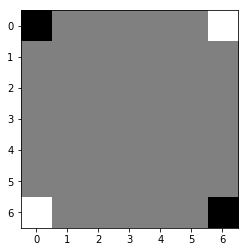

0.1


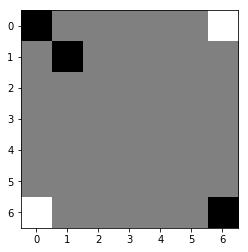

0.0


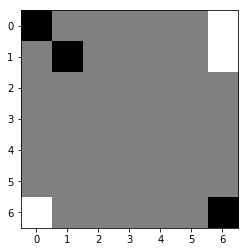

0.0


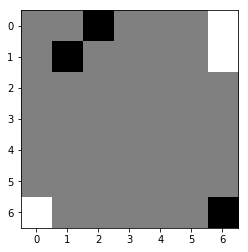

0.0


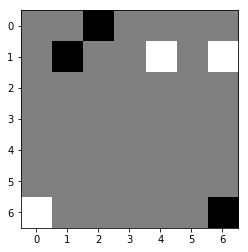

0.0


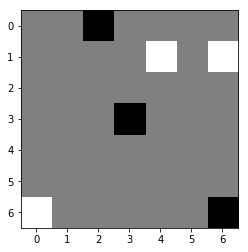

-0.2


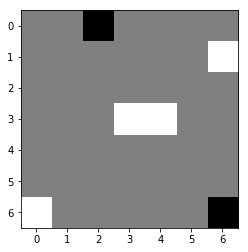

0.0


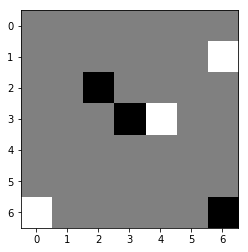

-0.2


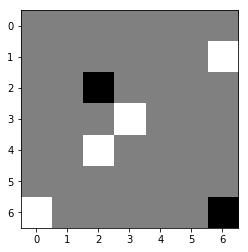

-0.2


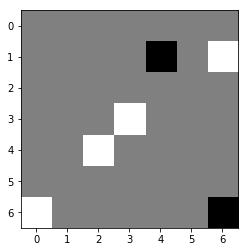

-0.4


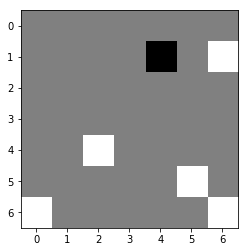

-0.30000000000000004


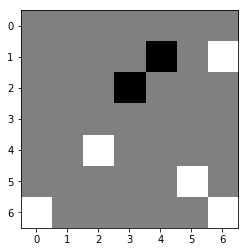

-0.30000000000000004


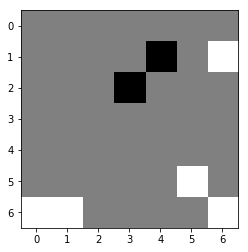

-0.2


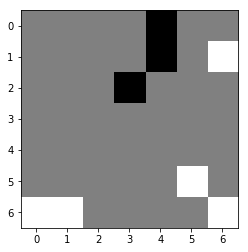

-0.2


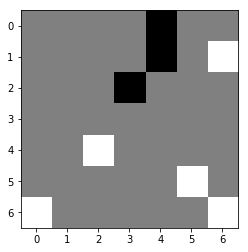

-0.2


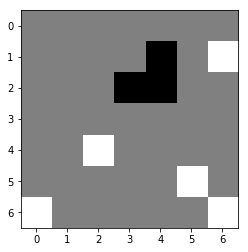

-0.5


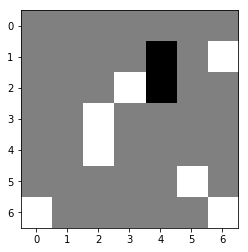

-0.2


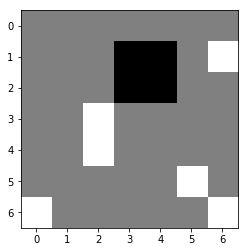

-0.2


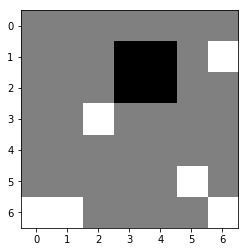

0.0


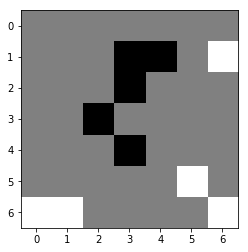

-0.4


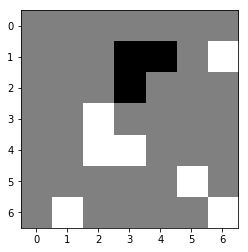

-0.30000000000000004


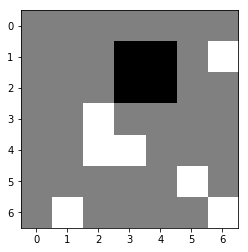

-0.30000000000000004


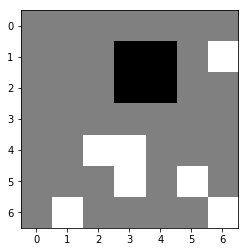

0.2


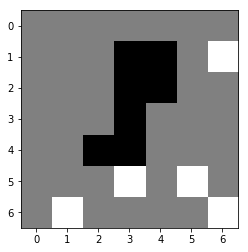

0.1


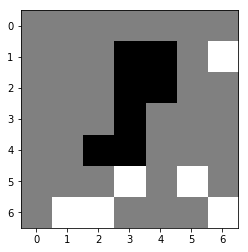

0.2


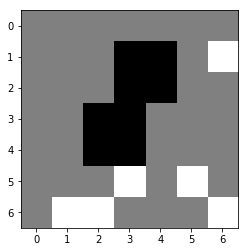

0.2


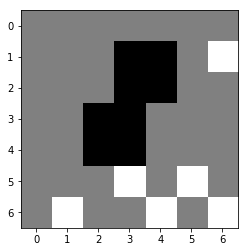

0.30000000000000004


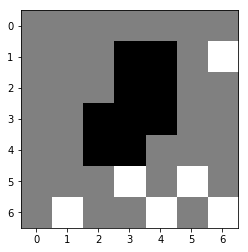

0.1


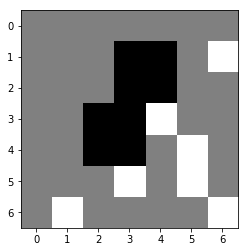

0.5


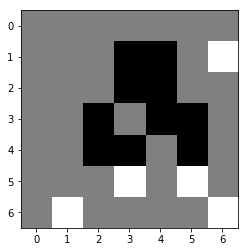

0.0


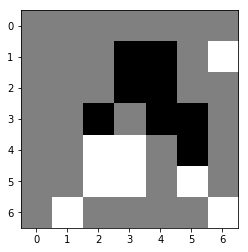

0.5


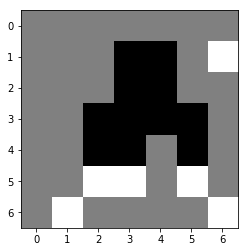

0.0


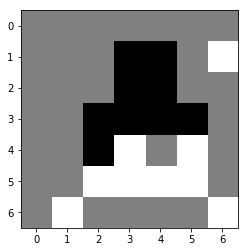

1.0


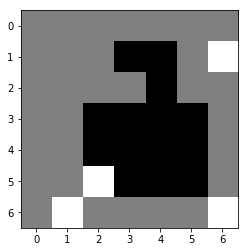

0.7000000000000001


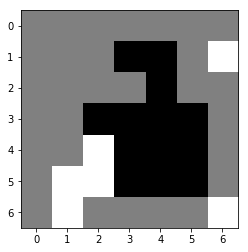

0.9


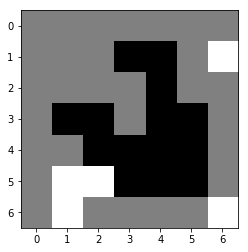

-0.30000000000000004


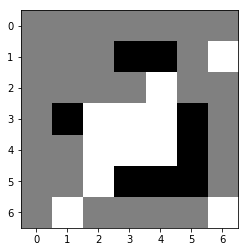

-0.30000000000000004


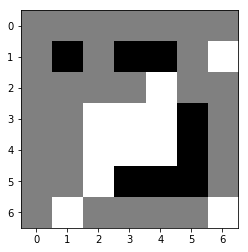

-0.8


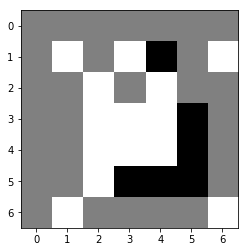

0.4


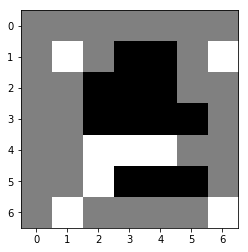

-0.2


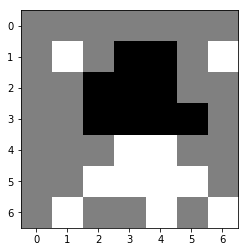

0.4


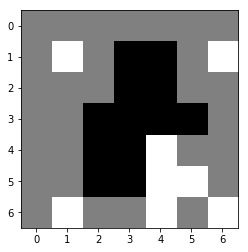

0.1


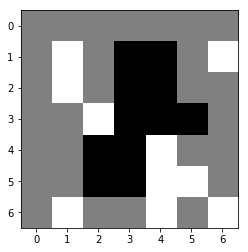

0.5


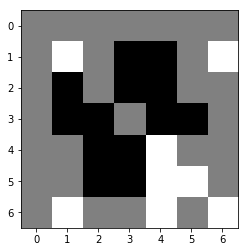

0.1


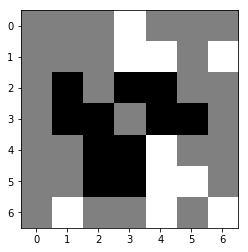

0.30000000000000004


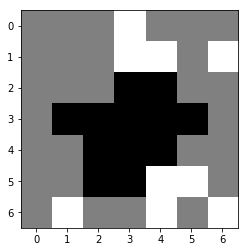

0.30000000000000004


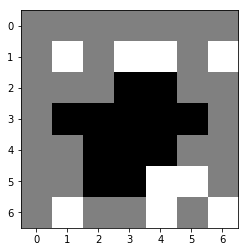

0.7000000000000001


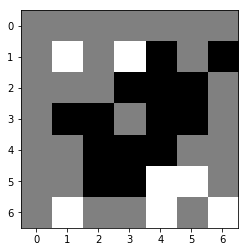

0.6000000000000001


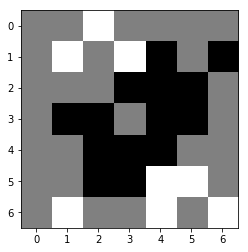

0.6000000000000001


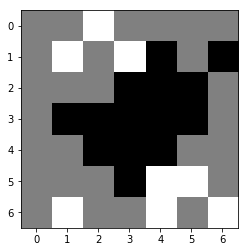

0.2


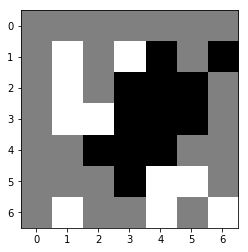

1.2000000000000002


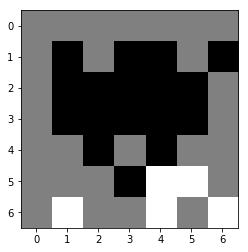

0.8


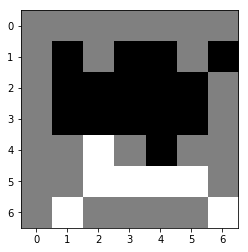

1.2000000000000002


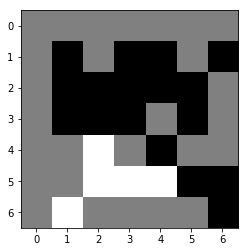

0.5


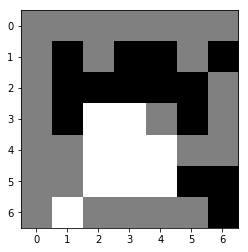

0.5


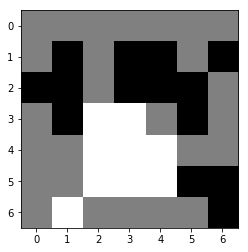

-0.30000000000000004


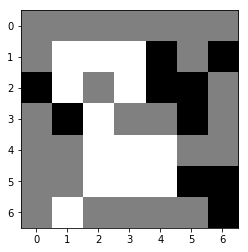

0.30000000000000004


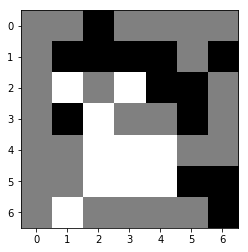

0.0


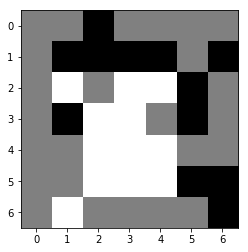

0.30000000000000004


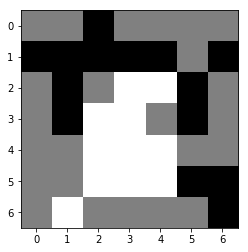

-0.7000000000000001


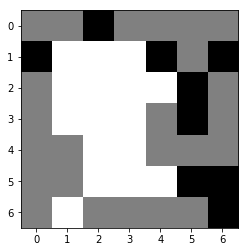

-0.7000000000000001


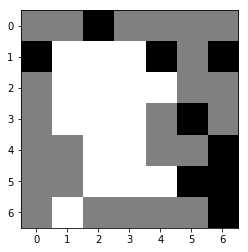

-1.2000000000000002


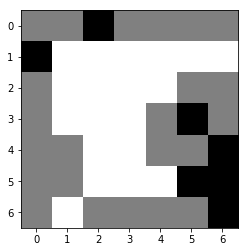

-0.30000000000000004


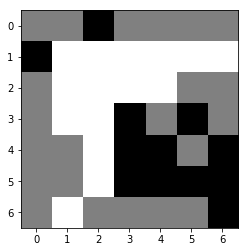

-0.6000000000000001


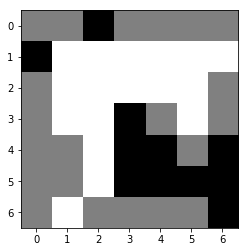

0.2


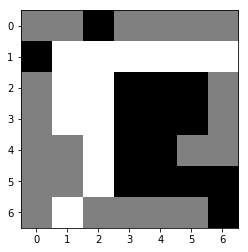

0.2


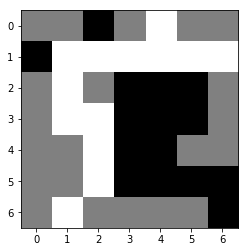

1.4000000000000001


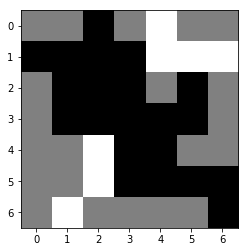

0.2


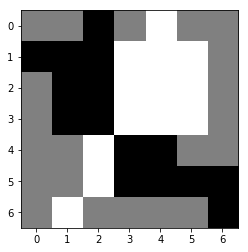

0.6000000000000001


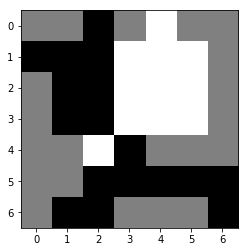

0.0


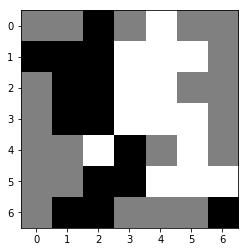

0.2


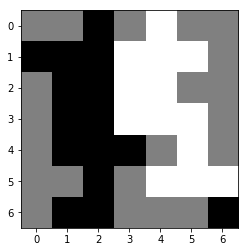

-0.6000000000000001


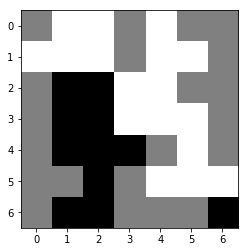

0.7000000000000001


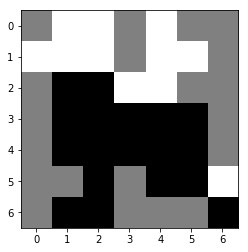

0.7000000000000001


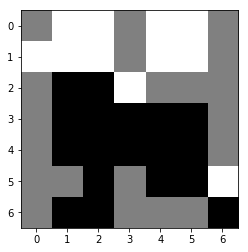

0.7000000000000001


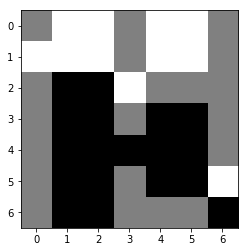

0.5


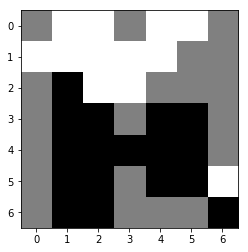

0.5


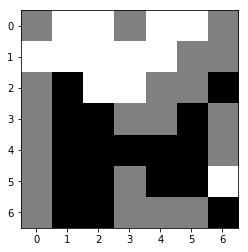

-0.1


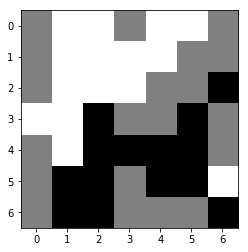

0.30000000000000004


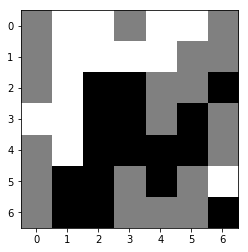

-0.9


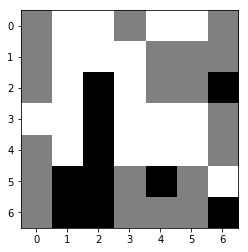

-0.30000000000000004


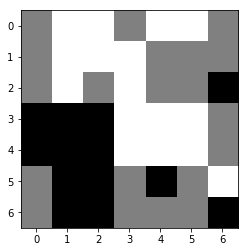

-0.6000000000000001


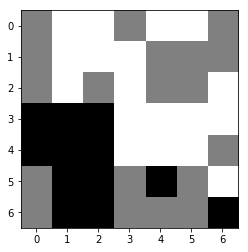

0.6000000000000001


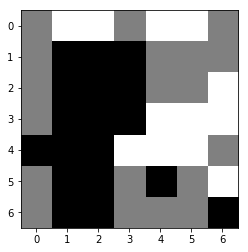

0.2


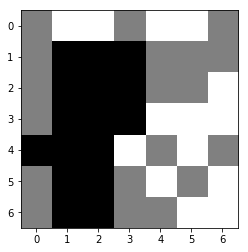

0.8


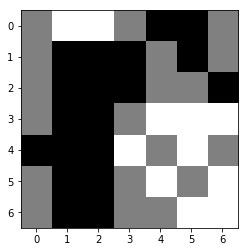

-0.2


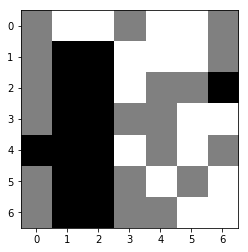

0.30000000000000004


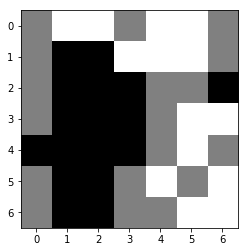

-0.1


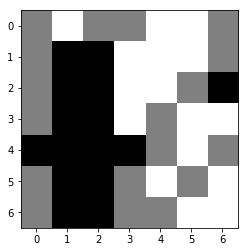

0.7000000000000001


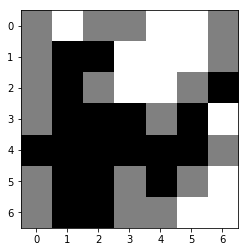

0.30000000000000004


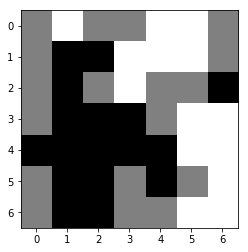

1.4000000000000001


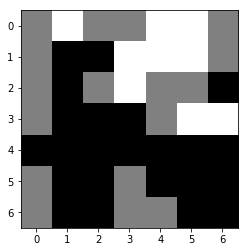

1.1


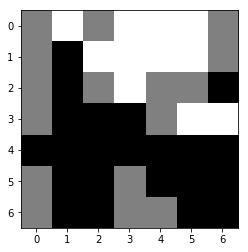

1.7000000000000002


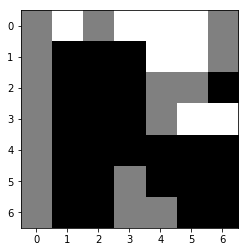

0.7000000000000001


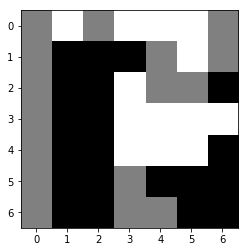

1.7000000000000002


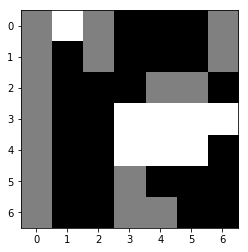

0.5


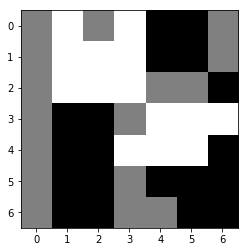

0.5


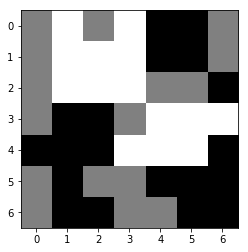

0.0


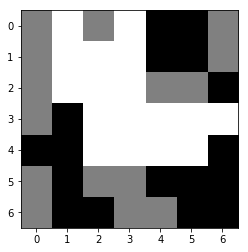

1.1


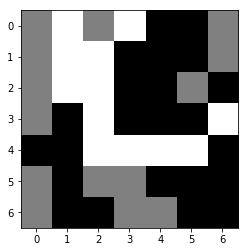

-0.1


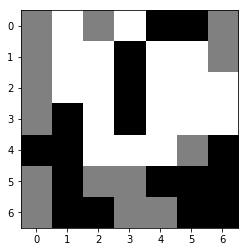

0.7000000000000001


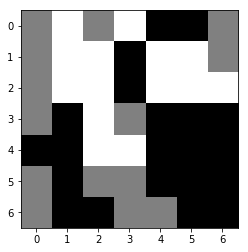

0.0


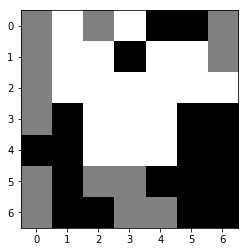

0.6000000000000001


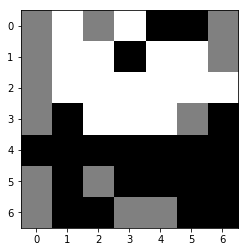

-0.2


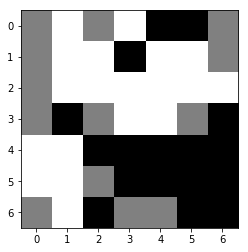

0.0


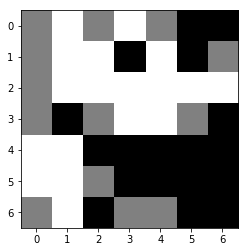

-0.7000000000000001


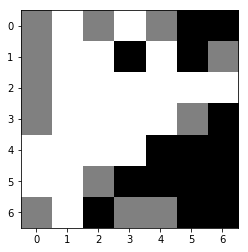

0.2


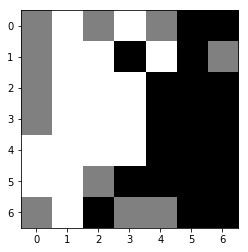

-0.2


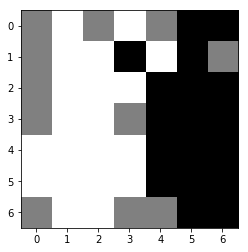

0.8


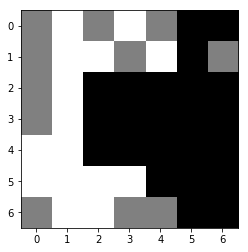

0.2


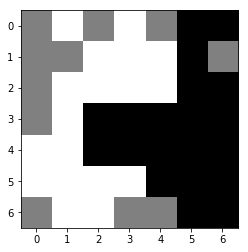

1.0


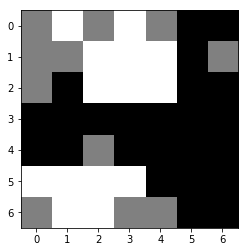

0.0


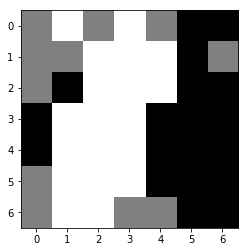

0.6000000000000001


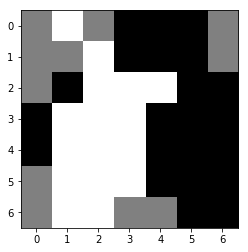

0.1


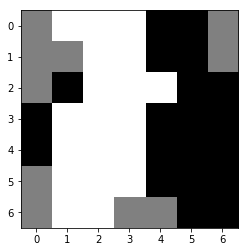

1.0


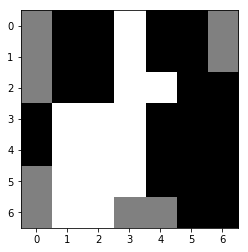

0.7000000000000001


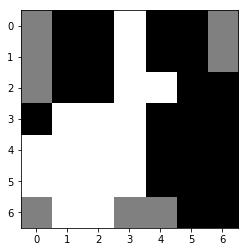

0.7000000000000001


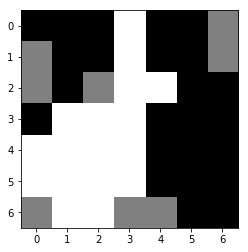

0.0


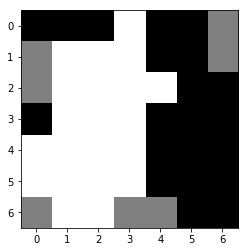

0.5


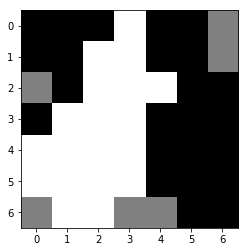

-0.30000000000000004


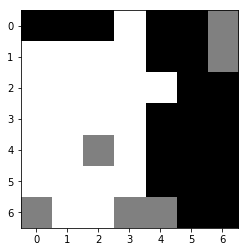

1.3


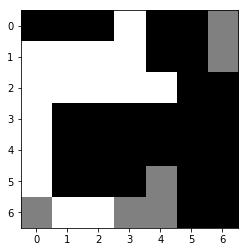

0.9


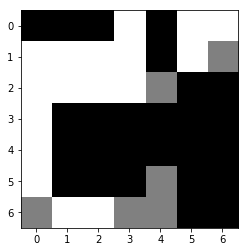

0.9


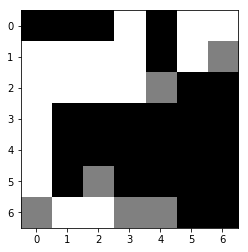

-0.1


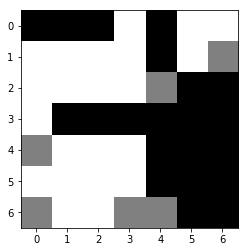

In [ ]:
game = Ataxx()
turn = -1
print("-1 is actor")
while abs(game.evaluate(turn, turn)) != 100:
    print(game.evaluate(-1, turn))
    game.plot()
    with tf.device("/cpu:0"):
        pos0, pos1, _ = actor.get_stochastic_action(game.get_feature_map(turn), game.get_mask(turn), \
                                              is_target=True)
    game.move_to(turn, pos0, pos1)
    turn = -turn
    time.sleep(0.1)
print(game.evaluate(-1, turn))

1 is actor
0.0


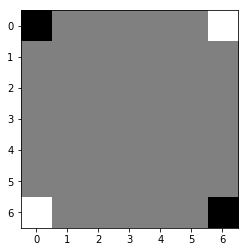

0.1


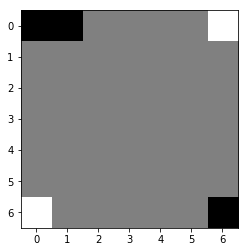

predicted prob for this move is: 0.239719
0.1


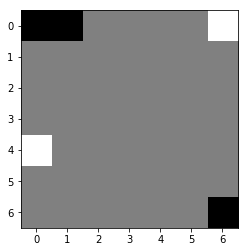

0.2


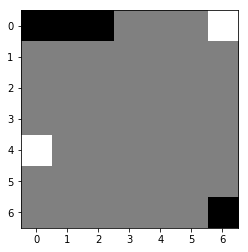

predicted prob for this move is: 0.410743
0.2


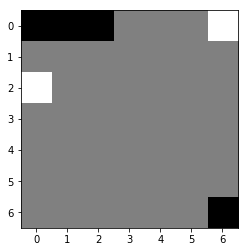

0.5


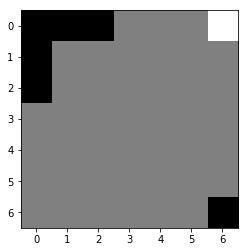

predicted prob for this move is: 0.166497
0.5


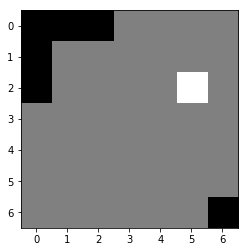

100


In [9]:
game = Ataxx()
turn = -1
print("1 is actor")
while abs(game.evaluate(turn, turn)) != 100:
    print(game.evaluate(-1, turn))
    game.plot()
    if turn == -1:
        best_move = game.get_greedy_move(turn)
        game.move_to(turn, best_move[0], best_move[1])
    else:
        pos0, pos1, _ = actor.get_noised_action(game, turn, 0, is_target=True)
        game.move_to(turn, pos0, pos1)
    turn = -turn
    time.sleep(0.1)
print(game.evaluate(-1, turn))

-1 is actor
0.0


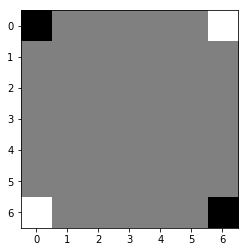

predicted prob for this move is: 0.0500829
0.1


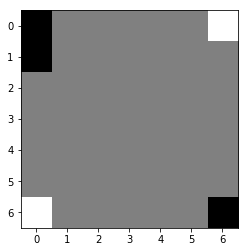

0.0


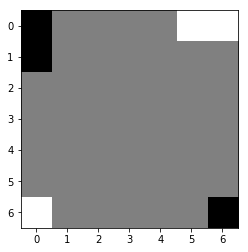

predicted prob for this move is: 0.0497656
0.1


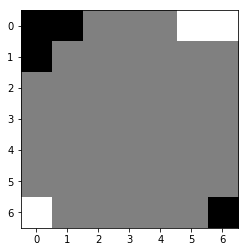

0.0


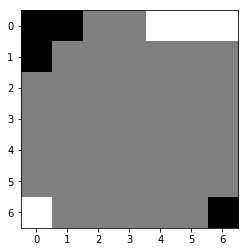

predicted prob for this move is: 0.0490917
0.0


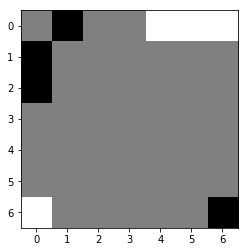

-0.2


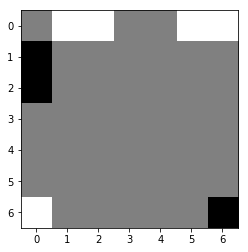

predicted prob for this move is: 0.0481683
-0.2


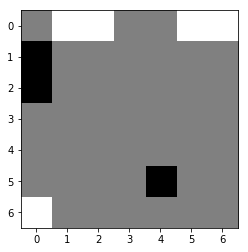

-0.7000000000000001


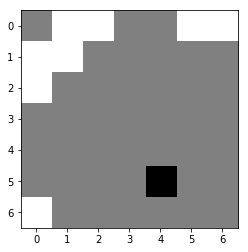

predicted prob for this move is: 0.0457362
-0.6000000000000001


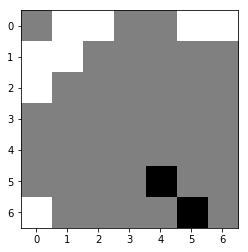

-0.7000000000000001


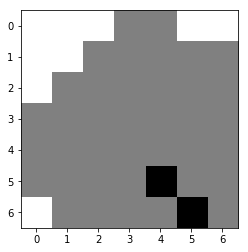

predicted prob for this move is: 0.0453432
-0.7000000000000001


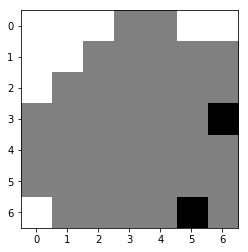

-0.9


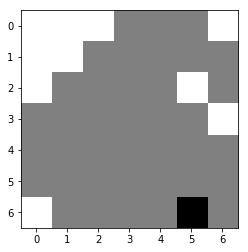

predicted prob for this move is: 0.0476256
-0.8


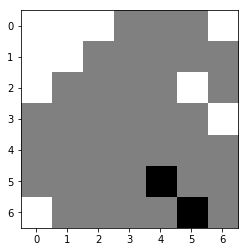

-100


In [29]:
game = Ataxx()
turn = -1
print("-1 is actor")
while abs(game.evaluate(turn, turn)) != 100:
    print(game.evaluate(-1, turn))
    game.plot()
    if turn == 1:
        best_move = game.get_greedy_move(turn)
        game.move_to(turn, best_move[0], best_move[1])
    else:
        pos0, pos1, _ = actor.get_noised_action(game, turn, 0, is_target=True)
        game.move_to(turn, pos0, pos1)
    turn = -turn
    time.sleep(0.1)
print(game.evaluate(-1, turn))

In [50]:
graph = 0

def reinforcement_data_generator(actor_model, actor_target, critic_model, critic_target, relay, \
                                 train_critic=True, step_per_episode=50, \
                                 BATCH_SIZE=64, GAMMA=0.99, RELAY_SIZE=10000): 
    global graph
    with graph.as_default():
        max_score = 1
        min_score = 0.02
        policy_mask_init = 0.01

        actor = ActorNetwork(target_model=actor_target, model=actor_model)
        critic = CriticNetwork(target_model=critic_target, model=actor_model)
        print("actor critic prepared")

        while True:
            reward = 0
            step = 0

            game = Ataxx()
            turn = -1 # start turn is -1

            while abs(game.evaluate(turn, turn, max_score, min_score)) != max_score:
                new_sample = [] # prepare to collect new sample

                pos0, pos1, cur_action_mask = actor.get_noised_action(game, turn, epsilon=0.1, mask_init=policy_mask_init, verbose=0) # get proposed action

                new_state = game.simu_move_to(turn, pos0, pos1)

                # create new_sample and add that to relay
                new_sample.append(game.get_feature_map(turn)) # cur_state
                new_sample.append(game.get_mask(turn)) # cur_mask
                new_sample.append(actor.get_action_prob(game, turn)) # cur_action
                new_sample.append(cur_action_mask) # cur_action_mask

                game.move_to(turn, pos0, pos1) # do the move here if the move is valid
                turn = -turn # the turn now is the next turn, what we are learning for is -turn

                new_sample.append(game.evaluate(-turn, turn, max_score, min_score)) # cur_reward
                if abs(new_sample[-1]) == max_score:
                    new_sample.append(None) 
                else:
                    new_sample.append(game.get_feature_map(turn)) # new_state

                relay.add_sample(new_sample)

            if relay.size() > BATCH_SIZE:
                for t in range(step_per_episode):
                    cur_state, cur_mask, cur_action, cur_action_mask, \
                        cur_reward, new_state = relay.get_batch(BATCH_SIZE)
                    q_target = np.zeros(BATCH_SIZE)

                    for k in range(BATCH_SIZE):
                        if new_state[k] is None:
                            q_target[k] = cur_reward[k]
                        else:
                            # generate new action
                            board = new_state[k][0] - new_state[k][1]
                            tmp_game = Ataxx(board) # recover the game board

                            new_action, new_action_mask = actor.get_noised_action(tmp_game, 1, epsilon=0, return_position=False, 
                                                                        mask_init=policy_mask_init, is_target=True, verbose=False)
                            q_new = critic.target_model.predict([new_state[k].reshape(1, 2, 7, 7), 
                                                                new_action.reshape(1, 2, 7, 7),
                                                                new_action_mask.reshape(1, 2, 7, 7)])[0]
                            q_target[k] = cur_reward[k] - GAMMA*q_new # cuz this q_new is for the opponent
                    if train_critic:
                        yield [cur_state, cur_action, cur_action_mask], q_target
                    else:
                        yield [cur_state, cur_mask, cur_action_mask], np.zeros(BATCH_SIZE)

def actor_critic_trainer(epochs=1000, check_point=True, steps_per_epoch=50, \
                           BATCH_SIZE=64, TRAIN_BATCH_TIME=1, GAMMA=0.99, RELAY_SIZE=10000, TAU=0.001, LRA=0.0001, LRC=0.0001): 
    actor = ActorNetwork(TAU, LRA, 0)
    critic = CriticNetwork(TAU, LRC)
    relay = Relay(RELAY_SIZE)
    global graph
    graph = tf.get_default_graph()

    with tf.device('/cpu'):
        actor_critic_model = Model(inputs=[actor.model.inputs[0], actor.model.inputs[1], critic.frozen_model.inputs[2]],
                                   outputs=[critic.frozen_model([actor.model.inputs[0], actor.model.outputs[0], critic.frozen_model.inputs[2]])])
        sgd = SGD(lr=LRA, decay=5e-7, momentum=0.9, nesterov=True)
        actor_critic_model.compile(loss=neg_linear_loss, optimizer=sgd)
    gpu_ac_model = multi_gpu_model(actor_critic_model, gpus=4)
    gpu_ac_model.compile(loss=neg_linear_loss, optimizer=Adam(lr=LRA))
    print(gpu_ac_model.summary())
    
    for ep in range(epochs):
        critic.gpu_model.fit_generator(reinforcement_data_generator(actor.model, actor.target_model, \
                                                                    critic.model, critic.target_model, \
                                                                    relay, train_critic=True, \
                                                                    step_per_episode=50, \
                                                                    BATCH_SIZE=256, GAMMA=0.99, RELAY_SIZE=RELAY_SIZE),\
                                       verbose=1, steps_per_epoch=steps_per_epoch, \
                                       #workers=8, use_multiprocessing=True
                                      )
        gpu_ac_model.fit_generator(reinforcement_data_generator(actor.model, actor.target_model, \
                                                                critic.model, critic.target_model, \
                                                                relay, train_critic=False, \
                                                                step_per_episode=50, \
                                                                BATCH_SIZE=256, GAMMA=0.99, RELAY_SIZE=RELAY_SIZE),\
                                   verbose=1, steps_per_epoch=steps_per_epoch, \
                                   #workers=8, use_multiprocessing=True
                                  )
        actor.target_train()
        critic.target_train()
        
        if check_point:
            actor.save()
        tmp_game = Ataxx()
        print("trained action prob map predicted by initial model for a starting game")
        print(actor.get_action_prob(tmp_game, -1, is_target=True))

In [51]:
actor_critic_trainer(epochs=1000, check_point=True, steps_per_epoch=50, \
                     BATCH_SIZE=64, TRAIN_BATCH_TIME=1, GAMMA=0.99, RELAY_SIZE=10000, \
                     TAU=0.001, LRA=0.0001, LRC=0.0001) 
    

/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:121: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=[<tf.Tenso..., inputs=[<tf.Tenso...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_153 (InputLayer)          (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
conv2d_242 (Conv2D)             (None, 64, 5, 5)     1216        input_153[0][0]                  
__________________________________________________________________________________________________
batch_normalization_271 (BatchN (None, 64, 5, 5)     256         conv2d_242[0][0]                 
__________________________________________________________________________________________________
conv2d_243 (Conv2D)             (None, 64, 5, 5)     36928       batch_normalization_271[0][0]    
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_161 (InputLayer)          (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
input_162 (InputLayer)          (None, 2, 7, 7)      0                                            
__________________________________________________________________________________________________
multiply_64 (Multiply)          (None, 2, 7, 7)      0           input_161[0][0]                  
                                                                 input_162[0][0]                  
__________________________________________________________________________________________________
input_160 (InputLayer)          (None, 2, 7, 7)      0                                            
__________

50/50 [==============================] - 127s 3s/step - loss: 1.9434 - mean_squared_error: 1.9434


Exception ignored in: <generator object reinforcement_data_generator at 0x7f765f58e468>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 117s 2s/step - loss: -1.4782e-08


Exception ignored in: <generator object reinforcement_data_generator at 0x7f765f58e468>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.020408  ]
  [ 0.020408    0.020408    0.020408    0.020408    0.020408    0.020408
    0.02041597]]

 [[ 0.02040417  0.02040417  0.02040417  0.02040417  0.02040417  0.02040417
    0.02040417]
  [ 0.02042603  0.02042381  0.02041361  0.02040417  0.02040417  0.02040417
    0.02040417]
  [ 0.02040417  0.02042197  0.02040417  0.02040417  0.02040417  0.02040417
    0.02040417]
  [ 0.02040417  0.02040417  0.0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 108s 2s/step - loss: -3.7905e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.02040799]
  [ 0.02040799  0.02040799  0.02040799  0.02040799  0.02040799  0.02040799
    0.0204167 ]]

 [[ 0.02040579  0.02040579  0.0204107   0.02040579  0.02040579  0.02040579
    0.02040579]
  [ 0.020414    0.02040579  0.02042309  0.02040579  0.02040579  0.02040579
    0.02040579]
  [ 0.02040579  0.02040579  0.02040579  0.02040579  0.02040579  0.02040579
    0.02040579]
  [ 0.02040579  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 107s 2s/step - loss: 1.4529e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02040795]
  [ 0.02040795  0.02040795  0.02040795  0.02040795  0.02040795  0.02040795
    0.02041829]]

 [[ 0.02040545  0.02040545  0.02043251  0.02040545  0.02040545  0.02040545
    0.02040545]
  [ 0.02040545  0.02040545  0.02042651  0.02040545  0.02040545  0.02040545
    0.02040545]
  [ 0.02040545  0.02040545  0.02040961  0.02040545  0.02040545  0.02040545
    0.02040545]
  [ 0.02040545  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 106s 2s/step - loss: -7.9488e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02040797]
  [ 0.02040797  0.02040797  0.02040797  0.02040797  0.02040797  0.02040797
    0.02041747]]

 [[ 0.02040438  0.02040438  0.02045121  0.02040438  0.02040438  0.02040438
    0.02040438]
  [ 0.02040438  0.02040438  0.02042737  0.02040438  0.02040438  0.02040438
    0.02040438]
  [ 0.02040438  0.02040438  0.02041601  0.02040438  0.02040438  0.02040438
    0.02040438]
  [ 0.02040438  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 106s 2s/step - loss: 1.4668e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02040808]
  [ 0.02040808  0.02040808  0.02040808  0.02040808  0.02040808  0.02040808
    0.02041208]]

 [[ 0.02040343  0.02040343  0.0204699   0.02040343  0.02040343  0.02040343
    0.02040343]
  [ 0.02040343  0.02040343  0.02042824  0.02040343  0.02040343  0.02040343
    0.02040343]
  [ 0.02040343  0.02040343  0.02042096  0.02040343  0.02040343  0.02040343
    0.02040343]
  [ 0.02040343  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 105s 2s/step - loss: -6.9197e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02041005  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]
  [ 0.02040812  0.02040812  0.02040812  0.02040812  0.02040812  0.02040812
    0.02040812]]

 [[ 0.02040233  0.02040233  0.02048798  0.02040233  0.02040233  0.02040233
    0.02040233]
  [ 0.02040233  0.02040233  0.02042876  0.02040233  0.02040233  0.02040233
    0.02040233]
  [ 0.02040233  0.02040233  0.02042454  0.02040233  0.02040233  0.02040233
    0.02040233]
  [ 0.02040233  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 105s 2s/step - loss: -9.8068e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02041354  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]
  [ 0.02040805  0.02040805  0.02040805  0.02040805  0.02040805  0.02040805
    0.02040805]]

 [[ 0.02040141  0.02040141  0.02050594  0.02040141  0.02040141  0.02040141
    0.02040141]
  [ 0.02040141  0.02040141  0.02043002  0.02040141  0.02040141  0.02040141
    0.02040141]
  [ 0.02040141  0.02040141  0.02042576  0.02040141  0.02040141  0.02040141
    0.02040141]
  [ 0.02040141  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 104s 2s/step - loss: -3.1758e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02041675  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]
  [ 0.02040798  0.02040798  0.02040798  0.02040798  0.02040798  0.02040798
    0.02040798]]

 [[ 0.02040056  0.02040056  0.02052318  0.02040056  0.02040056  0.02040056
    0.02040056]
  [ 0.02040056  0.02040056  0.02043022  0.02040056  0.02040056  0.02040056
    0.02040056]
  [ 0.02040056  0.02040056  0.02042694  0.02040056  0.02040056  0.02040056
    0.02040056]
  [ 0.02040056  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 105s 2s/step - loss: 1.5972e-08


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02041998  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]
  [ 0.02040792  0.02040792  0.02040792  0.02040792  0.02040792  0.02040792
    0.02040792]]

 [[ 0.02039975  0.02039975  0.02053815  0.02039975  0.02039975  0.02039975
    0.02039975]
  [ 0.02039975  0.02039975  0.02043092  0.02039975  0.02039975  0.02039975
    0.02039975]
  [ 0.02039975  0.02039975  0.02042914  0.02039975  0.02039975  0.02039975
    0.02039975]
  [ 0.02039975  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 104s 2s/step - loss: -2.9756e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.0204231   0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]
  [ 0.02040785  0.02040785  0.02040785  0.02040785  0.02040785  0.02040785
    0.02040785]]

 [[ 0.02039894  0.02040579  0.0205518   0.02039894  0.02039894  0.02039894
    0.02039894]
  [ 0.02039894  0.02039894  0.02043077  0.02039894  0.02039894  0.02039894
    0.02039894]
  [ 0.02039894  0.02039894  0.02042754  0.02039894  0.02039894  0.02039894
    0.02039894]
  [ 0.02039894  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 103s 2s/step - loss: -3.9209e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02042691  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]
  [ 0.02040777  0.02040777  0.02040777  0.02040777  0.02040777  0.02040777
    0.02040777]]

 [[ 0.02039819  0.02041248  0.02056349  0.02039819  0.02039819  0.02039819
    0.02039819]
  [ 0.02039819  0.02039819  0.0204301   0.02039819  0.02039819  0.02039819
    0.02039819]
  [ 0.02039819  0.02039819  0.02042566  0.02039819  0.02039819  0.02039819
    0.02039819]
  [ 0.02039819  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: 3.9442e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.0204308   0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]
  [ 0.02040769  0.02040769  0.02040769  0.02040769  0.02040769  0.02040769
    0.02040769]]

 [[ 0.02039758  0.02041801  0.02057318  0.02039758  0.02039758  0.02039758
    0.02039758]
  [ 0.02039758  0.02039758  0.02042926  0.02039758  0.02039758  0.02039758
    0.02039758]
  [ 0.02039758  0.02039758  0.02042391  0.02039758  0.02039758  0.02039758
    0.02039758]
  [ 0.02039758  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: -1.4156e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02043401  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]
  [ 0.02040763  0.02040763  0.02040763  0.02040763  0.02040763  0.02040763
    0.02040763]]

 [[ 0.02039705  0.02042411  0.02058309  0.02039705  0.02039705  0.02039705
    0.02039705]
  [ 0.02039705  0.02039705  0.02042831  0.02039705  0.02039705  0.02039705
    0.02039705]
  [ 0.02039705  0.02039705  0.02042199  0.02039705  0.02039705  0.02039705
    0.02039705]
  [ 0.02039705  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 103s 2s/step - loss: 6.5193e-10


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02043587  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]
  [ 0.02040759  0.02040759  0.02040759  0.02040759  0.02040759  0.02040759
    0.02040759]]

 [[ 0.02039659  0.02043026  0.020593    0.02039659  0.02039659  0.02039659
    0.02039659]
  [ 0.02039659  0.02039659  0.02042667  0.02039659  0.02039659  0.02039659
    0.02039659]
  [ 0.02039659  0.02039659  0.02042037  0.02039659  0.02039659  0.02039659
    0.02039659]
  [ 0.02039659  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: 5.0245e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.0204375   0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]
  [ 0.02040755  0.02040755  0.02040755  0.02040755  0.02040755  0.02040755
    0.02040755]]

 [[ 0.02039614  0.02043639  0.02060285  0.02039614  0.02039614  0.02039614
    0.02039614]
  [ 0.02039614  0.02039614  0.02042501  0.02039614  0.02039614  0.02039614
    0.02039614]
  [ 0.02039614  0.02039614  0.02041861  0.02039614  0.02039614  0.02039614
    0.02039614]
  [ 0.02039614  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic preparedEpoch 1/1

50/50 [==============================] - 102s 2s/step - loss: 2.3004e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02043931  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]
  [ 0.02040751  0.02040751  0.02040751  0.02040751  0.02040751  0.02040751
    0.02040751]]

 [[ 0.02039566  0.02044197  0.02061351  0.02039566  0.02039566  0.02039566
    0.02039566]
  [ 0.02039566  0.02039566  0.02042458  0.02039566  0.02039566  0.02039566
    0.02039566]
  [ 0.02039566  0.02039566  0.02041656  0.02039566  0.02039566  0.02039566
    0.02039566]
  [ 0.02039566  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 101s 2s/step - loss: -1.8813e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02044123  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]
  [ 0.02040748  0.02040748  0.02040748  0.02040748  0.02040748  0.02040748
    0.02040748]]

 [[ 0.02039513  0.0204482   0.0206238   0.02039513  0.02039513  0.02039513
    0.02039513]
  [ 0.02039513  0.02039513  0.02042557  0.02039513  0.02039513  0.02039513
    0.02039513]
  [ 0.02039513  0.02039513  0.0204139   0.02039513  0.02039513  0.02039513
    0.02039513]
  [ 0.02039513  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: -3.5949e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b048>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.0204425   0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]
  [ 0.02040745  0.02040745  0.02040745  0.02040745  0.02040745  0.02040745
    0.02040745]]

 [[ 0.02039455  0.02045457  0.02063477  0.02039455  0.02039455  0.02039455
    0.02039455]
  [ 0.02039455  0.02039455  0.02042698  0.02039455  0.02039455  0.02039455
    0.02039455]
  [ 0.02039455  0.02039455  0.02041113  0.02039455  0.02039455  0.02039455
    0.02039455]
  [ 0.02039455  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 102s 2s/step - loss: 7.1246e-09


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02044372  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]
  [ 0.02040742  0.02040742  0.02040742  0.02040742  0.02040742  0.02040742
    0.02040742]]

 [[ 0.02039393  0.02046089  0.02064561  0.02039393  0.02039393  0.02039393
    0.02039393]
  [ 0.02039731  0.02039393  0.02042882  0.02039393  0.02039393  0.02039393
    0.02039393]
  [ 0.02039393  0.02039393  0.02040839  0.02039393  0.02039393  0.02039393
    0.02039393]
  [ 0.02039393  0

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
50/50 [==============================] - 101s 2s/step - loss: 4.0047e-10


Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b1a8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


trained action prob map predicted by initial model for a starting game
[[[ 0.02044491  0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]
  [ 0.0204074   0.0204074   0.0204074   0.0204074   0.0204074   0.0204074
    0.0204074 ]]

 [[ 0.02039324  0.02046709  0.02065576  0.02039324  0.02039324  0.02039324
    0.02039324]
  [ 0.02040218  0.02039324  0.02043024  0.02039324  0.02039324  0.02039324
    0.02039324]
  [ 0.02039324  0.02039324  0.02040604  0.02039324  0.02039324  0.02039324
    0.02039324]
  [ 0.02039324  0.020393

Exception ignored in: <generator object reinforcement_data_generator at 0x7f7653a4b0f8>
Traceback (most recent call last):
  File "<ipython-input-50-b196c6d99be7>", line 67, in reinforcement_data_generator
  File "/home/yuze/anaconda3/envs/tensorflow/lib/python3.5/contextlib.py", line 77, in __exit__
    self.gen.throw(type, value, traceback)
  File "/home/yuze/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 4342, in get_controller
    if self.stack[-1] is not default:
IndexError: list index out of range


actor critic prepared
Epoch 1/1
49/50 [============================>.] - ETA: 1s - loss: -3.6208e-09

KeyboardInterrupt: 